In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ResNet101V2)

2024-02-21 09:47:54.357692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 09:47:54.357791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 09:47:54.477205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ResNet101V2(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ResNet101V2"+s+".keras")
    

    # save model to disk
    filename = "ResNet101V2" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet101v2 (Functional)    (None, 4)                 42634756  


Total params: 42634756 (162.64 MB)


Trainable params: 42537092 (162.27 MB)


Non-trainable params: 97664 (381.50 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708508928.726438      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 2:15:30 - loss: 1.2785 - accuracy: 0.2812

  2/140 [..............................] - ETA: 31s - loss: 1.3058 - accuracy: 0.2969    

  3/140 [..............................] - ETA: 30s - loss: 1.7366 - accuracy: 0.3438

  4/140 [..............................] - ETA: 30s - loss: 1.5878 - accuracy: 0.3906

  5/140 [>.............................] - ETA: 29s - loss: 1.4268 - accuracy: 0.4437

  6/140 [>.............................] - ETA: 29s - loss: 1.3553 - accuracy: 0.4479

  7/140 [>.............................] - ETA: 29s - loss: 1.3539 - accuracy: 0.4420

  8/140 [>.............................] - ETA: 29s - loss: 1.3584 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 28s - loss: 1.3329 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 28s - loss: 1.3122 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 28s - loss: 1.2813 - accuracy: 0.4432

 12/140 [=>............................] - ETA: 28s - loss: 1.2870 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 27s - loss: 1.2529 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 27s - loss: 1.2361 - accuracy: 0.4777

 15/140 [==>...........................] - ETA: 27s - loss: 1.2427 - accuracy: 0.4792

 16/140 [==>...........................] - ETA: 27s - loss: 1.2195 - accuracy: 0.4805

 17/140 [==>...........................] - ETA: 26s - loss: 1.2198 - accuracy: 0.4798

 18/140 [==>...........................] - ETA: 26s - loss: 1.1981 - accuracy: 0.4896

 19/140 [===>..........................] - ETA: 26s - loss: 1.1921 - accuracy: 0.4852

 20/140 [===>..........................] - ETA: 26s - loss: 1.1865 - accuracy: 0.4906

 21/140 [===>..........................] - ETA: 26s - loss: 1.1800 - accuracy: 0.4851

 22/140 [===>..........................] - ETA: 25s - loss: 1.1769 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 25s - loss: 1.1656 - accuracy: 0.4755

 24/140 [====>.........................] - ETA: 25s - loss: 1.1569 - accuracy: 0.4727

 25/140 [====>.........................] - ETA: 25s - loss: 1.1614 - accuracy: 0.4675

 26/140 [====>.........................] - ETA: 24s - loss: 1.1536 - accuracy: 0.4748

 27/140 [====>.........................] - ETA: 24s - loss: 1.1426 - accuracy: 0.4815

 28/140 [=====>........................] - ETA: 24s - loss: 1.1332 - accuracy: 0.4810

 29/140 [=====>........................] - ETA: 24s - loss: 1.1203 - accuracy: 0.4871

 30/140 [=====>........................] - ETA: 24s - loss: 1.1106 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 23s - loss: 1.0991 - accuracy: 0.4929

 32/140 [=====>........................] - ETA: 23s - loss: 1.0951 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 23s - loss: 1.0855 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 23s - loss: 1.0840 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 22s - loss: 1.0857 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 22s - loss: 1.0821 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 22s - loss: 1.0826 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 22s - loss: 1.0779 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 22s - loss: 1.0789 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 21s - loss: 1.0802 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 21s - loss: 1.0743 - accuracy: 0.4901

 42/140 [========>.....................] - ETA: 21s - loss: 1.0668 - accuracy: 0.4926

 43/140 [========>.....................] - ETA: 21s - loss: 1.0616 - accuracy: 0.4942

 44/140 [========>.....................] - ETA: 21s - loss: 1.0542 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 20s - loss: 1.0606 - accuracy: 0.4944

 46/140 [========>.....................] - ETA: 20s - loss: 1.0610 - accuracy: 0.4959

 47/140 [=========>....................] - ETA: 20s - loss: 1.0577 - accuracy: 0.4987

 48/140 [=========>....................] - ETA: 20s - loss: 1.0523 - accuracy: 0.5026

 49/140 [=========>....................] - ETA: 19s - loss: 1.0536 - accuracy: 0.5026

 50/140 [=========>....................] - ETA: 19s - loss: 1.0476 - accuracy: 0.5044

 51/140 [=========>....................] - ETA: 19s - loss: 1.0419 - accuracy: 0.5080

 52/140 [==========>...................] - ETA: 19s - loss: 1.0362 - accuracy: 0.5114

 53/140 [==========>...................] - ETA: 19s - loss: 1.0313 - accuracy: 0.5153

 54/140 [==========>...................] - ETA: 18s - loss: 1.0275 - accuracy: 0.5185

 55/140 [==========>...................] - ETA: 18s - loss: 1.0237 - accuracy: 0.5205

 56/140 [===========>..................] - ETA: 18s - loss: 1.0169 - accuracy: 0.5240

 57/140 [===========>..................] - ETA: 18s - loss: 1.0118 - accuracy: 0.5285

 58/140 [===========>..................] - ETA: 17s - loss: 1.0074 - accuracy: 0.5302

 59/140 [===========>..................] - ETA: 17s - loss: 1.0095 - accuracy: 0.5297

 60/140 [===========>..................] - ETA: 17s - loss: 1.0093 - accuracy: 0.5302

 61/140 [============>.................] - ETA: 17s - loss: 1.0035 - accuracy: 0.5323

 62/140 [============>.................] - ETA: 17s - loss: 1.0003 - accuracy: 0.5348

 63/140 [============>.................] - ETA: 16s - loss: 0.9992 - accuracy: 0.5372

 64/140 [============>.................] - ETA: 16s - loss: 0.9940 - accuracy: 0.5391

 65/140 [============>.................] - ETA: 16s - loss: 0.9915 - accuracy: 0.5423

 66/140 [=============>................] - ETA: 16s - loss: 0.9884 - accuracy: 0.5431

 67/140 [=============>................] - ETA: 15s - loss: 0.9882 - accuracy: 0.5429

 68/140 [=============>................] - ETA: 15s - loss: 0.9973 - accuracy: 0.5395

 69/140 [=============>................] - ETA: 15s - loss: 0.9941 - accuracy: 0.5399

 70/140 [==============>...............] - ETA: 15s - loss: 0.9943 - accuracy: 0.5406

 71/140 [==============>...............] - ETA: 15s - loss: 0.9932 - accuracy: 0.5414

 72/140 [==============>...............] - ETA: 14s - loss: 0.9917 - accuracy: 0.5434

 73/140 [==============>...............] - ETA: 14s - loss: 0.9876 - accuracy: 0.5467

 74/140 [==============>...............] - ETA: 14s - loss: 0.9844 - accuracy: 0.5481

 75/140 [===============>..............] - ETA: 14s - loss: 0.9832 - accuracy: 0.5487

 76/140 [===============>..............] - ETA: 14s - loss: 0.9818 - accuracy: 0.5498

 77/140 [===============>..............] - ETA: 13s - loss: 0.9767 - accuracy: 0.5528

 78/140 [===============>..............] - ETA: 13s - loss: 0.9717 - accuracy: 0.5545

 79/140 [===============>..............] - ETA: 13s - loss: 0.9756 - accuracy: 0.5530

 80/140 [================>.............] - ETA: 13s - loss: 0.9716 - accuracy: 0.5543

 81/140 [================>.............] - ETA: 12s - loss: 0.9674 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 12s - loss: 0.9643 - accuracy: 0.5579

 83/140 [================>.............] - ETA: 12s - loss: 0.9642 - accuracy: 0.5584

 84/140 [=================>............] - ETA: 12s - loss: 0.9677 - accuracy: 0.5595

 85/140 [=================>............] - ETA: 12s - loss: 0.9644 - accuracy: 0.5610

 86/140 [=================>............] - ETA: 11s - loss: 0.9603 - accuracy: 0.5625

 87/140 [=================>............] - ETA: 11s - loss: 0.9586 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 11s - loss: 0.9597 - accuracy: 0.5632

 89/140 [==================>...........] - ETA: 11s - loss: 0.9607 - accuracy: 0.5646

 90/140 [==================>...........] - ETA: 10s - loss: 0.9594 - accuracy: 0.5656

 91/140 [==================>...........] - ETA: 10s - loss: 0.9574 - accuracy: 0.5656

 92/140 [==================>...........] - ETA: 10s - loss: 0.9552 - accuracy: 0.5673

 93/140 [==================>...........] - ETA: 10s - loss: 0.9510 - accuracy: 0.5699

 94/140 [===================>..........] - ETA: 10s - loss: 0.9480 - accuracy: 0.5715

 95/140 [===================>..........] - ETA: 9s - loss: 0.9474 - accuracy: 0.5711 

 96/140 [===================>..........] - ETA: 9s - loss: 0.9452 - accuracy: 0.5719

 97/140 [===================>..........] - ETA: 9s - loss: 0.9443 - accuracy: 0.5709

 98/140 [====================>.........] - ETA: 9s - loss: 0.9455 - accuracy: 0.5702

 99/140 [====================>.........] - ETA: 8s - loss: 0.9428 - accuracy: 0.5723

100/140 [====================>.........] - ETA: 8s - loss: 0.9405 - accuracy: 0.5734

101/140 [====================>.........] - ETA: 8s - loss: 0.9379 - accuracy: 0.5749

102/140 [====================>.........] - ETA: 8s - loss: 0.9356 - accuracy: 0.5763

103/140 [=====================>........] - ETA: 8s - loss: 0.9334 - accuracy: 0.5774

104/140 [=====================>........] - ETA: 7s - loss: 0.9318 - accuracy: 0.5781

105/140 [=====================>........] - ETA: 7s - loss: 0.9293 - accuracy: 0.5792

106/140 [=====================>........] - ETA: 7s - loss: 0.9269 - accuracy: 0.5808

107/140 [=====================>........] - ETA: 7s - loss: 0.9258 - accuracy: 0.5812

108/140 [======================>.......] - ETA: 6s - loss: 0.9235 - accuracy: 0.5822

109/140 [======================>.......] - ETA: 6s - loss: 0.9245 - accuracy: 0.5826

110/140 [======================>.......] - ETA: 6s - loss: 0.9245 - accuracy: 0.5830

111/140 [======================>.......] - ETA: 6s - loss: 0.9231 - accuracy: 0.5833

112/140 [=======================>......] - ETA: 6s - loss: 0.9216 - accuracy: 0.5843

113/140 [=======================>......] - ETA: 5s - loss: 0.9203 - accuracy: 0.5846

114/140 [=======================>......] - ETA: 5s - loss: 0.9176 - accuracy: 0.5858

115/140 [=======================>......] - ETA: 5s - loss: 0.9161 - accuracy: 0.5861

116/140 [=======================>......] - ETA: 5s - loss: 0.9135 - accuracy: 0.5873

117/140 [========================>.....] - ETA: 5s - loss: 0.9147 - accuracy: 0.5865

118/140 [========================>.....] - ETA: 4s - loss: 0.9134 - accuracy: 0.5869

119/140 [========================>.....] - ETA: 4s - loss: 0.9121 - accuracy: 0.5869

120/140 [========================>.....] - ETA: 4s - loss: 0.9118 - accuracy: 0.5872

121/140 [========================>.....] - ETA: 4s - loss: 0.9100 - accuracy: 0.5883

122/140 [=========================>....] - ETA: 3s - loss: 0.9074 - accuracy: 0.5889

123/140 [=========================>....] - ETA: 3s - loss: 0.9062 - accuracy: 0.5897

124/140 [=========================>....] - ETA: 3s - loss: 0.9060 - accuracy: 0.5897

125/140 [=========================>....] - ETA: 3s - loss: 0.9050 - accuracy: 0.5897

126/140 [==========================>...] - ETA: 3s - loss: 0.9030 - accuracy: 0.5913

127/140 [==========================>...] - ETA: 2s - loss: 0.9014 - accuracy: 0.5925

128/140 [==========================>...] - ETA: 2s - loss: 0.9012 - accuracy: 0.5935

129/140 [==========================>...] - ETA: 2s - loss: 0.8986 - accuracy: 0.5945

130/140 [==========================>...] - ETA: 2s - loss: 0.8968 - accuracy: 0.5957

131/140 [===========================>..] - ETA: 1s - loss: 0.8950 - accuracy: 0.5961

132/140 [===========================>..] - ETA: 1s - loss: 0.8944 - accuracy: 0.5956

133/140 [===========================>..] - ETA: 1s - loss: 0.8918 - accuracy: 0.5970

134/140 [===========================>..] - ETA: 1s - loss: 0.8925 - accuracy: 0.5961

135/140 [===========================>..] - ETA: 1s - loss: 0.8915 - accuracy: 0.5965

136/140 [============================>.] - ETA: 0s - loss: 0.8914 - accuracy: 0.5974

137/140 [============================>.] - ETA: 0s - loss: 0.8895 - accuracy: 0.5985

138/140 [============================>.] - ETA: 0s - loss: 0.8885 - accuracy: 0.5994

139/140 [============================>.] - ETA: 0s - loss: 0.8878 - accuracy: 0.5998

140/140 [==============================] - ETA: 0s - loss: 0.8876 - accuracy: 0.5999

140/140 [==============================] - 97s 276ms/step - loss: 0.8876 - accuracy: 0.5999 - val_loss: 142.0303 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 48s - loss: 0.5661 - accuracy: 0.8125

  2/140 [..............................] - ETA: 30s - loss: 0.6444 - accuracy: 0.7656

  3/140 [..............................] - ETA: 30s - loss: 0.7062 - accuracy: 0.7396

  4/140 [..............................] - ETA: 29s - loss: 0.7923 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 29s - loss: 0.8256 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 29s - loss: 0.8874 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 29s - loss: 0.9010 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 29s - loss: 0.8654 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 28s - loss: 0.8615 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 28s - loss: 0.8675 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 28s - loss: 0.8527 - accuracy: 0.6477

 12/140 [=>............................] - ETA: 28s - loss: 0.8450 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 27s - loss: 0.8550 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 27s - loss: 0.8513 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 27s - loss: 0.8455 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 27s - loss: 0.8259 - accuracy: 0.6621

 17/140 [==>...........................] - ETA: 27s - loss: 0.8109 - accuracy: 0.6673

 18/140 [==>...........................] - ETA: 26s - loss: 0.8141 - accuracy: 0.6632

 19/140 [===>..........................] - ETA: 26s - loss: 0.8219 - accuracy: 0.6612

 20/140 [===>..........................] - ETA: 26s - loss: 0.8182 - accuracy: 0.6594

 21/140 [===>..........................] - ETA: 26s - loss: 0.8129 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 25s - loss: 0.8029 - accuracy: 0.6662

 23/140 [===>..........................] - ETA: 25s - loss: 0.7986 - accuracy: 0.6658

 24/140 [====>.........................] - ETA: 25s - loss: 0.7936 - accuracy: 0.6693

 25/140 [====>.........................] - ETA: 25s - loss: 0.8065 - accuracy: 0.6600

 26/140 [====>.........................] - ETA: 25s - loss: 0.8044 - accuracy: 0.6599

 27/140 [====>.........................] - ETA: 24s - loss: 0.8020 - accuracy: 0.6574

 28/140 [=====>........................] - ETA: 24s - loss: 0.7986 - accuracy: 0.6596

 29/140 [=====>........................] - ETA: 24s - loss: 0.7919 - accuracy: 0.6638

 30/140 [=====>........................] - ETA: 24s - loss: 0.7867 - accuracy: 0.6635

 31/140 [=====>........................] - ETA: 23s - loss: 0.7953 - accuracy: 0.6633

 32/140 [=====>........................] - ETA: 23s - loss: 0.7980 - accuracy: 0.6641

 33/140 [======>.......................] - ETA: 23s - loss: 0.7938 - accuracy: 0.6638

 34/140 [======>.......................] - ETA: 23s - loss: 0.7922 - accuracy: 0.6645

 35/140 [======>.......................] - ETA: 23s - loss: 0.7854 - accuracy: 0.6687

 36/140 [======>.......................] - ETA: 22s - loss: 0.7851 - accuracy: 0.6649

 37/140 [======>.......................] - ETA: 22s - loss: 0.7826 - accuracy: 0.6655

 38/140 [=======>......................] - ETA: 22s - loss: 0.7756 - accuracy: 0.6711

 39/140 [=======>......................] - ETA: 22s - loss: 0.7755 - accuracy: 0.6715

 40/140 [=======>......................] - ETA: 21s - loss: 0.7671 - accuracy: 0.6758

 41/140 [=======>......................] - ETA: 21s - loss: 0.7676 - accuracy: 0.6745

 42/140 [========>.....................] - ETA: 21s - loss: 0.7737 - accuracy: 0.6734

 43/140 [========>.....................] - ETA: 21s - loss: 0.7719 - accuracy: 0.6737

 44/140 [========>.....................] - ETA: 21s - loss: 0.7689 - accuracy: 0.6768

 45/140 [========>.....................] - ETA: 20s - loss: 0.7712 - accuracy: 0.6764

 46/140 [========>.....................] - ETA: 20s - loss: 0.7707 - accuracy: 0.6773

 47/140 [=========>....................] - ETA: 20s - loss: 0.7659 - accuracy: 0.6815

 48/140 [=========>....................] - ETA: 20s - loss: 0.7664 - accuracy: 0.6816

 49/140 [=========>....................] - ETA: 19s - loss: 0.7674 - accuracy: 0.6811

 50/140 [=========>....................] - ETA: 19s - loss: 0.7638 - accuracy: 0.6825

 51/140 [=========>....................] - ETA: 19s - loss: 0.7663 - accuracy: 0.6789

 52/140 [==========>...................] - ETA: 19s - loss: 0.7667 - accuracy: 0.6797

 53/140 [==========>...................] - ETA: 19s - loss: 0.7638 - accuracy: 0.6804

 54/140 [==========>...................] - ETA: 18s - loss: 0.7631 - accuracy: 0.6806

 55/140 [==========>...................] - ETA: 18s - loss: 0.7628 - accuracy: 0.6784

 56/140 [===========>..................] - ETA: 18s - loss: 0.7596 - accuracy: 0.6797

 57/140 [===========>..................] - ETA: 18s - loss: 0.7598 - accuracy: 0.6793

 58/140 [===========>..................] - ETA: 17s - loss: 0.7557 - accuracy: 0.6805

 59/140 [===========>..................] - ETA: 17s - loss: 0.7526 - accuracy: 0.6817

 60/140 [===========>..................] - ETA: 17s - loss: 0.7476 - accuracy: 0.6839

 61/140 [============>.................] - ETA: 17s - loss: 0.7484 - accuracy: 0.6824

 62/140 [============>.................] - ETA: 17s - loss: 0.7448 - accuracy: 0.6835

 63/140 [============>.................] - ETA: 16s - loss: 0.7480 - accuracy: 0.6830

 64/140 [============>.................] - ETA: 16s - loss: 0.7428 - accuracy: 0.6841

 65/140 [============>.................] - ETA: 16s - loss: 0.7467 - accuracy: 0.6812

 66/140 [=============>................] - ETA: 16s - loss: 0.7486 - accuracy: 0.6813

 67/140 [=============>................] - ETA: 16s - loss: 0.7453 - accuracy: 0.6824

 68/140 [=============>................] - ETA: 15s - loss: 0.7467 - accuracy: 0.6815

 69/140 [=============>................] - ETA: 15s - loss: 0.7476 - accuracy: 0.6812

 70/140 [==============>...............] - ETA: 15s - loss: 0.7461 - accuracy: 0.6830

 71/140 [==============>...............] - ETA: 15s - loss: 0.7427 - accuracy: 0.6849

 72/140 [==============>...............] - ETA: 14s - loss: 0.7419 - accuracy: 0.6849

 73/140 [==============>...............] - ETA: 14s - loss: 0.7406 - accuracy: 0.6849

 74/140 [==============>...............] - ETA: 14s - loss: 0.7379 - accuracy: 0.6862

 75/140 [===============>..............] - ETA: 14s - loss: 0.7434 - accuracy: 0.6837

 76/140 [===============>..............] - ETA: 14s - loss: 0.7420 - accuracy: 0.6842

 77/140 [===============>..............] - ETA: 13s - loss: 0.7390 - accuracy: 0.6847

 78/140 [===============>..............] - ETA: 13s - loss: 0.7384 - accuracy: 0.6855

 79/140 [===============>..............] - ETA: 13s - loss: 0.7388 - accuracy: 0.6863

 80/140 [================>.............] - ETA: 13s - loss: 0.7400 - accuracy: 0.6852

 81/140 [================>.............] - ETA: 12s - loss: 0.7384 - accuracy: 0.6856

 82/140 [================>.............] - ETA: 12s - loss: 0.7371 - accuracy: 0.6864

 83/140 [================>.............] - ETA: 12s - loss: 0.7363 - accuracy: 0.6871

 84/140 [=================>............] - ETA: 12s - loss: 0.7336 - accuracy: 0.6886

 85/140 [=================>............] - ETA: 12s - loss: 0.7349 - accuracy: 0.6890

 86/140 [=================>............] - ETA: 11s - loss: 0.7368 - accuracy: 0.6882

 87/140 [=================>............] - ETA: 11s - loss: 0.7358 - accuracy: 0.6893

 88/140 [=================>............] - ETA: 11s - loss: 0.7336 - accuracy: 0.6903

 89/140 [==================>...........] - ETA: 11s - loss: 0.7354 - accuracy: 0.6914

 90/140 [==================>...........] - ETA: 10s - loss: 0.7323 - accuracy: 0.6931

 91/140 [==================>...........] - ETA: 10s - loss: 0.7323 - accuracy: 0.6927

 92/140 [==================>...........] - ETA: 10s - loss: 0.7319 - accuracy: 0.6923

 93/140 [==================>...........] - ETA: 10s - loss: 0.7299 - accuracy: 0.6932

 94/140 [===================>..........] - ETA: 10s - loss: 0.7279 - accuracy: 0.6945

 95/140 [===================>..........] - ETA: 9s - loss: 0.7279 - accuracy: 0.6947 

 96/140 [===================>..........] - ETA: 9s - loss: 0.7250 - accuracy: 0.6969

 97/140 [===================>..........] - ETA: 9s - loss: 0.7235 - accuracy: 0.6981

 98/140 [====================>.........] - ETA: 9s - loss: 0.7225 - accuracy: 0.6983

 99/140 [====================>.........] - ETA: 8s - loss: 0.7243 - accuracy: 0.6985

100/140 [====================>.........] - ETA: 8s - loss: 0.7235 - accuracy: 0.6988

101/140 [====================>.........] - ETA: 8s - loss: 0.7241 - accuracy: 0.6986

102/140 [====================>.........] - ETA: 8s - loss: 0.7239 - accuracy: 0.6985

103/140 [=====================>........] - ETA: 8s - loss: 0.7225 - accuracy: 0.6990

104/140 [=====================>........] - ETA: 7s - loss: 0.7211 - accuracy: 0.6989

105/140 [=====================>........] - ETA: 7s - loss: 0.7205 - accuracy: 0.6994

106/140 [=====================>........] - ETA: 7s - loss: 0.7190 - accuracy: 0.6993

107/140 [=====================>........] - ETA: 7s - loss: 0.7183 - accuracy: 0.6992

108/140 [======================>.......] - ETA: 7s - loss: 0.7167 - accuracy: 0.6999

109/140 [======================>.......] - ETA: 6s - loss: 0.7165 - accuracy: 0.7004

110/140 [======================>.......] - ETA: 6s - loss: 0.7140 - accuracy: 0.7011

111/140 [======================>.......] - ETA: 6s - loss: 0.7202 - accuracy: 0.6993

112/140 [=======================>......] - ETA: 6s - loss: 0.7189 - accuracy: 0.6998

113/140 [=======================>......] - ETA: 5s - loss: 0.7169 - accuracy: 0.6999

114/140 [=======================>......] - ETA: 5s - loss: 0.7169 - accuracy: 0.7001

115/140 [=======================>......] - ETA: 5s - loss: 0.7145 - accuracy: 0.7005

116/140 [=======================>......] - ETA: 5s - loss: 0.7157 - accuracy: 0.6999

117/140 [========================>.....] - ETA: 5s - loss: 0.7169 - accuracy: 0.6995

118/140 [========================>.....] - ETA: 4s - loss: 0.7136 - accuracy: 0.7010

119/140 [========================>.....] - ETA: 4s - loss: 0.7114 - accuracy: 0.7022

120/140 [========================>.....] - ETA: 4s - loss: 0.7102 - accuracy: 0.7029

121/140 [========================>.....] - ETA: 4s - loss: 0.7080 - accuracy: 0.7045

122/140 [=========================>....] - ETA: 3s - loss: 0.7102 - accuracy: 0.7039

123/140 [=========================>....] - ETA: 3s - loss: 0.7078 - accuracy: 0.7048

124/140 [=========================>....] - ETA: 3s - loss: 0.7057 - accuracy: 0.7061

125/140 [=========================>....] - ETA: 3s - loss: 0.7049 - accuracy: 0.7072

126/140 [==========================>...] - ETA: 3s - loss: 0.7056 - accuracy: 0.7078

127/140 [==========================>...] - ETA: 2s - loss: 0.7047 - accuracy: 0.7089

128/140 [==========================>...] - ETA: 2s - loss: 0.7043 - accuracy: 0.7092

129/140 [==========================>...] - ETA: 2s - loss: 0.7015 - accuracy: 0.7105

130/140 [==========================>...] - ETA: 2s - loss: 0.7013 - accuracy: 0.7111

131/140 [===========================>..] - ETA: 1s - loss: 0.7003 - accuracy: 0.7111

132/140 [===========================>..] - ETA: 1s - loss: 0.6990 - accuracy: 0.7116

133/140 [===========================>..] - ETA: 1s - loss: 0.6973 - accuracy: 0.7119

134/140 [===========================>..] - ETA: 1s - loss: 0.6964 - accuracy: 0.7129

135/140 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.7141

136/140 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.7144

137/140 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.7140

138/140 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.7149

139/140 [============================>.] - ETA: 0s - loss: 0.6915 - accuracy: 0.7156

140/140 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7150

140/140 [==============================] - 34s 240ms/step - loss: 0.6924 - accuracy: 0.7150 - val_loss: 3.3986 - val_accuracy: 0.5082


Epoch 3/30


  1/140 [..............................] - ETA: 52s - loss: 0.6221 - accuracy: 0.7500

  2/140 [..............................] - ETA: 30s - loss: 0.6301 - accuracy: 0.7812

  3/140 [..............................] - ETA: 29s - loss: 0.7215 - accuracy: 0.7083

  4/140 [..............................] - ETA: 29s - loss: 0.6814 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 29s - loss: 0.7207 - accuracy: 0.7250

  6/140 [>.............................] - ETA: 29s - loss: 0.7191 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 29s - loss: 0.7641 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 28s - loss: 0.7891 - accuracy: 0.6836

  9/140 [>.............................] - ETA: 28s - loss: 0.7439 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 28s - loss: 0.7487 - accuracy: 0.7000

 11/140 [=>............................] - ETA: 28s - loss: 0.7397 - accuracy: 0.7017

 12/140 [=>............................] - ETA: 28s - loss: 0.7215 - accuracy: 0.7057

 13/140 [=>............................] - ETA: 27s - loss: 0.7285 - accuracy: 0.7043

 14/140 [==>...........................] - ETA: 27s - loss: 0.7276 - accuracy: 0.6987

 15/140 [==>...........................] - ETA: 27s - loss: 0.7335 - accuracy: 0.7000

 16/140 [==>...........................] - ETA: 27s - loss: 0.7274 - accuracy: 0.7031

 17/140 [==>...........................] - ETA: 26s - loss: 0.7258 - accuracy: 0.7004

 18/140 [==>...........................] - ETA: 26s - loss: 0.7102 - accuracy: 0.7083

 19/140 [===>..........................] - ETA: 26s - loss: 0.7074 - accuracy: 0.7089

 20/140 [===>..........................] - ETA: 26s - loss: 0.7091 - accuracy: 0.7078

 21/140 [===>..........................] - ETA: 26s - loss: 0.7055 - accuracy: 0.7083

 22/140 [===>..........................] - ETA: 25s - loss: 0.7001 - accuracy: 0.7131

 23/140 [===>..........................] - ETA: 25s - loss: 0.6871 - accuracy: 0.7201

 24/140 [====>.........................] - ETA: 25s - loss: 0.6804 - accuracy: 0.7227

 25/140 [====>.........................] - ETA: 25s - loss: 0.6803 - accuracy: 0.7225

 26/140 [====>.........................] - ETA: 24s - loss: 0.6744 - accuracy: 0.7248

 27/140 [====>.........................] - ETA: 24s - loss: 0.6654 - accuracy: 0.7315

 28/140 [=====>........................] - ETA: 24s - loss: 0.6580 - accuracy: 0.7355

 29/140 [=====>........................] - ETA: 24s - loss: 0.6510 - accuracy: 0.7392

 30/140 [=====>........................] - ETA: 24s - loss: 0.6521 - accuracy: 0.7417

 31/140 [=====>........................] - ETA: 23s - loss: 0.6465 - accuracy: 0.7429

 32/140 [=====>........................] - ETA: 23s - loss: 0.6394 - accuracy: 0.7451

 33/140 [======>.......................] - ETA: 23s - loss: 0.6341 - accuracy: 0.7462

 34/140 [======>.......................] - ETA: 23s - loss: 0.6296 - accuracy: 0.7472

 35/140 [======>.......................] - ETA: 23s - loss: 0.6295 - accuracy: 0.7473

 36/140 [======>.......................] - ETA: 22s - loss: 0.6271 - accuracy: 0.7491

 37/140 [======>.......................] - ETA: 22s - loss: 0.6221 - accuracy: 0.7517

 38/140 [=======>......................] - ETA: 22s - loss: 0.6238 - accuracy: 0.7500

 39/140 [=======>......................] - ETA: 22s - loss: 0.6174 - accuracy: 0.7516

 40/140 [=======>......................] - ETA: 21s - loss: 0.6139 - accuracy: 0.7531

 41/140 [=======>......................] - ETA: 21s - loss: 0.6169 - accuracy: 0.7530

 42/140 [========>.....................] - ETA: 21s - loss: 0.6164 - accuracy: 0.7522

 43/140 [========>.....................] - ETA: 21s - loss: 0.6170 - accuracy: 0.7485

 44/140 [========>.....................] - ETA: 21s - loss: 0.6096 - accuracy: 0.7521

 45/140 [========>.....................] - ETA: 20s - loss: 0.6071 - accuracy: 0.7521

 46/140 [========>.....................] - ETA: 20s - loss: 0.6001 - accuracy: 0.7561

 47/140 [=========>....................] - ETA: 20s - loss: 0.6019 - accuracy: 0.7553

 48/140 [=========>....................] - ETA: 20s - loss: 0.6024 - accuracy: 0.7552

 49/140 [=========>....................] - ETA: 19s - loss: 0.5968 - accuracy: 0.7589

 50/140 [=========>....................] - ETA: 19s - loss: 0.5921 - accuracy: 0.7606

 51/140 [=========>....................] - ETA: 19s - loss: 0.5864 - accuracy: 0.7635

 52/140 [==========>...................] - ETA: 19s - loss: 0.5883 - accuracy: 0.7638

 53/140 [==========>...................] - ETA: 19s - loss: 0.5885 - accuracy: 0.7642

 54/140 [==========>...................] - ETA: 18s - loss: 0.5834 - accuracy: 0.7662

 55/140 [==========>...................] - ETA: 18s - loss: 0.5815 - accuracy: 0.7682

 56/140 [===========>..................] - ETA: 18s - loss: 0.5773 - accuracy: 0.7690

 57/140 [===========>..................] - ETA: 18s - loss: 0.5781 - accuracy: 0.7697

 58/140 [===========>..................] - ETA: 17s - loss: 0.5728 - accuracy: 0.7716

 59/140 [===========>..................] - ETA: 17s - loss: 0.5739 - accuracy: 0.7712

 60/140 [===========>..................] - ETA: 17s - loss: 0.5716 - accuracy: 0.7724

 61/140 [============>.................] - ETA: 17s - loss: 0.5706 - accuracy: 0.7731

 62/140 [============>.................] - ETA: 17s - loss: 0.5708 - accuracy: 0.7727

 63/140 [============>.................] - ETA: 16s - loss: 0.5705 - accuracy: 0.7718

 64/140 [============>.................] - ETA: 16s - loss: 0.5734 - accuracy: 0.7705

 65/140 [============>.................] - ETA: 16s - loss: 0.5696 - accuracy: 0.7726

 66/140 [=============>................] - ETA: 16s - loss: 0.5659 - accuracy: 0.7751

 67/140 [=============>................] - ETA: 15s - loss: 0.5651 - accuracy: 0.7747

 68/140 [=============>................] - ETA: 15s - loss: 0.5607 - accuracy: 0.7767

 69/140 [=============>................] - ETA: 15s - loss: 0.5603 - accuracy: 0.7763

 70/140 [==============>...............] - ETA: 15s - loss: 0.5584 - accuracy: 0.7763

 71/140 [==============>...............] - ETA: 15s - loss: 0.5550 - accuracy: 0.7782

 72/140 [==============>...............] - ETA: 14s - loss: 0.5551 - accuracy: 0.7786

 73/140 [==============>...............] - ETA: 14s - loss: 0.5508 - accuracy: 0.7804

 74/140 [==============>...............] - ETA: 14s - loss: 0.5509 - accuracy: 0.7808

 75/140 [===============>..............] - ETA: 14s - loss: 0.5492 - accuracy: 0.7804

 76/140 [===============>..............] - ETA: 14s - loss: 0.5473 - accuracy: 0.7817

 77/140 [===============>..............] - ETA: 13s - loss: 0.5473 - accuracy: 0.7817

 78/140 [===============>..............] - ETA: 13s - loss: 0.5471 - accuracy: 0.7812

 79/140 [===============>..............] - ETA: 13s - loss: 0.5448 - accuracy: 0.7820

 80/140 [================>.............] - ETA: 13s - loss: 0.5432 - accuracy: 0.7828

 81/140 [================>.............] - ETA: 12s - loss: 0.5402 - accuracy: 0.7840

 82/140 [================>.............] - ETA: 12s - loss: 0.5388 - accuracy: 0.7847

 83/140 [================>.............] - ETA: 12s - loss: 0.5397 - accuracy: 0.7843

 84/140 [=================>............] - ETA: 12s - loss: 0.5454 - accuracy: 0.7831

 85/140 [=================>............] - ETA: 12s - loss: 0.5440 - accuracy: 0.7842

 86/140 [=================>............] - ETA: 11s - loss: 0.5425 - accuracy: 0.7834

 87/140 [=================>............] - ETA: 11s - loss: 0.5398 - accuracy: 0.7848

 88/140 [=================>............] - ETA: 11s - loss: 0.5407 - accuracy: 0.7834

 89/140 [==================>...........] - ETA: 11s - loss: 0.5412 - accuracy: 0.7823

 90/140 [==================>...........] - ETA: 10s - loss: 0.5399 - accuracy: 0.7833

 91/140 [==================>...........] - ETA: 10s - loss: 0.5428 - accuracy: 0.7830

 92/140 [==================>...........] - ETA: 10s - loss: 0.5426 - accuracy: 0.7840

 93/140 [==================>...........] - ETA: 10s - loss: 0.5411 - accuracy: 0.7849

 94/140 [===================>..........] - ETA: 10s - loss: 0.5402 - accuracy: 0.7852

 95/140 [===================>..........] - ETA: 9s - loss: 0.5423 - accuracy: 0.7849 

 96/140 [===================>..........] - ETA: 9s - loss: 0.5459 - accuracy: 0.7839

 97/140 [===================>..........] - ETA: 9s - loss: 0.5458 - accuracy: 0.7838

 98/140 [====================>.........] - ETA: 9s - loss: 0.5457 - accuracy: 0.7835

 99/140 [====================>.........] - ETA: 8s - loss: 0.5468 - accuracy: 0.7825

100/140 [====================>.........] - ETA: 8s - loss: 0.5444 - accuracy: 0.7831

101/140 [====================>.........] - ETA: 8s - loss: 0.5436 - accuracy: 0.7834

102/140 [====================>.........] - ETA: 8s - loss: 0.5442 - accuracy: 0.7834

103/140 [=====================>........] - ETA: 8s - loss: 0.5444 - accuracy: 0.7837

104/140 [=====================>........] - ETA: 7s - loss: 0.5429 - accuracy: 0.7846

105/140 [=====================>........] - ETA: 7s - loss: 0.5442 - accuracy: 0.7830

106/140 [=====================>........] - ETA: 7s - loss: 0.5458 - accuracy: 0.7824

107/140 [=====================>........] - ETA: 7s - loss: 0.5442 - accuracy: 0.7830

108/140 [======================>.......] - ETA: 7s - loss: 0.5473 - accuracy: 0.7821

109/140 [======================>.......] - ETA: 6s - loss: 0.5465 - accuracy: 0.7821

110/140 [======================>.......] - ETA: 6s - loss: 0.5456 - accuracy: 0.7830

111/140 [======================>.......] - ETA: 6s - loss: 0.5450 - accuracy: 0.7832

112/140 [=======================>......] - ETA: 6s - loss: 0.5484 - accuracy: 0.7824

113/140 [=======================>......] - ETA: 5s - loss: 0.5463 - accuracy: 0.7832

114/140 [=======================>......] - ETA: 5s - loss: 0.5451 - accuracy: 0.7837

115/140 [=======================>......] - ETA: 5s - loss: 0.5456 - accuracy: 0.7834

116/140 [=======================>......] - ETA: 5s - loss: 0.5456 - accuracy: 0.7831

117/140 [========================>.....] - ETA: 5s - loss: 0.5443 - accuracy: 0.7837

118/140 [========================>.....] - ETA: 4s - loss: 0.5417 - accuracy: 0.7847

119/140 [========================>.....] - ETA: 4s - loss: 0.5418 - accuracy: 0.7844

120/140 [========================>.....] - ETA: 4s - loss: 0.5449 - accuracy: 0.7836

121/140 [========================>.....] - ETA: 4s - loss: 0.5449 - accuracy: 0.7838

122/140 [=========================>....] - ETA: 3s - loss: 0.5442 - accuracy: 0.7833

123/140 [=========================>....] - ETA: 3s - loss: 0.5424 - accuracy: 0.7846

124/140 [=========================>....] - ETA: 3s - loss: 0.5417 - accuracy: 0.7848

125/140 [=========================>....] - ETA: 3s - loss: 0.5406 - accuracy: 0.7853

126/140 [==========================>...] - ETA: 3s - loss: 0.5410 - accuracy: 0.7850

127/140 [==========================>...] - ETA: 2s - loss: 0.5420 - accuracy: 0.7844

128/140 [==========================>...] - ETA: 2s - loss: 0.5406 - accuracy: 0.7844

129/140 [==========================>...] - ETA: 2s - loss: 0.5402 - accuracy: 0.7844

130/140 [==========================>...] - ETA: 2s - loss: 0.5378 - accuracy: 0.7853

131/140 [===========================>..] - ETA: 1s - loss: 0.5363 - accuracy: 0.7858

132/140 [===========================>..] - ETA: 1s - loss: 0.5355 - accuracy: 0.7857

133/140 [===========================>..] - ETA: 1s - loss: 0.5346 - accuracy: 0.7857

134/140 [===========================>..] - ETA: 1s - loss: 0.5352 - accuracy: 0.7850

135/140 [===========================>..] - ETA: 1s - loss: 0.5328 - accuracy: 0.7861

136/140 [============================>.] - ETA: 0s - loss: 0.5324 - accuracy: 0.7861

137/140 [============================>.] - ETA: 0s - loss: 0.5330 - accuracy: 0.7860

138/140 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.7871

139/140 [============================>.] - ETA: 0s - loss: 0.5288 - accuracy: 0.7882

140/140 [==============================] - ETA: 0s - loss: 0.5292 - accuracy: 0.7882

140/140 [==============================] - 34s 239ms/step - loss: 0.5292 - accuracy: 0.7882 - val_loss: 3.4096 - val_accuracy: 0.3213


Epoch 4/30


  1/140 [..............................] - ETA: 51s - loss: 0.2769 - accuracy: 0.9062

  2/140 [..............................] - ETA: 30s - loss: 0.3813 - accuracy: 0.8594

  3/140 [..............................] - ETA: 29s - loss: 0.4077 - accuracy: 0.8542

  4/140 [..............................] - ETA: 29s - loss: 0.4396 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 29s - loss: 0.4330 - accuracy: 0.8562

  6/140 [>.............................] - ETA: 29s - loss: 0.4360 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 29s - loss: 0.4158 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 28s - loss: 0.4236 - accuracy: 0.8555

  9/140 [>.............................] - ETA: 28s - loss: 0.4384 - accuracy: 0.8438

 10/140 [=>............................] - ETA: 28s - loss: 0.4838 - accuracy: 0.8219

 11/140 [=>............................] - ETA: 28s - loss: 0.4894 - accuracy: 0.8210

 12/140 [=>............................] - ETA: 28s - loss: 0.5006 - accuracy: 0.8151

 13/140 [=>............................] - ETA: 27s - loss: 0.5089 - accuracy: 0.8101

 14/140 [==>...........................] - ETA: 27s - loss: 0.5071 - accuracy: 0.8103

 15/140 [==>...........................] - ETA: 27s - loss: 0.4985 - accuracy: 0.8125

 16/140 [==>...........................] - ETA: 27s - loss: 0.4897 - accuracy: 0.8184

 17/140 [==>...........................] - ETA: 26s - loss: 0.4889 - accuracy: 0.8143

 18/140 [==>...........................] - ETA: 26s - loss: 0.4811 - accuracy: 0.8160

 19/140 [===>..........................] - ETA: 26s - loss: 0.4923 - accuracy: 0.8109

 20/140 [===>..........................] - ETA: 26s - loss: 0.4946 - accuracy: 0.8125

 21/140 [===>..........................] - ETA: 26s - loss: 0.4980 - accuracy: 0.8140

 22/140 [===>..........................] - ETA: 25s - loss: 0.4930 - accuracy: 0.8168

 23/140 [===>..........................] - ETA: 25s - loss: 0.4905 - accuracy: 0.8166

 24/140 [====>.........................] - ETA: 25s - loss: 0.4943 - accuracy: 0.8125

 25/140 [====>.........................] - ETA: 25s - loss: 0.4924 - accuracy: 0.8125

 26/140 [====>.........................] - ETA: 24s - loss: 0.4795 - accuracy: 0.8185

 27/140 [====>.........................] - ETA: 24s - loss: 0.4730 - accuracy: 0.8218

 28/140 [=====>........................] - ETA: 24s - loss: 0.4706 - accuracy: 0.8214

 29/140 [=====>........................] - ETA: 24s - loss: 0.4714 - accuracy: 0.8190

 30/140 [=====>........................] - ETA: 24s - loss: 0.4695 - accuracy: 0.8208

 31/140 [=====>........................] - ETA: 23s - loss: 0.4780 - accuracy: 0.8185

 32/140 [=====>........................] - ETA: 23s - loss: 0.4764 - accuracy: 0.8193

 33/140 [======>.......................] - ETA: 23s - loss: 0.4828 - accuracy: 0.8210

 34/140 [======>.......................] - ETA: 23s - loss: 0.4826 - accuracy: 0.8217

 35/140 [======>.......................] - ETA: 22s - loss: 0.4776 - accuracy: 0.8241

 36/140 [======>.......................] - ETA: 22s - loss: 0.4768 - accuracy: 0.8238

 37/140 [======>.......................] - ETA: 22s - loss: 0.4779 - accuracy: 0.8235

 38/140 [=======>......................] - ETA: 22s - loss: 0.4769 - accuracy: 0.8224

 39/140 [=======>......................] - ETA: 22s - loss: 0.4760 - accuracy: 0.8213

 40/140 [=======>......................] - ETA: 21s - loss: 0.4747 - accuracy: 0.8203

 41/140 [=======>......................] - ETA: 21s - loss: 0.4711 - accuracy: 0.8224

 42/140 [========>.....................] - ETA: 21s - loss: 0.4655 - accuracy: 0.8251

 43/140 [========>.....................] - ETA: 21s - loss: 0.4596 - accuracy: 0.8278

 44/140 [========>.....................] - ETA: 21s - loss: 0.4654 - accuracy: 0.8246

 45/140 [========>.....................] - ETA: 20s - loss: 0.4701 - accuracy: 0.8229

 46/140 [========>.....................] - ETA: 20s - loss: 0.4718 - accuracy: 0.8220

 47/140 [=========>....................] - ETA: 20s - loss: 0.4663 - accuracy: 0.8238

 48/140 [=========>....................] - ETA: 20s - loss: 0.4671 - accuracy: 0.8242

 49/140 [=========>....................] - ETA: 19s - loss: 0.4700 - accuracy: 0.8233

 50/140 [=========>....................] - ETA: 19s - loss: 0.4763 - accuracy: 0.8200

 51/140 [=========>....................] - ETA: 19s - loss: 0.4755 - accuracy: 0.8199

 52/140 [==========>...................] - ETA: 19s - loss: 0.4744 - accuracy: 0.8197

 53/140 [==========>...................] - ETA: 19s - loss: 0.4697 - accuracy: 0.8219

 54/140 [==========>...................] - ETA: 18s - loss: 0.4701 - accuracy: 0.8218

 55/140 [==========>...................] - ETA: 18s - loss: 0.4674 - accuracy: 0.8227

 56/140 [===========>..................] - ETA: 18s - loss: 0.4671 - accuracy: 0.8214

 57/140 [===========>..................] - ETA: 18s - loss: 0.4667 - accuracy: 0.8213

 58/140 [===========>..................] - ETA: 17s - loss: 0.4687 - accuracy: 0.8195

 59/140 [===========>..................] - ETA: 17s - loss: 0.4664 - accuracy: 0.8199

 60/140 [===========>..................] - ETA: 17s - loss: 0.4622 - accuracy: 0.8214

 61/140 [============>.................] - ETA: 17s - loss: 0.4588 - accuracy: 0.8222

 62/140 [============>.................] - ETA: 17s - loss: 0.4576 - accuracy: 0.8226

 63/140 [============>.................] - ETA: 16s - loss: 0.4605 - accuracy: 0.8219

 64/140 [============>.................] - ETA: 16s - loss: 0.4576 - accuracy: 0.8232

 65/140 [============>.................] - ETA: 16s - loss: 0.4560 - accuracy: 0.8236

 66/140 [=============>................] - ETA: 16s - loss: 0.4517 - accuracy: 0.8248

 67/140 [=============>................] - ETA: 16s - loss: 0.4474 - accuracy: 0.8260

 68/140 [=============>................] - ETA: 15s - loss: 0.4496 - accuracy: 0.8254

 69/140 [=============>................] - ETA: 15s - loss: 0.4502 - accuracy: 0.8252

 70/140 [==============>...............] - ETA: 15s - loss: 0.4504 - accuracy: 0.8254

 71/140 [==============>...............] - ETA: 15s - loss: 0.4487 - accuracy: 0.8253

 72/140 [==============>...............] - ETA: 14s - loss: 0.4468 - accuracy: 0.8264

 73/140 [==============>...............] - ETA: 14s - loss: 0.4476 - accuracy: 0.8253

 74/140 [==============>...............] - ETA: 14s - loss: 0.4494 - accuracy: 0.8247

 75/140 [===============>..............] - ETA: 14s - loss: 0.4468 - accuracy: 0.8263

 76/140 [===============>..............] - ETA: 14s - loss: 0.4445 - accuracy: 0.8273

 77/140 [===============>..............] - ETA: 13s - loss: 0.4432 - accuracy: 0.8275

 78/140 [===============>..............] - ETA: 13s - loss: 0.4432 - accuracy: 0.8285

 79/140 [===============>..............] - ETA: 13s - loss: 0.4406 - accuracy: 0.8295

 80/140 [================>.............] - ETA: 13s - loss: 0.4370 - accuracy: 0.8316

 81/140 [================>.............] - ETA: 12s - loss: 0.4350 - accuracy: 0.8329

 82/140 [================>.............] - ETA: 12s - loss: 0.4328 - accuracy: 0.8335

 83/140 [================>.............] - ETA: 12s - loss: 0.4328 - accuracy: 0.8332

 84/140 [=================>............] - ETA: 12s - loss: 0.4319 - accuracy: 0.8333

 85/140 [=================>............] - ETA: 12s - loss: 0.4293 - accuracy: 0.8346

 86/140 [=================>............] - ETA: 11s - loss: 0.4258 - accuracy: 0.8361

 87/140 [=================>............] - ETA: 11s - loss: 0.4233 - accuracy: 0.8373

 88/140 [=================>............] - ETA: 11s - loss: 0.4197 - accuracy: 0.8388

 89/140 [==================>...........] - ETA: 11s - loss: 0.4168 - accuracy: 0.8399

 90/140 [==================>...........] - ETA: 10s - loss: 0.4145 - accuracy: 0.8410

 91/140 [==================>...........] - ETA: 10s - loss: 0.4125 - accuracy: 0.8413

 92/140 [==================>...........] - ETA: 10s - loss: 0.4119 - accuracy: 0.8417

 93/140 [==================>...........] - ETA: 10s - loss: 0.4128 - accuracy: 0.8414

 94/140 [===================>..........] - ETA: 10s - loss: 0.4118 - accuracy: 0.8421

 95/140 [===================>..........] - ETA: 9s - loss: 0.4097 - accuracy: 0.8431 

 96/140 [===================>..........] - ETA: 9s - loss: 0.4067 - accuracy: 0.8447

 97/140 [===================>..........] - ETA: 9s - loss: 0.4044 - accuracy: 0.8457

 98/140 [====================>.........] - ETA: 9s - loss: 0.4017 - accuracy: 0.8466

 99/140 [====================>.........] - ETA: 8s - loss: 0.4008 - accuracy: 0.8469

100/140 [====================>.........] - ETA: 8s - loss: 0.3993 - accuracy: 0.8475

101/140 [====================>.........] - ETA: 8s - loss: 0.4004 - accuracy: 0.8468

102/140 [====================>.........] - ETA: 8s - loss: 0.3990 - accuracy: 0.8468

103/140 [=====================>........] - ETA: 8s - loss: 0.3985 - accuracy: 0.8468

104/140 [=====================>........] - ETA: 7s - loss: 0.3964 - accuracy: 0.8477

105/140 [=====================>........] - ETA: 7s - loss: 0.3949 - accuracy: 0.8479

106/140 [=====================>........] - ETA: 7s - loss: 0.3937 - accuracy: 0.8479

107/140 [=====================>........] - ETA: 7s - loss: 0.3959 - accuracy: 0.8473

108/140 [======================>.......] - ETA: 7s - loss: 0.3965 - accuracy: 0.8469

109/140 [======================>.......] - ETA: 6s - loss: 0.3976 - accuracy: 0.8460

110/140 [======================>.......] - ETA: 6s - loss: 0.4000 - accuracy: 0.8449

111/140 [======================>.......] - ETA: 6s - loss: 0.4018 - accuracy: 0.8446

112/140 [=======================>......] - ETA: 6s - loss: 0.4005 - accuracy: 0.8449

113/140 [=======================>......] - ETA: 5s - loss: 0.4005 - accuracy: 0.8451

114/140 [=======================>......] - ETA: 5s - loss: 0.3996 - accuracy: 0.8454

115/140 [=======================>......] - ETA: 5s - loss: 0.3991 - accuracy: 0.8454

116/140 [=======================>......] - ETA: 5s - loss: 0.3987 - accuracy: 0.8454

117/140 [========================>.....] - ETA: 5s - loss: 0.3987 - accuracy: 0.8459

118/140 [========================>.....] - ETA: 4s - loss: 0.3997 - accuracy: 0.8456

119/140 [========================>.....] - ETA: 4s - loss: 0.3995 - accuracy: 0.8453

120/140 [========================>.....] - ETA: 4s - loss: 0.3982 - accuracy: 0.8458

121/140 [========================>.....] - ETA: 4s - loss: 0.3980 - accuracy: 0.8458

122/140 [=========================>....] - ETA: 3s - loss: 0.3979 - accuracy: 0.8455

123/140 [=========================>....] - ETA: 3s - loss: 0.3960 - accuracy: 0.8465

124/140 [=========================>....] - ETA: 3s - loss: 0.3950 - accuracy: 0.8473

125/140 [=========================>....] - ETA: 3s - loss: 0.3925 - accuracy: 0.8485

126/140 [==========================>...] - ETA: 3s - loss: 0.3928 - accuracy: 0.8487

127/140 [==========================>...] - ETA: 2s - loss: 0.3927 - accuracy: 0.8487

128/140 [==========================>...] - ETA: 2s - loss: 0.3909 - accuracy: 0.8494

129/140 [==========================>...] - ETA: 2s - loss: 0.3891 - accuracy: 0.8503

130/140 [==========================>...] - ETA: 2s - loss: 0.3879 - accuracy: 0.8507

131/140 [===========================>..] - ETA: 1s - loss: 0.3884 - accuracy: 0.8502

132/140 [===========================>..] - ETA: 1s - loss: 0.3882 - accuracy: 0.8504

133/140 [===========================>..] - ETA: 1s - loss: 0.3898 - accuracy: 0.8499

134/140 [===========================>..] - ETA: 1s - loss: 0.3886 - accuracy: 0.8503

135/140 [===========================>..] - ETA: 1s - loss: 0.3869 - accuracy: 0.8512

136/140 [============================>.] - ETA: 0s - loss: 0.3845 - accuracy: 0.8523

137/140 [============================>.] - ETA: 0s - loss: 0.3833 - accuracy: 0.8529

138/140 [============================>.] - ETA: 0s - loss: 0.3818 - accuracy: 0.8533

139/140 [============================>.] - ETA: 0s - loss: 0.3799 - accuracy: 0.8541

140/140 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.8539

140/140 [==============================] - 34s 239ms/step - loss: 0.3799 - accuracy: 0.8539 - val_loss: 4.0075 - val_accuracy: 0.5066


Epoch 5/30


  1/140 [..............................] - ETA: 51s - loss: 0.3618 - accuracy: 0.7500

  2/140 [..............................] - ETA: 30s - loss: 0.3405 - accuracy: 0.8281

  3/140 [..............................] - ETA: 30s - loss: 0.2864 - accuracy: 0.8750

  4/140 [..............................] - ETA: 29s - loss: 0.2718 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 29s - loss: 0.2834 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 29s - loss: 0.3039 - accuracy: 0.8594

  7/140 [>.............................] - ETA: 29s - loss: 0.3077 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 29s - loss: 0.3087 - accuracy: 0.8711

  9/140 [>.............................] - ETA: 28s - loss: 0.3045 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 28s - loss: 0.3014 - accuracy: 0.8781

 11/140 [=>............................] - ETA: 28s - loss: 0.2884 - accuracy: 0.8864

 12/140 [=>............................] - ETA: 28s - loss: 0.2823 - accuracy: 0.8906

 13/140 [=>............................] - ETA: 27s - loss: 0.2684 - accuracy: 0.8990

 14/140 [==>...........................] - ETA: 27s - loss: 0.2644 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 27s - loss: 0.2707 - accuracy: 0.8938

 16/140 [==>...........................] - ETA: 27s - loss: 0.2729 - accuracy: 0.8906

 17/140 [==>...........................] - ETA: 26s - loss: 0.2692 - accuracy: 0.8952

 18/140 [==>...........................] - ETA: 26s - loss: 0.2768 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 26s - loss: 0.2700 - accuracy: 0.8964

 20/140 [===>..........................] - ETA: 26s - loss: 0.2617 - accuracy: 0.9000

 21/140 [===>..........................] - ETA: 26s - loss: 0.2579 - accuracy: 0.9003

 22/140 [===>..........................] - ETA: 25s - loss: 0.2580 - accuracy: 0.8963

 23/140 [===>..........................] - ETA: 25s - loss: 0.2556 - accuracy: 0.8967

 24/140 [====>.........................] - ETA: 25s - loss: 0.2624 - accuracy: 0.8958

 25/140 [====>.........................] - ETA: 25s - loss: 0.2659 - accuracy: 0.8963

 26/140 [====>.........................] - ETA: 24s - loss: 0.2614 - accuracy: 0.8978

 27/140 [====>.........................] - ETA: 24s - loss: 0.2571 - accuracy: 0.9005

 28/140 [=====>........................] - ETA: 24s - loss: 0.2586 - accuracy: 0.8984

 29/140 [=====>........................] - ETA: 24s - loss: 0.2540 - accuracy: 0.8998

 30/140 [=====>........................] - ETA: 24s - loss: 0.2478 - accuracy: 0.9021

 31/140 [=====>........................] - ETA: 23s - loss: 0.2515 - accuracy: 0.8992

 32/140 [=====>........................] - ETA: 23s - loss: 0.2492 - accuracy: 0.8984

 33/140 [======>.......................] - ETA: 23s - loss: 0.2468 - accuracy: 0.8987

 34/140 [======>.......................] - ETA: 23s - loss: 0.2424 - accuracy: 0.9007

 35/140 [======>.......................] - ETA: 22s - loss: 0.2384 - accuracy: 0.9027

 36/140 [======>.......................] - ETA: 22s - loss: 0.2477 - accuracy: 0.9010

 37/140 [======>.......................] - ETA: 22s - loss: 0.2479 - accuracy: 0.9003

 38/140 [=======>......................] - ETA: 22s - loss: 0.2502 - accuracy: 0.8988

 39/140 [=======>......................] - ETA: 22s - loss: 0.2552 - accuracy: 0.8990

 40/140 [=======>......................] - ETA: 21s - loss: 0.2546 - accuracy: 0.8992

 41/140 [=======>......................] - ETA: 21s - loss: 0.2547 - accuracy: 0.8986

 42/140 [========>.....................] - ETA: 21s - loss: 0.2546 - accuracy: 0.8996

 43/140 [========>.....................] - ETA: 21s - loss: 0.2536 - accuracy: 0.9004

 44/140 [========>.....................] - ETA: 21s - loss: 0.2617 - accuracy: 0.8984

 45/140 [========>.....................] - ETA: 20s - loss: 0.2630 - accuracy: 0.8986

 46/140 [========>.....................] - ETA: 20s - loss: 0.2621 - accuracy: 0.8995

 47/140 [=========>....................] - ETA: 20s - loss: 0.2648 - accuracy: 0.8989

 48/140 [=========>....................] - ETA: 20s - loss: 0.2640 - accuracy: 0.8991

 49/140 [=========>....................] - ETA: 19s - loss: 0.2617 - accuracy: 0.8999

 50/140 [=========>....................] - ETA: 19s - loss: 0.2598 - accuracy: 0.9006

 51/140 [=========>....................] - ETA: 19s - loss: 0.2620 - accuracy: 0.9007

 52/140 [==========>...................] - ETA: 19s - loss: 0.2626 - accuracy: 0.8996

 53/140 [==========>...................] - ETA: 19s - loss: 0.2627 - accuracy: 0.8992

 54/140 [==========>...................] - ETA: 18s - loss: 0.2614 - accuracy: 0.9005

 55/140 [==========>...................] - ETA: 18s - loss: 0.2603 - accuracy: 0.9006

 56/140 [===========>..................] - ETA: 18s - loss: 0.2600 - accuracy: 0.9012

 57/140 [===========>..................] - ETA: 18s - loss: 0.2598 - accuracy: 0.9013

 58/140 [===========>..................] - ETA: 17s - loss: 0.2640 - accuracy: 0.9003

 59/140 [===========>..................] - ETA: 17s - loss: 0.2645 - accuracy: 0.9004

 60/140 [===========>..................] - ETA: 17s - loss: 0.2626 - accuracy: 0.9010

 61/140 [============>.................] - ETA: 17s - loss: 0.2640 - accuracy: 0.9001

 62/140 [============>.................] - ETA: 17s - loss: 0.2637 - accuracy: 0.8997

 63/140 [============>.................] - ETA: 16s - loss: 0.2644 - accuracy: 0.8993

 64/140 [============>.................] - ETA: 16s - loss: 0.2654 - accuracy: 0.8989

 65/140 [============>.................] - ETA: 16s - loss: 0.2679 - accuracy: 0.8971

 66/140 [=============>................] - ETA: 16s - loss: 0.2675 - accuracy: 0.8977

 67/140 [=============>................] - ETA: 15s - loss: 0.2703 - accuracy: 0.8960

 68/140 [=============>................] - ETA: 15s - loss: 0.2686 - accuracy: 0.8966

 69/140 [=============>................] - ETA: 15s - loss: 0.2689 - accuracy: 0.8967

 70/140 [==============>...............] - ETA: 15s - loss: 0.2680 - accuracy: 0.8973

 71/140 [==============>...............] - ETA: 15s - loss: 0.2674 - accuracy: 0.8979

 72/140 [==============>...............] - ETA: 14s - loss: 0.2662 - accuracy: 0.8984

 73/140 [==============>...............] - ETA: 14s - loss: 0.2690 - accuracy: 0.8977

 74/140 [==============>...............] - ETA: 14s - loss: 0.2670 - accuracy: 0.8986

 75/140 [===============>..............] - ETA: 14s - loss: 0.2649 - accuracy: 0.8996

 76/140 [===============>..............] - ETA: 14s - loss: 0.2650 - accuracy: 0.8993

 77/140 [===============>..............] - ETA: 13s - loss: 0.2635 - accuracy: 0.8998

 78/140 [===============>..............] - ETA: 13s - loss: 0.2688 - accuracy: 0.8986

 79/140 [===============>..............] - ETA: 13s - loss: 0.2699 - accuracy: 0.8979

 80/140 [================>.............] - ETA: 13s - loss: 0.2691 - accuracy: 0.8980

 81/140 [================>.............] - ETA: 12s - loss: 0.2694 - accuracy: 0.8981

 82/140 [================>.............] - ETA: 12s - loss: 0.2680 - accuracy: 0.8986

 83/140 [================>.............] - ETA: 12s - loss: 0.2673 - accuracy: 0.8987

 84/140 [=================>............] - ETA: 12s - loss: 0.2659 - accuracy: 0.8992

 85/140 [=================>............] - ETA: 12s - loss: 0.2660 - accuracy: 0.8996

 86/140 [=================>............] - ETA: 11s - loss: 0.2648 - accuracy: 0.9004

 87/140 [=================>............] - ETA: 11s - loss: 0.2642 - accuracy: 0.9009

 88/140 [=================>............] - ETA: 11s - loss: 0.2632 - accuracy: 0.9009

 89/140 [==================>...........] - ETA: 11s - loss: 0.2626 - accuracy: 0.9013

 90/140 [==================>...........] - ETA: 10s - loss: 0.2635 - accuracy: 0.9007

 91/140 [==================>...........] - ETA: 10s - loss: 0.2650 - accuracy: 0.8997

 92/140 [==================>...........] - ETA: 10s - loss: 0.2630 - accuracy: 0.9005

 93/140 [==================>...........] - ETA: 10s - loss: 0.2610 - accuracy: 0.9012

 94/140 [===================>..........] - ETA: 10s - loss: 0.2624 - accuracy: 0.9009

 95/140 [===================>..........] - ETA: 9s - loss: 0.2604 - accuracy: 0.9016 

 96/140 [===================>..........] - ETA: 9s - loss: 0.2597 - accuracy: 0.9023

 97/140 [===================>..........] - ETA: 9s - loss: 0.2595 - accuracy: 0.9024

 98/140 [====================>.........] - ETA: 9s - loss: 0.2584 - accuracy: 0.9031

 99/140 [====================>.........] - ETA: 8s - loss: 0.2578 - accuracy: 0.9037

100/140 [====================>.........] - ETA: 8s - loss: 0.2583 - accuracy: 0.9028

101/140 [====================>.........] - ETA: 8s - loss: 0.2592 - accuracy: 0.9032

102/140 [====================>.........] - ETA: 8s - loss: 0.2591 - accuracy: 0.9032

103/140 [=====================>........] - ETA: 8s - loss: 0.2571 - accuracy: 0.9041

104/140 [=====================>........] - ETA: 7s - loss: 0.2581 - accuracy: 0.9032

105/140 [=====================>........] - ETA: 7s - loss: 0.2588 - accuracy: 0.9030

106/140 [=====================>........] - ETA: 7s - loss: 0.2581 - accuracy: 0.9033

107/140 [=====================>........] - ETA: 7s - loss: 0.2577 - accuracy: 0.9036

108/140 [======================>.......] - ETA: 7s - loss: 0.2584 - accuracy: 0.9034

109/140 [======================>.......] - ETA: 6s - loss: 0.2570 - accuracy: 0.9040

110/140 [======================>.......] - ETA: 6s - loss: 0.2558 - accuracy: 0.9045

111/140 [======================>.......] - ETA: 6s - loss: 0.2557 - accuracy: 0.9046

112/140 [=======================>......] - ETA: 6s - loss: 0.2546 - accuracy: 0.9051

113/140 [=======================>......] - ETA: 5s - loss: 0.2542 - accuracy: 0.9054

114/140 [=======================>......] - ETA: 5s - loss: 0.2539 - accuracy: 0.9054

115/140 [=======================>......] - ETA: 5s - loss: 0.2531 - accuracy: 0.9054

116/140 [=======================>......] - ETA: 5s - loss: 0.2516 - accuracy: 0.9060

117/140 [========================>.....] - ETA: 5s - loss: 0.2506 - accuracy: 0.9062

118/140 [========================>.....] - ETA: 4s - loss: 0.2490 - accuracy: 0.9070

119/140 [========================>.....] - ETA: 4s - loss: 0.2479 - accuracy: 0.9076

120/140 [========================>.....] - ETA: 4s - loss: 0.2481 - accuracy: 0.9078

121/140 [========================>.....] - ETA: 4s - loss: 0.2515 - accuracy: 0.9073

122/140 [=========================>....] - ETA: 3s - loss: 0.2501 - accuracy: 0.9078

123/140 [=========================>....] - ETA: 3s - loss: 0.2510 - accuracy: 0.9075

124/140 [=========================>....] - ETA: 3s - loss: 0.2505 - accuracy: 0.9078

125/140 [=========================>....] - ETA: 3s - loss: 0.2497 - accuracy: 0.9078

126/140 [==========================>...] - ETA: 3s - loss: 0.2493 - accuracy: 0.9077

127/140 [==========================>...] - ETA: 2s - loss: 0.2482 - accuracy: 0.9082

128/140 [==========================>...] - ETA: 2s - loss: 0.2468 - accuracy: 0.9087

129/140 [==========================>...] - ETA: 2s - loss: 0.2454 - accuracy: 0.9092

130/140 [==========================>...] - ETA: 2s - loss: 0.2465 - accuracy: 0.9089

131/140 [===========================>..] - ETA: 1s - loss: 0.2449 - accuracy: 0.9096

132/140 [===========================>..] - ETA: 1s - loss: 0.2467 - accuracy: 0.9093

133/140 [===========================>..] - ETA: 1s - loss: 0.2468 - accuracy: 0.9093

134/140 [===========================>..] - ETA: 1s - loss: 0.2459 - accuracy: 0.9097

135/140 [===========================>..] - ETA: 1s - loss: 0.2466 - accuracy: 0.9100

136/140 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9102

137/140 [============================>.] - ETA: 0s - loss: 0.2463 - accuracy: 0.9099

138/140 [============================>.] - ETA: 0s - loss: 0.2465 - accuracy: 0.9099

139/140 [============================>.] - ETA: 0s - loss: 0.2475 - accuracy: 0.9092

140/140 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9091

140/140 [==============================] - 34s 239ms/step - loss: 0.2475 - accuracy: 0.9091 - val_loss: 6.1547 - val_accuracy: 0.2252


Epoch 6/30


  1/140 [..............................] - ETA: 56s - loss: 0.1497 - accuracy: 0.9062

  2/140 [..............................] - ETA: 30s - loss: 0.1507 - accuracy: 0.9219

  3/140 [..............................] - ETA: 30s - loss: 0.1980 - accuracy: 0.9062

  4/140 [..............................] - ETA: 29s - loss: 0.3432 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 29s - loss: 0.3396 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 29s - loss: 0.3007 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 29s - loss: 0.2738 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 29s - loss: 0.2592 - accuracy: 0.9102

  9/140 [>.............................] - ETA: 28s - loss: 0.2419 - accuracy: 0.9167

 10/140 [=>............................] - ETA: 28s - loss: 0.3032 - accuracy: 0.8969

 11/140 [=>............................] - ETA: 28s - loss: 0.2858 - accuracy: 0.9034

 12/140 [=>............................] - ETA: 28s - loss: 0.2877 - accuracy: 0.9036

 13/140 [=>............................] - ETA: 27s - loss: 0.3077 - accuracy: 0.8942

 14/140 [==>...........................] - ETA: 27s - loss: 0.2993 - accuracy: 0.8973

 15/140 [==>...........................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8979

 16/140 [==>...........................] - ETA: 27s - loss: 0.2911 - accuracy: 0.8984

 17/140 [==>...........................] - ETA: 27s - loss: 0.2903 - accuracy: 0.8989

 18/140 [==>...........................] - ETA: 26s - loss: 0.2906 - accuracy: 0.8976

 19/140 [===>..........................] - ETA: 26s - loss: 0.2902 - accuracy: 0.8931

 20/140 [===>..........................] - ETA: 26s - loss: 0.2916 - accuracy: 0.8922

 21/140 [===>..........................] - ETA: 26s - loss: 0.2900 - accuracy: 0.8914

 22/140 [===>..........................] - ETA: 25s - loss: 0.2835 - accuracy: 0.8935

 23/140 [===>..........................] - ETA: 25s - loss: 0.2835 - accuracy: 0.8927

 24/140 [====>.........................] - ETA: 25s - loss: 0.2837 - accuracy: 0.8932

 25/140 [====>.........................] - ETA: 25s - loss: 0.2810 - accuracy: 0.8925

 26/140 [====>.........................] - ETA: 25s - loss: 0.2810 - accuracy: 0.8906

 27/140 [====>.........................] - ETA: 24s - loss: 0.2815 - accuracy: 0.8900

 28/140 [=====>........................] - ETA: 24s - loss: 0.2831 - accuracy: 0.8862

 29/140 [=====>........................] - ETA: 24s - loss: 0.2756 - accuracy: 0.8901

 30/140 [=====>........................] - ETA: 24s - loss: 0.2738 - accuracy: 0.8917

 31/140 [=====>........................] - ETA: 23s - loss: 0.2744 - accuracy: 0.8911

 32/140 [=====>........................] - ETA: 23s - loss: 0.2791 - accuracy: 0.8877

 33/140 [======>.......................] - ETA: 23s - loss: 0.2761 - accuracy: 0.8902

 34/140 [======>.......................] - ETA: 23s - loss: 0.2785 - accuracy: 0.8897

 35/140 [======>.......................] - ETA: 23s - loss: 0.2740 - accuracy: 0.8929

 36/140 [======>.......................] - ETA: 22s - loss: 0.2691 - accuracy: 0.8950

 37/140 [======>.......................] - ETA: 22s - loss: 0.2697 - accuracy: 0.8927

 38/140 [=======>......................] - ETA: 22s - loss: 0.2677 - accuracy: 0.8939

 39/140 [=======>......................] - ETA: 22s - loss: 0.2633 - accuracy: 0.8966

 40/140 [=======>......................] - ETA: 21s - loss: 0.2587 - accuracy: 0.8984

 41/140 [=======>......................] - ETA: 21s - loss: 0.2557 - accuracy: 0.9002

 42/140 [========>.....................] - ETA: 21s - loss: 0.2520 - accuracy: 0.9018

 43/140 [========>.....................] - ETA: 21s - loss: 0.2490 - accuracy: 0.9026

 44/140 [========>.....................] - ETA: 21s - loss: 0.2485 - accuracy: 0.9013

 45/140 [========>.....................] - ETA: 20s - loss: 0.2472 - accuracy: 0.9014

 46/140 [========>.....................] - ETA: 20s - loss: 0.2442 - accuracy: 0.9022

 47/140 [=========>....................] - ETA: 20s - loss: 0.2414 - accuracy: 0.9029

 48/140 [=========>....................] - ETA: 20s - loss: 0.2419 - accuracy: 0.9017

 49/140 [=========>....................] - ETA: 19s - loss: 0.2384 - accuracy: 0.9037

 50/140 [=========>....................] - ETA: 19s - loss: 0.2370 - accuracy: 0.9044

 51/140 [=========>....................] - ETA: 19s - loss: 0.2345 - accuracy: 0.9050

 52/140 [==========>...................] - ETA: 19s - loss: 0.2327 - accuracy: 0.9056

 53/140 [==========>...................] - ETA: 19s - loss: 0.2294 - accuracy: 0.9068

 54/140 [==========>...................] - ETA: 18s - loss: 0.2279 - accuracy: 0.9080

 55/140 [==========>...................] - ETA: 18s - loss: 0.2258 - accuracy: 0.9091

 56/140 [===========>..................] - ETA: 18s - loss: 0.2258 - accuracy: 0.9096

 57/140 [===========>..................] - ETA: 18s - loss: 0.2226 - accuracy: 0.9112

 58/140 [===========>..................] - ETA: 17s - loss: 0.2218 - accuracy: 0.9111

 59/140 [===========>..................] - ETA: 17s - loss: 0.2191 - accuracy: 0.9121

 60/140 [===========>..................] - ETA: 17s - loss: 0.2166 - accuracy: 0.9135

 61/140 [============>.................] - ETA: 17s - loss: 0.2166 - accuracy: 0.9134

 62/140 [============>.................] - ETA: 17s - loss: 0.2145 - accuracy: 0.9148

 63/140 [============>.................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9152

 64/140 [============>.................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9155

 65/140 [============>.................] - ETA: 16s - loss: 0.2094 - accuracy: 0.9163

 66/140 [=============>................] - ETA: 16s - loss: 0.2084 - accuracy: 0.9162

 67/140 [=============>................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9151

 68/140 [=============>................] - ETA: 15s - loss: 0.2129 - accuracy: 0.9154

 69/140 [=============>................] - ETA: 15s - loss: 0.2102 - accuracy: 0.9167

 70/140 [==============>...............] - ETA: 15s - loss: 0.2089 - accuracy: 0.9174

 71/140 [==============>...............] - ETA: 15s - loss: 0.2075 - accuracy: 0.9181

 72/140 [==============>...............] - ETA: 14s - loss: 0.2065 - accuracy: 0.9188

 73/140 [==============>...............] - ETA: 14s - loss: 0.2065 - accuracy: 0.9191

 74/140 [==============>...............] - ETA: 14s - loss: 0.2054 - accuracy: 0.9193

 75/140 [===============>..............] - ETA: 14s - loss: 0.2062 - accuracy: 0.9183

 76/140 [===============>..............] - ETA: 14s - loss: 0.2061 - accuracy: 0.9186

 77/140 [===============>..............] - ETA: 13s - loss: 0.2047 - accuracy: 0.9192

 78/140 [===============>..............] - ETA: 13s - loss: 0.2028 - accuracy: 0.9199

 79/140 [===============>..............] - ETA: 13s - loss: 0.2037 - accuracy: 0.9201

 80/140 [================>.............] - ETA: 13s - loss: 0.2014 - accuracy: 0.9211

 81/140 [================>.............] - ETA: 12s - loss: 0.1996 - accuracy: 0.9221

 82/140 [================>.............] - ETA: 12s - loss: 0.1981 - accuracy: 0.9226

 83/140 [================>.............] - ETA: 12s - loss: 0.1966 - accuracy: 0.9232

 84/140 [=================>............] - ETA: 12s - loss: 0.1951 - accuracy: 0.9241

 85/140 [=================>............] - ETA: 12s - loss: 0.1947 - accuracy: 0.9243

 86/140 [=================>............] - ETA: 11s - loss: 0.1938 - accuracy: 0.9244

 87/140 [=================>............] - ETA: 11s - loss: 0.1942 - accuracy: 0.9242

 88/140 [=================>............] - ETA: 11s - loss: 0.1932 - accuracy: 0.9247

 89/140 [==================>...........] - ETA: 11s - loss: 0.1920 - accuracy: 0.9252

 90/140 [==================>...........] - ETA: 10s - loss: 0.1902 - accuracy: 0.9260

 91/140 [==================>...........] - ETA: 10s - loss: 0.1890 - accuracy: 0.9265

 92/140 [==================>...........] - ETA: 10s - loss: 0.1888 - accuracy: 0.9270

 93/140 [==================>...........] - ETA: 10s - loss: 0.1874 - accuracy: 0.9278

 94/140 [===================>..........] - ETA: 10s - loss: 0.1879 - accuracy: 0.9275

 95/140 [===================>..........] - ETA: 9s - loss: 0.1870 - accuracy: 0.9276 

 96/140 [===================>..........] - ETA: 9s - loss: 0.1855 - accuracy: 0.9284

 97/140 [===================>..........] - ETA: 9s - loss: 0.1841 - accuracy: 0.9291

 98/140 [====================>.........] - ETA: 9s - loss: 0.1829 - accuracy: 0.9295

 99/140 [====================>.........] - ETA: 8s - loss: 0.1844 - accuracy: 0.9290

100/140 [====================>.........] - ETA: 8s - loss: 0.1839 - accuracy: 0.9294

101/140 [====================>.........] - ETA: 8s - loss: 0.1862 - accuracy: 0.9282

102/140 [====================>.........] - ETA: 8s - loss: 0.1882 - accuracy: 0.9271

103/140 [=====================>........] - ETA: 8s - loss: 0.1873 - accuracy: 0.9275

104/140 [=====================>........] - ETA: 7s - loss: 0.1859 - accuracy: 0.9279

105/140 [=====================>........] - ETA: 7s - loss: 0.1874 - accuracy: 0.9277

106/140 [=====================>........] - ETA: 7s - loss: 0.1875 - accuracy: 0.9278

107/140 [=====================>........] - ETA: 7s - loss: 0.1866 - accuracy: 0.9282

108/140 [======================>.......] - ETA: 7s - loss: 0.1868 - accuracy: 0.9280

109/140 [======================>.......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9280

110/140 [======================>.......] - ETA: 6s - loss: 0.1878 - accuracy: 0.9273

111/140 [======================>.......] - ETA: 6s - loss: 0.1868 - accuracy: 0.9279

112/140 [=======================>......] - ETA: 6s - loss: 0.1869 - accuracy: 0.9275

113/140 [=======================>......] - ETA: 5s - loss: 0.1878 - accuracy: 0.9270

114/140 [=======================>......] - ETA: 5s - loss: 0.1896 - accuracy: 0.9257

115/140 [=======================>......] - ETA: 5s - loss: 0.1904 - accuracy: 0.9255

116/140 [=======================>......] - ETA: 5s - loss: 0.1903 - accuracy: 0.9251

117/140 [========================>.....] - ETA: 5s - loss: 0.1902 - accuracy: 0.9252

118/140 [========================>.....] - ETA: 4s - loss: 0.1899 - accuracy: 0.9251

119/140 [========================>.....] - ETA: 4s - loss: 0.1894 - accuracy: 0.9249

120/140 [========================>.....] - ETA: 4s - loss: 0.1925 - accuracy: 0.9240

121/140 [========================>.....] - ETA: 4s - loss: 0.1925 - accuracy: 0.9241

122/140 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9234

123/140 [=========================>....] - ETA: 3s - loss: 0.1929 - accuracy: 0.9238

124/140 [=========================>....] - ETA: 3s - loss: 0.1930 - accuracy: 0.9239

125/140 [=========================>....] - ETA: 3s - loss: 0.1923 - accuracy: 0.9243

126/140 [==========================>...] - ETA: 3s - loss: 0.1928 - accuracy: 0.9244

127/140 [==========================>...] - ETA: 2s - loss: 0.1936 - accuracy: 0.9242

128/140 [==========================>...] - ETA: 2s - loss: 0.1951 - accuracy: 0.9236

129/140 [==========================>...] - ETA: 2s - loss: 0.1957 - accuracy: 0.9232

130/140 [==========================>...] - ETA: 2s - loss: 0.1950 - accuracy: 0.9236

131/140 [===========================>..] - ETA: 1s - loss: 0.1961 - accuracy: 0.9234

132/140 [===========================>..] - ETA: 1s - loss: 0.1985 - accuracy: 0.9231

133/140 [===========================>..] - ETA: 1s - loss: 0.1985 - accuracy: 0.9229

134/140 [===========================>..] - ETA: 1s - loss: 0.1996 - accuracy: 0.9228

135/140 [===========================>..] - ETA: 1s - loss: 0.1986 - accuracy: 0.9231

136/140 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.9233

137/140 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9231

138/140 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9232

139/140 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9229

140/140 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9230

140/140 [==============================] - 34s 239ms/step - loss: 0.1982 - accuracy: 0.9230 - val_loss: 9.2098 - val_accuracy: 0.1298


Epoch 7/30


  1/140 [..............................] - ETA: 50s - loss: 0.1609 - accuracy: 0.9375

  2/140 [..............................] - ETA: 30s - loss: 0.2634 - accuracy: 0.9062

  3/140 [..............................] - ETA: 30s - loss: 0.2603 - accuracy: 0.9062

  4/140 [..............................] - ETA: 29s - loss: 0.2237 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 29s - loss: 0.2699 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 29s - loss: 0.2377 - accuracy: 0.9167

  7/140 [>.............................] - ETA: 29s - loss: 0.2237 - accuracy: 0.9152

  8/140 [>.............................] - ETA: 28s - loss: 0.2296 - accuracy: 0.9141

  9/140 [>.............................] - ETA: 28s - loss: 0.2648 - accuracy: 0.9097

 10/140 [=>............................] - ETA: 28s - loss: 0.2650 - accuracy: 0.9062

 11/140 [=>............................] - ETA: 28s - loss: 0.2604 - accuracy: 0.9091

 12/140 [=>............................] - ETA: 28s - loss: 0.2638 - accuracy: 0.9036

 13/140 [=>............................] - ETA: 27s - loss: 0.2601 - accuracy: 0.9038

 14/140 [==>...........................] - ETA: 27s - loss: 0.2525 - accuracy: 0.9062

 15/140 [==>...........................] - ETA: 27s - loss: 0.2433 - accuracy: 0.9083

 16/140 [==>...........................] - ETA: 27s - loss: 0.2424 - accuracy: 0.9082

 17/140 [==>...........................] - ETA: 27s - loss: 0.2314 - accuracy: 0.9118

 18/140 [==>...........................] - ETA: 26s - loss: 0.2265 - accuracy: 0.9132

 19/140 [===>..........................] - ETA: 26s - loss: 0.2234 - accuracy: 0.9128

 20/140 [===>..........................] - ETA: 26s - loss: 0.2380 - accuracy: 0.9062

 21/140 [===>..........................] - ETA: 26s - loss: 0.2326 - accuracy: 0.9092

 22/140 [===>..........................] - ETA: 25s - loss: 0.2293 - accuracy: 0.9105

 23/140 [===>..........................] - ETA: 25s - loss: 0.2312 - accuracy: 0.9103

 24/140 [====>.........................] - ETA: 25s - loss: 0.2343 - accuracy: 0.9089

 25/140 [====>.........................] - ETA: 25s - loss: 0.2346 - accuracy: 0.9062

 26/140 [====>.........................] - ETA: 25s - loss: 0.2364 - accuracy: 0.9062

 27/140 [====>.........................] - ETA: 24s - loss: 0.2300 - accuracy: 0.9097

 28/140 [=====>........................] - ETA: 24s - loss: 0.2242 - accuracy: 0.9118

 29/140 [=====>........................] - ETA: 24s - loss: 0.2241 - accuracy: 0.9127

 30/140 [=====>........................] - ETA: 24s - loss: 0.2199 - accuracy: 0.9156

 31/140 [=====>........................] - ETA: 23s - loss: 0.2178 - accuracy: 0.9173

 32/140 [=====>........................] - ETA: 23s - loss: 0.2138 - accuracy: 0.9189

 33/140 [======>.......................] - ETA: 23s - loss: 0.2128 - accuracy: 0.9195

 34/140 [======>.......................] - ETA: 23s - loss: 0.2237 - accuracy: 0.9154

 35/140 [======>.......................] - ETA: 23s - loss: 0.2210 - accuracy: 0.9170

 36/140 [======>.......................] - ETA: 22s - loss: 0.2179 - accuracy: 0.9175

 37/140 [======>.......................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9198

 38/140 [=======>......................] - ETA: 22s - loss: 0.2107 - accuracy: 0.9202

 39/140 [=======>......................] - ETA: 22s - loss: 0.2074 - accuracy: 0.9223

 40/140 [=======>......................] - ETA: 21s - loss: 0.2078 - accuracy: 0.9203

 41/140 [=======>......................] - ETA: 21s - loss: 0.2096 - accuracy: 0.9207

 42/140 [========>.....................] - ETA: 21s - loss: 0.2153 - accuracy: 0.9189

 43/140 [========>.....................] - ETA: 21s - loss: 0.2125 - accuracy: 0.9201

 44/140 [========>.....................] - ETA: 21s - loss: 0.2111 - accuracy: 0.9205

 45/140 [========>.....................] - ETA: 20s - loss: 0.2134 - accuracy: 0.9187

 46/140 [========>.....................] - ETA: 20s - loss: 0.2134 - accuracy: 0.9185

 47/140 [=========>....................] - ETA: 20s - loss: 0.2146 - accuracy: 0.9189

 48/140 [=========>....................] - ETA: 20s - loss: 0.2135 - accuracy: 0.9186

 49/140 [=========>....................] - ETA: 19s - loss: 0.2122 - accuracy: 0.9190

 50/140 [=========>....................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9200

 51/140 [=========>....................] - ETA: 19s - loss: 0.2105 - accuracy: 0.9210

 52/140 [==========>...................] - ETA: 19s - loss: 0.2090 - accuracy: 0.9219

 53/140 [==========>...................] - ETA: 19s - loss: 0.2086 - accuracy: 0.9233

 54/140 [==========>...................] - ETA: 18s - loss: 0.2064 - accuracy: 0.9242

 55/140 [==========>...................] - ETA: 18s - loss: 0.2079 - accuracy: 0.9233

 56/140 [===========>..................] - ETA: 18s - loss: 0.2052 - accuracy: 0.9241

 57/140 [===========>..................] - ETA: 18s - loss: 0.2039 - accuracy: 0.9243

 58/140 [===========>..................] - ETA: 17s - loss: 0.2018 - accuracy: 0.9251

 59/140 [===========>..................] - ETA: 17s - loss: 0.1992 - accuracy: 0.9264

 60/140 [===========>..................] - ETA: 17s - loss: 0.1990 - accuracy: 0.9260

 61/140 [============>.................] - ETA: 17s - loss: 0.1973 - accuracy: 0.9267

 62/140 [============>.................] - ETA: 17s - loss: 0.1947 - accuracy: 0.9279

 63/140 [============>.................] - ETA: 16s - loss: 0.1934 - accuracy: 0.9281

 64/140 [============>.................] - ETA: 16s - loss: 0.1940 - accuracy: 0.9282

 65/140 [============>.................] - ETA: 16s - loss: 0.1933 - accuracy: 0.9284

 66/140 [=============>................] - ETA: 16s - loss: 0.1912 - accuracy: 0.9295

 67/140 [=============>................] - ETA: 16s - loss: 0.1923 - accuracy: 0.9291

 68/140 [=============>................] - ETA: 15s - loss: 0.1909 - accuracy: 0.9297

 69/140 [=============>................] - ETA: 15s - loss: 0.1896 - accuracy: 0.9303

 70/140 [==============>...............] - ETA: 15s - loss: 0.1908 - accuracy: 0.9290

 71/140 [==============>...............] - ETA: 15s - loss: 0.1889 - accuracy: 0.9300

 72/140 [==============>...............] - ETA: 14s - loss: 0.1876 - accuracy: 0.9306

 73/140 [==============>...............] - ETA: 14s - loss: 0.1862 - accuracy: 0.9307

 74/140 [==============>...............] - ETA: 14s - loss: 0.1844 - accuracy: 0.9312

 75/140 [===============>..............] - ETA: 14s - loss: 0.1838 - accuracy: 0.9312

 76/140 [===============>..............] - ETA: 14s - loss: 0.1834 - accuracy: 0.9309

 77/140 [===============>..............] - ETA: 13s - loss: 0.1823 - accuracy: 0.9314

 78/140 [===============>..............] - ETA: 13s - loss: 0.1828 - accuracy: 0.9311

 79/140 [===============>..............] - ETA: 13s - loss: 0.1835 - accuracy: 0.9308

 80/140 [================>.............] - ETA: 13s - loss: 0.1820 - accuracy: 0.9312

 81/140 [================>.............] - ETA: 12s - loss: 0.1802 - accuracy: 0.9321

 82/140 [================>.............] - ETA: 12s - loss: 0.1790 - accuracy: 0.9329

 83/140 [================>.............] - ETA: 12s - loss: 0.1772 - accuracy: 0.9337

 84/140 [=================>............] - ETA: 12s - loss: 0.1781 - accuracy: 0.9323

 85/140 [=================>............] - ETA: 12s - loss: 0.1762 - accuracy: 0.9331

 86/140 [=================>............] - ETA: 11s - loss: 0.1759 - accuracy: 0.9331

 87/140 [=================>............] - ETA: 11s - loss: 0.1741 - accuracy: 0.9339

 88/140 [=================>............] - ETA: 11s - loss: 0.1729 - accuracy: 0.9343

 89/140 [==================>...........] - ETA: 11s - loss: 0.1734 - accuracy: 0.9340

 90/140 [==================>...........] - ETA: 10s - loss: 0.1723 - accuracy: 0.9347

 91/140 [==================>...........] - ETA: 10s - loss: 0.1709 - accuracy: 0.9354

 92/140 [==================>...........] - ETA: 10s - loss: 0.1692 - accuracy: 0.9361

 93/140 [==================>...........] - ETA: 10s - loss: 0.1679 - accuracy: 0.9365

 94/140 [===================>..........] - ETA: 10s - loss: 0.1700 - accuracy: 0.9362

 95/140 [===================>..........] - ETA: 9s - loss: 0.1683 - accuracy: 0.9368 

 96/140 [===================>..........] - ETA: 9s - loss: 0.1688 - accuracy: 0.9372

 97/140 [===================>..........] - ETA: 9s - loss: 0.1676 - accuracy: 0.9378

 98/140 [====================>.........] - ETA: 9s - loss: 0.1699 - accuracy: 0.9369

 99/140 [====================>.........] - ETA: 8s - loss: 0.1686 - accuracy: 0.9375

100/140 [====================>.........] - ETA: 8s - loss: 0.1678 - accuracy: 0.9378

101/140 [====================>.........] - ETA: 8s - loss: 0.1664 - accuracy: 0.9384

102/140 [====================>.........] - ETA: 8s - loss: 0.1652 - accuracy: 0.9390

103/140 [=====================>........] - ETA: 8s - loss: 0.1664 - accuracy: 0.9393

104/140 [=====================>........] - ETA: 7s - loss: 0.1672 - accuracy: 0.9390

105/140 [=====================>........] - ETA: 7s - loss: 0.1676 - accuracy: 0.9387

106/140 [=====================>........] - ETA: 7s - loss: 0.1680 - accuracy: 0.9384

107/140 [=====================>........] - ETA: 7s - loss: 0.1671 - accuracy: 0.9384

108/140 [======================>.......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9387

109/140 [======================>.......] - ETA: 6s - loss: 0.1663 - accuracy: 0.9386

110/140 [======================>.......] - ETA: 6s - loss: 0.1656 - accuracy: 0.9389

111/140 [======================>.......] - ETA: 6s - loss: 0.1648 - accuracy: 0.9392

112/140 [=======================>......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9392

113/140 [=======================>......] - ETA: 5s - loss: 0.1646 - accuracy: 0.9392

114/140 [=======================>......] - ETA: 5s - loss: 0.1647 - accuracy: 0.9389

115/140 [=======================>......] - ETA: 5s - loss: 0.1640 - accuracy: 0.9391

116/140 [=======================>......] - ETA: 5s - loss: 0.1628 - accuracy: 0.9397

117/140 [========================>.....] - ETA: 5s - loss: 0.1635 - accuracy: 0.9396

118/140 [========================>.....] - ETA: 4s - loss: 0.1648 - accuracy: 0.9396

119/140 [========================>.....] - ETA: 4s - loss: 0.1646 - accuracy: 0.9393

120/140 [========================>.....] - ETA: 4s - loss: 0.1642 - accuracy: 0.9393

121/140 [========================>.....] - ETA: 4s - loss: 0.1641 - accuracy: 0.9393

122/140 [=========================>....] - ETA: 3s - loss: 0.1644 - accuracy: 0.9390

123/140 [=========================>....] - ETA: 3s - loss: 0.1638 - accuracy: 0.9393

124/140 [=========================>....] - ETA: 3s - loss: 0.1627 - accuracy: 0.9398

125/140 [=========================>....] - ETA: 3s - loss: 0.1616 - accuracy: 0.9402

126/140 [==========================>...] - ETA: 3s - loss: 0.1612 - accuracy: 0.9405

127/140 [==========================>...] - ETA: 2s - loss: 0.1613 - accuracy: 0.9402

128/140 [==========================>...] - ETA: 2s - loss: 0.1605 - accuracy: 0.9404

129/140 [==========================>...] - ETA: 2s - loss: 0.1607 - accuracy: 0.9399

130/140 [==========================>...] - ETA: 2s - loss: 0.1599 - accuracy: 0.9401

131/140 [===========================>..] - ETA: 1s - loss: 0.1588 - accuracy: 0.9406

132/140 [===========================>..] - ETA: 1s - loss: 0.1581 - accuracy: 0.9408

133/140 [===========================>..] - ETA: 1s - loss: 0.1578 - accuracy: 0.9410

134/140 [===========================>..] - ETA: 1s - loss: 0.1568 - accuracy: 0.9415

135/140 [===========================>..] - ETA: 1s - loss: 0.1565 - accuracy: 0.9417

136/140 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9421

137/140 [============================>.] - ETA: 0s - loss: 0.1555 - accuracy: 0.9421

138/140 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9425

139/140 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9427

140/140 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9425

140/140 [==============================] - 34s 239ms/step - loss: 0.1551 - accuracy: 0.9425 - val_loss: 1.8253 - val_accuracy: 0.5481


Epoch 8/30


  1/140 [..............................] - ETA: 49s - loss: 0.1181 - accuracy: 0.9375

  2/140 [..............................] - ETA: 30s - loss: 0.0980 - accuracy: 0.9531

  3/140 [..............................] - ETA: 30s - loss: 0.0772 - accuracy: 0.9688

  4/140 [..............................] - ETA: 29s - loss: 0.1452 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 29s - loss: 0.1954 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 29s - loss: 0.1949 - accuracy: 0.9219

  7/140 [>.............................] - ETA: 29s - loss: 0.2194 - accuracy: 0.9018

  8/140 [>.............................] - ETA: 28s - loss: 0.2164 - accuracy: 0.9062

  9/140 [>.............................] - ETA: 28s - loss: 0.2142 - accuracy: 0.9097

 10/140 [=>............................] - ETA: 28s - loss: 0.2106 - accuracy: 0.9156

 11/140 [=>............................] - ETA: 28s - loss: 0.1991 - accuracy: 0.9205

 12/140 [=>............................] - ETA: 28s - loss: 0.1964 - accuracy: 0.9193

 13/140 [=>............................] - ETA: 27s - loss: 0.2004 - accuracy: 0.9183

 14/140 [==>...........................] - ETA: 27s - loss: 0.2003 - accuracy: 0.9196

 15/140 [==>...........................] - ETA: 27s - loss: 0.2067 - accuracy: 0.9146

 16/140 [==>...........................] - ETA: 27s - loss: 0.1957 - accuracy: 0.9199

 17/140 [==>...........................] - ETA: 26s - loss: 0.1857 - accuracy: 0.9246

 18/140 [==>...........................] - ETA: 26s - loss: 0.1785 - accuracy: 0.9271

 19/140 [===>..........................] - ETA: 26s - loss: 0.2032 - accuracy: 0.9227

 20/140 [===>..........................] - ETA: 26s - loss: 0.2076 - accuracy: 0.9187

 21/140 [===>..........................] - ETA: 26s - loss: 0.2000 - accuracy: 0.9211

 22/140 [===>..........................] - ETA: 25s - loss: 0.1951 - accuracy: 0.9233

 23/140 [===>..........................] - ETA: 25s - loss: 0.1970 - accuracy: 0.9253

 24/140 [====>.........................] - ETA: 25s - loss: 0.1917 - accuracy: 0.9271

 25/140 [====>.........................] - ETA: 25s - loss: 0.1889 - accuracy: 0.9275

 26/140 [====>.........................] - ETA: 24s - loss: 0.1845 - accuracy: 0.9291

 27/140 [====>.........................] - ETA: 24s - loss: 0.1788 - accuracy: 0.9317

 28/140 [=====>........................] - ETA: 24s - loss: 0.1761 - accuracy: 0.9319

 29/140 [=====>........................] - ETA: 24s - loss: 0.1772 - accuracy: 0.9310

 30/140 [=====>........................] - ETA: 24s - loss: 0.1762 - accuracy: 0.9312

 31/140 [=====>........................] - ETA: 23s - loss: 0.1734 - accuracy: 0.9325

 32/140 [=====>........................] - ETA: 23s - loss: 0.1728 - accuracy: 0.9316

 33/140 [======>.......................] - ETA: 23s - loss: 0.1733 - accuracy: 0.9309

 34/140 [======>.......................] - ETA: 23s - loss: 0.1739 - accuracy: 0.9301

 35/140 [======>.......................] - ETA: 23s - loss: 0.1735 - accuracy: 0.9312

 36/140 [======>.......................] - ETA: 22s - loss: 0.1696 - accuracy: 0.9332

 37/140 [======>.......................] - ETA: 22s - loss: 0.1663 - accuracy: 0.9350

 38/140 [=======>......................] - ETA: 22s - loss: 0.1681 - accuracy: 0.9342

 39/140 [=======>......................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9351

 40/140 [=======>......................] - ETA: 21s - loss: 0.1642 - accuracy: 0.9359

 41/140 [=======>......................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9337

 42/140 [========>.....................] - ETA: 21s - loss: 0.1639 - accuracy: 0.9353

 43/140 [========>.....................] - ETA: 21s - loss: 0.1604 - accuracy: 0.9368

 44/140 [========>.....................] - ETA: 21s - loss: 0.1636 - accuracy: 0.9361

 45/140 [========>.....................] - ETA: 20s - loss: 0.1613 - accuracy: 0.9375

 46/140 [========>.....................] - ETA: 20s - loss: 0.1612 - accuracy: 0.9375

 47/140 [=========>....................] - ETA: 20s - loss: 0.1633 - accuracy: 0.9368

 48/140 [=========>....................] - ETA: 20s - loss: 0.1652 - accuracy: 0.9362

 49/140 [=========>....................] - ETA: 19s - loss: 0.1623 - accuracy: 0.9375

 50/140 [=========>....................] - ETA: 19s - loss: 0.1604 - accuracy: 0.9381

 51/140 [=========>....................] - ETA: 19s - loss: 0.1595 - accuracy: 0.9381

 52/140 [==========>...................] - ETA: 19s - loss: 0.1587 - accuracy: 0.9381

 53/140 [==========>...................] - ETA: 19s - loss: 0.1565 - accuracy: 0.9387

 54/140 [==========>...................] - ETA: 18s - loss: 0.1572 - accuracy: 0.9387

 55/140 [==========>...................] - ETA: 18s - loss: 0.1603 - accuracy: 0.9381

 56/140 [===========>..................] - ETA: 18s - loss: 0.1590 - accuracy: 0.9386

 57/140 [===========>..................] - ETA: 18s - loss: 0.1570 - accuracy: 0.9391

 58/140 [===========>..................] - ETA: 17s - loss: 0.1578 - accuracy: 0.9386

 59/140 [===========>..................] - ETA: 17s - loss: 0.1554 - accuracy: 0.9396

 60/140 [===========>..................] - ETA: 17s - loss: 0.1572 - accuracy: 0.9391

 61/140 [============>.................] - ETA: 17s - loss: 0.1558 - accuracy: 0.9401

 62/140 [============>.................] - ETA: 17s - loss: 0.1542 - accuracy: 0.9410

 63/140 [============>.................] - ETA: 16s - loss: 0.1535 - accuracy: 0.9415

 64/140 [============>.................] - ETA: 16s - loss: 0.1536 - accuracy: 0.9419

 65/140 [============>.................] - ETA: 16s - loss: 0.1532 - accuracy: 0.9413

 66/140 [=============>................] - ETA: 16s - loss: 0.1516 - accuracy: 0.9418

 67/140 [=============>................] - ETA: 16s - loss: 0.1508 - accuracy: 0.9422

 68/140 [=============>................] - ETA: 15s - loss: 0.1495 - accuracy: 0.9426

 69/140 [=============>................] - ETA: 15s - loss: 0.1524 - accuracy: 0.9420

 70/140 [==============>...............] - ETA: 15s - loss: 0.1513 - accuracy: 0.9424

 71/140 [==============>...............] - ETA: 15s - loss: 0.1500 - accuracy: 0.9428

 72/140 [==============>...............] - ETA: 14s - loss: 0.1485 - accuracy: 0.9436

 73/140 [==============>...............] - ETA: 14s - loss: 0.1487 - accuracy: 0.9431

 74/140 [==============>...............] - ETA: 14s - loss: 0.1471 - accuracy: 0.9438

 75/140 [===============>..............] - ETA: 14s - loss: 0.1458 - accuracy: 0.9442

 76/140 [===============>..............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9445

 77/140 [===============>..............] - ETA: 13s - loss: 0.1439 - accuracy: 0.9452

 78/140 [===============>..............] - ETA: 13s - loss: 0.1423 - accuracy: 0.9459

 79/140 [===============>..............] - ETA: 13s - loss: 0.1424 - accuracy: 0.9454

 80/140 [================>.............] - ETA: 13s - loss: 0.1418 - accuracy: 0.9457

 81/140 [================>.............] - ETA: 12s - loss: 0.1419 - accuracy: 0.9460

 82/140 [================>.............] - ETA: 12s - loss: 0.1425 - accuracy: 0.9455

 83/140 [================>.............] - ETA: 12s - loss: 0.1419 - accuracy: 0.9458

 84/140 [=================>............] - ETA: 12s - loss: 0.1405 - accuracy: 0.9464

 85/140 [=================>............] - ETA: 12s - loss: 0.1404 - accuracy: 0.9463

 86/140 [=================>............] - ETA: 11s - loss: 0.1399 - accuracy: 0.9466

 87/140 [=================>............] - ETA: 11s - loss: 0.1389 - accuracy: 0.9472

 88/140 [=================>............] - ETA: 11s - loss: 0.1395 - accuracy: 0.9464

 89/140 [==================>...........] - ETA: 11s - loss: 0.1391 - accuracy: 0.9466

 90/140 [==================>...........] - ETA: 10s - loss: 0.1388 - accuracy: 0.9465

 91/140 [==================>...........] - ETA: 10s - loss: 0.1391 - accuracy: 0.9468

 92/140 [==================>...........] - ETA: 10s - loss: 0.1381 - accuracy: 0.9470

 93/140 [==================>...........] - ETA: 10s - loss: 0.1367 - accuracy: 0.9476

 94/140 [===================>..........] - ETA: 10s - loss: 0.1369 - accuracy: 0.9471

 95/140 [===================>..........] - ETA: 9s - loss: 0.1365 - accuracy: 0.9474 

 96/140 [===================>..........] - ETA: 9s - loss: 0.1354 - accuracy: 0.9479

 97/140 [===================>..........] - ETA: 9s - loss: 0.1347 - accuracy: 0.9481

 98/140 [====================>.........] - ETA: 9s - loss: 0.1334 - accuracy: 0.9487

 99/140 [====================>.........] - ETA: 8s - loss: 0.1330 - accuracy: 0.9485

100/140 [====================>.........] - ETA: 8s - loss: 0.1341 - accuracy: 0.9484

101/140 [====================>.........] - ETA: 8s - loss: 0.1352 - accuracy: 0.9483

102/140 [====================>.........] - ETA: 8s - loss: 0.1361 - accuracy: 0.9479

103/140 [=====================>........] - ETA: 8s - loss: 0.1361 - accuracy: 0.9478

104/140 [=====================>........] - ETA: 7s - loss: 0.1354 - accuracy: 0.9483

105/140 [=====================>........] - ETA: 7s - loss: 0.1347 - accuracy: 0.9485

106/140 [=====================>........] - ETA: 7s - loss: 0.1351 - accuracy: 0.9481

107/140 [=====================>........] - ETA: 7s - loss: 0.1365 - accuracy: 0.9477

108/140 [======================>.......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9476

109/140 [======================>.......] - ETA: 6s - loss: 0.1363 - accuracy: 0.9478

110/140 [======================>.......] - ETA: 6s - loss: 0.1353 - accuracy: 0.9483

111/140 [======================>.......] - ETA: 6s - loss: 0.1348 - accuracy: 0.9485

112/140 [=======================>......] - ETA: 6s - loss: 0.1341 - accuracy: 0.9487

113/140 [=======================>......] - ETA: 5s - loss: 0.1373 - accuracy: 0.9477

114/140 [=======================>......] - ETA: 5s - loss: 0.1371 - accuracy: 0.9476

115/140 [=======================>......] - ETA: 5s - loss: 0.1369 - accuracy: 0.9478

116/140 [=======================>......] - ETA: 5s - loss: 0.1369 - accuracy: 0.9477

117/140 [========================>.....] - ETA: 5s - loss: 0.1363 - accuracy: 0.9479

118/140 [========================>.....] - ETA: 4s - loss: 0.1357 - accuracy: 0.9481

119/140 [========================>.....] - ETA: 4s - loss: 0.1363 - accuracy: 0.9477

120/140 [========================>.....] - ETA: 4s - loss: 0.1355 - accuracy: 0.9482

121/140 [========================>.....] - ETA: 4s - loss: 0.1357 - accuracy: 0.9483

122/140 [=========================>....] - ETA: 3s - loss: 0.1352 - accuracy: 0.9485

123/140 [=========================>....] - ETA: 3s - loss: 0.1349 - accuracy: 0.9484

124/140 [=========================>....] - ETA: 3s - loss: 0.1342 - accuracy: 0.9488

125/140 [=========================>....] - ETA: 3s - loss: 0.1341 - accuracy: 0.9488

126/140 [==========================>...] - ETA: 3s - loss: 0.1344 - accuracy: 0.9487

127/140 [==========================>...] - ETA: 2s - loss: 0.1337 - accuracy: 0.9488

128/140 [==========================>...] - ETA: 2s - loss: 0.1336 - accuracy: 0.9487

129/140 [==========================>...] - ETA: 2s - loss: 0.1327 - accuracy: 0.9491

130/140 [==========================>...] - ETA: 2s - loss: 0.1321 - accuracy: 0.9495

131/140 [===========================>..] - ETA: 1s - loss: 0.1336 - accuracy: 0.9490

132/140 [===========================>..] - ETA: 1s - loss: 0.1332 - accuracy: 0.9491

133/140 [===========================>..] - ETA: 1s - loss: 0.1332 - accuracy: 0.9492

134/140 [===========================>..] - ETA: 1s - loss: 0.1325 - accuracy: 0.9496

135/140 [===========================>..] - ETA: 1s - loss: 0.1327 - accuracy: 0.9495

136/140 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9499

137/140 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9500

138/140 [============================>.] - ETA: 0s - loss: 0.1307 - accuracy: 0.9504

139/140 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9505

140/140 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9504

140/140 [==============================] - 34s 239ms/step - loss: 0.1315 - accuracy: 0.9504 - val_loss: 5.6274 - val_accuracy: 0.5395


Epoch 9/30


  1/140 [..............................] - ETA: 50s - loss: 0.1071 - accuracy: 0.9688

  2/140 [..............................] - ETA: 30s - loss: 0.0638 - accuracy: 0.9844

  3/140 [..............................] - ETA: 29s - loss: 0.1248 - accuracy: 0.9688

  4/140 [..............................] - ETA: 29s - loss: 0.1599 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 29s - loss: 0.1567 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 29s - loss: 0.1370 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 29s - loss: 0.1309 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 28s - loss: 0.1217 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 28s - loss: 0.1140 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 28s - loss: 0.1276 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 28s - loss: 0.1285 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9479

 13/140 [=>............................] - ETA: 27s - loss: 0.1464 - accuracy: 0.9447

 14/140 [==>...........................] - ETA: 27s - loss: 0.1379 - accuracy: 0.9487

 15/140 [==>...........................] - ETA: 27s - loss: 0.1362 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 27s - loss: 0.1372 - accuracy: 0.9473

 17/140 [==>...........................] - ETA: 26s - loss: 0.1308 - accuracy: 0.9504

 18/140 [==>...........................] - ETA: 26s - loss: 0.1297 - accuracy: 0.9497

 19/140 [===>..........................] - ETA: 26s - loss: 0.1265 - accuracy: 0.9507

 20/140 [===>..........................] - ETA: 26s - loss: 0.1390 - accuracy: 0.9453

 21/140 [===>..........................] - ETA: 26s - loss: 0.1347 - accuracy: 0.9464

 22/140 [===>..........................] - ETA: 25s - loss: 0.1316 - accuracy: 0.9474

 23/140 [===>..........................] - ETA: 25s - loss: 0.1312 - accuracy: 0.9484

 24/140 [====>.........................] - ETA: 25s - loss: 0.1307 - accuracy: 0.9492

 25/140 [====>.........................] - ETA: 25s - loss: 0.1268 - accuracy: 0.9513

 26/140 [====>.........................] - ETA: 24s - loss: 0.1266 - accuracy: 0.9507

 27/140 [====>.........................] - ETA: 24s - loss: 0.1288 - accuracy: 0.9502

 28/140 [=====>........................] - ETA: 24s - loss: 0.1364 - accuracy: 0.9487

 29/140 [=====>........................] - ETA: 24s - loss: 0.1428 - accuracy: 0.9461

 30/140 [=====>........................] - ETA: 24s - loss: 0.1448 - accuracy: 0.9448

 31/140 [=====>........................] - ETA: 23s - loss: 0.1416 - accuracy: 0.9466

 32/140 [=====>........................] - ETA: 23s - loss: 0.1389 - accuracy: 0.9482

 33/140 [======>.......................] - ETA: 23s - loss: 0.1390 - accuracy: 0.9479

 34/140 [======>.......................] - ETA: 23s - loss: 0.1379 - accuracy: 0.9476

 35/140 [======>.......................] - ETA: 22s - loss: 0.1346 - accuracy: 0.9491

 36/140 [======>.......................] - ETA: 22s - loss: 0.1322 - accuracy: 0.9497

 37/140 [======>.......................] - ETA: 22s - loss: 0.1304 - accuracy: 0.9510

 38/140 [=======>......................] - ETA: 22s - loss: 0.1305 - accuracy: 0.9507

 39/140 [=======>......................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9519

 40/140 [=======>......................] - ETA: 21s - loss: 0.1264 - accuracy: 0.9523

 41/140 [=======>......................] - ETA: 21s - loss: 0.1236 - accuracy: 0.9535

 42/140 [========>.....................] - ETA: 21s - loss: 0.1226 - accuracy: 0.9539

 43/140 [========>.....................] - ETA: 21s - loss: 0.1220 - accuracy: 0.9542

 44/140 [========>.....................] - ETA: 21s - loss: 0.1209 - accuracy: 0.9545

 45/140 [========>.....................] - ETA: 20s - loss: 0.1194 - accuracy: 0.9549

 46/140 [========>.....................] - ETA: 20s - loss: 0.1174 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 20s - loss: 0.1198 - accuracy: 0.9548

 48/140 [=========>....................] - ETA: 20s - loss: 0.1199 - accuracy: 0.9551

 49/140 [=========>....................] - ETA: 19s - loss: 0.1182 - accuracy: 0.9560

 50/140 [=========>....................] - ETA: 19s - loss: 0.1191 - accuracy: 0.9556

 51/140 [=========>....................] - ETA: 19s - loss: 0.1180 - accuracy: 0.9559

 52/140 [==========>...................] - ETA: 19s - loss: 0.1172 - accuracy: 0.9561

 53/140 [==========>...................] - ETA: 19s - loss: 0.1156 - accuracy: 0.9570

 54/140 [==========>...................] - ETA: 18s - loss: 0.1146 - accuracy: 0.9566

 55/140 [==========>...................] - ETA: 18s - loss: 0.1133 - accuracy: 0.9574

 56/140 [===========>..................] - ETA: 18s - loss: 0.1166 - accuracy: 0.9565

 57/140 [===========>..................] - ETA: 18s - loss: 0.1157 - accuracy: 0.9567

 58/140 [===========>..................] - ETA: 17s - loss: 0.1152 - accuracy: 0.9569

 59/140 [===========>..................] - ETA: 17s - loss: 0.1153 - accuracy: 0.9571

 60/140 [===========>..................] - ETA: 17s - loss: 0.1146 - accuracy: 0.9573

 61/140 [============>.................] - ETA: 17s - loss: 0.1140 - accuracy: 0.9575

 62/140 [============>.................] - ETA: 17s - loss: 0.1133 - accuracy: 0.9577

 63/140 [============>.................] - ETA: 16s - loss: 0.1121 - accuracy: 0.9583

 64/140 [============>.................] - ETA: 16s - loss: 0.1112 - accuracy: 0.9585

 65/140 [============>.................] - ETA: 16s - loss: 0.1101 - accuracy: 0.9587

 66/140 [=============>................] - ETA: 16s - loss: 0.1105 - accuracy: 0.9583

 67/140 [=============>................] - ETA: 15s - loss: 0.1098 - accuracy: 0.9585

 68/140 [=============>................] - ETA: 15s - loss: 0.1102 - accuracy: 0.9586

 69/140 [=============>................] - ETA: 15s - loss: 0.1101 - accuracy: 0.9588

 70/140 [==============>...............] - ETA: 15s - loss: 0.1086 - accuracy: 0.9594

 71/140 [==============>...............] - ETA: 15s - loss: 0.1079 - accuracy: 0.9595

 72/140 [==============>...............] - ETA: 14s - loss: 0.1084 - accuracy: 0.9596

 73/140 [==============>...............] - ETA: 14s - loss: 0.1083 - accuracy: 0.9593

 74/140 [==============>...............] - ETA: 14s - loss: 0.1071 - accuracy: 0.9599

 75/140 [===============>..............] - ETA: 14s - loss: 0.1063 - accuracy: 0.9600

 76/140 [===============>..............] - ETA: 14s - loss: 0.1055 - accuracy: 0.9601

 77/140 [===============>..............] - ETA: 13s - loss: 0.1048 - accuracy: 0.9602

 78/140 [===============>..............] - ETA: 13s - loss: 0.1044 - accuracy: 0.9603

 79/140 [===============>..............] - ETA: 13s - loss: 0.1041 - accuracy: 0.9600

 80/140 [================>.............] - ETA: 13s - loss: 0.1046 - accuracy: 0.9602

 81/140 [================>.............] - ETA: 12s - loss: 0.1035 - accuracy: 0.9606

 82/140 [================>.............] - ETA: 12s - loss: 0.1026 - accuracy: 0.9611

 83/140 [================>.............] - ETA: 12s - loss: 0.1022 - accuracy: 0.9612

 84/140 [=================>............] - ETA: 12s - loss: 0.1017 - accuracy: 0.9617

 85/140 [=================>............] - ETA: 12s - loss: 0.1062 - accuracy: 0.9603

 86/140 [=================>............] - ETA: 11s - loss: 0.1054 - accuracy: 0.9604

 87/140 [=================>............] - ETA: 11s - loss: 0.1056 - accuracy: 0.9601

 88/140 [=================>............] - ETA: 11s - loss: 0.1044 - accuracy: 0.9606

 89/140 [==================>...........] - ETA: 11s - loss: 0.1035 - accuracy: 0.9610

 90/140 [==================>...........] - ETA: 10s - loss: 0.1025 - accuracy: 0.9615

 91/140 [==================>...........] - ETA: 10s - loss: 0.1024 - accuracy: 0.9615

 92/140 [==================>...........] - ETA: 10s - loss: 0.1028 - accuracy: 0.9616

 93/140 [==================>...........] - ETA: 10s - loss: 0.1019 - accuracy: 0.9620

 94/140 [===================>..........] - ETA: 10s - loss: 0.1019 - accuracy: 0.9618

 95/140 [===================>..........] - ETA: 9s - loss: 0.1025 - accuracy: 0.9615 

 96/140 [===================>..........] - ETA: 9s - loss: 0.1020 - accuracy: 0.9619

 97/140 [===================>..........] - ETA: 9s - loss: 0.1034 - accuracy: 0.9613

 98/140 [====================>.........] - ETA: 9s - loss: 0.1025 - accuracy: 0.9617

 99/140 [====================>.........] - ETA: 8s - loss: 0.1017 - accuracy: 0.9621

100/140 [====================>.........] - ETA: 8s - loss: 0.1009 - accuracy: 0.9625

101/140 [====================>.........] - ETA: 8s - loss: 0.1002 - accuracy: 0.9629

102/140 [====================>.........] - ETA: 8s - loss: 0.0998 - accuracy: 0.9629

103/140 [=====================>........] - ETA: 8s - loss: 0.1001 - accuracy: 0.9624

104/140 [=====================>........] - ETA: 7s - loss: 0.0994 - accuracy: 0.9627

105/140 [=====================>........] - ETA: 7s - loss: 0.0990 - accuracy: 0.9628

106/140 [=====================>........] - ETA: 7s - loss: 0.0996 - accuracy: 0.9626

107/140 [=====================>........] - ETA: 7s - loss: 0.0998 - accuracy: 0.9623

108/140 [======================>.......] - ETA: 7s - loss: 0.1010 - accuracy: 0.9618

109/140 [======================>.......] - ETA: 6s - loss: 0.1003 - accuracy: 0.9622

110/140 [======================>.......] - ETA: 6s - loss: 0.1002 - accuracy: 0.9622

111/140 [======================>.......] - ETA: 6s - loss: 0.0999 - accuracy: 0.9623

112/140 [=======================>......] - ETA: 6s - loss: 0.1014 - accuracy: 0.9621

113/140 [=======================>......] - ETA: 5s - loss: 0.1011 - accuracy: 0.9621

114/140 [=======================>......] - ETA: 5s - loss: 0.1009 - accuracy: 0.9622

115/140 [=======================>......] - ETA: 5s - loss: 0.1003 - accuracy: 0.9625

116/140 [=======================>......] - ETA: 5s - loss: 0.1006 - accuracy: 0.9623

117/140 [========================>.....] - ETA: 5s - loss: 0.1006 - accuracy: 0.9621

118/140 [========================>.....] - ETA: 4s - loss: 0.1000 - accuracy: 0.9624

119/140 [========================>.....] - ETA: 4s - loss: 0.0999 - accuracy: 0.9624

120/140 [========================>.....] - ETA: 4s - loss: 0.0999 - accuracy: 0.9625

121/140 [========================>.....] - ETA: 4s - loss: 0.0992 - accuracy: 0.9628

122/140 [=========================>....] - ETA: 3s - loss: 0.0985 - accuracy: 0.9631

123/140 [=========================>....] - ETA: 3s - loss: 0.0992 - accuracy: 0.9632

124/140 [=========================>....] - ETA: 3s - loss: 0.0986 - accuracy: 0.9635

125/140 [=========================>....] - ETA: 3s - loss: 0.0989 - accuracy: 0.9635

126/140 [==========================>...] - ETA: 3s - loss: 0.0981 - accuracy: 0.9638

127/140 [==========================>...] - ETA: 2s - loss: 0.0988 - accuracy: 0.9638

128/140 [==========================>...] - ETA: 2s - loss: 0.1012 - accuracy: 0.9629

129/140 [==========================>...] - ETA: 2s - loss: 0.1019 - accuracy: 0.9625

130/140 [==========================>...] - ETA: 2s - loss: 0.1012 - accuracy: 0.9627

131/140 [===========================>..] - ETA: 1s - loss: 0.1007 - accuracy: 0.9630

132/140 [===========================>..] - ETA: 1s - loss: 0.1015 - accuracy: 0.9626

133/140 [===========================>..] - ETA: 1s - loss: 0.1010 - accuracy: 0.9629

134/140 [===========================>..] - ETA: 1s - loss: 0.1005 - accuracy: 0.9632

135/140 [===========================>..] - ETA: 1s - loss: 0.1003 - accuracy: 0.9632

136/140 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9635

137/140 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9637

138/140 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9635

139/140 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.9638

140/140 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9636

140/140 [==============================] - 34s 239ms/step - loss: 0.0997 - accuracy: 0.9636 - val_loss: 1.8388 - val_accuracy: 0.5778


Epoch 10/30


  1/140 [..............................] - ETA: 49s - loss: 0.1918 - accuracy: 0.9688

  2/140 [..............................] - ETA: 30s - loss: 0.1202 - accuracy: 0.9844

  3/140 [..............................] - ETA: 29s - loss: 0.1080 - accuracy: 0.9792

  4/140 [..............................] - ETA: 29s - loss: 0.0885 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.1026 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 29s - loss: 0.1243 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 29s - loss: 0.1144 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 28s - loss: 0.1101 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 28s - loss: 0.1107 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 28s - loss: 0.1224 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 28s - loss: 0.1206 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 28s - loss: 0.1133 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 27s - loss: 0.1138 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 27s - loss: 0.1110 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 27s - loss: 0.1090 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 27s - loss: 0.1119 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 27s - loss: 0.1062 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 26s - loss: 0.1030 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 26s - loss: 0.1039 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 26s - loss: 0.1005 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 26s - loss: 0.0974 - accuracy: 0.9673

 22/140 [===>..........................] - ETA: 25s - loss: 0.0949 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 25s - loss: 0.0987 - accuracy: 0.9660

 24/140 [====>.........................] - ETA: 25s - loss: 0.0958 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 25s - loss: 0.0931 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 25s - loss: 0.0913 - accuracy: 0.9688

 27/140 [====>.........................] - ETA: 24s - loss: 0.0887 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 24s - loss: 0.0869 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 24s - loss: 0.0858 - accuracy: 0.9698

 30/140 [=====>........................] - ETA: 24s - loss: 0.0847 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9708

 32/140 [=====>........................] - ETA: 23s - loss: 0.0824 - accuracy: 0.9717

 33/140 [======>.......................] - ETA: 23s - loss: 0.0839 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 23s - loss: 0.0852 - accuracy: 0.9688

 35/140 [======>.......................] - ETA: 23s - loss: 0.0830 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 22s - loss: 0.0815 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 22s - loss: 0.0829 - accuracy: 0.9704

 38/140 [=======>......................] - ETA: 22s - loss: 0.0821 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 22s - loss: 0.0808 - accuracy: 0.9712

 40/140 [=======>......................] - ETA: 21s - loss: 0.0791 - accuracy: 0.9719

 41/140 [=======>......................] - ETA: 21s - loss: 0.0784 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 21s - loss: 0.0768 - accuracy: 0.9725

 43/140 [========>.....................] - ETA: 21s - loss: 0.0753 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 21s - loss: 0.0752 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 20s - loss: 0.0773 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 20s - loss: 0.0786 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 20s - loss: 0.0788 - accuracy: 0.9727

 48/140 [=========>....................] - ETA: 20s - loss: 0.0772 - accuracy: 0.9733

 49/140 [=========>....................] - ETA: 19s - loss: 0.0784 - accuracy: 0.9732

 50/140 [=========>....................] - ETA: 19s - loss: 0.0787 - accuracy: 0.9731

 51/140 [=========>....................] - ETA: 19s - loss: 0.0792 - accuracy: 0.9730

 52/140 [==========>...................] - ETA: 19s - loss: 0.0786 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 19s - loss: 0.0793 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 18s - loss: 0.0783 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 18s - loss: 0.0772 - accuracy: 0.9733

 56/140 [===========>..................] - ETA: 18s - loss: 0.0795 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 18s - loss: 0.0788 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 18s - loss: 0.0778 - accuracy: 0.9720

 59/140 [===========>..................] - ETA: 17s - loss: 0.0782 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 17s - loss: 0.0775 - accuracy: 0.9724

 61/140 [============>.................] - ETA: 17s - loss: 0.0807 - accuracy: 0.9718

 62/140 [============>.................] - ETA: 17s - loss: 0.0807 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 16s - loss: 0.0806 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 16s - loss: 0.0798 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 16s - loss: 0.0793 - accuracy: 0.9716

 66/140 [=============>................] - ETA: 16s - loss: 0.0804 - accuracy: 0.9711

 67/140 [=============>................] - ETA: 16s - loss: 0.0801 - accuracy: 0.9711

 68/140 [=============>................] - ETA: 15s - loss: 0.0803 - accuracy: 0.9710

 69/140 [=============>................] - ETA: 15s - loss: 0.0796 - accuracy: 0.9715

 70/140 [==============>...............] - ETA: 15s - loss: 0.0788 - accuracy: 0.9719

 71/140 [==============>...............] - ETA: 15s - loss: 0.0800 - accuracy: 0.9714

 72/140 [==============>...............] - ETA: 14s - loss: 0.0798 - accuracy: 0.9714

 73/140 [==============>...............] - ETA: 14s - loss: 0.0795 - accuracy: 0.9713

 74/140 [==============>...............] - ETA: 14s - loss: 0.0788 - accuracy: 0.9717

 75/140 [===============>..............] - ETA: 14s - loss: 0.0782 - accuracy: 0.9717

 76/140 [===============>..............] - ETA: 14s - loss: 0.0775 - accuracy: 0.9720

 77/140 [===============>..............] - ETA: 13s - loss: 0.0779 - accuracy: 0.9720

 78/140 [===============>..............] - ETA: 13s - loss: 0.0772 - accuracy: 0.9724

 79/140 [===============>..............] - ETA: 13s - loss: 0.0768 - accuracy: 0.9723

 80/140 [================>.............] - ETA: 13s - loss: 0.0779 - accuracy: 0.9719

 81/140 [================>.............] - ETA: 12s - loss: 0.0787 - accuracy: 0.9715

 82/140 [================>.............] - ETA: 12s - loss: 0.0778 - accuracy: 0.9718

 83/140 [================>.............] - ETA: 12s - loss: 0.0773 - accuracy: 0.9721

 84/140 [=================>............] - ETA: 12s - loss: 0.0767 - accuracy: 0.9725

 85/140 [=================>............] - ETA: 12s - loss: 0.0762 - accuracy: 0.9728

 86/140 [=================>............] - ETA: 11s - loss: 0.0754 - accuracy: 0.9731

 87/140 [=================>............] - ETA: 11s - loss: 0.0747 - accuracy: 0.9734

 88/140 [=================>............] - ETA: 11s - loss: 0.0739 - accuracy: 0.9737

 89/140 [==================>...........] - ETA: 11s - loss: 0.0740 - accuracy: 0.9737

 90/140 [==================>...........] - ETA: 10s - loss: 0.0733 - accuracy: 0.9740

 91/140 [==================>...........] - ETA: 10s - loss: 0.0726 - accuracy: 0.9742

 92/140 [==================>...........] - ETA: 10s - loss: 0.0723 - accuracy: 0.9742

 93/140 [==================>...........] - ETA: 10s - loss: 0.0717 - accuracy: 0.9745

 94/140 [===================>..........] - ETA: 10s - loss: 0.0711 - accuracy: 0.9747

 95/140 [===================>..........] - ETA: 9s - loss: 0.0713 - accuracy: 0.9747 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0706 - accuracy: 0.9749

 97/140 [===================>..........] - ETA: 9s - loss: 0.0706 - accuracy: 0.9745

 98/140 [====================>.........] - ETA: 9s - loss: 0.0700 - accuracy: 0.9748

 99/140 [====================>.........] - ETA: 8s - loss: 0.0695 - accuracy: 0.9751

100/140 [====================>.........] - ETA: 8s - loss: 0.0688 - accuracy: 0.9753

101/140 [====================>.........] - ETA: 8s - loss: 0.0686 - accuracy: 0.9752

102/140 [====================>.........] - ETA: 8s - loss: 0.0695 - accuracy: 0.9752

103/140 [=====================>........] - ETA: 8s - loss: 0.0690 - accuracy: 0.9754

104/140 [=====================>........] - ETA: 7s - loss: 0.0683 - accuracy: 0.9757

105/140 [=====================>........] - ETA: 7s - loss: 0.0681 - accuracy: 0.9756

106/140 [=====================>........] - ETA: 7s - loss: 0.0699 - accuracy: 0.9752

107/140 [=====================>........] - ETA: 7s - loss: 0.0693 - accuracy: 0.9755

108/140 [======================>.......] - ETA: 7s - loss: 0.0687 - accuracy: 0.9757

109/140 [======================>.......] - ETA: 6s - loss: 0.0682 - accuracy: 0.9759

110/140 [======================>.......] - ETA: 6s - loss: 0.0686 - accuracy: 0.9756

111/140 [======================>.......] - ETA: 6s - loss: 0.0688 - accuracy: 0.9755

112/140 [=======================>......] - ETA: 6s - loss: 0.0685 - accuracy: 0.9757

113/140 [=======================>......] - ETA: 5s - loss: 0.0681 - accuracy: 0.9759

114/140 [=======================>......] - ETA: 5s - loss: 0.0677 - accuracy: 0.9762

115/140 [=======================>......] - ETA: 5s - loss: 0.0681 - accuracy: 0.9761

116/140 [=======================>......] - ETA: 5s - loss: 0.0681 - accuracy: 0.9760

117/140 [========================>.....] - ETA: 5s - loss: 0.0679 - accuracy: 0.9760

118/140 [========================>.....] - ETA: 4s - loss: 0.0675 - accuracy: 0.9762

119/140 [========================>.....] - ETA: 4s - loss: 0.0671 - accuracy: 0.9764

120/140 [========================>.....] - ETA: 4s - loss: 0.0666 - accuracy: 0.9766

121/140 [========================>.....] - ETA: 4s - loss: 0.0663 - accuracy: 0.9768

122/140 [=========================>....] - ETA: 3s - loss: 0.0663 - accuracy: 0.9767

123/140 [=========================>....] - ETA: 3s - loss: 0.0659 - accuracy: 0.9769

124/140 [=========================>....] - ETA: 3s - loss: 0.0658 - accuracy: 0.9768

125/140 [=========================>....] - ETA: 3s - loss: 0.0654 - accuracy: 0.9770

126/140 [==========================>...] - ETA: 3s - loss: 0.0654 - accuracy: 0.9769

127/140 [==========================>...] - ETA: 2s - loss: 0.0655 - accuracy: 0.9769

128/140 [==========================>...] - ETA: 2s - loss: 0.0652 - accuracy: 0.9768

129/140 [==========================>...] - ETA: 2s - loss: 0.0650 - accuracy: 0.9767

130/140 [==========================>...] - ETA: 2s - loss: 0.0649 - accuracy: 0.9767

131/140 [===========================>..] - ETA: 1s - loss: 0.0652 - accuracy: 0.9766

132/140 [===========================>..] - ETA: 1s - loss: 0.0649 - accuracy: 0.9768

133/140 [===========================>..] - ETA: 1s - loss: 0.0647 - accuracy: 0.9767

134/140 [===========================>..] - ETA: 1s - loss: 0.0644 - accuracy: 0.9769

135/140 [===========================>..] - ETA: 1s - loss: 0.0641 - accuracy: 0.9771

136/140 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9773

137/140 [============================>.] - ETA: 0s - loss: 0.0633 - accuracy: 0.9774

138/140 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9769

139/140 [============================>.] - ETA: 0s - loss: 0.0649 - accuracy: 0.9766

140/140 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9767

140/140 [==============================] - 34s 239ms/step - loss: 0.0648 - accuracy: 0.9767 - val_loss: 12.4433 - val_accuracy: 0.5192


Epoch 11/30


  1/140 [..............................] - ETA: 52s - loss: 0.0160 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0974 - accuracy: 0.9844

  3/140 [..............................] - ETA: 29s - loss: 0.0729 - accuracy: 0.9792

  4/140 [..............................] - ETA: 29s - loss: 0.0699 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 29s - loss: 0.0577 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 29s - loss: 0.0500 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 29s - loss: 0.0433 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 28s - loss: 0.0382 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 28s - loss: 0.0358 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 28s - loss: 0.0505 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 28s - loss: 0.0485 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 28s - loss: 0.0550 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 27s - loss: 0.0527 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 27s - loss: 0.0580 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 27s - loss: 0.0762 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 27s - loss: 0.0781 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 26s - loss: 0.1182 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 26s - loss: 0.1133 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 26s - loss: 0.1144 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 26s - loss: 0.1092 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 26s - loss: 0.1049 - accuracy: 0.9702

 22/140 [===>..........................] - ETA: 25s - loss: 0.1120 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 25s - loss: 0.1096 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 25s - loss: 0.1057 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 25s - loss: 0.1149 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 24s - loss: 0.1182 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 24s - loss: 0.1164 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 24s - loss: 0.1177 - accuracy: 0.9609

 29/140 [=====>........................] - ETA: 24s - loss: 0.1139 - accuracy: 0.9623

 30/140 [=====>........................] - ETA: 24s - loss: 0.1253 - accuracy: 0.9604

 31/140 [=====>........................] - ETA: 23s - loss: 0.1286 - accuracy: 0.9587

 32/140 [=====>........................] - ETA: 23s - loss: 0.1333 - accuracy: 0.9561

 33/140 [======>.......................] - ETA: 23s - loss: 0.1335 - accuracy: 0.9545

 34/140 [======>.......................] - ETA: 23s - loss: 0.1354 - accuracy: 0.9531

 35/140 [======>.......................] - ETA: 22s - loss: 0.1319 - accuracy: 0.9545

 36/140 [======>.......................] - ETA: 22s - loss: 0.1336 - accuracy: 0.9540

 37/140 [======>.......................] - ETA: 22s - loss: 0.1367 - accuracy: 0.9527

 38/140 [=======>......................] - ETA: 22s - loss: 0.1360 - accuracy: 0.9515

 39/140 [=======>......................] - ETA: 22s - loss: 0.1512 - accuracy: 0.9487

 40/140 [=======>......................] - ETA: 21s - loss: 0.1609 - accuracy: 0.9461

 41/140 [=======>......................] - ETA: 21s - loss: 0.1617 - accuracy: 0.9451

 42/140 [========>.....................] - ETA: 21s - loss: 0.1630 - accuracy: 0.9442

 43/140 [========>.....................] - ETA: 21s - loss: 0.1677 - accuracy: 0.9419

 44/140 [========>.....................] - ETA: 21s - loss: 0.1677 - accuracy: 0.9418

 45/140 [========>.....................] - ETA: 20s - loss: 0.1689 - accuracy: 0.9410

 46/140 [========>.....................] - ETA: 20s - loss: 0.1656 - accuracy: 0.9423

 47/140 [=========>....................] - ETA: 20s - loss: 0.1630 - accuracy: 0.9435

 48/140 [=========>....................] - ETA: 20s - loss: 0.1616 - accuracy: 0.9434

 49/140 [=========>....................] - ETA: 19s - loss: 0.1664 - accuracy: 0.9420

 50/140 [=========>....................] - ETA: 19s - loss: 0.1666 - accuracy: 0.9419

 51/140 [=========>....................] - ETA: 19s - loss: 0.1682 - accuracy: 0.9412

 52/140 [==========>...................] - ETA: 19s - loss: 0.1673 - accuracy: 0.9411

 53/140 [==========>...................] - ETA: 19s - loss: 0.1673 - accuracy: 0.9422

 54/140 [==========>...................] - ETA: 18s - loss: 0.1649 - accuracy: 0.9427

 55/140 [==========>...................] - ETA: 18s - loss: 0.1636 - accuracy: 0.9432

 56/140 [===========>..................] - ETA: 18s - loss: 0.1634 - accuracy: 0.9431

 57/140 [===========>..................] - ETA: 18s - loss: 0.1631 - accuracy: 0.9435

 58/140 [===========>..................] - ETA: 17s - loss: 0.1604 - accuracy: 0.9445

 59/140 [===========>..................] - ETA: 17s - loss: 0.1591 - accuracy: 0.9449

 60/140 [===========>..................] - ETA: 17s - loss: 0.1577 - accuracy: 0.9453

 61/140 [============>.................] - ETA: 17s - loss: 0.1563 - accuracy: 0.9452

 62/140 [============>.................] - ETA: 17s - loss: 0.1563 - accuracy: 0.9456

 63/140 [============>.................] - ETA: 16s - loss: 0.1541 - accuracy: 0.9464

 64/140 [============>.................] - ETA: 16s - loss: 0.1529 - accuracy: 0.9468

 65/140 [============>.................] - ETA: 16s - loss: 0.1554 - accuracy: 0.9457

 66/140 [=============>................] - ETA: 16s - loss: 0.1579 - accuracy: 0.9451

 67/140 [=============>................] - ETA: 15s - loss: 0.1560 - accuracy: 0.9459

 68/140 [=============>................] - ETA: 15s - loss: 0.1549 - accuracy: 0.9458

 69/140 [=============>................] - ETA: 15s - loss: 0.1531 - accuracy: 0.9466

 70/140 [==============>...............] - ETA: 15s - loss: 0.1511 - accuracy: 0.9473

 71/140 [==============>...............] - ETA: 15s - loss: 0.1507 - accuracy: 0.9476

 72/140 [==============>...............] - ETA: 14s - loss: 0.1495 - accuracy: 0.9479

 73/140 [==============>...............] - ETA: 14s - loss: 0.1485 - accuracy: 0.9486

 74/140 [==============>...............] - ETA: 14s - loss: 0.1474 - accuracy: 0.9493

 75/140 [===============>..............] - ETA: 14s - loss: 0.1484 - accuracy: 0.9492

 76/140 [===============>..............] - ETA: 14s - loss: 0.1470 - accuracy: 0.9498

 77/140 [===============>..............] - ETA: 13s - loss: 0.1471 - accuracy: 0.9493

 78/140 [===============>..............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9499

 79/140 [===============>..............] - ETA: 13s - loss: 0.1450 - accuracy: 0.9498

 80/140 [================>.............] - ETA: 13s - loss: 0.1437 - accuracy: 0.9500

 81/140 [================>.............] - ETA: 12s - loss: 0.1423 - accuracy: 0.9506

 82/140 [================>.............] - ETA: 12s - loss: 0.1414 - accuracy: 0.9505

 83/140 [================>.............] - ETA: 12s - loss: 0.1408 - accuracy: 0.9503

 84/140 [=================>............] - ETA: 12s - loss: 0.1406 - accuracy: 0.9505

 85/140 [=================>............] - ETA: 12s - loss: 0.1405 - accuracy: 0.9507

 86/140 [=================>............] - ETA: 11s - loss: 0.1405 - accuracy: 0.9506

 87/140 [=================>............] - ETA: 11s - loss: 0.1391 - accuracy: 0.9511

 88/140 [=================>............] - ETA: 11s - loss: 0.1384 - accuracy: 0.9513

 89/140 [==================>...........] - ETA: 11s - loss: 0.1375 - accuracy: 0.9515

 90/140 [==================>...........] - ETA: 10s - loss: 0.1367 - accuracy: 0.9517

 91/140 [==================>...........] - ETA: 10s - loss: 0.1357 - accuracy: 0.9519

 92/140 [==================>...........] - ETA: 10s - loss: 0.1345 - accuracy: 0.9524

 93/140 [==================>...........] - ETA: 10s - loss: 0.1342 - accuracy: 0.9526

 94/140 [===================>..........] - ETA: 10s - loss: 0.1331 - accuracy: 0.9531

 95/140 [===================>..........] - ETA: 9s - loss: 0.1328 - accuracy: 0.9533 

 96/140 [===================>..........] - ETA: 9s - loss: 0.1328 - accuracy: 0.9528

 97/140 [===================>..........] - ETA: 9s - loss: 0.1315 - accuracy: 0.9533

 98/140 [====================>.........] - ETA: 9s - loss: 0.1316 - accuracy: 0.9531

 99/140 [====================>.........] - ETA: 8s - loss: 0.1314 - accuracy: 0.9530

100/140 [====================>.........] - ETA: 8s - loss: 0.1343 - accuracy: 0.9516

101/140 [====================>.........] - ETA: 8s - loss: 0.1335 - accuracy: 0.9517

102/140 [====================>.........] - ETA: 8s - loss: 0.1324 - accuracy: 0.9522

103/140 [=====================>........] - ETA: 8s - loss: 0.1324 - accuracy: 0.9524

104/140 [=====================>........] - ETA: 7s - loss: 0.1357 - accuracy: 0.9525

105/140 [=====================>........] - ETA: 7s - loss: 0.1356 - accuracy: 0.9524

106/140 [=====================>........] - ETA: 7s - loss: 0.1346 - accuracy: 0.9528

107/140 [=====================>........] - ETA: 7s - loss: 0.1337 - accuracy: 0.9530

108/140 [======================>.......] - ETA: 7s - loss: 0.1338 - accuracy: 0.9528

109/140 [======================>.......] - ETA: 6s - loss: 0.1336 - accuracy: 0.9530

110/140 [======================>.......] - ETA: 6s - loss: 0.1338 - accuracy: 0.9528

111/140 [======================>.......] - ETA: 6s - loss: 0.1352 - accuracy: 0.9524

112/140 [=======================>......] - ETA: 6s - loss: 0.1345 - accuracy: 0.9526

113/140 [=======================>......] - ETA: 5s - loss: 0.1338 - accuracy: 0.9527

114/140 [=======================>......] - ETA: 5s - loss: 0.1329 - accuracy: 0.9531

115/140 [=======================>......] - ETA: 5s - loss: 0.1326 - accuracy: 0.9533

116/140 [=======================>......] - ETA: 5s - loss: 0.1322 - accuracy: 0.9534

117/140 [========================>.....] - ETA: 5s - loss: 0.1324 - accuracy: 0.9535

118/140 [========================>.....] - ETA: 4s - loss: 0.1319 - accuracy: 0.9537

119/140 [========================>.....] - ETA: 4s - loss: 0.1309 - accuracy: 0.9540

120/140 [========================>.....] - ETA: 4s - loss: 0.1308 - accuracy: 0.9539

121/140 [========================>.....] - ETA: 4s - loss: 0.1304 - accuracy: 0.9540

122/140 [=========================>....] - ETA: 3s - loss: 0.1296 - accuracy: 0.9544

123/140 [=========================>....] - ETA: 3s - loss: 0.1297 - accuracy: 0.9543

124/140 [=========================>....] - ETA: 3s - loss: 0.1293 - accuracy: 0.9544

125/140 [=========================>....] - ETA: 3s - loss: 0.1298 - accuracy: 0.9542

126/140 [==========================>...] - ETA: 3s - loss: 0.1292 - accuracy: 0.9546

127/140 [==========================>...] - ETA: 2s - loss: 0.1284 - accuracy: 0.9547

128/140 [==========================>...] - ETA: 2s - loss: 0.1296 - accuracy: 0.9546

129/140 [==========================>...] - ETA: 2s - loss: 0.1295 - accuracy: 0.9547

130/140 [==========================>...] - ETA: 2s - loss: 0.1289 - accuracy: 0.9550

131/140 [===========================>..] - ETA: 1s - loss: 0.1281 - accuracy: 0.9554

132/140 [===========================>..] - ETA: 1s - loss: 0.1273 - accuracy: 0.9557

133/140 [===========================>..] - ETA: 1s - loss: 0.1272 - accuracy: 0.9558

134/140 [===========================>..] - ETA: 1s - loss: 0.1268 - accuracy: 0.9559

135/140 [===========================>..] - ETA: 1s - loss: 0.1280 - accuracy: 0.9553

136/140 [============================>.] - ETA: 0s - loss: 0.1284 - accuracy: 0.9552

137/140 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.9553

138/140 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.9556

139/140 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9559

140/140 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9560

140/140 [==============================] - 34s 239ms/step - loss: 0.1267 - accuracy: 0.9560 - val_loss: 6.2478 - val_accuracy: 0.2971


Epoch 12/30


  1/140 [..............................] - ETA: 48s - loss: 0.1970 - accuracy: 0.9375

  2/140 [..............................] - ETA: 30s - loss: 0.1186 - accuracy: 0.9531

  3/140 [..............................] - ETA: 29s - loss: 0.1027 - accuracy: 0.9583

  4/140 [..............................] - ETA: 29s - loss: 0.0870 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 29s - loss: 0.1028 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 29s - loss: 0.1096 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 29s - loss: 0.1013 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 28s - loss: 0.0913 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 28s - loss: 0.0920 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 28s - loss: 0.0850 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 28s - loss: 0.0776 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 28s - loss: 0.0731 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 27s - loss: 0.0681 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 27s - loss: 0.0694 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 27s - loss: 0.0718 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 27s - loss: 0.0758 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 26s - loss: 0.0727 - accuracy: 0.9743

 18/140 [==>...........................] - ETA: 26s - loss: 0.0703 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 26s - loss: 0.0681 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 26s - loss: 0.0673 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 26s - loss: 0.0676 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 25s - loss: 0.0709 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9769

 24/140 [====>.........................] - ETA: 25s - loss: 0.0658 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 25s - loss: 0.0635 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 25s - loss: 0.0619 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 24s - loss: 0.0604 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 24s - loss: 0.0606 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 24s - loss: 0.0650 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 24s - loss: 0.0650 - accuracy: 0.9771

 31/140 [=====>........................] - ETA: 23s - loss: 0.0632 - accuracy: 0.9778

 32/140 [=====>........................] - ETA: 23s - loss: 0.0614 - accuracy: 0.9785

 33/140 [======>.......................] - ETA: 23s - loss: 0.0645 - accuracy: 0.9773

 34/140 [======>.......................] - ETA: 23s - loss: 0.0628 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 23s - loss: 0.0637 - accuracy: 0.9777

 36/140 [======>.......................] - ETA: 22s - loss: 0.0621 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 22s - loss: 0.0633 - accuracy: 0.9772

 38/140 [=======>......................] - ETA: 22s - loss: 0.0622 - accuracy: 0.9778

 39/140 [=======>......................] - ETA: 22s - loss: 0.0624 - accuracy: 0.9784

 40/140 [=======>......................] - ETA: 21s - loss: 0.0629 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 21s - loss: 0.0624 - accuracy: 0.9771

 42/140 [========>.....................] - ETA: 21s - loss: 0.0614 - accuracy: 0.9777

 43/140 [========>.....................] - ETA: 21s - loss: 0.0607 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 21s - loss: 0.0650 - accuracy: 0.9751

 45/140 [========>.....................] - ETA: 20s - loss: 0.0639 - accuracy: 0.9757

 46/140 [========>.....................] - ETA: 20s - loss: 0.0626 - accuracy: 0.9762

 47/140 [=========>....................] - ETA: 20s - loss: 0.0614 - accuracy: 0.9767

 48/140 [=========>....................] - ETA: 20s - loss: 0.0601 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 19s - loss: 0.0594 - accuracy: 0.9777

 50/140 [=========>....................] - ETA: 19s - loss: 0.0591 - accuracy: 0.9775

 51/140 [=========>....................] - ETA: 19s - loss: 0.0585 - accuracy: 0.9779

 52/140 [==========>...................] - ETA: 19s - loss: 0.0576 - accuracy: 0.9784

 53/140 [==========>...................] - ETA: 19s - loss: 0.0569 - accuracy: 0.9788

 54/140 [==========>...................] - ETA: 18s - loss: 0.0560 - accuracy: 0.9792

 55/140 [==========>...................] - ETA: 18s - loss: 0.0551 - accuracy: 0.9795

 56/140 [===========>..................] - ETA: 18s - loss: 0.0550 - accuracy: 0.9794

 57/140 [===========>..................] - ETA: 18s - loss: 0.0546 - accuracy: 0.9797

 58/140 [===========>..................] - ETA: 18s - loss: 0.0579 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 17s - loss: 0.0574 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 17s - loss: 0.0567 - accuracy: 0.9797

 61/140 [============>.................] - ETA: 17s - loss: 0.0563 - accuracy: 0.9800

 62/140 [============>.................] - ETA: 17s - loss: 0.0559 - accuracy: 0.9798

 63/140 [============>.................] - ETA: 16s - loss: 0.0569 - accuracy: 0.9797

 64/140 [============>.................] - ETA: 16s - loss: 0.0571 - accuracy: 0.9795

 65/140 [============>.................] - ETA: 16s - loss: 0.0577 - accuracy: 0.9793

 66/140 [=============>................] - ETA: 16s - loss: 0.0575 - accuracy: 0.9792

 67/140 [=============>................] - ETA: 16s - loss: 0.0568 - accuracy: 0.9795

 68/140 [=============>................] - ETA: 15s - loss: 0.0567 - accuracy: 0.9798

 69/140 [=============>................] - ETA: 15s - loss: 0.0559 - accuracy: 0.9801

 70/140 [==============>...............] - ETA: 15s - loss: 0.0552 - accuracy: 0.9804

 71/140 [==============>...............] - ETA: 15s - loss: 0.0554 - accuracy: 0.9806

 72/140 [==============>...............] - ETA: 14s - loss: 0.0547 - accuracy: 0.9809

 73/140 [==============>...............] - ETA: 14s - loss: 0.0540 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 14s - loss: 0.0537 - accuracy: 0.9814

 75/140 [===============>..............] - ETA: 14s - loss: 0.0534 - accuracy: 0.9817

 76/140 [===============>..............] - ETA: 14s - loss: 0.0531 - accuracy: 0.9819

 77/140 [===============>..............] - ETA: 13s - loss: 0.0525 - accuracy: 0.9821

 78/140 [===============>..............] - ETA: 13s - loss: 0.0522 - accuracy: 0.9824

 79/140 [===============>..............] - ETA: 13s - loss: 0.0517 - accuracy: 0.9826

 80/140 [================>.............] - ETA: 13s - loss: 0.0512 - accuracy: 0.9828

 81/140 [================>.............] - ETA: 12s - loss: 0.0530 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 12s - loss: 0.0525 - accuracy: 0.9825

 83/140 [================>.............] - ETA: 12s - loss: 0.0523 - accuracy: 0.9823

 84/140 [=================>............] - ETA: 12s - loss: 0.0517 - accuracy: 0.9825

 85/140 [=================>............] - ETA: 12s - loss: 0.0514 - accuracy: 0.9827

 86/140 [=================>............] - ETA: 11s - loss: 0.0514 - accuracy: 0.9826

 87/140 [=================>............] - ETA: 11s - loss: 0.0530 - accuracy: 0.9817

 88/140 [=================>............] - ETA: 11s - loss: 0.0526 - accuracy: 0.9819

 89/140 [==================>...........] - ETA: 11s - loss: 0.0522 - accuracy: 0.9821

 90/140 [==================>...........] - ETA: 10s - loss: 0.0517 - accuracy: 0.9823

 91/140 [==================>...........] - ETA: 10s - loss: 0.0514 - accuracy: 0.9825

 92/140 [==================>...........] - ETA: 10s - loss: 0.0509 - accuracy: 0.9827

 93/140 [==================>...........] - ETA: 10s - loss: 0.0504 - accuracy: 0.9829

 94/140 [===================>..........] - ETA: 10s - loss: 0.0506 - accuracy: 0.9827

 95/140 [===================>..........] - ETA: 9s - loss: 0.0504 - accuracy: 0.9829 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0500 - accuracy: 0.9831

 97/140 [===================>..........] - ETA: 9s - loss: 0.0504 - accuracy: 0.9826

 98/140 [====================>.........] - ETA: 9s - loss: 0.0500 - accuracy: 0.9828

 99/140 [====================>.........] - ETA: 8s - loss: 0.0497 - accuracy: 0.9830

100/140 [====================>.........] - ETA: 8s - loss: 0.0493 - accuracy: 0.9831

101/140 [====================>.........] - ETA: 8s - loss: 0.0491 - accuracy: 0.9833

102/140 [====================>.........] - ETA: 8s - loss: 0.0490 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 8s - loss: 0.0486 - accuracy: 0.9836

104/140 [=====================>........] - ETA: 7s - loss: 0.0487 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 7s - loss: 0.0483 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 7s - loss: 0.0479 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 7s - loss: 0.0480 - accuracy: 0.9836

108/140 [======================>.......] - ETA: 7s - loss: 0.0485 - accuracy: 0.9835

109/140 [======================>.......] - ETA: 6s - loss: 0.0491 - accuracy: 0.9831

110/140 [======================>.......] - ETA: 6s - loss: 0.0486 - accuracy: 0.9832

111/140 [======================>.......] - ETA: 6s - loss: 0.0483 - accuracy: 0.9834

112/140 [=======================>......] - ETA: 6s - loss: 0.0479 - accuracy: 0.9835

113/140 [=======================>......] - ETA: 5s - loss: 0.0475 - accuracy: 0.9837

114/140 [=======================>......] - ETA: 5s - loss: 0.0471 - accuracy: 0.9838

115/140 [=======================>......] - ETA: 5s - loss: 0.0491 - accuracy: 0.9837

116/140 [=======================>......] - ETA: 5s - loss: 0.0487 - accuracy: 0.9838

117/140 [========================>.....] - ETA: 5s - loss: 0.0484 - accuracy: 0.9840

118/140 [========================>.....] - ETA: 4s - loss: 0.0483 - accuracy: 0.9838

119/140 [========================>.....] - ETA: 4s - loss: 0.0481 - accuracy: 0.9840

120/140 [========================>.....] - ETA: 4s - loss: 0.0481 - accuracy: 0.9839

121/140 [========================>.....] - ETA: 4s - loss: 0.0489 - accuracy: 0.9837

122/140 [=========================>....] - ETA: 3s - loss: 0.0489 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 3s - loss: 0.0485 - accuracy: 0.9837

124/140 [=========================>....] - ETA: 3s - loss: 0.0483 - accuracy: 0.9839

125/140 [=========================>....] - ETA: 3s - loss: 0.0480 - accuracy: 0.9840

126/140 [==========================>...] - ETA: 3s - loss: 0.0478 - accuracy: 0.9841

127/140 [==========================>...] - ETA: 2s - loss: 0.0488 - accuracy: 0.9840

128/140 [==========================>...] - ETA: 2s - loss: 0.0496 - accuracy: 0.9834

129/140 [==========================>...] - ETA: 2s - loss: 0.0493 - accuracy: 0.9835

130/140 [==========================>...] - ETA: 2s - loss: 0.0490 - accuracy: 0.9837

131/140 [===========================>..] - ETA: 1s - loss: 0.0501 - accuracy: 0.9831

132/140 [===========================>..] - ETA: 1s - loss: 0.0497 - accuracy: 0.9832

133/140 [===========================>..] - ETA: 1s - loss: 0.0501 - accuracy: 0.9828

134/140 [===========================>..] - ETA: 1s - loss: 0.0498 - accuracy: 0.9830

135/140 [===========================>..] - ETA: 1s - loss: 0.0501 - accuracy: 0.9829

136/140 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9828

137/140 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9824

138/140 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9823

139/140 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9825

140/140 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9825

140/140 [==============================] - 34s 239ms/step - loss: 0.0508 - accuracy: 0.9825 - val_loss: 1.9502 - val_accuracy: 0.5723


Epoch 13/30


  1/140 [..............................] - ETA: 48s - loss: 0.0480 - accuracy: 0.9688

  2/140 [..............................] - ETA: 30s - loss: 0.0388 - accuracy: 0.9844

  3/140 [..............................] - ETA: 30s - loss: 0.0501 - accuracy: 0.9792

  4/140 [..............................] - ETA: 29s - loss: 0.0389 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.0660 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 29s - loss: 0.0702 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 29s - loss: 0.0609 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 28s - loss: 0.0600 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 28s - loss: 0.0553 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 28s - loss: 0.0816 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 28s - loss: 0.0764 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 28s - loss: 0.0740 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 27s - loss: 0.0698 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 27s - loss: 0.0668 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 27s - loss: 0.0625 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 27s - loss: 0.0613 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 27s - loss: 0.0603 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 26s - loss: 0.0587 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 26s - loss: 0.0568 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 26s - loss: 0.0566 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 26s - loss: 0.0572 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 25s - loss: 0.0556 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 25s - loss: 0.0536 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 25s - loss: 0.0516 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 25s - loss: 0.0499 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 25s - loss: 0.0491 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 24s - loss: 0.0476 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 24s - loss: 0.0463 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 24s - loss: 0.0449 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 24s - loss: 0.0457 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 23s - loss: 0.0452 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 23s - loss: 0.0457 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 23s - loss: 0.0446 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 23s - loss: 0.0433 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 23s - loss: 0.0443 - accuracy: 0.9839

 36/140 [======>.......................] - ETA: 22s - loss: 0.0434 - accuracy: 0.9844

 37/140 [======>.......................] - ETA: 22s - loss: 0.0426 - accuracy: 0.9848

 38/140 [=======>......................] - ETA: 22s - loss: 0.0458 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 22s - loss: 0.0455 - accuracy: 0.9832

 40/140 [=======>......................] - ETA: 21s - loss: 0.0468 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 21s - loss: 0.0470 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 21s - loss: 0.0460 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 21s - loss: 0.0451 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 21s - loss: 0.0463 - accuracy: 0.9822

 45/140 [========>.....................] - ETA: 20s - loss: 0.0456 - accuracy: 0.9826

 46/140 [========>.....................] - ETA: 20s - loss: 0.0461 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 20s - loss: 0.0452 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 20s - loss: 0.0446 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 19s - loss: 0.0443 - accuracy: 0.9828

 50/140 [=========>....................] - ETA: 19s - loss: 0.0436 - accuracy: 0.9831

 51/140 [=========>....................] - ETA: 19s - loss: 0.0430 - accuracy: 0.9835

 52/140 [==========>...................] - ETA: 19s - loss: 0.0423 - accuracy: 0.9838

 53/140 [==========>...................] - ETA: 19s - loss: 0.0417 - accuracy: 0.9841

 54/140 [==========>...................] - ETA: 18s - loss: 0.0416 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 18s - loss: 0.0412 - accuracy: 0.9841

 56/140 [===========>..................] - ETA: 18s - loss: 0.0406 - accuracy: 0.9844

 57/140 [===========>..................] - ETA: 18s - loss: 0.0401 - accuracy: 0.9846

 58/140 [===========>..................] - ETA: 17s - loss: 0.0396 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 17s - loss: 0.0392 - accuracy: 0.9852

 60/140 [===========>..................] - ETA: 17s - loss: 0.0390 - accuracy: 0.9849

 61/140 [============>.................] - ETA: 17s - loss: 0.0385 - accuracy: 0.9851

 62/140 [============>.................] - ETA: 17s - loss: 0.0379 - accuracy: 0.9854

 63/140 [============>.................] - ETA: 16s - loss: 0.0374 - accuracy: 0.9856

 64/140 [============>.................] - ETA: 16s - loss: 0.0371 - accuracy: 0.9858

 65/140 [============>.................] - ETA: 16s - loss: 0.0370 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 16s - loss: 0.0368 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 16s - loss: 0.0362 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 15s - loss: 0.0358 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 15s - loss: 0.0357 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 15s - loss: 0.0354 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 15s - loss: 0.0350 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 14s - loss: 0.0351 - accuracy: 0.9870

 73/140 [==============>...............] - ETA: 14s - loss: 0.0348 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 14s - loss: 0.0344 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 14s - loss: 0.0341 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 14s - loss: 0.0337 - accuracy: 0.9877

 77/140 [===============>..............] - ETA: 13s - loss: 0.0334 - accuracy: 0.9878

 78/140 [===============>..............] - ETA: 13s - loss: 0.0331 - accuracy: 0.9880

 79/140 [===============>..............] - ETA: 13s - loss: 0.0333 - accuracy: 0.9877

 80/140 [================>.............] - ETA: 13s - loss: 0.0330 - accuracy: 0.9879

 81/140 [================>.............] - ETA: 12s - loss: 0.0330 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 12s - loss: 0.0332 - accuracy: 0.9874

 83/140 [================>.............] - ETA: 12s - loss: 0.0328 - accuracy: 0.9876

 84/140 [=================>............] - ETA: 12s - loss: 0.0328 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 12s - loss: 0.0328 - accuracy: 0.9871

 86/140 [=================>............] - ETA: 11s - loss: 0.0325 - accuracy: 0.9873

 87/140 [=================>............] - ETA: 11s - loss: 0.0321 - accuracy: 0.9874

 88/140 [=================>............] - ETA: 11s - loss: 0.0320 - accuracy: 0.9876

 89/140 [==================>...........] - ETA: 11s - loss: 0.0319 - accuracy: 0.9877

 90/140 [==================>...........] - ETA: 10s - loss: 0.0316 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 10s - loss: 0.0317 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 10s - loss: 0.0339 - accuracy: 0.9878

 93/140 [==================>...........] - ETA: 10s - loss: 0.0335 - accuracy: 0.9879

 94/140 [===================>..........] - ETA: 10s - loss: 0.0339 - accuracy: 0.9877

 95/140 [===================>..........] - ETA: 9s - loss: 0.0336 - accuracy: 0.9878 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0341 - accuracy: 0.9876

 97/140 [===================>..........] - ETA: 9s - loss: 0.0338 - accuracy: 0.9878

 98/140 [====================>.........] - ETA: 9s - loss: 0.0338 - accuracy: 0.9879

 99/140 [====================>.........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9880

100/140 [====================>.........] - ETA: 8s - loss: 0.0334 - accuracy: 0.9881

101/140 [====================>.........] - ETA: 8s - loss: 0.0331 - accuracy: 0.9882

102/140 [====================>.........] - ETA: 8s - loss: 0.0330 - accuracy: 0.9884

103/140 [=====================>........] - ETA: 8s - loss: 0.0328 - accuracy: 0.9885

104/140 [=====================>........] - ETA: 7s - loss: 0.0328 - accuracy: 0.9886

105/140 [=====================>........] - ETA: 7s - loss: 0.0325 - accuracy: 0.9887

106/140 [=====================>........] - ETA: 7s - loss: 0.0335 - accuracy: 0.9885

107/140 [=====================>........] - ETA: 7s - loss: 0.0336 - accuracy: 0.9883

108/140 [======================>.......] - ETA: 7s - loss: 0.0333 - accuracy: 0.9884

109/140 [======================>.......] - ETA: 6s - loss: 0.0334 - accuracy: 0.9882

110/140 [======================>.......] - ETA: 6s - loss: 0.0331 - accuracy: 0.9884

111/140 [======================>.......] - ETA: 6s - loss: 0.0335 - accuracy: 0.9882

112/140 [=======================>......] - ETA: 6s - loss: 0.0332 - accuracy: 0.9883

113/140 [=======================>......] - ETA: 5s - loss: 0.0340 - accuracy: 0.9878

114/140 [=======================>......] - ETA: 5s - loss: 0.0339 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 5s - loss: 0.0340 - accuracy: 0.9878

116/140 [=======================>......] - ETA: 5s - loss: 0.0337 - accuracy: 0.9879

117/140 [========================>.....] - ETA: 5s - loss: 0.0335 - accuracy: 0.9880

118/140 [========================>.....] - ETA: 4s - loss: 0.0334 - accuracy: 0.9881

119/140 [========================>.....] - ETA: 4s - loss: 0.0342 - accuracy: 0.9877

120/140 [========================>.....] - ETA: 4s - loss: 0.0344 - accuracy: 0.9875

121/140 [========================>.....] - ETA: 4s - loss: 0.0344 - accuracy: 0.9876

122/140 [=========================>....] - ETA: 3s - loss: 0.0345 - accuracy: 0.9874

123/140 [=========================>....] - ETA: 3s - loss: 0.0347 - accuracy: 0.9876

124/140 [=========================>....] - ETA: 3s - loss: 0.0347 - accuracy: 0.9877

125/140 [=========================>....] - ETA: 3s - loss: 0.0350 - accuracy: 0.9875

126/140 [==========================>...] - ETA: 3s - loss: 0.0371 - accuracy: 0.9869

127/140 [==========================>...] - ETA: 2s - loss: 0.0372 - accuracy: 0.9867

128/140 [==========================>...] - ETA: 2s - loss: 0.0369 - accuracy: 0.9868

129/140 [==========================>...] - ETA: 2s - loss: 0.0368 - accuracy: 0.9867

130/140 [==========================>...] - ETA: 2s - loss: 0.0368 - accuracy: 0.9868

131/140 [===========================>..] - ETA: 1s - loss: 0.0365 - accuracy: 0.9869

132/140 [===========================>..] - ETA: 1s - loss: 0.0365 - accuracy: 0.9870

133/140 [===========================>..] - ETA: 1s - loss: 0.0363 - accuracy: 0.9871

134/140 [===========================>..] - ETA: 1s - loss: 0.0368 - accuracy: 0.9869

135/140 [===========================>..] - ETA: 1s - loss: 0.0381 - accuracy: 0.9866

136/140 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9864

137/140 [============================>.] - ETA: 0s - loss: 0.0380 - accuracy: 0.9865

138/140 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9866

139/140 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9867

140/140 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9868

140/140 [==============================] - 34s 239ms/step - loss: 0.0376 - accuracy: 0.9868 - val_loss: 1.9663 - val_accuracy: 0.5880


Epoch 14/30


  1/140 [..............................] - ETA: 48s - loss: 0.0227 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0255 - accuracy: 0.9844

  3/140 [..............................] - ETA: 31s - loss: 0.0852 - accuracy: 0.9583

  4/140 [..............................] - ETA: 30s - loss: 0.1199 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 30s - loss: 0.0966 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 29s - loss: 0.0839 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 29s - loss: 0.0889 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 29s - loss: 0.0910 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 29s - loss: 0.0817 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 28s - loss: 0.0738 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 28s - loss: 0.0710 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 28s - loss: 0.0660 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 28s - loss: 0.0734 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 27s - loss: 0.0750 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 27s - loss: 0.0711 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 27s - loss: 0.0949 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 27s - loss: 0.0991 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 26s - loss: 0.0972 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 26s - loss: 0.0926 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 26s - loss: 0.0929 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 26s - loss: 0.1042 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 26s - loss: 0.1025 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 25s - loss: 0.1017 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 25s - loss: 0.1053 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 25s - loss: 0.1024 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 25s - loss: 0.0986 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 24s - loss: 0.0993 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 24s - loss: 0.0988 - accuracy: 0.9655

 30/140 [=====>........................] - ETA: 24s - loss: 0.0991 - accuracy: 0.9646

 31/140 [=====>........................] - ETA: 23s - loss: 0.0974 - accuracy: 0.9647

 32/140 [=====>........................] - ETA: 23s - loss: 0.1005 - accuracy: 0.9619

 33/140 [======>.......................] - ETA: 23s - loss: 0.0987 - accuracy: 0.9631

 34/140 [======>.......................] - ETA: 23s - loss: 0.1035 - accuracy: 0.9623

 35/140 [======>.......................] - ETA: 23s - loss: 0.1009 - accuracy: 0.9634

 36/140 [======>.......................] - ETA: 22s - loss: 0.1019 - accuracy: 0.9627

 37/140 [======>.......................] - ETA: 22s - loss: 0.1028 - accuracy: 0.9620

 38/140 [=======>......................] - ETA: 22s - loss: 0.1059 - accuracy: 0.9613

 39/140 [=======>......................] - ETA: 22s - loss: 0.1053 - accuracy: 0.9623

 40/140 [=======>......................] - ETA: 21s - loss: 0.1039 - accuracy: 0.9625

 41/140 [=======>......................] - ETA: 21s - loss: 0.1041 - accuracy: 0.9627

 42/140 [========>.....................] - ETA: 21s - loss: 0.1043 - accuracy: 0.9621

 43/140 [========>.....................] - ETA: 21s - loss: 0.1063 - accuracy: 0.9615

 44/140 [========>.....................] - ETA: 21s - loss: 0.1063 - accuracy: 0.9609

 45/140 [========>.....................] - ETA: 20s - loss: 0.1048 - accuracy: 0.9618

 46/140 [========>.....................] - ETA: 20s - loss: 0.1046 - accuracy: 0.9620

 47/140 [=========>....................] - ETA: 20s - loss: 0.1026 - accuracy: 0.9628

 48/140 [=========>....................] - ETA: 20s - loss: 0.1009 - accuracy: 0.9635

 49/140 [=========>....................] - ETA: 19s - loss: 0.0991 - accuracy: 0.9643

 50/140 [=========>....................] - ETA: 19s - loss: 0.1017 - accuracy: 0.9631

 51/140 [=========>....................] - ETA: 19s - loss: 0.1006 - accuracy: 0.9632

 52/140 [==========>...................] - ETA: 19s - loss: 0.1002 - accuracy: 0.9633

 53/140 [==========>...................] - ETA: 19s - loss: 0.0988 - accuracy: 0.9640

 54/140 [==========>...................] - ETA: 18s - loss: 0.0974 - accuracy: 0.9647

 55/140 [==========>...................] - ETA: 18s - loss: 0.1011 - accuracy: 0.9636

 56/140 [===========>..................] - ETA: 18s - loss: 0.0994 - accuracy: 0.9643

 57/140 [===========>..................] - ETA: 18s - loss: 0.0989 - accuracy: 0.9638

 58/140 [===========>..................] - ETA: 18s - loss: 0.0989 - accuracy: 0.9639

 59/140 [===========>..................] - ETA: 17s - loss: 0.0973 - accuracy: 0.9645

 60/140 [===========>..................] - ETA: 17s - loss: 0.1003 - accuracy: 0.9646

 61/140 [============>.................] - ETA: 17s - loss: 0.1007 - accuracy: 0.9647

 62/140 [============>.................] - ETA: 17s - loss: 0.0996 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 16s - loss: 0.0990 - accuracy: 0.9653

 64/140 [============>.................] - ETA: 16s - loss: 0.0992 - accuracy: 0.9653

 65/140 [============>.................] - ETA: 16s - loss: 0.0980 - accuracy: 0.9659

 66/140 [=============>................] - ETA: 16s - loss: 0.0976 - accuracy: 0.9664

 67/140 [=============>................] - ETA: 16s - loss: 0.0968 - accuracy: 0.9664

 68/140 [=============>................] - ETA: 15s - loss: 0.0960 - accuracy: 0.9665

 69/140 [=============>................] - ETA: 15s - loss: 0.0974 - accuracy: 0.9660

 70/140 [==============>...............] - ETA: 15s - loss: 0.0997 - accuracy: 0.9652

 71/140 [==============>...............] - ETA: 15s - loss: 0.0987 - accuracy: 0.9657

 72/140 [==============>...............] - ETA: 14s - loss: 0.0985 - accuracy: 0.9653

 73/140 [==============>...............] - ETA: 14s - loss: 0.0980 - accuracy: 0.9653

 74/140 [==============>...............] - ETA: 14s - loss: 0.0969 - accuracy: 0.9658

 75/140 [===============>..............] - ETA: 14s - loss: 0.0961 - accuracy: 0.9658

 76/140 [===============>..............] - ETA: 14s - loss: 0.0950 - accuracy: 0.9663

 77/140 [===============>..............] - ETA: 13s - loss: 0.0939 - accuracy: 0.9667

 78/140 [===============>..............] - ETA: 13s - loss: 0.0928 - accuracy: 0.9671

 79/140 [===============>..............] - ETA: 13s - loss: 0.0925 - accuracy: 0.9672

 80/140 [================>.............] - ETA: 13s - loss: 0.0940 - accuracy: 0.9664

 81/140 [================>.............] - ETA: 12s - loss: 0.0934 - accuracy: 0.9668

 82/140 [================>.............] - ETA: 12s - loss: 0.0944 - accuracy: 0.9661

 83/140 [================>.............] - ETA: 12s - loss: 0.0937 - accuracy: 0.9665

 84/140 [=================>............] - ETA: 12s - loss: 0.0929 - accuracy: 0.9669

 85/140 [=================>............] - ETA: 12s - loss: 0.0934 - accuracy: 0.9669

 86/140 [=================>............] - ETA: 11s - loss: 0.0929 - accuracy: 0.9673

 87/140 [=================>............] - ETA: 11s - loss: 0.0928 - accuracy: 0.9673

 88/140 [=================>............] - ETA: 11s - loss: 0.0920 - accuracy: 0.9677

 89/140 [==================>...........] - ETA: 11s - loss: 0.0919 - accuracy: 0.9677

 90/140 [==================>...........] - ETA: 10s - loss: 0.0924 - accuracy: 0.9674

 91/140 [==================>...........] - ETA: 10s - loss: 0.0915 - accuracy: 0.9677

 92/140 [==================>...........] - ETA: 10s - loss: 0.0912 - accuracy: 0.9677

 93/140 [==================>...........] - ETA: 10s - loss: 0.0903 - accuracy: 0.9681

 94/140 [===================>..........] - ETA: 10s - loss: 0.0896 - accuracy: 0.9684

 95/140 [===================>..........] - ETA: 9s - loss: 0.0897 - accuracy: 0.9684 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0891 - accuracy: 0.9688

 97/140 [===================>..........] - ETA: 9s - loss: 0.0885 - accuracy: 0.9691

 98/140 [====================>.........] - ETA: 9s - loss: 0.0885 - accuracy: 0.9691

 99/140 [====================>.........] - ETA: 8s - loss: 0.0879 - accuracy: 0.9691

100/140 [====================>.........] - ETA: 8s - loss: 0.0875 - accuracy: 0.9691

101/140 [====================>.........] - ETA: 8s - loss: 0.0873 - accuracy: 0.9691

102/140 [====================>.........] - ETA: 8s - loss: 0.0868 - accuracy: 0.9694

103/140 [=====================>........] - ETA: 8s - loss: 0.0867 - accuracy: 0.9694

104/140 [=====================>........] - ETA: 7s - loss: 0.0861 - accuracy: 0.9697

105/140 [=====================>........] - ETA: 7s - loss: 0.0859 - accuracy: 0.9693

106/140 [=====================>........] - ETA: 7s - loss: 0.0871 - accuracy: 0.9690

107/140 [=====================>........] - ETA: 7s - loss: 0.0873 - accuracy: 0.9688

108/140 [======================>.......] - ETA: 7s - loss: 0.0865 - accuracy: 0.9690

109/140 [======================>.......] - ETA: 6s - loss: 0.0861 - accuracy: 0.9693

110/140 [======================>.......] - ETA: 6s - loss: 0.0853 - accuracy: 0.9696

111/140 [======================>.......] - ETA: 6s - loss: 0.0846 - accuracy: 0.9699

112/140 [=======================>......] - ETA: 6s - loss: 0.0843 - accuracy: 0.9699

113/140 [=======================>......] - ETA: 5s - loss: 0.0836 - accuracy: 0.9701

114/140 [=======================>......] - ETA: 5s - loss: 0.0830 - accuracy: 0.9704

115/140 [=======================>......] - ETA: 5s - loss: 0.0847 - accuracy: 0.9698

116/140 [=======================>......] - ETA: 5s - loss: 0.0842 - accuracy: 0.9701

117/140 [========================>.....] - ETA: 5s - loss: 0.0837 - accuracy: 0.9704

118/140 [========================>.....] - ETA: 4s - loss: 0.0841 - accuracy: 0.9703

119/140 [========================>.....] - ETA: 4s - loss: 0.0839 - accuracy: 0.9703

120/140 [========================>.....] - ETA: 4s - loss: 0.0836 - accuracy: 0.9706

121/140 [========================>.....] - ETA: 4s - loss: 0.0841 - accuracy: 0.9706

122/140 [=========================>....] - ETA: 3s - loss: 0.0838 - accuracy: 0.9705

123/140 [=========================>....] - ETA: 3s - loss: 0.0835 - accuracy: 0.9705

124/140 [=========================>....] - ETA: 3s - loss: 0.0840 - accuracy: 0.9705

125/140 [=========================>....] - ETA: 3s - loss: 0.0835 - accuracy: 0.9707

126/140 [==========================>...] - ETA: 3s - loss: 0.0830 - accuracy: 0.9710

127/140 [==========================>...] - ETA: 2s - loss: 0.0830 - accuracy: 0.9710

128/140 [==========================>...] - ETA: 2s - loss: 0.0829 - accuracy: 0.9709

129/140 [==========================>...] - ETA: 2s - loss: 0.0844 - accuracy: 0.9707

130/140 [==========================>...] - ETA: 2s - loss: 0.0838 - accuracy: 0.9709

131/140 [===========================>..] - ETA: 1s - loss: 0.0834 - accuracy: 0.9711

132/140 [===========================>..] - ETA: 1s - loss: 0.0835 - accuracy: 0.9709

133/140 [===========================>..] - ETA: 1s - loss: 0.0839 - accuracy: 0.9699

134/140 [===========================>..] - ETA: 1s - loss: 0.0835 - accuracy: 0.9701

135/140 [===========================>..] - ETA: 1s - loss: 0.0831 - accuracy: 0.9704

136/140 [============================>.] - ETA: 0s - loss: 0.0826 - accuracy: 0.9706

137/140 [============================>.] - ETA: 0s - loss: 0.0825 - accuracy: 0.9706

138/140 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9708

139/140 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9708

140/140 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9708

140/140 [==============================] - 34s 240ms/step - loss: 0.0818 - accuracy: 0.9708 - val_loss: 2.0420 - val_accuracy: 0.5887


Epoch 15/30


  1/140 [..............................] - ETA: 49s - loss: 0.0274 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0940 - accuracy: 0.9531

  3/140 [..............................] - ETA: 30s - loss: 0.0679 - accuracy: 0.9688

  4/140 [..............................] - ETA: 29s - loss: 0.0657 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 29s - loss: 0.0553 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 29s - loss: 0.0512 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 29s - loss: 0.0561 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 28s - loss: 0.0590 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 28s - loss: 0.0620 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 28s - loss: 0.0569 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 28s - loss: 0.0632 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 28s - loss: 0.0581 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 27s - loss: 0.0573 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 27s - loss: 0.0562 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 27s - loss: 0.0548 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 27s - loss: 0.0552 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 26s - loss: 0.0651 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 26s - loss: 0.0617 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 26s - loss: 0.0598 - accuracy: 0.9753

 20/140 [===>..........................] - ETA: 26s - loss: 0.0586 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 26s - loss: 0.0565 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 25s - loss: 0.0557 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 25s - loss: 0.0534 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 25s - loss: 0.0529 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 25s - loss: 0.0517 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 25s - loss: 0.0499 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 24s - loss: 0.0487 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 24s - loss: 0.0485 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 24s - loss: 0.0513 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 24s - loss: 0.0535 - accuracy: 0.9792

 31/140 [=====>........................] - ETA: 23s - loss: 0.0525 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 23s - loss: 0.0533 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 23s - loss: 0.0550 - accuracy: 0.9792

 34/140 [======>.......................] - ETA: 23s - loss: 0.0542 - accuracy: 0.9789

 35/140 [======>.......................] - ETA: 23s - loss: 0.0529 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 22s - loss: 0.0521 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 22s - loss: 0.0523 - accuracy: 0.9797

 38/140 [=======>......................] - ETA: 22s - loss: 0.0548 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 22s - loss: 0.0539 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 21s - loss: 0.0532 - accuracy: 0.9797

 41/140 [=======>......................] - ETA: 21s - loss: 0.0531 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 21s - loss: 0.0522 - accuracy: 0.9799

 43/140 [========>.....................] - ETA: 21s - loss: 0.0519 - accuracy: 0.9797

 44/140 [========>.....................] - ETA: 21s - loss: 0.0511 - accuracy: 0.9801

 45/140 [========>.....................] - ETA: 20s - loss: 0.0514 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 20s - loss: 0.0523 - accuracy: 0.9803

 47/140 [=========>....................] - ETA: 20s - loss: 0.0562 - accuracy: 0.9781

 48/140 [=========>....................] - ETA: 20s - loss: 0.0553 - accuracy: 0.9785

 49/140 [=========>....................] - ETA: 19s - loss: 0.0554 - accuracy: 0.9783

 50/140 [=========>....................] - ETA: 19s - loss: 0.0543 - accuracy: 0.9787

 51/140 [=========>....................] - ETA: 19s - loss: 0.0535 - accuracy: 0.9792

 52/140 [==========>...................] - ETA: 19s - loss: 0.0540 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 19s - loss: 0.0551 - accuracy: 0.9788

 54/140 [==========>...................] - ETA: 18s - loss: 0.0578 - accuracy: 0.9774

 55/140 [==========>...................] - ETA: 18s - loss: 0.0576 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 18s - loss: 0.0569 - accuracy: 0.9777

 57/140 [===========>..................] - ETA: 18s - loss: 0.0564 - accuracy: 0.9781

 58/140 [===========>..................] - ETA: 17s - loss: 0.0569 - accuracy: 0.9774

 59/140 [===========>..................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9772

 60/140 [===========>..................] - ETA: 17s - loss: 0.0574 - accuracy: 0.9771

 61/140 [============>.................] - ETA: 17s - loss: 0.0573 - accuracy: 0.9769

 62/140 [============>.................] - ETA: 17s - loss: 0.0572 - accuracy: 0.9768

 63/140 [============>.................] - ETA: 16s - loss: 0.0587 - accuracy: 0.9752

 64/140 [============>.................] - ETA: 16s - loss: 0.0590 - accuracy: 0.9751

 65/140 [============>.................] - ETA: 16s - loss: 0.0594 - accuracy: 0.9750

 66/140 [=============>................] - ETA: 16s - loss: 0.0598 - accuracy: 0.9749

 67/140 [=============>................] - ETA: 16s - loss: 0.0596 - accuracy: 0.9748

 68/140 [=============>................] - ETA: 15s - loss: 0.0589 - accuracy: 0.9752

 69/140 [=============>................] - ETA: 15s - loss: 0.0619 - accuracy: 0.9742

 70/140 [==============>...............] - ETA: 15s - loss: 0.0663 - accuracy: 0.9732

 71/140 [==============>...............] - ETA: 15s - loss: 0.0658 - accuracy: 0.9736

 72/140 [==============>...............] - ETA: 14s - loss: 0.0688 - accuracy: 0.9731

 73/140 [==============>...............] - ETA: 14s - loss: 0.0702 - accuracy: 0.9722

 74/140 [==============>...............] - ETA: 14s - loss: 0.0731 - accuracy: 0.9713

 75/140 [===============>..............] - ETA: 14s - loss: 0.0744 - accuracy: 0.9708

 76/140 [===============>..............] - ETA: 14s - loss: 0.0756 - accuracy: 0.9704

 77/140 [===============>..............] - ETA: 13s - loss: 0.0752 - accuracy: 0.9704

 78/140 [===============>..............] - ETA: 13s - loss: 0.0752 - accuracy: 0.9704

 79/140 [===============>..............] - ETA: 13s - loss: 0.0745 - accuracy: 0.9707

 80/140 [================>.............] - ETA: 13s - loss: 0.0761 - accuracy: 0.9703

 81/140 [================>.............] - ETA: 12s - loss: 0.0761 - accuracy: 0.9703

 82/140 [================>.............] - ETA: 12s - loss: 0.0764 - accuracy: 0.9699

 83/140 [================>.............] - ETA: 12s - loss: 0.0768 - accuracy: 0.9695

 84/140 [=================>............] - ETA: 12s - loss: 0.0770 - accuracy: 0.9695

 85/140 [=================>............] - ETA: 12s - loss: 0.0767 - accuracy: 0.9695

 86/140 [=================>............] - ETA: 11s - loss: 0.0763 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 11s - loss: 0.0762 - accuracy: 0.9691

 88/140 [=================>............] - ETA: 11s - loss: 0.0755 - accuracy: 0.9695

 89/140 [==================>...........] - ETA: 11s - loss: 0.0753 - accuracy: 0.9698

 90/140 [==================>...........] - ETA: 10s - loss: 0.0765 - accuracy: 0.9691

 91/140 [==================>...........] - ETA: 10s - loss: 0.0766 - accuracy: 0.9691

 92/140 [==================>...........] - ETA: 10s - loss: 0.0781 - accuracy: 0.9684

 93/140 [==================>...........] - ETA: 10s - loss: 0.0783 - accuracy: 0.9684

 94/140 [===================>..........] - ETA: 10s - loss: 0.0778 - accuracy: 0.9688

 95/140 [===================>..........] - ETA: 9s - loss: 0.0783 - accuracy: 0.9688 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0785 - accuracy: 0.9684

 97/140 [===================>..........] - ETA: 9s - loss: 0.0791 - accuracy: 0.9681

 98/140 [====================>.........] - ETA: 9s - loss: 0.0785 - accuracy: 0.9684

 99/140 [====================>.........] - ETA: 8s - loss: 0.0787 - accuracy: 0.9681

100/140 [====================>.........] - ETA: 8s - loss: 0.0780 - accuracy: 0.9684

101/140 [====================>.........] - ETA: 8s - loss: 0.0783 - accuracy: 0.9684

102/140 [====================>.........] - ETA: 8s - loss: 0.0776 - accuracy: 0.9688

103/140 [=====================>........] - ETA: 8s - loss: 0.0771 - accuracy: 0.9691

104/140 [=====================>........] - ETA: 7s - loss: 0.0772 - accuracy: 0.9691

105/140 [=====================>........] - ETA: 7s - loss: 0.0770 - accuracy: 0.9690

106/140 [=====================>........] - ETA: 7s - loss: 0.0787 - accuracy: 0.9688

107/140 [=====================>........] - ETA: 7s - loss: 0.0788 - accuracy: 0.9688

108/140 [======================>.......] - ETA: 7s - loss: 0.0793 - accuracy: 0.9682

109/140 [======================>.......] - ETA: 6s - loss: 0.0788 - accuracy: 0.9685

110/140 [======================>.......] - ETA: 6s - loss: 0.0792 - accuracy: 0.9685

111/140 [======================>.......] - ETA: 6s - loss: 0.0795 - accuracy: 0.9685

112/140 [=======================>......] - ETA: 6s - loss: 0.0824 - accuracy: 0.9679

113/140 [=======================>......] - ETA: 5s - loss: 0.0822 - accuracy: 0.9682

114/140 [=======================>......] - ETA: 5s - loss: 0.0818 - accuracy: 0.9682

115/140 [=======================>......] - ETA: 5s - loss: 0.0828 - accuracy: 0.9679

116/140 [=======================>......] - ETA: 5s - loss: 0.0868 - accuracy: 0.9674

117/140 [========================>.....] - ETA: 5s - loss: 0.0865 - accuracy: 0.9677

118/140 [========================>.....] - ETA: 4s - loss: 0.0865 - accuracy: 0.9677

119/140 [========================>.....] - ETA: 4s - loss: 0.0881 - accuracy: 0.9669

120/140 [========================>.....] - ETA: 4s - loss: 0.0875 - accuracy: 0.9672

121/140 [========================>.....] - ETA: 4s - loss: 0.0891 - accuracy: 0.9669

122/140 [=========================>....] - ETA: 3s - loss: 0.0889 - accuracy: 0.9670

123/140 [=========================>....] - ETA: 3s - loss: 0.0890 - accuracy: 0.9667

124/140 [=========================>....] - ETA: 3s - loss: 0.0887 - accuracy: 0.9670

125/140 [=========================>....] - ETA: 3s - loss: 0.0886 - accuracy: 0.9670

126/140 [==========================>...] - ETA: 3s - loss: 0.0883 - accuracy: 0.9670

127/140 [==========================>...] - ETA: 2s - loss: 0.0883 - accuracy: 0.9668

128/140 [==========================>...] - ETA: 2s - loss: 0.0888 - accuracy: 0.9668

129/140 [==========================>...] - ETA: 2s - loss: 0.0887 - accuracy: 0.9666

130/140 [==========================>...] - ETA: 2s - loss: 0.0883 - accuracy: 0.9666

131/140 [===========================>..] - ETA: 1s - loss: 0.0879 - accuracy: 0.9668

132/140 [===========================>..] - ETA: 1s - loss: 0.0873 - accuracy: 0.9671

133/140 [===========================>..] - ETA: 1s - loss: 0.0891 - accuracy: 0.9662

134/140 [===========================>..] - ETA: 1s - loss: 0.0893 - accuracy: 0.9660

135/140 [===========================>..] - ETA: 1s - loss: 0.0895 - accuracy: 0.9660

136/140 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9660

137/140 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9660

138/140 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9663

139/140 [============================>.] - ETA: 0s - loss: 0.0879 - accuracy: 0.9665

140/140 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9663

140/140 [==============================] - 34s 239ms/step - loss: 0.0896 - accuracy: 0.9663 - val_loss: 5.3258 - val_accuracy: 0.3956


Epoch 16/30


  1/140 [..............................] - ETA: 49s - loss: 0.2139 - accuracy: 0.9375

  2/140 [..............................] - ETA: 30s - loss: 0.1425 - accuracy: 0.9688

  3/140 [..............................] - ETA: 30s - loss: 0.1332 - accuracy: 0.9583

  4/140 [..............................] - ETA: 29s - loss: 0.1591 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 29s - loss: 0.1524 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 29s - loss: 0.1918 - accuracy: 0.9271

  7/140 [>.............................] - ETA: 29s - loss: 0.1924 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 28s - loss: 0.1765 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 28s - loss: 0.1892 - accuracy: 0.9306

 10/140 [=>............................] - ETA: 28s - loss: 0.2041 - accuracy: 0.9219

 11/140 [=>............................] - ETA: 28s - loss: 0.2098 - accuracy: 0.9205

 12/140 [=>............................] - ETA: 28s - loss: 0.2110 - accuracy: 0.9219

 13/140 [=>............................] - ETA: 27s - loss: 0.2080 - accuracy: 0.9207

 14/140 [==>...........................] - ETA: 27s - loss: 0.2095 - accuracy: 0.9196

 15/140 [==>...........................] - ETA: 27s - loss: 0.2079 - accuracy: 0.9187

 16/140 [==>...........................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9238

 17/140 [==>...........................] - ETA: 26s - loss: 0.2025 - accuracy: 0.9210

 18/140 [==>...........................] - ETA: 26s - loss: 0.2086 - accuracy: 0.9167

 19/140 [===>..........................] - ETA: 26s - loss: 0.2441 - accuracy: 0.9079

 20/140 [===>..........................] - ETA: 26s - loss: 0.2418 - accuracy: 0.9078

 21/140 [===>..........................] - ETA: 26s - loss: 0.2466 - accuracy: 0.9062

 22/140 [===>..........................] - ETA: 25s - loss: 0.2370 - accuracy: 0.9105

 23/140 [===>..........................] - ETA: 25s - loss: 0.2310 - accuracy: 0.9130

 24/140 [====>.........................] - ETA: 25s - loss: 0.2242 - accuracy: 0.9167

 25/140 [====>.........................] - ETA: 25s - loss: 0.2189 - accuracy: 0.9187

 26/140 [====>.........................] - ETA: 25s - loss: 0.2129 - accuracy: 0.9219

 27/140 [====>.........................] - ETA: 24s - loss: 0.2079 - accuracy: 0.9236

 28/140 [=====>........................] - ETA: 24s - loss: 0.2015 - accuracy: 0.9263

 29/140 [=====>........................] - ETA: 24s - loss: 0.1970 - accuracy: 0.9267

 30/140 [=====>........................] - ETA: 24s - loss: 0.2016 - accuracy: 0.9260

 31/140 [=====>........................] - ETA: 23s - loss: 0.2028 - accuracy: 0.9254

 32/140 [=====>........................] - ETA: 23s - loss: 0.2043 - accuracy: 0.9258

 33/140 [======>.......................] - ETA: 23s - loss: 0.2007 - accuracy: 0.9261

 34/140 [======>.......................] - ETA: 23s - loss: 0.1958 - accuracy: 0.9283

 35/140 [======>.......................] - ETA: 23s - loss: 0.1984 - accuracy: 0.9268

 36/140 [======>.......................] - ETA: 22s - loss: 0.1940 - accuracy: 0.9280

 37/140 [======>.......................] - ETA: 22s - loss: 0.1930 - accuracy: 0.9291

 38/140 [=======>......................] - ETA: 22s - loss: 0.1918 - accuracy: 0.9285

 39/140 [=======>......................] - ETA: 22s - loss: 0.1904 - accuracy: 0.9287

 40/140 [=======>......................] - ETA: 21s - loss: 0.1908 - accuracy: 0.9289

 41/140 [=======>......................] - ETA: 21s - loss: 0.1916 - accuracy: 0.9284

 42/140 [========>.....................] - ETA: 21s - loss: 0.1876 - accuracy: 0.9301

 43/140 [========>.....................] - ETA: 21s - loss: 0.1872 - accuracy: 0.9302

 44/140 [========>.....................] - ETA: 21s - loss: 0.1839 - accuracy: 0.9311

 45/140 [========>.....................] - ETA: 20s - loss: 0.1814 - accuracy: 0.9326

 46/140 [========>.....................] - ETA: 20s - loss: 0.1819 - accuracy: 0.9327

 47/140 [=========>....................] - ETA: 20s - loss: 0.1848 - accuracy: 0.9328

 48/140 [=========>....................] - ETA: 20s - loss: 0.1818 - accuracy: 0.9342

 49/140 [=========>....................] - ETA: 19s - loss: 0.1803 - accuracy: 0.9349

 50/140 [=========>....................] - ETA: 19s - loss: 0.1791 - accuracy: 0.9356

 51/140 [=========>....................] - ETA: 19s - loss: 0.1757 - accuracy: 0.9369

 52/140 [==========>...................] - ETA: 19s - loss: 0.1821 - accuracy: 0.9351

 53/140 [==========>...................] - ETA: 19s - loss: 0.1799 - accuracy: 0.9351

 54/140 [==========>...................] - ETA: 18s - loss: 0.1846 - accuracy: 0.9334

 55/140 [==========>...................] - ETA: 18s - loss: 0.1819 - accuracy: 0.9347

 56/140 [===========>..................] - ETA: 18s - loss: 0.1802 - accuracy: 0.9353

 57/140 [===========>..................] - ETA: 18s - loss: 0.1827 - accuracy: 0.9348

 58/140 [===========>..................] - ETA: 18s - loss: 0.1825 - accuracy: 0.9348

 59/140 [===========>..................] - ETA: 17s - loss: 0.1807 - accuracy: 0.9359

 60/140 [===========>..................] - ETA: 17s - loss: 0.1800 - accuracy: 0.9365

 61/140 [============>.................] - ETA: 17s - loss: 0.1781 - accuracy: 0.9375

 62/140 [============>.................] - ETA: 17s - loss: 0.1768 - accuracy: 0.9375

 63/140 [============>.................] - ETA: 16s - loss: 0.1747 - accuracy: 0.9385

 64/140 [============>.................] - ETA: 16s - loss: 0.1727 - accuracy: 0.9395

 65/140 [============>.................] - ETA: 16s - loss: 0.1717 - accuracy: 0.9399

 66/140 [=============>................] - ETA: 16s - loss: 0.1714 - accuracy: 0.9403

 67/140 [=============>................] - ETA: 16s - loss: 0.1726 - accuracy: 0.9394

 68/140 [=============>................] - ETA: 15s - loss: 0.1724 - accuracy: 0.9393

 69/140 [=============>................] - ETA: 15s - loss: 0.1703 - accuracy: 0.9402

 70/140 [==============>...............] - ETA: 15s - loss: 0.1687 - accuracy: 0.9411

 71/140 [==============>...............] - ETA: 15s - loss: 0.1720 - accuracy: 0.9401

 72/140 [==============>...............] - ETA: 14s - loss: 0.1711 - accuracy: 0.9405

 73/140 [==============>...............] - ETA: 14s - loss: 0.1693 - accuracy: 0.9414

 74/140 [==============>...............] - ETA: 14s - loss: 0.1685 - accuracy: 0.9417

 75/140 [===============>..............] - ETA: 14s - loss: 0.1693 - accuracy: 0.9417

 76/140 [===============>..............] - ETA: 14s - loss: 0.1691 - accuracy: 0.9412

 77/140 [===============>..............] - ETA: 13s - loss: 0.1693 - accuracy: 0.9403

 78/140 [===============>..............] - ETA: 13s - loss: 0.1675 - accuracy: 0.9411

 79/140 [===============>..............] - ETA: 13s - loss: 0.1670 - accuracy: 0.9415

 80/140 [================>.............] - ETA: 13s - loss: 0.1667 - accuracy: 0.9414

 81/140 [================>.............] - ETA: 12s - loss: 0.1658 - accuracy: 0.9417

 82/140 [================>.............] - ETA: 12s - loss: 0.1647 - accuracy: 0.9421

 83/140 [================>.............] - ETA: 12s - loss: 0.1632 - accuracy: 0.9424

 84/140 [=================>............] - ETA: 12s - loss: 0.1636 - accuracy: 0.9423

 85/140 [=================>............] - ETA: 12s - loss: 0.1623 - accuracy: 0.9430

 86/140 [=================>............] - ETA: 11s - loss: 0.1605 - accuracy: 0.9437

 87/140 [=================>............] - ETA: 11s - loss: 0.1589 - accuracy: 0.9443

 88/140 [=================>............] - ETA: 11s - loss: 0.1601 - accuracy: 0.9439

 89/140 [==================>...........] - ETA: 11s - loss: 0.1591 - accuracy: 0.9442

 90/140 [==================>...........] - ETA: 10s - loss: 0.1593 - accuracy: 0.9444

 91/140 [==================>...........] - ETA: 10s - loss: 0.1591 - accuracy: 0.9447

 92/140 [==================>...........] - ETA: 10s - loss: 0.1585 - accuracy: 0.9446

 93/140 [==================>...........] - ETA: 10s - loss: 0.1573 - accuracy: 0.9449

 94/140 [===================>..........] - ETA: 10s - loss: 0.1564 - accuracy: 0.9451

 95/140 [===================>..........] - ETA: 9s - loss: 0.1548 - accuracy: 0.9457 

 96/140 [===================>..........] - ETA: 9s - loss: 0.1535 - accuracy: 0.9463

 97/140 [===================>..........] - ETA: 9s - loss: 0.1525 - accuracy: 0.9462

 98/140 [====================>.........] - ETA: 9s - loss: 0.1514 - accuracy: 0.9464

 99/140 [====================>.........] - ETA: 8s - loss: 0.1518 - accuracy: 0.9463

100/140 [====================>.........] - ETA: 8s - loss: 0.1509 - accuracy: 0.9466

101/140 [====================>.........] - ETA: 8s - loss: 0.1524 - accuracy: 0.9462

102/140 [====================>.........] - ETA: 8s - loss: 0.1524 - accuracy: 0.9458

103/140 [=====================>........] - ETA: 8s - loss: 0.1514 - accuracy: 0.9460

104/140 [=====================>........] - ETA: 7s - loss: 0.1503 - accuracy: 0.9462

105/140 [=====================>........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9467

106/140 [=====================>........] - ETA: 7s - loss: 0.1494 - accuracy: 0.9469

107/140 [=====================>........] - ETA: 7s - loss: 0.1490 - accuracy: 0.9468

108/140 [======================>.......] - ETA: 7s - loss: 0.1477 - accuracy: 0.9473

109/140 [======================>.......] - ETA: 6s - loss: 0.1484 - accuracy: 0.9472

110/140 [======================>.......] - ETA: 6s - loss: 0.1471 - accuracy: 0.9477

111/140 [======================>.......] - ETA: 6s - loss: 0.1481 - accuracy: 0.9474

112/140 [=======================>......] - ETA: 6s - loss: 0.1477 - accuracy: 0.9475

113/140 [=======================>......] - ETA: 5s - loss: 0.1467 - accuracy: 0.9480

114/140 [=======================>......] - ETA: 5s - loss: 0.1455 - accuracy: 0.9485

115/140 [=======================>......] - ETA: 5s - loss: 0.1449 - accuracy: 0.9486

116/140 [=======================>......] - ETA: 5s - loss: 0.1437 - accuracy: 0.9491

117/140 [========================>.....] - ETA: 5s - loss: 0.1434 - accuracy: 0.9490

118/140 [========================>.....] - ETA: 4s - loss: 0.1438 - accuracy: 0.9486

119/140 [========================>.....] - ETA: 4s - loss: 0.1428 - accuracy: 0.9491

120/140 [========================>.....] - ETA: 4s - loss: 0.1422 - accuracy: 0.9492

121/140 [========================>.....] - ETA: 4s - loss: 0.1414 - accuracy: 0.9494

122/140 [=========================>....] - ETA: 3s - loss: 0.1403 - accuracy: 0.9498

123/140 [=========================>....] - ETA: 3s - loss: 0.1401 - accuracy: 0.9497

124/140 [=========================>....] - ETA: 3s - loss: 0.1390 - accuracy: 0.9501

125/140 [=========================>....] - ETA: 3s - loss: 0.1380 - accuracy: 0.9505

126/140 [==========================>...] - ETA: 3s - loss: 0.1371 - accuracy: 0.9509

127/140 [==========================>...] - ETA: 2s - loss: 0.1361 - accuracy: 0.9513

128/140 [==========================>...] - ETA: 2s - loss: 0.1365 - accuracy: 0.9509

129/140 [==========================>...] - ETA: 2s - loss: 0.1356 - accuracy: 0.9513

130/140 [==========================>...] - ETA: 2s - loss: 0.1346 - accuracy: 0.9517

131/140 [===========================>..] - ETA: 1s - loss: 0.1336 - accuracy: 0.9521

132/140 [===========================>..] - ETA: 1s - loss: 0.1330 - accuracy: 0.9522

133/140 [===========================>..] - ETA: 1s - loss: 0.1321 - accuracy: 0.9525

134/140 [===========================>..] - ETA: 1s - loss: 0.1312 - accuracy: 0.9529

135/140 [===========================>..] - ETA: 1s - loss: 0.1310 - accuracy: 0.9528

136/140 [============================>.] - ETA: 0s - loss: 0.1304 - accuracy: 0.9529

137/140 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9532

138/140 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9531

139/140 [============================>.] - ETA: 0s - loss: 0.1289 - accuracy: 0.9535

140/140 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9535

140/140 [==============================] - 34s 240ms/step - loss: 0.1288 - accuracy: 0.9535 - val_loss: 1.7203 - val_accuracy: 0.5942


Epoch 17/30


  1/140 [..............................] - ETA: 55s - loss: 0.0264 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0334 - accuracy: 0.9844

  3/140 [..............................] - ETA: 30s - loss: 0.0261 - accuracy: 0.9896

  4/140 [..............................] - ETA: 29s - loss: 0.0214 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 29s - loss: 0.0185 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 29s - loss: 0.0183 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 29s - loss: 0.0205 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 28s - loss: 0.0248 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 28s - loss: 0.0231 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 28s - loss: 0.0221 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 28s - loss: 0.0249 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 28s - loss: 0.0237 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 27s - loss: 0.0237 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 27s - loss: 0.0234 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 27s - loss: 0.0393 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 27s - loss: 0.0377 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 27s - loss: 0.0377 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 26s - loss: 0.0424 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 26s - loss: 0.0410 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 26s - loss: 0.0418 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 26s - loss: 0.0437 - accuracy: 0.9866

 22/140 [===>..........................] - ETA: 25s - loss: 0.0432 - accuracy: 0.9858

 23/140 [===>..........................] - ETA: 25s - loss: 0.0422 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 25s - loss: 0.0406 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 25s - loss: 0.0416 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 25s - loss: 0.0452 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 24s - loss: 0.0439 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 24s - loss: 0.0428 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 24s - loss: 0.0420 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 24s - loss: 0.0422 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 23s - loss: 0.0412 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 23s - loss: 0.0403 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 23s - loss: 0.0399 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 23s - loss: 0.0393 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 23s - loss: 0.0403 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 22s - loss: 0.0393 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 22s - loss: 0.0404 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 22s - loss: 0.0394 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 22s - loss: 0.0386 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 21s - loss: 0.0386 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 21s - loss: 0.0445 - accuracy: 0.9840

 42/140 [========>.....................] - ETA: 21s - loss: 0.0443 - accuracy: 0.9844

 43/140 [========>.....................] - ETA: 21s - loss: 0.0434 - accuracy: 0.9847

 44/140 [========>.....................] - ETA: 21s - loss: 0.0431 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 20s - loss: 0.0421 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 20s - loss: 0.0413 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 20s - loss: 0.0411 - accuracy: 0.9854

 48/140 [=========>....................] - ETA: 20s - loss: 0.0411 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 19s - loss: 0.0404 - accuracy: 0.9853

 50/140 [=========>....................] - ETA: 19s - loss: 0.0400 - accuracy: 0.9856

 51/140 [=========>....................] - ETA: 19s - loss: 0.0412 - accuracy: 0.9853

 52/140 [==========>...................] - ETA: 19s - loss: 0.0429 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 19s - loss: 0.0423 - accuracy: 0.9847

 54/140 [==========>...................] - ETA: 18s - loss: 0.0417 - accuracy: 0.9850

 55/140 [==========>...................] - ETA: 18s - loss: 0.0413 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 18s - loss: 0.0406 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 18s - loss: 0.0400 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 17s - loss: 0.0394 - accuracy: 0.9860

 59/140 [===========>..................] - ETA: 17s - loss: 0.0405 - accuracy: 0.9857

 60/140 [===========>..................] - ETA: 17s - loss: 0.0400 - accuracy: 0.9859

 61/140 [============>.................] - ETA: 17s - loss: 0.0396 - accuracy: 0.9862

 62/140 [============>.................] - ETA: 17s - loss: 0.0391 - accuracy: 0.9864

 63/140 [============>.................] - ETA: 16s - loss: 0.0404 - accuracy: 0.9861

 64/140 [============>.................] - ETA: 16s - loss: 0.0400 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 16s - loss: 0.0395 - accuracy: 0.9865

 66/140 [=============>................] - ETA: 16s - loss: 0.0390 - accuracy: 0.9867

 67/140 [=============>................] - ETA: 16s - loss: 0.0387 - accuracy: 0.9869

 68/140 [=============>................] - ETA: 15s - loss: 0.0382 - accuracy: 0.9871

 69/140 [=============>................] - ETA: 15s - loss: 0.0378 - accuracy: 0.9873

 70/140 [==============>...............] - ETA: 15s - loss: 0.0373 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 15s - loss: 0.0373 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 14s - loss: 0.0372 - accuracy: 0.9870

 73/140 [==============>...............] - ETA: 14s - loss: 0.0367 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 14s - loss: 0.0363 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 14s - loss: 0.0359 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 14s - loss: 0.0364 - accuracy: 0.9873

 77/140 [===============>..............] - ETA: 13s - loss: 0.0363 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 13s - loss: 0.0359 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 13s - loss: 0.0372 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 13s - loss: 0.0368 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 12s - loss: 0.0365 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 12s - loss: 0.0363 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 12s - loss: 0.0362 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 12s - loss: 0.0366 - accuracy: 0.9875

 86/140 [=================>............] - ETA: 11s - loss: 0.0363 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 11s - loss: 0.0359 - accuracy: 0.9878

 88/140 [=================>............] - ETA: 11s - loss: 0.0360 - accuracy: 0.9876

 89/140 [==================>...........] - ETA: 11s - loss: 0.0357 - accuracy: 0.9877

 90/140 [==================>...........] - ETA: 10s - loss: 0.0353 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 10s - loss: 0.0354 - accuracy: 0.9876

 92/140 [==================>...........] - ETA: 10s - loss: 0.0350 - accuracy: 0.9878

 93/140 [==================>...........] - ETA: 10s - loss: 0.0349 - accuracy: 0.9879

 94/140 [===================>..........] - ETA: 10s - loss: 0.0353 - accuracy: 0.9877

 95/140 [===================>..........] - ETA: 9s - loss: 0.0349 - accuracy: 0.9878 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0350 - accuracy: 0.9876

 97/140 [===================>..........] - ETA: 9s - loss: 0.0350 - accuracy: 0.9874

 98/140 [====================>.........] - ETA: 9s - loss: 0.0347 - accuracy: 0.9876

 99/140 [====================>.........] - ETA: 8s - loss: 0.0345 - accuracy: 0.9877

100/140 [====================>.........] - ETA: 8s - loss: 0.0342 - accuracy: 0.9878

101/140 [====================>.........] - ETA: 8s - loss: 0.0340 - accuracy: 0.9879

102/140 [====================>.........] - ETA: 8s - loss: 0.0356 - accuracy: 0.9877

103/140 [=====================>........] - ETA: 8s - loss: 0.0354 - accuracy: 0.9879

104/140 [=====================>........] - ETA: 7s - loss: 0.0352 - accuracy: 0.9880

105/140 [=====================>........] - ETA: 7s - loss: 0.0349 - accuracy: 0.9881

106/140 [=====================>........] - ETA: 7s - loss: 0.0346 - accuracy: 0.9882

107/140 [=====================>........] - ETA: 7s - loss: 0.0353 - accuracy: 0.9877

108/140 [======================>.......] - ETA: 7s - loss: 0.0355 - accuracy: 0.9876

109/140 [======================>.......] - ETA: 6s - loss: 0.0353 - accuracy: 0.9877

110/140 [======================>.......] - ETA: 6s - loss: 0.0364 - accuracy: 0.9875

111/140 [======================>.......] - ETA: 6s - loss: 0.0362 - accuracy: 0.9876

112/140 [=======================>......] - ETA: 6s - loss: 0.0367 - accuracy: 0.9874

113/140 [=======================>......] - ETA: 5s - loss: 0.0364 - accuracy: 0.9876

114/140 [=======================>......] - ETA: 5s - loss: 0.0361 - accuracy: 0.9877

115/140 [=======================>......] - ETA: 5s - loss: 0.0362 - accuracy: 0.9875

116/140 [=======================>......] - ETA: 5s - loss: 0.0360 - accuracy: 0.9876

117/140 [========================>.....] - ETA: 5s - loss: 0.0359 - accuracy: 0.9874

118/140 [========================>.....] - ETA: 4s - loss: 0.0356 - accuracy: 0.9876

119/140 [========================>.....] - ETA: 4s - loss: 0.0355 - accuracy: 0.9877

120/140 [========================>.....] - ETA: 4s - loss: 0.0364 - accuracy: 0.9875

121/140 [========================>.....] - ETA: 4s - loss: 0.0361 - accuracy: 0.9876

122/140 [=========================>....] - ETA: 3s - loss: 0.0358 - accuracy: 0.9877

123/140 [=========================>....] - ETA: 3s - loss: 0.0356 - accuracy: 0.9878

124/140 [=========================>....] - ETA: 3s - loss: 0.0362 - accuracy: 0.9877

125/140 [=========================>....] - ETA: 3s - loss: 0.0361 - accuracy: 0.9877

126/140 [==========================>...] - ETA: 3s - loss: 0.0363 - accuracy: 0.9876

127/140 [==========================>...] - ETA: 2s - loss: 0.0361 - accuracy: 0.9877

128/140 [==========================>...] - ETA: 2s - loss: 0.0362 - accuracy: 0.9875

129/140 [==========================>...] - ETA: 2s - loss: 0.0360 - accuracy: 0.9876

130/140 [==========================>...] - ETA: 2s - loss: 0.0357 - accuracy: 0.9877

131/140 [===========================>..] - ETA: 1s - loss: 0.0358 - accuracy: 0.9878

132/140 [===========================>..] - ETA: 1s - loss: 0.0356 - accuracy: 0.9879

133/140 [===========================>..] - ETA: 1s - loss: 0.0358 - accuracy: 0.9878

134/140 [===========================>..] - ETA: 1s - loss: 0.0356 - accuracy: 0.9879

135/140 [===========================>..] - ETA: 1s - loss: 0.0354 - accuracy: 0.9880

136/140 [============================>.] - ETA: 0s - loss: 0.0354 - accuracy: 0.9881

137/140 [============================>.] - ETA: 0s - loss: 0.0352 - accuracy: 0.9881

138/140 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9882

139/140 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9883

140/140 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9883

140/140 [==============================] - 34s 239ms/step - loss: 0.0350 - accuracy: 0.9883 - val_loss: 3.0678 - val_accuracy: 0.4605


Epoch 18/30


  1/140 [..............................] - ETA: 48s - loss: 0.0238 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0428 - accuracy: 0.9844

  3/140 [..............................] - ETA: 29s - loss: 0.0294 - accuracy: 0.9896

  4/140 [..............................] - ETA: 29s - loss: 0.0224 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 29s - loss: 0.0183 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 29s - loss: 0.0161 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 29s - loss: 0.0200 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 28s - loss: 0.0236 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 28s - loss: 0.0351 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 28s - loss: 0.0316 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 28s - loss: 0.0294 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 28s - loss: 0.0270 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 27s - loss: 0.0250 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 27s - loss: 0.0246 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 27s - loss: 0.0233 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 27s - loss: 0.0219 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 26s - loss: 0.0212 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 26s - loss: 0.0214 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 26s - loss: 0.0238 - accuracy: 0.9918

 20/140 [===>..........................] - ETA: 26s - loss: 0.0234 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 26s - loss: 0.0226 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 25s - loss: 0.0228 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 25s - loss: 0.0233 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 25s - loss: 0.0253 - accuracy: 0.9922

 25/140 [====>.........................] - ETA: 25s - loss: 0.0252 - accuracy: 0.9925

 26/140 [====>.........................] - ETA: 25s - loss: 0.0243 - accuracy: 0.9928

 27/140 [====>.........................] - ETA: 24s - loss: 0.0235 - accuracy: 0.9931

 28/140 [=====>........................] - ETA: 24s - loss: 0.0231 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 24s - loss: 0.0224 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 24s - loss: 0.0238 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 23s - loss: 0.0232 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 23s - loss: 0.0229 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 23s - loss: 0.0227 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 23s - loss: 0.0223 - accuracy: 0.9936

 35/140 [======>.......................] - ETA: 23s - loss: 0.0217 - accuracy: 0.9937

 36/140 [======>.......................] - ETA: 22s - loss: 0.0242 - accuracy: 0.9922

 37/140 [======>.......................] - ETA: 22s - loss: 0.0238 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 22s - loss: 0.0239 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 22s - loss: 0.0234 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 21s - loss: 0.0235 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 21s - loss: 0.0231 - accuracy: 0.9931

 42/140 [========>.....................] - ETA: 21s - loss: 0.0226 - accuracy: 0.9933

 43/140 [========>.....................] - ETA: 21s - loss: 0.0221 - accuracy: 0.9935

 44/140 [========>.....................] - ETA: 21s - loss: 0.0217 - accuracy: 0.9936

 45/140 [========>.....................] - ETA: 20s - loss: 0.0213 - accuracy: 0.9937

 46/140 [========>.....................] - ETA: 20s - loss: 0.0209 - accuracy: 0.9939

 47/140 [=========>....................] - ETA: 20s - loss: 0.0204 - accuracy: 0.9940

 48/140 [=========>....................] - ETA: 20s - loss: 0.0201 - accuracy: 0.9941

 49/140 [=========>....................] - ETA: 19s - loss: 0.0200 - accuracy: 0.9943

 50/140 [=========>....................] - ETA: 19s - loss: 0.0197 - accuracy: 0.9944

 51/140 [=========>....................] - ETA: 19s - loss: 0.0195 - accuracy: 0.9945

 52/140 [==========>...................] - ETA: 19s - loss: 0.0192 - accuracy: 0.9946

 53/140 [==========>...................] - ETA: 19s - loss: 0.0193 - accuracy: 0.9941

 54/140 [==========>...................] - ETA: 18s - loss: 0.0192 - accuracy: 0.9942

 55/140 [==========>...................] - ETA: 18s - loss: 0.0190 - accuracy: 0.9943

 56/140 [===========>..................] - ETA: 18s - loss: 0.0186 - accuracy: 0.9944

 57/140 [===========>..................] - ETA: 18s - loss: 0.0184 - accuracy: 0.9945

 58/140 [===========>..................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9946

 59/140 [===========>..................] - ETA: 17s - loss: 0.0185 - accuracy: 0.9947

 60/140 [===========>..................] - ETA: 17s - loss: 0.0183 - accuracy: 0.9948

 61/140 [============>.................] - ETA: 17s - loss: 0.0192 - accuracy: 0.9944

 62/140 [============>.................] - ETA: 17s - loss: 0.0189 - accuracy: 0.9945

 63/140 [============>.................] - ETA: 16s - loss: 0.0186 - accuracy: 0.9945

 64/140 [============>.................] - ETA: 16s - loss: 0.0222 - accuracy: 0.9927

 65/140 [============>.................] - ETA: 16s - loss: 0.0221 - accuracy: 0.9928

 66/140 [=============>................] - ETA: 16s - loss: 0.0218 - accuracy: 0.9929

 67/140 [=============>................] - ETA: 16s - loss: 0.0215 - accuracy: 0.9930

 68/140 [=============>................] - ETA: 15s - loss: 0.0216 - accuracy: 0.9931

 69/140 [=============>................] - ETA: 15s - loss: 0.0213 - accuracy: 0.9932

 70/140 [==============>...............] - ETA: 15s - loss: 0.0211 - accuracy: 0.9933

 71/140 [==============>...............] - ETA: 15s - loss: 0.0213 - accuracy: 0.9930

 72/140 [==============>...............] - ETA: 14s - loss: 0.0211 - accuracy: 0.9931

 73/140 [==============>...............] - ETA: 14s - loss: 0.0208 - accuracy: 0.9932

 74/140 [==============>...............] - ETA: 14s - loss: 0.0209 - accuracy: 0.9928

 75/140 [===============>..............] - ETA: 14s - loss: 0.0208 - accuracy: 0.9929

 76/140 [===============>..............] - ETA: 14s - loss: 0.0206 - accuracy: 0.9930

 77/140 [===============>..............] - ETA: 13s - loss: 0.0204 - accuracy: 0.9931

 78/140 [===============>..............] - ETA: 13s - loss: 0.0202 - accuracy: 0.9932

 79/140 [===============>..............] - ETA: 13s - loss: 0.0211 - accuracy: 0.9929

 80/140 [================>.............] - ETA: 13s - loss: 0.0209 - accuracy: 0.9930

 81/140 [================>.............] - ETA: 12s - loss: 0.0210 - accuracy: 0.9927

 82/140 [================>.............] - ETA: 12s - loss: 0.0208 - accuracy: 0.9928

 83/140 [================>.............] - ETA: 12s - loss: 0.0225 - accuracy: 0.9925

 84/140 [=================>............] - ETA: 12s - loss: 0.0223 - accuracy: 0.9926

 85/140 [=================>............] - ETA: 12s - loss: 0.0221 - accuracy: 0.9926

 86/140 [=================>............] - ETA: 11s - loss: 0.0220 - accuracy: 0.9927

 87/140 [=================>............] - ETA: 11s - loss: 0.0223 - accuracy: 0.9925

 88/140 [=================>............] - ETA: 11s - loss: 0.0221 - accuracy: 0.9925

 89/140 [==================>...........] - ETA: 11s - loss: 0.0219 - accuracy: 0.9926

 90/140 [==================>...........] - ETA: 10s - loss: 0.0218 - accuracy: 0.9927

 91/140 [==================>...........] - ETA: 10s - loss: 0.0221 - accuracy: 0.9924

 92/140 [==================>...........] - ETA: 10s - loss: 0.0219 - accuracy: 0.9925

 93/140 [==================>...........] - ETA: 10s - loss: 0.0229 - accuracy: 0.9923

 94/140 [===================>..........] - ETA: 10s - loss: 0.0227 - accuracy: 0.9924

 95/140 [===================>..........] - ETA: 9s - loss: 0.0225 - accuracy: 0.9924 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0224 - accuracy: 0.9925

 97/140 [===================>..........] - ETA: 9s - loss: 0.0223 - accuracy: 0.9926

 98/140 [====================>.........] - ETA: 9s - loss: 0.0221 - accuracy: 0.9927

 99/140 [====================>.........] - ETA: 8s - loss: 0.0220 - accuracy: 0.9927

100/140 [====================>.........] - ETA: 8s - loss: 0.0218 - accuracy: 0.9928

101/140 [====================>.........] - ETA: 8s - loss: 0.0216 - accuracy: 0.9929

102/140 [====================>.........] - ETA: 8s - loss: 0.0215 - accuracy: 0.9930

103/140 [=====================>........] - ETA: 8s - loss: 0.0213 - accuracy: 0.9930

104/140 [=====================>........] - ETA: 7s - loss: 0.0218 - accuracy: 0.9928

105/140 [=====================>........] - ETA: 7s - loss: 0.0218 - accuracy: 0.9929

106/140 [=====================>........] - ETA: 7s - loss: 0.0218 - accuracy: 0.9929

107/140 [=====================>........] - ETA: 7s - loss: 0.0216 - accuracy: 0.9930

108/140 [======================>.......] - ETA: 7s - loss: 0.0215 - accuracy: 0.9931

109/140 [======================>.......] - ETA: 6s - loss: 0.0214 - accuracy: 0.9931

110/140 [======================>.......] - ETA: 6s - loss: 0.0214 - accuracy: 0.9932

111/140 [======================>.......] - ETA: 6s - loss: 0.0212 - accuracy: 0.9932

112/140 [=======================>......] - ETA: 6s - loss: 0.0211 - accuracy: 0.9933

113/140 [=======================>......] - ETA: 5s - loss: 0.0210 - accuracy: 0.9934

114/140 [=======================>......] - ETA: 5s - loss: 0.0209 - accuracy: 0.9934

115/140 [=======================>......] - ETA: 5s - loss: 0.0208 - accuracy: 0.9935

116/140 [=======================>......] - ETA: 5s - loss: 0.0207 - accuracy: 0.9935

117/140 [========================>.....] - ETA: 5s - loss: 0.0205 - accuracy: 0.9936

118/140 [========================>.....] - ETA: 4s - loss: 0.0209 - accuracy: 0.9934

119/140 [========================>.....] - ETA: 4s - loss: 0.0210 - accuracy: 0.9932

120/140 [========================>.....] - ETA: 4s - loss: 0.0209 - accuracy: 0.9932

121/140 [========================>.....] - ETA: 4s - loss: 0.0207 - accuracy: 0.9933

122/140 [=========================>....] - ETA: 3s - loss: 0.0207 - accuracy: 0.9931

123/140 [=========================>....] - ETA: 3s - loss: 0.0207 - accuracy: 0.9931

124/140 [=========================>....] - ETA: 3s - loss: 0.0207 - accuracy: 0.9932

125/140 [=========================>....] - ETA: 3s - loss: 0.0206 - accuracy: 0.9933

126/140 [==========================>...] - ETA: 3s - loss: 0.0204 - accuracy: 0.9933

127/140 [==========================>...] - ETA: 2s - loss: 0.0203 - accuracy: 0.9934

128/140 [==========================>...] - ETA: 2s - loss: 0.0219 - accuracy: 0.9932

129/140 [==========================>...] - ETA: 2s - loss: 0.0224 - accuracy: 0.9927

130/140 [==========================>...] - ETA: 2s - loss: 0.0222 - accuracy: 0.9928

131/140 [===========================>..] - ETA: 1s - loss: 0.0221 - accuracy: 0.9928

132/140 [===========================>..] - ETA: 1s - loss: 0.0220 - accuracy: 0.9929

133/140 [===========================>..] - ETA: 1s - loss: 0.0218 - accuracy: 0.9930

134/140 [===========================>..] - ETA: 1s - loss: 0.0217 - accuracy: 0.9930

135/140 [===========================>..] - ETA: 1s - loss: 0.0215 - accuracy: 0.9931

136/140 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9929

137/140 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9929

138/140 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.9930

139/140 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9928

140/140 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9928

140/140 [==============================] - 34s 239ms/step - loss: 0.0219 - accuracy: 0.9928 - val_loss: 2.4587 - val_accuracy: 0.5645


Epoch 19/30


  1/140 [..............................] - ETA: 48s - loss: 0.0405 - accuracy: 0.9688

  2/140 [..............................] - ETA: 30s - loss: 0.0283 - accuracy: 0.9844

  3/140 [..............................] - ETA: 30s - loss: 0.0265 - accuracy: 0.9792

  4/140 [..............................] - ETA: 29s - loss: 0.0201 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.0167 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 29s - loss: 0.0218 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 29s - loss: 0.0191 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 28s - loss: 0.0187 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 28s - loss: 0.0170 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 28s - loss: 0.0156 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 28s - loss: 0.0151 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 28s - loss: 0.0150 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 27s - loss: 0.0139 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 27s - loss: 0.0132 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 27s - loss: 0.0125 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 27s - loss: 0.0155 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 26s - loss: 0.0148 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 26s - loss: 0.0140 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 26s - loss: 0.0135 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 26s - loss: 0.0130 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 26s - loss: 0.0125 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 25s - loss: 0.0133 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 25s - loss: 0.0163 - accuracy: 0.9918

 24/140 [====>.........................] - ETA: 25s - loss: 0.0157 - accuracy: 0.9922

 25/140 [====>.........................] - ETA: 25s - loss: 0.0181 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 25s - loss: 0.0175 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 24s - loss: 0.0169 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 24s - loss: 0.0164 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 24s - loss: 0.0267 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 23s - loss: 0.0271 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 23s - loss: 0.0263 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 23s - loss: 0.0255 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 23s - loss: 0.0269 - accuracy: 0.9890

 35/140 [======>.......................] - ETA: 23s - loss: 0.0263 - accuracy: 0.9893

 36/140 [======>.......................] - ETA: 22s - loss: 0.0257 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 22s - loss: 0.0301 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 22s - loss: 0.0312 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 22s - loss: 0.0312 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 21s - loss: 0.0307 - accuracy: 0.9883

 41/140 [=======>......................] - ETA: 21s - loss: 0.0301 - accuracy: 0.9886

 42/140 [========>.....................] - ETA: 21s - loss: 0.0297 - accuracy: 0.9888

 43/140 [========>.....................] - ETA: 21s - loss: 0.0291 - accuracy: 0.9891

 44/140 [========>.....................] - ETA: 21s - loss: 0.0293 - accuracy: 0.9886

 45/140 [========>.....................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 20s - loss: 0.0301 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 20s - loss: 0.0309 - accuracy: 0.9880

 48/140 [=========>....................] - ETA: 20s - loss: 0.0304 - accuracy: 0.9883

 49/140 [=========>....................] - ETA: 19s - loss: 0.0300 - accuracy: 0.9885

 50/140 [=========>....................] - ETA: 19s - loss: 0.0294 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 19s - loss: 0.0289 - accuracy: 0.9890

 52/140 [==========>...................] - ETA: 19s - loss: 0.0331 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 19s - loss: 0.0326 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 18s - loss: 0.0323 - accuracy: 0.9884

 55/140 [==========>...................] - ETA: 18s - loss: 0.0318 - accuracy: 0.9886

 56/140 [===========>..................] - ETA: 18s - loss: 0.0318 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 18s - loss: 0.0315 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 17s - loss: 0.0327 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 17s - loss: 0.0330 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 17s - loss: 0.0325 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 17s - loss: 0.0327 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 16s - loss: 0.0355 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 16s - loss: 0.0359 - accuracy: 0.9863

 65/140 [============>.................] - ETA: 16s - loss: 0.0359 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 16s - loss: 0.0354 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 16s - loss: 0.0350 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 15s - loss: 0.0347 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 15s - loss: 0.0342 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 15s - loss: 0.0343 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 15s - loss: 0.0343 - accuracy: 0.9868

 72/140 [==============>...............] - ETA: 14s - loss: 0.0409 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 14s - loss: 0.0405 - accuracy: 0.9850

 74/140 [==============>...............] - ETA: 14s - loss: 0.0416 - accuracy: 0.9844

 75/140 [===============>..............] - ETA: 14s - loss: 0.0413 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 14s - loss: 0.0428 - accuracy: 0.9844

 77/140 [===============>..............] - ETA: 13s - loss: 0.0426 - accuracy: 0.9846

 78/140 [===============>..............] - ETA: 13s - loss: 0.0421 - accuracy: 0.9848

 79/140 [===============>..............] - ETA: 13s - loss: 0.0416 - accuracy: 0.9850

 80/140 [================>.............] - ETA: 13s - loss: 0.0414 - accuracy: 0.9852

 81/140 [================>.............] - ETA: 12s - loss: 0.0421 - accuracy: 0.9850

 82/140 [================>.............] - ETA: 12s - loss: 0.0417 - accuracy: 0.9851

 83/140 [================>.............] - ETA: 12s - loss: 0.0412 - accuracy: 0.9853

 84/140 [=================>............] - ETA: 12s - loss: 0.0408 - accuracy: 0.9855

 85/140 [=================>............] - ETA: 12s - loss: 0.0403 - accuracy: 0.9857

 86/140 [=================>............] - ETA: 11s - loss: 0.0405 - accuracy: 0.9855

 87/140 [=================>............] - ETA: 11s - loss: 0.0404 - accuracy: 0.9856

 88/140 [=================>............] - ETA: 11s - loss: 0.0407 - accuracy: 0.9851

 89/140 [==================>...........] - ETA: 11s - loss: 0.0403 - accuracy: 0.9853

 90/140 [==================>...........] - ETA: 10s - loss: 0.0400 - accuracy: 0.9854

 91/140 [==================>...........] - ETA: 10s - loss: 0.0397 - accuracy: 0.9856

 92/140 [==================>...........] - ETA: 10s - loss: 0.0395 - accuracy: 0.9857

 93/140 [==================>...........] - ETA: 10s - loss: 0.0394 - accuracy: 0.9856

 94/140 [===================>..........] - ETA: 10s - loss: 0.0391 - accuracy: 0.9857

 95/140 [===================>..........] - ETA: 9s - loss: 0.0388 - accuracy: 0.9859 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0385 - accuracy: 0.9860

 97/140 [===================>..........] - ETA: 9s - loss: 0.0385 - accuracy: 0.9858

 98/140 [====================>.........] - ETA: 9s - loss: 0.0391 - accuracy: 0.9857

 99/140 [====================>.........] - ETA: 9s - loss: 0.0388 - accuracy: 0.9858

100/140 [====================>.........] - ETA: 8s - loss: 0.0388 - accuracy: 0.9859

101/140 [====================>.........] - ETA: 8s - loss: 0.0399 - accuracy: 0.9858

102/140 [====================>.........] - ETA: 8s - loss: 0.0396 - accuracy: 0.9859

103/140 [=====================>........] - ETA: 8s - loss: 0.0394 - accuracy: 0.9860

104/140 [=====================>........] - ETA: 7s - loss: 0.0390 - accuracy: 0.9862

105/140 [=====================>........] - ETA: 7s - loss: 0.0387 - accuracy: 0.9863

106/140 [=====================>........] - ETA: 7s - loss: 0.0385 - accuracy: 0.9864

107/140 [=====================>........] - ETA: 7s - loss: 0.0381 - accuracy: 0.9866

108/140 [======================>.......] - ETA: 7s - loss: 0.0384 - accuracy: 0.9864

109/140 [======================>.......] - ETA: 6s - loss: 0.0382 - accuracy: 0.9865

110/140 [======================>.......] - ETA: 6s - loss: 0.0380 - accuracy: 0.9866

111/140 [======================>.......] - ETA: 6s - loss: 0.0377 - accuracy: 0.9868

112/140 [=======================>......] - ETA: 6s - loss: 0.0375 - accuracy: 0.9869

113/140 [=======================>......] - ETA: 5s - loss: 0.0372 - accuracy: 0.9870

114/140 [=======================>......] - ETA: 5s - loss: 0.0369 - accuracy: 0.9871

115/140 [=======================>......] - ETA: 5s - loss: 0.0367 - accuracy: 0.9872

116/140 [=======================>......] - ETA: 5s - loss: 0.0375 - accuracy: 0.9868

117/140 [========================>.....] - ETA: 5s - loss: 0.0383 - accuracy: 0.9861

118/140 [========================>.....] - ETA: 4s - loss: 0.0380 - accuracy: 0.9862

119/140 [========================>.....] - ETA: 4s - loss: 0.0378 - accuracy: 0.9863

120/140 [========================>.....] - ETA: 4s - loss: 0.0375 - accuracy: 0.9865

121/140 [========================>.....] - ETA: 4s - loss: 0.0381 - accuracy: 0.9863

122/140 [=========================>....] - ETA: 3s - loss: 0.0379 - accuracy: 0.9864

123/140 [=========================>....] - ETA: 3s - loss: 0.0385 - accuracy: 0.9860

124/140 [=========================>....] - ETA: 3s - loss: 0.0383 - accuracy: 0.9861

125/140 [=========================>....] - ETA: 3s - loss: 0.0381 - accuracy: 0.9862

126/140 [==========================>...] - ETA: 3s - loss: 0.0378 - accuracy: 0.9864

127/140 [==========================>...] - ETA: 2s - loss: 0.0375 - accuracy: 0.9865

128/140 [==========================>...] - ETA: 2s - loss: 0.0373 - accuracy: 0.9866

129/140 [==========================>...] - ETA: 2s - loss: 0.0371 - accuracy: 0.9867

130/140 [==========================>...] - ETA: 2s - loss: 0.0379 - accuracy: 0.9863

131/140 [===========================>..] - ETA: 1s - loss: 0.0377 - accuracy: 0.9864

132/140 [===========================>..] - ETA: 1s - loss: 0.0374 - accuracy: 0.9865

133/140 [===========================>..] - ETA: 1s - loss: 0.0373 - accuracy: 0.9866

134/140 [===========================>..] - ETA: 1s - loss: 0.0374 - accuracy: 0.9865

135/140 [===========================>..] - ETA: 1s - loss: 0.0373 - accuracy: 0.9866

136/140 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9864

137/140 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9865

138/140 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9862

139/140 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9863

140/140 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9863

140/140 [==============================] - 34s 240ms/step - loss: 0.0379 - accuracy: 0.9863 - val_loss: 2.6145 - val_accuracy: 0.5794


Epoch 20/30


  1/140 [..............................] - ETA: 52s - loss: 0.0010 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.1683 - accuracy: 0.9531

  3/140 [..............................] - ETA: 30s - loss: 0.1333 - accuracy: 0.9583

  4/140 [..............................] - ETA: 29s - loss: 0.1069 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 29s - loss: 0.1087 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 29s - loss: 0.0922 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 29s - loss: 0.0855 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 29s - loss: 0.0803 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 28s - loss: 0.0729 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 28s - loss: 0.0693 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 28s - loss: 0.0693 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 28s - loss: 0.0670 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 27s - loss: 0.0627 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 27s - loss: 0.0591 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 27s - loss: 0.0586 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 27s - loss: 0.0567 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 26s - loss: 0.0539 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 26s - loss: 0.0533 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 26s - loss: 0.0526 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 26s - loss: 0.0501 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 26s - loss: 0.0503 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 25s - loss: 0.0481 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 25s - loss: 0.0461 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 25s - loss: 0.0464 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 25s - loss: 0.0457 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 25s - loss: 0.0440 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 24s - loss: 0.0446 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 24s - loss: 0.0443 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 24s - loss: 0.0429 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 24s - loss: 0.0442 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 23s - loss: 0.0498 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 23s - loss: 0.0499 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 23s - loss: 0.0484 - accuracy: 0.9811

 34/140 [======>.......................] - ETA: 23s - loss: 0.0475 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 23s - loss: 0.0465 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 22s - loss: 0.0452 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 22s - loss: 0.0465 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 22s - loss: 0.0454 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 22s - loss: 0.0466 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 21s - loss: 0.0454 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 21s - loss: 0.0463 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 21s - loss: 0.0452 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 21s - loss: 0.0461 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 21s - loss: 0.0451 - accuracy: 0.9815

 45/140 [========>.....................] - ETA: 20s - loss: 0.0446 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 20s - loss: 0.0437 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 20s - loss: 0.0429 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 20s - loss: 0.0440 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 19s - loss: 0.0466 - accuracy: 0.9809

 50/140 [=========>....................] - ETA: 19s - loss: 0.0470 - accuracy: 0.9806

 51/140 [=========>....................] - ETA: 19s - loss: 0.0494 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 19s - loss: 0.0502 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 19s - loss: 0.0497 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 18s - loss: 0.0499 - accuracy: 0.9792

 55/140 [==========>...................] - ETA: 18s - loss: 0.0493 - accuracy: 0.9795

 56/140 [===========>..................] - ETA: 18s - loss: 0.0514 - accuracy: 0.9794

 57/140 [===========>..................] - ETA: 18s - loss: 0.0545 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 17s - loss: 0.0551 - accuracy: 0.9784

 59/140 [===========>..................] - ETA: 17s - loss: 0.0553 - accuracy: 0.9783

 60/140 [===========>..................] - ETA: 17s - loss: 0.0544 - accuracy: 0.9786

 61/140 [============>.................] - ETA: 17s - loss: 0.0537 - accuracy: 0.9790

 62/140 [============>.................] - ETA: 17s - loss: 0.0558 - accuracy: 0.9778

 63/140 [============>.................] - ETA: 16s - loss: 0.0549 - accuracy: 0.9782

 64/140 [============>.................] - ETA: 16s - loss: 0.0543 - accuracy: 0.9785

 65/140 [============>.................] - ETA: 16s - loss: 0.0559 - accuracy: 0.9779

 66/140 [=============>................] - ETA: 16s - loss: 0.0551 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 16s - loss: 0.0573 - accuracy: 0.9771

 68/140 [=============>................] - ETA: 15s - loss: 0.0566 - accuracy: 0.9775

 69/140 [=============>................] - ETA: 15s - loss: 0.0569 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 15s - loss: 0.0562 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 15s - loss: 0.0556 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 14s - loss: 0.0575 - accuracy: 0.9770

 73/140 [==============>...............] - ETA: 14s - loss: 0.0586 - accuracy: 0.9769

 74/140 [==============>...............] - ETA: 14s - loss: 0.0594 - accuracy: 0.9768

 75/140 [===============>..............] - ETA: 14s - loss: 0.0593 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 14s - loss: 0.0590 - accuracy: 0.9770

 77/140 [===============>..............] - ETA: 13s - loss: 0.0589 - accuracy: 0.9769

 78/140 [===============>..............] - ETA: 13s - loss: 0.0598 - accuracy: 0.9764

 79/140 [===============>..............] - ETA: 13s - loss: 0.0607 - accuracy: 0.9759

 80/140 [================>.............] - ETA: 13s - loss: 0.0614 - accuracy: 0.9754

 81/140 [================>.............] - ETA: 12s - loss: 0.0648 - accuracy: 0.9745

 82/140 [================>.............] - ETA: 12s - loss: 0.0644 - accuracy: 0.9745

 83/140 [================>.............] - ETA: 12s - loss: 0.0643 - accuracy: 0.9748

 84/140 [=================>............] - ETA: 12s - loss: 0.0635 - accuracy: 0.9751

 85/140 [=================>............] - ETA: 12s - loss: 0.0649 - accuracy: 0.9739

 86/140 [=================>............] - ETA: 11s - loss: 0.0658 - accuracy: 0.9738

 87/140 [=================>............] - ETA: 11s - loss: 0.0661 - accuracy: 0.9738

 88/140 [=================>............] - ETA: 11s - loss: 0.0654 - accuracy: 0.9741

 89/140 [==================>...........] - ETA: 11s - loss: 0.0649 - accuracy: 0.9744

 90/140 [==================>...........] - ETA: 10s - loss: 0.0645 - accuracy: 0.9747

 91/140 [==================>...........] - ETA: 10s - loss: 0.0640 - accuracy: 0.9749

 92/140 [==================>...........] - ETA: 10s - loss: 0.0636 - accuracy: 0.9752

 93/140 [==================>...........] - ETA: 10s - loss: 0.0634 - accuracy: 0.9751

 94/140 [===================>..........] - ETA: 10s - loss: 0.0635 - accuracy: 0.9751

 95/140 [===================>..........] - ETA: 9s - loss: 0.0662 - accuracy: 0.9740 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0670 - accuracy: 0.9740

 97/140 [===================>..........] - ETA: 9s - loss: 0.0669 - accuracy: 0.9739

 98/140 [====================>.........] - ETA: 9s - loss: 0.0687 - accuracy: 0.9732

 99/140 [====================>.........] - ETA: 8s - loss: 0.0701 - accuracy: 0.9732

100/140 [====================>.........] - ETA: 8s - loss: 0.0696 - accuracy: 0.9734

101/140 [====================>.........] - ETA: 8s - loss: 0.0704 - accuracy: 0.9734

102/140 [====================>.........] - ETA: 8s - loss: 0.0698 - accuracy: 0.9737

103/140 [=====================>........] - ETA: 8s - loss: 0.0693 - accuracy: 0.9739

104/140 [=====================>........] - ETA: 7s - loss: 0.0694 - accuracy: 0.9739

105/140 [=====================>........] - ETA: 7s - loss: 0.0693 - accuracy: 0.9738

106/140 [=====================>........] - ETA: 7s - loss: 0.0703 - accuracy: 0.9735

107/140 [=====================>........] - ETA: 7s - loss: 0.0721 - accuracy: 0.9731

108/140 [======================>.......] - ETA: 7s - loss: 0.0733 - accuracy: 0.9725

109/140 [======================>.......] - ETA: 6s - loss: 0.0729 - accuracy: 0.9728

110/140 [======================>.......] - ETA: 6s - loss: 0.0733 - accuracy: 0.9727

111/140 [======================>.......] - ETA: 6s - loss: 0.0729 - accuracy: 0.9730

112/140 [=======================>......] - ETA: 6s - loss: 0.0724 - accuracy: 0.9732

113/140 [=======================>......] - ETA: 5s - loss: 0.0722 - accuracy: 0.9732

114/140 [=======================>......] - ETA: 5s - loss: 0.0727 - accuracy: 0.9729

115/140 [=======================>......] - ETA: 5s - loss: 0.0727 - accuracy: 0.9728

116/140 [=======================>......] - ETA: 5s - loss: 0.0724 - accuracy: 0.9731

117/140 [========================>.....] - ETA: 5s - loss: 0.0718 - accuracy: 0.9733

118/140 [========================>.....] - ETA: 4s - loss: 0.0714 - accuracy: 0.9735

119/140 [========================>.....] - ETA: 4s - loss: 0.0713 - accuracy: 0.9735

120/140 [========================>.....] - ETA: 4s - loss: 0.0710 - accuracy: 0.9734

121/140 [========================>.....] - ETA: 4s - loss: 0.0706 - accuracy: 0.9737

122/140 [=========================>....] - ETA: 3s - loss: 0.0714 - accuracy: 0.9736

123/140 [=========================>....] - ETA: 3s - loss: 0.0709 - accuracy: 0.9738

124/140 [=========================>....] - ETA: 3s - loss: 0.0704 - accuracy: 0.9740

125/140 [=========================>....] - ETA: 3s - loss: 0.0700 - accuracy: 0.9743

126/140 [==========================>...] - ETA: 3s - loss: 0.0722 - accuracy: 0.9730

127/140 [==========================>...] - ETA: 2s - loss: 0.0739 - accuracy: 0.9724

128/140 [==========================>...] - ETA: 2s - loss: 0.0739 - accuracy: 0.9724

129/140 [==========================>...] - ETA: 2s - loss: 0.0735 - accuracy: 0.9726

130/140 [==========================>...] - ETA: 2s - loss: 0.0734 - accuracy: 0.9726

131/140 [===========================>..] - ETA: 1s - loss: 0.0730 - accuracy: 0.9728

132/140 [===========================>..] - ETA: 1s - loss: 0.0727 - accuracy: 0.9730

133/140 [===========================>..] - ETA: 1s - loss: 0.0731 - accuracy: 0.9725

134/140 [===========================>..] - ETA: 1s - loss: 0.0741 - accuracy: 0.9722

135/140 [===========================>..] - ETA: 1s - loss: 0.0736 - accuracy: 0.9725

136/140 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9727

137/140 [============================>.] - ETA: 0s - loss: 0.0728 - accuracy: 0.9729

138/140 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9728

139/140 [============================>.] - ETA: 0s - loss: 0.0724 - accuracy: 0.9730

140/140 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9731

140/140 [==============================] - 34s 239ms/step - loss: 0.0723 - accuracy: 0.9731 - val_loss: 3.4507 - val_accuracy: 0.4715


Epoch 21/30


  1/140 [..............................] - ETA: 53s - loss: 0.0989 - accuracy: 0.9688

  2/140 [..............................] - ETA: 30s - loss: 0.0514 - accuracy: 0.9844

  3/140 [..............................] - ETA: 30s - loss: 0.0373 - accuracy: 0.9896

  4/140 [..............................] - ETA: 29s - loss: 0.0356 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 29s - loss: 0.0306 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 29s - loss: 0.0267 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 29s - loss: 0.0250 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 28s - loss: 0.0321 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 28s - loss: 0.0430 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 28s - loss: 0.0410 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 28s - loss: 0.0432 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 28s - loss: 0.0403 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 27s - loss: 0.0420 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 27s - loss: 0.0400 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 27s - loss: 0.0461 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 27s - loss: 0.0456 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 27s - loss: 0.0441 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 26s - loss: 0.0442 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 26s - loss: 0.0472 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 26s - loss: 0.0459 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 26s - loss: 0.0441 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 25s - loss: 0.0425 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 25s - loss: 0.0407 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 25s - loss: 0.0395 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 25s - loss: 0.0392 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 25s - loss: 0.0384 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 24s - loss: 0.0397 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 24s - loss: 0.0401 - accuracy: 0.9833

 29/140 [=====>........................] - ETA: 24s - loss: 0.0397 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 24s - loss: 0.0387 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 23s - loss: 0.0383 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 23s - loss: 0.0373 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 23s - loss: 0.0369 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 23s - loss: 0.0391 - accuracy: 0.9835

 35/140 [======>.......................] - ETA: 23s - loss: 0.0414 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 22s - loss: 0.0434 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 22s - loss: 0.0423 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 22s - loss: 0.0415 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 22s - loss: 0.0446 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 21s - loss: 0.0440 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 21s - loss: 0.0432 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 21s - loss: 0.0426 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 21s - loss: 0.0420 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 21s - loss: 0.0437 - accuracy: 0.9822

 45/140 [========>.....................] - ETA: 20s - loss: 0.0437 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 20s - loss: 0.0439 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 20s - loss: 0.0474 - accuracy: 0.9820

 48/140 [=========>....................] - ETA: 20s - loss: 0.0492 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 19s - loss: 0.0489 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 19s - loss: 0.0481 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 19s - loss: 0.0481 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 19s - loss: 0.0498 - accuracy: 0.9820

 53/140 [==========>...................] - ETA: 19s - loss: 0.0489 - accuracy: 0.9823

 54/140 [==========>...................] - ETA: 18s - loss: 0.0484 - accuracy: 0.9826

 55/140 [==========>...................] - ETA: 18s - loss: 0.0478 - accuracy: 0.9830

 56/140 [===========>..................] - ETA: 18s - loss: 0.0488 - accuracy: 0.9821

 57/140 [===========>..................] - ETA: 18s - loss: 0.0480 - accuracy: 0.9825

 58/140 [===========>..................] - ETA: 17s - loss: 0.0473 - accuracy: 0.9828

 59/140 [===========>..................] - ETA: 17s - loss: 0.0467 - accuracy: 0.9831

 60/140 [===========>..................] - ETA: 17s - loss: 0.0467 - accuracy: 0.9833

 61/140 [============>.................] - ETA: 17s - loss: 0.0463 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 17s - loss: 0.0506 - accuracy: 0.9834

 63/140 [============>.................] - ETA: 16s - loss: 0.0502 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 16s - loss: 0.0524 - accuracy: 0.9834

 65/140 [============>.................] - ETA: 16s - loss: 0.0538 - accuracy: 0.9827

 66/140 [=============>................] - ETA: 16s - loss: 0.0534 - accuracy: 0.9830

 67/140 [=============>................] - ETA: 16s - loss: 0.0530 - accuracy: 0.9832

 68/140 [=============>................] - ETA: 15s - loss: 0.0545 - accuracy: 0.9825

 69/140 [=============>................] - ETA: 15s - loss: 0.0540 - accuracy: 0.9828

 70/140 [==============>...............] - ETA: 15s - loss: 0.0534 - accuracy: 0.9830

 71/140 [==============>...............] - ETA: 15s - loss: 0.0529 - accuracy: 0.9833

 72/140 [==============>...............] - ETA: 14s - loss: 0.0537 - accuracy: 0.9826

 73/140 [==============>...............] - ETA: 14s - loss: 0.0534 - accuracy: 0.9829

 74/140 [==============>...............] - ETA: 14s - loss: 0.0532 - accuracy: 0.9827

 75/140 [===============>..............] - ETA: 14s - loss: 0.0532 - accuracy: 0.9825

 76/140 [===============>..............] - ETA: 14s - loss: 0.0526 - accuracy: 0.9827

 77/140 [===============>..............] - ETA: 13s - loss: 0.0519 - accuracy: 0.9830

 78/140 [===============>..............] - ETA: 13s - loss: 0.0514 - accuracy: 0.9832

 79/140 [===============>..............] - ETA: 13s - loss: 0.0508 - accuracy: 0.9834

 80/140 [================>.............] - ETA: 13s - loss: 0.0503 - accuracy: 0.9836

 81/140 [================>.............] - ETA: 12s - loss: 0.0501 - accuracy: 0.9834

 82/140 [================>.............] - ETA: 12s - loss: 0.0505 - accuracy: 0.9832

 83/140 [================>.............] - ETA: 12s - loss: 0.0502 - accuracy: 0.9834

 84/140 [=================>............] - ETA: 12s - loss: 0.0496 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 12s - loss: 0.0492 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 11s - loss: 0.0494 - accuracy: 0.9836

 87/140 [=================>............] - ETA: 11s - loss: 0.0490 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 11s - loss: 0.0484 - accuracy: 0.9840

 89/140 [==================>...........] - ETA: 11s - loss: 0.0479 - accuracy: 0.9842

 90/140 [==================>...........] - ETA: 10s - loss: 0.0474 - accuracy: 0.9844

 91/140 [==================>...........] - ETA: 10s - loss: 0.0477 - accuracy: 0.9842

 92/140 [==================>...........] - ETA: 10s - loss: 0.0475 - accuracy: 0.9840

 93/140 [==================>...........] - ETA: 10s - loss: 0.0471 - accuracy: 0.9842

 94/140 [===================>..........] - ETA: 10s - loss: 0.0473 - accuracy: 0.9840

 95/140 [===================>..........] - ETA: 9s - loss: 0.0472 - accuracy: 0.9839 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0477 - accuracy: 0.9834

 97/140 [===================>..........] - ETA: 9s - loss: 0.0478 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 9s - loss: 0.0474 - accuracy: 0.9834

 99/140 [====================>.........] - ETA: 8s - loss: 0.0469 - accuracy: 0.9836

100/140 [====================>.........] - ETA: 8s - loss: 0.0465 - accuracy: 0.9837

101/140 [====================>.........] - ETA: 8s - loss: 0.0466 - accuracy: 0.9833

102/140 [====================>.........] - ETA: 8s - loss: 0.0462 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 8s - loss: 0.0462 - accuracy: 0.9833

104/140 [=====================>........] - ETA: 7s - loss: 0.0458 - accuracy: 0.9835

105/140 [=====================>........] - ETA: 7s - loss: 0.0454 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 7s - loss: 0.0450 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 7s - loss: 0.0456 - accuracy: 0.9836

108/140 [======================>.......] - ETA: 7s - loss: 0.0453 - accuracy: 0.9838

109/140 [======================>.......] - ETA: 6s - loss: 0.0449 - accuracy: 0.9839

110/140 [======================>.......] - ETA: 6s - loss: 0.0446 - accuracy: 0.9841

111/140 [======================>.......] - ETA: 6s - loss: 0.0444 - accuracy: 0.9842

112/140 [=======================>......] - ETA: 6s - loss: 0.0446 - accuracy: 0.9841

113/140 [=======================>......] - ETA: 5s - loss: 0.0486 - accuracy: 0.9831

114/140 [=======================>......] - ETA: 5s - loss: 0.0483 - accuracy: 0.9833

115/140 [=======================>......] - ETA: 5s - loss: 0.0479 - accuracy: 0.9834

116/140 [=======================>......] - ETA: 5s - loss: 0.0490 - accuracy: 0.9830

117/140 [========================>.....] - ETA: 5s - loss: 0.0487 - accuracy: 0.9832

118/140 [========================>.....] - ETA: 4s - loss: 0.0484 - accuracy: 0.9833

119/140 [========================>.....] - ETA: 4s - loss: 0.0480 - accuracy: 0.9835

120/140 [========================>.....] - ETA: 4s - loss: 0.0482 - accuracy: 0.9833

121/140 [========================>.....] - ETA: 4s - loss: 0.0480 - accuracy: 0.9835

122/140 [=========================>....] - ETA: 3s - loss: 0.0477 - accuracy: 0.9836

123/140 [=========================>....] - ETA: 3s - loss: 0.0482 - accuracy: 0.9835

124/140 [=========================>....] - ETA: 3s - loss: 0.0484 - accuracy: 0.9834

125/140 [=========================>....] - ETA: 3s - loss: 0.0481 - accuracy: 0.9835

126/140 [==========================>...] - ETA: 3s - loss: 0.0480 - accuracy: 0.9836

127/140 [==========================>...] - ETA: 2s - loss: 0.0478 - accuracy: 0.9838

128/140 [==========================>...] - ETA: 2s - loss: 0.0479 - accuracy: 0.9836

129/140 [==========================>...] - ETA: 2s - loss: 0.0476 - accuracy: 0.9838

130/140 [==========================>...] - ETA: 2s - loss: 0.0473 - accuracy: 0.9839

131/140 [===========================>..] - ETA: 1s - loss: 0.0470 - accuracy: 0.9840

132/140 [===========================>..] - ETA: 1s - loss: 0.0476 - accuracy: 0.9834

133/140 [===========================>..] - ETA: 1s - loss: 0.0473 - accuracy: 0.9836

134/140 [===========================>..] - ETA: 1s - loss: 0.0470 - accuracy: 0.9837

135/140 [===========================>..] - ETA: 1s - loss: 0.0473 - accuracy: 0.9836

136/140 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9837

137/140 [============================>.] - ETA: 0s - loss: 0.0468 - accuracy: 0.9838

138/140 [============================>.] - ETA: 0s - loss: 0.0465 - accuracy: 0.9839

139/140 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9840

140/140 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9838

140/140 [==============================] - 34s 240ms/step - loss: 0.0463 - accuracy: 0.9838 - val_loss: 1.8066 - val_accuracy: 0.6575


Epoch 22/30


  1/140 [..............................] - ETA: 54s - loss: 0.2825 - accuracy: 0.9375

  2/140 [..............................] - ETA: 30s - loss: 0.1523 - accuracy: 0.9688

  3/140 [..............................] - ETA: 30s - loss: 0.1018 - accuracy: 0.9792

  4/140 [..............................] - ETA: 29s - loss: 0.0791 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.0637 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 29s - loss: 0.0560 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 29s - loss: 0.0606 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 28s - loss: 0.0691 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 28s - loss: 0.0681 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 28s - loss: 0.0650 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 28s - loss: 0.0606 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 28s - loss: 0.0578 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 27s - loss: 0.0595 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 27s - loss: 0.0594 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 27s - loss: 0.0565 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 27s - loss: 0.0540 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 26s - loss: 0.0511 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 26s - loss: 0.0490 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 26s - loss: 0.0478 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 26s - loss: 0.0469 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 26s - loss: 0.0448 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 25s - loss: 0.0443 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 25s - loss: 0.0432 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 25s - loss: 0.0418 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 25s - loss: 0.0410 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 25s - loss: 0.0396 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 24s - loss: 0.0385 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 24s - loss: 0.0372 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 24s - loss: 0.0360 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 24s - loss: 0.0349 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 23s - loss: 0.0347 - accuracy: 0.9879

 32/140 [=====>........................] - ETA: 23s - loss: 0.0338 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 23s - loss: 0.0329 - accuracy: 0.9886

 34/140 [======>.......................] - ETA: 23s - loss: 0.0332 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 23s - loss: 0.0323 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 22s - loss: 0.0314 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 22s - loss: 0.0352 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 22s - loss: 0.0355 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 22s - loss: 0.0348 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 21s - loss: 0.0341 - accuracy: 0.9883

 41/140 [=======>......................] - ETA: 21s - loss: 0.0369 - accuracy: 0.9878

 42/140 [========>.....................] - ETA: 21s - loss: 0.0365 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 21s - loss: 0.0356 - accuracy: 0.9884

 44/140 [========>.....................] - ETA: 21s - loss: 0.0355 - accuracy: 0.9886

 45/140 [========>.....................] - ETA: 20s - loss: 0.0379 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 20s - loss: 0.0409 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 20s - loss: 0.0404 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 20s - loss: 0.0399 - accuracy: 0.9876

 49/140 [=========>....................] - ETA: 19s - loss: 0.0406 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 19s - loss: 0.0428 - accuracy: 0.9862

 51/140 [=========>....................] - ETA: 19s - loss: 0.0428 - accuracy: 0.9859

 52/140 [==========>...................] - ETA: 19s - loss: 0.0448 - accuracy: 0.9850

 53/140 [==========>...................] - ETA: 19s - loss: 0.0449 - accuracy: 0.9847

 54/140 [==========>...................] - ETA: 18s - loss: 0.0444 - accuracy: 0.9850

 55/140 [==========>...................] - ETA: 18s - loss: 0.0436 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 18s - loss: 0.0452 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 18s - loss: 0.0446 - accuracy: 0.9852

 58/140 [===========>..................] - ETA: 18s - loss: 0.0452 - accuracy: 0.9844

 59/140 [===========>..................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 17s - loss: 0.0447 - accuracy: 0.9844

 61/140 [============>.................] - ETA: 17s - loss: 0.0440 - accuracy: 0.9846

 62/140 [============>.................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9849

 63/140 [============>.................] - ETA: 16s - loss: 0.0440 - accuracy: 0.9841

 64/140 [============>.................] - ETA: 16s - loss: 0.0448 - accuracy: 0.9829

 65/140 [============>.................] - ETA: 16s - loss: 0.0453 - accuracy: 0.9827

 66/140 [=============>................] - ETA: 16s - loss: 0.0469 - accuracy: 0.9820

 67/140 [=============>................] - ETA: 16s - loss: 0.0468 - accuracy: 0.9818

 68/140 [=============>................] - ETA: 15s - loss: 0.0476 - accuracy: 0.9812

 69/140 [=============>................] - ETA: 15s - loss: 0.0481 - accuracy: 0.9810

 70/140 [==============>...............] - ETA: 15s - loss: 0.0494 - accuracy: 0.9804

 71/140 [==============>...............] - ETA: 15s - loss: 0.0503 - accuracy: 0.9798

 72/140 [==============>...............] - ETA: 14s - loss: 0.0503 - accuracy: 0.9796

 73/140 [==============>...............] - ETA: 14s - loss: 0.0511 - accuracy: 0.9795

 74/140 [==============>...............] - ETA: 14s - loss: 0.0508 - accuracy: 0.9797

 75/140 [===============>..............] - ETA: 14s - loss: 0.0502 - accuracy: 0.9800

 76/140 [===============>..............] - ETA: 14s - loss: 0.0496 - accuracy: 0.9803

 77/140 [===============>..............] - ETA: 13s - loss: 0.0491 - accuracy: 0.9805

 78/140 [===============>..............] - ETA: 13s - loss: 0.0487 - accuracy: 0.9808

 79/140 [===============>..............] - ETA: 13s - loss: 0.0481 - accuracy: 0.9810

 80/140 [================>.............] - ETA: 13s - loss: 0.0481 - accuracy: 0.9809

 81/140 [================>.............] - ETA: 12s - loss: 0.0479 - accuracy: 0.9811

 82/140 [================>.............] - ETA: 12s - loss: 0.0483 - accuracy: 0.9809

 83/140 [================>.............] - ETA: 12s - loss: 0.0481 - accuracy: 0.9808

 84/140 [=================>............] - ETA: 12s - loss: 0.0476 - accuracy: 0.9810

 85/140 [=================>............] - ETA: 12s - loss: 0.0471 - accuracy: 0.9812

 86/140 [=================>............] - ETA: 11s - loss: 0.0473 - accuracy: 0.9811

 87/140 [=================>............] - ETA: 11s - loss: 0.0476 - accuracy: 0.9810

 88/140 [=================>............] - ETA: 11s - loss: 0.0475 - accuracy: 0.9808

 89/140 [==================>...........] - ETA: 11s - loss: 0.0484 - accuracy: 0.9807

 90/140 [==================>...........] - ETA: 10s - loss: 0.0479 - accuracy: 0.9809

 91/140 [==================>...........] - ETA: 10s - loss: 0.0474 - accuracy: 0.9811

 92/140 [==================>...........] - ETA: 10s - loss: 0.0473 - accuracy: 0.9810

 93/140 [==================>...........] - ETA: 10s - loss: 0.0468 - accuracy: 0.9812

 94/140 [===================>..........] - ETA: 10s - loss: 0.0463 - accuracy: 0.9814

 95/140 [===================>..........] - ETA: 9s - loss: 0.0458 - accuracy: 0.9816 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0455 - accuracy: 0.9818

 97/140 [===================>..........] - ETA: 9s - loss: 0.0451 - accuracy: 0.9820

 98/140 [====================>.........] - ETA: 9s - loss: 0.0466 - accuracy: 0.9818

 99/140 [====================>.........] - ETA: 8s - loss: 0.0468 - accuracy: 0.9817

100/140 [====================>.........] - ETA: 8s - loss: 0.0465 - accuracy: 0.9819

101/140 [====================>.........] - ETA: 8s - loss: 0.0464 - accuracy: 0.9821

102/140 [====================>.........] - ETA: 8s - loss: 0.0486 - accuracy: 0.9816

103/140 [=====================>........] - ETA: 8s - loss: 0.0481 - accuracy: 0.9818

104/140 [=====================>........] - ETA: 7s - loss: 0.0477 - accuracy: 0.9820

105/140 [=====================>........] - ETA: 7s - loss: 0.0473 - accuracy: 0.9821

106/140 [=====================>........] - ETA: 7s - loss: 0.0471 - accuracy: 0.9823

107/140 [=====================>........] - ETA: 7s - loss: 0.0471 - accuracy: 0.9822

108/140 [======================>.......] - ETA: 7s - loss: 0.0485 - accuracy: 0.9815

109/140 [======================>.......] - ETA: 6s - loss: 0.0481 - accuracy: 0.9817

110/140 [======================>.......] - ETA: 6s - loss: 0.0477 - accuracy: 0.9818

111/140 [======================>.......] - ETA: 6s - loss: 0.0479 - accuracy: 0.9817

112/140 [=======================>......] - ETA: 6s - loss: 0.0478 - accuracy: 0.9816

113/140 [=======================>......] - ETA: 5s - loss: 0.0484 - accuracy: 0.9809

114/140 [=======================>......] - ETA: 5s - loss: 0.0485 - accuracy: 0.9808

115/140 [=======================>......] - ETA: 5s - loss: 0.0486 - accuracy: 0.9804

116/140 [=======================>......] - ETA: 5s - loss: 0.0489 - accuracy: 0.9803

117/140 [========================>.....] - ETA: 5s - loss: 0.0486 - accuracy: 0.9805

118/140 [========================>.....] - ETA: 4s - loss: 0.0482 - accuracy: 0.9807

119/140 [========================>.....] - ETA: 4s - loss: 0.0479 - accuracy: 0.9808

120/140 [========================>.....] - ETA: 4s - loss: 0.0476 - accuracy: 0.9810

121/140 [========================>.....] - ETA: 4s - loss: 0.0473 - accuracy: 0.9811

122/140 [=========================>....] - ETA: 3s - loss: 0.0470 - accuracy: 0.9813

123/140 [=========================>....] - ETA: 3s - loss: 0.0469 - accuracy: 0.9812

124/140 [=========================>....] - ETA: 3s - loss: 0.0472 - accuracy: 0.9811

125/140 [=========================>....] - ETA: 3s - loss: 0.0477 - accuracy: 0.9810

126/140 [==========================>...] - ETA: 3s - loss: 0.0473 - accuracy: 0.9812

127/140 [==========================>...] - ETA: 2s - loss: 0.0470 - accuracy: 0.9813

128/140 [==========================>...] - ETA: 2s - loss: 0.0495 - accuracy: 0.9810

129/140 [==========================>...] - ETA: 2s - loss: 0.0493 - accuracy: 0.9809

130/140 [==========================>...] - ETA: 2s - loss: 0.0490 - accuracy: 0.9810

131/140 [===========================>..] - ETA: 1s - loss: 0.0488 - accuracy: 0.9812

132/140 [===========================>..] - ETA: 1s - loss: 0.0503 - accuracy: 0.9811

133/140 [===========================>..] - ETA: 1s - loss: 0.0501 - accuracy: 0.9812

134/140 [===========================>..] - ETA: 1s - loss: 0.0515 - accuracy: 0.9806

135/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9808

136/140 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9807

137/140 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9804

138/140 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.9805

139/140 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9800

140/140 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9800

140/140 [==============================] - 34s 239ms/step - loss: 0.0521 - accuracy: 0.9800 - val_loss: 2.7663 - val_accuracy: 0.4941


Epoch 23/30


  1/140 [..............................] - ETA: 50s - loss: 0.0069 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0096 - accuracy: 1.0000

  3/140 [..............................] - ETA: 30s - loss: 0.1044 - accuracy: 0.9792

  4/140 [..............................] - ETA: 29s - loss: 0.0844 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.0707 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 29s - loss: 0.1037 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 29s - loss: 0.0985 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 28s - loss: 0.0864 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 28s - loss: 0.0770 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 28s - loss: 0.0736 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 28s - loss: 0.0679 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 28s - loss: 0.0655 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 27s - loss: 0.0639 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 27s - loss: 0.0610 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 27s - loss: 0.0614 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 27s - loss: 0.0583 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 26s - loss: 0.0610 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 26s - loss: 0.0585 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 26s - loss: 0.0665 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 26s - loss: 0.0742 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 26s - loss: 0.0719 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 25s - loss: 0.0693 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 25s - loss: 0.0665 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 25s - loss: 0.0652 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 25s - loss: 0.0629 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 24s - loss: 0.0613 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 24s - loss: 0.0619 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 24s - loss: 0.0641 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 24s - loss: 0.0661 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 24s - loss: 0.0643 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 23s - loss: 0.0623 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 23s - loss: 0.0612 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 23s - loss: 0.0596 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 23s - loss: 0.0606 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 23s - loss: 0.0590 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 22s - loss: 0.0616 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 22s - loss: 0.0606 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 22s - loss: 0.0640 - accuracy: 0.9803

 39/140 [=======>......................] - ETA: 22s - loss: 0.0627 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 21s - loss: 0.0626 - accuracy: 0.9805

 41/140 [=======>......................] - ETA: 21s - loss: 0.0625 - accuracy: 0.9802

 42/140 [========>.....................] - ETA: 21s - loss: 0.0633 - accuracy: 0.9799

 43/140 [========>.....................] - ETA: 21s - loss: 0.0621 - accuracy: 0.9804

 44/140 [========>.....................] - ETA: 21s - loss: 0.0641 - accuracy: 0.9801

 45/140 [========>.....................] - ETA: 20s - loss: 0.0631 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 20s - loss: 0.0619 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 20s - loss: 0.0618 - accuracy: 0.9807

 48/140 [=========>....................] - ETA: 20s - loss: 0.0605 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 19s - loss: 0.0596 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 19s - loss: 0.0600 - accuracy: 0.9812

 51/140 [=========>....................] - ETA: 19s - loss: 0.0601 - accuracy: 0.9810

 52/140 [==========>...................] - ETA: 19s - loss: 0.0592 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 19s - loss: 0.0583 - accuracy: 0.9817

 54/140 [==========>...................] - ETA: 18s - loss: 0.0578 - accuracy: 0.9815

 55/140 [==========>...................] - ETA: 18s - loss: 0.0567 - accuracy: 0.9818

 56/140 [===========>..................] - ETA: 18s - loss: 0.0558 - accuracy: 0.9821

 57/140 [===========>..................] - ETA: 18s - loss: 0.0549 - accuracy: 0.9825

 58/140 [===========>..................] - ETA: 17s - loss: 0.0546 - accuracy: 0.9822

 59/140 [===========>..................] - ETA: 17s - loss: 0.0537 - accuracy: 0.9825

 60/140 [===========>..................] - ETA: 17s - loss: 0.0534 - accuracy: 0.9823

 61/140 [============>.................] - ETA: 17s - loss: 0.0548 - accuracy: 0.9816

 62/140 [============>.................] - ETA: 17s - loss: 0.0572 - accuracy: 0.9808

 63/140 [============>.................] - ETA: 16s - loss: 0.0564 - accuracy: 0.9812

 64/140 [============>.................] - ETA: 16s - loss: 0.0557 - accuracy: 0.9814

 65/140 [============>.................] - ETA: 16s - loss: 0.0549 - accuracy: 0.9817

 66/140 [=============>................] - ETA: 16s - loss: 0.0556 - accuracy: 0.9815

 67/140 [=============>................] - ETA: 16s - loss: 0.0548 - accuracy: 0.9818

 68/140 [=============>................] - ETA: 15s - loss: 0.0544 - accuracy: 0.9821

 69/140 [=============>................] - ETA: 15s - loss: 0.0538 - accuracy: 0.9823

 70/140 [==============>...............] - ETA: 15s - loss: 0.0533 - accuracy: 0.9826

 71/140 [==============>...............] - ETA: 15s - loss: 0.0528 - accuracy: 0.9828

 72/140 [==============>...............] - ETA: 14s - loss: 0.0528 - accuracy: 0.9826

 73/140 [==============>...............] - ETA: 14s - loss: 0.0523 - accuracy: 0.9829

 74/140 [==============>...............] - ETA: 14s - loss: 0.0532 - accuracy: 0.9827

 75/140 [===============>..............] - ETA: 14s - loss: 0.0526 - accuracy: 0.9829

 76/140 [===============>..............] - ETA: 14s - loss: 0.0525 - accuracy: 0.9831

 77/140 [===============>..............] - ETA: 13s - loss: 0.0519 - accuracy: 0.9834

 78/140 [===============>..............] - ETA: 13s - loss: 0.0517 - accuracy: 0.9832

 79/140 [===============>..............] - ETA: 13s - loss: 0.0511 - accuracy: 0.9834

 80/140 [================>.............] - ETA: 13s - loss: 0.0505 - accuracy: 0.9836

 81/140 [================>.............] - ETA: 12s - loss: 0.0499 - accuracy: 0.9838

 82/140 [================>.............] - ETA: 12s - loss: 0.0494 - accuracy: 0.9840

 83/140 [================>.............] - ETA: 12s - loss: 0.0489 - accuracy: 0.9842

 84/140 [=================>............] - ETA: 12s - loss: 0.0487 - accuracy: 0.9840

 85/140 [=================>............] - ETA: 12s - loss: 0.0481 - accuracy: 0.9842

 86/140 [=================>............] - ETA: 11s - loss: 0.0492 - accuracy: 0.9840

 87/140 [=================>............] - ETA: 11s - loss: 0.0487 - accuracy: 0.9842

 88/140 [=================>............] - ETA: 11s - loss: 0.0482 - accuracy: 0.9844

 89/140 [==================>...........] - ETA: 11s - loss: 0.0477 - accuracy: 0.9846

 90/140 [==================>...........] - ETA: 10s - loss: 0.0474 - accuracy: 0.9847

 91/140 [==================>...........] - ETA: 10s - loss: 0.0485 - accuracy: 0.9845

 92/140 [==================>...........] - ETA: 10s - loss: 0.0483 - accuracy: 0.9847

 93/140 [==================>...........] - ETA: 10s - loss: 0.0480 - accuracy: 0.9849

 94/140 [===================>..........] - ETA: 10s - loss: 0.0475 - accuracy: 0.9850

 95/140 [===================>..........] - ETA: 9s - loss: 0.0471 - accuracy: 0.9852 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0466 - accuracy: 0.9854

 97/140 [===================>..........] - ETA: 9s - loss: 0.0465 - accuracy: 0.9852

 98/140 [====================>.........] - ETA: 9s - loss: 0.0464 - accuracy: 0.9853

 99/140 [====================>.........] - ETA: 8s - loss: 0.0467 - accuracy: 0.9852

100/140 [====================>.........] - ETA: 8s - loss: 0.0469 - accuracy: 0.9850

101/140 [====================>.........] - ETA: 8s - loss: 0.0474 - accuracy: 0.9845

102/140 [====================>.........] - ETA: 8s - loss: 0.0470 - accuracy: 0.9847

103/140 [=====================>........] - ETA: 8s - loss: 0.0466 - accuracy: 0.9848

104/140 [=====================>........] - ETA: 7s - loss: 0.0463 - accuracy: 0.9850

105/140 [=====================>........] - ETA: 7s - loss: 0.0460 - accuracy: 0.9851

106/140 [=====================>........] - ETA: 7s - loss: 0.0456 - accuracy: 0.9853

107/140 [=====================>........] - ETA: 7s - loss: 0.0457 - accuracy: 0.9851

108/140 [======================>.......] - ETA: 7s - loss: 0.0453 - accuracy: 0.9852

109/140 [======================>.......] - ETA: 6s - loss: 0.0462 - accuracy: 0.9848

110/140 [======================>.......] - ETA: 6s - loss: 0.0458 - accuracy: 0.9849

111/140 [======================>.......] - ETA: 6s - loss: 0.0455 - accuracy: 0.9851

112/140 [=======================>......] - ETA: 6s - loss: 0.0451 - accuracy: 0.9852

113/140 [=======================>......] - ETA: 5s - loss: 0.0455 - accuracy: 0.9851

114/140 [=======================>......] - ETA: 5s - loss: 0.0451 - accuracy: 0.9852

115/140 [=======================>......] - ETA: 5s - loss: 0.0448 - accuracy: 0.9853

116/140 [=======================>......] - ETA: 5s - loss: 0.0446 - accuracy: 0.9855

117/140 [========================>.....] - ETA: 5s - loss: 0.0449 - accuracy: 0.9853

118/140 [========================>.....] - ETA: 4s - loss: 0.0445 - accuracy: 0.9854

119/140 [========================>.....] - ETA: 4s - loss: 0.0443 - accuracy: 0.9856

120/140 [========================>.....] - ETA: 4s - loss: 0.0440 - accuracy: 0.9857

121/140 [========================>.....] - ETA: 4s - loss: 0.0447 - accuracy: 0.9855

122/140 [=========================>....] - ETA: 3s - loss: 0.0444 - accuracy: 0.9857

123/140 [=========================>....] - ETA: 3s - loss: 0.0441 - accuracy: 0.9858

124/140 [=========================>....] - ETA: 3s - loss: 0.0438 - accuracy: 0.9859

125/140 [=========================>....] - ETA: 3s - loss: 0.0438 - accuracy: 0.9858

126/140 [==========================>...] - ETA: 3s - loss: 0.0437 - accuracy: 0.9859

127/140 [==========================>...] - ETA: 2s - loss: 0.0433 - accuracy: 0.9860

128/140 [==========================>...] - ETA: 2s - loss: 0.0430 - accuracy: 0.9861

129/140 [==========================>...] - ETA: 2s - loss: 0.0431 - accuracy: 0.9859

130/140 [==========================>...] - ETA: 2s - loss: 0.0430 - accuracy: 0.9858

131/140 [===========================>..] - ETA: 1s - loss: 0.0432 - accuracy: 0.9857

132/140 [===========================>..] - ETA: 1s - loss: 0.0429 - accuracy: 0.9858

133/140 [===========================>..] - ETA: 1s - loss: 0.0426 - accuracy: 0.9859

134/140 [===========================>..] - ETA: 1s - loss: 0.0423 - accuracy: 0.9860

135/140 [===========================>..] - ETA: 1s - loss: 0.0421 - accuracy: 0.9861

136/140 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.9862

137/140 [============================>.] - ETA: 0s - loss: 0.0416 - accuracy: 0.9863

138/140 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.9862

139/140 [============================>.] - ETA: 0s - loss: 0.0416 - accuracy: 0.9863

140/140 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9863

140/140 [==============================] - 34s 239ms/step - loss: 0.0415 - accuracy: 0.9863 - val_loss: 2.8845 - val_accuracy: 0.4879


Epoch 24/30


  1/140 [..............................] - ETA: 49s - loss: 0.1016 - accuracy: 0.9688

  2/140 [..............................] - ETA: 30s - loss: 0.0630 - accuracy: 0.9844

  3/140 [..............................] - ETA: 30s - loss: 0.0798 - accuracy: 0.9792

  4/140 [..............................] - ETA: 29s - loss: 0.0620 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.0505 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 29s - loss: 0.0425 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 29s - loss: 0.0374 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 28s - loss: 0.0395 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 28s - loss: 0.0352 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 28s - loss: 0.0321 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 28s - loss: 0.0292 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 28s - loss: 0.0272 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 27s - loss: 0.0251 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 27s - loss: 0.0234 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 27s - loss: 0.0220 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 27s - loss: 0.0207 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 26s - loss: 0.0202 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 26s - loss: 0.0204 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 26s - loss: 0.0194 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 26s - loss: 0.0184 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 26s - loss: 0.0193 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 25s - loss: 0.0186 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 25s - loss: 0.0188 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 25s - loss: 0.0189 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 25s - loss: 0.0182 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 24s - loss: 0.0214 - accuracy: 0.9928

 27/140 [====>.........................] - ETA: 24s - loss: 0.0324 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 24s - loss: 0.0314 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 24s - loss: 0.0341 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 24s - loss: 0.0330 - accuracy: 0.9875

 31/140 [=====>........................] - ETA: 23s - loss: 0.0324 - accuracy: 0.9879

 32/140 [=====>........................] - ETA: 23s - loss: 0.0317 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9877

 34/140 [======>.......................] - ETA: 23s - loss: 0.0350 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 23s - loss: 0.0344 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 22s - loss: 0.0337 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 22s - loss: 0.0345 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 22s - loss: 0.0337 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 22s - loss: 0.0336 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 21s - loss: 0.0388 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 21s - loss: 0.0421 - accuracy: 0.9855

 42/140 [========>.....................] - ETA: 21s - loss: 0.0433 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 21s - loss: 0.0423 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 20s - loss: 0.0424 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 20s - loss: 0.0417 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 20s - loss: 0.0465 - accuracy: 0.9847

 48/140 [=========>....................] - ETA: 20s - loss: 0.0477 - accuracy: 0.9837

 49/140 [=========>....................] - ETA: 19s - loss: 0.0469 - accuracy: 0.9841

 50/140 [=========>....................] - ETA: 19s - loss: 0.0461 - accuracy: 0.9844

 51/140 [=========>....................] - ETA: 19s - loss: 0.0457 - accuracy: 0.9841

 52/140 [==========>...................] - ETA: 19s - loss: 0.0453 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 19s - loss: 0.0499 - accuracy: 0.9835

 54/140 [==========>...................] - ETA: 18s - loss: 0.0491 - accuracy: 0.9838

 55/140 [==========>...................] - ETA: 18s - loss: 0.0483 - accuracy: 0.9841

 56/140 [===========>..................] - ETA: 18s - loss: 0.0476 - accuracy: 0.9844

 57/140 [===========>..................] - ETA: 18s - loss: 0.0470 - accuracy: 0.9846

 58/140 [===========>..................] - ETA: 17s - loss: 0.0463 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 17s - loss: 0.0469 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 17s - loss: 0.0487 - accuracy: 0.9839

 61/140 [============>.................] - ETA: 17s - loss: 0.0508 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 17s - loss: 0.0501 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 16s - loss: 0.0503 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 16s - loss: 0.0501 - accuracy: 0.9834

 65/140 [============>.................] - ETA: 16s - loss: 0.0495 - accuracy: 0.9837

 66/140 [=============>................] - ETA: 16s - loss: 0.0490 - accuracy: 0.9839

 67/140 [=============>................] - ETA: 16s - loss: 0.0526 - accuracy: 0.9823

 68/140 [=============>................] - ETA: 15s - loss: 0.0521 - accuracy: 0.9825

 69/140 [=============>................] - ETA: 15s - loss: 0.0516 - accuracy: 0.9828

 70/140 [==============>...............] - ETA: 15s - loss: 0.0518 - accuracy: 0.9826

 71/140 [==============>...............] - ETA: 15s - loss: 0.0511 - accuracy: 0.9828

 72/140 [==============>...............] - ETA: 14s - loss: 0.0505 - accuracy: 0.9831

 73/140 [==============>...............] - ETA: 14s - loss: 0.0499 - accuracy: 0.9833

 74/140 [==============>...............] - ETA: 14s - loss: 0.0499 - accuracy: 0.9835

 75/140 [===============>..............] - ETA: 14s - loss: 0.0495 - accuracy: 0.9837

 76/140 [===============>..............] - ETA: 14s - loss: 0.0489 - accuracy: 0.9840

 77/140 [===============>..............] - ETA: 13s - loss: 0.0483 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 13s - loss: 0.0478 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 13s - loss: 0.0472 - accuracy: 0.9846

 80/140 [================>.............] - ETA: 13s - loss: 0.0480 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 12s - loss: 0.0474 - accuracy: 0.9846

 82/140 [================>.............] - ETA: 12s - loss: 0.0469 - accuracy: 0.9848

 83/140 [================>.............] - ETA: 12s - loss: 0.0468 - accuracy: 0.9849

 84/140 [=================>............] - ETA: 12s - loss: 0.0464 - accuracy: 0.9851

 85/140 [=================>............] - ETA: 12s - loss: 0.0461 - accuracy: 0.9853

 86/140 [=================>............] - ETA: 11s - loss: 0.0460 - accuracy: 0.9851

 87/140 [=================>............] - ETA: 11s - loss: 0.0456 - accuracy: 0.9853

 88/140 [=================>............] - ETA: 11s - loss: 0.0453 - accuracy: 0.9854

 89/140 [==================>...........] - ETA: 11s - loss: 0.0448 - accuracy: 0.9856

 90/140 [==================>...........] - ETA: 10s - loss: 0.0447 - accuracy: 0.9858

 91/140 [==================>...........] - ETA: 10s - loss: 0.0457 - accuracy: 0.9856

 92/140 [==================>...........] - ETA: 10s - loss: 0.0452 - accuracy: 0.9857

 93/140 [==================>...........] - ETA: 10s - loss: 0.0459 - accuracy: 0.9849

 94/140 [===================>..........] - ETA: 10s - loss: 0.0455 - accuracy: 0.9850

 95/140 [===================>..........] - ETA: 9s - loss: 0.0467 - accuracy: 0.9845 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0462 - accuracy: 0.9847

 97/140 [===================>..........] - ETA: 9s - loss: 0.0470 - accuracy: 0.9845

 98/140 [====================>.........] - ETA: 9s - loss: 0.0470 - accuracy: 0.9844

 99/140 [====================>.........] - ETA: 8s - loss: 0.0468 - accuracy: 0.9842

100/140 [====================>.........] - ETA: 8s - loss: 0.0467 - accuracy: 0.9844

101/140 [====================>.........] - ETA: 8s - loss: 0.0466 - accuracy: 0.9845

102/140 [====================>.........] - ETA: 8s - loss: 0.0461 - accuracy: 0.9847

103/140 [=====================>........] - ETA: 8s - loss: 0.0458 - accuracy: 0.9848

104/140 [=====================>........] - ETA: 7s - loss: 0.0462 - accuracy: 0.9847

105/140 [=====================>........] - ETA: 7s - loss: 0.0462 - accuracy: 0.9845

106/140 [=====================>........] - ETA: 7s - loss: 0.0458 - accuracy: 0.9847

107/140 [=====================>........] - ETA: 7s - loss: 0.0456 - accuracy: 0.9848

108/140 [======================>.......] - ETA: 7s - loss: 0.0454 - accuracy: 0.9850

109/140 [======================>.......] - ETA: 6s - loss: 0.0450 - accuracy: 0.9851

110/140 [======================>.......] - ETA: 6s - loss: 0.0449 - accuracy: 0.9852

111/140 [======================>.......] - ETA: 6s - loss: 0.0445 - accuracy: 0.9854

112/140 [=======================>......] - ETA: 6s - loss: 0.0448 - accuracy: 0.9852

113/140 [=======================>......] - ETA: 5s - loss: 0.0445 - accuracy: 0.9853

114/140 [=======================>......] - ETA: 5s - loss: 0.0441 - accuracy: 0.9855

115/140 [=======================>......] - ETA: 5s - loss: 0.0437 - accuracy: 0.9856

116/140 [=======================>......] - ETA: 5s - loss: 0.0436 - accuracy: 0.9855

117/140 [========================>.....] - ETA: 5s - loss: 0.0439 - accuracy: 0.9853

118/140 [========================>.....] - ETA: 4s - loss: 0.0436 - accuracy: 0.9854

119/140 [========================>.....] - ETA: 4s - loss: 0.0433 - accuracy: 0.9856

120/140 [========================>.....] - ETA: 4s - loss: 0.0433 - accuracy: 0.9854

121/140 [========================>.....] - ETA: 4s - loss: 0.0435 - accuracy: 0.9853

122/140 [=========================>....] - ETA: 3s - loss: 0.0432 - accuracy: 0.9854

123/140 [=========================>....] - ETA: 3s - loss: 0.0435 - accuracy: 0.9853

124/140 [=========================>....] - ETA: 3s - loss: 0.0432 - accuracy: 0.9854

125/140 [=========================>....] - ETA: 3s - loss: 0.0429 - accuracy: 0.9855

126/140 [==========================>...] - ETA: 3s - loss: 0.0427 - accuracy: 0.9856

127/140 [==========================>...] - ETA: 2s - loss: 0.0425 - accuracy: 0.9857

128/140 [==========================>...] - ETA: 2s - loss: 0.0423 - accuracy: 0.9858

129/140 [==========================>...] - ETA: 2s - loss: 0.0420 - accuracy: 0.9859

130/140 [==========================>...] - ETA: 2s - loss: 0.0420 - accuracy: 0.9858

131/140 [===========================>..] - ETA: 1s - loss: 0.0417 - accuracy: 0.9859

132/140 [===========================>..] - ETA: 1s - loss: 0.0417 - accuracy: 0.9858

133/140 [===========================>..] - ETA: 1s - loss: 0.0416 - accuracy: 0.9859

134/140 [===========================>..] - ETA: 1s - loss: 0.0428 - accuracy: 0.9855

135/140 [===========================>..] - ETA: 1s - loss: 0.0425 - accuracy: 0.9856

136/140 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9858

137/140 [============================>.] - ETA: 0s - loss: 0.0420 - accuracy: 0.9859

138/140 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.9857

139/140 [============================>.] - ETA: 0s - loss: 0.0440 - accuracy: 0.9852

140/140 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9852

140/140 [==============================] - 34s 239ms/step - loss: 0.0440 - accuracy: 0.9852 - val_loss: 1.7585 - val_accuracy: 0.6255


Epoch 25/30


  1/140 [..............................] - ETA: 50s - loss: 0.0214 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0134 - accuracy: 1.0000

  3/140 [..............................] - ETA: 30s - loss: 0.0098 - accuracy: 1.0000

  4/140 [..............................] - ETA: 29s - loss: 0.0089 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 29s - loss: 0.0073 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 29s - loss: 0.0073 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 29s - loss: 0.0203 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 28s - loss: 0.0424 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 28s - loss: 0.0386 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 28s - loss: 0.0381 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 28s - loss: 0.0351 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 28s - loss: 0.0345 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 27s - loss: 0.0430 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 27s - loss: 0.0457 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 27s - loss: 0.0427 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 27s - loss: 0.0554 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 26s - loss: 0.0523 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 26s - loss: 0.0553 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 26s - loss: 0.0524 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 26s - loss: 0.0507 - accuracy: 0.9812

 21/140 [===>..........................] - ETA: 26s - loss: 0.0502 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 25s - loss: 0.0496 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 25s - loss: 0.0498 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 25s - loss: 0.0501 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 25s - loss: 0.0491 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 25s - loss: 0.0548 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 24s - loss: 0.0544 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 24s - loss: 0.0555 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 24s - loss: 0.0537 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 24s - loss: 0.0522 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 23s - loss: 0.0520 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 23s - loss: 0.0572 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 23s - loss: 0.0565 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 23s - loss: 0.0550 - accuracy: 0.9789

 35/140 [======>.......................] - ETA: 23s - loss: 0.0549 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 22s - loss: 0.0548 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 22s - loss: 0.0547 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 22s - loss: 0.0537 - accuracy: 0.9786

 39/140 [=======>......................] - ETA: 22s - loss: 0.0524 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 21s - loss: 0.0526 - accuracy: 0.9789

 41/140 [=======>......................] - ETA: 21s - loss: 0.0516 - accuracy: 0.9794

 42/140 [========>.....................] - ETA: 21s - loss: 0.0539 - accuracy: 0.9784

 43/140 [========>.....................] - ETA: 21s - loss: 0.0539 - accuracy: 0.9782

 44/140 [========>.....................] - ETA: 21s - loss: 0.0528 - accuracy: 0.9787

 45/140 [========>.....................] - ETA: 20s - loss: 0.0527 - accuracy: 0.9792

 46/140 [========>.....................] - ETA: 20s - loss: 0.0526 - accuracy: 0.9789

 47/140 [=========>....................] - ETA: 20s - loss: 0.0521 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 20s - loss: 0.0517 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 19s - loss: 0.0512 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 19s - loss: 0.0507 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 19s - loss: 0.0498 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 19s - loss: 0.0493 - accuracy: 0.9808

 53/140 [==========>...................] - ETA: 19s - loss: 0.0491 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 18s - loss: 0.0491 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 18s - loss: 0.0484 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 18s - loss: 0.0477 - accuracy: 0.9810

 57/140 [===========>..................] - ETA: 18s - loss: 0.0471 - accuracy: 0.9814

 58/140 [===========>..................] - ETA: 18s - loss: 0.0514 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 17s - loss: 0.0512 - accuracy: 0.9807

 61/140 [============>.................] - ETA: 17s - loss: 0.0505 - accuracy: 0.9810

 62/140 [============>.................] - ETA: 17s - loss: 0.0502 - accuracy: 0.9814

 63/140 [============>.................] - ETA: 16s - loss: 0.0494 - accuracy: 0.9816

 64/140 [============>.................] - ETA: 16s - loss: 0.0487 - accuracy: 0.9819

 65/140 [============>.................] - ETA: 16s - loss: 0.0524 - accuracy: 0.9812

 66/140 [=============>................] - ETA: 16s - loss: 0.0528 - accuracy: 0.9811

 67/140 [=============>................] - ETA: 16s - loss: 0.0523 - accuracy: 0.9813

 68/140 [=============>................] - ETA: 15s - loss: 0.0516 - accuracy: 0.9816

 69/140 [=============>................] - ETA: 15s - loss: 0.0510 - accuracy: 0.9819

 70/140 [==============>...............] - ETA: 15s - loss: 0.0513 - accuracy: 0.9817

 71/140 [==============>...............] - ETA: 15s - loss: 0.0507 - accuracy: 0.9820

 72/140 [==============>...............] - ETA: 14s - loss: 0.0503 - accuracy: 0.9822

 73/140 [==============>...............] - ETA: 14s - loss: 0.0505 - accuracy: 0.9820

 74/140 [==============>...............] - ETA: 14s - loss: 0.0500 - accuracy: 0.9823

 75/140 [===============>..............] - ETA: 14s - loss: 0.0510 - accuracy: 0.9817

 76/140 [===============>..............] - ETA: 14s - loss: 0.0508 - accuracy: 0.9815

 77/140 [===============>..............] - ETA: 13s - loss: 0.0513 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 13s - loss: 0.0514 - accuracy: 0.9812

 79/140 [===============>..............] - ETA: 13s - loss: 0.0511 - accuracy: 0.9810

 80/140 [================>.............] - ETA: 13s - loss: 0.0515 - accuracy: 0.9809

 81/140 [================>.............] - ETA: 12s - loss: 0.0511 - accuracy: 0.9811

 82/140 [================>.............] - ETA: 12s - loss: 0.0520 - accuracy: 0.9809

 83/140 [================>.............] - ETA: 12s - loss: 0.0514 - accuracy: 0.9812

 84/140 [=================>............] - ETA: 12s - loss: 0.0516 - accuracy: 0.9810

 85/140 [=================>............] - ETA: 12s - loss: 0.0513 - accuracy: 0.9812

 86/140 [=================>............] - ETA: 11s - loss: 0.0508 - accuracy: 0.9815

 87/140 [=================>............] - ETA: 11s - loss: 0.0503 - accuracy: 0.9817

 88/140 [=================>............] - ETA: 11s - loss: 0.0499 - accuracy: 0.9819

 89/140 [==================>...........] - ETA: 11s - loss: 0.0493 - accuracy: 0.9821

 90/140 [==================>...........] - ETA: 10s - loss: 0.0492 - accuracy: 0.9819

 91/140 [==================>...........] - ETA: 10s - loss: 0.0492 - accuracy: 0.9818

 92/140 [==================>...........] - ETA: 10s - loss: 0.0489 - accuracy: 0.9820

 93/140 [==================>...........] - ETA: 10s - loss: 0.0487 - accuracy: 0.9819

 94/140 [===================>..........] - ETA: 10s - loss: 0.0486 - accuracy: 0.9820

 95/140 [===================>..........] - ETA: 9s - loss: 0.0481 - accuracy: 0.9822 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0478 - accuracy: 0.9824

 97/140 [===================>..........] - ETA: 9s - loss: 0.0505 - accuracy: 0.9823

 98/140 [====================>.........] - ETA: 9s - loss: 0.0503 - accuracy: 0.9825

 99/140 [====================>.........] - ETA: 8s - loss: 0.0503 - accuracy: 0.9823

100/140 [====================>.........] - ETA: 8s - loss: 0.0506 - accuracy: 0.9822

101/140 [====================>.........] - ETA: 8s - loss: 0.0501 - accuracy: 0.9824

102/140 [====================>.........] - ETA: 8s - loss: 0.0500 - accuracy: 0.9822

103/140 [=====================>........] - ETA: 8s - loss: 0.0495 - accuracy: 0.9824

104/140 [=====================>........] - ETA: 7s - loss: 0.0491 - accuracy: 0.9826

105/140 [=====================>........] - ETA: 7s - loss: 0.0488 - accuracy: 0.9827

106/140 [=====================>........] - ETA: 7s - loss: 0.0484 - accuracy: 0.9829

107/140 [=====================>........] - ETA: 7s - loss: 0.0480 - accuracy: 0.9831

108/140 [======================>.......] - ETA: 7s - loss: 0.0486 - accuracy: 0.9829

109/140 [======================>.......] - ETA: 6s - loss: 0.0486 - accuracy: 0.9828

110/140 [======================>.......] - ETA: 6s - loss: 0.0483 - accuracy: 0.9830

111/140 [======================>.......] - ETA: 6s - loss: 0.0491 - accuracy: 0.9828

112/140 [=======================>......] - ETA: 6s - loss: 0.0493 - accuracy: 0.9827

113/140 [=======================>......] - ETA: 5s - loss: 0.0489 - accuracy: 0.9829

114/140 [=======================>......] - ETA: 5s - loss: 0.0486 - accuracy: 0.9830

115/140 [=======================>......] - ETA: 5s - loss: 0.0483 - accuracy: 0.9832

116/140 [=======================>......] - ETA: 5s - loss: 0.0480 - accuracy: 0.9833

117/140 [========================>.....] - ETA: 5s - loss: 0.0477 - accuracy: 0.9834

118/140 [========================>.....] - ETA: 4s - loss: 0.0473 - accuracy: 0.9836

119/140 [========================>.....] - ETA: 4s - loss: 0.0476 - accuracy: 0.9835

120/140 [========================>.....] - ETA: 4s - loss: 0.0481 - accuracy: 0.9833

121/140 [========================>.....] - ETA: 4s - loss: 0.0484 - accuracy: 0.9832

122/140 [=========================>....] - ETA: 3s - loss: 0.0486 - accuracy: 0.9831

123/140 [=========================>....] - ETA: 3s - loss: 0.0503 - accuracy: 0.9827

124/140 [=========================>....] - ETA: 3s - loss: 0.0500 - accuracy: 0.9829

125/140 [=========================>....] - ETA: 3s - loss: 0.0501 - accuracy: 0.9827

126/140 [==========================>...] - ETA: 3s - loss: 0.0498 - accuracy: 0.9829

127/140 [==========================>...] - ETA: 2s - loss: 0.0494 - accuracy: 0.9830

128/140 [==========================>...] - ETA: 2s - loss: 0.0492 - accuracy: 0.9832

129/140 [==========================>...] - ETA: 2s - loss: 0.0489 - accuracy: 0.9833

130/140 [==========================>...] - ETA: 2s - loss: 0.0485 - accuracy: 0.9834

131/140 [===========================>..] - ETA: 1s - loss: 0.0484 - accuracy: 0.9833

132/140 [===========================>..] - ETA: 1s - loss: 0.0486 - accuracy: 0.9832

133/140 [===========================>..] - ETA: 1s - loss: 0.0486 - accuracy: 0.9833

134/140 [===========================>..] - ETA: 1s - loss: 0.0484 - accuracy: 0.9834

135/140 [===========================>..] - ETA: 1s - loss: 0.0481 - accuracy: 0.9836

136/140 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9837

137/140 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9838

138/140 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9835

139/140 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9836

140/140 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9836

140/140 [==============================] - 34s 240ms/step - loss: 0.0476 - accuracy: 0.9836 - val_loss: 1.4939 - val_accuracy: 0.6661


Epoch 26/30


  1/140 [..............................] - ETA: 48s - loss: 0.0084 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0142 - accuracy: 1.0000

  3/140 [..............................] - ETA: 30s - loss: 0.0268 - accuracy: 0.9896

  4/140 [..............................] - ETA: 29s - loss: 0.0310 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.0287 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 29s - loss: 0.0279 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 29s - loss: 0.0241 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 28s - loss: 0.0341 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 28s - loss: 0.0316 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 28s - loss: 0.0291 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 28s - loss: 0.0273 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 28s - loss: 0.0258 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 27s - loss: 0.0248 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 27s - loss: 0.0249 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 27s - loss: 0.0235 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 27s - loss: 0.0235 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 27s - loss: 0.0224 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 26s - loss: 0.0213 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 26s - loss: 0.0204 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 26s - loss: 0.0223 - accuracy: 0.9922

 21/140 [===>..........................] - ETA: 26s - loss: 0.0213 - accuracy: 0.9926

 22/140 [===>..........................] - ETA: 25s - loss: 0.0218 - accuracy: 0.9915

 23/140 [===>..........................] - ETA: 25s - loss: 0.0210 - accuracy: 0.9918

 24/140 [====>.........................] - ETA: 25s - loss: 0.0202 - accuracy: 0.9922

 25/140 [====>.........................] - ETA: 25s - loss: 0.0216 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 25s - loss: 0.0210 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 24s - loss: 0.0203 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 24s - loss: 0.0196 - accuracy: 0.9922

 29/140 [=====>........................] - ETA: 24s - loss: 0.0191 - accuracy: 0.9925

 30/140 [=====>........................] - ETA: 24s - loss: 0.0193 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 23s - loss: 0.0190 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 23s - loss: 0.0208 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 23s - loss: 0.0203 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 23s - loss: 0.0203 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 23s - loss: 0.0206 - accuracy: 0.9920

 36/140 [======>.......................] - ETA: 22s - loss: 0.0202 - accuracy: 0.9922

 37/140 [======>.......................] - ETA: 22s - loss: 0.0197 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 22s - loss: 0.0192 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 22s - loss: 0.0187 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 21s - loss: 0.0183 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 21s - loss: 0.0179 - accuracy: 0.9931

 42/140 [========>.....................] - ETA: 21s - loss: 0.0209 - accuracy: 0.9926

 43/140 [========>.....................] - ETA: 21s - loss: 0.0211 - accuracy: 0.9927

 44/140 [========>.....................] - ETA: 21s - loss: 0.0208 - accuracy: 0.9929

 45/140 [========>.....................] - ETA: 20s - loss: 0.0210 - accuracy: 0.9924

 46/140 [========>.....................] - ETA: 20s - loss: 0.0207 - accuracy: 0.9925

 47/140 [=========>....................] - ETA: 20s - loss: 0.0203 - accuracy: 0.9927

 48/140 [=========>....................] - ETA: 20s - loss: 0.0202 - accuracy: 0.9928

 49/140 [=========>....................] - ETA: 19s - loss: 0.0198 - accuracy: 0.9930

 50/140 [=========>....................] - ETA: 19s - loss: 0.0212 - accuracy: 0.9925

 51/140 [=========>....................] - ETA: 19s - loss: 0.0216 - accuracy: 0.9920

 52/140 [==========>...................] - ETA: 19s - loss: 0.0213 - accuracy: 0.9922

 53/140 [==========>...................] - ETA: 19s - loss: 0.0209 - accuracy: 0.9923

 54/140 [==========>...................] - ETA: 18s - loss: 0.0205 - accuracy: 0.9925

 55/140 [==========>...................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9926

 56/140 [===========>..................] - ETA: 18s - loss: 0.0200 - accuracy: 0.9927

 57/140 [===========>..................] - ETA: 18s - loss: 0.0197 - accuracy: 0.9929

 58/140 [===========>..................] - ETA: 17s - loss: 0.0195 - accuracy: 0.9930

 59/140 [===========>..................] - ETA: 17s - loss: 0.0195 - accuracy: 0.9931

 60/140 [===========>..................] - ETA: 17s - loss: 0.0196 - accuracy: 0.9927

 61/140 [============>.................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9928

 62/140 [============>.................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9929

 63/140 [============>.................] - ETA: 16s - loss: 0.0197 - accuracy: 0.9926

 64/140 [============>.................] - ETA: 16s - loss: 0.0194 - accuracy: 0.9927

 65/140 [============>.................] - ETA: 16s - loss: 0.0192 - accuracy: 0.9928

 66/140 [=============>................] - ETA: 16s - loss: 0.0189 - accuracy: 0.9929

 67/140 [=============>................] - ETA: 16s - loss: 0.0187 - accuracy: 0.9930

 68/140 [=============>................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9931

 69/140 [=============>................] - ETA: 15s - loss: 0.0182 - accuracy: 0.9932

 70/140 [==============>...............] - ETA: 15s - loss: 0.0182 - accuracy: 0.9933

 71/140 [==============>...............] - ETA: 15s - loss: 0.0184 - accuracy: 0.9930

 72/140 [==============>...............] - ETA: 14s - loss: 0.0183 - accuracy: 0.9931

 73/140 [==============>...............] - ETA: 14s - loss: 0.0181 - accuracy: 0.9932

 74/140 [==============>...............] - ETA: 14s - loss: 0.0179 - accuracy: 0.9932

 75/140 [===============>..............] - ETA: 14s - loss: 0.0177 - accuracy: 0.9933

 76/140 [===============>..............] - ETA: 14s - loss: 0.0175 - accuracy: 0.9934

 77/140 [===============>..............] - ETA: 13s - loss: 0.0173 - accuracy: 0.9935

 78/140 [===============>..............] - ETA: 13s - loss: 0.0196 - accuracy: 0.9924

 79/140 [===============>..............] - ETA: 13s - loss: 0.0194 - accuracy: 0.9925

 80/140 [================>.............] - ETA: 13s - loss: 0.0192 - accuracy: 0.9926

 81/140 [================>.............] - ETA: 12s - loss: 0.0194 - accuracy: 0.9923

 82/140 [================>.............] - ETA: 12s - loss: 0.0206 - accuracy: 0.9920

 83/140 [================>.............] - ETA: 12s - loss: 0.0204 - accuracy: 0.9921

 84/140 [=================>............] - ETA: 12s - loss: 0.0203 - accuracy: 0.9922

 85/140 [=================>............] - ETA: 12s - loss: 0.0201 - accuracy: 0.9923

 86/140 [=================>............] - ETA: 11s - loss: 0.0202 - accuracy: 0.9920

 87/140 [=================>............] - ETA: 11s - loss: 0.0206 - accuracy: 0.9917

 88/140 [=================>............] - ETA: 11s - loss: 0.0206 - accuracy: 0.9918

 89/140 [==================>...........] - ETA: 11s - loss: 0.0205 - accuracy: 0.9919

 90/140 [==================>...........] - ETA: 10s - loss: 0.0204 - accuracy: 0.9920

 91/140 [==================>...........] - ETA: 10s - loss: 0.0210 - accuracy: 0.9918

 92/140 [==================>...........] - ETA: 10s - loss: 0.0228 - accuracy: 0.9912

 93/140 [==================>...........] - ETA: 10s - loss: 0.0243 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 10s - loss: 0.0247 - accuracy: 0.9907

 95/140 [===================>..........] - ETA: 9s - loss: 0.0245 - accuracy: 0.9908 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0243 - accuracy: 0.9909

 97/140 [===================>..........] - ETA: 9s - loss: 0.0241 - accuracy: 0.9910

 98/140 [====================>.........] - ETA: 9s - loss: 0.0238 - accuracy: 0.9911

 99/140 [====================>.........] - ETA: 8s - loss: 0.0236 - accuracy: 0.9912

100/140 [====================>.........] - ETA: 8s - loss: 0.0235 - accuracy: 0.9912

101/140 [====================>.........] - ETA: 8s - loss: 0.0245 - accuracy: 0.9907

102/140 [====================>.........] - ETA: 8s - loss: 0.0244 - accuracy: 0.9908

103/140 [=====================>........] - ETA: 8s - loss: 0.0243 - accuracy: 0.9909

104/140 [=====================>........] - ETA: 7s - loss: 0.0247 - accuracy: 0.9907

105/140 [=====================>........] - ETA: 7s - loss: 0.0245 - accuracy: 0.9908

106/140 [=====================>........] - ETA: 7s - loss: 0.0245 - accuracy: 0.9909

107/140 [=====================>........] - ETA: 7s - loss: 0.0243 - accuracy: 0.9909

108/140 [======================>.......] - ETA: 7s - loss: 0.0248 - accuracy: 0.9907

109/140 [======================>.......] - ETA: 6s - loss: 0.0246 - accuracy: 0.9908

110/140 [======================>.......] - ETA: 6s - loss: 0.0246 - accuracy: 0.9909

111/140 [======================>.......] - ETA: 6s - loss: 0.0243 - accuracy: 0.9910

112/140 [=======================>......] - ETA: 6s - loss: 0.0246 - accuracy: 0.9908

113/140 [=======================>......] - ETA: 5s - loss: 0.0244 - accuracy: 0.9909

114/140 [=======================>......] - ETA: 5s - loss: 0.0245 - accuracy: 0.9910

115/140 [=======================>......] - ETA: 5s - loss: 0.0247 - accuracy: 0.9908

116/140 [=======================>......] - ETA: 5s - loss: 0.0246 - accuracy: 0.9908

117/140 [========================>.....] - ETA: 5s - loss: 0.0244 - accuracy: 0.9909

118/140 [========================>.....] - ETA: 4s - loss: 0.0243 - accuracy: 0.9910

119/140 [========================>.....] - ETA: 4s - loss: 0.0242 - accuracy: 0.9911

120/140 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9911

121/140 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9912

122/140 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9913

123/140 [=========================>....] - ETA: 3s - loss: 0.0238 - accuracy: 0.9911

124/140 [=========================>....] - ETA: 3s - loss: 0.0236 - accuracy: 0.9912

125/140 [=========================>....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9912

126/140 [==========================>...] - ETA: 3s - loss: 0.0233 - accuracy: 0.9913

127/140 [==========================>...] - ETA: 2s - loss: 0.0231 - accuracy: 0.9914

128/140 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9912

129/140 [==========================>...] - ETA: 2s - loss: 0.0232 - accuracy: 0.9913

130/140 [==========================>...] - ETA: 2s - loss: 0.0236 - accuracy: 0.9911

131/140 [===========================>..] - ETA: 1s - loss: 0.0234 - accuracy: 0.9912

132/140 [===========================>..] - ETA: 1s - loss: 0.0235 - accuracy: 0.9910

133/140 [===========================>..] - ETA: 1s - loss: 0.0236 - accuracy: 0.9908

134/140 [===========================>..] - ETA: 1s - loss: 0.0237 - accuracy: 0.9907

135/140 [===========================>..] - ETA: 1s - loss: 0.0235 - accuracy: 0.9907

136/140 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9908

137/140 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9909

138/140 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9909

139/140 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9910

140/140 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9908

140/140 [==============================] - 34s 240ms/step - loss: 0.0232 - accuracy: 0.9908 - val_loss: 1.6844 - val_accuracy: 0.6497


Epoch 27/30


  1/140 [..............................] - ETA: 52s - loss: 0.0114 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0288 - accuracy: 0.9844

  3/140 [..............................] - ETA: 30s - loss: 0.0278 - accuracy: 0.9896

  4/140 [..............................] - ETA: 29s - loss: 0.0244 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 29s - loss: 0.0421 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 29s - loss: 0.0407 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 29s - loss: 0.0539 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 29s - loss: 0.0533 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 28s - loss: 0.0521 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 28s - loss: 0.0501 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 28s - loss: 0.0459 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 28s - loss: 0.0446 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 27s - loss: 0.0521 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 27s - loss: 0.0555 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 27s - loss: 0.0524 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 27s - loss: 0.0492 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 26s - loss: 0.0553 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 26s - loss: 0.0525 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 26s - loss: 0.0507 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 26s - loss: 0.0499 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 26s - loss: 0.0547 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 25s - loss: 0.0583 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 25s - loss: 0.0563 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 25s - loss: 0.0587 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 25s - loss: 0.0565 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 25s - loss: 0.0565 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 24s - loss: 0.0652 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 24s - loss: 0.0629 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 24s - loss: 0.0611 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 24s - loss: 0.0600 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 23s - loss: 0.0641 - accuracy: 0.9808

 32/140 [=====>........................] - ETA: 23s - loss: 0.0656 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 23s - loss: 0.0648 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 23s - loss: 0.0650 - accuracy: 0.9798

 35/140 [======>.......................] - ETA: 23s - loss: 0.0639 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 22s - loss: 0.0628 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 22s - loss: 0.0617 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 22s - loss: 0.0607 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 22s - loss: 0.0595 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 21s - loss: 0.0605 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 21s - loss: 0.0594 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 21s - loss: 0.0581 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 21s - loss: 0.0571 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 21s - loss: 0.0570 - accuracy: 0.9822

 45/140 [========>.....................] - ETA: 20s - loss: 0.0570 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 20s - loss: 0.0561 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 20s - loss: 0.0556 - accuracy: 0.9820

 48/140 [=========>....................] - ETA: 20s - loss: 0.0565 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 19s - loss: 0.0554 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 19s - loss: 0.0557 - accuracy: 0.9812

 51/140 [=========>....................] - ETA: 19s - loss: 0.0551 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 19s - loss: 0.0568 - accuracy: 0.9808

 53/140 [==========>...................] - ETA: 19s - loss: 0.0561 - accuracy: 0.9811

 54/140 [==========>...................] - ETA: 18s - loss: 0.0570 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 18s - loss: 0.0565 - accuracy: 0.9795

 56/140 [===========>..................] - ETA: 18s - loss: 0.0558 - accuracy: 0.9799

 57/140 [===========>..................] - ETA: 18s - loss: 0.0552 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 17s - loss: 0.0544 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 17s - loss: 0.0541 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 17s - loss: 0.0534 - accuracy: 0.9812

 61/140 [============>.................] - ETA: 17s - loss: 0.0527 - accuracy: 0.9816

 62/140 [============>.................] - ETA: 17s - loss: 0.0532 - accuracy: 0.9808

 63/140 [============>.................] - ETA: 16s - loss: 0.0532 - accuracy: 0.9807

 64/140 [============>.................] - ETA: 16s - loss: 0.0524 - accuracy: 0.9810

 65/140 [============>.................] - ETA: 16s - loss: 0.0525 - accuracy: 0.9808

 66/140 [=============>................] - ETA: 16s - loss: 0.0522 - accuracy: 0.9811

 67/140 [=============>................] - ETA: 16s - loss: 0.0523 - accuracy: 0.9809

 68/140 [=============>................] - ETA: 15s - loss: 0.0516 - accuracy: 0.9812

 69/140 [=============>................] - ETA: 15s - loss: 0.0517 - accuracy: 0.9810

 70/140 [==============>...............] - ETA: 15s - loss: 0.0510 - accuracy: 0.9812

 71/140 [==============>...............] - ETA: 15s - loss: 0.0505 - accuracy: 0.9815

 72/140 [==============>...............] - ETA: 14s - loss: 0.0499 - accuracy: 0.9818

 73/140 [==============>...............] - ETA: 14s - loss: 0.0496 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 14s - loss: 0.0528 - accuracy: 0.9802

 75/140 [===============>..............] - ETA: 14s - loss: 0.0524 - accuracy: 0.9804

 76/140 [===============>..............] - ETA: 14s - loss: 0.0520 - accuracy: 0.9807

 77/140 [===============>..............] - ETA: 13s - loss: 0.0513 - accuracy: 0.9809

 78/140 [===============>..............] - ETA: 13s - loss: 0.0507 - accuracy: 0.9812

 79/140 [===============>..............] - ETA: 13s - loss: 0.0501 - accuracy: 0.9814

 80/140 [================>.............] - ETA: 13s - loss: 0.0503 - accuracy: 0.9812

 81/140 [================>.............] - ETA: 12s - loss: 0.0502 - accuracy: 0.9811

 82/140 [================>.............] - ETA: 12s - loss: 0.0507 - accuracy: 0.9809

 83/140 [================>.............] - ETA: 12s - loss: 0.0519 - accuracy: 0.9804

 84/140 [=================>............] - ETA: 12s - loss: 0.0516 - accuracy: 0.9807

 85/140 [=================>............] - ETA: 12s - loss: 0.0531 - accuracy: 0.9801

 86/140 [=================>............] - ETA: 11s - loss: 0.0528 - accuracy: 0.9800

 87/140 [=================>............] - ETA: 11s - loss: 0.0526 - accuracy: 0.9802

 88/140 [=================>............] - ETA: 11s - loss: 0.0529 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 11s - loss: 0.0534 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 10s - loss: 0.0541 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 10s - loss: 0.0542 - accuracy: 0.9791

 92/140 [==================>...........] - ETA: 10s - loss: 0.0542 - accuracy: 0.9789

 93/140 [==================>...........] - ETA: 10s - loss: 0.0536 - accuracy: 0.9792

 94/140 [===================>..........] - ETA: 10s - loss: 0.0531 - accuracy: 0.9794

 95/140 [===================>..........] - ETA: 9s - loss: 0.0525 - accuracy: 0.9796 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0522 - accuracy: 0.9798

 97/140 [===================>..........] - ETA: 9s - loss: 0.0520 - accuracy: 0.9800

 98/140 [====================>.........] - ETA: 9s - loss: 0.0515 - accuracy: 0.9802

 99/140 [====================>.........] - ETA: 8s - loss: 0.0514 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 8s - loss: 0.0509 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 8s - loss: 0.0504 - accuracy: 0.9808

102/140 [====================>.........] - ETA: 8s - loss: 0.0500 - accuracy: 0.9810

103/140 [=====================>........] - ETA: 8s - loss: 0.0500 - accuracy: 0.9809

104/140 [=====================>........] - ETA: 7s - loss: 0.0496 - accuracy: 0.9811

105/140 [=====================>........] - ETA: 7s - loss: 0.0502 - accuracy: 0.9810

106/140 [=====================>........] - ETA: 7s - loss: 0.0498 - accuracy: 0.9811

107/140 [=====================>........] - ETA: 7s - loss: 0.0495 - accuracy: 0.9813

108/140 [======================>.......] - ETA: 7s - loss: 0.0524 - accuracy: 0.9800

109/140 [======================>.......] - ETA: 6s - loss: 0.0530 - accuracy: 0.9796

110/140 [======================>.......] - ETA: 6s - loss: 0.0526 - accuracy: 0.9798

111/140 [======================>.......] - ETA: 6s - loss: 0.0522 - accuracy: 0.9800

112/140 [=======================>......] - ETA: 6s - loss: 0.0520 - accuracy: 0.9802

113/140 [=======================>......] - ETA: 5s - loss: 0.0519 - accuracy: 0.9801

114/140 [=======================>......] - ETA: 5s - loss: 0.0516 - accuracy: 0.9803

115/140 [=======================>......] - ETA: 5s - loss: 0.0513 - accuracy: 0.9804

116/140 [=======================>......] - ETA: 5s - loss: 0.0510 - accuracy: 0.9806

117/140 [========================>.....] - ETA: 5s - loss: 0.0507 - accuracy: 0.9808

118/140 [========================>.....] - ETA: 4s - loss: 0.0506 - accuracy: 0.9807

119/140 [========================>.....] - ETA: 4s - loss: 0.0519 - accuracy: 0.9803

120/140 [========================>.....] - ETA: 4s - loss: 0.0520 - accuracy: 0.9802

121/140 [========================>.....] - ETA: 4s - loss: 0.0522 - accuracy: 0.9801

122/140 [=========================>....] - ETA: 3s - loss: 0.0520 - accuracy: 0.9803

123/140 [=========================>....] - ETA: 3s - loss: 0.0516 - accuracy: 0.9804

124/140 [=========================>....] - ETA: 3s - loss: 0.0512 - accuracy: 0.9806

125/140 [=========================>....] - ETA: 3s - loss: 0.0510 - accuracy: 0.9808

126/140 [==========================>...] - ETA: 3s - loss: 0.0512 - accuracy: 0.9807

127/140 [==========================>...] - ETA: 2s - loss: 0.0510 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9805

129/140 [==========================>...] - ETA: 2s - loss: 0.0507 - accuracy: 0.9806

130/140 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9800

131/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9802

132/140 [===========================>..] - ETA: 1s - loss: 0.0518 - accuracy: 0.9799

133/140 [===========================>..] - ETA: 1s - loss: 0.0520 - accuracy: 0.9798

134/140 [===========================>..] - ETA: 1s - loss: 0.0529 - accuracy: 0.9797

135/140 [===========================>..] - ETA: 1s - loss: 0.0527 - accuracy: 0.9799

136/140 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9798

137/140 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.9799

138/140 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9801

139/140 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9795

140/140 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9794

140/140 [==============================] - 34s 240ms/step - loss: 0.0535 - accuracy: 0.9794 - val_loss: 1.8569 - val_accuracy: 0.5958


Epoch 28/30


  1/140 [..............................] - ETA: 54s - loss: 0.0079 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0234 - accuracy: 0.9844

  3/140 [..............................] - ETA: 30s - loss: 0.0255 - accuracy: 0.9792

  4/140 [..............................] - ETA: 30s - loss: 0.0271 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 29s - loss: 0.0313 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 29s - loss: 0.0279 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 29s - loss: 0.0598 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 29s - loss: 0.0966 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 28s - loss: 0.1068 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 28s - loss: 0.1048 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 28s - loss: 0.0961 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 28s - loss: 0.0892 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 27s - loss: 0.1167 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 27s - loss: 0.1231 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 27s - loss: 0.1152 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 27s - loss: 0.1140 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 27s - loss: 0.1194 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 26s - loss: 0.1166 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 26s - loss: 0.1109 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 26s - loss: 0.1148 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 26s - loss: 0.1103 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 25s - loss: 0.1154 - accuracy: 0.9616

 23/140 [===>..........................] - ETA: 25s - loss: 0.1116 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 25s - loss: 0.1087 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 25s - loss: 0.1096 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 25s - loss: 0.1087 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 24s - loss: 0.1053 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 24s - loss: 0.1024 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 24s - loss: 0.0991 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 24s - loss: 0.1014 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 23s - loss: 0.1001 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 23s - loss: 0.1033 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 23s - loss: 0.1022 - accuracy: 0.9659

 34/140 [======>.......................] - ETA: 23s - loss: 0.1016 - accuracy: 0.9660

 35/140 [======>.......................] - ETA: 23s - loss: 0.0992 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 22s - loss: 0.0989 - accuracy: 0.9670

 37/140 [======>.......................] - ETA: 22s - loss: 0.0967 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 22s - loss: 0.0942 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 22s - loss: 0.0921 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 21s - loss: 0.0902 - accuracy: 0.9703

 41/140 [=======>......................] - ETA: 21s - loss: 0.0889 - accuracy: 0.9710

 42/140 [========>.....................] - ETA: 21s - loss: 0.0870 - accuracy: 0.9717

 43/140 [========>.....................] - ETA: 21s - loss: 0.0882 - accuracy: 0.9717

 44/140 [========>.....................] - ETA: 21s - loss: 0.0869 - accuracy: 0.9723

 45/140 [========>.....................] - ETA: 20s - loss: 0.0852 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 20s - loss: 0.0873 - accuracy: 0.9715

 47/140 [=========>....................] - ETA: 20s - loss: 0.0956 - accuracy: 0.9701

 48/140 [=========>....................] - ETA: 20s - loss: 0.0943 - accuracy: 0.9707

 49/140 [=========>....................] - ETA: 19s - loss: 0.0944 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 19s - loss: 0.0926 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 19s - loss: 0.0945 - accuracy: 0.9700

 52/140 [==========>...................] - ETA: 19s - loss: 0.0961 - accuracy: 0.9700

 53/140 [==========>...................] - ETA: 19s - loss: 0.0950 - accuracy: 0.9699

 54/140 [==========>...................] - ETA: 18s - loss: 0.0938 - accuracy: 0.9705

 55/140 [==========>...................] - ETA: 18s - loss: 0.0932 - accuracy: 0.9705

 56/140 [===========>..................] - ETA: 18s - loss: 0.0918 - accuracy: 0.9710

 57/140 [===========>..................] - ETA: 18s - loss: 0.0960 - accuracy: 0.9704

 58/140 [===========>..................] - ETA: 17s - loss: 0.0945 - accuracy: 0.9709

 59/140 [===========>..................] - ETA: 17s - loss: 0.0946 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 17s - loss: 0.0933 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 17s - loss: 0.0924 - accuracy: 0.9708

 62/140 [============>.................] - ETA: 17s - loss: 0.0911 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 16s - loss: 0.0907 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 16s - loss: 0.0897 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 16s - loss: 0.0886 - accuracy: 0.9721

 66/140 [=============>................] - ETA: 16s - loss: 0.0873 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 16s - loss: 0.0863 - accuracy: 0.9729

 68/140 [=============>................] - ETA: 15s - loss: 0.0860 - accuracy: 0.9729

 69/140 [=============>................] - ETA: 15s - loss: 0.0852 - accuracy: 0.9733

 70/140 [==============>...............] - ETA: 15s - loss: 0.0853 - accuracy: 0.9732

 71/140 [==============>...............] - ETA: 15s - loss: 0.0842 - accuracy: 0.9736

 72/140 [==============>...............] - ETA: 14s - loss: 0.0834 - accuracy: 0.9740

 73/140 [==============>...............] - ETA: 14s - loss: 0.0823 - accuracy: 0.9743

 74/140 [==============>...............] - ETA: 14s - loss: 0.0815 - accuracy: 0.9747

 75/140 [===============>..............] - ETA: 14s - loss: 0.0816 - accuracy: 0.9746

 76/140 [===============>..............] - ETA: 14s - loss: 0.0808 - accuracy: 0.9749

 77/140 [===============>..............] - ETA: 13s - loss: 0.0814 - accuracy: 0.9748

 78/140 [===============>..............] - ETA: 13s - loss: 0.0804 - accuracy: 0.9752

 79/140 [===============>..............] - ETA: 13s - loss: 0.0794 - accuracy: 0.9755

 80/140 [================>.............] - ETA: 13s - loss: 0.0785 - accuracy: 0.9758

 81/140 [================>.............] - ETA: 12s - loss: 0.0787 - accuracy: 0.9757

 82/140 [================>.............] - ETA: 12s - loss: 0.0781 - accuracy: 0.9760

 83/140 [================>.............] - ETA: 12s - loss: 0.0776 - accuracy: 0.9759

 84/140 [=================>............] - ETA: 12s - loss: 0.0768 - accuracy: 0.9762

 85/140 [=================>............] - ETA: 12s - loss: 0.0759 - accuracy: 0.9765

 86/140 [=================>............] - ETA: 11s - loss: 0.0751 - accuracy: 0.9767

 87/140 [=================>............] - ETA: 11s - loss: 0.0743 - accuracy: 0.9770

 88/140 [=================>............] - ETA: 11s - loss: 0.0736 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 11s - loss: 0.0734 - accuracy: 0.9768

 90/140 [==================>...........] - ETA: 10s - loss: 0.0747 - accuracy: 0.9764

 91/140 [==================>...........] - ETA: 10s - loss: 0.0739 - accuracy: 0.9766

 92/140 [==================>...........] - ETA: 10s - loss: 0.0733 - accuracy: 0.9769

 93/140 [==================>...........] - ETA: 10s - loss: 0.0727 - accuracy: 0.9772

 94/140 [===================>..........] - ETA: 10s - loss: 0.0721 - accuracy: 0.9774

 95/140 [===================>..........] - ETA: 9s - loss: 0.0714 - accuracy: 0.9776 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0728 - accuracy: 0.9772

 97/140 [===================>..........] - ETA: 9s - loss: 0.0723 - accuracy: 0.9774

 98/140 [====================>.........] - ETA: 9s - loss: 0.0719 - accuracy: 0.9774

 99/140 [====================>.........] - ETA: 8s - loss: 0.0714 - accuracy: 0.9776

100/140 [====================>.........] - ETA: 8s - loss: 0.0713 - accuracy: 0.9775

101/140 [====================>.........] - ETA: 8s - loss: 0.0706 - accuracy: 0.9777

102/140 [====================>.........] - ETA: 8s - loss: 0.0700 - accuracy: 0.9779

103/140 [=====================>........] - ETA: 8s - loss: 0.0700 - accuracy: 0.9782

104/140 [=====================>........] - ETA: 7s - loss: 0.0695 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 7s - loss: 0.0702 - accuracy: 0.9783

106/140 [=====================>........] - ETA: 7s - loss: 0.0696 - accuracy: 0.9785

107/140 [=====================>........] - ETA: 7s - loss: 0.0690 - accuracy: 0.9787

108/140 [======================>.......] - ETA: 7s - loss: 0.0684 - accuracy: 0.9789

109/140 [======================>.......] - ETA: 6s - loss: 0.0691 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 6s - loss: 0.0689 - accuracy: 0.9787

111/140 [======================>.......] - ETA: 6s - loss: 0.0688 - accuracy: 0.9786

112/140 [=======================>......] - ETA: 6s - loss: 0.0683 - accuracy: 0.9788

113/140 [=======================>......] - ETA: 5s - loss: 0.0678 - accuracy: 0.9790

114/140 [=======================>......] - ETA: 5s - loss: 0.0675 - accuracy: 0.9789

115/140 [=======================>......] - ETA: 5s - loss: 0.0672 - accuracy: 0.9788

116/140 [=======================>......] - ETA: 5s - loss: 0.0667 - accuracy: 0.9790

117/140 [========================>.....] - ETA: 5s - loss: 0.0662 - accuracy: 0.9792

118/140 [========================>.....] - ETA: 4s - loss: 0.0658 - accuracy: 0.9793

119/140 [========================>.....] - ETA: 4s - loss: 0.0653 - accuracy: 0.9795

120/140 [========================>.....] - ETA: 4s - loss: 0.0658 - accuracy: 0.9794

121/140 [========================>.....] - ETA: 4s - loss: 0.0653 - accuracy: 0.9796

122/140 [=========================>....] - ETA: 3s - loss: 0.0648 - accuracy: 0.9798

123/140 [=========================>....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9794

124/140 [=========================>....] - ETA: 3s - loss: 0.0644 - accuracy: 0.9796

125/140 [=========================>....] - ETA: 3s - loss: 0.0640 - accuracy: 0.9797

126/140 [==========================>...] - ETA: 3s - loss: 0.0638 - accuracy: 0.9797

127/140 [==========================>...] - ETA: 2s - loss: 0.0638 - accuracy: 0.9796

128/140 [==========================>...] - ETA: 2s - loss: 0.0637 - accuracy: 0.9795

129/140 [==========================>...] - ETA: 2s - loss: 0.0633 - accuracy: 0.9797

130/140 [==========================>...] - ETA: 2s - loss: 0.0630 - accuracy: 0.9798

131/140 [===========================>..] - ETA: 1s - loss: 0.0626 - accuracy: 0.9800

132/140 [===========================>..] - ETA: 1s - loss: 0.0622 - accuracy: 0.9801

133/140 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9798

134/140 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9797

135/140 [===========================>..] - ETA: 1s - loss: 0.0625 - accuracy: 0.9799

136/140 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9800

137/140 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9802

138/140 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9803

139/140 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9804

140/140 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9803

140/140 [==============================] - 34s 240ms/step - loss: 0.0615 - accuracy: 0.9803 - val_loss: 2.0984 - val_accuracy: 0.6544


Epoch 29/30


  1/140 [..............................] - ETA: 59s - loss: 0.0539 - accuracy: 0.9375

  2/140 [..............................] - ETA: 30s - loss: 0.0380 - accuracy: 0.9688

  3/140 [..............................] - ETA: 30s - loss: 0.0552 - accuracy: 0.9688

  4/140 [..............................] - ETA: 29s - loss: 0.0523 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 29s - loss: 0.0562 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 29s - loss: 0.0631 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 29s - loss: 0.0916 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 28s - loss: 0.0809 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 28s - loss: 0.0757 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 28s - loss: 0.0998 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 28s - loss: 0.0965 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 28s - loss: 0.0911 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 27s - loss: 0.0867 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 27s - loss: 0.0817 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 27s - loss: 0.0766 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 27s - loss: 0.0884 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 26s - loss: 0.0843 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 26s - loss: 0.0852 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 26s - loss: 0.0906 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 26s - loss: 0.0972 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 26s - loss: 0.1173 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 25s - loss: 0.1144 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 25s - loss: 0.1101 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 25s - loss: 0.1086 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 25s - loss: 0.1049 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 24s - loss: 0.1045 - accuracy: 0.9688

 27/140 [====>.........................] - ETA: 24s - loss: 0.1055 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 24s - loss: 0.1077 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 24s - loss: 0.1052 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 24s - loss: 0.1034 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 23s - loss: 0.1003 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 23s - loss: 0.0982 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 23s - loss: 0.0945 - accuracy: 0.9697

 35/140 [======>.......................] - ETA: 23s - loss: 0.0932 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 22s - loss: 0.0919 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 22s - loss: 0.0928 - accuracy: 0.9688

 38/140 [=======>......................] - ETA: 22s - loss: 0.0934 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 22s - loss: 0.0964 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 21s - loss: 0.0952 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 21s - loss: 0.0957 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 21s - loss: 0.0944 - accuracy: 0.9673

 43/140 [========>.....................] - ETA: 21s - loss: 0.0924 - accuracy: 0.9680

 44/140 [========>.....................] - ETA: 21s - loss: 0.0912 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 20s - loss: 0.0917 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 20s - loss: 0.0911 - accuracy: 0.9674

 47/140 [=========>....................] - ETA: 20s - loss: 0.0895 - accuracy: 0.9681

 48/140 [=========>....................] - ETA: 20s - loss: 0.0878 - accuracy: 0.9688

 49/140 [=========>....................] - ETA: 19s - loss: 0.0861 - accuracy: 0.9694

 50/140 [=========>....................] - ETA: 19s - loss: 0.0851 - accuracy: 0.9700

 51/140 [=========>....................] - ETA: 19s - loss: 0.0835 - accuracy: 0.9706

 52/140 [==========>...................] - ETA: 19s - loss: 0.0821 - accuracy: 0.9712

 53/140 [==========>...................] - ETA: 19s - loss: 0.0808 - accuracy: 0.9717

 54/140 [==========>...................] - ETA: 18s - loss: 0.0793 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 18s - loss: 0.0784 - accuracy: 0.9727

 56/140 [===========>..................] - ETA: 18s - loss: 0.0802 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 18s - loss: 0.0795 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 17s - loss: 0.0797 - accuracy: 0.9714

 59/140 [===========>..................] - ETA: 17s - loss: 0.0787 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 17s - loss: 0.0782 - accuracy: 0.9719

 61/140 [============>.................] - ETA: 17s - loss: 0.0772 - accuracy: 0.9723

 62/140 [============>.................] - ETA: 17s - loss: 0.0763 - accuracy: 0.9728

 63/140 [============>.................] - ETA: 16s - loss: 0.0760 - accuracy: 0.9732

 64/140 [============>.................] - ETA: 16s - loss: 0.0765 - accuracy: 0.9731

 65/140 [============>.................] - ETA: 16s - loss: 0.0753 - accuracy: 0.9736

 66/140 [=============>................] - ETA: 16s - loss: 0.0743 - accuracy: 0.9740

 67/140 [=============>................] - ETA: 16s - loss: 0.0781 - accuracy: 0.9729

 68/140 [=============>................] - ETA: 15s - loss: 0.0773 - accuracy: 0.9733

 69/140 [=============>................] - ETA: 15s - loss: 0.0771 - accuracy: 0.9733

 70/140 [==============>...............] - ETA: 15s - loss: 0.0761 - accuracy: 0.9737

 71/140 [==============>...............] - ETA: 15s - loss: 0.0763 - accuracy: 0.9732

 72/140 [==============>...............] - ETA: 14s - loss: 0.0761 - accuracy: 0.9731

 73/140 [==============>...............] - ETA: 14s - loss: 0.0753 - accuracy: 0.9735

 74/140 [==============>...............] - ETA: 14s - loss: 0.0743 - accuracy: 0.9738

 75/140 [===============>..............] - ETA: 14s - loss: 0.0733 - accuracy: 0.9742

 76/140 [===============>..............] - ETA: 14s - loss: 0.0724 - accuracy: 0.9745

 77/140 [===============>..............] - ETA: 13s - loss: 0.0717 - accuracy: 0.9748

 78/140 [===============>..............] - ETA: 13s - loss: 0.0708 - accuracy: 0.9752

 79/140 [===============>..............] - ETA: 13s - loss: 0.0700 - accuracy: 0.9755

 80/140 [================>.............] - ETA: 13s - loss: 0.0698 - accuracy: 0.9754

 81/140 [================>.............] - ETA: 12s - loss: 0.0696 - accuracy: 0.9753

 82/140 [================>.............] - ETA: 12s - loss: 0.0688 - accuracy: 0.9756

 83/140 [================>.............] - ETA: 12s - loss: 0.0694 - accuracy: 0.9755

 84/140 [=================>............] - ETA: 12s - loss: 0.0699 - accuracy: 0.9754

 85/140 [=================>............] - ETA: 12s - loss: 0.0692 - accuracy: 0.9757

 86/140 [=================>............] - ETA: 11s - loss: 0.0684 - accuracy: 0.9760

 87/140 [=================>............] - ETA: 11s - loss: 0.0683 - accuracy: 0.9759

 88/140 [=================>............] - ETA: 11s - loss: 0.0698 - accuracy: 0.9755

 89/140 [==================>...........] - ETA: 11s - loss: 0.0691 - accuracy: 0.9758

 90/140 [==================>...........] - ETA: 10s - loss: 0.0684 - accuracy: 0.9760

 91/140 [==================>...........] - ETA: 10s - loss: 0.0677 - accuracy: 0.9763

 92/140 [==================>...........] - ETA: 10s - loss: 0.0677 - accuracy: 0.9762

 93/140 [==================>...........] - ETA: 10s - loss: 0.0694 - accuracy: 0.9758

 94/140 [===================>..........] - ETA: 10s - loss: 0.0691 - accuracy: 0.9757

 95/140 [===================>..........] - ETA: 9s - loss: 0.0696 - accuracy: 0.9753 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0725 - accuracy: 0.9746

 97/140 [===================>..........] - ETA: 9s - loss: 0.0735 - accuracy: 0.9745

 98/140 [====================>.........] - ETA: 9s - loss: 0.0744 - accuracy: 0.9742

 99/140 [====================>.........] - ETA: 8s - loss: 0.0737 - accuracy: 0.9744

100/140 [====================>.........] - ETA: 8s - loss: 0.0731 - accuracy: 0.9747

101/140 [====================>.........] - ETA: 8s - loss: 0.0742 - accuracy: 0.9746

102/140 [====================>.........] - ETA: 8s - loss: 0.0746 - accuracy: 0.9746

103/140 [=====================>........] - ETA: 8s - loss: 0.0743 - accuracy: 0.9745

104/140 [=====================>........] - ETA: 7s - loss: 0.0769 - accuracy: 0.9739

105/140 [=====================>........] - ETA: 7s - loss: 0.0764 - accuracy: 0.9741

106/140 [=====================>........] - ETA: 7s - loss: 0.0771 - accuracy: 0.9738

107/140 [=====================>........] - ETA: 7s - loss: 0.0768 - accuracy: 0.9740

108/140 [======================>.......] - ETA: 7s - loss: 0.0769 - accuracy: 0.9737

109/140 [======================>.......] - ETA: 6s - loss: 0.0764 - accuracy: 0.9739

110/140 [======================>.......] - ETA: 6s - loss: 0.0762 - accuracy: 0.9741

111/140 [======================>.......] - ETA: 6s - loss: 0.0773 - accuracy: 0.9738

112/140 [=======================>......] - ETA: 6s - loss: 0.0781 - accuracy: 0.9735

113/140 [=======================>......] - ETA: 5s - loss: 0.0781 - accuracy: 0.9732

114/140 [=======================>......] - ETA: 5s - loss: 0.0776 - accuracy: 0.9734

115/140 [=======================>......] - ETA: 5s - loss: 0.0816 - accuracy: 0.9726

116/140 [=======================>......] - ETA: 5s - loss: 0.0814 - accuracy: 0.9725

117/140 [========================>.....] - ETA: 5s - loss: 0.0808 - accuracy: 0.9728

118/140 [========================>.....] - ETA: 4s - loss: 0.0802 - accuracy: 0.9730

119/140 [========================>.....] - ETA: 4s - loss: 0.0797 - accuracy: 0.9732

120/140 [========================>.....] - ETA: 4s - loss: 0.0809 - accuracy: 0.9729

121/140 [========================>.....] - ETA: 4s - loss: 0.0805 - accuracy: 0.9729

122/140 [=========================>....] - ETA: 3s - loss: 0.0833 - accuracy: 0.9718

123/140 [=========================>....] - ETA: 3s - loss: 0.0827 - accuracy: 0.9721

124/140 [=========================>....] - ETA: 3s - loss: 0.0821 - accuracy: 0.9723

125/140 [=========================>....] - ETA: 3s - loss: 0.0825 - accuracy: 0.9722

126/140 [==========================>...] - ETA: 3s - loss: 0.0824 - accuracy: 0.9722

127/140 [==========================>...] - ETA: 2s - loss: 0.0820 - accuracy: 0.9724

128/140 [==========================>...] - ETA: 2s - loss: 0.0817 - accuracy: 0.9727

129/140 [==========================>...] - ETA: 2s - loss: 0.0819 - accuracy: 0.9726

130/140 [==========================>...] - ETA: 2s - loss: 0.0816 - accuracy: 0.9726

131/140 [===========================>..] - ETA: 1s - loss: 0.0811 - accuracy: 0.9728

132/140 [===========================>..] - ETA: 1s - loss: 0.0810 - accuracy: 0.9725

133/140 [===========================>..] - ETA: 1s - loss: 0.0804 - accuracy: 0.9727

134/140 [===========================>..] - ETA: 1s - loss: 0.0801 - accuracy: 0.9729

135/140 [===========================>..] - ETA: 1s - loss: 0.0797 - accuracy: 0.9731

136/140 [============================>.] - ETA: 0s - loss: 0.0791 - accuracy: 0.9733

137/140 [============================>.] - ETA: 0s - loss: 0.0786 - accuracy: 0.9735

138/140 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9735

139/140 [============================>.] - ETA: 0s - loss: 0.0781 - accuracy: 0.9737

140/140 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9735

140/140 [==============================] - 34s 239ms/step - loss: 0.0781 - accuracy: 0.9735 - val_loss: 2.9881 - val_accuracy: 0.5708


Epoch 30/30


  1/140 [..............................] - ETA: 50s - loss: 0.0298 - accuracy: 1.0000

  2/140 [..............................] - ETA: 30s - loss: 0.0233 - accuracy: 1.0000

  3/140 [..............................] - ETA: 29s - loss: 0.0568 - accuracy: 0.9896

  4/140 [..............................] - ETA: 29s - loss: 0.0502 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 29s - loss: 0.0435 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 29s - loss: 0.0441 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 29s - loss: 0.0583 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 28s - loss: 0.0533 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 28s - loss: 0.0607 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 28s - loss: 0.0864 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 28s - loss: 0.0788 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 28s - loss: 0.0768 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 27s - loss: 0.0717 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 27s - loss: 0.0672 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 27s - loss: 0.0632 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 27s - loss: 0.0599 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 26s - loss: 0.0576 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 26s - loss: 0.0551 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 26s - loss: 0.0523 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 26s - loss: 0.0605 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 26s - loss: 0.0580 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 25s - loss: 0.0576 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 25s - loss: 0.0570 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 25s - loss: 0.0548 - accuracy: 0.9805

 25/140 [====>.........................] - ETA: 25s - loss: 0.0529 - accuracy: 0.9812

 26/140 [====>.........................] - ETA: 24s - loss: 0.0513 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 24s - loss: 0.0522 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 24s - loss: 0.0540 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 24s - loss: 0.0525 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 24s - loss: 0.0530 - accuracy: 0.9802

 31/140 [=====>........................] - ETA: 23s - loss: 0.0559 - accuracy: 0.9778

 32/140 [=====>........................] - ETA: 23s - loss: 0.0570 - accuracy: 0.9766

 33/140 [======>.......................] - ETA: 23s - loss: 0.0557 - accuracy: 0.9773

 34/140 [======>.......................] - ETA: 23s - loss: 0.0542 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 23s - loss: 0.0527 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 22s - loss: 0.0525 - accuracy: 0.9783

 37/140 [======>.......................] - ETA: 22s - loss: 0.0541 - accuracy: 0.9772

 38/140 [=======>......................] - ETA: 22s - loss: 0.0528 - accuracy: 0.9778

 39/140 [=======>......................] - ETA: 22s - loss: 0.0514 - accuracy: 0.9784

 40/140 [=======>......................] - ETA: 21s - loss: 0.0517 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 21s - loss: 0.0512 - accuracy: 0.9771

 42/140 [========>.....................] - ETA: 21s - loss: 0.0513 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 21s - loss: 0.0511 - accuracy: 0.9775

 44/140 [========>.....................] - ETA: 21s - loss: 0.0501 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 20s - loss: 0.0503 - accuracy: 0.9778

 46/140 [========>.....................] - ETA: 20s - loss: 0.0493 - accuracy: 0.9783

 47/140 [=========>....................] - ETA: 20s - loss: 0.0483 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 20s - loss: 0.0474 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 19s - loss: 0.0468 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 19s - loss: 0.0459 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 19s - loss: 0.0450 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 19s - loss: 0.0445 - accuracy: 0.9808

 53/140 [==========>...................] - ETA: 19s - loss: 0.0444 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 18s - loss: 0.0447 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 18s - loss: 0.0450 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 18s - loss: 0.0442 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 18s - loss: 0.0435 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 17s - loss: 0.0445 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 17s - loss: 0.0438 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 17s - loss: 0.0440 - accuracy: 0.9812

 61/140 [============>.................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9816

 62/140 [============>.................] - ETA: 17s - loss: 0.0430 - accuracy: 0.9814

 63/140 [============>.................] - ETA: 16s - loss: 0.0423 - accuracy: 0.9816

 64/140 [============>.................] - ETA: 16s - loss: 0.0450 - accuracy: 0.9810

 65/140 [============>.................] - ETA: 16s - loss: 0.0445 - accuracy: 0.9812

 66/140 [=============>................] - ETA: 16s - loss: 0.0439 - accuracy: 0.9815

 67/140 [=============>................] - ETA: 15s - loss: 0.0440 - accuracy: 0.9813

 68/140 [=============>................] - ETA: 15s - loss: 0.0435 - accuracy: 0.9816

 69/140 [=============>................] - ETA: 15s - loss: 0.0430 - accuracy: 0.9819

 70/140 [==============>...............] - ETA: 15s - loss: 0.0429 - accuracy: 0.9821

 71/140 [==============>...............] - ETA: 15s - loss: 0.0424 - accuracy: 0.9824

 72/140 [==============>...............] - ETA: 14s - loss: 0.0443 - accuracy: 0.9813

 73/140 [==============>...............] - ETA: 14s - loss: 0.0437 - accuracy: 0.9816

 74/140 [==============>...............] - ETA: 14s - loss: 0.0431 - accuracy: 0.9818

 75/140 [===============>..............] - ETA: 14s - loss: 0.0426 - accuracy: 0.9821

 76/140 [===============>..............] - ETA: 14s - loss: 0.0420 - accuracy: 0.9823

 77/140 [===============>..............] - ETA: 13s - loss: 0.0419 - accuracy: 0.9825

 78/140 [===============>..............] - ETA: 13s - loss: 0.0414 - accuracy: 0.9828

 79/140 [===============>..............] - ETA: 13s - loss: 0.0410 - accuracy: 0.9830

 80/140 [================>.............] - ETA: 13s - loss: 0.0412 - accuracy: 0.9828

 81/140 [================>.............] - ETA: 12s - loss: 0.0407 - accuracy: 0.9830

 82/140 [================>.............] - ETA: 12s - loss: 0.0406 - accuracy: 0.9832

 83/140 [================>.............] - ETA: 12s - loss: 0.0402 - accuracy: 0.9834

 84/140 [=================>............] - ETA: 12s - loss: 0.0398 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 12s - loss: 0.0394 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 11s - loss: 0.0390 - accuracy: 0.9840

 87/140 [=================>............] - ETA: 11s - loss: 0.0387 - accuracy: 0.9842

 88/140 [=================>............] - ETA: 11s - loss: 0.0383 - accuracy: 0.9844

 89/140 [==================>...........] - ETA: 11s - loss: 0.0379 - accuracy: 0.9846

 90/140 [==================>...........] - ETA: 10s - loss: 0.0375 - accuracy: 0.9847

 91/140 [==================>...........] - ETA: 10s - loss: 0.0371 - accuracy: 0.9849

 92/140 [==================>...........] - ETA: 10s - loss: 0.0367 - accuracy: 0.9851

 93/140 [==================>...........] - ETA: 10s - loss: 0.0364 - accuracy: 0.9852

 94/140 [===================>..........] - ETA: 10s - loss: 0.0360 - accuracy: 0.9854

 95/140 [===================>..........] - ETA: 9s - loss: 0.0357 - accuracy: 0.9855 

 96/140 [===================>..........] - ETA: 9s - loss: 0.0354 - accuracy: 0.9857

 97/140 [===================>..........] - ETA: 9s - loss: 0.0350 - accuracy: 0.9858

 98/140 [====================>.........] - ETA: 9s - loss: 0.0347 - accuracy: 0.9860

 99/140 [====================>.........] - ETA: 8s - loss: 0.0343 - accuracy: 0.9861

100/140 [====================>.........] - ETA: 8s - loss: 0.0340 - accuracy: 0.9862

101/140 [====================>.........] - ETA: 8s - loss: 0.0337 - accuracy: 0.9864

102/140 [====================>.........] - ETA: 8s - loss: 0.0334 - accuracy: 0.9865

103/140 [=====================>........] - ETA: 8s - loss: 0.0331 - accuracy: 0.9867

104/140 [=====================>........] - ETA: 7s - loss: 0.0328 - accuracy: 0.9868

105/140 [=====================>........] - ETA: 7s - loss: 0.0340 - accuracy: 0.9863

106/140 [=====================>........] - ETA: 7s - loss: 0.0337 - accuracy: 0.9864

107/140 [=====================>........] - ETA: 7s - loss: 0.0334 - accuracy: 0.9866

108/140 [======================>.......] - ETA: 7s - loss: 0.0331 - accuracy: 0.9867

109/140 [======================>.......] - ETA: 6s - loss: 0.0328 - accuracy: 0.9868

110/140 [======================>.......] - ETA: 6s - loss: 0.0326 - accuracy: 0.9869

111/140 [======================>.......] - ETA: 6s - loss: 0.0324 - accuracy: 0.9870

112/140 [=======================>......] - ETA: 6s - loss: 0.0323 - accuracy: 0.9872

113/140 [=======================>......] - ETA: 5s - loss: 0.0320 - accuracy: 0.9873

114/140 [=======================>......] - ETA: 5s - loss: 0.0317 - accuracy: 0.9874

115/140 [=======================>......] - ETA: 5s - loss: 0.0315 - accuracy: 0.9875

116/140 [=======================>......] - ETA: 5s - loss: 0.0313 - accuracy: 0.9876

117/140 [========================>.....] - ETA: 5s - loss: 0.0310 - accuracy: 0.9877

118/140 [========================>.....] - ETA: 4s - loss: 0.0317 - accuracy: 0.9873

119/140 [========================>.....] - ETA: 4s - loss: 0.0315 - accuracy: 0.9874

120/140 [========================>.....] - ETA: 4s - loss: 0.0312 - accuracy: 0.9875

121/140 [========================>.....] - ETA: 4s - loss: 0.0325 - accuracy: 0.9873

122/140 [=========================>....] - ETA: 3s - loss: 0.0322 - accuracy: 0.9874

123/140 [=========================>....] - ETA: 3s - loss: 0.0320 - accuracy: 0.9876

124/140 [=========================>....] - ETA: 3s - loss: 0.0318 - accuracy: 0.9877

125/140 [=========================>....] - ETA: 3s - loss: 0.0325 - accuracy: 0.9875

126/140 [==========================>...] - ETA: 3s - loss: 0.0322 - accuracy: 0.9876

127/140 [==========================>...] - ETA: 2s - loss: 0.0320 - accuracy: 0.9877

128/140 [==========================>...] - ETA: 2s - loss: 0.0318 - accuracy: 0.9878

129/140 [==========================>...] - ETA: 2s - loss: 0.0315 - accuracy: 0.9879

130/140 [==========================>...] - ETA: 2s - loss: 0.0313 - accuracy: 0.9880

131/140 [===========================>..] - ETA: 1s - loss: 0.0311 - accuracy: 0.9881

132/140 [===========================>..] - ETA: 1s - loss: 0.0309 - accuracy: 0.9882

133/140 [===========================>..] - ETA: 1s - loss: 0.0312 - accuracy: 0.9880

134/140 [===========================>..] - ETA: 1s - loss: 0.0310 - accuracy: 0.9881

135/140 [===========================>..] - ETA: 1s - loss: 0.0309 - accuracy: 0.9882

136/140 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9883

137/140 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9884

138/140 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.9885

139/140 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9885

140/140 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9886

140/140 [==============================] - 34s 239ms/step - loss: 0.0301 - accuracy: 0.9886 - val_loss: 2.0014 - val_accuracy: 0.6630


Accuracy | Precision | Recall | F1 score
0.9578947368421052 0.9173417842165459 0.8701030355606526 0.8918095060044242
(0.9173417842165459, 0.8701030355606526, 0.8918095060044242, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.87      0.93        87
 Moderate_Demented       0.75      0.67      0.71         9
      Non_Demented       0.94      0.99      0.97       347
Very_Mild_Demented       0.98      0.95      0.96       222

          accuracy                           0.96       665
         macro avg       0.92      0.87      0.89       665
      weighted avg       0.96      0.96      0.96       665



  1/140 [..............................] - ETA: 28s - loss: 0.0031 - accuracy: 1.0000

  2/140 [..............................] - ETA: 10s - loss: 0.0025 - accuracy: 1.0000

  3/140 [..............................] - ETA: 10s - loss: 0.0061 - accuracy: 1.0000

  4/140 [..............................] - ETA: 10s - loss: 0.0187 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 10s - loss: 0.0196 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 10s - loss: 0.0315 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 9s - loss: 0.0289 - accuracy: 0.9866 

  8/140 [>.............................] - ETA: 9s - loss: 0.0313 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 9s - loss: 0.0280 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 9s - loss: 0.0254 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 9s - loss: 0.0247 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 9s - loss: 0.0392 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 9s - loss: 0.0363 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 9s - loss: 0.0338 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 9s - loss: 0.0324 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 9s - loss: 0.0402 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 9s - loss: 0.0421 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 9s - loss: 0.0410 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 9s - loss: 0.0394 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 8s - loss: 0.0377 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 8s - loss: 0.0397 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 8s - loss: 0.0400 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 8s - loss: 0.0389 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 8s - loss: 0.0500 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 8s - loss: 0.0480 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 8s - loss: 0.0462 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 8s - loss: 0.0449 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 8s - loss: 0.0471 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 8s - loss: 0.0512 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 8s - loss: 0.0496 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 8s - loss: 0.0480 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 8s - loss: 0.0466 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 8s - loss: 0.0452 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 7s - loss: 0.0490 - accuracy: 0.9835

 35/140 [======>.......................] - ETA: 7s - loss: 0.0476 - accuracy: 0.9839

 36/140 [======>.......................] - ETA: 7s - loss: 0.0480 - accuracy: 0.9835

 37/140 [======>.......................] - ETA: 7s - loss: 0.0468 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 7s - loss: 0.0456 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 7s - loss: 0.0445 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 7s - loss: 0.0443 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 7s - loss: 0.0435 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 7s - loss: 0.0424 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 7s - loss: 0.0420 - accuracy: 0.9847

 44/140 [========>.....................] - ETA: 7s - loss: 0.0411 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 7s - loss: 0.0402 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 7s - loss: 0.0428 - accuracy: 0.9851

 47/140 [=========>....................] - ETA: 6s - loss: 0.0420 - accuracy: 0.9854

 48/140 [=========>....................] - ETA: 6s - loss: 0.0423 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 6s - loss: 0.0447 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 6s - loss: 0.0438 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 6s - loss: 0.0430 - accuracy: 0.9853

 52/140 [==========>...................] - ETA: 6s - loss: 0.0421 - accuracy: 0.9856

 53/140 [==========>...................] - ETA: 6s - loss: 0.0414 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 6s - loss: 0.0411 - accuracy: 0.9861

 55/140 [==========>...................] - ETA: 6s - loss: 0.0409 - accuracy: 0.9864

 56/140 [===========>..................] - ETA: 6s - loss: 0.0404 - accuracy: 0.9866

 57/140 [===========>..................] - ETA: 6s - loss: 0.0397 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 6s - loss: 0.0408 - accuracy: 0.9865

 59/140 [===========>..................] - ETA: 6s - loss: 0.0411 - accuracy: 0.9862

 60/140 [===========>..................] - ETA: 6s - loss: 0.0405 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 5s - loss: 0.0401 - accuracy: 0.9867

 62/140 [============>.................] - ETA: 5s - loss: 0.0409 - accuracy: 0.9864

 63/140 [============>.................] - ETA: 5s - loss: 0.0407 - accuracy: 0.9861

 64/140 [============>.................] - ETA: 5s - loss: 0.0410 - accuracy: 0.9858

 65/140 [============>.................] - ETA: 5s - loss: 0.0406 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 5s - loss: 0.0400 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 5s - loss: 0.0396 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 5s - loss: 0.0391 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 5s - loss: 0.0386 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 5s - loss: 0.0381 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 5s - loss: 0.0376 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 5s - loss: 0.0371 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 5s - loss: 0.0368 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 4s - loss: 0.0378 - accuracy: 0.9865

 75/140 [===============>..............] - ETA: 4s - loss: 0.0373 - accuracy: 0.9867

 76/140 [===============>..............] - ETA: 4s - loss: 0.0368 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 4s - loss: 0.0364 - accuracy: 0.9870

 78/140 [===============>..............] - ETA: 4s - loss: 0.0360 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 4s - loss: 0.0356 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 4s - loss: 0.0353 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 4s - loss: 0.0349 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 4s - loss: 0.0347 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 4s - loss: 0.0343 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 4s - loss: 0.0346 - accuracy: 0.9877

 85/140 [=================>............] - ETA: 4s - loss: 0.0344 - accuracy: 0.9879

 86/140 [=================>............] - ETA: 4s - loss: 0.0340 - accuracy: 0.9880

 87/140 [=================>............] - ETA: 3s - loss: 0.0336 - accuracy: 0.9881

 88/140 [=================>............] - ETA: 3s - loss: 0.0332 - accuracy: 0.9883

 89/140 [==================>...........] - ETA: 3s - loss: 0.0330 - accuracy: 0.9884

 90/140 [==================>...........] - ETA: 3s - loss: 0.0326 - accuracy: 0.9885

 91/140 [==================>...........] - ETA: 3s - loss: 0.0323 - accuracy: 0.9887

 92/140 [==================>...........] - ETA: 3s - loss: 0.0321 - accuracy: 0.9888

 93/140 [==================>...........] - ETA: 3s - loss: 0.0319 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 3s - loss: 0.0318 - accuracy: 0.9890

 95/140 [===================>..........] - ETA: 3s - loss: 0.0316 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 3s - loss: 0.0313 - accuracy: 0.9893

 97/140 [===================>..........] - ETA: 3s - loss: 0.0312 - accuracy: 0.9894

 98/140 [====================>.........] - ETA: 3s - loss: 0.0311 - accuracy: 0.9895

 99/140 [====================>.........] - ETA: 3s - loss: 0.0308 - accuracy: 0.9896

100/140 [====================>.........] - ETA: 2s - loss: 0.0305 - accuracy: 0.9897

101/140 [====================>.........] - ETA: 2s - loss: 0.0304 - accuracy: 0.9898

102/140 [====================>.........] - ETA: 2s - loss: 0.0301 - accuracy: 0.9899

103/140 [=====================>........] - ETA: 2s - loss: 0.0300 - accuracy: 0.9897

104/140 [=====================>........] - ETA: 2s - loss: 0.0298 - accuracy: 0.9898

105/140 [=====================>........] - ETA: 2s - loss: 0.0295 - accuracy: 0.9899

106/140 [=====================>........] - ETA: 2s - loss: 0.0293 - accuracy: 0.9900

107/140 [=====================>........] - ETA: 2s - loss: 0.0290 - accuracy: 0.9901

108/140 [======================>.......] - ETA: 2s - loss: 0.0287 - accuracy: 0.9902

109/140 [======================>.......] - ETA: 2s - loss: 0.0285 - accuracy: 0.9903

110/140 [======================>.......] - ETA: 2s - loss: 0.0287 - accuracy: 0.9901

111/140 [======================>.......] - ETA: 2s - loss: 0.0284 - accuracy: 0.9901

112/140 [=======================>......] - ETA: 2s - loss: 0.0282 - accuracy: 0.9902

113/140 [=======================>......] - ETA: 2s - loss: 0.0282 - accuracy: 0.9900

114/140 [=======================>......] - ETA: 1s - loss: 0.0285 - accuracy: 0.9899

115/140 [=======================>......] - ETA: 1s - loss: 0.0282 - accuracy: 0.9899

116/140 [=======================>......] - ETA: 1s - loss: 0.0280 - accuracy: 0.9900

117/140 [========================>.....] - ETA: 1s - loss: 0.0279 - accuracy: 0.9901

118/140 [========================>.....] - ETA: 1s - loss: 0.0278 - accuracy: 0.9902

119/140 [========================>.....] - ETA: 1s - loss: 0.0278 - accuracy: 0.9903

120/140 [========================>.....] - ETA: 1s - loss: 0.0275 - accuracy: 0.9904

121/140 [========================>.....] - ETA: 1s - loss: 0.0276 - accuracy: 0.9902

122/140 [=========================>....] - ETA: 1s - loss: 0.0274 - accuracy: 0.9903

123/140 [=========================>....] - ETA: 1s - loss: 0.0273 - accuracy: 0.9903

124/140 [=========================>....] - ETA: 1s - loss: 0.0271 - accuracy: 0.9904

125/140 [=========================>....] - ETA: 1s - loss: 0.0278 - accuracy: 0.9900

126/140 [==========================>...] - ETA: 1s - loss: 0.0276 - accuracy: 0.9901

127/140 [==========================>...] - ETA: 0s - loss: 0.0274 - accuracy: 0.9902

128/140 [==========================>...] - ETA: 0s - loss: 0.0272 - accuracy: 0.9902

129/140 [==========================>...] - ETA: 0s - loss: 0.0270 - accuracy: 0.9903

130/140 [==========================>...] - ETA: 0s - loss: 0.0269 - accuracy: 0.9904

131/140 [===========================>..] - ETA: 0s - loss: 0.0269 - accuracy: 0.9905

132/140 [===========================>..] - ETA: 0s - loss: 0.0267 - accuracy: 0.9905

133/140 [===========================>..] - ETA: 0s - loss: 0.0265 - accuracy: 0.9906

134/140 [===========================>..] - ETA: 0s - loss: 0.0263 - accuracy: 0.9907

135/140 [===========================>..] - ETA: 0s - loss: 0.0261 - accuracy: 0.9907

136/140 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9908

137/140 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9909

138/140 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9909

139/140 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9910

140/140 [==============================] - 11s 74ms/step - loss: 0.0255 - accuracy: 0.9910


 1/40 [..............................] - ETA: 4s - loss: 1.4626 - accuracy: 0.6250

 2/40 [>.............................] - ETA: 2s - loss: 2.7903 - accuracy: 0.4688

 3/40 [=>............................] - ETA: 2s - loss: 4.4543 - accuracy: 0.3542

 4/40 [==>...........................] - ETA: 2s - loss: 5.3699 - accuracy: 0.3047

 5/40 [==>...........................] - ETA: 2s - loss: 6.1699 - accuracy: 0.2500

 6/40 [===>..........................] - ETA: 2s - loss: 6.5053 - accuracy: 0.2240

 7/40 [====>.........................] - ETA: 2s - loss: 5.5760 - accuracy: 0.3348

 8/40 [=====>........................] - ETA: 2s - loss: 4.8876 - accuracy: 0.4141

 9/40 [=====>........................] - ETA: 2s - loss: 4.3470 - accuracy: 0.4792

10/40 [======>.......................] - ETA: 2s - loss: 3.9131 - accuracy: 0.5312

11/40 [=======>......................] - ETA: 2s - loss: 3.5655 - accuracy: 0.5710

12/40 [========>.....................] - ETA: 2s - loss: 3.2993 - accuracy: 0.6016

13/40 [========>.....................] - ETA: 2s - loss: 3.0808 - accuracy: 0.6250

14/40 [=========>....................] - ETA: 1s - loss: 2.8889 - accuracy: 0.6429

15/40 [==========>...................] - ETA: 1s - loss: 2.7180 - accuracy: 0.6625

16/40 [===========>..................] - ETA: 1s - loss: 2.5941 - accuracy: 0.6738

17/40 [===========>..................] - ETA: 1s - loss: 2.4569 - accuracy: 0.6912

18/40 [============>.................] - ETA: 1s - loss: 2.3548 - accuracy: 0.6997

19/40 [=============>................] - ETA: 1s - loss: 2.2936 - accuracy: 0.6990

20/40 [==============>...............] - ETA: 1s - loss: 2.2156 - accuracy: 0.7031

21/40 [==============>...............] - ETA: 1s - loss: 2.1578 - accuracy: 0.7054

22/40 [===============>..............] - ETA: 1s - loss: 2.1602 - accuracy: 0.6974

23/40 [================>.............] - ETA: 1s - loss: 2.1191 - accuracy: 0.6984

24/40 [=================>............] - ETA: 1s - loss: 2.0870 - accuracy: 0.7018

25/40 [=================>............] - ETA: 1s - loss: 2.1200 - accuracy: 0.6925

26/40 [==================>...........] - ETA: 1s - loss: 2.1034 - accuracy: 0.6887

27/40 [===================>..........] - ETA: 0s - loss: 2.0548 - accuracy: 0.6933

28/40 [====================>.........] - ETA: 0s - loss: 2.0131 - accuracy: 0.6953

29/40 [====================>.........] - ETA: 0s - loss: 1.9653 - accuracy: 0.6972

30/40 [=====================>........] - ETA: 0s - loss: 1.9793 - accuracy: 0.6917

31/40 [======================>.......] - ETA: 0s - loss: 1.9621 - accuracy: 0.6915

32/40 [=======================>......] - ETA: 0s - loss: 1.9862 - accuracy: 0.6816

33/40 [=======================>......] - ETA: 0s - loss: 2.0035 - accuracy: 0.6780

34/40 [========================>.....] - ETA: 0s - loss: 2.0176 - accuracy: 0.6728

35/40 [=========================>....] - ETA: 0s - loss: 2.0186 - accuracy: 0.6714

36/40 [==========================>...] - ETA: 0s - loss: 2.0382 - accuracy: 0.6675

37/40 [==========================>...] - ETA: 0s - loss: 2.0312 - accuracy: 0.6655

38/40 [===========================>..] - ETA: 0s - loss: 2.0329 - accuracy: 0.6628

39/40 [============================>.] - ETA: 0s - loss: 2.0144 - accuracy: 0.6627

40/40 [==============================] - ETA: 0s - loss: 2.0014 - accuracy: 0.6630

40/40 [==============================] - 3s 75ms/step - loss: 2.0014 - accuracy: 0.6630


 1/21 [>.............................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

 2/21 [=>............................] - ETA: 1s - loss: 0.0221 - accuracy: 0.9844

 3/21 [===>..........................] - ETA: 1s - loss: 0.0539 - accuracy: 0.9792

 4/21 [====>.........................] - ETA: 1s - loss: 0.0456 - accuracy: 0.9844

 5/21 [======>.......................] - ETA: 1s - loss: 0.0431 - accuracy: 0.9812

 6/21 [=======>......................] - ETA: 1s - loss: 0.0769 - accuracy: 0.9688

 7/21 [=========>....................] - ETA: 1s - loss: 0.0663 - accuracy: 0.9732

 8/21 [==========>...................] - ETA: 0s - loss: 0.1191 - accuracy: 0.9609

 9/21 [===========>..................] - ETA: 0s - loss: 0.1130 - accuracy: 0.9618

10/21 [=============>................] - ETA: 0s - loss: 0.1224 - accuracy: 0.9563

11/21 [==============>...............] - ETA: 0s - loss: 0.1363 - accuracy: 0.9574

12/21 [================>.............] - ETA: 0s - loss: 0.1385 - accuracy: 0.9583

13/21 [=================>............] - ETA: 0s - loss: 0.1300 - accuracy: 0.9615

14/21 [===================>..........] - ETA: 0s - loss: 0.1208 - accuracy: 0.9643

15/21 [====================>.........] - ETA: 0s - loss: 0.1215 - accuracy: 0.9646

16/21 [=====================>........] - ETA: 0s - loss: 0.1165 - accuracy: 0.9648

17/21 [=======================>......] - ETA: 0s - loss: 0.1279 - accuracy: 0.9651

18/21 [========================>.....] - ETA: 0s - loss: 0.1397 - accuracy: 0.9583

19/21 [==========================>...] - ETA: 0s - loss: 0.1377 - accuracy: 0.9589

20/21 [===========================>..] - ETA: 0s - loss: 0.1345 - accuracy: 0.9578

21/21 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9579

21/21 [==============================] - 2s 75ms/step - loss: 0.1313 - accuracy: 0.9579


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 resnet101v2 (Functional)    (None, 4)                 42634756  


Total params: 42634756 (162.64 MB)


Trainable params: 42537092 (162.27 MB)


Non-trainable params: 97664 (381.50 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 1:59:53 - loss: 1.4082 - accuracy: 0.0938

  2/140 [..............................] - ETA: 35s - loss: 1.6437 - accuracy: 0.2656    

  3/140 [..............................] - ETA: 33s - loss: 1.8072 - accuracy: 0.3021

  4/140 [..............................] - ETA: 32s - loss: 1.6460 - accuracy: 0.3438

  5/140 [>.............................] - ETA: 32s - loss: 1.6401 - accuracy: 0.3688

  6/140 [>.............................] - ETA: 32s - loss: 1.6423 - accuracy: 0.3646

  7/140 [>.............................] - ETA: 31s - loss: 1.7174 - accuracy: 0.3348

  8/140 [>.............................] - ETA: 31s - loss: 1.6687 - accuracy: 0.3516

  9/140 [>.............................] - ETA: 31s - loss: 1.6017 - accuracy: 0.3646

 10/140 [=>............................] - ETA: 30s - loss: 1.5619 - accuracy: 0.3656

 11/140 [=>............................] - ETA: 30s - loss: 1.5123 - accuracy: 0.3807

 12/140 [=>............................] - ETA: 30s - loss: 1.4606 - accuracy: 0.3880

 13/140 [=>............................] - ETA: 30s - loss: 1.4521 - accuracy: 0.3846

 14/140 [==>...........................] - ETA: 29s - loss: 1.4259 - accuracy: 0.3839

 15/140 [==>...........................] - ETA: 29s - loss: 1.4160 - accuracy: 0.3833

 16/140 [==>...........................] - ETA: 29s - loss: 1.4069 - accuracy: 0.3887

 17/140 [==>...........................] - ETA: 29s - loss: 1.3940 - accuracy: 0.3915

 18/140 [==>...........................] - ETA: 28s - loss: 1.3880 - accuracy: 0.3993

 19/140 [===>..........................] - ETA: 28s - loss: 1.3838 - accuracy: 0.3997

 20/140 [===>..........................] - ETA: 28s - loss: 1.3692 - accuracy: 0.4000

 21/140 [===>..........................] - ETA: 28s - loss: 1.3482 - accuracy: 0.4077

 22/140 [===>..........................] - ETA: 27s - loss: 1.3336 - accuracy: 0.4091

 23/140 [===>..........................] - ETA: 27s - loss: 1.3225 - accuracy: 0.4103

 24/140 [====>.........................] - ETA: 27s - loss: 1.3104 - accuracy: 0.4167

 25/140 [====>.........................] - ETA: 27s - loss: 1.2966 - accuracy: 0.4212

 26/140 [====>.........................] - ETA: 26s - loss: 1.2922 - accuracy: 0.4231

 27/140 [====>.........................] - ETA: 26s - loss: 1.2802 - accuracy: 0.4236

 28/140 [=====>........................] - ETA: 26s - loss: 1.2628 - accuracy: 0.4308

 29/140 [=====>........................] - ETA: 26s - loss: 1.2573 - accuracy: 0.4321

 30/140 [=====>........................] - ETA: 25s - loss: 1.2541 - accuracy: 0.4313

 31/140 [=====>........................] - ETA: 25s - loss: 1.2520 - accuracy: 0.4355

 32/140 [=====>........................] - ETA: 25s - loss: 1.2406 - accuracy: 0.4355

 33/140 [======>.......................] - ETA: 25s - loss: 1.2388 - accuracy: 0.4356

 34/140 [======>.......................] - ETA: 25s - loss: 1.2374 - accuracy: 0.4366

 35/140 [======>.......................] - ETA: 24s - loss: 1.2321 - accuracy: 0.4348

 36/140 [======>.......................] - ETA: 24s - loss: 1.2259 - accuracy: 0.4349

 37/140 [======>.......................] - ETA: 24s - loss: 1.2176 - accuracy: 0.4350

 38/140 [=======>......................] - ETA: 24s - loss: 1.2114 - accuracy: 0.4383

 39/140 [=======>......................] - ETA: 23s - loss: 1.2053 - accuracy: 0.4375

 40/140 [=======>......................] - ETA: 23s - loss: 1.1975 - accuracy: 0.4383

 41/140 [=======>......................] - ETA: 23s - loss: 1.1918 - accuracy: 0.4398

 42/140 [========>.....................] - ETA: 23s - loss: 1.1886 - accuracy: 0.4412

 43/140 [========>.....................] - ETA: 22s - loss: 1.1781 - accuracy: 0.4469

 44/140 [========>.....................] - ETA: 22s - loss: 1.1648 - accuracy: 0.4553

 45/140 [========>.....................] - ETA: 22s - loss: 1.1605 - accuracy: 0.4563

 46/140 [========>.....................] - ETA: 22s - loss: 1.1623 - accuracy: 0.4579

 47/140 [=========>....................] - ETA: 21s - loss: 1.1602 - accuracy: 0.4581

 48/140 [=========>....................] - ETA: 21s - loss: 1.1559 - accuracy: 0.4603

 49/140 [=========>....................] - ETA: 21s - loss: 1.1535 - accuracy: 0.4630

 50/140 [=========>....................] - ETA: 21s - loss: 1.1497 - accuracy: 0.4644

 51/140 [=========>....................] - ETA: 20s - loss: 1.1417 - accuracy: 0.4688

 52/140 [==========>...................] - ETA: 20s - loss: 1.1389 - accuracy: 0.4694

 53/140 [==========>...................] - ETA: 20s - loss: 1.1408 - accuracy: 0.4664

 54/140 [==========>...................] - ETA: 20s - loss: 1.1344 - accuracy: 0.4705

 55/140 [==========>...................] - ETA: 20s - loss: 1.1315 - accuracy: 0.4733

 56/140 [===========>..................] - ETA: 19s - loss: 1.1266 - accuracy: 0.4777

 57/140 [===========>..................] - ETA: 19s - loss: 1.1260 - accuracy: 0.4770

 58/140 [===========>..................] - ETA: 19s - loss: 1.1239 - accuracy: 0.4779

 59/140 [===========>..................] - ETA: 19s - loss: 1.1243 - accuracy: 0.4767

 60/140 [===========>..................] - ETA: 18s - loss: 1.1224 - accuracy: 0.4786

 61/140 [============>.................] - ETA: 18s - loss: 1.1203 - accuracy: 0.4785

 62/140 [============>.................] - ETA: 18s - loss: 1.1196 - accuracy: 0.4798

 63/140 [============>.................] - ETA: 18s - loss: 1.1161 - accuracy: 0.4807

 64/140 [============>.................] - ETA: 17s - loss: 1.1146 - accuracy: 0.4829

 65/140 [============>.................] - ETA: 17s - loss: 1.1111 - accuracy: 0.4856

 66/140 [=============>................] - ETA: 17s - loss: 1.1091 - accuracy: 0.4867

 67/140 [=============>................] - ETA: 17s - loss: 1.1063 - accuracy: 0.4874

 68/140 [=============>................] - ETA: 16s - loss: 1.1028 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 16s - loss: 1.0993 - accuracy: 0.4923

 70/140 [==============>...............] - ETA: 16s - loss: 1.0947 - accuracy: 0.4933

 71/140 [==============>...............] - ETA: 16s - loss: 1.0910 - accuracy: 0.4943

 72/140 [==============>...............] - ETA: 16s - loss: 1.0922 - accuracy: 0.4948

 73/140 [==============>...............] - ETA: 15s - loss: 1.0936 - accuracy: 0.4940

 74/140 [==============>...............] - ETA: 15s - loss: 1.0957 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 15s - loss: 1.0945 - accuracy: 0.4917

 76/140 [===============>..............] - ETA: 15s - loss: 1.0933 - accuracy: 0.4930

 77/140 [===============>..............] - ETA: 14s - loss: 1.0907 - accuracy: 0.4947

 78/140 [===============>..............] - ETA: 14s - loss: 1.0904 - accuracy: 0.4948

 79/140 [===============>..............] - ETA: 14s - loss: 1.0903 - accuracy: 0.4949

 80/140 [================>.............] - ETA: 14s - loss: 1.0874 - accuracy: 0.4969

 81/140 [================>.............] - ETA: 13s - loss: 1.0844 - accuracy: 0.4981

 82/140 [================>.............] - ETA: 13s - loss: 1.0828 - accuracy: 0.4985

 83/140 [================>.............] - ETA: 13s - loss: 1.0816 - accuracy: 0.4985

 84/140 [=================>............] - ETA: 13s - loss: 1.0817 - accuracy: 0.4985

 85/140 [=================>............] - ETA: 12s - loss: 1.0823 - accuracy: 0.4978

 86/140 [=================>............] - ETA: 12s - loss: 1.0773 - accuracy: 0.4993

 87/140 [=================>............] - ETA: 12s - loss: 1.0798 - accuracy: 0.4975

 88/140 [=================>............] - ETA: 12s - loss: 1.0822 - accuracy: 0.4961

 89/140 [==================>...........] - ETA: 12s - loss: 1.0816 - accuracy: 0.4975

 90/140 [==================>...........] - ETA: 11s - loss: 1.0805 - accuracy: 0.4979

 91/140 [==================>...........] - ETA: 11s - loss: 1.0776 - accuracy: 0.4997

 92/140 [==================>...........] - ETA: 11s - loss: 1.0761 - accuracy: 0.5000

 93/140 [==================>...........] - ETA: 11s - loss: 1.0760 - accuracy: 0.4990

 94/140 [===================>..........] - ETA: 10s - loss: 1.0748 - accuracy: 0.4993

 95/140 [===================>..........] - ETA: 10s - loss: 1.0745 - accuracy: 0.4990

 96/140 [===================>..........] - ETA: 10s - loss: 1.0741 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 10s - loss: 1.0726 - accuracy: 0.4994

 98/140 [====================>.........] - ETA: 9s - loss: 1.0697 - accuracy: 0.5003 

 99/140 [====================>.........] - ETA: 9s - loss: 1.0674 - accuracy: 0.5016

100/140 [====================>.........] - ETA: 9s - loss: 1.0657 - accuracy: 0.5022

101/140 [====================>.........] - ETA: 9s - loss: 1.0632 - accuracy: 0.5031

102/140 [====================>.........] - ETA: 8s - loss: 1.0611 - accuracy: 0.5043

103/140 [=====================>........] - ETA: 8s - loss: 1.0582 - accuracy: 0.5055

104/140 [=====================>........] - ETA: 8s - loss: 1.0568 - accuracy: 0.5054

105/140 [=====================>........] - ETA: 8s - loss: 1.0557 - accuracy: 0.5057

106/140 [=====================>........] - ETA: 8s - loss: 1.0532 - accuracy: 0.5065

107/140 [=====================>........] - ETA: 7s - loss: 1.0521 - accuracy: 0.5076

108/140 [======================>.......] - ETA: 7s - loss: 1.0532 - accuracy: 0.5064

109/140 [======================>.......] - ETA: 7s - loss: 1.0508 - accuracy: 0.5080

110/140 [======================>.......] - ETA: 7s - loss: 1.0497 - accuracy: 0.5082

111/140 [======================>.......] - ETA: 6s - loss: 1.0491 - accuracy: 0.5079

112/140 [=======================>......] - ETA: 6s - loss: 1.0485 - accuracy: 0.5067

113/140 [=======================>......] - ETA: 6s - loss: 1.0483 - accuracy: 0.5066

114/140 [=======================>......] - ETA: 6s - loss: 1.0479 - accuracy: 0.5052

115/140 [=======================>......] - ETA: 5s - loss: 1.0476 - accuracy: 0.5054

116/140 [=======================>......] - ETA: 5s - loss: 1.0461 - accuracy: 0.5057

117/140 [========================>.....] - ETA: 5s - loss: 1.0446 - accuracy: 0.5056

118/140 [========================>.....] - ETA: 5s - loss: 1.0434 - accuracy: 0.5064

119/140 [========================>.....] - ETA: 4s - loss: 1.0424 - accuracy: 0.5063

120/140 [========================>.....] - ETA: 4s - loss: 1.0427 - accuracy: 0.5060

121/140 [========================>.....] - ETA: 4s - loss: 1.0427 - accuracy: 0.5067

122/140 [=========================>....] - ETA: 4s - loss: 1.0413 - accuracy: 0.5072

123/140 [=========================>....] - ETA: 4s - loss: 1.0407 - accuracy: 0.5069

124/140 [=========================>....] - ETA: 3s - loss: 1.0422 - accuracy: 0.5063

125/140 [=========================>....] - ETA: 3s - loss: 1.0403 - accuracy: 0.5073

126/140 [==========================>...] - ETA: 3s - loss: 1.0382 - accuracy: 0.5084

127/140 [==========================>...] - ETA: 3s - loss: 1.0375 - accuracy: 0.5089

128/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.5090

129/140 [==========================>...] - ETA: 2s - loss: 1.0377 - accuracy: 0.5092

130/140 [==========================>...] - ETA: 2s - loss: 1.0362 - accuracy: 0.5094

131/140 [===========================>..] - ETA: 2s - loss: 1.0357 - accuracy: 0.5093

132/140 [===========================>..] - ETA: 1s - loss: 1.0346 - accuracy: 0.5090

133/140 [===========================>..] - ETA: 1s - loss: 1.0336 - accuracy: 0.5087

134/140 [===========================>..] - ETA: 1s - loss: 1.0329 - accuracy: 0.5086

135/140 [===========================>..] - ETA: 1s - loss: 1.0307 - accuracy: 0.5102

136/140 [============================>.] - ETA: 0s - loss: 1.0300 - accuracy: 0.5101

137/140 [============================>.] - ETA: 0s - loss: 1.0286 - accuracy: 0.5103

138/140 [============================>.] - ETA: 0s - loss: 1.0283 - accuracy: 0.5100

139/140 [============================>.] - ETA: 0s - loss: 1.0274 - accuracy: 0.5103

140/140 [==============================] - ETA: 0s - loss: 1.0274 - accuracy: 0.5105

140/140 [==============================] - 89s 268ms/step - loss: 1.0274 - accuracy: 0.5105 - val_loss: 3.1057 - val_accuracy: 0.5223


Epoch 2/30


  1/140 [..............................] - ETA: 54s - loss: 0.8257 - accuracy: 0.5312

  2/140 [..............................] - ETA: 32s - loss: 0.9422 - accuracy: 0.5625

  3/140 [..............................] - ETA: 32s - loss: 0.9485 - accuracy: 0.5521

  4/140 [..............................] - ETA: 32s - loss: 0.9511 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 31s - loss: 0.9831 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 31s - loss: 1.0627 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 31s - loss: 1.0855 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 31s - loss: 1.0683 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 30s - loss: 1.0546 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 30s - loss: 1.0287 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 30s - loss: 1.0509 - accuracy: 0.4744

 12/140 [=>............................] - ETA: 30s - loss: 1.0435 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 29s - loss: 1.0276 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 29s - loss: 1.0134 - accuracy: 0.4732

 15/140 [==>...........................] - ETA: 29s - loss: 1.0245 - accuracy: 0.4708

 16/140 [==>...........................] - ETA: 29s - loss: 1.0418 - accuracy: 0.4688

 17/140 [==>...........................] - ETA: 28s - loss: 1.0359 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 28s - loss: 1.0410 - accuracy: 0.4688

 19/140 [===>..........................] - ETA: 28s - loss: 1.0383 - accuracy: 0.4655

 20/140 [===>..........................] - ETA: 28s - loss: 1.0311 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 28s - loss: 1.0228 - accuracy: 0.4762

 22/140 [===>..........................] - ETA: 27s - loss: 1.0259 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 27s - loss: 1.0237 - accuracy: 0.4769

 24/140 [====>.........................] - ETA: 27s - loss: 1.0136 - accuracy: 0.4818

 25/140 [====>.........................] - ETA: 27s - loss: 1.0153 - accuracy: 0.4812

 26/140 [====>.........................] - ETA: 26s - loss: 1.0159 - accuracy: 0.4796

 27/140 [====>.........................] - ETA: 26s - loss: 1.0084 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 26s - loss: 1.0066 - accuracy: 0.4833

 29/140 [=====>........................] - ETA: 26s - loss: 1.0036 - accuracy: 0.4795

 30/140 [=====>........................] - ETA: 25s - loss: 0.9989 - accuracy: 0.4854

 31/140 [=====>........................] - ETA: 25s - loss: 0.9965 - accuracy: 0.4849

 32/140 [=====>........................] - ETA: 25s - loss: 0.9924 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 25s - loss: 0.9889 - accuracy: 0.4924

 34/140 [======>.......................] - ETA: 25s - loss: 0.9840 - accuracy: 0.5000

 35/140 [======>.......................] - ETA: 24s - loss: 0.9774 - accuracy: 0.5036

 36/140 [======>.......................] - ETA: 24s - loss: 0.9769 - accuracy: 0.5052

 37/140 [======>.......................] - ETA: 24s - loss: 0.9763 - accuracy: 0.5059

 38/140 [=======>......................] - ETA: 24s - loss: 0.9749 - accuracy: 0.5066

 39/140 [=======>......................] - ETA: 23s - loss: 0.9711 - accuracy: 0.5088

 40/140 [=======>......................] - ETA: 23s - loss: 0.9762 - accuracy: 0.5094

 41/140 [=======>......................] - ETA: 23s - loss: 0.9747 - accuracy: 0.5099

 42/140 [========>.....................] - ETA: 23s - loss: 0.9775 - accuracy: 0.5089

 43/140 [========>.....................] - ETA: 22s - loss: 0.9859 - accuracy: 0.5087

 44/140 [========>.....................] - ETA: 22s - loss: 0.9829 - accuracy: 0.5099

 45/140 [========>.....................] - ETA: 22s - loss: 0.9843 - accuracy: 0.5111

 46/140 [========>.....................] - ETA: 22s - loss: 0.9786 - accuracy: 0.5129

 47/140 [=========>....................] - ETA: 21s - loss: 0.9828 - accuracy: 0.5146

 48/140 [=========>....................] - ETA: 21s - loss: 0.9817 - accuracy: 0.5156

 49/140 [=========>....................] - ETA: 21s - loss: 0.9815 - accuracy: 0.5153

 50/140 [=========>....................] - ETA: 21s - loss: 0.9802 - accuracy: 0.5150

 51/140 [=========>....................] - ETA: 20s - loss: 0.9797 - accuracy: 0.5123

 52/140 [==========>...................] - ETA: 20s - loss: 0.9764 - accuracy: 0.5156

 53/140 [==========>...................] - ETA: 20s - loss: 0.9740 - accuracy: 0.5159

 54/140 [==========>...................] - ETA: 20s - loss: 0.9748 - accuracy: 0.5156

 55/140 [==========>...................] - ETA: 20s - loss: 0.9726 - accuracy: 0.5176

 56/140 [===========>..................] - ETA: 19s - loss: 0.9710 - accuracy: 0.5184

 57/140 [===========>..................] - ETA: 19s - loss: 0.9751 - accuracy: 0.5170

 58/140 [===========>..................] - ETA: 19s - loss: 0.9721 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 19s - loss: 0.9709 - accuracy: 0.5196

 60/140 [===========>..................] - ETA: 18s - loss: 0.9683 - accuracy: 0.5203

 61/140 [============>.................] - ETA: 18s - loss: 0.9664 - accuracy: 0.5215

 62/140 [============>.................] - ETA: 18s - loss: 0.9685 - accuracy: 0.5192

 63/140 [============>.................] - ETA: 18s - loss: 0.9675 - accuracy: 0.5198

 64/140 [============>.................] - ETA: 17s - loss: 0.9655 - accuracy: 0.5229

 65/140 [============>.................] - ETA: 17s - loss: 0.9633 - accuracy: 0.5236

 66/140 [=============>................] - ETA: 17s - loss: 0.9620 - accuracy: 0.5246

 67/140 [=============>................] - ETA: 17s - loss: 0.9612 - accuracy: 0.5252

 68/140 [=============>................] - ETA: 16s - loss: 0.9621 - accuracy: 0.5257

 69/140 [=============>................] - ETA: 16s - loss: 0.9593 - accuracy: 0.5272

 70/140 [==============>...............] - ETA: 16s - loss: 0.9581 - accuracy: 0.5281

 71/140 [==============>...............] - ETA: 16s - loss: 0.9576 - accuracy: 0.5290

 72/140 [==============>...............] - ETA: 16s - loss: 0.9582 - accuracy: 0.5286

 73/140 [==============>...............] - ETA: 15s - loss: 0.9577 - accuracy: 0.5291

 74/140 [==============>...............] - ETA: 15s - loss: 0.9559 - accuracy: 0.5308

 75/140 [===============>..............] - ETA: 15s - loss: 0.9560 - accuracy: 0.5317

 76/140 [===============>..............] - ETA: 15s - loss: 0.9559 - accuracy: 0.5317

 77/140 [===============>..............] - ETA: 14s - loss: 0.9600 - accuracy: 0.5292

 78/140 [===============>..............] - ETA: 14s - loss: 0.9561 - accuracy: 0.5308

 79/140 [===============>..............] - ETA: 14s - loss: 0.9594 - accuracy: 0.5293

 80/140 [================>.............] - ETA: 14s - loss: 0.9585 - accuracy: 0.5289

 81/140 [================>.............] - ETA: 13s - loss: 0.9560 - accuracy: 0.5309

 82/140 [================>.............] - ETA: 13s - loss: 0.9590 - accuracy: 0.5305

 83/140 [================>.............] - ETA: 13s - loss: 0.9569 - accuracy: 0.5312

 84/140 [=================>............] - ETA: 13s - loss: 0.9546 - accuracy: 0.5324

 85/140 [=================>............] - ETA: 12s - loss: 0.9525 - accuracy: 0.5338

 86/140 [=================>............] - ETA: 12s - loss: 0.9552 - accuracy: 0.5327

 87/140 [=================>............] - ETA: 12s - loss: 0.9536 - accuracy: 0.5338

 88/140 [=================>............] - ETA: 12s - loss: 0.9532 - accuracy: 0.5337

 89/140 [==================>...........] - ETA: 12s - loss: 0.9545 - accuracy: 0.5344

 90/140 [==================>...........] - ETA: 11s - loss: 0.9528 - accuracy: 0.5358

 91/140 [==================>...........] - ETA: 11s - loss: 0.9506 - accuracy: 0.5371

 92/140 [==================>...........] - ETA: 11s - loss: 0.9505 - accuracy: 0.5367

 93/140 [==================>...........] - ETA: 11s - loss: 0.9511 - accuracy: 0.5356

 94/140 [===================>..........] - ETA: 10s - loss: 0.9512 - accuracy: 0.5352

 95/140 [===================>..........] - ETA: 10s - loss: 0.9533 - accuracy: 0.5336

 96/140 [===================>..........] - ETA: 10s - loss: 0.9561 - accuracy: 0.5326

 97/140 [===================>..........] - ETA: 10s - loss: 0.9546 - accuracy: 0.5329

 98/140 [====================>.........] - ETA: 9s - loss: 0.9543 - accuracy: 0.5332 

 99/140 [====================>.........] - ETA: 9s - loss: 0.9531 - accuracy: 0.5341

100/140 [====================>.........] - ETA: 9s - loss: 0.9535 - accuracy: 0.5334

101/140 [====================>.........] - ETA: 9s - loss: 0.9531 - accuracy: 0.5334

102/140 [====================>.........] - ETA: 8s - loss: 0.9519 - accuracy: 0.5343

103/140 [=====================>........] - ETA: 8s - loss: 0.9526 - accuracy: 0.5334

104/140 [=====================>........] - ETA: 8s - loss: 0.9525 - accuracy: 0.5331

105/140 [=====================>........] - ETA: 8s - loss: 0.9520 - accuracy: 0.5327

106/140 [=====================>........] - ETA: 8s - loss: 0.9525 - accuracy: 0.5324

107/140 [=====================>........] - ETA: 7s - loss: 0.9569 - accuracy: 0.5301

108/140 [======================>.......] - ETA: 7s - loss: 0.9557 - accuracy: 0.5307

109/140 [======================>.......] - ETA: 7s - loss: 0.9543 - accuracy: 0.5315

110/140 [======================>.......] - ETA: 7s - loss: 0.9529 - accuracy: 0.5321

111/140 [======================>.......] - ETA: 6s - loss: 0.9551 - accuracy: 0.5321

112/140 [=======================>......] - ETA: 6s - loss: 0.9604 - accuracy: 0.5301

113/140 [=======================>......] - ETA: 6s - loss: 0.9599 - accuracy: 0.5304

114/140 [=======================>......] - ETA: 6s - loss: 0.9592 - accuracy: 0.5302

115/140 [=======================>......] - ETA: 5s - loss: 0.9589 - accuracy: 0.5302

116/140 [=======================>......] - ETA: 5s - loss: 0.9577 - accuracy: 0.5302

117/140 [========================>.....] - ETA: 5s - loss: 0.9573 - accuracy: 0.5296

118/140 [========================>.....] - ETA: 5s - loss: 0.9580 - accuracy: 0.5294

119/140 [========================>.....] - ETA: 4s - loss: 0.9583 - accuracy: 0.5289

120/140 [========================>.....] - ETA: 4s - loss: 0.9587 - accuracy: 0.5289

121/140 [========================>.....] - ETA: 4s - loss: 0.9581 - accuracy: 0.5287

122/140 [=========================>....] - ETA: 4s - loss: 0.9577 - accuracy: 0.5289

123/140 [=========================>....] - ETA: 4s - loss: 0.9587 - accuracy: 0.5277

124/140 [=========================>....] - ETA: 3s - loss: 0.9573 - accuracy: 0.5282

125/140 [=========================>....] - ETA: 3s - loss: 0.9565 - accuracy: 0.5290

126/140 [==========================>...] - ETA: 3s - loss: 0.9555 - accuracy: 0.5288

127/140 [==========================>...] - ETA: 3s - loss: 0.9549 - accuracy: 0.5298

128/140 [==========================>...] - ETA: 2s - loss: 0.9547 - accuracy: 0.5295

129/140 [==========================>...] - ETA: 2s - loss: 0.9538 - accuracy: 0.5298

130/140 [==========================>...] - ETA: 2s - loss: 0.9529 - accuracy: 0.5298

131/140 [===========================>..] - ETA: 2s - loss: 0.9522 - accuracy: 0.5296

132/140 [===========================>..] - ETA: 1s - loss: 0.9508 - accuracy: 0.5298

133/140 [===========================>..] - ETA: 1s - loss: 0.9494 - accuracy: 0.5308

134/140 [===========================>..] - ETA: 1s - loss: 0.9499 - accuracy: 0.5308

135/140 [===========================>..] - ETA: 1s - loss: 0.9487 - accuracy: 0.5315

136/140 [============================>.] - ETA: 0s - loss: 0.9469 - accuracy: 0.5319

137/140 [============================>.] - ETA: 0s - loss: 0.9465 - accuracy: 0.5319

138/140 [============================>.] - ETA: 0s - loss: 0.9471 - accuracy: 0.5319

139/140 [============================>.] - ETA: 0s - loss: 0.9480 - accuracy: 0.5319

140/140 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.5314

140/140 [==============================] - 36s 256ms/step - loss: 0.9486 - accuracy: 0.5314 - val_loss: 3.5335 - val_accuracy: 0.1470


Epoch 3/30


  1/140 [..............................] - ETA: 51s - loss: 0.9089 - accuracy: 0.5938

  2/140 [..............................] - ETA: 32s - loss: 1.0742 - accuracy: 0.4531

  3/140 [..............................] - ETA: 32s - loss: 1.0238 - accuracy: 0.4271

  4/140 [..............................] - ETA: 32s - loss: 1.0385 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 31s - loss: 0.9888 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 31s - loss: 0.9498 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 31s - loss: 0.9796 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 31s - loss: 0.9773 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 30s - loss: 0.9832 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 30s - loss: 0.9661 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 30s - loss: 0.9577 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 30s - loss: 0.9615 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 29s - loss: 0.9547 - accuracy: 0.5072

 14/140 [==>...........................] - ETA: 29s - loss: 0.9440 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 29s - loss: 0.9431 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 29s - loss: 0.9384 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 29s - loss: 0.9341 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 28s - loss: 0.9434 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 28s - loss: 0.9445 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 28s - loss: 0.9382 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 28s - loss: 0.9454 - accuracy: 0.5164

 22/140 [===>..........................] - ETA: 27s - loss: 0.9378 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 27s - loss: 0.9356 - accuracy: 0.5190

 24/140 [====>.........................] - ETA: 27s - loss: 0.9502 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 27s - loss: 0.9611 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 26s - loss: 0.9641 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 26s - loss: 0.9655 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 26s - loss: 0.9730 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 26s - loss: 0.9680 - accuracy: 0.5097

 30/140 [=====>........................] - ETA: 25s - loss: 0.9632 - accuracy: 0.5156

 31/140 [=====>........................] - ETA: 25s - loss: 0.9609 - accuracy: 0.5212

 32/140 [=====>........................] - ETA: 25s - loss: 0.9617 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 25s - loss: 0.9585 - accuracy: 0.5170

 34/140 [======>.......................] - ETA: 25s - loss: 0.9567 - accuracy: 0.5147

 35/140 [======>.......................] - ETA: 24s - loss: 0.9559 - accuracy: 0.5152

 36/140 [======>.......................] - ETA: 24s - loss: 0.9557 - accuracy: 0.5148

 37/140 [======>.......................] - ETA: 24s - loss: 0.9535 - accuracy: 0.5152

 38/140 [=======>......................] - ETA: 24s - loss: 0.9571 - accuracy: 0.5140

 39/140 [=======>......................] - ETA: 23s - loss: 0.9539 - accuracy: 0.5128

 40/140 [=======>......................] - ETA: 23s - loss: 0.9474 - accuracy: 0.5180

 41/140 [=======>......................] - ETA: 23s - loss: 0.9443 - accuracy: 0.5191

 42/140 [========>.....................] - ETA: 23s - loss: 0.9432 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 22s - loss: 0.9390 - accuracy: 0.5254

 44/140 [========>.....................] - ETA: 22s - loss: 0.9360 - accuracy: 0.5270

 45/140 [========>.....................] - ETA: 22s - loss: 0.9371 - accuracy: 0.5257

 46/140 [========>.....................] - ETA: 22s - loss: 0.9364 - accuracy: 0.5265

 47/140 [=========>....................] - ETA: 21s - loss: 0.9341 - accuracy: 0.5286

 48/140 [=========>....................] - ETA: 21s - loss: 0.9382 - accuracy: 0.5293

 49/140 [=========>....................] - ETA: 21s - loss: 0.9380 - accuracy: 0.5306

 50/140 [=========>....................] - ETA: 21s - loss: 0.9373 - accuracy: 0.5319

 51/140 [=========>....................] - ETA: 21s - loss: 0.9363 - accuracy: 0.5337

 52/140 [==========>...................] - ETA: 20s - loss: 0.9367 - accuracy: 0.5343

 53/140 [==========>...................] - ETA: 20s - loss: 0.9360 - accuracy: 0.5336

 54/140 [==========>...................] - ETA: 20s - loss: 0.9382 - accuracy: 0.5341

 55/140 [==========>...................] - ETA: 20s - loss: 0.9376 - accuracy: 0.5352

 56/140 [===========>..................] - ETA: 19s - loss: 0.9367 - accuracy: 0.5363

 57/140 [===========>..................] - ETA: 19s - loss: 0.9407 - accuracy: 0.5367

 58/140 [===========>..................] - ETA: 19s - loss: 0.9399 - accuracy: 0.5372

 59/140 [===========>..................] - ETA: 19s - loss: 0.9414 - accuracy: 0.5365

 60/140 [===========>..................] - ETA: 18s - loss: 0.9399 - accuracy: 0.5359

 61/140 [============>.................] - ETA: 18s - loss: 0.9383 - accuracy: 0.5359

 62/140 [============>.................] - ETA: 18s - loss: 0.9355 - accuracy: 0.5373

 63/140 [============>.................] - ETA: 18s - loss: 0.9325 - accuracy: 0.5392

 64/140 [============>.................] - ETA: 17s - loss: 0.9349 - accuracy: 0.5381

 65/140 [============>.................] - ETA: 17s - loss: 0.9374 - accuracy: 0.5370

 66/140 [=============>................] - ETA: 17s - loss: 0.9363 - accuracy: 0.5374

 67/140 [=============>................] - ETA: 17s - loss: 0.9332 - accuracy: 0.5396

 68/140 [=============>................] - ETA: 16s - loss: 0.9297 - accuracy: 0.5423

 69/140 [=============>................] - ETA: 16s - loss: 0.9307 - accuracy: 0.5403

 70/140 [==============>...............] - ETA: 16s - loss: 0.9312 - accuracy: 0.5411

 71/140 [==============>...............] - ETA: 16s - loss: 0.9294 - accuracy: 0.5409

 72/140 [==============>...............] - ETA: 16s - loss: 0.9277 - accuracy: 0.5417

 73/140 [==============>...............] - ETA: 15s - loss: 0.9246 - accuracy: 0.5449

 74/140 [==============>...............] - ETA: 15s - loss: 0.9233 - accuracy: 0.5465

 75/140 [===============>..............] - ETA: 15s - loss: 0.9242 - accuracy: 0.5479

 76/140 [===============>..............] - ETA: 15s - loss: 0.9219 - accuracy: 0.5498

 77/140 [===============>..............] - ETA: 14s - loss: 0.9218 - accuracy: 0.5495

 78/140 [===============>..............] - ETA: 14s - loss: 0.9218 - accuracy: 0.5501

 79/140 [===============>..............] - ETA: 14s - loss: 0.9224 - accuracy: 0.5502

 80/140 [================>.............] - ETA: 14s - loss: 0.9215 - accuracy: 0.5504

 81/140 [================>.............] - ETA: 13s - loss: 0.9254 - accuracy: 0.5486

 82/140 [================>.............] - ETA: 13s - loss: 0.9234 - accuracy: 0.5503

 83/140 [================>.............] - ETA: 13s - loss: 0.9223 - accuracy: 0.5523

 84/140 [=================>............] - ETA: 13s - loss: 0.9218 - accuracy: 0.5528

 85/140 [=================>............] - ETA: 12s - loss: 0.9196 - accuracy: 0.5544

 86/140 [=================>............] - ETA: 12s - loss: 0.9186 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 12s - loss: 0.9187 - accuracy: 0.5532

 88/140 [=================>............] - ETA: 12s - loss: 0.9213 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 12s - loss: 0.9199 - accuracy: 0.5516

 90/140 [==================>...........] - ETA: 11s - loss: 0.9197 - accuracy: 0.5524

 91/140 [==================>...........] - ETA: 11s - loss: 0.9212 - accuracy: 0.5515

 92/140 [==================>...........] - ETA: 11s - loss: 0.9208 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 11s - loss: 0.9223 - accuracy: 0.5517

 94/140 [===================>..........] - ETA: 10s - loss: 0.9218 - accuracy: 0.5509

 95/140 [===================>..........] - ETA: 10s - loss: 0.9208 - accuracy: 0.5513

 96/140 [===================>..........] - ETA: 10s - loss: 0.9191 - accuracy: 0.5527

 97/140 [===================>..........] - ETA: 10s - loss: 0.9186 - accuracy: 0.5528

 98/140 [====================>.........] - ETA: 9s - loss: 0.9154 - accuracy: 0.5542 

 99/140 [====================>.........] - ETA: 9s - loss: 0.9145 - accuracy: 0.5540

100/140 [====================>.........] - ETA: 9s - loss: 0.9157 - accuracy: 0.5522

101/140 [====================>.........] - ETA: 9s - loss: 0.9163 - accuracy: 0.5514

102/140 [====================>.........] - ETA: 8s - loss: 0.9160 - accuracy: 0.5499

103/140 [=====================>........] - ETA: 8s - loss: 0.9171 - accuracy: 0.5485

104/140 [=====================>........] - ETA: 8s - loss: 0.9177 - accuracy: 0.5469

105/140 [=====================>........] - ETA: 8s - loss: 0.9167 - accuracy: 0.5476

106/140 [=====================>........] - ETA: 8s - loss: 0.9180 - accuracy: 0.5469

107/140 [=====================>........] - ETA: 7s - loss: 0.9185 - accuracy: 0.5467

108/140 [======================>.......] - ETA: 7s - loss: 0.9199 - accuracy: 0.5454

109/140 [======================>.......] - ETA: 7s - loss: 0.9185 - accuracy: 0.5462

110/140 [======================>.......] - ETA: 7s - loss: 0.9199 - accuracy: 0.5452

111/140 [======================>.......] - ETA: 6s - loss: 0.9194 - accuracy: 0.5450

112/140 [=======================>......] - ETA: 6s - loss: 0.9184 - accuracy: 0.5452

113/140 [=======================>......] - ETA: 6s - loss: 0.9206 - accuracy: 0.5442

114/140 [=======================>......] - ETA: 6s - loss: 0.9207 - accuracy: 0.5441

115/140 [=======================>......] - ETA: 5s - loss: 0.9208 - accuracy: 0.5435

116/140 [=======================>......] - ETA: 5s - loss: 0.9207 - accuracy: 0.5436

117/140 [========================>.....] - ETA: 5s - loss: 0.9222 - accuracy: 0.5443

118/140 [========================>.....] - ETA: 5s - loss: 0.9222 - accuracy: 0.5445

119/140 [========================>.....] - ETA: 4s - loss: 0.9222 - accuracy: 0.5436

120/140 [========================>.....] - ETA: 4s - loss: 0.9227 - accuracy: 0.5422

121/140 [========================>.....] - ETA: 4s - loss: 0.9214 - accuracy: 0.5436

122/140 [=========================>....] - ETA: 4s - loss: 0.9204 - accuracy: 0.5443

123/140 [=========================>....] - ETA: 4s - loss: 0.9195 - accuracy: 0.5447

124/140 [=========================>....] - ETA: 3s - loss: 0.9185 - accuracy: 0.5444

125/140 [=========================>....] - ETA: 3s - loss: 0.9189 - accuracy: 0.5437

126/140 [==========================>...] - ETA: 3s - loss: 0.9170 - accuracy: 0.5444

127/140 [==========================>...] - ETA: 3s - loss: 0.9154 - accuracy: 0.5458

128/140 [==========================>...] - ETA: 2s - loss: 0.9163 - accuracy: 0.5454

129/140 [==========================>...] - ETA: 2s - loss: 0.9168 - accuracy: 0.5448

130/140 [==========================>...] - ETA: 2s - loss: 0.9188 - accuracy: 0.5445

131/140 [===========================>..] - ETA: 2s - loss: 0.9188 - accuracy: 0.5448

132/140 [===========================>..] - ETA: 1s - loss: 0.9196 - accuracy: 0.5447

133/140 [===========================>..] - ETA: 1s - loss: 0.9193 - accuracy: 0.5439

134/140 [===========================>..] - ETA: 1s - loss: 0.9205 - accuracy: 0.5431

135/140 [===========================>..] - ETA: 1s - loss: 0.9200 - accuracy: 0.5426

136/140 [============================>.] - ETA: 0s - loss: 0.9201 - accuracy: 0.5420

137/140 [============================>.] - ETA: 0s - loss: 0.9194 - accuracy: 0.5424

138/140 [============================>.] - ETA: 0s - loss: 0.9196 - accuracy: 0.5428

139/140 [============================>.] - ETA: 0s - loss: 0.9194 - accuracy: 0.5427

140/140 [==============================] - ETA: 0s - loss: 0.9193 - accuracy: 0.5429

140/140 [==============================] - 36s 256ms/step - loss: 0.9193 - accuracy: 0.5429 - val_loss: 1.8119 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 54s - loss: 0.8700 - accuracy: 0.5312

  2/140 [..............................] - ETA: 32s - loss: 0.8290 - accuracy: 0.5781

  3/140 [..............................] - ETA: 32s - loss: 0.8557 - accuracy: 0.5521

  4/140 [..............................] - ETA: 32s - loss: 0.9174 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 31s - loss: 0.9193 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 31s - loss: 0.9292 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 31s - loss: 0.9426 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 31s - loss: 0.9239 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 30s - loss: 0.8975 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 30s - loss: 0.9114 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 30s - loss: 0.9181 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 30s - loss: 0.9135 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 29s - loss: 0.9099 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 29s - loss: 0.8911 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 29s - loss: 0.8921 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 29s - loss: 0.9133 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 29s - loss: 0.9129 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 28s - loss: 0.9251 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 28s - loss: 0.9280 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 28s - loss: 0.9259 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 28s - loss: 0.9253 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 27s - loss: 0.9259 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 27s - loss: 0.9288 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 27s - loss: 0.9342 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 27s - loss: 0.9299 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 26s - loss: 0.9281 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 26s - loss: 0.9278 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 26s - loss: 0.9349 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 26s - loss: 0.9363 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 25s - loss: 0.9355 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 25s - loss: 0.9319 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 25s - loss: 0.9269 - accuracy: 0.5410

 33/140 [======>.......................] - ETA: 25s - loss: 0.9271 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 25s - loss: 0.9275 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 24s - loss: 0.9264 - accuracy: 0.5375

 36/140 [======>.......................] - ETA: 24s - loss: 0.9210 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 24s - loss: 0.9213 - accuracy: 0.5363

 38/140 [=======>......................] - ETA: 24s - loss: 0.9135 - accuracy: 0.5411

 39/140 [=======>......................] - ETA: 23s - loss: 0.9182 - accuracy: 0.5369

 40/140 [=======>......................] - ETA: 23s - loss: 0.9307 - accuracy: 0.5336

 41/140 [=======>......................] - ETA: 23s - loss: 0.9238 - accuracy: 0.5358

 42/140 [========>.....................] - ETA: 23s - loss: 0.9316 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 22s - loss: 0.9268 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 22s - loss: 0.9326 - accuracy: 0.5298

 45/140 [========>.....................] - ETA: 22s - loss: 0.9344 - accuracy: 0.5292

 46/140 [========>.....................] - ETA: 22s - loss: 0.9348 - accuracy: 0.5299

 47/140 [=========>....................] - ETA: 21s - loss: 0.9389 - accuracy: 0.5312

 48/140 [=========>....................] - ETA: 21s - loss: 0.9379 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 21s - loss: 0.9366 - accuracy: 0.5306

 50/140 [=========>....................] - ETA: 21s - loss: 0.9359 - accuracy: 0.5319

 51/140 [=========>....................] - ETA: 21s - loss: 0.9360 - accuracy: 0.5300

 52/140 [==========>...................] - ETA: 20s - loss: 0.9336 - accuracy: 0.5325

 53/140 [==========>...................] - ETA: 20s - loss: 0.9324 - accuracy: 0.5324

 54/140 [==========>...................] - ETA: 20s - loss: 0.9323 - accuracy: 0.5330

 55/140 [==========>...................] - ETA: 20s - loss: 0.9316 - accuracy: 0.5341

 56/140 [===========>..................] - ETA: 19s - loss: 0.9307 - accuracy: 0.5352

 57/140 [===========>..................] - ETA: 19s - loss: 0.9291 - accuracy: 0.5367

 58/140 [===========>..................] - ETA: 19s - loss: 0.9279 - accuracy: 0.5372

 59/140 [===========>..................] - ETA: 19s - loss: 0.9290 - accuracy: 0.5360

 60/140 [===========>..................] - ETA: 18s - loss: 0.9317 - accuracy: 0.5370

 61/140 [============>.................] - ETA: 18s - loss: 0.9295 - accuracy: 0.5384

 62/140 [============>.................] - ETA: 18s - loss: 0.9334 - accuracy: 0.5393

 63/140 [============>.................] - ETA: 18s - loss: 0.9330 - accuracy: 0.5402

 64/140 [============>.................] - ETA: 17s - loss: 0.9328 - accuracy: 0.5396

 65/140 [============>.................] - ETA: 17s - loss: 0.9288 - accuracy: 0.5423

 66/140 [=============>................] - ETA: 17s - loss: 0.9288 - accuracy: 0.5426

 67/140 [=============>................] - ETA: 17s - loss: 0.9246 - accuracy: 0.5448

 68/140 [=============>................] - ETA: 17s - loss: 0.9248 - accuracy: 0.5446

 69/140 [=============>................] - ETA: 16s - loss: 0.9245 - accuracy: 0.5439

 70/140 [==============>...............] - ETA: 16s - loss: 0.9229 - accuracy: 0.5433

 71/140 [==============>...............] - ETA: 16s - loss: 0.9211 - accuracy: 0.5440

 72/140 [==============>...............] - ETA: 16s - loss: 0.9186 - accuracy: 0.5456

 73/140 [==============>...............] - ETA: 15s - loss: 0.9183 - accuracy: 0.5454

 74/140 [==============>...............] - ETA: 15s - loss: 0.9214 - accuracy: 0.5439

 75/140 [===============>..............] - ETA: 15s - loss: 0.9190 - accuracy: 0.5454

 76/140 [===============>..............] - ETA: 15s - loss: 0.9201 - accuracy: 0.5461

 77/140 [===============>..............] - ETA: 14s - loss: 0.9210 - accuracy: 0.5450

 78/140 [===============>..............] - ETA: 14s - loss: 0.9235 - accuracy: 0.5453

 79/140 [===============>..............] - ETA: 14s - loss: 0.9239 - accuracy: 0.5455

 80/140 [================>.............] - ETA: 14s - loss: 0.9232 - accuracy: 0.5457

 81/140 [================>.............] - ETA: 13s - loss: 0.9220 - accuracy: 0.5471

 82/140 [================>.............] - ETA: 13s - loss: 0.9232 - accuracy: 0.5476

 83/140 [================>.............] - ETA: 13s - loss: 0.9210 - accuracy: 0.5493

 84/140 [=================>............] - ETA: 13s - loss: 0.9192 - accuracy: 0.5502

 85/140 [=================>............] - ETA: 12s - loss: 0.9175 - accuracy: 0.5515

 86/140 [=================>............] - ETA: 12s - loss: 0.9183 - accuracy: 0.5501

 87/140 [=================>............] - ETA: 12s - loss: 0.9167 - accuracy: 0.5510

 88/140 [=================>............] - ETA: 12s - loss: 0.9167 - accuracy: 0.5515

 89/140 [==================>...........] - ETA: 12s - loss: 0.9156 - accuracy: 0.5520

 90/140 [==================>...........] - ETA: 11s - loss: 0.9214 - accuracy: 0.5510

 91/140 [==================>...........] - ETA: 11s - loss: 0.9188 - accuracy: 0.5525

 92/140 [==================>...........] - ETA: 11s - loss: 0.9166 - accuracy: 0.5540

 93/140 [==================>...........] - ETA: 11s - loss: 0.9146 - accuracy: 0.5548

 94/140 [===================>..........] - ETA: 10s - loss: 0.9141 - accuracy: 0.5545

 95/140 [===================>..........] - ETA: 10s - loss: 0.9135 - accuracy: 0.5549

 96/140 [===================>..........] - ETA: 10s - loss: 0.9139 - accuracy: 0.5550

 97/140 [===================>..........] - ETA: 10s - loss: 0.9146 - accuracy: 0.5548

 98/140 [====================>.........] - ETA: 9s - loss: 0.9146 - accuracy: 0.5542 

 99/140 [====================>.........] - ETA: 9s - loss: 0.9152 - accuracy: 0.5533

100/140 [====================>.........] - ETA: 9s - loss: 0.9149 - accuracy: 0.5531

101/140 [====================>.........] - ETA: 9s - loss: 0.9160 - accuracy: 0.5529

102/140 [====================>.........] - ETA: 8s - loss: 0.9151 - accuracy: 0.5527

103/140 [=====================>........] - ETA: 8s - loss: 0.9145 - accuracy: 0.5525

104/140 [=====================>........] - ETA: 8s - loss: 0.9134 - accuracy: 0.5517

105/140 [=====================>........] - ETA: 8s - loss: 0.9135 - accuracy: 0.5515

106/140 [=====================>........] - ETA: 8s - loss: 0.9146 - accuracy: 0.5513

107/140 [=====================>........] - ETA: 7s - loss: 0.9161 - accuracy: 0.5499

108/140 [======================>.......] - ETA: 7s - loss: 0.9160 - accuracy: 0.5506

109/140 [======================>.......] - ETA: 7s - loss: 0.9160 - accuracy: 0.5510

110/140 [======================>.......] - ETA: 7s - loss: 0.9170 - accuracy: 0.5509

111/140 [======================>.......] - ETA: 6s - loss: 0.9195 - accuracy: 0.5504

112/140 [=======================>......] - ETA: 6s - loss: 0.9205 - accuracy: 0.5494

113/140 [=======================>......] - ETA: 6s - loss: 0.9218 - accuracy: 0.5492

114/140 [=======================>......] - ETA: 6s - loss: 0.9223 - accuracy: 0.5488

115/140 [=======================>......] - ETA: 5s - loss: 0.9217 - accuracy: 0.5484

116/140 [=======================>......] - ETA: 5s - loss: 0.9208 - accuracy: 0.5490

117/140 [========================>.....] - ETA: 5s - loss: 0.9209 - accuracy: 0.5489

118/140 [========================>.....] - ETA: 5s - loss: 0.9204 - accuracy: 0.5503

119/140 [========================>.....] - ETA: 4s - loss: 0.9209 - accuracy: 0.5509

120/140 [========================>.....] - ETA: 4s - loss: 0.9207 - accuracy: 0.5505

121/140 [========================>.....] - ETA: 4s - loss: 0.9221 - accuracy: 0.5491

122/140 [=========================>....] - ETA: 4s - loss: 0.9225 - accuracy: 0.5482

123/140 [=========================>....] - ETA: 4s - loss: 0.9239 - accuracy: 0.5480

124/140 [=========================>....] - ETA: 3s - loss: 0.9229 - accuracy: 0.5481

125/140 [=========================>....] - ETA: 3s - loss: 0.9225 - accuracy: 0.5483

126/140 [==========================>...] - ETA: 3s - loss: 0.9234 - accuracy: 0.5484

127/140 [==========================>...] - ETA: 3s - loss: 0.9237 - accuracy: 0.5480

128/140 [==========================>...] - ETA: 2s - loss: 0.9256 - accuracy: 0.5471

129/140 [==========================>...] - ETA: 2s - loss: 0.9247 - accuracy: 0.5477

130/140 [==========================>...] - ETA: 2s - loss: 0.9250 - accuracy: 0.5466

131/140 [===========================>..] - ETA: 2s - loss: 0.9241 - accuracy: 0.5475

132/140 [===========================>..] - ETA: 1s - loss: 0.9253 - accuracy: 0.5462

133/140 [===========================>..] - ETA: 1s - loss: 0.9251 - accuracy: 0.5461

134/140 [===========================>..] - ETA: 1s - loss: 0.9252 - accuracy: 0.5462

135/140 [===========================>..] - ETA: 1s - loss: 0.9246 - accuracy: 0.5465

136/140 [============================>.] - ETA: 0s - loss: 0.9242 - accuracy: 0.5466

137/140 [============================>.] - ETA: 0s - loss: 0.9254 - accuracy: 0.5458

138/140 [============================>.] - ETA: 0s - loss: 0.9257 - accuracy: 0.5448

139/140 [============================>.] - ETA: 0s - loss: 0.9251 - accuracy: 0.5454

140/140 [==============================] - ETA: 0s - loss: 0.9245 - accuracy: 0.5458

140/140 [==============================] - 36s 256ms/step - loss: 0.9245 - accuracy: 0.5458 - val_loss: 1.7342 - val_accuracy: 0.4730


Epoch 5/30


  1/140 [..............................] - ETA: 58s - loss: 0.8230 - accuracy: 0.5625

  2/140 [..............................] - ETA: 32s - loss: 0.7898 - accuracy: 0.5625

  3/140 [..............................] - ETA: 32s - loss: 0.8153 - accuracy: 0.5625

  4/140 [..............................] - ETA: 32s - loss: 0.8883 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 31s - loss: 0.8985 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 31s - loss: 0.9412 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 31s - loss: 0.9547 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 31s - loss: 0.9180 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 30s - loss: 0.8892 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 30s - loss: 0.8742 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 30s - loss: 0.8737 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 30s - loss: 0.8800 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 30s - loss: 0.8903 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 29s - loss: 0.8735 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 29s - loss: 0.8628 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 29s - loss: 0.8603 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 29s - loss: 0.8619 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 28s - loss: 0.8712 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 28s - loss: 0.8805 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 28s - loss: 0.8721 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 28s - loss: 0.8752 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 27s - loss: 0.8867 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 27s - loss: 0.8911 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 27s - loss: 0.8972 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 27s - loss: 0.9002 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 26s - loss: 0.9007 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 26s - loss: 0.8999 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 26s - loss: 0.9014 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 26s - loss: 0.9013 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 25s - loss: 0.9018 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 25s - loss: 0.9033 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 25s - loss: 0.9023 - accuracy: 0.5547

 33/140 [======>.......................] - ETA: 25s - loss: 0.8992 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 25s - loss: 0.9054 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 24s - loss: 0.9035 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 24s - loss: 0.9051 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 24s - loss: 0.9048 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 24s - loss: 0.9035 - accuracy: 0.5609

 39/140 [=======>......................] - ETA: 23s - loss: 0.9005 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 23s - loss: 0.8983 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 23s - loss: 0.8935 - accuracy: 0.5663

 42/140 [========>.....................] - ETA: 23s - loss: 0.8954 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 22s - loss: 0.8993 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 22s - loss: 0.8962 - accuracy: 0.5689

 45/140 [========>.....................] - ETA: 22s - loss: 0.8918 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 22s - loss: 0.8901 - accuracy: 0.5734

 47/140 [=========>....................] - ETA: 21s - loss: 0.8902 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 21s - loss: 0.8870 - accuracy: 0.5775

 49/140 [=========>....................] - ETA: 21s - loss: 0.8851 - accuracy: 0.5791

 50/140 [=========>....................] - ETA: 21s - loss: 0.8809 - accuracy: 0.5825

 51/140 [=========>....................] - ETA: 20s - loss: 0.8790 - accuracy: 0.5827

 52/140 [==========>...................] - ETA: 20s - loss: 0.8831 - accuracy: 0.5811

 53/140 [==========>...................] - ETA: 20s - loss: 0.8844 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 20s - loss: 0.8866 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 20s - loss: 0.8837 - accuracy: 0.5807

 56/140 [===========>..................] - ETA: 19s - loss: 0.8808 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 19s - loss: 0.8831 - accuracy: 0.5779

 58/140 [===========>..................] - ETA: 19s - loss: 0.8836 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 19s - loss: 0.8851 - accuracy: 0.5763

 60/140 [===========>..................] - ETA: 18s - loss: 0.8857 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 18s - loss: 0.8856 - accuracy: 0.5753

 62/140 [============>.................] - ETA: 18s - loss: 0.8888 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 18s - loss: 0.8884 - accuracy: 0.5739

 64/140 [============>.................] - ETA: 17s - loss: 0.8909 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 17s - loss: 0.8897 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 17s - loss: 0.8888 - accuracy: 0.5739

 67/140 [=============>................] - ETA: 17s - loss: 0.8874 - accuracy: 0.5728

 68/140 [=============>................] - ETA: 16s - loss: 0.8917 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 16s - loss: 0.8913 - accuracy: 0.5716

 70/140 [==============>...............] - ETA: 16s - loss: 0.8921 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 16s - loss: 0.8910 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 16s - loss: 0.8880 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 15s - loss: 0.8852 - accuracy: 0.5766

 74/140 [==============>...............] - ETA: 15s - loss: 0.8851 - accuracy: 0.5769

 75/140 [===============>..............] - ETA: 15s - loss: 0.8868 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 15s - loss: 0.8854 - accuracy: 0.5773

 77/140 [===============>..............] - ETA: 14s - loss: 0.8848 - accuracy: 0.5783

 78/140 [===============>..............] - ETA: 14s - loss: 0.8901 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 14s - loss: 0.8895 - accuracy: 0.5787

 80/140 [================>.............] - ETA: 14s - loss: 0.8889 - accuracy: 0.5785

 81/140 [================>.............] - ETA: 13s - loss: 0.8871 - accuracy: 0.5791

 82/140 [================>.............] - ETA: 13s - loss: 0.8873 - accuracy: 0.5793

 83/140 [================>.............] - ETA: 13s - loss: 0.8851 - accuracy: 0.5806

 84/140 [=================>............] - ETA: 13s - loss: 0.8874 - accuracy: 0.5800

 85/140 [=================>............] - ETA: 12s - loss: 0.8875 - accuracy: 0.5798

 86/140 [=================>............] - ETA: 12s - loss: 0.8864 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 12s - loss: 0.8869 - accuracy: 0.5805

 88/140 [=================>............] - ETA: 12s - loss: 0.8871 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 12s - loss: 0.8911 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 11s - loss: 0.8919 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 11s - loss: 0.8918 - accuracy: 0.5780

 92/140 [==================>...........] - ETA: 11s - loss: 0.8914 - accuracy: 0.5771

 93/140 [==================>...........] - ETA: 11s - loss: 0.8921 - accuracy: 0.5763

 94/140 [===================>..........] - ETA: 10s - loss: 0.8925 - accuracy: 0.5758

 95/140 [===================>..........] - ETA: 10s - loss: 0.8958 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 10s - loss: 0.8949 - accuracy: 0.5742

 97/140 [===================>..........] - ETA: 10s - loss: 0.8940 - accuracy: 0.5751

 98/140 [====================>.........] - ETA: 9s - loss: 0.8925 - accuracy: 0.5765 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8945 - accuracy: 0.5761

100/140 [====================>.........] - ETA: 9s - loss: 0.8941 - accuracy: 0.5772

101/140 [====================>.........] - ETA: 9s - loss: 0.8941 - accuracy: 0.5770

102/140 [====================>.........] - ETA: 8s - loss: 0.8950 - accuracy: 0.5766

103/140 [=====================>........] - ETA: 8s - loss: 0.8945 - accuracy: 0.5768

104/140 [=====================>........] - ETA: 8s - loss: 0.8930 - accuracy: 0.5772

105/140 [=====================>........] - ETA: 8s - loss: 0.8924 - accuracy: 0.5774

106/140 [=====================>........] - ETA: 8s - loss: 0.8912 - accuracy: 0.5778

107/140 [=====================>........] - ETA: 7s - loss: 0.8911 - accuracy: 0.5780

108/140 [======================>.......] - ETA: 7s - loss: 0.8945 - accuracy: 0.5770

109/140 [======================>.......] - ETA: 7s - loss: 0.8933 - accuracy: 0.5765

110/140 [======================>.......] - ETA: 7s - loss: 0.8931 - accuracy: 0.5761

111/140 [======================>.......] - ETA: 6s - loss: 0.8924 - accuracy: 0.5774

112/140 [=======================>......] - ETA: 6s - loss: 0.8925 - accuracy: 0.5778

113/140 [=======================>......] - ETA: 6s - loss: 0.8926 - accuracy: 0.5766

114/140 [=======================>......] - ETA: 6s - loss: 0.8962 - accuracy: 0.5754

115/140 [=======================>......] - ETA: 5s - loss: 0.8944 - accuracy: 0.5764

116/140 [=======================>......] - ETA: 5s - loss: 0.8948 - accuracy: 0.5760

117/140 [========================>.....] - ETA: 5s - loss: 0.8951 - accuracy: 0.5761

118/140 [========================>.....] - ETA: 5s - loss: 0.8960 - accuracy: 0.5763

119/140 [========================>.....] - ETA: 4s - loss: 0.8956 - accuracy: 0.5775

120/140 [========================>.....] - ETA: 4s - loss: 0.8964 - accuracy: 0.5771

121/140 [========================>.....] - ETA: 4s - loss: 0.8961 - accuracy: 0.5770

122/140 [=========================>....] - ETA: 4s - loss: 0.8953 - accuracy: 0.5776

123/140 [=========================>....] - ETA: 4s - loss: 0.8944 - accuracy: 0.5780

124/140 [=========================>....] - ETA: 3s - loss: 0.8945 - accuracy: 0.5771

125/140 [=========================>....] - ETA: 3s - loss: 0.8940 - accuracy: 0.5775

126/140 [==========================>...] - ETA: 3s - loss: 0.8937 - accuracy: 0.5784

127/140 [==========================>...] - ETA: 3s - loss: 0.8945 - accuracy: 0.5780

128/140 [==========================>...] - ETA: 2s - loss: 0.8936 - accuracy: 0.5793

129/140 [==========================>...] - ETA: 2s - loss: 0.8941 - accuracy: 0.5792

130/140 [==========================>...] - ETA: 2s - loss: 0.8939 - accuracy: 0.5793

131/140 [===========================>..] - ETA: 2s - loss: 0.8932 - accuracy: 0.5799

132/140 [===========================>..] - ETA: 1s - loss: 0.8932 - accuracy: 0.5798

133/140 [===========================>..] - ETA: 1s - loss: 0.8920 - accuracy: 0.5804

134/140 [===========================>..] - ETA: 1s - loss: 0.8917 - accuracy: 0.5802

135/140 [===========================>..] - ETA: 1s - loss: 0.8917 - accuracy: 0.5799

136/140 [============================>.] - ETA: 0s - loss: 0.8915 - accuracy: 0.5797

137/140 [============================>.] - ETA: 0s - loss: 0.8908 - accuracy: 0.5798

138/140 [============================>.] - ETA: 0s - loss: 0.8907 - accuracy: 0.5795

139/140 [============================>.] - ETA: 0s - loss: 0.8897 - accuracy: 0.5796

140/140 [==============================] - ETA: 0s - loss: 0.8893 - accuracy: 0.5797

140/140 [==============================] - 36s 256ms/step - loss: 0.8893 - accuracy: 0.5797 - val_loss: 4.2055 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 55s - loss: 0.6570 - accuracy: 0.7188

  2/140 [..............................] - ETA: 32s - loss: 0.7916 - accuracy: 0.6406

  3/140 [..............................] - ETA: 32s - loss: 0.8282 - accuracy: 0.5833

  4/140 [..............................] - ETA: 31s - loss: 0.8308 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 31s - loss: 0.8709 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 31s - loss: 0.8873 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 31s - loss: 0.8622 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 31s - loss: 0.8643 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 30s - loss: 0.8600 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 30s - loss: 0.8661 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 30s - loss: 0.8771 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 30s - loss: 0.8807 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 29s - loss: 0.8854 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 29s - loss: 0.8798 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 29s - loss: 0.8734 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 29s - loss: 0.8747 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 29s - loss: 0.8859 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 28s - loss: 0.8906 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 28s - loss: 0.8828 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 28s - loss: 0.8852 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 28s - loss: 0.8744 - accuracy: 0.5625

 22/140 [===>..........................] - ETA: 27s - loss: 0.8753 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 27s - loss: 0.8707 - accuracy: 0.5598

 24/140 [====>.........................] - ETA: 27s - loss: 0.8631 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 27s - loss: 0.8614 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 26s - loss: 0.8618 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 26s - loss: 0.8572 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 26s - loss: 0.8606 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 26s - loss: 0.8603 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 25s - loss: 0.8585 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 25s - loss: 0.8587 - accuracy: 0.5665

 32/140 [=====>........................] - ETA: 25s - loss: 0.8554 - accuracy: 0.5713

 33/140 [======>.......................] - ETA: 25s - loss: 0.8486 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 24s - loss: 0.8561 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 24s - loss: 0.8589 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 24s - loss: 0.8617 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 24s - loss: 0.8620 - accuracy: 0.5709

 38/140 [=======>......................] - ETA: 24s - loss: 0.8612 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 23s - loss: 0.8604 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 23s - loss: 0.8557 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 23s - loss: 0.8611 - accuracy: 0.5724

 42/140 [========>.....................] - ETA: 23s - loss: 0.8666 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 22s - loss: 0.8767 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 22s - loss: 0.8781 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 22s - loss: 0.8761 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 22s - loss: 0.8709 - accuracy: 0.5639

 47/140 [=========>....................] - ETA: 21s - loss: 0.8702 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 21s - loss: 0.8660 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 21s - loss: 0.8655 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 21s - loss: 0.8668 - accuracy: 0.5694

 51/140 [=========>....................] - ETA: 20s - loss: 0.8685 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 20s - loss: 0.8675 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 20s - loss: 0.8655 - accuracy: 0.5719

 54/140 [==========>...................] - ETA: 20s - loss: 0.8647 - accuracy: 0.5735

 55/140 [==========>...................] - ETA: 20s - loss: 0.8645 - accuracy: 0.5739

 56/140 [===========>..................] - ETA: 19s - loss: 0.8698 - accuracy: 0.5753

 57/140 [===========>..................] - ETA: 19s - loss: 0.8689 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 19s - loss: 0.8692 - accuracy: 0.5744

 59/140 [===========>..................] - ETA: 19s - loss: 0.8715 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 18s - loss: 0.8748 - accuracy: 0.5714

 61/140 [============>.................] - ETA: 18s - loss: 0.8726 - accuracy: 0.5722

 62/140 [============>.................] - ETA: 18s - loss: 0.8724 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 18s - loss: 0.8714 - accuracy: 0.5734

 64/140 [============>.................] - ETA: 17s - loss: 0.8733 - accuracy: 0.5737

 65/140 [============>.................] - ETA: 17s - loss: 0.8735 - accuracy: 0.5731

 66/140 [=============>................] - ETA: 17s - loss: 0.8730 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 17s - loss: 0.8714 - accuracy: 0.5765

 68/140 [=============>................] - ETA: 16s - loss: 0.8732 - accuracy: 0.5777

 69/140 [=============>................] - ETA: 16s - loss: 0.8743 - accuracy: 0.5765

 70/140 [==============>...............] - ETA: 16s - loss: 0.8766 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 16s - loss: 0.8773 - accuracy: 0.5757

 72/140 [==============>...............] - ETA: 16s - loss: 0.8769 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 15s - loss: 0.8774 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 15s - loss: 0.8764 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 15s - loss: 0.8763 - accuracy: 0.5742

 76/140 [===============>..............] - ETA: 15s - loss: 0.8760 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 14s - loss: 0.8749 - accuracy: 0.5747

 78/140 [===============>..............] - ETA: 14s - loss: 0.8758 - accuracy: 0.5729

 79/140 [===============>..............] - ETA: 14s - loss: 0.8744 - accuracy: 0.5740

 80/140 [================>.............] - ETA: 14s - loss: 0.8730 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 13s - loss: 0.8704 - accuracy: 0.5752

 82/140 [================>.............] - ETA: 13s - loss: 0.8705 - accuracy: 0.5743

 83/140 [================>.............] - ETA: 13s - loss: 0.8701 - accuracy: 0.5749

 84/140 [=================>............] - ETA: 13s - loss: 0.8711 - accuracy: 0.5748

 85/140 [=================>............] - ETA: 12s - loss: 0.8716 - accuracy: 0.5735

 86/140 [=================>............] - ETA: 12s - loss: 0.8710 - accuracy: 0.5738

 87/140 [=================>............] - ETA: 12s - loss: 0.8696 - accuracy: 0.5744

 88/140 [=================>............] - ETA: 12s - loss: 0.8705 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 12s - loss: 0.8683 - accuracy: 0.5755

 90/140 [==================>...........] - ETA: 11s - loss: 0.8690 - accuracy: 0.5750

 91/140 [==================>...........] - ETA: 11s - loss: 0.8680 - accuracy: 0.5759

 92/140 [==================>...........] - ETA: 11s - loss: 0.8685 - accuracy: 0.5757

 93/140 [==================>...........] - ETA: 11s - loss: 0.8695 - accuracy: 0.5766

 94/140 [===================>..........] - ETA: 10s - loss: 0.8681 - accuracy: 0.5768

 95/140 [===================>..........] - ETA: 10s - loss: 0.8687 - accuracy: 0.5766

 96/140 [===================>..........] - ETA: 10s - loss: 0.8718 - accuracy: 0.5752

 97/140 [===================>..........] - ETA: 10s - loss: 0.8709 - accuracy: 0.5757

 98/140 [====================>.........] - ETA: 9s - loss: 0.8710 - accuracy: 0.5768 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8714 - accuracy: 0.5751

100/140 [====================>.........] - ETA: 9s - loss: 0.8717 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 9s - loss: 0.8718 - accuracy: 0.5755

102/140 [====================>.........] - ETA: 8s - loss: 0.8722 - accuracy: 0.5754

103/140 [=====================>........] - ETA: 8s - loss: 0.8728 - accuracy: 0.5743

104/140 [=====================>........] - ETA: 8s - loss: 0.8737 - accuracy: 0.5733

105/140 [=====================>........] - ETA: 8s - loss: 0.8734 - accuracy: 0.5729

106/140 [=====================>........] - ETA: 8s - loss: 0.8721 - accuracy: 0.5731

107/140 [=====================>........] - ETA: 7s - loss: 0.8714 - accuracy: 0.5748

108/140 [======================>.......] - ETA: 7s - loss: 0.8719 - accuracy: 0.5749

109/140 [======================>.......] - ETA: 7s - loss: 0.8702 - accuracy: 0.5757

110/140 [======================>.......] - ETA: 7s - loss: 0.8690 - accuracy: 0.5764

111/140 [======================>.......] - ETA: 6s - loss: 0.8717 - accuracy: 0.5749

112/140 [=======================>......] - ETA: 6s - loss: 0.8734 - accuracy: 0.5751

113/140 [=======================>......] - ETA: 6s - loss: 0.8742 - accuracy: 0.5738

114/140 [=======================>......] - ETA: 6s - loss: 0.8749 - accuracy: 0.5726

115/140 [=======================>......] - ETA: 5s - loss: 0.8741 - accuracy: 0.5723

116/140 [=======================>......] - ETA: 5s - loss: 0.8754 - accuracy: 0.5719

117/140 [========================>.....] - ETA: 5s - loss: 0.8756 - accuracy: 0.5724

118/140 [========================>.....] - ETA: 5s - loss: 0.8755 - accuracy: 0.5723

119/140 [========================>.....] - ETA: 4s - loss: 0.8754 - accuracy: 0.5727

120/140 [========================>.....] - ETA: 4s - loss: 0.8758 - accuracy: 0.5721

121/140 [========================>.....] - ETA: 4s - loss: 0.8757 - accuracy: 0.5715

122/140 [=========================>....] - ETA: 4s - loss: 0.8769 - accuracy: 0.5707

123/140 [=========================>....] - ETA: 4s - loss: 0.8770 - accuracy: 0.5699

124/140 [=========================>....] - ETA: 3s - loss: 0.8775 - accuracy: 0.5693

125/140 [=========================>....] - ETA: 3s - loss: 0.8770 - accuracy: 0.5695

126/140 [==========================>...] - ETA: 3s - loss: 0.8768 - accuracy: 0.5692

127/140 [==========================>...] - ETA: 3s - loss: 0.8766 - accuracy: 0.5691

128/140 [==========================>...] - ETA: 2s - loss: 0.8784 - accuracy: 0.5679

129/140 [==========================>...] - ETA: 2s - loss: 0.8794 - accuracy: 0.5669

130/140 [==========================>...] - ETA: 2s - loss: 0.8791 - accuracy: 0.5675

131/140 [===========================>..] - ETA: 2s - loss: 0.8784 - accuracy: 0.5685

132/140 [===========================>..] - ETA: 1s - loss: 0.8797 - accuracy: 0.5682

133/140 [===========================>..] - ETA: 1s - loss: 0.8793 - accuracy: 0.5681

134/140 [===========================>..] - ETA: 1s - loss: 0.8798 - accuracy: 0.5676

135/140 [===========================>..] - ETA: 1s - loss: 0.8801 - accuracy: 0.5671

136/140 [============================>.] - ETA: 0s - loss: 0.8801 - accuracy: 0.5678

137/140 [============================>.] - ETA: 0s - loss: 0.8792 - accuracy: 0.5680

138/140 [============================>.] - ETA: 0s - loss: 0.8793 - accuracy: 0.5673

139/140 [============================>.] - ETA: 0s - loss: 0.8796 - accuracy: 0.5668

140/140 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.5671

140/140 [==============================] - 36s 256ms/step - loss: 0.8795 - accuracy: 0.5671 - val_loss: 1.1675 - val_accuracy: 0.5066


Epoch 7/30


  1/140 [..............................] - ETA: 52s - loss: 0.8647 - accuracy: 0.6562

  2/140 [..............................] - ETA: 32s - loss: 0.7773 - accuracy: 0.6719

  3/140 [..............................] - ETA: 32s - loss: 0.8366 - accuracy: 0.6146

  4/140 [..............................] - ETA: 32s - loss: 0.8740 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 31s - loss: 0.8494 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 31s - loss: 0.8637 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 31s - loss: 0.8583 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 31s - loss: 0.8295 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 30s - loss: 0.8229 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 30s - loss: 0.8675 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 30s - loss: 0.9035 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 30s - loss: 0.8950 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 29s - loss: 0.8860 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 29s - loss: 0.8756 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 29s - loss: 0.8877 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 29s - loss: 0.9048 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 28s - loss: 0.9083 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 28s - loss: 0.9126 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 28s - loss: 0.9043 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 28s - loss: 0.9135 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 28s - loss: 0.9119 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 27s - loss: 0.9161 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 27s - loss: 0.9173 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 27s - loss: 0.9142 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 27s - loss: 0.9116 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 26s - loss: 0.9055 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 26s - loss: 0.9054 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 26s - loss: 0.9047 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 26s - loss: 0.8981 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 25s - loss: 0.8948 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 25s - loss: 0.8907 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 25s - loss: 0.8892 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 25s - loss: 0.8889 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 25s - loss: 0.8835 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 24s - loss: 0.8804 - accuracy: 0.5545

 36/140 [======>.......................] - ETA: 24s - loss: 0.8833 - accuracy: 0.5530

 37/140 [======>.......................] - ETA: 24s - loss: 0.8790 - accuracy: 0.5541

 38/140 [=======>......................] - ETA: 24s - loss: 0.8771 - accuracy: 0.5559

 39/140 [=======>......................] - ETA: 23s - loss: 0.8742 - accuracy: 0.5585

 40/140 [=======>......................] - ETA: 23s - loss: 0.8798 - accuracy: 0.5578

 41/140 [=======>......................] - ETA: 23s - loss: 0.8742 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 23s - loss: 0.8793 - accuracy: 0.5603

 43/140 [========>.....................] - ETA: 22s - loss: 0.8786 - accuracy: 0.5589

 44/140 [========>.....................] - ETA: 22s - loss: 0.8754 - accuracy: 0.5589

 45/140 [========>.....................] - ETA: 22s - loss: 0.8768 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 22s - loss: 0.8764 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 21s - loss: 0.8817 - accuracy: 0.5618

 48/140 [=========>....................] - ETA: 21s - loss: 0.8812 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 21s - loss: 0.8856 - accuracy: 0.5612

 50/140 [=========>....................] - ETA: 21s - loss: 0.8854 - accuracy: 0.5600

 51/140 [=========>....................] - ETA: 20s - loss: 0.8842 - accuracy: 0.5600

 52/140 [==========>...................] - ETA: 20s - loss: 0.8828 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 20s - loss: 0.8851 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 20s - loss: 0.8887 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 20s - loss: 0.8872 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 19s - loss: 0.8860 - accuracy: 0.5597

 57/140 [===========>..................] - ETA: 19s - loss: 0.8846 - accuracy: 0.5614

 58/140 [===========>..................] - ETA: 19s - loss: 0.8851 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 19s - loss: 0.8832 - accuracy: 0.5620

 60/140 [===========>..................] - ETA: 18s - loss: 0.8805 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 18s - loss: 0.8806 - accuracy: 0.5630

 62/140 [============>.................] - ETA: 18s - loss: 0.8806 - accuracy: 0.5620

 63/140 [============>.................] - ETA: 18s - loss: 0.8814 - accuracy: 0.5630

 64/140 [============>.................] - ETA: 17s - loss: 0.8828 - accuracy: 0.5635

 65/140 [============>.................] - ETA: 17s - loss: 0.8838 - accuracy: 0.5639

 66/140 [=============>................] - ETA: 17s - loss: 0.8844 - accuracy: 0.5639

 67/140 [=============>................] - ETA: 17s - loss: 0.8867 - accuracy: 0.5634

 68/140 [=============>................] - ETA: 16s - loss: 0.8851 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 16s - loss: 0.8851 - accuracy: 0.5639

 70/140 [==============>...............] - ETA: 16s - loss: 0.8826 - accuracy: 0.5656

 71/140 [==============>...............] - ETA: 16s - loss: 0.8815 - accuracy: 0.5665

 72/140 [==============>...............] - ETA: 16s - loss: 0.8808 - accuracy: 0.5668

 73/140 [==============>...............] - ETA: 15s - loss: 0.8819 - accuracy: 0.5685

 74/140 [==============>...............] - ETA: 15s - loss: 0.8811 - accuracy: 0.5701

 75/140 [===============>..............] - ETA: 15s - loss: 0.8782 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 15s - loss: 0.8796 - accuracy: 0.5711

 77/140 [===============>..............] - ETA: 14s - loss: 0.8782 - accuracy: 0.5710

 78/140 [===============>..............] - ETA: 14s - loss: 0.8810 - accuracy: 0.5693

 79/140 [===============>..............] - ETA: 14s - loss: 0.8804 - accuracy: 0.5696

 80/140 [================>.............] - ETA: 14s - loss: 0.8834 - accuracy: 0.5688

 81/140 [================>.............] - ETA: 13s - loss: 0.8834 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 13s - loss: 0.8839 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 13s - loss: 0.8849 - accuracy: 0.5697

 84/140 [=================>............] - ETA: 13s - loss: 0.8877 - accuracy: 0.5685

 85/140 [=================>............] - ETA: 12s - loss: 0.8887 - accuracy: 0.5673

 86/140 [=================>............] - ETA: 12s - loss: 0.8868 - accuracy: 0.5690

 87/140 [=================>............] - ETA: 12s - loss: 0.8852 - accuracy: 0.5708

 88/140 [=================>............] - ETA: 12s - loss: 0.8827 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 12s - loss: 0.8831 - accuracy: 0.5695

 90/140 [==================>...........] - ETA: 11s - loss: 0.8828 - accuracy: 0.5712

 91/140 [==================>...........] - ETA: 11s - loss: 0.8820 - accuracy: 0.5721

 92/140 [==================>...........] - ETA: 11s - loss: 0.8798 - accuracy: 0.5727

 93/140 [==================>...........] - ETA: 11s - loss: 0.8795 - accuracy: 0.5716

 94/140 [===================>..........] - ETA: 10s - loss: 0.8806 - accuracy: 0.5708

 95/140 [===================>..........] - ETA: 10s - loss: 0.8799 - accuracy: 0.5720

 96/140 [===================>..........] - ETA: 10s - loss: 0.8780 - accuracy: 0.5732

 97/140 [===================>..........] - ETA: 10s - loss: 0.8784 - accuracy: 0.5731

 98/140 [====================>.........] - ETA: 9s - loss: 0.8796 - accuracy: 0.5724 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8792 - accuracy: 0.5732

100/140 [====================>.........] - ETA: 9s - loss: 0.8789 - accuracy: 0.5738

101/140 [====================>.........] - ETA: 9s - loss: 0.8769 - accuracy: 0.5752

102/140 [====================>.........] - ETA: 8s - loss: 0.8764 - accuracy: 0.5754

103/140 [=====================>........] - ETA: 8s - loss: 0.8752 - accuracy: 0.5755

104/140 [=====================>........] - ETA: 8s - loss: 0.8750 - accuracy: 0.5757

105/140 [=====================>........] - ETA: 8s - loss: 0.8754 - accuracy: 0.5747

106/140 [=====================>........] - ETA: 8s - loss: 0.8766 - accuracy: 0.5746

107/140 [=====================>........] - ETA: 7s - loss: 0.8761 - accuracy: 0.5745

108/140 [======================>.......] - ETA: 7s - loss: 0.8762 - accuracy: 0.5741

109/140 [======================>.......] - ETA: 7s - loss: 0.8750 - accuracy: 0.5745

110/140 [======================>.......] - ETA: 7s - loss: 0.8745 - accuracy: 0.5747

111/140 [======================>.......] - ETA: 6s - loss: 0.8752 - accuracy: 0.5735

112/140 [=======================>......] - ETA: 6s - loss: 0.8748 - accuracy: 0.5742

113/140 [=======================>......] - ETA: 6s - loss: 0.8749 - accuracy: 0.5736

114/140 [=======================>......] - ETA: 6s - loss: 0.8731 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 5s - loss: 0.8733 - accuracy: 0.5742

116/140 [=======================>......] - ETA: 5s - loss: 0.8761 - accuracy: 0.5730

117/140 [========================>.....] - ETA: 5s - loss: 0.8765 - accuracy: 0.5737

118/140 [========================>.....] - ETA: 5s - loss: 0.8766 - accuracy: 0.5734

119/140 [========================>.....] - ETA: 4s - loss: 0.8791 - accuracy: 0.5727

120/140 [========================>.....] - ETA: 4s - loss: 0.8784 - accuracy: 0.5724

121/140 [========================>.....] - ETA: 4s - loss: 0.8797 - accuracy: 0.5718

122/140 [=========================>....] - ETA: 4s - loss: 0.8806 - accuracy: 0.5712

123/140 [=========================>....] - ETA: 4s - loss: 0.8808 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 3s - loss: 0.8805 - accuracy: 0.5716

125/140 [=========================>....] - ETA: 3s - loss: 0.8817 - accuracy: 0.5710

126/140 [==========================>...] - ETA: 3s - loss: 0.8819 - accuracy: 0.5702

127/140 [==========================>...] - ETA: 3s - loss: 0.8812 - accuracy: 0.5711

128/140 [==========================>...] - ETA: 2s - loss: 0.8813 - accuracy: 0.5708

129/140 [==========================>...] - ETA: 2s - loss: 0.8800 - accuracy: 0.5719

130/140 [==========================>...] - ETA: 2s - loss: 0.8786 - accuracy: 0.5738

131/140 [===========================>..] - ETA: 2s - loss: 0.8781 - accuracy: 0.5742

132/140 [===========================>..] - ETA: 1s - loss: 0.8771 - accuracy: 0.5743

133/140 [===========================>..] - ETA: 1s - loss: 0.8773 - accuracy: 0.5742

134/140 [===========================>..] - ETA: 1s - loss: 0.8766 - accuracy: 0.5744

135/140 [===========================>..] - ETA: 1s - loss: 0.8749 - accuracy: 0.5750

136/140 [============================>.] - ETA: 0s - loss: 0.8756 - accuracy: 0.5740

137/140 [============================>.] - ETA: 0s - loss: 0.8771 - accuracy: 0.5744

138/140 [============================>.] - ETA: 0s - loss: 0.8771 - accuracy: 0.5736

139/140 [============================>.] - ETA: 0s - loss: 0.8760 - accuracy: 0.5740

140/140 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.5734

140/140 [==============================] - 36s 256ms/step - loss: 0.8761 - accuracy: 0.5734 - val_loss: 1.2866 - val_accuracy: 0.5098


Epoch 8/30


  1/140 [..............................] - ETA: 48s - loss: 0.7537 - accuracy: 0.6562

  2/140 [..............................] - ETA: 32s - loss: 0.8446 - accuracy: 0.6094

  3/140 [..............................] - ETA: 32s - loss: 0.8415 - accuracy: 0.5625

  4/140 [..............................] - ETA: 32s - loss: 0.8726 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 31s - loss: 0.8937 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 31s - loss: 0.8946 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 31s - loss: 0.9059 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 31s - loss: 0.8926 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 30s - loss: 0.9248 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 30s - loss: 0.9093 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 30s - loss: 0.9048 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 30s - loss: 0.8999 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 29s - loss: 0.8903 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 29s - loss: 0.8977 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 29s - loss: 0.9030 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 29s - loss: 0.8970 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 28s - loss: 0.8872 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 28s - loss: 0.8768 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 28s - loss: 0.8809 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 28s - loss: 0.8821 - accuracy: 0.5422

 21/140 [===>..........................] - ETA: 28s - loss: 0.8968 - accuracy: 0.5342

 22/140 [===>..........................] - ETA: 27s - loss: 0.8972 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 27s - loss: 0.9017 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 27s - loss: 0.8991 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 27s - loss: 0.8930 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 26s - loss: 0.8923 - accuracy: 0.5421

 27/140 [====>.........................] - ETA: 26s - loss: 0.8955 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 26s - loss: 0.8974 - accuracy: 0.5391

 29/140 [=====>........................] - ETA: 26s - loss: 0.8938 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 25s - loss: 0.8903 - accuracy: 0.5458

 31/140 [=====>........................] - ETA: 25s - loss: 0.8852 - accuracy: 0.5474

 32/140 [=====>........................] - ETA: 25s - loss: 0.8851 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 25s - loss: 0.8829 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 24s - loss: 0.8797 - accuracy: 0.5441

 35/140 [======>.......................] - ETA: 24s - loss: 0.8872 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 24s - loss: 0.8873 - accuracy: 0.5460

 37/140 [======>.......................] - ETA: 24s - loss: 0.8856 - accuracy: 0.5473

 38/140 [=======>......................] - ETA: 24s - loss: 0.8905 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 23s - loss: 0.8902 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 23s - loss: 0.8878 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 23s - loss: 0.8891 - accuracy: 0.5427

 42/140 [========>.....................] - ETA: 23s - loss: 0.8928 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 22s - loss: 0.8943 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 22s - loss: 0.8887 - accuracy: 0.5455

 45/140 [========>.....................] - ETA: 22s - loss: 0.8888 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 22s - loss: 0.8905 - accuracy: 0.5455

 47/140 [=========>....................] - ETA: 21s - loss: 0.8901 - accuracy: 0.5472

 48/140 [=========>....................] - ETA: 21s - loss: 0.8842 - accuracy: 0.5527

 49/140 [=========>....................] - ETA: 21s - loss: 0.8848 - accuracy: 0.5529

 50/140 [=========>....................] - ETA: 21s - loss: 0.8837 - accuracy: 0.5537

 51/140 [=========>....................] - ETA: 20s - loss: 0.8832 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 20s - loss: 0.8862 - accuracy: 0.5547

 53/140 [==========>...................] - ETA: 20s - loss: 0.8823 - accuracy: 0.5566

 54/140 [==========>...................] - ETA: 20s - loss: 0.8880 - accuracy: 0.5567

 55/140 [==========>...................] - ETA: 20s - loss: 0.8904 - accuracy: 0.5545

 56/140 [===========>..................] - ETA: 19s - loss: 0.8892 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 19s - loss: 0.8894 - accuracy: 0.5554

 58/140 [===========>..................] - ETA: 19s - loss: 0.8867 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 19s - loss: 0.8864 - accuracy: 0.5567

 60/140 [===========>..................] - ETA: 18s - loss: 0.8839 - accuracy: 0.5578

 61/140 [============>.................] - ETA: 18s - loss: 0.8831 - accuracy: 0.5569

 62/140 [============>.................] - ETA: 18s - loss: 0.8809 - accuracy: 0.5570

 63/140 [============>.................] - ETA: 18s - loss: 0.8811 - accuracy: 0.5556

 64/140 [============>.................] - ETA: 17s - loss: 0.8824 - accuracy: 0.5542

 65/140 [============>.................] - ETA: 17s - loss: 0.8835 - accuracy: 0.5538

 66/140 [=============>................] - ETA: 17s - loss: 0.8851 - accuracy: 0.5540

 67/140 [=============>................] - ETA: 17s - loss: 0.8836 - accuracy: 0.5564

 68/140 [=============>................] - ETA: 16s - loss: 0.8838 - accuracy: 0.5570

 69/140 [=============>................] - ETA: 16s - loss: 0.8798 - accuracy: 0.5598

 70/140 [==============>...............] - ETA: 16s - loss: 0.8781 - accuracy: 0.5607

 71/140 [==============>...............] - ETA: 16s - loss: 0.8790 - accuracy: 0.5599

 72/140 [==============>...............] - ETA: 16s - loss: 0.8751 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 15s - loss: 0.8753 - accuracy: 0.5625

 74/140 [==============>...............] - ETA: 15s - loss: 0.8736 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 15s - loss: 0.8743 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 15s - loss: 0.8744 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 14s - loss: 0.8753 - accuracy: 0.5645

 78/140 [===============>..............] - ETA: 14s - loss: 0.8780 - accuracy: 0.5641

 79/140 [===============>..............] - ETA: 14s - loss: 0.8777 - accuracy: 0.5641

 80/140 [================>.............] - ETA: 14s - loss: 0.8786 - accuracy: 0.5637

 81/140 [================>.............] - ETA: 13s - loss: 0.8799 - accuracy: 0.5625

 82/140 [================>.............] - ETA: 13s - loss: 0.8796 - accuracy: 0.5629

 83/140 [================>.............] - ETA: 13s - loss: 0.8796 - accuracy: 0.5636

 84/140 [=================>............] - ETA: 13s - loss: 0.8811 - accuracy: 0.5625

 85/140 [=================>............] - ETA: 12s - loss: 0.8854 - accuracy: 0.5610

 86/140 [=================>............] - ETA: 12s - loss: 0.8864 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 12s - loss: 0.8867 - accuracy: 0.5603

 88/140 [=================>............] - ETA: 12s - loss: 0.8866 - accuracy: 0.5607

 89/140 [==================>...........] - ETA: 12s - loss: 0.8882 - accuracy: 0.5614

 90/140 [==================>...........] - ETA: 11s - loss: 0.8870 - accuracy: 0.5625

 91/140 [==================>...........] - ETA: 11s - loss: 0.8858 - accuracy: 0.5622

 92/140 [==================>...........] - ETA: 11s - loss: 0.8839 - accuracy: 0.5628

 93/140 [==================>...........] - ETA: 11s - loss: 0.8834 - accuracy: 0.5622

 94/140 [===================>..........] - ETA: 10s - loss: 0.8868 - accuracy: 0.5608

 95/140 [===================>..........] - ETA: 10s - loss: 0.8889 - accuracy: 0.5609

 96/140 [===================>..........] - ETA: 10s - loss: 0.8884 - accuracy: 0.5605

 97/140 [===================>..........] - ETA: 10s - loss: 0.8858 - accuracy: 0.5619

 98/140 [====================>.........] - ETA: 9s - loss: 0.8848 - accuracy: 0.5628 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8836 - accuracy: 0.5644

100/140 [====================>.........] - ETA: 9s - loss: 0.8843 - accuracy: 0.5644

101/140 [====================>.........] - ETA: 9s - loss: 0.8837 - accuracy: 0.5640

102/140 [====================>.........] - ETA: 8s - loss: 0.8833 - accuracy: 0.5646

103/140 [=====================>........] - ETA: 8s - loss: 0.8822 - accuracy: 0.5652

104/140 [=====================>........] - ETA: 8s - loss: 0.8820 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 8s - loss: 0.8807 - accuracy: 0.5658

106/140 [=====================>........] - ETA: 8s - loss: 0.8787 - accuracy: 0.5666

107/140 [=====================>........] - ETA: 7s - loss: 0.8784 - accuracy: 0.5666

108/140 [======================>.......] - ETA: 7s - loss: 0.8819 - accuracy: 0.5654

109/140 [======================>.......] - ETA: 7s - loss: 0.8844 - accuracy: 0.5639

110/140 [======================>.......] - ETA: 7s - loss: 0.8851 - accuracy: 0.5625

111/140 [======================>.......] - ETA: 6s - loss: 0.8858 - accuracy: 0.5617

112/140 [=======================>......] - ETA: 6s - loss: 0.8853 - accuracy: 0.5614

113/140 [=======================>......] - ETA: 6s - loss: 0.8850 - accuracy: 0.5617

114/140 [=======================>......] - ETA: 6s - loss: 0.8844 - accuracy: 0.5625

115/140 [=======================>......] - ETA: 5s - loss: 0.8850 - accuracy: 0.5622

116/140 [=======================>......] - ETA: 5s - loss: 0.8838 - accuracy: 0.5638

117/140 [========================>.....] - ETA: 5s - loss: 0.8822 - accuracy: 0.5644

118/140 [========================>.....] - ETA: 5s - loss: 0.8850 - accuracy: 0.5630

119/140 [========================>.....] - ETA: 4s - loss: 0.8864 - accuracy: 0.5625

120/140 [========================>.....] - ETA: 4s - loss: 0.8869 - accuracy: 0.5630

121/140 [========================>.....] - ETA: 4s - loss: 0.8860 - accuracy: 0.5633

122/140 [=========================>....] - ETA: 4s - loss: 0.8866 - accuracy: 0.5633

123/140 [=========================>....] - ETA: 4s - loss: 0.8872 - accuracy: 0.5622

124/140 [=========================>....] - ETA: 3s - loss: 0.8874 - accuracy: 0.5620

125/140 [=========================>....] - ETA: 3s - loss: 0.8870 - accuracy: 0.5615

126/140 [==========================>...] - ETA: 3s - loss: 0.8868 - accuracy: 0.5613

127/140 [==========================>...] - ETA: 3s - loss: 0.8859 - accuracy: 0.5613

128/140 [==========================>...] - ETA: 2s - loss: 0.8868 - accuracy: 0.5613

129/140 [==========================>...] - ETA: 2s - loss: 0.8868 - accuracy: 0.5610

130/140 [==========================>...] - ETA: 2s - loss: 0.8875 - accuracy: 0.5606

131/140 [===========================>..] - ETA: 2s - loss: 0.8874 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 1s - loss: 0.8881 - accuracy: 0.5599

133/140 [===========================>..] - ETA: 1s - loss: 0.8880 - accuracy: 0.5602

134/140 [===========================>..] - ETA: 1s - loss: 0.8873 - accuracy: 0.5611

135/140 [===========================>..] - ETA: 1s - loss: 0.8863 - accuracy: 0.5620

136/140 [============================>.] - ETA: 0s - loss: 0.8871 - accuracy: 0.5616

137/140 [============================>.] - ETA: 0s - loss: 0.8874 - accuracy: 0.5618

138/140 [============================>.] - ETA: 0s - loss: 0.8870 - accuracy: 0.5616

139/140 [============================>.] - ETA: 0s - loss: 0.8863 - accuracy: 0.5616

140/140 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.5613

140/140 [==============================] - 36s 256ms/step - loss: 0.8867 - accuracy: 0.5613 - val_loss: 5.1996 - val_accuracy: 0.5246


Epoch 9/30


  1/140 [..............................] - ETA: 48s - loss: 0.7792 - accuracy: 0.5625

  2/140 [..............................] - ETA: 32s - loss: 0.8449 - accuracy: 0.5312

  3/140 [..............................] - ETA: 32s - loss: 0.8554 - accuracy: 0.5417

  4/140 [..............................] - ETA: 31s - loss: 0.9291 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 31s - loss: 0.9594 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 31s - loss: 0.9725 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 31s - loss: 0.9560 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 31s - loss: 0.9331 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 30s - loss: 0.9277 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 30s - loss: 0.9581 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 30s - loss: 0.9474 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 30s - loss: 0.9305 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 29s - loss: 0.9152 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 29s - loss: 0.9038 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 29s - loss: 0.9073 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 29s - loss: 0.9041 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 29s - loss: 0.9103 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 28s - loss: 0.9068 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 28s - loss: 0.8985 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 28s - loss: 0.8940 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 28s - loss: 0.8952 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 27s - loss: 0.8888 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 27s - loss: 0.8808 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 27s - loss: 0.8725 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 27s - loss: 0.8711 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 26s - loss: 0.8679 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 26s - loss: 0.8614 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 26s - loss: 0.8630 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 26s - loss: 0.8648 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 25s - loss: 0.8738 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 25s - loss: 0.8814 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 25s - loss: 0.8795 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 25s - loss: 0.8778 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 24s - loss: 0.8736 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 24s - loss: 0.8680 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 24s - loss: 0.8662 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 24s - loss: 0.8692 - accuracy: 0.5667

 38/140 [=======>......................] - ETA: 24s - loss: 0.8677 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 23s - loss: 0.8633 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 23s - loss: 0.8589 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 23s - loss: 0.8584 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 23s - loss: 0.8589 - accuracy: 0.5707

 43/140 [========>.....................] - ETA: 22s - loss: 0.8592 - accuracy: 0.5712

 44/140 [========>.....................] - ETA: 22s - loss: 0.8566 - accuracy: 0.5710

 45/140 [========>.....................] - ETA: 22s - loss: 0.8606 - accuracy: 0.5701

 46/140 [========>.....................] - ETA: 22s - loss: 0.8615 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 21s - loss: 0.8610 - accuracy: 0.5705

 48/140 [=========>....................] - ETA: 21s - loss: 0.8593 - accuracy: 0.5710

 49/140 [=========>....................] - ETA: 21s - loss: 0.8593 - accuracy: 0.5702

 50/140 [=========>....................] - ETA: 21s - loss: 0.8582 - accuracy: 0.5706

 51/140 [=========>....................] - ETA: 20s - loss: 0.8584 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 20s - loss: 0.8565 - accuracy: 0.5721

 53/140 [==========>...................] - ETA: 20s - loss: 0.8540 - accuracy: 0.5731

 54/140 [==========>...................] - ETA: 20s - loss: 0.8552 - accuracy: 0.5735

 55/140 [==========>...................] - ETA: 20s - loss: 0.8555 - accuracy: 0.5739

 56/140 [===========>..................] - ETA: 19s - loss: 0.8537 - accuracy: 0.5742

 57/140 [===========>..................] - ETA: 19s - loss: 0.8545 - accuracy: 0.5740

 58/140 [===========>..................] - ETA: 19s - loss: 0.8579 - accuracy: 0.5727

 59/140 [===========>..................] - ETA: 19s - loss: 0.8562 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 18s - loss: 0.8551 - accuracy: 0.5724

 61/140 [============>.................] - ETA: 18s - loss: 0.8532 - accuracy: 0.5748

 62/140 [============>.................] - ETA: 18s - loss: 0.8524 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 18s - loss: 0.8499 - accuracy: 0.5769

 64/140 [============>.................] - ETA: 17s - loss: 0.8515 - accuracy: 0.5776

 65/140 [============>.................] - ETA: 17s - loss: 0.8578 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 17s - loss: 0.8586 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 17s - loss: 0.8591 - accuracy: 0.5751

 68/140 [=============>................] - ETA: 17s - loss: 0.8588 - accuracy: 0.5749

 69/140 [=============>................] - ETA: 16s - loss: 0.8585 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 16s - loss: 0.8581 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 16s - loss: 0.8584 - accuracy: 0.5748

 72/140 [==============>...............] - ETA: 16s - loss: 0.8583 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 15s - loss: 0.8604 - accuracy: 0.5728

 74/140 [==============>...............] - ETA: 15s - loss: 0.8625 - accuracy: 0.5714

 75/140 [===============>..............] - ETA: 15s - loss: 0.8619 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 15s - loss: 0.8605 - accuracy: 0.5740

 77/140 [===============>..............] - ETA: 14s - loss: 0.8593 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 14s - loss: 0.8583 - accuracy: 0.5737

 79/140 [===============>..............] - ETA: 14s - loss: 0.8587 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 14s - loss: 0.8584 - accuracy: 0.5723

 81/140 [================>.............] - ETA: 13s - loss: 0.8585 - accuracy: 0.5706

 82/140 [================>.............] - ETA: 13s - loss: 0.8606 - accuracy: 0.5697

 83/140 [================>.............] - ETA: 13s - loss: 0.8629 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 13s - loss: 0.8657 - accuracy: 0.5673

 85/140 [=================>............] - ETA: 12s - loss: 0.8694 - accuracy: 0.5654

 86/140 [=================>............] - ETA: 12s - loss: 0.8686 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 12s - loss: 0.8669 - accuracy: 0.5665

 88/140 [=================>............] - ETA: 12s - loss: 0.8658 - accuracy: 0.5671

 89/140 [==================>...........] - ETA: 12s - loss: 0.8678 - accuracy: 0.5660

 90/140 [==================>...........] - ETA: 11s - loss: 0.8664 - accuracy: 0.5684

 91/140 [==================>...........] - ETA: 11s - loss: 0.8652 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 11s - loss: 0.8635 - accuracy: 0.5717

 93/140 [==================>...........] - ETA: 11s - loss: 0.8637 - accuracy: 0.5722

 94/140 [===================>..........] - ETA: 10s - loss: 0.8628 - accuracy: 0.5721

 95/140 [===================>..........] - ETA: 10s - loss: 0.8620 - accuracy: 0.5714

 96/140 [===================>..........] - ETA: 10s - loss: 0.8595 - accuracy: 0.5732

 97/140 [===================>..........] - ETA: 10s - loss: 0.8599 - accuracy: 0.5722

 98/140 [====================>.........] - ETA: 9s - loss: 0.8608 - accuracy: 0.5714 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8611 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 9s - loss: 0.8596 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 9s - loss: 0.8583 - accuracy: 0.5736

102/140 [====================>.........] - ETA: 8s - loss: 0.8595 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 8s - loss: 0.8599 - accuracy: 0.5734

104/140 [=====================>........] - ETA: 8s - loss: 0.8602 - accuracy: 0.5739

105/140 [=====================>........] - ETA: 8s - loss: 0.8606 - accuracy: 0.5738

106/140 [=====================>........] - ETA: 8s - loss: 0.8613 - accuracy: 0.5737

107/140 [=====================>........] - ETA: 7s - loss: 0.8635 - accuracy: 0.5730

108/140 [======================>.......] - ETA: 7s - loss: 0.8620 - accuracy: 0.5735

109/140 [======================>.......] - ETA: 7s - loss: 0.8625 - accuracy: 0.5743

110/140 [======================>.......] - ETA: 7s - loss: 0.8643 - accuracy: 0.5739

111/140 [======================>.......] - ETA: 6s - loss: 0.8644 - accuracy: 0.5740

112/140 [=======================>......] - ETA: 6s - loss: 0.8679 - accuracy: 0.5734

113/140 [=======================>......] - ETA: 6s - loss: 0.8697 - accuracy: 0.5727

114/140 [=======================>......] - ETA: 6s - loss: 0.8687 - accuracy: 0.5726

115/140 [=======================>......] - ETA: 5s - loss: 0.8698 - accuracy: 0.5717

116/140 [=======================>......] - ETA: 5s - loss: 0.8704 - accuracy: 0.5711

117/140 [========================>.....] - ETA: 5s - loss: 0.8687 - accuracy: 0.5724

118/140 [========================>.....] - ETA: 5s - loss: 0.8682 - accuracy: 0.5723

119/140 [========================>.....] - ETA: 4s - loss: 0.8680 - accuracy: 0.5733

120/140 [========================>.....] - ETA: 4s - loss: 0.8686 - accuracy: 0.5732

121/140 [========================>.....] - ETA: 4s - loss: 0.8701 - accuracy: 0.5726

122/140 [=========================>....] - ETA: 4s - loss: 0.8708 - accuracy: 0.5720

123/140 [=========================>....] - ETA: 4s - loss: 0.8717 - accuracy: 0.5706

124/140 [=========================>....] - ETA: 3s - loss: 0.8720 - accuracy: 0.5703

125/140 [=========================>....] - ETA: 3s - loss: 0.8711 - accuracy: 0.5715

126/140 [==========================>...] - ETA: 3s - loss: 0.8706 - accuracy: 0.5719

127/140 [==========================>...] - ETA: 3s - loss: 0.8696 - accuracy: 0.5723

128/140 [==========================>...] - ETA: 2s - loss: 0.8698 - accuracy: 0.5718

129/140 [==========================>...] - ETA: 2s - loss: 0.8684 - accuracy: 0.5732

130/140 [==========================>...] - ETA: 2s - loss: 0.8685 - accuracy: 0.5726

131/140 [===========================>..] - ETA: 2s - loss: 0.8699 - accuracy: 0.5716

132/140 [===========================>..] - ETA: 1s - loss: 0.8698 - accuracy: 0.5717

133/140 [===========================>..] - ETA: 1s - loss: 0.8698 - accuracy: 0.5719

134/140 [===========================>..] - ETA: 1s - loss: 0.8694 - accuracy: 0.5730

135/140 [===========================>..] - ETA: 1s - loss: 0.8696 - accuracy: 0.5727

136/140 [============================>.] - ETA: 0s - loss: 0.8687 - accuracy: 0.5726

137/140 [============================>.] - ETA: 0s - loss: 0.8684 - accuracy: 0.5725

138/140 [============================>.] - ETA: 0s - loss: 0.8676 - accuracy: 0.5729

139/140 [============================>.] - ETA: 0s - loss: 0.8690 - accuracy: 0.5719

140/140 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.5723

140/140 [==============================] - 36s 256ms/step - loss: 0.8688 - accuracy: 0.5723 - val_loss: 1.7622 - val_accuracy: 0.5066


Epoch 10/30


  1/140 [..............................] - ETA: 51s - loss: 0.9014 - accuracy: 0.5938

  2/140 [..............................] - ETA: 32s - loss: 0.8236 - accuracy: 0.6406

  3/140 [..............................] - ETA: 32s - loss: 0.8760 - accuracy: 0.5938

  4/140 [..............................] - ETA: 31s - loss: 0.8350 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 31s - loss: 0.8469 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 31s - loss: 0.8388 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 31s - loss: 0.8576 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 31s - loss: 0.8706 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 30s - loss: 0.8646 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 30s - loss: 0.8510 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 30s - loss: 0.8406 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 30s - loss: 0.8382 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 29s - loss: 0.8398 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 29s - loss: 0.8452 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 29s - loss: 0.8448 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 29s - loss: 0.8441 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 28s - loss: 0.8433 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 28s - loss: 0.8470 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 28s - loss: 0.8343 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 28s - loss: 0.8334 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 28s - loss: 0.8245 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 27s - loss: 0.8271 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 27s - loss: 0.8194 - accuracy: 0.6019

 24/140 [====>.........................] - ETA: 27s - loss: 0.8282 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 27s - loss: 0.8301 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 26s - loss: 0.8374 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 26s - loss: 0.8372 - accuracy: 0.5984

 28/140 [=====>........................] - ETA: 26s - loss: 0.8371 - accuracy: 0.5926

 29/140 [=====>........................] - ETA: 26s - loss: 0.8409 - accuracy: 0.5927

 30/140 [=====>........................] - ETA: 25s - loss: 0.8394 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 25s - loss: 0.8366 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 25s - loss: 0.8423 - accuracy: 0.5898

 33/140 [======>.......................] - ETA: 25s - loss: 0.8421 - accuracy: 0.5928

 34/140 [======>.......................] - ETA: 24s - loss: 0.8401 - accuracy: 0.5938

 35/140 [======>.......................] - ETA: 24s - loss: 0.8403 - accuracy: 0.5893

 36/140 [======>.......................] - ETA: 24s - loss: 0.8408 - accuracy: 0.5903

 37/140 [======>.......................] - ETA: 24s - loss: 0.8413 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 24s - loss: 0.8387 - accuracy: 0.5872

 39/140 [=======>......................] - ETA: 23s - loss: 0.8403 - accuracy: 0.5865

 40/140 [=======>......................] - ETA: 23s - loss: 0.8449 - accuracy: 0.5836

 41/140 [=======>......................] - ETA: 23s - loss: 0.8455 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 23s - loss: 0.8425 - accuracy: 0.5878

 43/140 [========>.....................] - ETA: 22s - loss: 0.8398 - accuracy: 0.5923

 44/140 [========>.....................] - ETA: 22s - loss: 0.8409 - accuracy: 0.5909

 45/140 [========>.....................] - ETA: 22s - loss: 0.8433 - accuracy: 0.5889

 46/140 [========>.....................] - ETA: 22s - loss: 0.8411 - accuracy: 0.5897

 47/140 [=========>....................] - ETA: 21s - loss: 0.8364 - accuracy: 0.5938

 48/140 [=========>....................] - ETA: 21s - loss: 0.8361 - accuracy: 0.5918

 49/140 [=========>....................] - ETA: 21s - loss: 0.8368 - accuracy: 0.5906

 50/140 [=========>....................] - ETA: 21s - loss: 0.8363 - accuracy: 0.5894

 51/140 [=========>....................] - ETA: 20s - loss: 0.8415 - accuracy: 0.5882

 52/140 [==========>...................] - ETA: 20s - loss: 0.8392 - accuracy: 0.5895

 53/140 [==========>...................] - ETA: 20s - loss: 0.8402 - accuracy: 0.5914

 54/140 [==========>...................] - ETA: 20s - loss: 0.8394 - accuracy: 0.5897

 55/140 [==========>...................] - ETA: 20s - loss: 0.8374 - accuracy: 0.5909

 56/140 [===========>..................] - ETA: 19s - loss: 0.8353 - accuracy: 0.5932

 57/140 [===========>..................] - ETA: 19s - loss: 0.8350 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 19s - loss: 0.8350 - accuracy: 0.5921

 59/140 [===========>..................] - ETA: 19s - loss: 0.8319 - accuracy: 0.5953

 60/140 [===========>..................] - ETA: 18s - loss: 0.8358 - accuracy: 0.5922

 61/140 [============>.................] - ETA: 18s - loss: 0.8371 - accuracy: 0.5912

 62/140 [============>.................] - ETA: 18s - loss: 0.8356 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 18s - loss: 0.8363 - accuracy: 0.5923

 64/140 [============>.................] - ETA: 17s - loss: 0.8365 - accuracy: 0.5908

 65/140 [============>.................] - ETA: 17s - loss: 0.8345 - accuracy: 0.5928

 66/140 [=============>................] - ETA: 17s - loss: 0.8370 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 17s - loss: 0.8369 - accuracy: 0.5933

 68/140 [=============>................] - ETA: 16s - loss: 0.8374 - accuracy: 0.5924

 69/140 [=============>................] - ETA: 16s - loss: 0.8348 - accuracy: 0.5960

 70/140 [==============>...............] - ETA: 16s - loss: 0.8332 - accuracy: 0.5978

 71/140 [==============>...............] - ETA: 16s - loss: 0.8376 - accuracy: 0.5951

 72/140 [==============>...............] - ETA: 16s - loss: 0.8372 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 15s - loss: 0.8354 - accuracy: 0.5963

 74/140 [==============>...............] - ETA: 15s - loss: 0.8324 - accuracy: 0.5984

 75/140 [===============>..............] - ETA: 15s - loss: 0.8338 - accuracy: 0.5987

 76/140 [===============>..............] - ETA: 15s - loss: 0.8317 - accuracy: 0.5999

 77/140 [===============>..............] - ETA: 14s - loss: 0.8349 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 14s - loss: 0.8353 - accuracy: 0.5986

 79/140 [===============>..............] - ETA: 14s - loss: 0.8337 - accuracy: 0.5997

 80/140 [================>.............] - ETA: 14s - loss: 0.8347 - accuracy: 0.5996

 81/140 [================>.............] - ETA: 13s - loss: 0.8350 - accuracy: 0.5984

 82/140 [================>.............] - ETA: 13s - loss: 0.8331 - accuracy: 0.5991

 83/140 [================>.............] - ETA: 13s - loss: 0.8325 - accuracy: 0.5994

 84/140 [=================>............] - ETA: 13s - loss: 0.8339 - accuracy: 0.5971

 85/140 [=================>............] - ETA: 12s - loss: 0.8321 - accuracy: 0.5989

 86/140 [=================>............] - ETA: 12s - loss: 0.8331 - accuracy: 0.5977

 87/140 [=================>............] - ETA: 12s - loss: 0.8317 - accuracy: 0.5977

 88/140 [=================>............] - ETA: 12s - loss: 0.8312 - accuracy: 0.5991

 89/140 [==================>...........] - ETA: 12s - loss: 0.8294 - accuracy: 0.5994

 90/140 [==================>...........] - ETA: 11s - loss: 0.8286 - accuracy: 0.6003

 91/140 [==================>...........] - ETA: 11s - loss: 0.8310 - accuracy: 0.5996

 92/140 [==================>...........] - ETA: 11s - loss: 0.8288 - accuracy: 0.6012

 93/140 [==================>...........] - ETA: 11s - loss: 0.8283 - accuracy: 0.6018

 94/140 [===================>..........] - ETA: 10s - loss: 0.8313 - accuracy: 0.6011

 95/140 [===================>..........] - ETA: 10s - loss: 0.8341 - accuracy: 0.6000

 96/140 [===================>..........] - ETA: 10s - loss: 0.8357 - accuracy: 0.6003

 97/140 [===================>..........] - ETA: 10s - loss: 0.8355 - accuracy: 0.6005

 98/140 [====================>.........] - ETA: 9s - loss: 0.8375 - accuracy: 0.6004 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8375 - accuracy: 0.5997

100/140 [====================>.........] - ETA: 9s - loss: 0.8366 - accuracy: 0.6009

101/140 [====================>.........] - ETA: 9s - loss: 0.8379 - accuracy: 0.5999

102/140 [====================>.........] - ETA: 8s - loss: 0.8374 - accuracy: 0.6002

103/140 [=====================>........] - ETA: 8s - loss: 0.8375 - accuracy: 0.6004

104/140 [=====================>........] - ETA: 8s - loss: 0.8383 - accuracy: 0.5998

105/140 [=====================>........] - ETA: 8s - loss: 0.8371 - accuracy: 0.6012

106/140 [=====================>........] - ETA: 8s - loss: 0.8358 - accuracy: 0.6020

107/140 [=====================>........] - ETA: 7s - loss: 0.8346 - accuracy: 0.6016

108/140 [======================>.......] - ETA: 7s - loss: 0.8347 - accuracy: 0.6016

109/140 [======================>.......] - ETA: 7s - loss: 0.8358 - accuracy: 0.6015

110/140 [======================>.......] - ETA: 7s - loss: 0.8355 - accuracy: 0.6009

111/140 [======================>.......] - ETA: 6s - loss: 0.8361 - accuracy: 0.6005

112/140 [=======================>......] - ETA: 6s - loss: 0.8351 - accuracy: 0.6013

113/140 [=======================>......] - ETA: 6s - loss: 0.8370 - accuracy: 0.6001

114/140 [=======================>......] - ETA: 6s - loss: 0.8367 - accuracy: 0.5995

115/140 [=======================>......] - ETA: 5s - loss: 0.8377 - accuracy: 0.5995

116/140 [=======================>......] - ETA: 5s - loss: 0.8380 - accuracy: 0.5991

117/140 [========================>.....] - ETA: 5s - loss: 0.8363 - accuracy: 0.6007

118/140 [========================>.....] - ETA: 5s - loss: 0.8359 - accuracy: 0.6012

119/140 [========================>.....] - ETA: 4s - loss: 0.8359 - accuracy: 0.6011

120/140 [========================>.....] - ETA: 4s - loss: 0.8358 - accuracy: 0.6005

121/140 [========================>.....] - ETA: 4s - loss: 0.8363 - accuracy: 0.5999

122/140 [=========================>....] - ETA: 4s - loss: 0.8363 - accuracy: 0.5999

123/140 [=========================>....] - ETA: 4s - loss: 0.8373 - accuracy: 0.5988

124/140 [=========================>....] - ETA: 3s - loss: 0.8366 - accuracy: 0.5985

125/140 [=========================>....] - ETA: 3s - loss: 0.8360 - accuracy: 0.5990

126/140 [==========================>...] - ETA: 3s - loss: 0.8368 - accuracy: 0.5992

127/140 [==========================>...] - ETA: 3s - loss: 0.8372 - accuracy: 0.5989

128/140 [==========================>...] - ETA: 2s - loss: 0.8368 - accuracy: 0.5989

129/140 [==========================>...] - ETA: 2s - loss: 0.8366 - accuracy: 0.5991

130/140 [==========================>...] - ETA: 2s - loss: 0.8373 - accuracy: 0.5978

131/140 [===========================>..] - ETA: 2s - loss: 0.8368 - accuracy: 0.5980

132/140 [===========================>..] - ETA: 1s - loss: 0.8372 - accuracy: 0.5982

133/140 [===========================>..] - ETA: 1s - loss: 0.8381 - accuracy: 0.5980

134/140 [===========================>..] - ETA: 1s - loss: 0.8376 - accuracy: 0.5977

135/140 [===========================>..] - ETA: 1s - loss: 0.8372 - accuracy: 0.5975

136/140 [============================>.] - ETA: 0s - loss: 0.8356 - accuracy: 0.5986

137/140 [============================>.] - ETA: 0s - loss: 0.8354 - accuracy: 0.5981

138/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.5974

139/140 [============================>.] - ETA: 0s - loss: 0.8357 - accuracy: 0.5976

140/140 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.5974

140/140 [==============================] - 36s 256ms/step - loss: 0.8358 - accuracy: 0.5974 - val_loss: 0.9961 - val_accuracy: 0.5215


Epoch 11/30


  1/140 [..............................] - ETA: 53s - loss: 0.8731 - accuracy: 0.5312

  2/140 [..............................] - ETA: 32s - loss: 0.8343 - accuracy: 0.5312

  3/140 [..............................] - ETA: 32s - loss: 0.8947 - accuracy: 0.5104

  4/140 [..............................] - ETA: 32s - loss: 0.9109 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 31s - loss: 0.8974 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 31s - loss: 0.8691 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 31s - loss: 0.8452 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 31s - loss: 0.8607 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 30s - loss: 0.8901 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 30s - loss: 0.8793 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 30s - loss: 0.8960 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 30s - loss: 0.8876 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 29s - loss: 0.8813 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 29s - loss: 0.8754 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 29s - loss: 0.8685 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 29s - loss: 0.8569 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 29s - loss: 0.8684 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 28s - loss: 0.8631 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 28s - loss: 0.8665 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 28s - loss: 0.8589 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 28s - loss: 0.8686 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 27s - loss: 0.8704 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 27s - loss: 0.8647 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 27s - loss: 0.8620 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 27s - loss: 0.8636 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 26s - loss: 0.8592 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 26s - loss: 0.8571 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 26s - loss: 0.8599 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 26s - loss: 0.8603 - accuracy: 0.5700

 30/140 [=====>........................] - ETA: 25s - loss: 0.8651 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 25s - loss: 0.8655 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 25s - loss: 0.8632 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 25s - loss: 0.8680 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 25s - loss: 0.8610 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 24s - loss: 0.8593 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 24s - loss: 0.8567 - accuracy: 0.5720

 37/140 [======>.......................] - ETA: 24s - loss: 0.8530 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 24s - loss: 0.8489 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 23s - loss: 0.8582 - accuracy: 0.5737

 40/140 [=======>......................] - ETA: 23s - loss: 0.8595 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 23s - loss: 0.8553 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 23s - loss: 0.8491 - accuracy: 0.5789

 43/140 [========>.....................] - ETA: 22s - loss: 0.8452 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 22s - loss: 0.8452 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 22s - loss: 0.8462 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 22s - loss: 0.8473 - accuracy: 0.5829

 47/140 [=========>....................] - ETA: 21s - loss: 0.8504 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 21s - loss: 0.8493 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 21s - loss: 0.8442 - accuracy: 0.5861

 50/140 [=========>....................] - ETA: 21s - loss: 0.8487 - accuracy: 0.5838

 51/140 [=========>....................] - ETA: 20s - loss: 0.8494 - accuracy: 0.5827

 52/140 [==========>...................] - ETA: 20s - loss: 0.8492 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 20s - loss: 0.8492 - accuracy: 0.5837

 54/140 [==========>...................] - ETA: 20s - loss: 0.8495 - accuracy: 0.5839

 55/140 [==========>...................] - ETA: 20s - loss: 0.8528 - accuracy: 0.5813

 56/140 [===========>..................] - ETA: 19s - loss: 0.8517 - accuracy: 0.5815

 57/140 [===========>..................] - ETA: 19s - loss: 0.8543 - accuracy: 0.5806

 58/140 [===========>..................] - ETA: 19s - loss: 0.8518 - accuracy: 0.5819

 59/140 [===========>..................] - ETA: 19s - loss: 0.8525 - accuracy: 0.5800

 60/140 [===========>..................] - ETA: 18s - loss: 0.8522 - accuracy: 0.5797

 61/140 [============>.................] - ETA: 18s - loss: 0.8495 - accuracy: 0.5815

 62/140 [============>.................] - ETA: 18s - loss: 0.8498 - accuracy: 0.5817

 63/140 [============>.................] - ETA: 18s - loss: 0.8488 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 17s - loss: 0.8466 - accuracy: 0.5801

 65/140 [============>.................] - ETA: 17s - loss: 0.8496 - accuracy: 0.5808

 66/140 [=============>................] - ETA: 17s - loss: 0.8490 - accuracy: 0.5814

 67/140 [=============>................] - ETA: 17s - loss: 0.8464 - accuracy: 0.5830

 68/140 [=============>................] - ETA: 16s - loss: 0.8476 - accuracy: 0.5823

 69/140 [=============>................] - ETA: 16s - loss: 0.8499 - accuracy: 0.5820

 70/140 [==============>...............] - ETA: 16s - loss: 0.8472 - accuracy: 0.5848

 71/140 [==============>...............] - ETA: 16s - loss: 0.8439 - accuracy: 0.5854

 72/140 [==============>...............] - ETA: 16s - loss: 0.8446 - accuracy: 0.5855

 73/140 [==============>...............] - ETA: 15s - loss: 0.8448 - accuracy: 0.5848

 74/140 [==============>...............] - ETA: 15s - loss: 0.8459 - accuracy: 0.5849

 75/140 [===============>..............] - ETA: 15s - loss: 0.8501 - accuracy: 0.5833

 76/140 [===============>..............] - ETA: 15s - loss: 0.8483 - accuracy: 0.5831

 77/140 [===============>..............] - ETA: 14s - loss: 0.8457 - accuracy: 0.5848

 78/140 [===============>..............] - ETA: 14s - loss: 0.8468 - accuracy: 0.5845

 79/140 [===============>..............] - ETA: 14s - loss: 0.8457 - accuracy: 0.5858

 80/140 [================>.............] - ETA: 14s - loss: 0.8454 - accuracy: 0.5855

 81/140 [================>.............] - ETA: 13s - loss: 0.8467 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 13s - loss: 0.8446 - accuracy: 0.5861

 83/140 [================>.............] - ETA: 13s - loss: 0.8445 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 13s - loss: 0.8450 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 12s - loss: 0.8435 - accuracy: 0.5897

 86/140 [=================>............] - ETA: 12s - loss: 0.8436 - accuracy: 0.5908

 87/140 [=================>............] - ETA: 12s - loss: 0.8457 - accuracy: 0.5898

 88/140 [=================>............] - ETA: 12s - loss: 0.8472 - accuracy: 0.5898

 89/140 [==================>...........] - ETA: 12s - loss: 0.8469 - accuracy: 0.5895

 90/140 [==================>...........] - ETA: 11s - loss: 0.8470 - accuracy: 0.5899

 91/140 [==================>...........] - ETA: 11s - loss: 0.8446 - accuracy: 0.5917

 92/140 [==================>...........] - ETA: 11s - loss: 0.8459 - accuracy: 0.5924

 93/140 [==================>...........] - ETA: 11s - loss: 0.8452 - accuracy: 0.5931

 94/140 [===================>..........] - ETA: 10s - loss: 0.8463 - accuracy: 0.5914

 95/140 [===================>..........] - ETA: 10s - loss: 0.8433 - accuracy: 0.5938

 96/140 [===================>..........] - ETA: 10s - loss: 0.8422 - accuracy: 0.5934

 97/140 [===================>..........] - ETA: 10s - loss: 0.8436 - accuracy: 0.5934

 98/140 [====================>.........] - ETA: 9s - loss: 0.8431 - accuracy: 0.5934 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8423 - accuracy: 0.5947

100/140 [====================>.........] - ETA: 9s - loss: 0.8423 - accuracy: 0.5950

101/140 [====================>.........] - ETA: 9s - loss: 0.8433 - accuracy: 0.5944

102/140 [====================>.........] - ETA: 8s - loss: 0.8428 - accuracy: 0.5953

103/140 [=====================>........] - ETA: 8s - loss: 0.8418 - accuracy: 0.5959

104/140 [=====================>........] - ETA: 8s - loss: 0.8414 - accuracy: 0.5965

105/140 [=====================>........] - ETA: 8s - loss: 0.8415 - accuracy: 0.5964

106/140 [=====================>........] - ETA: 8s - loss: 0.8407 - accuracy: 0.5964

107/140 [=====================>........] - ETA: 7s - loss: 0.8406 - accuracy: 0.5958

108/140 [======================>.......] - ETA: 7s - loss: 0.8391 - accuracy: 0.5966

109/140 [======================>.......] - ETA: 7s - loss: 0.8409 - accuracy: 0.5958

110/140 [======================>.......] - ETA: 7s - loss: 0.8410 - accuracy: 0.5955

111/140 [======================>.......] - ETA: 6s - loss: 0.8394 - accuracy: 0.5966

112/140 [=======================>......] - ETA: 6s - loss: 0.8384 - accuracy: 0.5968

113/140 [=======================>......] - ETA: 6s - loss: 0.8398 - accuracy: 0.5968

114/140 [=======================>......] - ETA: 6s - loss: 0.8395 - accuracy: 0.5973

115/140 [=======================>......] - ETA: 5s - loss: 0.8387 - accuracy: 0.5973

116/140 [=======================>......] - ETA: 5s - loss: 0.8389 - accuracy: 0.5981

117/140 [========================>.....] - ETA: 5s - loss: 0.8387 - accuracy: 0.5975

118/140 [========================>.....] - ETA: 5s - loss: 0.8399 - accuracy: 0.5975

119/140 [========================>.....] - ETA: 4s - loss: 0.8388 - accuracy: 0.5982

120/140 [========================>.....] - ETA: 4s - loss: 0.8406 - accuracy: 0.5974

121/140 [========================>.....] - ETA: 4s - loss: 0.8407 - accuracy: 0.5974

122/140 [=========================>....] - ETA: 4s - loss: 0.8411 - accuracy: 0.5971

123/140 [=========================>....] - ETA: 4s - loss: 0.8414 - accuracy: 0.5973

124/140 [=========================>....] - ETA: 3s - loss: 0.8418 - accuracy: 0.5965

125/140 [=========================>....] - ETA: 3s - loss: 0.8421 - accuracy: 0.5978

126/140 [==========================>...] - ETA: 3s - loss: 0.8430 - accuracy: 0.5970

127/140 [==========================>...] - ETA: 3s - loss: 0.8438 - accuracy: 0.5965

128/140 [==========================>...] - ETA: 2s - loss: 0.8443 - accuracy: 0.5962

129/140 [==========================>...] - ETA: 2s - loss: 0.8429 - accuracy: 0.5971

130/140 [==========================>...] - ETA: 2s - loss: 0.8421 - accuracy: 0.5981

131/140 [===========================>..] - ETA: 2s - loss: 0.8422 - accuracy: 0.5978

132/140 [===========================>..] - ETA: 1s - loss: 0.8420 - accuracy: 0.5982

133/140 [===========================>..] - ETA: 1s - loss: 0.8421 - accuracy: 0.5977

134/140 [===========================>..] - ETA: 1s - loss: 0.8417 - accuracy: 0.5977

135/140 [===========================>..] - ETA: 1s - loss: 0.8415 - accuracy: 0.5986

136/140 [============================>.] - ETA: 0s - loss: 0.8414 - accuracy: 0.5979

137/140 [============================>.] - ETA: 0s - loss: 0.8404 - accuracy: 0.5981

138/140 [============================>.] - ETA: 0s - loss: 0.8411 - accuracy: 0.5974

139/140 [============================>.] - ETA: 0s - loss: 0.8401 - accuracy: 0.5980

140/140 [==============================] - ETA: 0s - loss: 0.8404 - accuracy: 0.5976

140/140 [==============================] - 36s 255ms/step - loss: 0.8404 - accuracy: 0.5976 - val_loss: 1.0789 - val_accuracy: 0.5106


Epoch 12/30


  1/140 [..............................] - ETA: 59s - loss: 0.7146 - accuracy: 0.6250

  2/140 [..............................] - ETA: 32s - loss: 0.7220 - accuracy: 0.6094

  3/140 [..............................] - ETA: 32s - loss: 0.7231 - accuracy: 0.6354

  4/140 [..............................] - ETA: 32s - loss: 0.7197 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 32s - loss: 0.7252 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 32s - loss: 0.7481 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 31s - loss: 0.7816 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 31s - loss: 0.8191 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 31s - loss: 0.8295 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 31s - loss: 0.8203 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 30s - loss: 0.8210 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 30s - loss: 0.8289 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 30s - loss: 0.8320 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 29s - loss: 0.8253 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 29s - loss: 0.8279 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 29s - loss: 0.8243 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 29s - loss: 0.8246 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 28s - loss: 0.8238 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 28s - loss: 0.8200 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 28s - loss: 0.8186 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 28s - loss: 0.8223 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 27s - loss: 0.8241 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 27s - loss: 0.8190 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 27s - loss: 0.8208 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 27s - loss: 0.8213 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 26s - loss: 0.8227 - accuracy: 0.5829

 27/140 [====>.........................] - ETA: 26s - loss: 0.8201 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 26s - loss: 0.8196 - accuracy: 0.5848

 29/140 [=====>........................] - ETA: 26s - loss: 0.8229 - accuracy: 0.5819

 30/140 [=====>........................] - ETA: 26s - loss: 0.8248 - accuracy: 0.5813

 31/140 [=====>........................] - ETA: 25s - loss: 0.8284 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 25s - loss: 0.8303 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 25s - loss: 0.8250 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 25s - loss: 0.8254 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 24s - loss: 0.8223 - accuracy: 0.5902

 36/140 [======>.......................] - ETA: 24s - loss: 0.8282 - accuracy: 0.5868

 37/140 [======>.......................] - ETA: 24s - loss: 0.8286 - accuracy: 0.5870

 38/140 [=======>......................] - ETA: 24s - loss: 0.8374 - accuracy: 0.5814

 39/140 [=======>......................] - ETA: 23s - loss: 0.8369 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 23s - loss: 0.8381 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 23s - loss: 0.8382 - accuracy: 0.5800

 42/140 [========>.....................] - ETA: 23s - loss: 0.8393 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 22s - loss: 0.8408 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 22s - loss: 0.8437 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 22s - loss: 0.8406 - accuracy: 0.5799

 46/140 [========>.....................] - ETA: 22s - loss: 0.8358 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 21s - loss: 0.8344 - accuracy: 0.5838

 48/140 [=========>....................] - ETA: 21s - loss: 0.8389 - accuracy: 0.5794

 49/140 [=========>....................] - ETA: 21s - loss: 0.8395 - accuracy: 0.5784

 50/140 [=========>....................] - ETA: 21s - loss: 0.8383 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 21s - loss: 0.8377 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 20s - loss: 0.8352 - accuracy: 0.5823

 53/140 [==========>...................] - ETA: 20s - loss: 0.8381 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 20s - loss: 0.8429 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 20s - loss: 0.8432 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 19s - loss: 0.8427 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 19s - loss: 0.8420 - accuracy: 0.5806

 58/140 [===========>..................] - ETA: 19s - loss: 0.8458 - accuracy: 0.5776

 59/140 [===========>..................] - ETA: 19s - loss: 0.8458 - accuracy: 0.5779

 60/140 [===========>..................] - ETA: 18s - loss: 0.8454 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 18s - loss: 0.8439 - accuracy: 0.5774

 62/140 [============>.................] - ETA: 18s - loss: 0.8415 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 18s - loss: 0.8396 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 17s - loss: 0.8409 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 17s - loss: 0.8379 - accuracy: 0.5793

 66/140 [=============>................] - ETA: 17s - loss: 0.8379 - accuracy: 0.5805

 67/140 [=============>................] - ETA: 17s - loss: 0.8371 - accuracy: 0.5798

 68/140 [=============>................] - ETA: 16s - loss: 0.8351 - accuracy: 0.5813

 69/140 [=============>................] - ETA: 16s - loss: 0.8336 - accuracy: 0.5829

 70/140 [==============>...............] - ETA: 16s - loss: 0.8313 - accuracy: 0.5848

 71/140 [==============>...............] - ETA: 16s - loss: 0.8318 - accuracy: 0.5849

 72/140 [==============>...............] - ETA: 16s - loss: 0.8364 - accuracy: 0.5825

 73/140 [==============>...............] - ETA: 15s - loss: 0.8396 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 15s - loss: 0.8411 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 15s - loss: 0.8420 - accuracy: 0.5800

 76/140 [===============>..............] - ETA: 15s - loss: 0.8438 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 14s - loss: 0.8449 - accuracy: 0.5787

 78/140 [===============>..............] - ETA: 14s - loss: 0.8442 - accuracy: 0.5793

 79/140 [===============>..............] - ETA: 14s - loss: 0.8456 - accuracy: 0.5787

 80/140 [================>.............] - ETA: 14s - loss: 0.8447 - accuracy: 0.5801

 81/140 [================>.............] - ETA: 13s - loss: 0.8463 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 13s - loss: 0.8475 - accuracy: 0.5777

 83/140 [================>.............] - ETA: 13s - loss: 0.8492 - accuracy: 0.5753

 84/140 [=================>............] - ETA: 13s - loss: 0.8485 - accuracy: 0.5759

 85/140 [=================>............] - ETA: 12s - loss: 0.8470 - accuracy: 0.5776

 86/140 [=================>............] - ETA: 12s - loss: 0.8460 - accuracy: 0.5785

 87/140 [=================>............] - ETA: 12s - loss: 0.8451 - accuracy: 0.5787

 88/140 [=================>............] - ETA: 12s - loss: 0.8459 - accuracy: 0.5792

 89/140 [==================>...........] - ETA: 12s - loss: 0.8465 - accuracy: 0.5797

 90/140 [==================>...........] - ETA: 11s - loss: 0.8490 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 11s - loss: 0.8496 - accuracy: 0.5786

 92/140 [==================>...........] - ETA: 11s - loss: 0.8511 - accuracy: 0.5785

 93/140 [==================>...........] - ETA: 11s - loss: 0.8499 - accuracy: 0.5796

 94/140 [===================>..........] - ETA: 10s - loss: 0.8490 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 10s - loss: 0.8496 - accuracy: 0.5813

 96/140 [===================>..........] - ETA: 10s - loss: 0.8497 - accuracy: 0.5824

 97/140 [===================>..........] - ETA: 10s - loss: 0.8494 - accuracy: 0.5831

 98/140 [====================>.........] - ETA: 9s - loss: 0.8491 - accuracy: 0.5829 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8491 - accuracy: 0.5827

100/140 [====================>.........] - ETA: 9s - loss: 0.8492 - accuracy: 0.5825

101/140 [====================>.........] - ETA: 9s - loss: 0.8504 - accuracy: 0.5814

102/140 [====================>.........] - ETA: 8s - loss: 0.8484 - accuracy: 0.5836

103/140 [=====================>........] - ETA: 8s - loss: 0.8480 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 8s - loss: 0.8500 - accuracy: 0.5826

105/140 [=====================>........] - ETA: 8s - loss: 0.8482 - accuracy: 0.5845

106/140 [=====================>........] - ETA: 8s - loss: 0.8483 - accuracy: 0.5849

107/140 [=====================>........] - ETA: 7s - loss: 0.8497 - accuracy: 0.5844

108/140 [======================>.......] - ETA: 7s - loss: 0.8494 - accuracy: 0.5845

109/140 [======================>.......] - ETA: 7s - loss: 0.8485 - accuracy: 0.5846

110/140 [======================>.......] - ETA: 7s - loss: 0.8471 - accuracy: 0.5852

111/140 [======================>.......] - ETA: 6s - loss: 0.8467 - accuracy: 0.5867

112/140 [=======================>......] - ETA: 6s - loss: 0.8449 - accuracy: 0.5879

113/140 [=======================>......] - ETA: 6s - loss: 0.8448 - accuracy: 0.5877

114/140 [=======================>......] - ETA: 6s - loss: 0.8438 - accuracy: 0.5874

115/140 [=======================>......] - ETA: 5s - loss: 0.8451 - accuracy: 0.5856

116/140 [=======================>......] - ETA: 5s - loss: 0.8441 - accuracy: 0.5859

117/140 [========================>.....] - ETA: 5s - loss: 0.8445 - accuracy: 0.5855

118/140 [========================>.....] - ETA: 5s - loss: 0.8445 - accuracy: 0.5850

119/140 [========================>.....] - ETA: 4s - loss: 0.8487 - accuracy: 0.5838

120/140 [========================>.....] - ETA: 4s - loss: 0.8499 - accuracy: 0.5828

121/140 [========================>.....] - ETA: 4s - loss: 0.8502 - accuracy: 0.5814

122/140 [=========================>....] - ETA: 4s - loss: 0.8507 - accuracy: 0.5802

123/140 [=========================>....] - ETA: 4s - loss: 0.8525 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 3s - loss: 0.8529 - accuracy: 0.5791

125/140 [=========================>....] - ETA: 3s - loss: 0.8523 - accuracy: 0.5795

126/140 [==========================>...] - ETA: 3s - loss: 0.8522 - accuracy: 0.5791

127/140 [==========================>...] - ETA: 3s - loss: 0.8537 - accuracy: 0.5787

128/140 [==========================>...] - ETA: 2s - loss: 0.8543 - accuracy: 0.5786

129/140 [==========================>...] - ETA: 2s - loss: 0.8540 - accuracy: 0.5787

130/140 [==========================>...] - ETA: 2s - loss: 0.8543 - accuracy: 0.5784

131/140 [===========================>..] - ETA: 2s - loss: 0.8550 - accuracy: 0.5773

132/140 [===========================>..] - ETA: 1s - loss: 0.8537 - accuracy: 0.5784

133/140 [===========================>..] - ETA: 1s - loss: 0.8550 - accuracy: 0.5782

134/140 [===========================>..] - ETA: 1s - loss: 0.8547 - accuracy: 0.5784

135/140 [===========================>..] - ETA: 1s - loss: 0.8545 - accuracy: 0.5780

136/140 [============================>.] - ETA: 0s - loss: 0.8541 - accuracy: 0.5786

137/140 [============================>.] - ETA: 0s - loss: 0.8536 - accuracy: 0.5796

138/140 [============================>.] - ETA: 0s - loss: 0.8530 - accuracy: 0.5799

139/140 [============================>.] - ETA: 0s - loss: 0.8528 - accuracy: 0.5800

140/140 [==============================] - ETA: 0s - loss: 0.8524 - accuracy: 0.5803

140/140 [==============================] - 36s 256ms/step - loss: 0.8524 - accuracy: 0.5803 - val_loss: 5.2123 - val_accuracy: 0.5051


Epoch 13/30


  1/140 [..............................] - ETA: 49s - loss: 0.8113 - accuracy: 0.5938

  2/140 [..............................] - ETA: 32s - loss: 0.9117 - accuracy: 0.5469

  3/140 [..............................] - ETA: 32s - loss: 0.8819 - accuracy: 0.5521

  4/140 [..............................] - ETA: 32s - loss: 0.8622 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 31s - loss: 0.9094 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 31s - loss: 0.9107 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 31s - loss: 0.9121 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 31s - loss: 0.9088 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 30s - loss: 0.9216 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 30s - loss: 0.8973 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 30s - loss: 0.8788 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 30s - loss: 0.8611 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 29s - loss: 0.8639 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 29s - loss: 0.8495 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 29s - loss: 0.8616 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 29s - loss: 0.8584 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 29s - loss: 0.8701 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 28s - loss: 0.8678 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 28s - loss: 0.8727 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 28s - loss: 0.8674 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 28s - loss: 0.8708 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 27s - loss: 0.8650 - accuracy: 0.5980

 23/140 [===>..........................] - ETA: 27s - loss: 0.8716 - accuracy: 0.5924

 24/140 [====>.........................] - ETA: 27s - loss: 0.8797 - accuracy: 0.5846

 25/140 [====>.........................] - ETA: 27s - loss: 0.8787 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 26s - loss: 0.8741 - accuracy: 0.5889

 27/140 [====>.........................] - ETA: 26s - loss: 0.8758 - accuracy: 0.5880

 28/140 [=====>........................] - ETA: 26s - loss: 0.8716 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 26s - loss: 0.8679 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 25s - loss: 0.8695 - accuracy: 0.5896

 31/140 [=====>........................] - ETA: 25s - loss: 0.8680 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 25s - loss: 0.8641 - accuracy: 0.5938

 33/140 [======>.......................] - ETA: 25s - loss: 0.8619 - accuracy: 0.5947

 34/140 [======>.......................] - ETA: 24s - loss: 0.8578 - accuracy: 0.5983

 35/140 [======>.......................] - ETA: 24s - loss: 0.8522 - accuracy: 0.6018

 36/140 [======>.......................] - ETA: 24s - loss: 0.8494 - accuracy: 0.6050

 37/140 [======>.......................] - ETA: 24s - loss: 0.8441 - accuracy: 0.6064

 38/140 [=======>......................] - ETA: 24s - loss: 0.8444 - accuracy: 0.6061

 39/140 [=======>......................] - ETA: 23s - loss: 0.8432 - accuracy: 0.6042

 40/140 [=======>......................] - ETA: 23s - loss: 0.8417 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 23s - loss: 0.8439 - accuracy: 0.5998

 42/140 [========>.....................] - ETA: 23s - loss: 0.8395 - accuracy: 0.6027

 43/140 [========>.....................] - ETA: 22s - loss: 0.8392 - accuracy: 0.6017

 44/140 [========>.....................] - ETA: 22s - loss: 0.8364 - accuracy: 0.6037

 45/140 [========>.....................] - ETA: 22s - loss: 0.8329 - accuracy: 0.6042

 46/140 [========>.....................] - ETA: 22s - loss: 0.8327 - accuracy: 0.6039

 47/140 [=========>....................] - ETA: 21s - loss: 0.8352 - accuracy: 0.6037

 48/140 [=========>....................] - ETA: 21s - loss: 0.8418 - accuracy: 0.6009

 49/140 [=========>....................] - ETA: 21s - loss: 0.8423 - accuracy: 0.6001

 50/140 [=========>....................] - ETA: 21s - loss: 0.8455 - accuracy: 0.6012

 51/140 [=========>....................] - ETA: 20s - loss: 0.8468 - accuracy: 0.6011

 52/140 [==========>...................] - ETA: 20s - loss: 0.8464 - accuracy: 0.6010

 53/140 [==========>...................] - ETA: 20s - loss: 0.8465 - accuracy: 0.6014

 54/140 [==========>...................] - ETA: 20s - loss: 0.8434 - accuracy: 0.6024

 55/140 [==========>...................] - ETA: 20s - loss: 0.8480 - accuracy: 0.6000

 56/140 [===========>..................] - ETA: 19s - loss: 0.8469 - accuracy: 0.6004

 57/140 [===========>..................] - ETA: 19s - loss: 0.8473 - accuracy: 0.6003

 58/140 [===========>..................] - ETA: 19s - loss: 0.8491 - accuracy: 0.5970

 59/140 [===========>..................] - ETA: 19s - loss: 0.8466 - accuracy: 0.5990

 60/140 [===========>..................] - ETA: 18s - loss: 0.8431 - accuracy: 0.6026

 61/140 [============>.................] - ETA: 18s - loss: 0.8426 - accuracy: 0.6025

 62/140 [============>.................] - ETA: 18s - loss: 0.8425 - accuracy: 0.6013

 63/140 [============>.................] - ETA: 18s - loss: 0.8414 - accuracy: 0.6002

 64/140 [============>.................] - ETA: 17s - loss: 0.8404 - accuracy: 0.6016

 65/140 [============>.................] - ETA: 17s - loss: 0.8368 - accuracy: 0.6043

 66/140 [=============>................] - ETA: 17s - loss: 0.8352 - accuracy: 0.6046

 67/140 [=============>................] - ETA: 17s - loss: 0.8349 - accuracy: 0.6031

 68/140 [=============>................] - ETA: 16s - loss: 0.8332 - accuracy: 0.6029

 69/140 [=============>................] - ETA: 16s - loss: 0.8320 - accuracy: 0.6037

 70/140 [==============>...............] - ETA: 16s - loss: 0.8323 - accuracy: 0.6049

 71/140 [==============>...............] - ETA: 16s - loss: 0.8320 - accuracy: 0.6065

 72/140 [==============>...............] - ETA: 16s - loss: 0.8304 - accuracy: 0.6085

 73/140 [==============>...............] - ETA: 15s - loss: 0.8289 - accuracy: 0.6096

 74/140 [==============>...............] - ETA: 15s - loss: 0.8313 - accuracy: 0.6085

 75/140 [===============>..............] - ETA: 15s - loss: 0.8314 - accuracy: 0.6083

 76/140 [===============>..............] - ETA: 15s - loss: 0.8298 - accuracy: 0.6090

 77/140 [===============>..............] - ETA: 14s - loss: 0.8308 - accuracy: 0.6092

 78/140 [===============>..............] - ETA: 14s - loss: 0.8285 - accuracy: 0.6090

 79/140 [===============>..............] - ETA: 14s - loss: 0.8306 - accuracy: 0.6084

 80/140 [================>.............] - ETA: 14s - loss: 0.8333 - accuracy: 0.6078

 81/140 [================>.............] - ETA: 13s - loss: 0.8329 - accuracy: 0.6080

 82/140 [================>.............] - ETA: 13s - loss: 0.8306 - accuracy: 0.6098

 83/140 [================>.............] - ETA: 13s - loss: 0.8315 - accuracy: 0.6107

 84/140 [=================>............] - ETA: 13s - loss: 0.8307 - accuracy: 0.6116

 85/140 [=================>............] - ETA: 12s - loss: 0.8300 - accuracy: 0.6107

 86/140 [=================>............] - ETA: 12s - loss: 0.8320 - accuracy: 0.6108

 87/140 [=================>............] - ETA: 12s - loss: 0.8309 - accuracy: 0.6121

 88/140 [=================>............] - ETA: 12s - loss: 0.8308 - accuracy: 0.6108

 89/140 [==================>...........] - ETA: 12s - loss: 0.8296 - accuracy: 0.6117

 90/140 [==================>...........] - ETA: 11s - loss: 0.8308 - accuracy: 0.6108

 91/140 [==================>...........] - ETA: 11s - loss: 0.8313 - accuracy: 0.6095

 92/140 [==================>...........] - ETA: 11s - loss: 0.8310 - accuracy: 0.6104

 93/140 [==================>...........] - ETA: 11s - loss: 0.8315 - accuracy: 0.6099

 94/140 [===================>..........] - ETA: 10s - loss: 0.8298 - accuracy: 0.6100

 95/140 [===================>..........] - ETA: 10s - loss: 0.8288 - accuracy: 0.6095

 96/140 [===================>..........] - ETA: 10s - loss: 0.8277 - accuracy: 0.6104

 97/140 [===================>..........] - ETA: 10s - loss: 0.8275 - accuracy: 0.6121

 98/140 [====================>.........] - ETA: 9s - loss: 0.8273 - accuracy: 0.6129 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8287 - accuracy: 0.6117

100/140 [====================>.........] - ETA: 9s - loss: 0.8317 - accuracy: 0.6100

101/140 [====================>.........] - ETA: 9s - loss: 0.8319 - accuracy: 0.6095

102/140 [====================>.........] - ETA: 8s - loss: 0.8305 - accuracy: 0.6097

103/140 [=====================>........] - ETA: 8s - loss: 0.8307 - accuracy: 0.6092

104/140 [=====================>........] - ETA: 8s - loss: 0.8294 - accuracy: 0.6097

105/140 [=====================>........] - ETA: 8s - loss: 0.8279 - accuracy: 0.6110

106/140 [=====================>........] - ETA: 8s - loss: 0.8274 - accuracy: 0.6103

107/140 [=====================>........] - ETA: 7s - loss: 0.8264 - accuracy: 0.6110

108/140 [======================>.......] - ETA: 7s - loss: 0.8264 - accuracy: 0.6108

109/140 [======================>.......] - ETA: 7s - loss: 0.8251 - accuracy: 0.6118

110/140 [======================>.......] - ETA: 7s - loss: 0.8272 - accuracy: 0.6111

111/140 [======================>.......] - ETA: 6s - loss: 0.8295 - accuracy: 0.6106

112/140 [=======================>......] - ETA: 6s - loss: 0.8309 - accuracy: 0.6102

113/140 [=======================>......] - ETA: 6s - loss: 0.8301 - accuracy: 0.6103

114/140 [=======================>......] - ETA: 6s - loss: 0.8304 - accuracy: 0.6105

115/140 [=======================>......] - ETA: 5s - loss: 0.8300 - accuracy: 0.6117

116/140 [=======================>......] - ETA: 5s - loss: 0.8295 - accuracy: 0.6123

117/140 [========================>.....] - ETA: 5s - loss: 0.8303 - accuracy: 0.6119

118/140 [========================>.....] - ETA: 5s - loss: 0.8321 - accuracy: 0.6115

119/140 [========================>.....] - ETA: 4s - loss: 0.8317 - accuracy: 0.6127

120/140 [========================>.....] - ETA: 4s - loss: 0.8325 - accuracy: 0.6115

121/140 [========================>.....] - ETA: 4s - loss: 0.8328 - accuracy: 0.6108

122/140 [=========================>....] - ETA: 4s - loss: 0.8321 - accuracy: 0.6112

123/140 [=========================>....] - ETA: 4s - loss: 0.8310 - accuracy: 0.6115

124/140 [=========================>....] - ETA: 3s - loss: 0.8313 - accuracy: 0.6114

125/140 [=========================>....] - ETA: 3s - loss: 0.8326 - accuracy: 0.6105

126/140 [==========================>...] - ETA: 3s - loss: 0.8362 - accuracy: 0.6084

127/140 [==========================>...] - ETA: 3s - loss: 0.8367 - accuracy: 0.6080

128/140 [==========================>...] - ETA: 2s - loss: 0.8364 - accuracy: 0.6074

129/140 [==========================>...] - ETA: 2s - loss: 0.8360 - accuracy: 0.6068

130/140 [==========================>...] - ETA: 2s - loss: 0.8365 - accuracy: 0.6070

131/140 [===========================>..] - ETA: 2s - loss: 0.8364 - accuracy: 0.6071

132/140 [===========================>..] - ETA: 1s - loss: 0.8368 - accuracy: 0.6068

133/140 [===========================>..] - ETA: 1s - loss: 0.8369 - accuracy: 0.6062

134/140 [===========================>..] - ETA: 1s - loss: 0.8374 - accuracy: 0.6059

135/140 [===========================>..] - ETA: 1s - loss: 0.8365 - accuracy: 0.6067

136/140 [============================>.] - ETA: 0s - loss: 0.8361 - accuracy: 0.6075

137/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.6072

138/140 [============================>.] - ETA: 0s - loss: 0.8353 - accuracy: 0.6071

139/140 [============================>.] - ETA: 0s - loss: 0.8352 - accuracy: 0.6068

140/140 [==============================] - ETA: 0s - loss: 0.8352 - accuracy: 0.6066

140/140 [==============================] - 36s 256ms/step - loss: 0.8352 - accuracy: 0.6066 - val_loss: 1.9434 - val_accuracy: 0.5066


Epoch 14/30


  1/140 [..............................] - ETA: 51s - loss: 0.7978 - accuracy: 0.5312

  2/140 [..............................] - ETA: 32s - loss: 0.9133 - accuracy: 0.4844

  3/140 [..............................] - ETA: 32s - loss: 0.8235 - accuracy: 0.5833

  4/140 [..............................] - ETA: 32s - loss: 0.8269 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 31s - loss: 0.7956 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 31s - loss: 0.8140 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 31s - loss: 0.8076 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 31s - loss: 0.8388 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 30s - loss: 0.8405 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 30s - loss: 0.8349 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 30s - loss: 0.8462 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 30s - loss: 0.8438 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 29s - loss: 0.8381 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 29s - loss: 0.8235 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 29s - loss: 0.8252 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 29s - loss: 0.8238 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 28s - loss: 0.8210 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 28s - loss: 0.8179 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 28s - loss: 0.8163 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 28s - loss: 0.8173 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 28s - loss: 0.8205 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 27s - loss: 0.8160 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 27s - loss: 0.8183 - accuracy: 0.5910

 24/140 [====>.........................] - ETA: 27s - loss: 0.8173 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 27s - loss: 0.8182 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 26s - loss: 0.8290 - accuracy: 0.5805

 27/140 [====>.........................] - ETA: 26s - loss: 0.8266 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 26s - loss: 0.8252 - accuracy: 0.5792

 29/140 [=====>........................] - ETA: 26s - loss: 0.8258 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 25s - loss: 0.8249 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 25s - loss: 0.8245 - accuracy: 0.5796

 32/140 [=====>........................] - ETA: 25s - loss: 0.8183 - accuracy: 0.5869

 33/140 [======>.......................] - ETA: 25s - loss: 0.8187 - accuracy: 0.5890

 34/140 [======>.......................] - ETA: 24s - loss: 0.8173 - accuracy: 0.5901

 35/140 [======>.......................] - ETA: 24s - loss: 0.8143 - accuracy: 0.5920

 36/140 [======>.......................] - ETA: 24s - loss: 0.8079 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 24s - loss: 0.8046 - accuracy: 0.5946

 38/140 [=======>......................] - ETA: 24s - loss: 0.8085 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 23s - loss: 0.8180 - accuracy: 0.5905

 40/140 [=======>......................] - ETA: 23s - loss: 0.8128 - accuracy: 0.5922

 41/140 [=======>......................] - ETA: 23s - loss: 0.8131 - accuracy: 0.5930

 42/140 [========>.....................] - ETA: 23s - loss: 0.8142 - accuracy: 0.5893

 43/140 [========>.....................] - ETA: 22s - loss: 0.8139 - accuracy: 0.5901

 44/140 [========>.....................] - ETA: 22s - loss: 0.8161 - accuracy: 0.5866

 45/140 [========>.....................] - ETA: 22s - loss: 0.8169 - accuracy: 0.5854

 46/140 [========>.....................] - ETA: 22s - loss: 0.8145 - accuracy: 0.5890

 47/140 [=========>....................] - ETA: 21s - loss: 0.8134 - accuracy: 0.5898

 48/140 [=========>....................] - ETA: 21s - loss: 0.8098 - accuracy: 0.5911

 49/140 [=========>....................] - ETA: 21s - loss: 0.8117 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 21s - loss: 0.8088 - accuracy: 0.5900

 51/140 [=========>....................] - ETA: 20s - loss: 0.8073 - accuracy: 0.5901

 52/140 [==========>...................] - ETA: 20s - loss: 0.8070 - accuracy: 0.5901

 53/140 [==========>...................] - ETA: 20s - loss: 0.8097 - accuracy: 0.5879

 54/140 [==========>...................] - ETA: 20s - loss: 0.8093 - accuracy: 0.5885

 55/140 [==========>...................] - ETA: 20s - loss: 0.8082 - accuracy: 0.5892

 56/140 [===========>..................] - ETA: 19s - loss: 0.8055 - accuracy: 0.5915

 57/140 [===========>..................] - ETA: 19s - loss: 0.8039 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 19s - loss: 0.8057 - accuracy: 0.5921

 59/140 [===========>..................] - ETA: 19s - loss: 0.8053 - accuracy: 0.5943

 60/140 [===========>..................] - ETA: 18s - loss: 0.8075 - accuracy: 0.5943

 61/140 [============>.................] - ETA: 18s - loss: 0.8085 - accuracy: 0.5943

 62/140 [============>.................] - ETA: 18s - loss: 0.8100 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 18s - loss: 0.8085 - accuracy: 0.5923

 64/140 [============>.................] - ETA: 17s - loss: 0.8101 - accuracy: 0.5918

 65/140 [============>.................] - ETA: 17s - loss: 0.8082 - accuracy: 0.5933

 66/140 [=============>................] - ETA: 17s - loss: 0.8057 - accuracy: 0.5942

 67/140 [=============>................] - ETA: 17s - loss: 0.8083 - accuracy: 0.5933

 68/140 [=============>................] - ETA: 16s - loss: 0.8071 - accuracy: 0.5933

 69/140 [=============>................] - ETA: 16s - loss: 0.8063 - accuracy: 0.5956

 70/140 [==============>...............] - ETA: 16s - loss: 0.8096 - accuracy: 0.5960

 71/140 [==============>...............] - ETA: 16s - loss: 0.8091 - accuracy: 0.5982

 72/140 [==============>...............] - ETA: 16s - loss: 0.8087 - accuracy: 0.5990

 73/140 [==============>...............] - ETA: 15s - loss: 0.8084 - accuracy: 0.6006

 74/140 [==============>...............] - ETA: 15s - loss: 0.8116 - accuracy: 0.6005

 75/140 [===============>..............] - ETA: 15s - loss: 0.8146 - accuracy: 0.6004

 76/140 [===============>..............] - ETA: 15s - loss: 0.8163 - accuracy: 0.5991

 77/140 [===============>..............] - ETA: 14s - loss: 0.8168 - accuracy: 0.5982

 78/140 [===============>..............] - ETA: 14s - loss: 0.8162 - accuracy: 0.5994

 79/140 [===============>..............] - ETA: 14s - loss: 0.8164 - accuracy: 0.5997

 80/140 [================>.............] - ETA: 14s - loss: 0.8181 - accuracy: 0.5992

 81/140 [================>.............] - ETA: 13s - loss: 0.8158 - accuracy: 0.6011

 82/140 [================>.............] - ETA: 13s - loss: 0.8176 - accuracy: 0.6002

 83/140 [================>.............] - ETA: 13s - loss: 0.8167 - accuracy: 0.6013

 84/140 [=================>............] - ETA: 13s - loss: 0.8164 - accuracy: 0.6016

 85/140 [=================>............] - ETA: 12s - loss: 0.8169 - accuracy: 0.6026

 86/140 [=================>............] - ETA: 12s - loss: 0.8174 - accuracy: 0.6032

 87/140 [=================>............] - ETA: 12s - loss: 0.8175 - accuracy: 0.6020

 88/140 [=================>............] - ETA: 12s - loss: 0.8186 - accuracy: 0.6012

 89/140 [==================>...........] - ETA: 12s - loss: 0.8172 - accuracy: 0.6029

 90/140 [==================>...........] - ETA: 11s - loss: 0.8175 - accuracy: 0.6014

 91/140 [==================>...........] - ETA: 11s - loss: 0.8181 - accuracy: 0.6003

 92/140 [==================>...........] - ETA: 11s - loss: 0.8171 - accuracy: 0.6009

 93/140 [==================>...........] - ETA: 11s - loss: 0.8161 - accuracy: 0.6015

 94/140 [===================>..........] - ETA: 10s - loss: 0.8165 - accuracy: 0.6007

 95/140 [===================>..........] - ETA: 10s - loss: 0.8152 - accuracy: 0.6013

 96/140 [===================>..........] - ETA: 10s - loss: 0.8157 - accuracy: 0.6016

 97/140 [===================>..........] - ETA: 10s - loss: 0.8148 - accuracy: 0.6024

 98/140 [====================>.........] - ETA: 9s - loss: 0.8152 - accuracy: 0.6020 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8176 - accuracy: 0.6013

100/140 [====================>.........] - ETA: 9s - loss: 0.8194 - accuracy: 0.6012

101/140 [====================>.........] - ETA: 9s - loss: 0.8199 - accuracy: 0.5996

102/140 [====================>.........] - ETA: 8s - loss: 0.8219 - accuracy: 0.5987

103/140 [=====================>........] - ETA: 8s - loss: 0.8204 - accuracy: 0.5995

104/140 [=====================>........] - ETA: 8s - loss: 0.8200 - accuracy: 0.5998

105/140 [=====================>........] - ETA: 8s - loss: 0.8198 - accuracy: 0.5976

106/140 [=====================>........] - ETA: 8s - loss: 0.8202 - accuracy: 0.5964

107/140 [=====================>........] - ETA: 7s - loss: 0.8204 - accuracy: 0.5967

108/140 [======================>.......] - ETA: 7s - loss: 0.8200 - accuracy: 0.5969

109/140 [======================>.......] - ETA: 7s - loss: 0.8200 - accuracy: 0.5960

110/140 [======================>.......] - ETA: 7s - loss: 0.8188 - accuracy: 0.5972

111/140 [======================>.......] - ETA: 6s - loss: 0.8179 - accuracy: 0.5977

112/140 [=======================>......] - ETA: 6s - loss: 0.8161 - accuracy: 0.5988

113/140 [=======================>......] - ETA: 6s - loss: 0.8172 - accuracy: 0.5990

114/140 [=======================>......] - ETA: 6s - loss: 0.8180 - accuracy: 0.5987

115/140 [=======================>......] - ETA: 5s - loss: 0.8201 - accuracy: 0.5981

116/140 [=======================>......] - ETA: 5s - loss: 0.8233 - accuracy: 0.5956

117/140 [========================>.....] - ETA: 5s - loss: 0.8245 - accuracy: 0.5959

118/140 [========================>.....] - ETA: 5s - loss: 0.8236 - accuracy: 0.5964

119/140 [========================>.....] - ETA: 4s - loss: 0.8226 - accuracy: 0.5974

120/140 [========================>.....] - ETA: 4s - loss: 0.8222 - accuracy: 0.5977

121/140 [========================>.....] - ETA: 4s - loss: 0.8221 - accuracy: 0.5968

122/140 [=========================>....] - ETA: 4s - loss: 0.8220 - accuracy: 0.5968

123/140 [=========================>....] - ETA: 4s - loss: 0.8240 - accuracy: 0.5955

124/140 [=========================>....] - ETA: 3s - loss: 0.8251 - accuracy: 0.5950

125/140 [=========================>....] - ETA: 3s - loss: 0.8245 - accuracy: 0.5950

126/140 [==========================>...] - ETA: 3s - loss: 0.8250 - accuracy: 0.5947

127/140 [==========================>...] - ETA: 3s - loss: 0.8247 - accuracy: 0.5950

128/140 [==========================>...] - ETA: 2s - loss: 0.8242 - accuracy: 0.5950

129/140 [==========================>...] - ETA: 2s - loss: 0.8221 - accuracy: 0.5969

130/140 [==========================>...] - ETA: 2s - loss: 0.8237 - accuracy: 0.5957

131/140 [===========================>..] - ETA: 2s - loss: 0.8227 - accuracy: 0.5964

132/140 [===========================>..] - ETA: 1s - loss: 0.8243 - accuracy: 0.5964

133/140 [===========================>..] - ETA: 1s - loss: 0.8228 - accuracy: 0.5973

134/140 [===========================>..] - ETA: 1s - loss: 0.8223 - accuracy: 0.5972

135/140 [===========================>..] - ETA: 1s - loss: 0.8226 - accuracy: 0.5977

136/140 [============================>.] - ETA: 0s - loss: 0.8217 - accuracy: 0.5986

137/140 [============================>.] - ETA: 0s - loss: 0.8214 - accuracy: 0.5995

138/140 [============================>.] - ETA: 0s - loss: 0.8213 - accuracy: 0.5994

139/140 [============================>.] - ETA: 0s - loss: 0.8206 - accuracy: 0.5994

140/140 [==============================] - ETA: 0s - loss: 0.8206 - accuracy: 0.5992

140/140 [==============================] - 36s 256ms/step - loss: 0.8206 - accuracy: 0.5992 - val_loss: 1.4425 - val_accuracy: 0.5106


Epoch 15/30


  1/140 [..............................] - ETA: 56s - loss: 0.7395 - accuracy: 0.5312

  2/140 [..............................] - ETA: 32s - loss: 0.7606 - accuracy: 0.5781

  3/140 [..............................] - ETA: 32s - loss: 0.7850 - accuracy: 0.5833

  4/140 [..............................] - ETA: 32s - loss: 0.7764 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 31s - loss: 0.7923 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 31s - loss: 0.7936 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 31s - loss: 0.8043 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 31s - loss: 0.8134 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 30s - loss: 0.8332 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 30s - loss: 0.8477 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 30s - loss: 0.8636 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 30s - loss: 0.8479 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 29s - loss: 0.8351 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 29s - loss: 0.8405 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 29s - loss: 0.8408 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 29s - loss: 0.8386 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 28s - loss: 0.8397 - accuracy: 0.5809

 18/140 [==>...........................] - ETA: 28s - loss: 0.8361 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 28s - loss: 0.8311 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 28s - loss: 0.8202 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 28s - loss: 0.8201 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 27s - loss: 0.8267 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 27s - loss: 0.8263 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 27s - loss: 0.8226 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 27s - loss: 0.8190 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 26s - loss: 0.8253 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 26s - loss: 0.8342 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 26s - loss: 0.8305 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 26s - loss: 0.8326 - accuracy: 0.5765

 30/140 [=====>........................] - ETA: 25s - loss: 0.8263 - accuracy: 0.5792

 31/140 [=====>........................] - ETA: 25s - loss: 0.8205 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 25s - loss: 0.8239 - accuracy: 0.5820

 33/140 [======>.......................] - ETA: 25s - loss: 0.8202 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 24s - loss: 0.8235 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 24s - loss: 0.8218 - accuracy: 0.5830

 36/140 [======>.......................] - ETA: 24s - loss: 0.8207 - accuracy: 0.5807

 37/140 [======>.......................] - ETA: 24s - loss: 0.8171 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 24s - loss: 0.8182 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 23s - loss: 0.8152 - accuracy: 0.5857

 40/140 [=======>......................] - ETA: 23s - loss: 0.8159 - accuracy: 0.5852

 41/140 [=======>......................] - ETA: 23s - loss: 0.8159 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 23s - loss: 0.8150 - accuracy: 0.5848

 43/140 [========>.....................] - ETA: 22s - loss: 0.8131 - accuracy: 0.5858

 44/140 [========>.....................] - ETA: 22s - loss: 0.8168 - accuracy: 0.5824

 45/140 [========>.....................] - ETA: 22s - loss: 0.8157 - accuracy: 0.5840

 46/140 [========>.....................] - ETA: 22s - loss: 0.8169 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 21s - loss: 0.8164 - accuracy: 0.5844

 48/140 [=========>....................] - ETA: 21s - loss: 0.8156 - accuracy: 0.5846

 49/140 [=========>....................] - ETA: 21s - loss: 0.8144 - accuracy: 0.5880

 50/140 [=========>....................] - ETA: 21s - loss: 0.8166 - accuracy: 0.5875

 51/140 [=========>....................] - ETA: 20s - loss: 0.8160 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 20s - loss: 0.8152 - accuracy: 0.5883

 53/140 [==========>...................] - ETA: 20s - loss: 0.8105 - accuracy: 0.5920

 54/140 [==========>...................] - ETA: 20s - loss: 0.8102 - accuracy: 0.5909

 55/140 [==========>...................] - ETA: 20s - loss: 0.8087 - accuracy: 0.5949

 56/140 [===========>..................] - ETA: 19s - loss: 0.8056 - accuracy: 0.5977

 57/140 [===========>..................] - ETA: 19s - loss: 0.8042 - accuracy: 0.5981

 58/140 [===========>..................] - ETA: 19s - loss: 0.8082 - accuracy: 0.5943

 59/140 [===========>..................] - ETA: 19s - loss: 0.8083 - accuracy: 0.5953

 60/140 [===========>..................] - ETA: 18s - loss: 0.8064 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 18s - loss: 0.8053 - accuracy: 0.5989

 62/140 [============>.................] - ETA: 18s - loss: 0.8108 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 18s - loss: 0.8155 - accuracy: 0.5957

 64/140 [============>.................] - ETA: 17s - loss: 0.8198 - accuracy: 0.5957

 65/140 [============>.................] - ETA: 17s - loss: 0.8196 - accuracy: 0.5976

 66/140 [=============>................] - ETA: 17s - loss: 0.8218 - accuracy: 0.5975

 67/140 [=============>................] - ETA: 17s - loss: 0.8192 - accuracy: 0.5984

 68/140 [=============>................] - ETA: 16s - loss: 0.8201 - accuracy: 0.5970

 69/140 [=============>................] - ETA: 16s - loss: 0.8172 - accuracy: 0.5992

 70/140 [==============>...............] - ETA: 16s - loss: 0.8158 - accuracy: 0.6000

 71/140 [==============>...............] - ETA: 16s - loss: 0.8161 - accuracy: 0.6004

 72/140 [==============>...............] - ETA: 16s - loss: 0.8159 - accuracy: 0.6007

 73/140 [==============>...............] - ETA: 15s - loss: 0.8145 - accuracy: 0.6023

 74/140 [==============>...............] - ETA: 15s - loss: 0.8146 - accuracy: 0.6026

 75/140 [===============>..............] - ETA: 15s - loss: 0.8144 - accuracy: 0.6025

 76/140 [===============>..............] - ETA: 15s - loss: 0.8141 - accuracy: 0.6028

 77/140 [===============>..............] - ETA: 14s - loss: 0.8127 - accuracy: 0.6031

 78/140 [===============>..............] - ETA: 14s - loss: 0.8139 - accuracy: 0.6018

 79/140 [===============>..............] - ETA: 14s - loss: 0.8128 - accuracy: 0.6028

 80/140 [================>.............] - ETA: 14s - loss: 0.8135 - accuracy: 0.6023

 81/140 [================>.............] - ETA: 13s - loss: 0.8120 - accuracy: 0.6026

 82/140 [================>.............] - ETA: 13s - loss: 0.8151 - accuracy: 0.6006

 83/140 [================>.............] - ETA: 13s - loss: 0.8165 - accuracy: 0.6009

 84/140 [=================>............] - ETA: 13s - loss: 0.8160 - accuracy: 0.6012

 85/140 [=================>............] - ETA: 12s - loss: 0.8148 - accuracy: 0.6015

 86/140 [=================>............] - ETA: 12s - loss: 0.8130 - accuracy: 0.6039

 87/140 [=================>............] - ETA: 12s - loss: 0.8129 - accuracy: 0.6038

 88/140 [=================>............] - ETA: 12s - loss: 0.8140 - accuracy: 0.6030

 89/140 [==================>...........] - ETA: 12s - loss: 0.8124 - accuracy: 0.6036

 90/140 [==================>...........] - ETA: 11s - loss: 0.8137 - accuracy: 0.6038

 91/140 [==================>...........] - ETA: 11s - loss: 0.8135 - accuracy: 0.6034

 92/140 [==================>...........] - ETA: 11s - loss: 0.8134 - accuracy: 0.6046

 93/140 [==================>...........] - ETA: 11s - loss: 0.8142 - accuracy: 0.6052

 94/140 [===================>..........] - ETA: 10s - loss: 0.8146 - accuracy: 0.6051

 95/140 [===================>..........] - ETA: 10s - loss: 0.8140 - accuracy: 0.6056

 96/140 [===================>..........] - ETA: 10s - loss: 0.8136 - accuracy: 0.6055

 97/140 [===================>..........] - ETA: 10s - loss: 0.8136 - accuracy: 0.6047

 98/140 [====================>.........] - ETA: 9s - loss: 0.8135 - accuracy: 0.6046 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8115 - accuracy: 0.6057

100/140 [====================>.........] - ETA: 9s - loss: 0.8112 - accuracy: 0.6062

101/140 [====================>.........] - ETA: 9s - loss: 0.8119 - accuracy: 0.6052

102/140 [====================>.........] - ETA: 8s - loss: 0.8119 - accuracy: 0.6045

103/140 [=====================>........] - ETA: 8s - loss: 0.8119 - accuracy: 0.6050

104/140 [=====================>........] - ETA: 8s - loss: 0.8127 - accuracy: 0.6055

105/140 [=====================>........] - ETA: 8s - loss: 0.8129 - accuracy: 0.6057

106/140 [=====================>........] - ETA: 8s - loss: 0.8131 - accuracy: 0.6055

107/140 [=====================>........] - ETA: 7s - loss: 0.8119 - accuracy: 0.6066

108/140 [======================>.......] - ETA: 7s - loss: 0.8135 - accuracy: 0.6059

109/140 [======================>.......] - ETA: 7s - loss: 0.8119 - accuracy: 0.6075

110/140 [======================>.......] - ETA: 7s - loss: 0.8120 - accuracy: 0.6068

111/140 [======================>.......] - ETA: 6s - loss: 0.8128 - accuracy: 0.6059

112/140 [=======================>......] - ETA: 6s - loss: 0.8115 - accuracy: 0.6063

113/140 [=======================>......] - ETA: 6s - loss: 0.8128 - accuracy: 0.6062

114/140 [=======================>......] - ETA: 6s - loss: 0.8140 - accuracy: 0.6061

115/140 [=======================>......] - ETA: 5s - loss: 0.8135 - accuracy: 0.6065

116/140 [=======================>......] - ETA: 5s - loss: 0.8144 - accuracy: 0.6064

117/140 [========================>.....] - ETA: 5s - loss: 0.8140 - accuracy: 0.6068

118/140 [========================>.....] - ETA: 5s - loss: 0.8145 - accuracy: 0.6070

119/140 [========================>.....] - ETA: 4s - loss: 0.8153 - accuracy: 0.6069

120/140 [========================>.....] - ETA: 4s - loss: 0.8145 - accuracy: 0.6081

121/140 [========================>.....] - ETA: 4s - loss: 0.8144 - accuracy: 0.6072

122/140 [=========================>....] - ETA: 4s - loss: 0.8161 - accuracy: 0.6055

123/140 [=========================>....] - ETA: 4s - loss: 0.8158 - accuracy: 0.6059

124/140 [=========================>....] - ETA: 3s - loss: 0.8147 - accuracy: 0.6066

125/140 [=========================>....] - ETA: 3s - loss: 0.8133 - accuracy: 0.6075

126/140 [==========================>...] - ETA: 3s - loss: 0.8178 - accuracy: 0.6054

127/140 [==========================>...] - ETA: 3s - loss: 0.8167 - accuracy: 0.6065

128/140 [==========================>...] - ETA: 2s - loss: 0.8150 - accuracy: 0.6079

129/140 [==========================>...] - ETA: 2s - loss: 0.8145 - accuracy: 0.6090

130/140 [==========================>...] - ETA: 2s - loss: 0.8130 - accuracy: 0.6101

131/140 [===========================>..] - ETA: 2s - loss: 0.8122 - accuracy: 0.6109

132/140 [===========================>..] - ETA: 1s - loss: 0.8122 - accuracy: 0.6113

133/140 [===========================>..] - ETA: 1s - loss: 0.8128 - accuracy: 0.6107

134/140 [===========================>..] - ETA: 1s - loss: 0.8131 - accuracy: 0.6103

135/140 [===========================>..] - ETA: 1s - loss: 0.8129 - accuracy: 0.6102

136/140 [============================>.] - ETA: 0s - loss: 0.8140 - accuracy: 0.6091

137/140 [============================>.] - ETA: 0s - loss: 0.8141 - accuracy: 0.6093

138/140 [============================>.] - ETA: 0s - loss: 0.8138 - accuracy: 0.6096

139/140 [============================>.] - ETA: 0s - loss: 0.8140 - accuracy: 0.6095

140/140 [==============================] - ETA: 0s - loss: 0.8145 - accuracy: 0.6095

140/140 [==============================] - 36s 256ms/step - loss: 0.8145 - accuracy: 0.6095 - val_loss: 0.9814 - val_accuracy: 0.5614


Epoch 16/30


  1/140 [..............................] - ETA: 50s - loss: 0.8266 - accuracy: 0.5938

  2/140 [..............................] - ETA: 32s - loss: 0.7847 - accuracy: 0.6094

  3/140 [..............................] - ETA: 32s - loss: 0.8219 - accuracy: 0.5729

  4/140 [..............................] - ETA: 32s - loss: 0.8566 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 31s - loss: 0.8429 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 31s - loss: 0.8278 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 31s - loss: 0.8183 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 31s - loss: 0.8189 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 30s - loss: 0.8172 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 30s - loss: 0.8177 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 30s - loss: 0.8306 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 30s - loss: 0.8400 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 29s - loss: 0.8399 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 29s - loss: 0.8406 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 29s - loss: 0.8385 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 29s - loss: 0.8437 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 28s - loss: 0.8301 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 28s - loss: 0.8371 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 28s - loss: 0.8261 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 28s - loss: 0.8261 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 28s - loss: 0.8311 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 27s - loss: 0.8206 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 27s - loss: 0.8307 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 27s - loss: 0.8309 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 27s - loss: 0.8276 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 26s - loss: 0.8354 - accuracy: 0.5877

 27/140 [====>.........................] - ETA: 26s - loss: 0.8305 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 26s - loss: 0.8242 - accuracy: 0.5993

 29/140 [=====>........................] - ETA: 26s - loss: 0.8250 - accuracy: 0.5991

 30/140 [=====>........................] - ETA: 25s - loss: 0.8252 - accuracy: 0.5990

 31/140 [=====>........................] - ETA: 25s - loss: 0.8293 - accuracy: 0.5978

 32/140 [=====>........................] - ETA: 25s - loss: 0.8279 - accuracy: 0.5977

 33/140 [======>.......................] - ETA: 25s - loss: 0.8281 - accuracy: 0.5947

 34/140 [======>.......................] - ETA: 24s - loss: 0.8287 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 24s - loss: 0.8309 - accuracy: 0.5902

 36/140 [======>.......................] - ETA: 24s - loss: 0.8290 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 24s - loss: 0.8256 - accuracy: 0.5921

 38/140 [=======>......................] - ETA: 24s - loss: 0.8284 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 23s - loss: 0.8351 - accuracy: 0.5881

 40/140 [=======>......................] - ETA: 23s - loss: 0.8409 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 23s - loss: 0.8393 - accuracy: 0.5861

 42/140 [========>.....................] - ETA: 23s - loss: 0.8419 - accuracy: 0.5841

 43/140 [========>.....................] - ETA: 22s - loss: 0.8378 - accuracy: 0.5872

 44/140 [========>.....................] - ETA: 22s - loss: 0.8401 - accuracy: 0.5874

 45/140 [========>.....................] - ETA: 22s - loss: 0.8367 - accuracy: 0.5889

 46/140 [========>.....................] - ETA: 22s - loss: 0.8346 - accuracy: 0.5910

 47/140 [=========>....................] - ETA: 21s - loss: 0.8317 - accuracy: 0.5918

 48/140 [=========>....................] - ETA: 21s - loss: 0.8371 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 21s - loss: 0.8353 - accuracy: 0.5918

 50/140 [=========>....................] - ETA: 21s - loss: 0.8348 - accuracy: 0.5919

 51/140 [=========>....................] - ETA: 20s - loss: 0.8340 - accuracy: 0.5931

 52/140 [==========>...................] - ETA: 20s - loss: 0.8323 - accuracy: 0.5925

 53/140 [==========>...................] - ETA: 20s - loss: 0.8316 - accuracy: 0.5920

 54/140 [==========>...................] - ETA: 20s - loss: 0.8287 - accuracy: 0.5949

 55/140 [==========>...................] - ETA: 20s - loss: 0.8290 - accuracy: 0.5943

 56/140 [===========>..................] - ETA: 19s - loss: 0.8293 - accuracy: 0.5943

 57/140 [===========>..................] - ETA: 19s - loss: 0.8321 - accuracy: 0.5932

 58/140 [===========>..................] - ETA: 19s - loss: 0.8323 - accuracy: 0.5932

 59/140 [===========>..................] - ETA: 19s - loss: 0.8308 - accuracy: 0.5938

 60/140 [===========>..................] - ETA: 18s - loss: 0.8296 - accuracy: 0.5953

 61/140 [============>.................] - ETA: 18s - loss: 0.8295 - accuracy: 0.5958

 62/140 [============>.................] - ETA: 18s - loss: 0.8307 - accuracy: 0.5953

 63/140 [============>.................] - ETA: 18s - loss: 0.8282 - accuracy: 0.5977

 64/140 [============>.................] - ETA: 17s - loss: 0.8307 - accuracy: 0.5977

 65/140 [============>.................] - ETA: 17s - loss: 0.8278 - accuracy: 0.6000

 66/140 [=============>................] - ETA: 17s - loss: 0.8240 - accuracy: 0.6013

 67/140 [=============>................] - ETA: 17s - loss: 0.8260 - accuracy: 0.6007

 68/140 [=============>................] - ETA: 17s - loss: 0.8286 - accuracy: 0.6016

 69/140 [=============>................] - ETA: 16s - loss: 0.8282 - accuracy: 0.6019

 70/140 [==============>...............] - ETA: 16s - loss: 0.8251 - accuracy: 0.6040

 71/140 [==============>...............] - ETA: 16s - loss: 0.8271 - accuracy: 0.6056

 72/140 [==============>...............] - ETA: 16s - loss: 0.8278 - accuracy: 0.6055

 73/140 [==============>...............] - ETA: 15s - loss: 0.8270 - accuracy: 0.6062

 74/140 [==============>...............] - ETA: 15s - loss: 0.8279 - accuracy: 0.6052

 75/140 [===============>..............] - ETA: 15s - loss: 0.8253 - accuracy: 0.6067

 76/140 [===============>..............] - ETA: 15s - loss: 0.8255 - accuracy: 0.6069

 77/140 [===============>..............] - ETA: 14s - loss: 0.8265 - accuracy: 0.6067

 78/140 [===============>..............] - ETA: 14s - loss: 0.8279 - accuracy: 0.6062

 79/140 [===============>..............] - ETA: 14s - loss: 0.8273 - accuracy: 0.6072

 80/140 [================>.............] - ETA: 14s - loss: 0.8274 - accuracy: 0.6082

 81/140 [================>.............] - ETA: 13s - loss: 0.8300 - accuracy: 0.6065

 82/140 [================>.............] - ETA: 13s - loss: 0.8311 - accuracy: 0.6059

 83/140 [================>.............] - ETA: 13s - loss: 0.8293 - accuracy: 0.6081

 84/140 [=================>............] - ETA: 13s - loss: 0.8290 - accuracy: 0.6075

 85/140 [=================>............] - ETA: 12s - loss: 0.8288 - accuracy: 0.6066

 86/140 [=================>............] - ETA: 12s - loss: 0.8287 - accuracy: 0.6068

 87/140 [=================>............] - ETA: 12s - loss: 0.8283 - accuracy: 0.6067

 88/140 [=================>............] - ETA: 12s - loss: 0.8271 - accuracy: 0.6083

 89/140 [==================>...........] - ETA: 12s - loss: 0.8273 - accuracy: 0.6078

 90/140 [==================>...........] - ETA: 11s - loss: 0.8268 - accuracy: 0.6076

 91/140 [==================>...........] - ETA: 11s - loss: 0.8260 - accuracy: 0.6061

 92/140 [==================>...........] - ETA: 11s - loss: 0.8236 - accuracy: 0.6070

 93/140 [==================>...........] - ETA: 11s - loss: 0.8213 - accuracy: 0.6092

 94/140 [===================>..........] - ETA: 10s - loss: 0.8192 - accuracy: 0.6100

 95/140 [===================>..........] - ETA: 10s - loss: 0.8190 - accuracy: 0.6105

 96/140 [===================>..........] - ETA: 10s - loss: 0.8164 - accuracy: 0.6120

 97/140 [===================>..........] - ETA: 10s - loss: 0.8163 - accuracy: 0.6121

 98/140 [====================>.........] - ETA: 9s - loss: 0.8179 - accuracy: 0.6122 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8164 - accuracy: 0.6136

100/140 [====================>.........] - ETA: 9s - loss: 0.8152 - accuracy: 0.6134

101/140 [====================>.........] - ETA: 9s - loss: 0.8155 - accuracy: 0.6129

102/140 [====================>.........] - ETA: 8s - loss: 0.8174 - accuracy: 0.6121

103/140 [=====================>........] - ETA: 8s - loss: 0.8167 - accuracy: 0.6126

104/140 [=====================>........] - ETA: 8s - loss: 0.8164 - accuracy: 0.6112

105/140 [=====================>........] - ETA: 8s - loss: 0.8172 - accuracy: 0.6101

106/140 [=====================>........] - ETA: 8s - loss: 0.8166 - accuracy: 0.6100

107/140 [=====================>........] - ETA: 7s - loss: 0.8155 - accuracy: 0.6095

108/140 [======================>.......] - ETA: 7s - loss: 0.8154 - accuracy: 0.6085

109/140 [======================>.......] - ETA: 7s - loss: 0.8145 - accuracy: 0.6078

110/140 [======================>.......] - ETA: 7s - loss: 0.8151 - accuracy: 0.6080

111/140 [======================>.......] - ETA: 6s - loss: 0.8143 - accuracy: 0.6090

112/140 [=======================>......] - ETA: 6s - loss: 0.8164 - accuracy: 0.6077

113/140 [=======================>......] - ETA: 6s - loss: 0.8167 - accuracy: 0.6090

114/140 [=======================>......] - ETA: 6s - loss: 0.8181 - accuracy: 0.6083

115/140 [=======================>......] - ETA: 5s - loss: 0.8183 - accuracy: 0.6084

116/140 [=======================>......] - ETA: 5s - loss: 0.8190 - accuracy: 0.6078

117/140 [========================>.....] - ETA: 5s - loss: 0.8190 - accuracy: 0.6082

118/140 [========================>.....] - ETA: 5s - loss: 0.8191 - accuracy: 0.6078

119/140 [========================>.....] - ETA: 4s - loss: 0.8202 - accuracy: 0.6077

120/140 [========================>.....] - ETA: 4s - loss: 0.8196 - accuracy: 0.6078

121/140 [========================>.....] - ETA: 4s - loss: 0.8191 - accuracy: 0.6080

122/140 [=========================>....] - ETA: 4s - loss: 0.8192 - accuracy: 0.6081

123/140 [=========================>....] - ETA: 4s - loss: 0.8224 - accuracy: 0.6070

124/140 [=========================>....] - ETA: 3s - loss: 0.8241 - accuracy: 0.6056

125/140 [=========================>....] - ETA: 3s - loss: 0.8227 - accuracy: 0.6070

126/140 [==========================>...] - ETA: 3s - loss: 0.8240 - accuracy: 0.6062

127/140 [==========================>...] - ETA: 3s - loss: 0.8246 - accuracy: 0.6061

128/140 [==========================>...] - ETA: 2s - loss: 0.8238 - accuracy: 0.6064

129/140 [==========================>...] - ETA: 2s - loss: 0.8243 - accuracy: 0.6054

130/140 [==========================>...] - ETA: 2s - loss: 0.8244 - accuracy: 0.6053

131/140 [===========================>..] - ETA: 2s - loss: 0.8238 - accuracy: 0.6062

132/140 [===========================>..] - ETA: 1s - loss: 0.8246 - accuracy: 0.6065

133/140 [===========================>..] - ETA: 1s - loss: 0.8246 - accuracy: 0.6064

134/140 [===========================>..] - ETA: 1s - loss: 0.8248 - accuracy: 0.6063

135/140 [===========================>..] - ETA: 1s - loss: 0.8255 - accuracy: 0.6053

136/140 [============================>.] - ETA: 0s - loss: 0.8249 - accuracy: 0.6050

137/140 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.6058

138/140 [============================>.] - ETA: 0s - loss: 0.8241 - accuracy: 0.6069

139/140 [============================>.] - ETA: 0s - loss: 0.8230 - accuracy: 0.6084

140/140 [==============================] - ETA: 0s - loss: 0.8227 - accuracy: 0.6084

140/140 [==============================] - 36s 256ms/step - loss: 0.8227 - accuracy: 0.6084 - val_loss: 1.5267 - val_accuracy: 0.5098


Epoch 17/30


  1/140 [..............................] - ETA: 55s - loss: 0.8690 - accuracy: 0.6250

  2/140 [..............................] - ETA: 32s - loss: 0.8196 - accuracy: 0.6250

  3/140 [..............................] - ETA: 32s - loss: 0.7807 - accuracy: 0.6354

  4/140 [..............................] - ETA: 32s - loss: 0.8906 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 31s - loss: 0.8452 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 31s - loss: 0.8292 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 31s - loss: 0.8138 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 31s - loss: 0.8311 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 30s - loss: 0.8191 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 30s - loss: 0.8212 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 30s - loss: 0.8266 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 30s - loss: 0.8200 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 29s - loss: 0.8065 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 29s - loss: 0.8014 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 29s - loss: 0.8017 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 29s - loss: 0.8055 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 28s - loss: 0.8086 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 28s - loss: 0.8110 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 28s - loss: 0.8171 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 28s - loss: 0.8335 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 28s - loss: 0.8287 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 27s - loss: 0.8270 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 27s - loss: 0.8270 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 27s - loss: 0.8282 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 27s - loss: 0.8286 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 26s - loss: 0.8323 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 26s - loss: 0.8313 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 26s - loss: 0.8283 - accuracy: 0.5781

 29/140 [=====>........................] - ETA: 26s - loss: 0.8285 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 25s - loss: 0.8297 - accuracy: 0.5760

 31/140 [=====>........................] - ETA: 25s - loss: 0.8315 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 25s - loss: 0.8265 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 25s - loss: 0.8216 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 25s - loss: 0.8191 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 24s - loss: 0.8128 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 24s - loss: 0.8083 - accuracy: 0.5903

 37/140 [======>.......................] - ETA: 24s - loss: 0.8139 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 24s - loss: 0.8153 - accuracy: 0.5839

 39/140 [=======>......................] - ETA: 23s - loss: 0.8155 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 23s - loss: 0.8150 - accuracy: 0.5852

 41/140 [=======>......................] - ETA: 23s - loss: 0.8157 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 23s - loss: 0.8166 - accuracy: 0.5848

 43/140 [========>.....................] - ETA: 22s - loss: 0.8195 - accuracy: 0.5843

 44/140 [========>.....................] - ETA: 22s - loss: 0.8159 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 22s - loss: 0.8146 - accuracy: 0.5882

 46/140 [========>.....................] - ETA: 22s - loss: 0.8141 - accuracy: 0.5883

 47/140 [=========>....................] - ETA: 21s - loss: 0.8143 - accuracy: 0.5871

 48/140 [=========>....................] - ETA: 21s - loss: 0.8161 - accuracy: 0.5859

 49/140 [=========>....................] - ETA: 21s - loss: 0.8196 - accuracy: 0.5848

 50/140 [=========>....................] - ETA: 21s - loss: 0.8199 - accuracy: 0.5831

 51/140 [=========>....................] - ETA: 20s - loss: 0.8183 - accuracy: 0.5852

 52/140 [==========>...................] - ETA: 20s - loss: 0.8173 - accuracy: 0.5841

 53/140 [==========>...................] - ETA: 20s - loss: 0.8171 - accuracy: 0.5843

 54/140 [==========>...................] - ETA: 20s - loss: 0.8151 - accuracy: 0.5839

 55/140 [==========>...................] - ETA: 20s - loss: 0.8189 - accuracy: 0.5818

 56/140 [===========>..................] - ETA: 19s - loss: 0.8205 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 19s - loss: 0.8261 - accuracy: 0.5779

 58/140 [===========>..................] - ETA: 19s - loss: 0.8280 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 19s - loss: 0.8275 - accuracy: 0.5747

 60/140 [===========>..................] - ETA: 18s - loss: 0.8274 - accuracy: 0.5745

 61/140 [============>.................] - ETA: 18s - loss: 0.8281 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 18s - loss: 0.8331 - accuracy: 0.5726

 63/140 [============>.................] - ETA: 18s - loss: 0.8322 - accuracy: 0.5729

 64/140 [============>.................] - ETA: 17s - loss: 0.8321 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 17s - loss: 0.8313 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 17s - loss: 0.8340 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 17s - loss: 0.8329 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 16s - loss: 0.8300 - accuracy: 0.5786

 69/140 [=============>................] - ETA: 16s - loss: 0.8280 - accuracy: 0.5797

 70/140 [==============>...............] - ETA: 16s - loss: 0.8281 - accuracy: 0.5790

 71/140 [==============>...............] - ETA: 16s - loss: 0.8305 - accuracy: 0.5788

 72/140 [==============>...............] - ETA: 16s - loss: 0.8306 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 15s - loss: 0.8335 - accuracy: 0.5762

 74/140 [==============>...............] - ETA: 15s - loss: 0.8352 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 15s - loss: 0.8342 - accuracy: 0.5767

 76/140 [===============>..............] - ETA: 15s - loss: 0.8346 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 14s - loss: 0.8315 - accuracy: 0.5783

 78/140 [===============>..............] - ETA: 14s - loss: 0.8301 - accuracy: 0.5805

 79/140 [===============>..............] - ETA: 14s - loss: 0.8312 - accuracy: 0.5799

 80/140 [================>.............] - ETA: 14s - loss: 0.8294 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 13s - loss: 0.8292 - accuracy: 0.5810

 82/140 [================>.............] - ETA: 13s - loss: 0.8298 - accuracy: 0.5804

 83/140 [================>.............] - ETA: 13s - loss: 0.8321 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 13s - loss: 0.8346 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 12s - loss: 0.8333 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 12s - loss: 0.8323 - accuracy: 0.5796

 87/140 [=================>............] - ETA: 12s - loss: 0.8325 - accuracy: 0.5801

 88/140 [=================>............] - ETA: 12s - loss: 0.8318 - accuracy: 0.5820

 89/140 [==================>...........] - ETA: 12s - loss: 0.8307 - accuracy: 0.5836

 90/140 [==================>...........] - ETA: 11s - loss: 0.8292 - accuracy: 0.5833

 91/140 [==================>...........] - ETA: 11s - loss: 0.8307 - accuracy: 0.5828

 92/140 [==================>...........] - ETA: 11s - loss: 0.8308 - accuracy: 0.5812

 93/140 [==================>...........] - ETA: 11s - loss: 0.8289 - accuracy: 0.5827

 94/140 [===================>..........] - ETA: 10s - loss: 0.8282 - accuracy: 0.5834

 95/140 [===================>..........] - ETA: 10s - loss: 0.8271 - accuracy: 0.5845

 96/140 [===================>..........] - ETA: 10s - loss: 0.8265 - accuracy: 0.5840

 97/140 [===================>..........] - ETA: 10s - loss: 0.8292 - accuracy: 0.5825

 98/140 [====================>.........] - ETA: 9s - loss: 0.8286 - accuracy: 0.5832 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8271 - accuracy: 0.5846

100/140 [====================>.........] - ETA: 9s - loss: 0.8278 - accuracy: 0.5844

101/140 [====================>.........] - ETA: 9s - loss: 0.8295 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 8s - loss: 0.8276 - accuracy: 0.5858

103/140 [=====================>........] - ETA: 8s - loss: 0.8269 - accuracy: 0.5868

104/140 [=====================>........] - ETA: 8s - loss: 0.8267 - accuracy: 0.5865

105/140 [=====================>........] - ETA: 8s - loss: 0.8260 - accuracy: 0.5872

106/140 [=====================>........] - ETA: 8s - loss: 0.8252 - accuracy: 0.5881

107/140 [=====================>........] - ETA: 7s - loss: 0.8257 - accuracy: 0.5882

108/140 [======================>.......] - ETA: 7s - loss: 0.8252 - accuracy: 0.5885

109/140 [======================>.......] - ETA: 7s - loss: 0.8246 - accuracy: 0.5892

110/140 [======================>.......] - ETA: 7s - loss: 0.8243 - accuracy: 0.5895

111/140 [======================>.......] - ETA: 6s - loss: 0.8256 - accuracy: 0.5887

112/140 [=======================>......] - ETA: 6s - loss: 0.8255 - accuracy: 0.5890

113/140 [=======================>......] - ETA: 6s - loss: 0.8252 - accuracy: 0.5890

114/140 [=======================>......] - ETA: 6s - loss: 0.8257 - accuracy: 0.5885

115/140 [=======================>......] - ETA: 5s - loss: 0.8254 - accuracy: 0.5891

116/140 [=======================>......] - ETA: 5s - loss: 0.8249 - accuracy: 0.5894

117/140 [========================>.....] - ETA: 5s - loss: 0.8248 - accuracy: 0.5900

118/140 [========================>.....] - ETA: 5s - loss: 0.8252 - accuracy: 0.5898

119/140 [========================>.....] - ETA: 4s - loss: 0.8245 - accuracy: 0.5903

120/140 [========================>.....] - ETA: 4s - loss: 0.8237 - accuracy: 0.5909

121/140 [========================>.....] - ETA: 4s - loss: 0.8242 - accuracy: 0.5907

122/140 [=========================>....] - ETA: 4s - loss: 0.8241 - accuracy: 0.5902

123/140 [=========================>....] - ETA: 4s - loss: 0.8234 - accuracy: 0.5907

124/140 [=========================>....] - ETA: 3s - loss: 0.8228 - accuracy: 0.5912

125/140 [=========================>....] - ETA: 3s - loss: 0.8213 - accuracy: 0.5922

126/140 [==========================>...] - ETA: 3s - loss: 0.8223 - accuracy: 0.5923

127/140 [==========================>...] - ETA: 3s - loss: 0.8211 - accuracy: 0.5930

128/140 [==========================>...] - ETA: 2s - loss: 0.8200 - accuracy: 0.5935

129/140 [==========================>...] - ETA: 2s - loss: 0.8195 - accuracy: 0.5935

130/140 [==========================>...] - ETA: 2s - loss: 0.8220 - accuracy: 0.5925

131/140 [===========================>..] - ETA: 2s - loss: 0.8235 - accuracy: 0.5921

132/140 [===========================>..] - ETA: 1s - loss: 0.8241 - accuracy: 0.5926

133/140 [===========================>..] - ETA: 1s - loss: 0.8256 - accuracy: 0.5923

134/140 [===========================>..] - ETA: 1s - loss: 0.8250 - accuracy: 0.5924

135/140 [===========================>..] - ETA: 1s - loss: 0.8239 - accuracy: 0.5928

136/140 [============================>.] - ETA: 0s - loss: 0.8224 - accuracy: 0.5942

137/140 [============================>.] - ETA: 0s - loss: 0.8218 - accuracy: 0.5944

138/140 [============================>.] - ETA: 0s - loss: 0.8227 - accuracy: 0.5935

139/140 [============================>.] - ETA: 0s - loss: 0.8224 - accuracy: 0.5931

140/140 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.5927

140/140 [==============================] - 36s 256ms/step - loss: 0.8226 - accuracy: 0.5927 - val_loss: 0.8994 - val_accuracy: 0.5801


Epoch 18/30


  1/140 [..............................] - ETA: 54s - loss: 0.8612 - accuracy: 0.6562

  2/140 [..............................] - ETA: 32s - loss: 0.7659 - accuracy: 0.6562

  3/140 [..............................] - ETA: 32s - loss: 0.7914 - accuracy: 0.6354

  4/140 [..............................] - ETA: 32s - loss: 0.7448 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 31s - loss: 0.7712 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 31s - loss: 0.7814 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 31s - loss: 0.7822 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 31s - loss: 0.7880 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 30s - loss: 0.7819 - accuracy: 0.6389

 10/140 [=>............................] - ETA: 30s - loss: 0.7972 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 30s - loss: 0.7986 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 30s - loss: 0.7875 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 29s - loss: 0.7914 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 29s - loss: 0.7829 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 29s - loss: 0.7810 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 29s - loss: 0.7844 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 29s - loss: 0.7819 - accuracy: 0.6158

 18/140 [==>...........................] - ETA: 28s - loss: 0.7774 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 28s - loss: 0.7691 - accuracy: 0.6234

 20/140 [===>..........................] - ETA: 28s - loss: 0.7795 - accuracy: 0.6219

 21/140 [===>..........................] - ETA: 28s - loss: 0.7832 - accuracy: 0.6205

 22/140 [===>..........................] - ETA: 27s - loss: 0.7904 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 27s - loss: 0.7930 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 27s - loss: 0.7928 - accuracy: 0.6172

 25/140 [====>.........................] - ETA: 27s - loss: 0.7956 - accuracy: 0.6112

 26/140 [====>.........................] - ETA: 26s - loss: 0.7939 - accuracy: 0.6166

 27/140 [====>.........................] - ETA: 26s - loss: 0.7934 - accuracy: 0.6146

 28/140 [=====>........................] - ETA: 26s - loss: 0.7966 - accuracy: 0.6116

 29/140 [=====>........................] - ETA: 26s - loss: 0.8014 - accuracy: 0.6078

 30/140 [=====>........................] - ETA: 25s - loss: 0.8055 - accuracy: 0.6052

 31/140 [=====>........................] - ETA: 25s - loss: 0.8055 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 25s - loss: 0.8013 - accuracy: 0.6055

 33/140 [======>.......................] - ETA: 25s - loss: 0.8011 - accuracy: 0.6061

 34/140 [======>.......................] - ETA: 25s - loss: 0.8014 - accuracy: 0.6066

 35/140 [======>.......................] - ETA: 24s - loss: 0.8015 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 24s - loss: 0.7964 - accuracy: 0.6111

 37/140 [======>.......................] - ETA: 24s - loss: 0.7938 - accuracy: 0.6140

 38/140 [=======>......................] - ETA: 24s - loss: 0.7909 - accuracy: 0.6168

 39/140 [=======>......................] - ETA: 23s - loss: 0.7862 - accuracy: 0.6210

 40/140 [=======>......................] - ETA: 23s - loss: 0.7900 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 23s - loss: 0.7883 - accuracy: 0.6220

 42/140 [========>.....................] - ETA: 23s - loss: 0.7889 - accuracy: 0.6205

 43/140 [========>.....................] - ETA: 22s - loss: 0.7903 - accuracy: 0.6199

 44/140 [========>.....................] - ETA: 22s - loss: 0.7933 - accuracy: 0.6186

 45/140 [========>.....................] - ETA: 22s - loss: 0.7927 - accuracy: 0.6187

 46/140 [========>.....................] - ETA: 22s - loss: 0.8016 - accuracy: 0.6162

 47/140 [=========>....................] - ETA: 21s - loss: 0.8010 - accuracy: 0.6164

 48/140 [=========>....................] - ETA: 21s - loss: 0.8014 - accuracy: 0.6178

 49/140 [=========>....................] - ETA: 21s - loss: 0.8014 - accuracy: 0.6193

 50/140 [=========>....................] - ETA: 21s - loss: 0.8005 - accuracy: 0.6187

 51/140 [=========>....................] - ETA: 20s - loss: 0.8008 - accuracy: 0.6183

 52/140 [==========>...................] - ETA: 20s - loss: 0.7986 - accuracy: 0.6178

 53/140 [==========>...................] - ETA: 20s - loss: 0.8010 - accuracy: 0.6173

 54/140 [==========>...................] - ETA: 20s - loss: 0.8003 - accuracy: 0.6181

 55/140 [==========>...................] - ETA: 20s - loss: 0.8014 - accuracy: 0.6159

 56/140 [===========>..................] - ETA: 19s - loss: 0.8033 - accuracy: 0.6150

 57/140 [===========>..................] - ETA: 19s - loss: 0.8021 - accuracy: 0.6151

 58/140 [===========>..................] - ETA: 19s - loss: 0.8035 - accuracy: 0.6148

 59/140 [===========>..................] - ETA: 19s - loss: 0.8019 - accuracy: 0.6160

 60/140 [===========>..................] - ETA: 18s - loss: 0.8068 - accuracy: 0.6130

 61/140 [============>.................] - ETA: 18s - loss: 0.8063 - accuracy: 0.6132

 62/140 [============>.................] - ETA: 18s - loss: 0.8052 - accuracy: 0.6134

 63/140 [============>.................] - ETA: 18s - loss: 0.8020 - accuracy: 0.6161

 64/140 [============>.................] - ETA: 17s - loss: 0.8003 - accuracy: 0.6172

 65/140 [============>.................] - ETA: 17s - loss: 0.7993 - accuracy: 0.6159

 66/140 [=============>................] - ETA: 17s - loss: 0.7995 - accuracy: 0.6160

 67/140 [=============>................] - ETA: 17s - loss: 0.7996 - accuracy: 0.6143

 68/140 [=============>................] - ETA: 16s - loss: 0.7996 - accuracy: 0.6140

 69/140 [=============>................] - ETA: 16s - loss: 0.8005 - accuracy: 0.6141

 70/140 [==============>...............] - ETA: 16s - loss: 0.7989 - accuracy: 0.6156

 71/140 [==============>...............] - ETA: 16s - loss: 0.8006 - accuracy: 0.6144

 72/140 [==============>...............] - ETA: 16s - loss: 0.7989 - accuracy: 0.6133

 73/140 [==============>...............] - ETA: 15s - loss: 0.7975 - accuracy: 0.6134

 74/140 [==============>...............] - ETA: 15s - loss: 0.7960 - accuracy: 0.6157

 75/140 [===============>..............] - ETA: 15s - loss: 0.7963 - accuracy: 0.6171

 76/140 [===============>..............] - ETA: 15s - loss: 0.7962 - accuracy: 0.6172

 77/140 [===============>..............] - ETA: 14s - loss: 0.7943 - accuracy: 0.6189

 78/140 [===============>..............] - ETA: 14s - loss: 0.7941 - accuracy: 0.6190

 79/140 [===============>..............] - ETA: 14s - loss: 0.7950 - accuracy: 0.6191

 80/140 [================>.............] - ETA: 14s - loss: 0.7958 - accuracy: 0.6191

 81/140 [================>.............] - ETA: 13s - loss: 0.7963 - accuracy: 0.6184

 82/140 [================>.............] - ETA: 13s - loss: 0.7978 - accuracy: 0.6181

 83/140 [================>.............] - ETA: 13s - loss: 0.7974 - accuracy: 0.6182

 84/140 [=================>............] - ETA: 13s - loss: 0.7974 - accuracy: 0.6183

 85/140 [=================>............] - ETA: 12s - loss: 0.7969 - accuracy: 0.6191

 86/140 [=================>............] - ETA: 12s - loss: 0.7972 - accuracy: 0.6185

 87/140 [=================>............] - ETA: 12s - loss: 0.7970 - accuracy: 0.6203

 88/140 [=================>............] - ETA: 12s - loss: 0.7976 - accuracy: 0.6197

 89/140 [==================>...........] - ETA: 12s - loss: 0.7956 - accuracy: 0.6208

 90/140 [==================>...........] - ETA: 11s - loss: 0.7973 - accuracy: 0.6205

 91/140 [==================>...........] - ETA: 11s - loss: 0.7954 - accuracy: 0.6212

 92/140 [==================>...........] - ETA: 11s - loss: 0.7970 - accuracy: 0.6199

 93/140 [==================>...........] - ETA: 11s - loss: 0.7965 - accuracy: 0.6203

 94/140 [===================>..........] - ETA: 10s - loss: 0.7956 - accuracy: 0.6200

 95/140 [===================>..........] - ETA: 10s - loss: 0.7966 - accuracy: 0.6194

 96/140 [===================>..........] - ETA: 10s - loss: 0.7945 - accuracy: 0.6214

 97/140 [===================>..........] - ETA: 10s - loss: 0.7958 - accuracy: 0.6198

 98/140 [====================>.........] - ETA: 9s - loss: 0.7968 - accuracy: 0.6186 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7960 - accuracy: 0.6190

100/140 [====================>.........] - ETA: 9s - loss: 0.7972 - accuracy: 0.6172

101/140 [====================>.........] - ETA: 9s - loss: 0.7983 - accuracy: 0.6157

102/140 [====================>.........] - ETA: 8s - loss: 0.7975 - accuracy: 0.6158

103/140 [=====================>........] - ETA: 8s - loss: 0.7976 - accuracy: 0.6153

104/140 [=====================>........] - ETA: 8s - loss: 0.7975 - accuracy: 0.6160

105/140 [=====================>........] - ETA: 8s - loss: 0.7979 - accuracy: 0.6161

106/140 [=====================>........] - ETA: 8s - loss: 0.8011 - accuracy: 0.6150

107/140 [=====================>........] - ETA: 7s - loss: 0.7997 - accuracy: 0.6157

108/140 [======================>.......] - ETA: 7s - loss: 0.7991 - accuracy: 0.6157

109/140 [======================>.......] - ETA: 7s - loss: 0.7994 - accuracy: 0.6158

110/140 [======================>.......] - ETA: 7s - loss: 0.7987 - accuracy: 0.6170

111/140 [======================>.......] - ETA: 6s - loss: 0.7995 - accuracy: 0.6166

112/140 [=======================>......] - ETA: 6s - loss: 0.7989 - accuracy: 0.6164

113/140 [=======================>......] - ETA: 6s - loss: 0.7983 - accuracy: 0.6173

114/140 [=======================>......] - ETA: 6s - loss: 0.7972 - accuracy: 0.6181

115/140 [=======================>......] - ETA: 5s - loss: 0.7959 - accuracy: 0.6190

116/140 [=======================>......] - ETA: 5s - loss: 0.7955 - accuracy: 0.6191

117/140 [========================>.....] - ETA: 5s - loss: 0.7964 - accuracy: 0.6194

118/140 [========================>.....] - ETA: 5s - loss: 0.7985 - accuracy: 0.6181

119/140 [========================>.....] - ETA: 4s - loss: 0.7990 - accuracy: 0.6176

120/140 [========================>.....] - ETA: 4s - loss: 0.7980 - accuracy: 0.6174

121/140 [========================>.....] - ETA: 4s - loss: 0.8003 - accuracy: 0.6165

122/140 [=========================>....] - ETA: 4s - loss: 0.7997 - accuracy: 0.6176

123/140 [=========================>....] - ETA: 4s - loss: 0.8017 - accuracy: 0.6169

124/140 [=========================>....] - ETA: 3s - loss: 0.8019 - accuracy: 0.6172

125/140 [=========================>....] - ETA: 3s - loss: 0.8012 - accuracy: 0.6173

126/140 [==========================>...] - ETA: 3s - loss: 0.8006 - accuracy: 0.6173

127/140 [==========================>...] - ETA: 3s - loss: 0.7993 - accuracy: 0.6179

128/140 [==========================>...] - ETA: 2s - loss: 0.7996 - accuracy: 0.6169

129/140 [==========================>...] - ETA: 2s - loss: 0.8006 - accuracy: 0.6165

130/140 [==========================>...] - ETA: 2s - loss: 0.8021 - accuracy: 0.6166

131/140 [===========================>..] - ETA: 2s - loss: 0.8025 - accuracy: 0.6167

132/140 [===========================>..] - ETA: 1s - loss: 0.8017 - accuracy: 0.6179

133/140 [===========================>..] - ETA: 1s - loss: 0.8014 - accuracy: 0.6182

134/140 [===========================>..] - ETA: 1s - loss: 0.8010 - accuracy: 0.6180

135/140 [===========================>..] - ETA: 1s - loss: 0.8001 - accuracy: 0.6192

136/140 [============================>.] - ETA: 0s - loss: 0.7994 - accuracy: 0.6195

137/140 [============================>.] - ETA: 0s - loss: 0.7989 - accuracy: 0.6191

138/140 [============================>.] - ETA: 0s - loss: 0.7990 - accuracy: 0.6189

139/140 [============================>.] - ETA: 0s - loss: 0.8007 - accuracy: 0.6176

140/140 [==============================] - ETA: 0s - loss: 0.8010 - accuracy: 0.6174

140/140 [==============================] - 36s 256ms/step - loss: 0.8010 - accuracy: 0.6174 - val_loss: 7.8409 - val_accuracy: 0.5113


Epoch 19/30


  1/140 [..............................] - ETA: 54s - loss: 0.7696 - accuracy: 0.6250

  2/140 [..............................] - ETA: 32s - loss: 0.8663 - accuracy: 0.5312

  3/140 [..............................] - ETA: 32s - loss: 0.8350 - accuracy: 0.5625

  4/140 [..............................] - ETA: 32s - loss: 0.8072 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 31s - loss: 0.7919 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 31s - loss: 0.7686 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 31s - loss: 0.7550 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 31s - loss: 0.7583 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 30s - loss: 0.7806 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 30s - loss: 0.7739 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 30s - loss: 0.8042 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 30s - loss: 0.7950 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 29s - loss: 0.7832 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 29s - loss: 0.7810 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 29s - loss: 0.7969 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 29s - loss: 0.7856 - accuracy: 0.6094

 17/140 [==>...........................] - ETA: 29s - loss: 0.7913 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 28s - loss: 0.7873 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 28s - loss: 0.7822 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 28s - loss: 0.7877 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 28s - loss: 0.7846 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 27s - loss: 0.7846 - accuracy: 0.6094

 23/140 [===>..........................] - ETA: 27s - loss: 0.7863 - accuracy: 0.6114

 24/140 [====>.........................] - ETA: 27s - loss: 0.7998 - accuracy: 0.6042

 25/140 [====>.........................] - ETA: 27s - loss: 0.8007 - accuracy: 0.6000

 26/140 [====>.........................] - ETA: 26s - loss: 0.8073 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 26s - loss: 0.8069 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 26s - loss: 0.8083 - accuracy: 0.5915

 29/140 [=====>........................] - ETA: 26s - loss: 0.8057 - accuracy: 0.5927

 30/140 [=====>........................] - ETA: 25s - loss: 0.8034 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 25s - loss: 0.7992 - accuracy: 0.5988

 32/140 [=====>........................] - ETA: 25s - loss: 0.7989 - accuracy: 0.6006

 33/140 [======>.......................] - ETA: 25s - loss: 0.7972 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 24s - loss: 0.7938 - accuracy: 0.6075

 35/140 [======>.......................] - ETA: 24s - loss: 0.7950 - accuracy: 0.6062

 36/140 [======>.......................] - ETA: 24s - loss: 0.7949 - accuracy: 0.6059

 37/140 [======>.......................] - ETA: 24s - loss: 0.7908 - accuracy: 0.6081

 38/140 [=======>......................] - ETA: 24s - loss: 0.7914 - accuracy: 0.6053

 39/140 [=======>......................] - ETA: 23s - loss: 0.7908 - accuracy: 0.6074

 40/140 [=======>......................] - ETA: 23s - loss: 0.7873 - accuracy: 0.6109

 41/140 [=======>......................] - ETA: 23s - loss: 0.7859 - accuracy: 0.6120

 42/140 [========>.....................] - ETA: 23s - loss: 0.7873 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 22s - loss: 0.7971 - accuracy: 0.6083

 44/140 [========>.....................] - ETA: 22s - loss: 0.7913 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 22s - loss: 0.7930 - accuracy: 0.6090

 46/140 [========>.....................] - ETA: 22s - loss: 0.7938 - accuracy: 0.6087

 47/140 [=========>....................] - ETA: 21s - loss: 0.7948 - accuracy: 0.6084

 48/140 [=========>....................] - ETA: 21s - loss: 0.7910 - accuracy: 0.6094

 49/140 [=========>....................] - ETA: 21s - loss: 0.7893 - accuracy: 0.6097

 50/140 [=========>....................] - ETA: 21s - loss: 0.7859 - accuracy: 0.6119

 51/140 [=========>....................] - ETA: 20s - loss: 0.7858 - accuracy: 0.6109

 52/140 [==========>...................] - ETA: 20s - loss: 0.7859 - accuracy: 0.6106

 53/140 [==========>...................] - ETA: 20s - loss: 0.7841 - accuracy: 0.6097

 54/140 [==========>...................] - ETA: 20s - loss: 0.7864 - accuracy: 0.6088

 55/140 [==========>...................] - ETA: 20s - loss: 0.7860 - accuracy: 0.6114

 56/140 [===========>..................] - ETA: 19s - loss: 0.7852 - accuracy: 0.6116

 57/140 [===========>..................] - ETA: 19s - loss: 0.7888 - accuracy: 0.6096

 58/140 [===========>..................] - ETA: 19s - loss: 0.7884 - accuracy: 0.6099

 59/140 [===========>..................] - ETA: 19s - loss: 0.7895 - accuracy: 0.6107

 60/140 [===========>..................] - ETA: 18s - loss: 0.7900 - accuracy: 0.6094

 61/140 [============>.................] - ETA: 18s - loss: 0.7874 - accuracy: 0.6101

 62/140 [============>.................] - ETA: 18s - loss: 0.7888 - accuracy: 0.6104

 63/140 [============>.................] - ETA: 18s - loss: 0.7890 - accuracy: 0.6101

 64/140 [============>.................] - ETA: 17s - loss: 0.7881 - accuracy: 0.6099

 65/140 [============>.................] - ETA: 17s - loss: 0.7899 - accuracy: 0.6091

 66/140 [=============>................] - ETA: 17s - loss: 0.7874 - accuracy: 0.6103

 67/140 [=============>................] - ETA: 17s - loss: 0.7886 - accuracy: 0.6096

 68/140 [=============>................] - ETA: 16s - loss: 0.7881 - accuracy: 0.6112

 69/140 [=============>................] - ETA: 16s - loss: 0.7882 - accuracy: 0.6096

 70/140 [==============>...............] - ETA: 16s - loss: 0.7875 - accuracy: 0.6107

 71/140 [==============>...............] - ETA: 16s - loss: 0.7886 - accuracy: 0.6092

 72/140 [==============>...............] - ETA: 16s - loss: 0.7867 - accuracy: 0.6094

 73/140 [==============>...............] - ETA: 15s - loss: 0.7862 - accuracy: 0.6087

 74/140 [==============>...............] - ETA: 15s - loss: 0.7891 - accuracy: 0.6081

 75/140 [===============>..............] - ETA: 15s - loss: 0.7876 - accuracy: 0.6087

 76/140 [===============>..............] - ETA: 15s - loss: 0.7913 - accuracy: 0.6077

 77/140 [===============>..............] - ETA: 14s - loss: 0.7928 - accuracy: 0.6080

 78/140 [===============>..............] - ETA: 14s - loss: 0.7921 - accuracy: 0.6086

 79/140 [===============>..............] - ETA: 14s - loss: 0.7914 - accuracy: 0.6088

 80/140 [================>.............] - ETA: 14s - loss: 0.7910 - accuracy: 0.6102

 81/140 [================>.............] - ETA: 13s - loss: 0.7912 - accuracy: 0.6096

 82/140 [================>.............] - ETA: 13s - loss: 0.7893 - accuracy: 0.6117

 83/140 [================>.............] - ETA: 13s - loss: 0.7889 - accuracy: 0.6114

 84/140 [=================>............] - ETA: 13s - loss: 0.7878 - accuracy: 0.6127

 85/140 [=================>............] - ETA: 12s - loss: 0.7883 - accuracy: 0.6140

 86/140 [=================>............] - ETA: 12s - loss: 0.7886 - accuracy: 0.6116

 87/140 [=================>............] - ETA: 12s - loss: 0.7878 - accuracy: 0.6117

 88/140 [=================>............] - ETA: 12s - loss: 0.7875 - accuracy: 0.6115

 89/140 [==================>...........] - ETA: 12s - loss: 0.7884 - accuracy: 0.6113

 90/140 [==================>...........] - ETA: 11s - loss: 0.7899 - accuracy: 0.6108

 91/140 [==================>...........] - ETA: 11s - loss: 0.7885 - accuracy: 0.6113

 92/140 [==================>...........] - ETA: 11s - loss: 0.7894 - accuracy: 0.6114

 93/140 [==================>...........] - ETA: 11s - loss: 0.7888 - accuracy: 0.6132

 94/140 [===================>..........] - ETA: 10s - loss: 0.7889 - accuracy: 0.6144

 95/140 [===================>..........] - ETA: 10s - loss: 0.7889 - accuracy: 0.6148

 96/140 [===================>..........] - ETA: 10s - loss: 0.7920 - accuracy: 0.6139

 97/140 [===================>..........] - ETA: 10s - loss: 0.7904 - accuracy: 0.6147

 98/140 [====================>.........] - ETA: 9s - loss: 0.7880 - accuracy: 0.6158 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7880 - accuracy: 0.6158

100/140 [====================>.........] - ETA: 9s - loss: 0.7870 - accuracy: 0.6166

101/140 [====================>.........] - ETA: 9s - loss: 0.7857 - accuracy: 0.6173

102/140 [====================>.........] - ETA: 8s - loss: 0.7877 - accuracy: 0.6164

103/140 [=====================>........] - ETA: 8s - loss: 0.7875 - accuracy: 0.6162

104/140 [=====================>........] - ETA: 8s - loss: 0.7860 - accuracy: 0.6181

105/140 [=====================>........] - ETA: 8s - loss: 0.7852 - accuracy: 0.6185

106/140 [=====================>........] - ETA: 8s - loss: 0.7844 - accuracy: 0.6191

107/140 [=====================>........] - ETA: 7s - loss: 0.7862 - accuracy: 0.6189

108/140 [======================>.......] - ETA: 7s - loss: 0.7878 - accuracy: 0.6172

109/140 [======================>.......] - ETA: 7s - loss: 0.7878 - accuracy: 0.6158

110/140 [======================>.......] - ETA: 7s - loss: 0.7888 - accuracy: 0.6148

111/140 [======================>.......] - ETA: 6s - loss: 0.7885 - accuracy: 0.6143

112/140 [=======================>......] - ETA: 6s - loss: 0.7879 - accuracy: 0.6147

113/140 [=======================>......] - ETA: 6s - loss: 0.7883 - accuracy: 0.6142

114/140 [=======================>......] - ETA: 6s - loss: 0.7881 - accuracy: 0.6154

115/140 [=======================>......] - ETA: 5s - loss: 0.7881 - accuracy: 0.6160

116/140 [=======================>......] - ETA: 5s - loss: 0.7877 - accuracy: 0.6161

117/140 [========================>.....] - ETA: 5s - loss: 0.7870 - accuracy: 0.6165

118/140 [========================>.....] - ETA: 5s - loss: 0.7876 - accuracy: 0.6163

119/140 [========================>.....] - ETA: 4s - loss: 0.7889 - accuracy: 0.6155

120/140 [========================>.....] - ETA: 4s - loss: 0.7889 - accuracy: 0.6151

121/140 [========================>.....] - ETA: 4s - loss: 0.7865 - accuracy: 0.6173

122/140 [=========================>....] - ETA: 4s - loss: 0.7858 - accuracy: 0.6181

123/140 [=========================>....] - ETA: 4s - loss: 0.7851 - accuracy: 0.6186

124/140 [=========================>....] - ETA: 3s - loss: 0.7874 - accuracy: 0.6169

125/140 [=========================>....] - ETA: 3s - loss: 0.7876 - accuracy: 0.6168

126/140 [==========================>...] - ETA: 3s - loss: 0.7863 - accuracy: 0.6178

127/140 [==========================>...] - ETA: 3s - loss: 0.7853 - accuracy: 0.6188

128/140 [==========================>...] - ETA: 2s - loss: 0.7859 - accuracy: 0.6187

129/140 [==========================>...] - ETA: 2s - loss: 0.7863 - accuracy: 0.6180

130/140 [==========================>...] - ETA: 2s - loss: 0.7866 - accuracy: 0.6183

131/140 [===========================>..] - ETA: 2s - loss: 0.7864 - accuracy: 0.6186

132/140 [===========================>..] - ETA: 1s - loss: 0.7853 - accuracy: 0.6188

133/140 [===========================>..] - ETA: 1s - loss: 0.7865 - accuracy: 0.6184

134/140 [===========================>..] - ETA: 1s - loss: 0.7884 - accuracy: 0.6173

135/140 [===========================>..] - ETA: 1s - loss: 0.7874 - accuracy: 0.6174

136/140 [============================>.] - ETA: 0s - loss: 0.7857 - accuracy: 0.6183

137/140 [============================>.] - ETA: 0s - loss: 0.7851 - accuracy: 0.6182

138/140 [============================>.] - ETA: 0s - loss: 0.7870 - accuracy: 0.6180

139/140 [============================>.] - ETA: 0s - loss: 0.7872 - accuracy: 0.6176

140/140 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.6174

140/140 [==============================] - 36s 256ms/step - loss: 0.7873 - accuracy: 0.6174 - val_loss: 0.9054 - val_accuracy: 0.5567


Epoch 20/30


  1/140 [..............................] - ETA: 53s - loss: 0.9217 - accuracy: 0.4375

  2/140 [..............................] - ETA: 32s - loss: 0.7776 - accuracy: 0.5625

  3/140 [..............................] - ETA: 32s - loss: 0.8393 - accuracy: 0.5417

  4/140 [..............................] - ETA: 31s - loss: 0.8030 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 31s - loss: 0.8214 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 31s - loss: 0.7942 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 31s - loss: 0.7982 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 31s - loss: 0.7937 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 30s - loss: 0.7923 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 30s - loss: 0.7877 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 30s - loss: 0.8295 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 30s - loss: 0.8217 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 29s - loss: 0.8423 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 29s - loss: 0.8413 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 29s - loss: 0.8312 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 29s - loss: 0.8422 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 28s - loss: 0.8423 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 28s - loss: 0.8448 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 28s - loss: 0.8435 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 28s - loss: 0.8395 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 27s - loss: 0.8367 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 27s - loss: 0.8412 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 27s - loss: 0.8540 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 27s - loss: 0.8517 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 27s - loss: 0.8506 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 26s - loss: 0.8519 - accuracy: 0.5757

 27/140 [====>.........................] - ETA: 26s - loss: 0.8454 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 26s - loss: 0.8430 - accuracy: 0.5792

 29/140 [=====>........................] - ETA: 26s - loss: 0.8417 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 25s - loss: 0.8370 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 25s - loss: 0.8349 - accuracy: 0.5857

 32/140 [=====>........................] - ETA: 25s - loss: 0.8296 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 25s - loss: 0.8244 - accuracy: 0.5919

 34/140 [======>.......................] - ETA: 24s - loss: 0.8175 - accuracy: 0.5956

 35/140 [======>.......................] - ETA: 24s - loss: 0.8129 - accuracy: 0.5982

 36/140 [======>.......................] - ETA: 24s - loss: 0.8210 - accuracy: 0.5938

 37/140 [======>.......................] - ETA: 24s - loss: 0.8200 - accuracy: 0.5946

 38/140 [=======>......................] - ETA: 23s - loss: 0.8240 - accuracy: 0.5929

 39/140 [=======>......................] - ETA: 23s - loss: 0.8227 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 23s - loss: 0.8183 - accuracy: 0.5961

 41/140 [=======>......................] - ETA: 23s - loss: 0.8207 - accuracy: 0.5976

 42/140 [========>.....................] - ETA: 23s - loss: 0.8213 - accuracy: 0.5960

 43/140 [========>.....................] - ETA: 22s - loss: 0.8162 - accuracy: 0.5981

 44/140 [========>.....................] - ETA: 22s - loss: 0.8118 - accuracy: 0.6009

 45/140 [========>.....................] - ETA: 22s - loss: 0.8098 - accuracy: 0.6021

 46/140 [========>.....................] - ETA: 22s - loss: 0.8119 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 21s - loss: 0.8126 - accuracy: 0.6024

 48/140 [=========>....................] - ETA: 21s - loss: 0.8109 - accuracy: 0.6029

 49/140 [=========>....................] - ETA: 21s - loss: 0.8090 - accuracy: 0.6046

 50/140 [=========>....................] - ETA: 21s - loss: 0.8083 - accuracy: 0.6037

 51/140 [=========>....................] - ETA: 20s - loss: 0.8062 - accuracy: 0.6042

 52/140 [==========>...................] - ETA: 20s - loss: 0.8046 - accuracy: 0.6046

 53/140 [==========>...................] - ETA: 20s - loss: 0.8020 - accuracy: 0.6073

 54/140 [==========>...................] - ETA: 20s - loss: 0.8018 - accuracy: 0.6042

 55/140 [==========>...................] - ETA: 19s - loss: 0.8006 - accuracy: 0.6057

 56/140 [===========>..................] - ETA: 19s - loss: 0.8066 - accuracy: 0.6027

 57/140 [===========>..................] - ETA: 19s - loss: 0.8031 - accuracy: 0.6047

 58/140 [===========>..................] - ETA: 19s - loss: 0.8012 - accuracy: 0.6078

 59/140 [===========>..................] - ETA: 19s - loss: 0.8007 - accuracy: 0.6081

 60/140 [===========>..................] - ETA: 18s - loss: 0.8033 - accuracy: 0.6068

 61/140 [============>.................] - ETA: 18s - loss: 0.8009 - accuracy: 0.6091

 62/140 [============>.................] - ETA: 18s - loss: 0.8033 - accuracy: 0.6084

 63/140 [============>.................] - ETA: 18s - loss: 0.8036 - accuracy: 0.6101

 64/140 [============>.................] - ETA: 17s - loss: 0.8018 - accuracy: 0.6113

 65/140 [============>.................] - ETA: 17s - loss: 0.8034 - accuracy: 0.6115

 66/140 [=============>................] - ETA: 17s - loss: 0.8039 - accuracy: 0.6113

 67/140 [=============>................] - ETA: 17s - loss: 0.8004 - accuracy: 0.6133

 68/140 [=============>................] - ETA: 16s - loss: 0.7999 - accuracy: 0.6144

 69/140 [=============>................] - ETA: 16s - loss: 0.7992 - accuracy: 0.6155

 70/140 [==============>...............] - ETA: 16s - loss: 0.7974 - accuracy: 0.6174

 71/140 [==============>...............] - ETA: 16s - loss: 0.8024 - accuracy: 0.6153

 72/140 [==============>...............] - ETA: 15s - loss: 0.8026 - accuracy: 0.6137

 73/140 [==============>...............] - ETA: 15s - loss: 0.8034 - accuracy: 0.6139

 74/140 [==============>...............] - ETA: 15s - loss: 0.8029 - accuracy: 0.6149

 75/140 [===============>..............] - ETA: 15s - loss: 0.8027 - accuracy: 0.6146

 76/140 [===============>..............] - ETA: 15s - loss: 0.8021 - accuracy: 0.6143

 77/140 [===============>..............] - ETA: 14s - loss: 0.8003 - accuracy: 0.6157

 78/140 [===============>..............] - ETA: 14s - loss: 0.7995 - accuracy: 0.6154

 79/140 [===============>..............] - ETA: 14s - loss: 0.7983 - accuracy: 0.6163

 80/140 [================>.............] - ETA: 14s - loss: 0.7993 - accuracy: 0.6164

 81/140 [================>.............] - ETA: 13s - loss: 0.8004 - accuracy: 0.6150

 82/140 [================>.............] - ETA: 13s - loss: 0.8003 - accuracy: 0.6151

 83/140 [================>.............] - ETA: 13s - loss: 0.8006 - accuracy: 0.6152

 84/140 [=================>............] - ETA: 13s - loss: 0.8006 - accuracy: 0.6153

 85/140 [=================>............] - ETA: 12s - loss: 0.8001 - accuracy: 0.6158

 86/140 [=================>............] - ETA: 12s - loss: 0.7987 - accuracy: 0.6163

 87/140 [=================>............] - ETA: 12s - loss: 0.7978 - accuracy: 0.6157

 88/140 [=================>............] - ETA: 12s - loss: 0.7970 - accuracy: 0.6158

 89/140 [==================>...........] - ETA: 12s - loss: 0.7975 - accuracy: 0.6173

 90/140 [==================>...........] - ETA: 11s - loss: 0.7974 - accuracy: 0.6170

 91/140 [==================>...........] - ETA: 11s - loss: 0.7978 - accuracy: 0.6168

 92/140 [==================>...........] - ETA: 11s - loss: 0.7972 - accuracy: 0.6162

 93/140 [==================>...........] - ETA: 11s - loss: 0.7982 - accuracy: 0.6153

 94/140 [===================>..........] - ETA: 10s - loss: 0.7983 - accuracy: 0.6167

 95/140 [===================>..........] - ETA: 10s - loss: 0.7994 - accuracy: 0.6164

 96/140 [===================>..........] - ETA: 10s - loss: 0.7987 - accuracy: 0.6165

 97/140 [===================>..........] - ETA: 10s - loss: 0.7983 - accuracy: 0.6176

 98/140 [====================>.........] - ETA: 9s - loss: 0.7988 - accuracy: 0.6170 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7980 - accuracy: 0.6171

100/140 [====================>.........] - ETA: 9s - loss: 0.7971 - accuracy: 0.6184

101/140 [====================>.........] - ETA: 9s - loss: 0.7950 - accuracy: 0.6200

102/140 [====================>.........] - ETA: 8s - loss: 0.7960 - accuracy: 0.6189

103/140 [=====================>........] - ETA: 8s - loss: 0.7950 - accuracy: 0.6201

104/140 [=====================>........] - ETA: 8s - loss: 0.7945 - accuracy: 0.6202

105/140 [=====================>........] - ETA: 8s - loss: 0.7932 - accuracy: 0.6199

106/140 [=====================>........] - ETA: 8s - loss: 0.7938 - accuracy: 0.6197

107/140 [=====================>........] - ETA: 7s - loss: 0.7946 - accuracy: 0.6200

108/140 [======================>.......] - ETA: 7s - loss: 0.7954 - accuracy: 0.6198

109/140 [======================>.......] - ETA: 7s - loss: 0.7960 - accuracy: 0.6184

110/140 [======================>.......] - ETA: 7s - loss: 0.7954 - accuracy: 0.6190

111/140 [======================>.......] - ETA: 6s - loss: 0.7955 - accuracy: 0.6194

112/140 [=======================>......] - ETA: 6s - loss: 0.7938 - accuracy: 0.6208

113/140 [=======================>......] - ETA: 6s - loss: 0.7931 - accuracy: 0.6217

114/140 [=======================>......] - ETA: 6s - loss: 0.7933 - accuracy: 0.6223

115/140 [=======================>......] - ETA: 5s - loss: 0.7933 - accuracy: 0.6217

116/140 [=======================>......] - ETA: 5s - loss: 0.7929 - accuracy: 0.6228

117/140 [========================>.....] - ETA: 5s - loss: 0.7927 - accuracy: 0.6221

118/140 [========================>.....] - ETA: 5s - loss: 0.7937 - accuracy: 0.6218

119/140 [========================>.....] - ETA: 4s - loss: 0.7940 - accuracy: 0.6216

120/140 [========================>.....] - ETA: 4s - loss: 0.7937 - accuracy: 0.6211

121/140 [========================>.....] - ETA: 4s - loss: 0.7939 - accuracy: 0.6206

122/140 [=========================>....] - ETA: 4s - loss: 0.7934 - accuracy: 0.6212

123/140 [=========================>....] - ETA: 4s - loss: 0.7927 - accuracy: 0.6217

124/140 [=========================>....] - ETA: 3s - loss: 0.7925 - accuracy: 0.6217

125/140 [=========================>....] - ETA: 3s - loss: 0.7923 - accuracy: 0.6220

126/140 [==========================>...] - ETA: 3s - loss: 0.7918 - accuracy: 0.6223

127/140 [==========================>...] - ETA: 3s - loss: 0.7923 - accuracy: 0.6223

128/140 [==========================>...] - ETA: 2s - loss: 0.7926 - accuracy: 0.6226

129/140 [==========================>...] - ETA: 2s - loss: 0.7921 - accuracy: 0.6223

130/140 [==========================>...] - ETA: 2s - loss: 0.7945 - accuracy: 0.6219

131/140 [===========================>..] - ETA: 2s - loss: 0.7946 - accuracy: 0.6224

132/140 [===========================>..] - ETA: 1s - loss: 0.7948 - accuracy: 0.6219

133/140 [===========================>..] - ETA: 1s - loss: 0.7949 - accuracy: 0.6217

134/140 [===========================>..] - ETA: 1s - loss: 0.7956 - accuracy: 0.6213

135/140 [===========================>..] - ETA: 1s - loss: 0.7951 - accuracy: 0.6213

136/140 [============================>.] - ETA: 0s - loss: 0.7943 - accuracy: 0.6225

137/140 [============================>.] - ETA: 0s - loss: 0.7932 - accuracy: 0.6241

138/140 [============================>.] - ETA: 0s - loss: 0.7938 - accuracy: 0.6243

139/140 [============================>.] - ETA: 0s - loss: 0.7924 - accuracy: 0.6257

140/140 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.6246

140/140 [==============================] - 36s 255ms/step - loss: 0.7935 - accuracy: 0.6246 - val_loss: 1.2037 - val_accuracy: 0.5348


Epoch 21/30


  1/140 [..............................] - ETA: 53s - loss: 0.8076 - accuracy: 0.6875

  2/140 [..............................] - ETA: 32s - loss: 0.7970 - accuracy: 0.6875

  3/140 [..............................] - ETA: 32s - loss: 0.8192 - accuracy: 0.6562

  4/140 [..............................] - ETA: 32s - loss: 0.8365 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 31s - loss: 0.8370 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 31s - loss: 0.8308 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 31s - loss: 0.8172 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 31s - loss: 0.7984 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 30s - loss: 0.8121 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 30s - loss: 0.8020 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 30s - loss: 0.8234 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 30s - loss: 0.8141 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 29s - loss: 0.7971 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 29s - loss: 0.7944 - accuracy: 0.6362

 15/140 [==>...........................] - ETA: 29s - loss: 0.7979 - accuracy: 0.6354

 16/140 [==>...........................] - ETA: 29s - loss: 0.8081 - accuracy: 0.6270

 17/140 [==>...........................] - ETA: 28s - loss: 0.8064 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 28s - loss: 0.8103 - accuracy: 0.6285

 19/140 [===>..........................] - ETA: 28s - loss: 0.8079 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 28s - loss: 0.8056 - accuracy: 0.6297

 21/140 [===>..........................] - ETA: 28s - loss: 0.8113 - accuracy: 0.6265

 22/140 [===>..........................] - ETA: 27s - loss: 0.8133 - accuracy: 0.6278

 23/140 [===>..........................] - ETA: 27s - loss: 0.8253 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 27s - loss: 0.8247 - accuracy: 0.6185

 25/140 [====>.........................] - ETA: 27s - loss: 0.8211 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 26s - loss: 0.8210 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 26s - loss: 0.8218 - accuracy: 0.6227

 28/140 [=====>........................] - ETA: 26s - loss: 0.8198 - accuracy: 0.6205

 29/140 [=====>........................] - ETA: 26s - loss: 0.8175 - accuracy: 0.6207

 30/140 [=====>........................] - ETA: 25s - loss: 0.8143 - accuracy: 0.6198

 31/140 [=====>........................] - ETA: 25s - loss: 0.8154 - accuracy: 0.6179

 32/140 [=====>........................] - ETA: 25s - loss: 0.8126 - accuracy: 0.6211

 33/140 [======>.......................] - ETA: 25s - loss: 0.8052 - accuracy: 0.6212

 34/140 [======>.......................] - ETA: 24s - loss: 0.8026 - accuracy: 0.6176

 35/140 [======>.......................] - ETA: 24s - loss: 0.8033 - accuracy: 0.6179

 36/140 [======>.......................] - ETA: 24s - loss: 0.8065 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 24s - loss: 0.8018 - accuracy: 0.6174

 38/140 [=======>......................] - ETA: 24s - loss: 0.8029 - accuracy: 0.6168

 39/140 [=======>......................] - ETA: 23s - loss: 0.8009 - accuracy: 0.6146

 40/140 [=======>......................] - ETA: 23s - loss: 0.8116 - accuracy: 0.6109

 41/140 [=======>......................] - ETA: 23s - loss: 0.8115 - accuracy: 0.6098

 42/140 [========>.....................] - ETA: 23s - loss: 0.8126 - accuracy: 0.6116

 43/140 [========>.....................] - ETA: 22s - loss: 0.8125 - accuracy: 0.6112

 44/140 [========>.....................] - ETA: 22s - loss: 0.8119 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 22s - loss: 0.8079 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 22s - loss: 0.8077 - accuracy: 0.6128

 47/140 [=========>....................] - ETA: 21s - loss: 0.8082 - accuracy: 0.6130

 48/140 [=========>....................] - ETA: 21s - loss: 0.8086 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 21s - loss: 0.8120 - accuracy: 0.6097

 50/140 [=========>....................] - ETA: 21s - loss: 0.8125 - accuracy: 0.6106

 51/140 [=========>....................] - ETA: 20s - loss: 0.8139 - accuracy: 0.6097

 52/140 [==========>...................] - ETA: 20s - loss: 0.8104 - accuracy: 0.6124

 53/140 [==========>...................] - ETA: 20s - loss: 0.8122 - accuracy: 0.6097

 54/140 [==========>...................] - ETA: 20s - loss: 0.8100 - accuracy: 0.6117

 55/140 [==========>...................] - ETA: 20s - loss: 0.8111 - accuracy: 0.6102

 56/140 [===========>..................] - ETA: 19s - loss: 0.8111 - accuracy: 0.6110

 57/140 [===========>..................] - ETA: 19s - loss: 0.8116 - accuracy: 0.6102

 58/140 [===========>..................] - ETA: 19s - loss: 0.8094 - accuracy: 0.6110

 59/140 [===========>..................] - ETA: 19s - loss: 0.8094 - accuracy: 0.6107

 60/140 [===========>..................] - ETA: 18s - loss: 0.8085 - accuracy: 0.6115

 61/140 [============>.................] - ETA: 18s - loss: 0.8086 - accuracy: 0.6107

 62/140 [============>.................] - ETA: 18s - loss: 0.8083 - accuracy: 0.6119

 63/140 [============>.................] - ETA: 18s - loss: 0.8112 - accuracy: 0.6106

 64/140 [============>.................] - ETA: 17s - loss: 0.8113 - accuracy: 0.6104

 65/140 [============>.................] - ETA: 17s - loss: 0.8126 - accuracy: 0.6096

 66/140 [=============>................] - ETA: 17s - loss: 0.8117 - accuracy: 0.6089

 67/140 [=============>................] - ETA: 17s - loss: 0.8111 - accuracy: 0.6087

 68/140 [=============>................] - ETA: 16s - loss: 0.8119 - accuracy: 0.6089

 69/140 [=============>................] - ETA: 16s - loss: 0.8126 - accuracy: 0.6087

 70/140 [==============>...............] - ETA: 16s - loss: 0.8093 - accuracy: 0.6103

 71/140 [==============>...............] - ETA: 16s - loss: 0.8060 - accuracy: 0.6127

 72/140 [==============>...............] - ETA: 16s - loss: 0.8065 - accuracy: 0.6120

 73/140 [==============>...............] - ETA: 15s - loss: 0.8063 - accuracy: 0.6117

 74/140 [==============>...............] - ETA: 15s - loss: 0.8060 - accuracy: 0.6115

 75/140 [===============>..............] - ETA: 15s - loss: 0.8063 - accuracy: 0.6117

 76/140 [===============>..............] - ETA: 15s - loss: 0.8053 - accuracy: 0.6114

 77/140 [===============>..............] - ETA: 14s - loss: 0.8030 - accuracy: 0.6132

 78/140 [===============>..............] - ETA: 14s - loss: 0.8059 - accuracy: 0.6126

 79/140 [===============>..............] - ETA: 14s - loss: 0.8067 - accuracy: 0.6127

 80/140 [================>.............] - ETA: 14s - loss: 0.8057 - accuracy: 0.6141

 81/140 [================>.............] - ETA: 13s - loss: 0.8051 - accuracy: 0.6142

 82/140 [================>.............] - ETA: 13s - loss: 0.8070 - accuracy: 0.6139

 83/140 [================>.............] - ETA: 13s - loss: 0.8061 - accuracy: 0.6137

 84/140 [=================>............] - ETA: 13s - loss: 0.8069 - accuracy: 0.6135

 85/140 [=================>............] - ETA: 12s - loss: 0.8059 - accuracy: 0.6132

 86/140 [=================>............] - ETA: 12s - loss: 0.8061 - accuracy: 0.6137

 87/140 [=================>............] - ETA: 12s - loss: 0.8078 - accuracy: 0.6131

 88/140 [=================>............] - ETA: 12s - loss: 0.8092 - accuracy: 0.6122

 89/140 [==================>...........] - ETA: 12s - loss: 0.8077 - accuracy: 0.6134

 90/140 [==================>...........] - ETA: 11s - loss: 0.8064 - accuracy: 0.6146

 91/140 [==================>...........] - ETA: 11s - loss: 0.8058 - accuracy: 0.6150

 92/140 [==================>...........] - ETA: 11s - loss: 0.8071 - accuracy: 0.6148

 93/140 [==================>...........] - ETA: 11s - loss: 0.8093 - accuracy: 0.6149

 94/140 [===================>..........] - ETA: 10s - loss: 0.8078 - accuracy: 0.6157

 95/140 [===================>..........] - ETA: 10s - loss: 0.8061 - accuracy: 0.6161

 96/140 [===================>..........] - ETA: 10s - loss: 0.8048 - accuracy: 0.6165

 97/140 [===================>..........] - ETA: 10s - loss: 0.8043 - accuracy: 0.6160

 98/140 [====================>.........] - ETA: 9s - loss: 0.8047 - accuracy: 0.6151 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8054 - accuracy: 0.6152

100/140 [====================>.........] - ETA: 9s - loss: 0.8038 - accuracy: 0.6159

101/140 [====================>.........] - ETA: 9s - loss: 0.8029 - accuracy: 0.6157

102/140 [====================>.........] - ETA: 8s - loss: 0.8047 - accuracy: 0.6158

103/140 [=====================>........] - ETA: 8s - loss: 0.8038 - accuracy: 0.6162

104/140 [=====================>........] - ETA: 8s - loss: 0.8053 - accuracy: 0.6160

105/140 [=====================>........] - ETA: 8s - loss: 0.8030 - accuracy: 0.6179

106/140 [=====================>........] - ETA: 8s - loss: 0.8022 - accuracy: 0.6188

107/140 [=====================>........] - ETA: 7s - loss: 0.8035 - accuracy: 0.6189

108/140 [======================>.......] - ETA: 7s - loss: 0.8041 - accuracy: 0.6183

109/140 [======================>.......] - ETA: 7s - loss: 0.8035 - accuracy: 0.6187

110/140 [======================>.......] - ETA: 7s - loss: 0.8038 - accuracy: 0.6173

111/140 [======================>.......] - ETA: 6s - loss: 0.8039 - accuracy: 0.6180

112/140 [=======================>......] - ETA: 6s - loss: 0.8036 - accuracy: 0.6180

113/140 [=======================>......] - ETA: 6s - loss: 0.8042 - accuracy: 0.6175

114/140 [=======================>......] - ETA: 6s - loss: 0.8046 - accuracy: 0.6171

115/140 [=======================>......] - ETA: 5s - loss: 0.8050 - accuracy: 0.6166

116/140 [=======================>......] - ETA: 5s - loss: 0.8049 - accuracy: 0.6166

117/140 [========================>.....] - ETA: 5s - loss: 0.8050 - accuracy: 0.6154

118/140 [========================>.....] - ETA: 5s - loss: 0.8060 - accuracy: 0.6139

119/140 [========================>.....] - ETA: 4s - loss: 0.8060 - accuracy: 0.6137

120/140 [========================>.....] - ETA: 4s - loss: 0.8053 - accuracy: 0.6143

121/140 [========================>.....] - ETA: 4s - loss: 0.8054 - accuracy: 0.6147

122/140 [=========================>....] - ETA: 4s - loss: 0.8052 - accuracy: 0.6148

123/140 [=========================>....] - ETA: 4s - loss: 0.8041 - accuracy: 0.6148

124/140 [=========================>....] - ETA: 3s - loss: 0.8060 - accuracy: 0.6137

125/140 [=========================>....] - ETA: 3s - loss: 0.8056 - accuracy: 0.6133

126/140 [==========================>...] - ETA: 3s - loss: 0.8071 - accuracy: 0.6124

127/140 [==========================>...] - ETA: 3s - loss: 0.8073 - accuracy: 0.6122

128/140 [==========================>...] - ETA: 2s - loss: 0.8064 - accuracy: 0.6123

129/140 [==========================>...] - ETA: 2s - loss: 0.8063 - accuracy: 0.6124

130/140 [==========================>...] - ETA: 2s - loss: 0.8051 - accuracy: 0.6135

131/140 [===========================>..] - ETA: 2s - loss: 0.8046 - accuracy: 0.6131

132/140 [===========================>..] - ETA: 1s - loss: 0.8038 - accuracy: 0.6136

133/140 [===========================>..] - ETA: 1s - loss: 0.8028 - accuracy: 0.6144

134/140 [===========================>..] - ETA: 1s - loss: 0.8024 - accuracy: 0.6150

135/140 [===========================>..] - ETA: 1s - loss: 0.8020 - accuracy: 0.6150

136/140 [============================>.] - ETA: 0s - loss: 0.8010 - accuracy: 0.6156

137/140 [============================>.] - ETA: 0s - loss: 0.7999 - accuracy: 0.6159

138/140 [============================>.] - ETA: 0s - loss: 0.8015 - accuracy: 0.6157

139/140 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.6151

140/140 [==============================] - ETA: 0s - loss: 0.8017 - accuracy: 0.6156

140/140 [==============================] - 36s 256ms/step - loss: 0.8017 - accuracy: 0.6156 - val_loss: 1.9643 - val_accuracy: 0.5082


Epoch 22/30


  1/140 [..............................] - ETA: 58s - loss: 0.7218 - accuracy: 0.7188

  2/140 [..............................] - ETA: 32s - loss: 0.7265 - accuracy: 0.6719

  3/140 [..............................] - ETA: 32s - loss: 0.7093 - accuracy: 0.6875

  4/140 [..............................] - ETA: 31s - loss: 0.6988 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 31s - loss: 0.7238 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 31s - loss: 0.7196 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 31s - loss: 0.7318 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 31s - loss: 0.7464 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 30s - loss: 0.7507 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 30s - loss: 0.7653 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 30s - loss: 0.7576 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 30s - loss: 0.7546 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 29s - loss: 0.7538 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 29s - loss: 0.7601 - accuracy: 0.6295

 15/140 [==>...........................] - ETA: 29s - loss: 0.7639 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 29s - loss: 0.7652 - accuracy: 0.6270

 17/140 [==>...........................] - ETA: 28s - loss: 0.7604 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 28s - loss: 0.7587 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 28s - loss: 0.7584 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 28s - loss: 0.7572 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 28s - loss: 0.7566 - accuracy: 0.6310

 22/140 [===>..........................] - ETA: 27s - loss: 0.7539 - accuracy: 0.6349

 23/140 [===>..........................] - ETA: 27s - loss: 0.7558 - accuracy: 0.6304

 24/140 [====>.........................] - ETA: 27s - loss: 0.7493 - accuracy: 0.6315

 25/140 [====>.........................] - ETA: 27s - loss: 0.7522 - accuracy: 0.6288

 26/140 [====>.........................] - ETA: 26s - loss: 0.7544 - accuracy: 0.6274

 27/140 [====>.........................] - ETA: 26s - loss: 0.7523 - accuracy: 0.6262

 28/140 [=====>........................] - ETA: 26s - loss: 0.7549 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 26s - loss: 0.7594 - accuracy: 0.6272

 30/140 [=====>........................] - ETA: 25s - loss: 0.7696 - accuracy: 0.6229

 31/140 [=====>........................] - ETA: 25s - loss: 0.7676 - accuracy: 0.6220

 32/140 [=====>........................] - ETA: 25s - loss: 0.7675 - accuracy: 0.6182

 33/140 [======>.......................] - ETA: 25s - loss: 0.7620 - accuracy: 0.6241

 34/140 [======>.......................] - ETA: 24s - loss: 0.7627 - accuracy: 0.6259

 35/140 [======>.......................] - ETA: 24s - loss: 0.7636 - accuracy: 0.6241

 36/140 [======>.......................] - ETA: 24s - loss: 0.7605 - accuracy: 0.6259

 37/140 [======>.......................] - ETA: 24s - loss: 0.7600 - accuracy: 0.6267

 38/140 [=======>......................] - ETA: 24s - loss: 0.7665 - accuracy: 0.6250

 39/140 [=======>......................] - ETA: 23s - loss: 0.7721 - accuracy: 0.6194

 40/140 [=======>......................] - ETA: 23s - loss: 0.7705 - accuracy: 0.6227

 41/140 [=======>......................] - ETA: 23s - loss: 0.7722 - accuracy: 0.6220

 42/140 [========>.....................] - ETA: 23s - loss: 0.7740 - accuracy: 0.6213

 43/140 [========>.....................] - ETA: 22s - loss: 0.7729 - accuracy: 0.6221

 44/140 [========>.....................] - ETA: 22s - loss: 0.7706 - accuracy: 0.6229

 45/140 [========>.....................] - ETA: 22s - loss: 0.7699 - accuracy: 0.6236

 46/140 [========>.....................] - ETA: 22s - loss: 0.7745 - accuracy: 0.6243

 47/140 [=========>....................] - ETA: 21s - loss: 0.7764 - accuracy: 0.6217

 48/140 [=========>....................] - ETA: 21s - loss: 0.7766 - accuracy: 0.6191

 49/140 [=========>....................] - ETA: 21s - loss: 0.7785 - accuracy: 0.6180

 50/140 [=========>....................] - ETA: 21s - loss: 0.7817 - accuracy: 0.6162

 51/140 [=========>....................] - ETA: 20s - loss: 0.7841 - accuracy: 0.6146

 52/140 [==========>...................] - ETA: 20s - loss: 0.7845 - accuracy: 0.6166

 53/140 [==========>...................] - ETA: 20s - loss: 0.7887 - accuracy: 0.6132

 54/140 [==========>...................] - ETA: 20s - loss: 0.7920 - accuracy: 0.6117

 55/140 [==========>...................] - ETA: 20s - loss: 0.7942 - accuracy: 0.6108

 56/140 [===========>..................] - ETA: 19s - loss: 0.7965 - accuracy: 0.6088

 57/140 [===========>..................] - ETA: 19s - loss: 0.7972 - accuracy: 0.6102

 58/140 [===========>..................] - ETA: 19s - loss: 0.7980 - accuracy: 0.6088

 59/140 [===========>..................] - ETA: 19s - loss: 0.7983 - accuracy: 0.6091

 60/140 [===========>..................] - ETA: 18s - loss: 0.7987 - accuracy: 0.6083

 61/140 [============>.................] - ETA: 18s - loss: 0.7995 - accuracy: 0.6081

 62/140 [============>.................] - ETA: 18s - loss: 0.7999 - accuracy: 0.6089

 63/140 [============>.................] - ETA: 18s - loss: 0.8000 - accuracy: 0.6086

 64/140 [============>.................] - ETA: 17s - loss: 0.7984 - accuracy: 0.6089

 65/140 [============>.................] - ETA: 17s - loss: 0.7961 - accuracy: 0.6111

 66/140 [=============>................] - ETA: 17s - loss: 0.7981 - accuracy: 0.6080

 67/140 [=============>................] - ETA: 17s - loss: 0.7966 - accuracy: 0.6073

 68/140 [=============>................] - ETA: 16s - loss: 0.7990 - accuracy: 0.6062

 69/140 [=============>................] - ETA: 16s - loss: 0.7963 - accuracy: 0.6082

 70/140 [==============>...............] - ETA: 16s - loss: 0.7930 - accuracy: 0.6116

 71/140 [==============>...............] - ETA: 16s - loss: 0.7911 - accuracy: 0.6122

 72/140 [==============>...............] - ETA: 16s - loss: 0.7894 - accuracy: 0.6133

 73/140 [==============>...............] - ETA: 15s - loss: 0.7912 - accuracy: 0.6126

 74/140 [==============>...............] - ETA: 15s - loss: 0.7927 - accuracy: 0.6128

 75/140 [===============>..............] - ETA: 15s - loss: 0.7907 - accuracy: 0.6146

 76/140 [===============>..............] - ETA: 15s - loss: 0.7883 - accuracy: 0.6147

 77/140 [===============>..............] - ETA: 14s - loss: 0.7869 - accuracy: 0.6149

 78/140 [===============>..............] - ETA: 14s - loss: 0.7879 - accuracy: 0.6158

 79/140 [===============>..............] - ETA: 14s - loss: 0.7901 - accuracy: 0.6143

 80/140 [================>.............] - ETA: 14s - loss: 0.7937 - accuracy: 0.6129

 81/140 [================>.............] - ETA: 13s - loss: 0.7933 - accuracy: 0.6134

 82/140 [================>.............] - ETA: 13s - loss: 0.7942 - accuracy: 0.6120

 83/140 [================>.............] - ETA: 13s - loss: 0.7943 - accuracy: 0.6107

 84/140 [=================>............] - ETA: 13s - loss: 0.7941 - accuracy: 0.6109

 85/140 [=================>............] - ETA: 12s - loss: 0.7932 - accuracy: 0.6118

 86/140 [=================>............] - ETA: 12s - loss: 0.7932 - accuracy: 0.6126

 87/140 [=================>............] - ETA: 12s - loss: 0.7956 - accuracy: 0.6114

 88/140 [=================>............] - ETA: 12s - loss: 0.7965 - accuracy: 0.6108

 89/140 [==================>...........] - ETA: 12s - loss: 0.7956 - accuracy: 0.6110

 90/140 [==================>...........] - ETA: 11s - loss: 0.7964 - accuracy: 0.6104

 91/140 [==================>...........] - ETA: 11s - loss: 0.7970 - accuracy: 0.6106

 92/140 [==================>...........] - ETA: 11s - loss: 0.7958 - accuracy: 0.6121

 93/140 [==================>...........] - ETA: 11s - loss: 0.7963 - accuracy: 0.6119

 94/140 [===================>..........] - ETA: 10s - loss: 0.7936 - accuracy: 0.6144

 95/140 [===================>..........] - ETA: 10s - loss: 0.7921 - accuracy: 0.6145

 96/140 [===================>..........] - ETA: 10s - loss: 0.7924 - accuracy: 0.6143

 97/140 [===================>..........] - ETA: 10s - loss: 0.7918 - accuracy: 0.6147

 98/140 [====================>.........] - ETA: 9s - loss: 0.7949 - accuracy: 0.6122 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7952 - accuracy: 0.6121

100/140 [====================>.........] - ETA: 9s - loss: 0.7924 - accuracy: 0.6141

101/140 [====================>.........] - ETA: 9s - loss: 0.7925 - accuracy: 0.6132

102/140 [====================>.........] - ETA: 8s - loss: 0.7903 - accuracy: 0.6140

103/140 [=====================>........] - ETA: 8s - loss: 0.7905 - accuracy: 0.6144

104/140 [=====================>........] - ETA: 8s - loss: 0.7906 - accuracy: 0.6136

105/140 [=====================>........] - ETA: 8s - loss: 0.7888 - accuracy: 0.6149

106/140 [=====================>........] - ETA: 8s - loss: 0.7900 - accuracy: 0.6147

107/140 [=====================>........] - ETA: 7s - loss: 0.7927 - accuracy: 0.6145

108/140 [======================>.......] - ETA: 7s - loss: 0.7934 - accuracy: 0.6143

109/140 [======================>.......] - ETA: 7s - loss: 0.7937 - accuracy: 0.6147

110/140 [======================>.......] - ETA: 7s - loss: 0.7920 - accuracy: 0.6159

111/140 [======================>.......] - ETA: 6s - loss: 0.7913 - accuracy: 0.6168

112/140 [=======================>......] - ETA: 6s - loss: 0.7909 - accuracy: 0.6164

113/140 [=======================>......] - ETA: 6s - loss: 0.7908 - accuracy: 0.6153

114/140 [=======================>......] - ETA: 6s - loss: 0.7913 - accuracy: 0.6154

115/140 [=======================>......] - ETA: 5s - loss: 0.7926 - accuracy: 0.6141

116/140 [=======================>......] - ETA: 5s - loss: 0.7909 - accuracy: 0.6153

117/140 [========================>.....] - ETA: 5s - loss: 0.7914 - accuracy: 0.6151

118/140 [========================>.....] - ETA: 5s - loss: 0.7913 - accuracy: 0.6141

119/140 [========================>.....] - ETA: 4s - loss: 0.7917 - accuracy: 0.6140

120/140 [========================>.....] - ETA: 4s - loss: 0.7899 - accuracy: 0.6156

121/140 [========================>.....] - ETA: 4s - loss: 0.7905 - accuracy: 0.6152

122/140 [=========================>....] - ETA: 4s - loss: 0.7917 - accuracy: 0.6142

123/140 [=========================>....] - ETA: 4s - loss: 0.7939 - accuracy: 0.6133

124/140 [=========================>....] - ETA: 3s - loss: 0.7952 - accuracy: 0.6137

125/140 [=========================>....] - ETA: 3s - loss: 0.7952 - accuracy: 0.6135

126/140 [==========================>...] - ETA: 3s - loss: 0.7948 - accuracy: 0.6133

127/140 [==========================>...] - ETA: 3s - loss: 0.7948 - accuracy: 0.6132

128/140 [==========================>...] - ETA: 2s - loss: 0.7950 - accuracy: 0.6130

129/140 [==========================>...] - ETA: 2s - loss: 0.7944 - accuracy: 0.6136

130/140 [==========================>...] - ETA: 2s - loss: 0.7941 - accuracy: 0.6135

131/140 [===========================>..] - ETA: 2s - loss: 0.7938 - accuracy: 0.6133

132/140 [===========================>..] - ETA: 1s - loss: 0.7935 - accuracy: 0.6134

133/140 [===========================>..] - ETA: 1s - loss: 0.7936 - accuracy: 0.6144

134/140 [===========================>..] - ETA: 1s - loss: 0.7936 - accuracy: 0.6145

135/140 [===========================>..] - ETA: 1s - loss: 0.7932 - accuracy: 0.6153

136/140 [============================>.] - ETA: 0s - loss: 0.7929 - accuracy: 0.6160

137/140 [============================>.] - ETA: 0s - loss: 0.7935 - accuracy: 0.6150

138/140 [============================>.] - ETA: 0s - loss: 0.7923 - accuracy: 0.6157

139/140 [============================>.] - ETA: 0s - loss: 0.7918 - accuracy: 0.6160

140/140 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.6158

140/140 [==============================] - 36s 256ms/step - loss: 0.7923 - accuracy: 0.6158 - val_loss: 1.1283 - val_accuracy: 0.5356


Epoch 23/30


  1/140 [..............................] - ETA: 50s - loss: 0.7193 - accuracy: 0.6562

  2/140 [..............................] - ETA: 32s - loss: 0.6242 - accuracy: 0.7188

  3/140 [..............................] - ETA: 32s - loss: 0.6324 - accuracy: 0.6875

  4/140 [..............................] - ETA: 31s - loss: 0.6980 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 31s - loss: 0.7943 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 31s - loss: 0.8174 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 31s - loss: 0.8141 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 31s - loss: 0.8050 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 30s - loss: 0.8280 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 30s - loss: 0.8218 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 30s - loss: 0.8084 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 30s - loss: 0.8064 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 29s - loss: 0.8134 - accuracy: 0.6226

 14/140 [==>...........................] - ETA: 29s - loss: 0.8116 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 29s - loss: 0.8072 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 29s - loss: 0.8058 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 28s - loss: 0.8015 - accuracy: 0.6158

 18/140 [==>...........................] - ETA: 28s - loss: 0.8001 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 28s - loss: 0.7965 - accuracy: 0.6151

 20/140 [===>..........................] - ETA: 28s - loss: 0.7932 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 28s - loss: 0.7930 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 27s - loss: 0.7908 - accuracy: 0.6122

 23/140 [===>..........................] - ETA: 27s - loss: 0.7829 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 27s - loss: 0.7867 - accuracy: 0.6172

 25/140 [====>.........................] - ETA: 27s - loss: 0.7871 - accuracy: 0.6175

 26/140 [====>.........................] - ETA: 26s - loss: 0.7902 - accuracy: 0.6154

 27/140 [====>.........................] - ETA: 26s - loss: 0.7879 - accuracy: 0.6181

 28/140 [=====>........................] - ETA: 26s - loss: 0.7884 - accuracy: 0.6150

 29/140 [=====>........................] - ETA: 26s - loss: 0.7847 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 25s - loss: 0.7890 - accuracy: 0.6135

 31/140 [=====>........................] - ETA: 25s - loss: 0.7831 - accuracy: 0.6190

 32/140 [=====>........................] - ETA: 25s - loss: 0.7812 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 25s - loss: 0.7763 - accuracy: 0.6231

 34/140 [======>.......................] - ETA: 24s - loss: 0.7709 - accuracy: 0.6250

 35/140 [======>.......................] - ETA: 24s - loss: 0.7718 - accuracy: 0.6277

 36/140 [======>.......................] - ETA: 24s - loss: 0.7675 - accuracy: 0.6293

 37/140 [======>.......................] - ETA: 24s - loss: 0.7682 - accuracy: 0.6309

 38/140 [=======>......................] - ETA: 24s - loss: 0.7671 - accuracy: 0.6291

 39/140 [=======>......................] - ETA: 23s - loss: 0.7680 - accuracy: 0.6266

 40/140 [=======>......................] - ETA: 23s - loss: 0.7677 - accuracy: 0.6242

 41/140 [=======>......................] - ETA: 23s - loss: 0.7690 - accuracy: 0.6227

 42/140 [========>.....................] - ETA: 23s - loss: 0.7686 - accuracy: 0.6220

 43/140 [========>.....................] - ETA: 22s - loss: 0.7680 - accuracy: 0.6206

 44/140 [========>.....................] - ETA: 22s - loss: 0.7662 - accuracy: 0.6222

 45/140 [========>.....................] - ETA: 22s - loss: 0.7616 - accuracy: 0.6264

 46/140 [========>.....................] - ETA: 22s - loss: 0.7670 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 21s - loss: 0.7729 - accuracy: 0.6250

 48/140 [=========>....................] - ETA: 21s - loss: 0.7722 - accuracy: 0.6250

 49/140 [=========>....................] - ETA: 21s - loss: 0.7708 - accuracy: 0.6282

 50/140 [=========>....................] - ETA: 21s - loss: 0.7674 - accuracy: 0.6325

 51/140 [=========>....................] - ETA: 20s - loss: 0.7657 - accuracy: 0.6317

 52/140 [==========>...................] - ETA: 20s - loss: 0.7657 - accuracy: 0.6340

 53/140 [==========>...................] - ETA: 20s - loss: 0.7702 - accuracy: 0.6338

 54/140 [==========>...................] - ETA: 20s - loss: 0.7695 - accuracy: 0.6319

 55/140 [==========>...................] - ETA: 20s - loss: 0.7683 - accuracy: 0.6330

 56/140 [===========>..................] - ETA: 19s - loss: 0.7694 - accuracy: 0.6311

 57/140 [===========>..................] - ETA: 19s - loss: 0.7723 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 19s - loss: 0.7723 - accuracy: 0.6315

 59/140 [===========>..................] - ETA: 19s - loss: 0.7733 - accuracy: 0.6298

 60/140 [===========>..................] - ETA: 18s - loss: 0.7757 - accuracy: 0.6297

 61/140 [============>.................] - ETA: 18s - loss: 0.7774 - accuracy: 0.6276

 62/140 [============>.................] - ETA: 18s - loss: 0.7763 - accuracy: 0.6280

 63/140 [============>.................] - ETA: 18s - loss: 0.7782 - accuracy: 0.6250

 64/140 [============>.................] - ETA: 17s - loss: 0.7787 - accuracy: 0.6250

 65/140 [============>.................] - ETA: 17s - loss: 0.7788 - accuracy: 0.6250

 66/140 [=============>................] - ETA: 17s - loss: 0.7793 - accuracy: 0.6264

 67/140 [=============>................] - ETA: 17s - loss: 0.7790 - accuracy: 0.6278

 68/140 [=============>................] - ETA: 16s - loss: 0.7813 - accuracy: 0.6259

 69/140 [=============>................] - ETA: 16s - loss: 0.7792 - accuracy: 0.6273

 70/140 [==============>...............] - ETA: 16s - loss: 0.7774 - accuracy: 0.6290

 71/140 [==============>...............] - ETA: 16s - loss: 0.7771 - accuracy: 0.6307

 72/140 [==============>...............] - ETA: 16s - loss: 0.7741 - accuracy: 0.6332

 73/140 [==============>...............] - ETA: 15s - loss: 0.7764 - accuracy: 0.6331

 74/140 [==============>...............] - ETA: 15s - loss: 0.7784 - accuracy: 0.6318

 75/140 [===============>..............] - ETA: 15s - loss: 0.7768 - accuracy: 0.6321

 76/140 [===============>..............] - ETA: 15s - loss: 0.7793 - accuracy: 0.6312

 77/140 [===============>..............] - ETA: 14s - loss: 0.7789 - accuracy: 0.6319

 78/140 [===============>..............] - ETA: 14s - loss: 0.7781 - accuracy: 0.6318

 79/140 [===============>..............] - ETA: 14s - loss: 0.7805 - accuracy: 0.6309

 80/140 [================>.............] - ETA: 14s - loss: 0.7798 - accuracy: 0.6313

 81/140 [================>.............] - ETA: 13s - loss: 0.7789 - accuracy: 0.6316

 82/140 [================>.............] - ETA: 13s - loss: 0.7777 - accuracy: 0.6315

 83/140 [================>.............] - ETA: 13s - loss: 0.7792 - accuracy: 0.6314

 84/140 [=================>............] - ETA: 13s - loss: 0.7789 - accuracy: 0.6310

 85/140 [=================>............] - ETA: 12s - loss: 0.7766 - accuracy: 0.6327

 86/140 [=================>............] - ETA: 12s - loss: 0.7754 - accuracy: 0.6334

 87/140 [=================>............] - ETA: 12s - loss: 0.7741 - accuracy: 0.6336

 88/140 [=================>............] - ETA: 12s - loss: 0.7752 - accuracy: 0.6321

 89/140 [==================>...........] - ETA: 12s - loss: 0.7735 - accuracy: 0.6338

 90/140 [==================>...........] - ETA: 11s - loss: 0.7731 - accuracy: 0.6351

 91/140 [==================>...........] - ETA: 11s - loss: 0.7724 - accuracy: 0.6346

 92/140 [==================>...........] - ETA: 11s - loss: 0.7710 - accuracy: 0.6349

 93/140 [==================>...........] - ETA: 11s - loss: 0.7703 - accuracy: 0.6347

 94/140 [===================>..........] - ETA: 10s - loss: 0.7694 - accuracy: 0.6343

 95/140 [===================>..........] - ETA: 10s - loss: 0.7699 - accuracy: 0.6336

 96/140 [===================>..........] - ETA: 10s - loss: 0.7687 - accuracy: 0.6338

 97/140 [===================>..........] - ETA: 10s - loss: 0.7698 - accuracy: 0.6340

 98/140 [====================>.........] - ETA: 9s - loss: 0.7710 - accuracy: 0.6336 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7710 - accuracy: 0.6335

100/140 [====================>.........] - ETA: 9s - loss: 0.7719 - accuracy: 0.6328

101/140 [====================>.........] - ETA: 9s - loss: 0.7705 - accuracy: 0.6340

102/140 [====================>.........] - ETA: 8s - loss: 0.7710 - accuracy: 0.6336

103/140 [=====================>........] - ETA: 8s - loss: 0.7702 - accuracy: 0.6338

104/140 [=====================>........] - ETA: 8s - loss: 0.7727 - accuracy: 0.6319

105/140 [=====================>........] - ETA: 8s - loss: 0.7735 - accuracy: 0.6310

106/140 [=====================>........] - ETA: 8s - loss: 0.7728 - accuracy: 0.6309

107/140 [=====================>........] - ETA: 7s - loss: 0.7732 - accuracy: 0.6308

108/140 [======================>.......] - ETA: 7s - loss: 0.7739 - accuracy: 0.6296

109/140 [======================>.......] - ETA: 7s - loss: 0.7738 - accuracy: 0.6284

110/140 [======================>.......] - ETA: 7s - loss: 0.7731 - accuracy: 0.6290

111/140 [======================>.......] - ETA: 6s - loss: 0.7725 - accuracy: 0.6298

112/140 [=======================>......] - ETA: 6s - loss: 0.7729 - accuracy: 0.6300

113/140 [=======================>......] - ETA: 6s - loss: 0.7723 - accuracy: 0.6303

114/140 [=======================>......] - ETA: 6s - loss: 0.7725 - accuracy: 0.6291

115/140 [=======================>......] - ETA: 5s - loss: 0.7720 - accuracy: 0.6296

116/140 [=======================>......] - ETA: 5s - loss: 0.7727 - accuracy: 0.6290

117/140 [========================>.....] - ETA: 5s - loss: 0.7738 - accuracy: 0.6282

118/140 [========================>.....] - ETA: 5s - loss: 0.7743 - accuracy: 0.6266

119/140 [========================>.....] - ETA: 4s - loss: 0.7741 - accuracy: 0.6266

120/140 [========================>.....] - ETA: 4s - loss: 0.7727 - accuracy: 0.6276

121/140 [========================>.....] - ETA: 4s - loss: 0.7736 - accuracy: 0.6278

122/140 [=========================>....] - ETA: 4s - loss: 0.7742 - accuracy: 0.6276

123/140 [=========================>....] - ETA: 4s - loss: 0.7746 - accuracy: 0.6268

124/140 [=========================>....] - ETA: 3s - loss: 0.7754 - accuracy: 0.6268

125/140 [=========================>....] - ETA: 3s - loss: 0.7770 - accuracy: 0.6258

126/140 [==========================>...] - ETA: 3s - loss: 0.7764 - accuracy: 0.6270

127/140 [==========================>...] - ETA: 3s - loss: 0.7761 - accuracy: 0.6270

128/140 [==========================>...] - ETA: 2s - loss: 0.7760 - accuracy: 0.6272

129/140 [==========================>...] - ETA: 2s - loss: 0.7751 - accuracy: 0.6277

130/140 [==========================>...] - ETA: 2s - loss: 0.7768 - accuracy: 0.6269

131/140 [===========================>..] - ETA: 2s - loss: 0.7768 - accuracy: 0.6260

132/140 [===========================>..] - ETA: 1s - loss: 0.7779 - accuracy: 0.6252

133/140 [===========================>..] - ETA: 1s - loss: 0.7782 - accuracy: 0.6257

134/140 [===========================>..] - ETA: 1s - loss: 0.7787 - accuracy: 0.6250

135/140 [===========================>..] - ETA: 1s - loss: 0.7779 - accuracy: 0.6255

136/140 [============================>.] - ETA: 0s - loss: 0.7781 - accuracy: 0.6250

137/140 [============================>.] - ETA: 0s - loss: 0.7775 - accuracy: 0.6257

138/140 [============================>.] - ETA: 0s - loss: 0.7767 - accuracy: 0.6266

139/140 [============================>.] - ETA: 0s - loss: 0.7763 - accuracy: 0.6263

140/140 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.6270

140/140 [==============================] - 36s 256ms/step - loss: 0.7756 - accuracy: 0.6270 - val_loss: 2.5260 - val_accuracy: 0.5129


Epoch 24/30


  1/140 [..............................] - ETA: 59s - loss: 1.1314 - accuracy: 0.4375

  2/140 [..............................] - ETA: 33s - loss: 0.9469 - accuracy: 0.5156

  3/140 [..............................] - ETA: 32s - loss: 0.8410 - accuracy: 0.5625

  4/140 [..............................] - ETA: 32s - loss: 0.8528 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 32s - loss: 0.8392 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 31s - loss: 0.8275 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 31s - loss: 0.7968 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 31s - loss: 0.7853 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 30s - loss: 0.7704 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 30s - loss: 0.7543 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 30s - loss: 0.7469 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 30s - loss: 0.7436 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 29s - loss: 0.7387 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 29s - loss: 0.7444 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 29s - loss: 0.7493 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 29s - loss: 0.7506 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 29s - loss: 0.7669 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 28s - loss: 0.7650 - accuracy: 0.6198

 19/140 [===>..........................] - ETA: 28s - loss: 0.7815 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 28s - loss: 0.7740 - accuracy: 0.6125

 21/140 [===>..........................] - ETA: 28s - loss: 0.7757 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 27s - loss: 0.7808 - accuracy: 0.6108

 23/140 [===>..........................] - ETA: 27s - loss: 0.7801 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 27s - loss: 0.7762 - accuracy: 0.6133

 25/140 [====>.........................] - ETA: 27s - loss: 0.7722 - accuracy: 0.6162

 26/140 [====>.........................] - ETA: 26s - loss: 0.7760 - accuracy: 0.6118

 27/140 [====>.........................] - ETA: 26s - loss: 0.7734 - accuracy: 0.6134

 28/140 [=====>........................] - ETA: 26s - loss: 0.7705 - accuracy: 0.6161

 29/140 [=====>........................] - ETA: 26s - loss: 0.7704 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 25s - loss: 0.7693 - accuracy: 0.6146

 31/140 [=====>........................] - ETA: 25s - loss: 0.7699 - accuracy: 0.6159

 32/140 [=====>........................] - ETA: 25s - loss: 0.7714 - accuracy: 0.6133

 33/140 [======>.......................] - ETA: 25s - loss: 0.7727 - accuracy: 0.6098

 34/140 [======>.......................] - ETA: 25s - loss: 0.7717 - accuracy: 0.6094

 35/140 [======>.......................] - ETA: 24s - loss: 0.7699 - accuracy: 0.6116

 36/140 [======>.......................] - ETA: 24s - loss: 0.7687 - accuracy: 0.6111

 37/140 [======>.......................] - ETA: 24s - loss: 0.7690 - accuracy: 0.6098

 38/140 [=======>......................] - ETA: 24s - loss: 0.7669 - accuracy: 0.6151

 39/140 [=======>......................] - ETA: 23s - loss: 0.7657 - accuracy: 0.6186

 40/140 [=======>......................] - ETA: 23s - loss: 0.7627 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 23s - loss: 0.7611 - accuracy: 0.6204

 42/140 [========>.....................] - ETA: 23s - loss: 0.7591 - accuracy: 0.6220

 43/140 [========>.....................] - ETA: 22s - loss: 0.7570 - accuracy: 0.6243

 44/140 [========>.....................] - ETA: 22s - loss: 0.7569 - accuracy: 0.6257

 45/140 [========>.....................] - ETA: 22s - loss: 0.7545 - accuracy: 0.6292

 46/140 [========>.....................] - ETA: 22s - loss: 0.7533 - accuracy: 0.6291

 47/140 [=========>....................] - ETA: 21s - loss: 0.7545 - accuracy: 0.6277

 48/140 [=========>....................] - ETA: 21s - loss: 0.7539 - accuracy: 0.6276

 49/140 [=========>....................] - ETA: 21s - loss: 0.7529 - accuracy: 0.6269

 50/140 [=========>....................] - ETA: 21s - loss: 0.7529 - accuracy: 0.6275

 51/140 [=========>....................] - ETA: 20s - loss: 0.7578 - accuracy: 0.6268

 52/140 [==========>...................] - ETA: 20s - loss: 0.7572 - accuracy: 0.6286

 53/140 [==========>...................] - ETA: 20s - loss: 0.7576 - accuracy: 0.6291

 54/140 [==========>...................] - ETA: 20s - loss: 0.7634 - accuracy: 0.6267

 55/140 [==========>...................] - ETA: 20s - loss: 0.7647 - accuracy: 0.6267

 56/140 [===========>..................] - ETA: 19s - loss: 0.7646 - accuracy: 0.6278

 57/140 [===========>..................] - ETA: 19s - loss: 0.7669 - accuracy: 0.6245

 58/140 [===========>..................] - ETA: 19s - loss: 0.7691 - accuracy: 0.6223

 59/140 [===========>..................] - ETA: 19s - loss: 0.7679 - accuracy: 0.6229

 60/140 [===========>..................] - ETA: 18s - loss: 0.7663 - accuracy: 0.6245

 61/140 [============>.................] - ETA: 18s - loss: 0.7659 - accuracy: 0.6235

 62/140 [============>.................] - ETA: 18s - loss: 0.7663 - accuracy: 0.6250

 63/140 [============>.................] - ETA: 18s - loss: 0.7641 - accuracy: 0.6265

 64/140 [============>.................] - ETA: 17s - loss: 0.7622 - accuracy: 0.6270

 65/140 [============>.................] - ETA: 17s - loss: 0.7633 - accuracy: 0.6269

 66/140 [=============>................] - ETA: 17s - loss: 0.7623 - accuracy: 0.6269

 67/140 [=============>................] - ETA: 17s - loss: 0.7661 - accuracy: 0.6241

 68/140 [=============>................] - ETA: 16s - loss: 0.7645 - accuracy: 0.6264

 69/140 [=============>................] - ETA: 16s - loss: 0.7641 - accuracy: 0.6259

 70/140 [==============>...............] - ETA: 16s - loss: 0.7610 - accuracy: 0.6272

 71/140 [==============>...............] - ETA: 16s - loss: 0.7592 - accuracy: 0.6290

 72/140 [==============>...............] - ETA: 16s - loss: 0.7610 - accuracy: 0.6285

 73/140 [==============>...............] - ETA: 15s - loss: 0.7598 - accuracy: 0.6289

 74/140 [==============>...............] - ETA: 15s - loss: 0.7586 - accuracy: 0.6296

 75/140 [===============>..............] - ETA: 15s - loss: 0.7586 - accuracy: 0.6292

 76/140 [===============>..............] - ETA: 15s - loss: 0.7590 - accuracy: 0.6291

 77/140 [===============>..............] - ETA: 14s - loss: 0.7592 - accuracy: 0.6287

 78/140 [===============>..............] - ETA: 14s - loss: 0.7592 - accuracy: 0.6298

 79/140 [===============>..............] - ETA: 14s - loss: 0.7584 - accuracy: 0.6309

 80/140 [================>.............] - ETA: 14s - loss: 0.7583 - accuracy: 0.6316

 81/140 [================>.............] - ETA: 13s - loss: 0.7564 - accuracy: 0.6323

 82/140 [================>.............] - ETA: 13s - loss: 0.7585 - accuracy: 0.6315

 83/140 [================>.............] - ETA: 13s - loss: 0.7575 - accuracy: 0.6314

 84/140 [=================>............] - ETA: 13s - loss: 0.7577 - accuracy: 0.6313

 85/140 [=================>............] - ETA: 12s - loss: 0.7574 - accuracy: 0.6327

 86/140 [=================>............] - ETA: 12s - loss: 0.7570 - accuracy: 0.6330

 87/140 [=================>............] - ETA: 12s - loss: 0.7549 - accuracy: 0.6340

 88/140 [=================>............] - ETA: 12s - loss: 0.7539 - accuracy: 0.6342

 89/140 [==================>...........] - ETA: 12s - loss: 0.7558 - accuracy: 0.6331

 90/140 [==================>...........] - ETA: 11s - loss: 0.7553 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 11s - loss: 0.7538 - accuracy: 0.6360

 92/140 [==================>...........] - ETA: 11s - loss: 0.7527 - accuracy: 0.6369

 93/140 [==================>...........] - ETA: 11s - loss: 0.7506 - accuracy: 0.6384

 94/140 [===================>..........] - ETA: 10s - loss: 0.7495 - accuracy: 0.6386

 95/140 [===================>..........] - ETA: 10s - loss: 0.7513 - accuracy: 0.6382

 96/140 [===================>..........] - ETA: 10s - loss: 0.7509 - accuracy: 0.6383

 97/140 [===================>..........] - ETA: 10s - loss: 0.7529 - accuracy: 0.6376

 98/140 [====================>.........] - ETA: 9s - loss: 0.7532 - accuracy: 0.6371 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7533 - accuracy: 0.6367

100/140 [====================>.........] - ETA: 9s - loss: 0.7540 - accuracy: 0.6363

101/140 [====================>.........] - ETA: 9s - loss: 0.7531 - accuracy: 0.6374

102/140 [====================>.........] - ETA: 8s - loss: 0.7533 - accuracy: 0.6373

103/140 [=====================>........] - ETA: 8s - loss: 0.7529 - accuracy: 0.6380

104/140 [=====================>........] - ETA: 8s - loss: 0.7527 - accuracy: 0.6376

105/140 [=====================>........] - ETA: 8s - loss: 0.7527 - accuracy: 0.6372

106/140 [=====================>........] - ETA: 8s - loss: 0.7546 - accuracy: 0.6365

107/140 [=====================>........] - ETA: 7s - loss: 0.7552 - accuracy: 0.6364

108/140 [======================>.......] - ETA: 7s - loss: 0.7533 - accuracy: 0.6374

109/140 [======================>.......] - ETA: 7s - loss: 0.7535 - accuracy: 0.6370

110/140 [======================>.......] - ETA: 7s - loss: 0.7539 - accuracy: 0.6366

111/140 [======================>.......] - ETA: 6s - loss: 0.7536 - accuracy: 0.6371

112/140 [=======================>......] - ETA: 6s - loss: 0.7531 - accuracy: 0.6376

113/140 [=======================>......] - ETA: 6s - loss: 0.7532 - accuracy: 0.6372

114/140 [=======================>......] - ETA: 6s - loss: 0.7550 - accuracy: 0.6371

115/140 [=======================>......] - ETA: 5s - loss: 0.7553 - accuracy: 0.6359

116/140 [=======================>......] - ETA: 5s - loss: 0.7552 - accuracy: 0.6352

117/140 [========================>.....] - ETA: 5s - loss: 0.7570 - accuracy: 0.6341

118/140 [========================>.....] - ETA: 5s - loss: 0.7574 - accuracy: 0.6345

119/140 [========================>.....] - ETA: 4s - loss: 0.7561 - accuracy: 0.6360

120/140 [========================>.....] - ETA: 4s - loss: 0.7568 - accuracy: 0.6362

121/140 [========================>.....] - ETA: 4s - loss: 0.7571 - accuracy: 0.6361

122/140 [=========================>....] - ETA: 4s - loss: 0.7567 - accuracy: 0.6360

123/140 [=========================>....] - ETA: 4s - loss: 0.7571 - accuracy: 0.6359

124/140 [=========================>....] - ETA: 3s - loss: 0.7573 - accuracy: 0.6356

125/140 [=========================>....] - ETA: 3s - loss: 0.7589 - accuracy: 0.6348

126/140 [==========================>...] - ETA: 3s - loss: 0.7592 - accuracy: 0.6352

127/140 [==========================>...] - ETA: 3s - loss: 0.7591 - accuracy: 0.6346

128/140 [==========================>...] - ETA: 2s - loss: 0.7610 - accuracy: 0.6338

129/140 [==========================>...] - ETA: 2s - loss: 0.7605 - accuracy: 0.6337

130/140 [==========================>...] - ETA: 2s - loss: 0.7607 - accuracy: 0.6344

131/140 [===========================>..] - ETA: 2s - loss: 0.7600 - accuracy: 0.6353

132/140 [===========================>..] - ETA: 1s - loss: 0.7597 - accuracy: 0.6352

133/140 [===========================>..] - ETA: 1s - loss: 0.7598 - accuracy: 0.6349

134/140 [===========================>..] - ETA: 1s - loss: 0.7610 - accuracy: 0.6343

135/140 [===========================>..] - ETA: 1s - loss: 0.7605 - accuracy: 0.6350

136/140 [============================>.] - ETA: 0s - loss: 0.7598 - accuracy: 0.6360

137/140 [============================>.] - ETA: 0s - loss: 0.7593 - accuracy: 0.6362

138/140 [============================>.] - ETA: 0s - loss: 0.7590 - accuracy: 0.6363

139/140 [============================>.] - ETA: 0s - loss: 0.7590 - accuracy: 0.6360

140/140 [==============================] - ETA: 0s - loss: 0.7595 - accuracy: 0.6358

140/140 [==============================] - 36s 256ms/step - loss: 0.7595 - accuracy: 0.6358 - val_loss: 1.5080 - val_accuracy: 0.4879


Epoch 25/30


  1/140 [..............................] - ETA: 57s - loss: 0.6288 - accuracy: 0.6875

  2/140 [..............................] - ETA: 32s - loss: 0.8407 - accuracy: 0.6094

  3/140 [..............................] - ETA: 33s - loss: 0.8472 - accuracy: 0.6146

  4/140 [..............................] - ETA: 32s - loss: 0.8140 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 32s - loss: 0.8119 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 31s - loss: 0.8781 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 31s - loss: 0.8650 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 31s - loss: 0.8723 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 31s - loss: 0.8616 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 30s - loss: 0.8520 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 30s - loss: 0.8388 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 30s - loss: 0.8301 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 30s - loss: 0.8274 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 29s - loss: 0.8406 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 29s - loss: 0.8377 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 29s - loss: 0.8361 - accuracy: 0.6074

 17/140 [==>...........................] - ETA: 29s - loss: 0.8433 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 28s - loss: 0.8398 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 28s - loss: 0.8405 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 28s - loss: 0.8376 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 28s - loss: 0.8328 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 27s - loss: 0.8277 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 27s - loss: 0.8180 - accuracy: 0.6073

 24/140 [====>.........................] - ETA: 27s - loss: 0.8135 - accuracy: 0.6094

 25/140 [====>.........................] - ETA: 27s - loss: 0.8070 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 26s - loss: 0.8051 - accuracy: 0.6142

 27/140 [====>.........................] - ETA: 26s - loss: 0.7984 - accuracy: 0.6192

 28/140 [=====>........................] - ETA: 26s - loss: 0.8037 - accuracy: 0.6183

 29/140 [=====>........................] - ETA: 26s - loss: 0.8037 - accuracy: 0.6196

 30/140 [=====>........................] - ETA: 25s - loss: 0.8118 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 25s - loss: 0.8107 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 25s - loss: 0.8085 - accuracy: 0.6172

 33/140 [======>.......................] - ETA: 25s - loss: 0.8088 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 25s - loss: 0.8034 - accuracy: 0.6213

 35/140 [======>.......................] - ETA: 24s - loss: 0.7996 - accuracy: 0.6223

 36/140 [======>.......................] - ETA: 24s - loss: 0.7976 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 24s - loss: 0.7928 - accuracy: 0.6284

 38/140 [=======>......................] - ETA: 24s - loss: 0.7931 - accuracy: 0.6308

 39/140 [=======>......................] - ETA: 23s - loss: 0.7929 - accuracy: 0.6298

 40/140 [=======>......................] - ETA: 23s - loss: 0.7925 - accuracy: 0.6297

 41/140 [=======>......................] - ETA: 23s - loss: 0.7969 - accuracy: 0.6273

 42/140 [========>.....................] - ETA: 23s - loss: 0.7945 - accuracy: 0.6295

 43/140 [========>.....................] - ETA: 22s - loss: 0.7925 - accuracy: 0.6301

 44/140 [========>.....................] - ETA: 22s - loss: 0.7911 - accuracy: 0.6293

 45/140 [========>.....................] - ETA: 22s - loss: 0.7956 - accuracy: 0.6257

 46/140 [========>.....................] - ETA: 22s - loss: 0.7952 - accuracy: 0.6277

 47/140 [=========>....................] - ETA: 21s - loss: 0.7966 - accuracy: 0.6270

 48/140 [=========>....................] - ETA: 21s - loss: 0.7984 - accuracy: 0.6250

 49/140 [=========>....................] - ETA: 21s - loss: 0.7945 - accuracy: 0.6269

 50/140 [=========>....................] - ETA: 21s - loss: 0.7926 - accuracy: 0.6281

 51/140 [=========>....................] - ETA: 21s - loss: 0.7925 - accuracy: 0.6268

 52/140 [==========>...................] - ETA: 20s - loss: 0.7914 - accuracy: 0.6280

 53/140 [==========>...................] - ETA: 20s - loss: 0.7914 - accuracy: 0.6262

 54/140 [==========>...................] - ETA: 20s - loss: 0.7903 - accuracy: 0.6267

 55/140 [==========>...................] - ETA: 20s - loss: 0.7952 - accuracy: 0.6227

 56/140 [===========>..................] - ETA: 19s - loss: 0.7940 - accuracy: 0.6244

 57/140 [===========>..................] - ETA: 19s - loss: 0.7947 - accuracy: 0.6234

 58/140 [===========>..................] - ETA: 19s - loss: 0.7921 - accuracy: 0.6261

 59/140 [===========>..................] - ETA: 19s - loss: 0.7911 - accuracy: 0.6271

 60/140 [===========>..................] - ETA: 18s - loss: 0.7917 - accuracy: 0.6266

 61/140 [============>.................] - ETA: 18s - loss: 0.7921 - accuracy: 0.6255

 62/140 [============>.................] - ETA: 18s - loss: 0.7890 - accuracy: 0.6270

 63/140 [============>.................] - ETA: 18s - loss: 0.7924 - accuracy: 0.6260

 64/140 [============>.................] - ETA: 17s - loss: 0.7897 - accuracy: 0.6274

 65/140 [============>.................] - ETA: 17s - loss: 0.7958 - accuracy: 0.6255

 66/140 [=============>................] - ETA: 17s - loss: 0.7951 - accuracy: 0.6255

 67/140 [=============>................] - ETA: 17s - loss: 0.7930 - accuracy: 0.6278

 68/140 [=============>................] - ETA: 16s - loss: 0.7966 - accuracy: 0.6264

 69/140 [=============>................] - ETA: 16s - loss: 0.7938 - accuracy: 0.6282

 70/140 [==============>...............] - ETA: 16s - loss: 0.7941 - accuracy: 0.6272

 71/140 [==============>...............] - ETA: 16s - loss: 0.7919 - accuracy: 0.6298

 72/140 [==============>...............] - ETA: 16s - loss: 0.7893 - accuracy: 0.6319

 73/140 [==============>...............] - ETA: 15s - loss: 0.7886 - accuracy: 0.6314

 74/140 [==============>...............] - ETA: 15s - loss: 0.7907 - accuracy: 0.6318

 75/140 [===============>..............] - ETA: 15s - loss: 0.7902 - accuracy: 0.6313

 76/140 [===============>..............] - ETA: 15s - loss: 0.7882 - accuracy: 0.6328

 77/140 [===============>..............] - ETA: 14s - loss: 0.7874 - accuracy: 0.6331

 78/140 [===============>..............] - ETA: 14s - loss: 0.7831 - accuracy: 0.6370

 79/140 [===============>..............] - ETA: 14s - loss: 0.7827 - accuracy: 0.6369

 80/140 [================>.............] - ETA: 14s - loss: 0.7831 - accuracy: 0.6355

 81/140 [================>.............] - ETA: 13s - loss: 0.7820 - accuracy: 0.6354

 82/140 [================>.............] - ETA: 13s - loss: 0.7827 - accuracy: 0.6349

 83/140 [================>.............] - ETA: 13s - loss: 0.7864 - accuracy: 0.6325

 84/140 [=================>............] - ETA: 13s - loss: 0.7837 - accuracy: 0.6339

 85/140 [=================>............] - ETA: 12s - loss: 0.7820 - accuracy: 0.6346

 86/140 [=================>............] - ETA: 12s - loss: 0.7818 - accuracy: 0.6341

 87/140 [=================>............] - ETA: 12s - loss: 0.7804 - accuracy: 0.6340

 88/140 [=================>............] - ETA: 12s - loss: 0.7826 - accuracy: 0.6342

 89/140 [==================>...........] - ETA: 12s - loss: 0.7809 - accuracy: 0.6348

 90/140 [==================>...........] - ETA: 11s - loss: 0.7796 - accuracy: 0.6368

 91/140 [==================>...........] - ETA: 11s - loss: 0.7787 - accuracy: 0.6370

 92/140 [==================>...........] - ETA: 11s - loss: 0.7773 - accuracy: 0.6369

 93/140 [==================>...........] - ETA: 11s - loss: 0.7759 - accuracy: 0.6378

 94/140 [===================>..........] - ETA: 10s - loss: 0.7748 - accuracy: 0.6390

 95/140 [===================>..........] - ETA: 10s - loss: 0.7735 - accuracy: 0.6388

 96/140 [===================>..........] - ETA: 10s - loss: 0.7733 - accuracy: 0.6387

 97/140 [===================>..........] - ETA: 10s - loss: 0.7722 - accuracy: 0.6392

 98/140 [====================>.........] - ETA: 9s - loss: 0.7715 - accuracy: 0.6403 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7719 - accuracy: 0.6395

100/140 [====================>.........] - ETA: 9s - loss: 0.7716 - accuracy: 0.6388

101/140 [====================>.........] - ETA: 9s - loss: 0.7717 - accuracy: 0.6383

102/140 [====================>.........] - ETA: 8s - loss: 0.7732 - accuracy: 0.6379

103/140 [=====================>........] - ETA: 8s - loss: 0.7726 - accuracy: 0.6390

104/140 [=====================>........] - ETA: 8s - loss: 0.7740 - accuracy: 0.6373

105/140 [=====================>........] - ETA: 8s - loss: 0.7715 - accuracy: 0.6390

106/140 [=====================>........] - ETA: 8s - loss: 0.7714 - accuracy: 0.6386

107/140 [=====================>........] - ETA: 7s - loss: 0.7720 - accuracy: 0.6379

108/140 [======================>.......] - ETA: 7s - loss: 0.7711 - accuracy: 0.6380

109/140 [======================>.......] - ETA: 7s - loss: 0.7712 - accuracy: 0.6373

110/140 [======================>.......] - ETA: 7s - loss: 0.7709 - accuracy: 0.6378

111/140 [======================>.......] - ETA: 6s - loss: 0.7708 - accuracy: 0.6377

112/140 [=======================>......] - ETA: 6s - loss: 0.7718 - accuracy: 0.6364

113/140 [=======================>......] - ETA: 6s - loss: 0.7705 - accuracy: 0.6372

114/140 [=======================>......] - ETA: 6s - loss: 0.7704 - accuracy: 0.6376

115/140 [=======================>......] - ETA: 5s - loss: 0.7727 - accuracy: 0.6353

116/140 [=======================>......] - ETA: 5s - loss: 0.7731 - accuracy: 0.6344

117/140 [========================>.....] - ETA: 5s - loss: 0.7724 - accuracy: 0.6343

118/140 [========================>.....] - ETA: 5s - loss: 0.7731 - accuracy: 0.6345

119/140 [========================>.....] - ETA: 4s - loss: 0.7728 - accuracy: 0.6345

120/140 [========================>.....] - ETA: 4s - loss: 0.7722 - accuracy: 0.6362

121/140 [========================>.....] - ETA: 4s - loss: 0.7725 - accuracy: 0.6364

122/140 [=========================>....] - ETA: 4s - loss: 0.7729 - accuracy: 0.6365

123/140 [=========================>....] - ETA: 4s - loss: 0.7724 - accuracy: 0.6367

124/140 [=========================>....] - ETA: 3s - loss: 0.7720 - accuracy: 0.6373

125/140 [=========================>....] - ETA: 3s - loss: 0.7728 - accuracy: 0.6365

126/140 [==========================>...] - ETA: 3s - loss: 0.7730 - accuracy: 0.6357

127/140 [==========================>...] - ETA: 3s - loss: 0.7734 - accuracy: 0.6356

128/140 [==========================>...] - ETA: 2s - loss: 0.7750 - accuracy: 0.6350

129/140 [==========================>...] - ETA: 2s - loss: 0.7755 - accuracy: 0.6349

130/140 [==========================>...] - ETA: 2s - loss: 0.7745 - accuracy: 0.6358

131/140 [===========================>..] - ETA: 2s - loss: 0.7738 - accuracy: 0.6365

132/140 [===========================>..] - ETA: 1s - loss: 0.7739 - accuracy: 0.6368

133/140 [===========================>..] - ETA: 1s - loss: 0.7724 - accuracy: 0.6379

134/140 [===========================>..] - ETA: 1s - loss: 0.7738 - accuracy: 0.6383

135/140 [===========================>..] - ETA: 1s - loss: 0.7736 - accuracy: 0.6382

136/140 [============================>.] - ETA: 0s - loss: 0.7738 - accuracy: 0.6379

137/140 [============================>.] - ETA: 0s - loss: 0.7750 - accuracy: 0.6375

138/140 [============================>.] - ETA: 0s - loss: 0.7758 - accuracy: 0.6363

139/140 [============================>.] - ETA: 0s - loss: 0.7756 - accuracy: 0.6371

140/140 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.6369

140/140 [==============================] - 36s 256ms/step - loss: 0.7762 - accuracy: 0.6369 - val_loss: 1.0391 - val_accuracy: 0.5020


Epoch 26/30


  1/140 [..............................] - ETA: 52s - loss: 0.7812 - accuracy: 0.6875

  2/140 [..............................] - ETA: 32s - loss: 0.7009 - accuracy: 0.7188

  3/140 [..............................] - ETA: 32s - loss: 0.6753 - accuracy: 0.7083

  4/140 [..............................] - ETA: 32s - loss: 0.7111 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 31s - loss: 0.7438 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 31s - loss: 0.7681 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 31s - loss: 0.7780 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 31s - loss: 0.7661 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 30s - loss: 0.7761 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 30s - loss: 0.7825 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 30s - loss: 0.7792 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 30s - loss: 0.7828 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 29s - loss: 0.7910 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 29s - loss: 0.8090 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 29s - loss: 0.8009 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 29s - loss: 0.7896 - accuracy: 0.6270

 17/140 [==>...........................] - ETA: 29s - loss: 0.7902 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 28s - loss: 0.7800 - accuracy: 0.6354

 19/140 [===>..........................] - ETA: 28s - loss: 0.7764 - accuracy: 0.6365

 20/140 [===>..........................] - ETA: 28s - loss: 0.7788 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 28s - loss: 0.7772 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 27s - loss: 0.7746 - accuracy: 0.6222

 23/140 [===>..........................] - ETA: 27s - loss: 0.7759 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 27s - loss: 0.7727 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 27s - loss: 0.7729 - accuracy: 0.6225

 26/140 [====>.........................] - ETA: 26s - loss: 0.7715 - accuracy: 0.6250

 27/140 [====>.........................] - ETA: 26s - loss: 0.7731 - accuracy: 0.6285

 28/140 [=====>........................] - ETA: 26s - loss: 0.7730 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 26s - loss: 0.7757 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 25s - loss: 0.7824 - accuracy: 0.6219

 31/140 [=====>........................] - ETA: 25s - loss: 0.7764 - accuracy: 0.6230

 32/140 [=====>........................] - ETA: 25s - loss: 0.7758 - accuracy: 0.6211

 33/140 [======>.......................] - ETA: 25s - loss: 0.7780 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 25s - loss: 0.7755 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 24s - loss: 0.7769 - accuracy: 0.6179

 36/140 [======>.......................] - ETA: 24s - loss: 0.7791 - accuracy: 0.6172

 37/140 [======>.......................] - ETA: 24s - loss: 0.7765 - accuracy: 0.6199

 38/140 [=======>......................] - ETA: 24s - loss: 0.7786 - accuracy: 0.6168

 39/140 [=======>......................] - ETA: 23s - loss: 0.7763 - accuracy: 0.6202

 40/140 [=======>......................] - ETA: 23s - loss: 0.7777 - accuracy: 0.6195

 41/140 [=======>......................] - ETA: 23s - loss: 0.7838 - accuracy: 0.6174

 42/140 [========>.....................] - ETA: 23s - loss: 0.7866 - accuracy: 0.6124

 43/140 [========>.....................] - ETA: 22s - loss: 0.7925 - accuracy: 0.6105

 44/140 [========>.....................] - ETA: 22s - loss: 0.7930 - accuracy: 0.6101

 45/140 [========>.....................] - ETA: 22s - loss: 0.7914 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 22s - loss: 0.7911 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 21s - loss: 0.7905 - accuracy: 0.6110

 48/140 [=========>....................] - ETA: 21s - loss: 0.7920 - accuracy: 0.6113

 49/140 [=========>....................] - ETA: 21s - loss: 0.7897 - accuracy: 0.6148

 50/140 [=========>....................] - ETA: 21s - loss: 0.7875 - accuracy: 0.6162

 51/140 [=========>....................] - ETA: 21s - loss: 0.7915 - accuracy: 0.6140

 52/140 [==========>...................] - ETA: 20s - loss: 0.7891 - accuracy: 0.6160

 53/140 [==========>...................] - ETA: 20s - loss: 0.7877 - accuracy: 0.6167

 54/140 [==========>...................] - ETA: 20s - loss: 0.7860 - accuracy: 0.6181

 55/140 [==========>...................] - ETA: 20s - loss: 0.7846 - accuracy: 0.6182

 56/140 [===========>..................] - ETA: 19s - loss: 0.7823 - accuracy: 0.6200

 57/140 [===========>..................] - ETA: 19s - loss: 0.7816 - accuracy: 0.6190

 58/140 [===========>..................] - ETA: 19s - loss: 0.7804 - accuracy: 0.6202

 59/140 [===========>..................] - ETA: 19s - loss: 0.7806 - accuracy: 0.6202

 60/140 [===========>..................] - ETA: 18s - loss: 0.7774 - accuracy: 0.6229

 61/140 [============>.................] - ETA: 18s - loss: 0.7765 - accuracy: 0.6240

 62/140 [============>.................] - ETA: 18s - loss: 0.7807 - accuracy: 0.6225

 63/140 [============>.................] - ETA: 18s - loss: 0.7825 - accuracy: 0.6210

 64/140 [============>.................] - ETA: 17s - loss: 0.7836 - accuracy: 0.6211

 65/140 [============>.................] - ETA: 17s - loss: 0.7850 - accuracy: 0.6221

 66/140 [=============>................] - ETA: 17s - loss: 0.7825 - accuracy: 0.6236

 67/140 [=============>................] - ETA: 17s - loss: 0.7821 - accuracy: 0.6231

 68/140 [=============>................] - ETA: 16s - loss: 0.7794 - accuracy: 0.6245

 69/140 [=============>................] - ETA: 16s - loss: 0.7778 - accuracy: 0.6255

 70/140 [==============>...............] - ETA: 16s - loss: 0.7780 - accuracy: 0.6250

 71/140 [==============>...............] - ETA: 16s - loss: 0.7778 - accuracy: 0.6263

 72/140 [==============>...............] - ETA: 16s - loss: 0.7774 - accuracy: 0.6259

 73/140 [==============>...............] - ETA: 15s - loss: 0.7766 - accuracy: 0.6263

 74/140 [==============>...............] - ETA: 15s - loss: 0.7797 - accuracy: 0.6254

 75/140 [===============>..............] - ETA: 15s - loss: 0.7795 - accuracy: 0.6250

 76/140 [===============>..............] - ETA: 15s - loss: 0.7803 - accuracy: 0.6238

 77/140 [===============>..............] - ETA: 14s - loss: 0.7800 - accuracy: 0.6230

 78/140 [===============>..............] - ETA: 14s - loss: 0.7787 - accuracy: 0.6230

 79/140 [===============>..............] - ETA: 14s - loss: 0.7766 - accuracy: 0.6238

 80/140 [================>.............] - ETA: 14s - loss: 0.7762 - accuracy: 0.6246

 81/140 [================>.............] - ETA: 13s - loss: 0.7744 - accuracy: 0.6258

 82/140 [================>.............] - ETA: 13s - loss: 0.7752 - accuracy: 0.6269

 83/140 [================>.............] - ETA: 13s - loss: 0.7801 - accuracy: 0.6254

 84/140 [=================>............] - ETA: 13s - loss: 0.7791 - accuracy: 0.6254

 85/140 [=================>............] - ETA: 12s - loss: 0.7775 - accuracy: 0.6272

 86/140 [=================>............] - ETA: 12s - loss: 0.7770 - accuracy: 0.6272

 87/140 [=================>............] - ETA: 12s - loss: 0.7764 - accuracy: 0.6275

 88/140 [=================>............] - ETA: 12s - loss: 0.7762 - accuracy: 0.6271

 89/140 [==================>...........] - ETA: 12s - loss: 0.7758 - accuracy: 0.6282

 90/140 [==================>...........] - ETA: 11s - loss: 0.7741 - accuracy: 0.6285

 91/140 [==================>...........] - ETA: 11s - loss: 0.7734 - accuracy: 0.6295

 92/140 [==================>...........] - ETA: 11s - loss: 0.7731 - accuracy: 0.6298

 93/140 [==================>...........] - ETA: 11s - loss: 0.7745 - accuracy: 0.6280

 94/140 [===================>..........] - ETA: 10s - loss: 0.7784 - accuracy: 0.6257

 95/140 [===================>..........] - ETA: 10s - loss: 0.7776 - accuracy: 0.6253

 96/140 [===================>..........] - ETA: 10s - loss: 0.7782 - accuracy: 0.6253

 97/140 [===================>..........] - ETA: 10s - loss: 0.7764 - accuracy: 0.6263

 98/140 [====================>.........] - ETA: 9s - loss: 0.7769 - accuracy: 0.6260 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7771 - accuracy: 0.6256

100/140 [====================>.........] - ETA: 9s - loss: 0.7765 - accuracy: 0.6256

101/140 [====================>.........] - ETA: 9s - loss: 0.7751 - accuracy: 0.6269

102/140 [====================>.........] - ETA: 8s - loss: 0.7738 - accuracy: 0.6275

103/140 [=====================>........] - ETA: 8s - loss: 0.7718 - accuracy: 0.6286

104/140 [=====================>........] - ETA: 8s - loss: 0.7712 - accuracy: 0.6289

105/140 [=====================>........] - ETA: 8s - loss: 0.7719 - accuracy: 0.6301

106/140 [=====================>........] - ETA: 8s - loss: 0.7721 - accuracy: 0.6309

107/140 [=====================>........] - ETA: 7s - loss: 0.7729 - accuracy: 0.6317

108/140 [======================>.......] - ETA: 7s - loss: 0.7717 - accuracy: 0.6317

109/140 [======================>.......] - ETA: 7s - loss: 0.7711 - accuracy: 0.6316

110/140 [======================>.......] - ETA: 7s - loss: 0.7709 - accuracy: 0.6318

111/140 [======================>.......] - ETA: 6s - loss: 0.7713 - accuracy: 0.6312

112/140 [=======================>......] - ETA: 6s - loss: 0.7719 - accuracy: 0.6306

113/140 [=======================>......] - ETA: 6s - loss: 0.7725 - accuracy: 0.6297

114/140 [=======================>......] - ETA: 6s - loss: 0.7730 - accuracy: 0.6297

115/140 [=======================>......] - ETA: 5s - loss: 0.7726 - accuracy: 0.6296

116/140 [=======================>......] - ETA: 5s - loss: 0.7722 - accuracy: 0.6309

117/140 [========================>.....] - ETA: 5s - loss: 0.7713 - accuracy: 0.6311

118/140 [========================>.....] - ETA: 5s - loss: 0.7705 - accuracy: 0.6324

119/140 [========================>.....] - ETA: 4s - loss: 0.7700 - accuracy: 0.6326

120/140 [========================>.....] - ETA: 4s - loss: 0.7697 - accuracy: 0.6336

121/140 [========================>.....] - ETA: 4s - loss: 0.7684 - accuracy: 0.6338

122/140 [=========================>....] - ETA: 4s - loss: 0.7680 - accuracy: 0.6335

123/140 [=========================>....] - ETA: 4s - loss: 0.7681 - accuracy: 0.6321

124/140 [=========================>....] - ETA: 3s - loss: 0.7689 - accuracy: 0.6308

125/140 [=========================>....] - ETA: 3s - loss: 0.7695 - accuracy: 0.6305

126/140 [==========================>...] - ETA: 3s - loss: 0.7703 - accuracy: 0.6305

127/140 [==========================>...] - ETA: 3s - loss: 0.7711 - accuracy: 0.6302

128/140 [==========================>...] - ETA: 2s - loss: 0.7721 - accuracy: 0.6294

129/140 [==========================>...] - ETA: 2s - loss: 0.7725 - accuracy: 0.6294

130/140 [==========================>...] - ETA: 2s - loss: 0.7734 - accuracy: 0.6274

131/140 [===========================>..] - ETA: 2s - loss: 0.7721 - accuracy: 0.6283

132/140 [===========================>..] - ETA: 1s - loss: 0.7703 - accuracy: 0.6295

133/140 [===========================>..] - ETA: 1s - loss: 0.7702 - accuracy: 0.6295

134/140 [===========================>..] - ETA: 1s - loss: 0.7700 - accuracy: 0.6297

135/140 [===========================>..] - ETA: 1s - loss: 0.7691 - accuracy: 0.6303

136/140 [============================>.] - ETA: 0s - loss: 0.7681 - accuracy: 0.6305

137/140 [============================>.] - ETA: 0s - loss: 0.7690 - accuracy: 0.6298

138/140 [============================>.] - ETA: 0s - loss: 0.7688 - accuracy: 0.6300

139/140 [============================>.] - ETA: 0s - loss: 0.7689 - accuracy: 0.6304

140/140 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.6304

140/140 [==============================] - 36s 256ms/step - loss: 0.7694 - accuracy: 0.6304 - val_loss: 1.6166 - val_accuracy: 0.5207


Epoch 27/30


  1/140 [..............................] - ETA: 54s - loss: 0.7744 - accuracy: 0.6562

  2/140 [..............................] - ETA: 32s - loss: 0.7183 - accuracy: 0.6094

  3/140 [..............................] - ETA: 32s - loss: 0.6645 - accuracy: 0.6667

  4/140 [..............................] - ETA: 32s - loss: 0.6923 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 31s - loss: 0.7620 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 31s - loss: 0.7441 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 31s - loss: 0.7488 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 31s - loss: 0.7471 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 30s - loss: 0.7468 - accuracy: 0.6493

 10/140 [=>............................] - ETA: 30s - loss: 0.7374 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 30s - loss: 0.7407 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 30s - loss: 0.7473 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 29s - loss: 0.7568 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 29s - loss: 0.7522 - accuracy: 0.6451

 15/140 [==>...........................] - ETA: 29s - loss: 0.7514 - accuracy: 0.6396

 16/140 [==>...........................] - ETA: 29s - loss: 0.7482 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 28s - loss: 0.7583 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 28s - loss: 0.7581 - accuracy: 0.6441

 19/140 [===>..........................] - ETA: 28s - loss: 0.7560 - accuracy: 0.6447

 20/140 [===>..........................] - ETA: 28s - loss: 0.7669 - accuracy: 0.6375

 21/140 [===>..........................] - ETA: 28s - loss: 0.7648 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 27s - loss: 0.7632 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 27s - loss: 0.7642 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 27s - loss: 0.7661 - accuracy: 0.6367

 25/140 [====>.........................] - ETA: 27s - loss: 0.7732 - accuracy: 0.6363

 26/140 [====>.........................] - ETA: 26s - loss: 0.7751 - accuracy: 0.6382

 27/140 [====>.........................] - ETA: 26s - loss: 0.7755 - accuracy: 0.6400

 28/140 [=====>........................] - ETA: 26s - loss: 0.7763 - accuracy: 0.6373

 29/140 [=====>........................] - ETA: 26s - loss: 0.7750 - accuracy: 0.6390

 30/140 [=====>........................] - ETA: 25s - loss: 0.7734 - accuracy: 0.6406

 31/140 [=====>........................] - ETA: 25s - loss: 0.7765 - accuracy: 0.6391

 32/140 [=====>........................] - ETA: 25s - loss: 0.7774 - accuracy: 0.6357

 33/140 [======>.......................] - ETA: 25s - loss: 0.7748 - accuracy: 0.6373

 34/140 [======>.......................] - ETA: 24s - loss: 0.7748 - accuracy: 0.6369

 35/140 [======>.......................] - ETA: 24s - loss: 0.7742 - accuracy: 0.6357

 36/140 [======>.......................] - ETA: 24s - loss: 0.7706 - accuracy: 0.6398

 37/140 [======>.......................] - ETA: 24s - loss: 0.7691 - accuracy: 0.6377

 38/140 [=======>......................] - ETA: 24s - loss: 0.7679 - accuracy: 0.6390

 39/140 [=======>......................] - ETA: 23s - loss: 0.7620 - accuracy: 0.6410

 40/140 [=======>......................] - ETA: 23s - loss: 0.7653 - accuracy: 0.6383

 41/140 [=======>......................] - ETA: 23s - loss: 0.7653 - accuracy: 0.6357

 42/140 [========>.....................] - ETA: 23s - loss: 0.7622 - accuracy: 0.6347

 43/140 [========>.....................] - ETA: 22s - loss: 0.7604 - accuracy: 0.6337

 44/140 [========>.....................] - ETA: 22s - loss: 0.7641 - accuracy: 0.6321

 45/140 [========>.....................] - ETA: 22s - loss: 0.7656 - accuracy: 0.6326

 46/140 [========>.....................] - ETA: 22s - loss: 0.7659 - accuracy: 0.6311

 47/140 [=========>....................] - ETA: 21s - loss: 0.7649 - accuracy: 0.6316

 48/140 [=========>....................] - ETA: 21s - loss: 0.7619 - accuracy: 0.6328

 49/140 [=========>....................] - ETA: 21s - loss: 0.7619 - accuracy: 0.6320

 50/140 [=========>....................] - ETA: 21s - loss: 0.7602 - accuracy: 0.6331

 51/140 [=========>....................] - ETA: 20s - loss: 0.7567 - accuracy: 0.6360

 52/140 [==========>...................] - ETA: 20s - loss: 0.7632 - accuracy: 0.6322

 53/140 [==========>...................] - ETA: 20s - loss: 0.7605 - accuracy: 0.6338

 54/140 [==========>...................] - ETA: 20s - loss: 0.7586 - accuracy: 0.6343

 55/140 [==========>...................] - ETA: 20s - loss: 0.7631 - accuracy: 0.6324

 56/140 [===========>..................] - ETA: 19s - loss: 0.7607 - accuracy: 0.6339

 57/140 [===========>..................] - ETA: 19s - loss: 0.7630 - accuracy: 0.6327

 58/140 [===========>..................] - ETA: 19s - loss: 0.7666 - accuracy: 0.6309

 59/140 [===========>..................] - ETA: 19s - loss: 0.7650 - accuracy: 0.6314

 60/140 [===========>..................] - ETA: 18s - loss: 0.7671 - accuracy: 0.6307

 61/140 [============>.................] - ETA: 18s - loss: 0.7700 - accuracy: 0.6270

 62/140 [============>.................] - ETA: 18s - loss: 0.7715 - accuracy: 0.6260

 63/140 [============>.................] - ETA: 18s - loss: 0.7704 - accuracy: 0.6265

 64/140 [============>.................] - ETA: 17s - loss: 0.7703 - accuracy: 0.6270

 65/140 [============>.................] - ETA: 17s - loss: 0.7712 - accuracy: 0.6260

 66/140 [=============>................] - ETA: 17s - loss: 0.7684 - accuracy: 0.6283

 67/140 [=============>................] - ETA: 17s - loss: 0.7699 - accuracy: 0.6269

 68/140 [=============>................] - ETA: 16s - loss: 0.7671 - accuracy: 0.6291

 69/140 [=============>................] - ETA: 16s - loss: 0.7669 - accuracy: 0.6300

 70/140 [==============>...............] - ETA: 16s - loss: 0.7650 - accuracy: 0.6321

 71/140 [==============>...............] - ETA: 16s - loss: 0.7644 - accuracy: 0.6320

 72/140 [==============>...............] - ETA: 16s - loss: 0.7625 - accuracy: 0.6332

 73/140 [==============>...............] - ETA: 15s - loss: 0.7652 - accuracy: 0.6314

 74/140 [==============>...............] - ETA: 15s - loss: 0.7652 - accuracy: 0.6326

 75/140 [===============>..............] - ETA: 15s - loss: 0.7623 - accuracy: 0.6338

 76/140 [===============>..............] - ETA: 15s - loss: 0.7600 - accuracy: 0.6349

 77/140 [===============>..............] - ETA: 14s - loss: 0.7588 - accuracy: 0.6356

 78/140 [===============>..............] - ETA: 14s - loss: 0.7561 - accuracy: 0.6366

 79/140 [===============>..............] - ETA: 14s - loss: 0.7551 - accuracy: 0.6377

 80/140 [================>.............] - ETA: 14s - loss: 0.7550 - accuracy: 0.6379

 81/140 [================>.............] - ETA: 13s - loss: 0.7551 - accuracy: 0.6370

 82/140 [================>.............] - ETA: 13s - loss: 0.7568 - accuracy: 0.6361

 83/140 [================>.............] - ETA: 13s - loss: 0.7586 - accuracy: 0.6348

 84/140 [=================>............] - ETA: 13s - loss: 0.7599 - accuracy: 0.6336

 85/140 [=================>............] - ETA: 12s - loss: 0.7584 - accuracy: 0.6342

 86/140 [=================>............] - ETA: 12s - loss: 0.7600 - accuracy: 0.6334

 87/140 [=================>............] - ETA: 12s - loss: 0.7581 - accuracy: 0.6351

 88/140 [=================>............] - ETA: 12s - loss: 0.7591 - accuracy: 0.6360

 89/140 [==================>...........] - ETA: 12s - loss: 0.7573 - accuracy: 0.6362

 90/140 [==================>...........] - ETA: 11s - loss: 0.7572 - accuracy: 0.6361

 91/140 [==================>...........] - ETA: 11s - loss: 0.7580 - accuracy: 0.6356

 92/140 [==================>...........] - ETA: 11s - loss: 0.7571 - accuracy: 0.6365

 93/140 [==================>...........] - ETA: 11s - loss: 0.7569 - accuracy: 0.6364

 94/140 [===================>..........] - ETA: 10s - loss: 0.7554 - accuracy: 0.6373

 95/140 [===================>..........] - ETA: 10s - loss: 0.7591 - accuracy: 0.6359

 96/140 [===================>..........] - ETA: 10s - loss: 0.7600 - accuracy: 0.6361

 97/140 [===================>..........] - ETA: 10s - loss: 0.7596 - accuracy: 0.6366

 98/140 [====================>.........] - ETA: 9s - loss: 0.7588 - accuracy: 0.6374 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7582 - accuracy: 0.6379

100/140 [====================>.........] - ETA: 9s - loss: 0.7569 - accuracy: 0.6384

101/140 [====================>.........] - ETA: 9s - loss: 0.7572 - accuracy: 0.6383

102/140 [====================>.........] - ETA: 8s - loss: 0.7563 - accuracy: 0.6388

103/140 [=====================>........] - ETA: 8s - loss: 0.7550 - accuracy: 0.6399

104/140 [=====================>........] - ETA: 8s - loss: 0.7548 - accuracy: 0.6397

105/140 [=====================>........] - ETA: 8s - loss: 0.7531 - accuracy: 0.6408

106/140 [=====================>........] - ETA: 8s - loss: 0.7536 - accuracy: 0.6403

107/140 [=====================>........] - ETA: 7s - loss: 0.7534 - accuracy: 0.6405

108/140 [======================>.......] - ETA: 7s - loss: 0.7528 - accuracy: 0.6415

109/140 [======================>.......] - ETA: 7s - loss: 0.7518 - accuracy: 0.6428

110/140 [======================>.......] - ETA: 7s - loss: 0.7502 - accuracy: 0.6435

111/140 [======================>.......] - ETA: 6s - loss: 0.7499 - accuracy: 0.6430

112/140 [=======================>......] - ETA: 6s - loss: 0.7515 - accuracy: 0.6415

113/140 [=======================>......] - ETA: 6s - loss: 0.7507 - accuracy: 0.6419

114/140 [=======================>......] - ETA: 6s - loss: 0.7534 - accuracy: 0.6409

115/140 [=======================>......] - ETA: 5s - loss: 0.7543 - accuracy: 0.6405

116/140 [=======================>......] - ETA: 5s - loss: 0.7552 - accuracy: 0.6398

117/140 [========================>.....] - ETA: 5s - loss: 0.7545 - accuracy: 0.6405

118/140 [========================>.....] - ETA: 5s - loss: 0.7553 - accuracy: 0.6401

119/140 [========================>.....] - ETA: 4s - loss: 0.7542 - accuracy: 0.6405

120/140 [========================>.....] - ETA: 4s - loss: 0.7537 - accuracy: 0.6409

121/140 [========================>.....] - ETA: 4s - loss: 0.7536 - accuracy: 0.6408

122/140 [=========================>....] - ETA: 4s - loss: 0.7558 - accuracy: 0.6404

123/140 [=========================>....] - ETA: 4s - loss: 0.7558 - accuracy: 0.6402

124/140 [=========================>....] - ETA: 3s - loss: 0.7573 - accuracy: 0.6394

125/140 [=========================>....] - ETA: 3s - loss: 0.7580 - accuracy: 0.6400

126/140 [==========================>...] - ETA: 3s - loss: 0.7583 - accuracy: 0.6406

127/140 [==========================>...] - ETA: 3s - loss: 0.7575 - accuracy: 0.6410

128/140 [==========================>...] - ETA: 2s - loss: 0.7564 - accuracy: 0.6421

129/140 [==========================>...] - ETA: 2s - loss: 0.7567 - accuracy: 0.6420

130/140 [==========================>...] - ETA: 2s - loss: 0.7562 - accuracy: 0.6418

131/140 [===========================>..] - ETA: 2s - loss: 0.7572 - accuracy: 0.6417

132/140 [===========================>..] - ETA: 1s - loss: 0.7565 - accuracy: 0.6423

133/140 [===========================>..] - ETA: 1s - loss: 0.7550 - accuracy: 0.6429

134/140 [===========================>..] - ETA: 1s - loss: 0.7559 - accuracy: 0.6423

135/140 [===========================>..] - ETA: 1s - loss: 0.7550 - accuracy: 0.6426

136/140 [============================>.] - ETA: 0s - loss: 0.7546 - accuracy: 0.6429

137/140 [============================>.] - ETA: 0s - loss: 0.7546 - accuracy: 0.6430

138/140 [============================>.] - ETA: 0s - loss: 0.7539 - accuracy: 0.6431

139/140 [============================>.] - ETA: 0s - loss: 0.7545 - accuracy: 0.6434

140/140 [==============================] - ETA: 0s - loss: 0.7538 - accuracy: 0.6436

140/140 [==============================] - 36s 256ms/step - loss: 0.7538 - accuracy: 0.6436 - val_loss: 1.0071 - val_accuracy: 0.5567


Epoch 28/30


  1/140 [..............................] - ETA: 50s - loss: 0.5321 - accuracy: 0.8125

  2/140 [..............................] - ETA: 32s - loss: 0.6529 - accuracy: 0.7188

  3/140 [..............................] - ETA: 32s - loss: 0.7898 - accuracy: 0.6354

  4/140 [..............................] - ETA: 31s - loss: 0.8558 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 31s - loss: 0.8064 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 31s - loss: 0.7750 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 31s - loss: 0.8056 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 31s - loss: 0.7939 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 30s - loss: 0.7831 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 30s - loss: 0.7762 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 30s - loss: 0.7851 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 30s - loss: 0.7770 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 29s - loss: 0.7615 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 29s - loss: 0.7516 - accuracy: 0.6295

 15/140 [==>...........................] - ETA: 29s - loss: 0.7418 - accuracy: 0.6354

 16/140 [==>...........................] - ETA: 29s - loss: 0.7371 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 29s - loss: 0.7402 - accuracy: 0.6471

 18/140 [==>...........................] - ETA: 28s - loss: 0.7554 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 28s - loss: 0.7485 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 28s - loss: 0.7494 - accuracy: 0.6359

 21/140 [===>..........................] - ETA: 28s - loss: 0.7508 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 27s - loss: 0.7519 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 27s - loss: 0.7534 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 27s - loss: 0.7549 - accuracy: 0.6354

 25/140 [====>.........................] - ETA: 27s - loss: 0.7658 - accuracy: 0.6300

 26/140 [====>.........................] - ETA: 26s - loss: 0.7596 - accuracy: 0.6346

 27/140 [====>.........................] - ETA: 26s - loss: 0.7635 - accuracy: 0.6343

 28/140 [=====>........................] - ETA: 26s - loss: 0.7596 - accuracy: 0.6339

 29/140 [=====>........................] - ETA: 26s - loss: 0.7518 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 25s - loss: 0.7536 - accuracy: 0.6323

 31/140 [=====>........................] - ETA: 25s - loss: 0.7549 - accuracy: 0.6341

 32/140 [=====>........................] - ETA: 25s - loss: 0.7500 - accuracy: 0.6367

 33/140 [======>.......................] - ETA: 25s - loss: 0.7508 - accuracy: 0.6373

 34/140 [======>.......................] - ETA: 24s - loss: 0.7461 - accuracy: 0.6397

 35/140 [======>.......................] - ETA: 24s - loss: 0.7419 - accuracy: 0.6446

 36/140 [======>.......................] - ETA: 24s - loss: 0.7386 - accuracy: 0.6467

 37/140 [======>.......................] - ETA: 24s - loss: 0.7390 - accuracy: 0.6453

 38/140 [=======>......................] - ETA: 24s - loss: 0.7417 - accuracy: 0.6398

 39/140 [=======>......................] - ETA: 23s - loss: 0.7459 - accuracy: 0.6370

 40/140 [=======>......................] - ETA: 23s - loss: 0.7397 - accuracy: 0.6422

 41/140 [=======>......................] - ETA: 23s - loss: 0.7384 - accuracy: 0.6410

 42/140 [========>.....................] - ETA: 23s - loss: 0.7384 - accuracy: 0.6391

 43/140 [========>.....................] - ETA: 22s - loss: 0.7365 - accuracy: 0.6388

 44/140 [========>.....................] - ETA: 22s - loss: 0.7335 - accuracy: 0.6420

 45/140 [========>.....................] - ETA: 22s - loss: 0.7322 - accuracy: 0.6410

 46/140 [========>.....................] - ETA: 22s - loss: 0.7320 - accuracy: 0.6413

 47/140 [=========>....................] - ETA: 21s - loss: 0.7309 - accuracy: 0.6423

 48/140 [=========>....................] - ETA: 21s - loss: 0.7292 - accuracy: 0.6458

 49/140 [=========>....................] - ETA: 21s - loss: 0.7275 - accuracy: 0.6480

 50/140 [=========>....................] - ETA: 21s - loss: 0.7276 - accuracy: 0.6475

 51/140 [=========>....................] - ETA: 20s - loss: 0.7267 - accuracy: 0.6464

 52/140 [==========>...................] - ETA: 20s - loss: 0.7263 - accuracy: 0.6466

 53/140 [==========>...................] - ETA: 20s - loss: 0.7252 - accuracy: 0.6462

 54/140 [==========>...................] - ETA: 20s - loss: 0.7246 - accuracy: 0.6453

 55/140 [==========>...................] - ETA: 20s - loss: 0.7247 - accuracy: 0.6460

 56/140 [===========>..................] - ETA: 19s - loss: 0.7222 - accuracy: 0.6479

 57/140 [===========>..................] - ETA: 19s - loss: 0.7244 - accuracy: 0.6464

 58/140 [===========>..................] - ETA: 19s - loss: 0.7252 - accuracy: 0.6460

 59/140 [===========>..................] - ETA: 19s - loss: 0.7288 - accuracy: 0.6430

 60/140 [===========>..................] - ETA: 18s - loss: 0.7298 - accuracy: 0.6427

 61/140 [============>.................] - ETA: 18s - loss: 0.7289 - accuracy: 0.6440

 62/140 [============>.................] - ETA: 18s - loss: 0.7274 - accuracy: 0.6447

 63/140 [============>.................] - ETA: 18s - loss: 0.7301 - accuracy: 0.6438

 64/140 [============>.................] - ETA: 17s - loss: 0.7328 - accuracy: 0.6450

 65/140 [============>.................] - ETA: 17s - loss: 0.7309 - accuracy: 0.6457

 66/140 [=============>................] - ETA: 17s - loss: 0.7403 - accuracy: 0.6430

 67/140 [=============>................] - ETA: 17s - loss: 0.7375 - accuracy: 0.6441

 68/140 [=============>................] - ETA: 16s - loss: 0.7374 - accuracy: 0.6443

 69/140 [=============>................] - ETA: 16s - loss: 0.7371 - accuracy: 0.6449

 70/140 [==============>...............] - ETA: 16s - loss: 0.7375 - accuracy: 0.6455

 71/140 [==============>...............] - ETA: 16s - loss: 0.7374 - accuracy: 0.6452

 72/140 [==============>...............] - ETA: 16s - loss: 0.7355 - accuracy: 0.6458

 73/140 [==============>...............] - ETA: 15s - loss: 0.7333 - accuracy: 0.6473

 74/140 [==============>...............] - ETA: 15s - loss: 0.7326 - accuracy: 0.6482

 75/140 [===============>..............] - ETA: 15s - loss: 0.7335 - accuracy: 0.6463

 76/140 [===============>..............] - ETA: 15s - loss: 0.7320 - accuracy: 0.6480

 77/140 [===============>..............] - ETA: 14s - loss: 0.7313 - accuracy: 0.6494

 78/140 [===============>..............] - ETA: 14s - loss: 0.7311 - accuracy: 0.6490

 79/140 [===============>..............] - ETA: 14s - loss: 0.7329 - accuracy: 0.6499

 80/140 [================>.............] - ETA: 14s - loss: 0.7316 - accuracy: 0.6512

 81/140 [================>.............] - ETA: 13s - loss: 0.7315 - accuracy: 0.6512

 82/140 [================>.............] - ETA: 13s - loss: 0.7321 - accuracy: 0.6513

 83/140 [================>.............] - ETA: 13s - loss: 0.7311 - accuracy: 0.6506

 84/140 [=================>............] - ETA: 13s - loss: 0.7294 - accuracy: 0.6518

 85/140 [=================>............] - ETA: 12s - loss: 0.7314 - accuracy: 0.6515

 86/140 [=================>............] - ETA: 12s - loss: 0.7326 - accuracy: 0.6515

 87/140 [=================>............] - ETA: 12s - loss: 0.7330 - accuracy: 0.6509

 88/140 [=================>............] - ETA: 12s - loss: 0.7330 - accuracy: 0.6506

 89/140 [==================>...........] - ETA: 12s - loss: 0.7341 - accuracy: 0.6503

 90/140 [==================>...........] - ETA: 11s - loss: 0.7343 - accuracy: 0.6507

 91/140 [==================>...........] - ETA: 11s - loss: 0.7333 - accuracy: 0.6514

 92/140 [==================>...........] - ETA: 11s - loss: 0.7347 - accuracy: 0.6501

 93/140 [==================>...........] - ETA: 11s - loss: 0.7330 - accuracy: 0.6509

 94/140 [===================>..........] - ETA: 10s - loss: 0.7331 - accuracy: 0.6513

 95/140 [===================>..........] - ETA: 10s - loss: 0.7333 - accuracy: 0.6513

 96/140 [===================>..........] - ETA: 10s - loss: 0.7345 - accuracy: 0.6507

 97/140 [===================>..........] - ETA: 10s - loss: 0.7336 - accuracy: 0.6511

 98/140 [====================>.........] - ETA: 9s - loss: 0.7359 - accuracy: 0.6489 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7351 - accuracy: 0.6503

100/140 [====================>.........] - ETA: 9s - loss: 0.7343 - accuracy: 0.6513

101/140 [====================>.........] - ETA: 9s - loss: 0.7346 - accuracy: 0.6510

102/140 [====================>.........] - ETA: 8s - loss: 0.7359 - accuracy: 0.6501

103/140 [=====================>........] - ETA: 8s - loss: 0.7365 - accuracy: 0.6493

104/140 [=====================>........] - ETA: 8s - loss: 0.7369 - accuracy: 0.6481

105/140 [=====================>........] - ETA: 8s - loss: 0.7360 - accuracy: 0.6482

106/140 [=====================>........] - ETA: 8s - loss: 0.7351 - accuracy: 0.6495

107/140 [=====================>........] - ETA: 7s - loss: 0.7352 - accuracy: 0.6501

108/140 [======================>.......] - ETA: 7s - loss: 0.7353 - accuracy: 0.6499

109/140 [======================>.......] - ETA: 7s - loss: 0.7337 - accuracy: 0.6508

110/140 [======================>.......] - ETA: 7s - loss: 0.7335 - accuracy: 0.6503

111/140 [======================>.......] - ETA: 6s - loss: 0.7341 - accuracy: 0.6503

112/140 [=======================>......] - ETA: 6s - loss: 0.7368 - accuracy: 0.6496

113/140 [=======================>......] - ETA: 6s - loss: 0.7385 - accuracy: 0.6480

114/140 [=======================>......] - ETA: 6s - loss: 0.7382 - accuracy: 0.6483

115/140 [=======================>......] - ETA: 5s - loss: 0.7381 - accuracy: 0.6486

116/140 [=======================>......] - ETA: 5s - loss: 0.7392 - accuracy: 0.6487

117/140 [========================>.....] - ETA: 5s - loss: 0.7383 - accuracy: 0.6485

118/140 [========================>.....] - ETA: 5s - loss: 0.7396 - accuracy: 0.6478

119/140 [========================>.....] - ETA: 4s - loss: 0.7407 - accuracy: 0.6478

120/140 [========================>.....] - ETA: 4s - loss: 0.7406 - accuracy: 0.6469

121/140 [========================>.....] - ETA: 4s - loss: 0.7411 - accuracy: 0.6464

122/140 [=========================>....] - ETA: 4s - loss: 0.7407 - accuracy: 0.6468

123/140 [=========================>....] - ETA: 4s - loss: 0.7402 - accuracy: 0.6476

124/140 [=========================>....] - ETA: 3s - loss: 0.7397 - accuracy: 0.6477

125/140 [=========================>....] - ETA: 3s - loss: 0.7394 - accuracy: 0.6480

126/140 [==========================>...] - ETA: 3s - loss: 0.7392 - accuracy: 0.6481

127/140 [==========================>...] - ETA: 3s - loss: 0.7392 - accuracy: 0.6479

128/140 [==========================>...] - ETA: 2s - loss: 0.7407 - accuracy: 0.6472

129/140 [==========================>...] - ETA: 2s - loss: 0.7407 - accuracy: 0.6473

130/140 [==========================>...] - ETA: 2s - loss: 0.7413 - accuracy: 0.6464

131/140 [===========================>..] - ETA: 2s - loss: 0.7392 - accuracy: 0.6479

132/140 [===========================>..] - ETA: 1s - loss: 0.7401 - accuracy: 0.6475

133/140 [===========================>..] - ETA: 1s - loss: 0.7397 - accuracy: 0.6471

134/140 [===========================>..] - ETA: 1s - loss: 0.7396 - accuracy: 0.6467

135/140 [===========================>..] - ETA: 1s - loss: 0.7395 - accuracy: 0.6472

136/140 [============================>.] - ETA: 0s - loss: 0.7400 - accuracy: 0.6464

137/140 [============================>.] - ETA: 0s - loss: 0.7412 - accuracy: 0.6462

138/140 [============================>.] - ETA: 0s - loss: 0.7401 - accuracy: 0.6467

139/140 [============================>.] - ETA: 0s - loss: 0.7400 - accuracy: 0.6468

140/140 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.6459

140/140 [==============================] - 36s 256ms/step - loss: 0.7406 - accuracy: 0.6459 - val_loss: 1.3081 - val_accuracy: 0.5285


Epoch 29/30


  1/140 [..............................] - ETA: 54s - loss: 0.6536 - accuracy: 0.7188

  2/140 [..............................] - ETA: 32s - loss: 0.6684 - accuracy: 0.7188

  3/140 [..............................] - ETA: 32s - loss: 0.6885 - accuracy: 0.7083

  4/140 [..............................] - ETA: 32s - loss: 0.6993 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 31s - loss: 0.7350 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 31s - loss: 0.7455 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 31s - loss: 0.7236 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 31s - loss: 0.7348 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 30s - loss: 0.7209 - accuracy: 0.6597

 10/140 [=>............................] - ETA: 30s - loss: 0.7308 - accuracy: 0.6594

 11/140 [=>............................] - ETA: 30s - loss: 0.7505 - accuracy: 0.6506

 12/140 [=>............................] - ETA: 30s - loss: 0.7485 - accuracy: 0.6432

 13/140 [=>............................] - ETA: 29s - loss: 0.7463 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 29s - loss: 0.7420 - accuracy: 0.6451

 15/140 [==>...........................] - ETA: 29s - loss: 0.7381 - accuracy: 0.6521

 16/140 [==>...........................] - ETA: 29s - loss: 0.7445 - accuracy: 0.6484

 17/140 [==>...........................] - ETA: 28s - loss: 0.7368 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 28s - loss: 0.7399 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 28s - loss: 0.7363 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 28s - loss: 0.7348 - accuracy: 0.6516

 21/140 [===>..........................] - ETA: 28s - loss: 0.7325 - accuracy: 0.6577

 22/140 [===>..........................] - ETA: 27s - loss: 0.7411 - accuracy: 0.6491

 23/140 [===>..........................] - ETA: 27s - loss: 0.7409 - accuracy: 0.6495

 24/140 [====>.........................] - ETA: 27s - loss: 0.7415 - accuracy: 0.6484

 25/140 [====>.........................] - ETA: 27s - loss: 0.7381 - accuracy: 0.6488

 26/140 [====>.........................] - ETA: 26s - loss: 0.7394 - accuracy: 0.6454

 27/140 [====>.........................] - ETA: 26s - loss: 0.7389 - accuracy: 0.6481

 28/140 [=====>........................] - ETA: 26s - loss: 0.7330 - accuracy: 0.6540

 29/140 [=====>........................] - ETA: 26s - loss: 0.7303 - accuracy: 0.6562

 30/140 [=====>........................] - ETA: 25s - loss: 0.7300 - accuracy: 0.6542

 31/140 [=====>........................] - ETA: 25s - loss: 0.7294 - accuracy: 0.6512

 32/140 [=====>........................] - ETA: 25s - loss: 0.7288 - accuracy: 0.6494

 33/140 [======>.......................] - ETA: 25s - loss: 0.7283 - accuracy: 0.6506

 34/140 [======>.......................] - ETA: 25s - loss: 0.7296 - accuracy: 0.6498

 35/140 [======>.......................] - ETA: 24s - loss: 0.7282 - accuracy: 0.6500

 36/140 [======>.......................] - ETA: 24s - loss: 0.7267 - accuracy: 0.6502

 37/140 [======>.......................] - ETA: 24s - loss: 0.7235 - accuracy: 0.6529

 38/140 [=======>......................] - ETA: 24s - loss: 0.7206 - accuracy: 0.6546

 39/140 [=======>......................] - ETA: 23s - loss: 0.7218 - accuracy: 0.6546

 40/140 [=======>......................] - ETA: 23s - loss: 0.7231 - accuracy: 0.6555

 41/140 [=======>......................] - ETA: 23s - loss: 0.7203 - accuracy: 0.6540

 42/140 [========>.....................] - ETA: 23s - loss: 0.7210 - accuracy: 0.6525

 43/140 [========>.....................] - ETA: 22s - loss: 0.7209 - accuracy: 0.6519

 44/140 [========>.....................] - ETA: 22s - loss: 0.7233 - accuracy: 0.6513

 45/140 [========>.....................] - ETA: 22s - loss: 0.7187 - accuracy: 0.6556

 46/140 [========>.....................] - ETA: 22s - loss: 0.7148 - accuracy: 0.6576

 47/140 [=========>....................] - ETA: 21s - loss: 0.7176 - accuracy: 0.6562

 48/140 [=========>....................] - ETA: 21s - loss: 0.7273 - accuracy: 0.6556

 49/140 [=========>....................] - ETA: 21s - loss: 0.7297 - accuracy: 0.6543

 50/140 [=========>....................] - ETA: 21s - loss: 0.7275 - accuracy: 0.6550

 51/140 [=========>....................] - ETA: 20s - loss: 0.7280 - accuracy: 0.6544

 52/140 [==========>...................] - ETA: 20s - loss: 0.7311 - accuracy: 0.6514

 53/140 [==========>...................] - ETA: 20s - loss: 0.7329 - accuracy: 0.6504

 54/140 [==========>...................] - ETA: 20s - loss: 0.7328 - accuracy: 0.6516

 55/140 [==========>...................] - ETA: 20s - loss: 0.7378 - accuracy: 0.6489

 56/140 [===========>..................] - ETA: 19s - loss: 0.7369 - accuracy: 0.6484

 57/140 [===========>..................] - ETA: 19s - loss: 0.7384 - accuracy: 0.6464

 58/140 [===========>..................] - ETA: 19s - loss: 0.7386 - accuracy: 0.6466

 59/140 [===========>..................] - ETA: 19s - loss: 0.7368 - accuracy: 0.6467

 60/140 [===========>..................] - ETA: 18s - loss: 0.7365 - accuracy: 0.6458

 61/140 [============>.................] - ETA: 18s - loss: 0.7364 - accuracy: 0.6455

 62/140 [============>.................] - ETA: 18s - loss: 0.7376 - accuracy: 0.6442

 63/140 [============>.................] - ETA: 18s - loss: 0.7369 - accuracy: 0.6443

 64/140 [============>.................] - ETA: 17s - loss: 0.7336 - accuracy: 0.6455

 65/140 [============>.................] - ETA: 17s - loss: 0.7378 - accuracy: 0.6447

 66/140 [=============>................] - ETA: 17s - loss: 0.7418 - accuracy: 0.6435

 67/140 [=============>................] - ETA: 17s - loss: 0.7436 - accuracy: 0.6423

 68/140 [=============>................] - ETA: 16s - loss: 0.7415 - accuracy: 0.6434

 69/140 [=============>................] - ETA: 16s - loss: 0.7408 - accuracy: 0.6449

 70/140 [==============>...............] - ETA: 16s - loss: 0.7385 - accuracy: 0.6478

 71/140 [==============>...............] - ETA: 16s - loss: 0.7375 - accuracy: 0.6488

 72/140 [==============>...............] - ETA: 16s - loss: 0.7346 - accuracy: 0.6519

 73/140 [==============>...............] - ETA: 15s - loss: 0.7335 - accuracy: 0.6524

 74/140 [==============>...............] - ETA: 15s - loss: 0.7338 - accuracy: 0.6524

 75/140 [===============>..............] - ETA: 15s - loss: 0.7315 - accuracy: 0.6542

 76/140 [===============>..............] - ETA: 15s - loss: 0.7295 - accuracy: 0.6558

 77/140 [===============>..............] - ETA: 14s - loss: 0.7311 - accuracy: 0.6550

 78/140 [===============>..............] - ETA: 14s - loss: 0.7322 - accuracy: 0.6538

 79/140 [===============>..............] - ETA: 14s - loss: 0.7318 - accuracy: 0.6539

 80/140 [================>.............] - ETA: 14s - loss: 0.7341 - accuracy: 0.6531

 81/140 [================>.............] - ETA: 13s - loss: 0.7322 - accuracy: 0.6543

 82/140 [================>.............] - ETA: 13s - loss: 0.7324 - accuracy: 0.6536

 83/140 [================>.............] - ETA: 13s - loss: 0.7303 - accuracy: 0.6555

 84/140 [=================>............] - ETA: 13s - loss: 0.7298 - accuracy: 0.6566

 85/140 [=================>............] - ETA: 12s - loss: 0.7328 - accuracy: 0.6555

 86/140 [=================>............] - ETA: 12s - loss: 0.7312 - accuracy: 0.6570

 87/140 [=================>............] - ETA: 12s - loss: 0.7306 - accuracy: 0.6562

 88/140 [=================>............] - ETA: 12s - loss: 0.7301 - accuracy: 0.6555

 89/140 [==================>...........] - ETA: 12s - loss: 0.7306 - accuracy: 0.6548

 90/140 [==================>...........] - ETA: 11s - loss: 0.7334 - accuracy: 0.6545

 91/140 [==================>...........] - ETA: 11s - loss: 0.7331 - accuracy: 0.6556

 92/140 [==================>...........] - ETA: 11s - loss: 0.7330 - accuracy: 0.6552

 93/140 [==================>...........] - ETA: 11s - loss: 0.7334 - accuracy: 0.6549

 94/140 [===================>..........] - ETA: 10s - loss: 0.7332 - accuracy: 0.6553

 95/140 [===================>..........] - ETA: 10s - loss: 0.7318 - accuracy: 0.6569

 96/140 [===================>..........] - ETA: 10s - loss: 0.7319 - accuracy: 0.6559

 97/140 [===================>..........] - ETA: 10s - loss: 0.7322 - accuracy: 0.6556

 98/140 [====================>.........] - ETA: 9s - loss: 0.7310 - accuracy: 0.6572 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7304 - accuracy: 0.6581

100/140 [====================>.........] - ETA: 9s - loss: 0.7309 - accuracy: 0.6587

101/140 [====================>.........] - ETA: 9s - loss: 0.7340 - accuracy: 0.6566

102/140 [====================>.........] - ETA: 8s - loss: 0.7353 - accuracy: 0.6556

103/140 [=====================>........] - ETA: 8s - loss: 0.7350 - accuracy: 0.6550

104/140 [=====================>........] - ETA: 8s - loss: 0.7353 - accuracy: 0.6544

105/140 [=====================>........] - ETA: 8s - loss: 0.7346 - accuracy: 0.6548

106/140 [=====================>........] - ETA: 8s - loss: 0.7343 - accuracy: 0.6551

107/140 [=====================>........] - ETA: 7s - loss: 0.7330 - accuracy: 0.6560

108/140 [======================>.......] - ETA: 7s - loss: 0.7333 - accuracy: 0.6560

109/140 [======================>.......] - ETA: 7s - loss: 0.7321 - accuracy: 0.6565

110/140 [======================>.......] - ETA: 7s - loss: 0.7320 - accuracy: 0.6562

111/140 [======================>.......] - ETA: 6s - loss: 0.7322 - accuracy: 0.6562

112/140 [=======================>......] - ETA: 6s - loss: 0.7323 - accuracy: 0.6565

113/140 [=======================>......] - ETA: 6s - loss: 0.7329 - accuracy: 0.6565

114/140 [=======================>......] - ETA: 6s - loss: 0.7329 - accuracy: 0.6562

115/140 [=======================>......] - ETA: 5s - loss: 0.7326 - accuracy: 0.6562

116/140 [=======================>......] - ETA: 5s - loss: 0.7347 - accuracy: 0.6554

117/140 [========================>.....] - ETA: 5s - loss: 0.7344 - accuracy: 0.6552

118/140 [========================>.....] - ETA: 5s - loss: 0.7325 - accuracy: 0.6562

119/140 [========================>.....] - ETA: 4s - loss: 0.7321 - accuracy: 0.6562

120/140 [========================>.....] - ETA: 4s - loss: 0.7327 - accuracy: 0.6557

121/140 [========================>.....] - ETA: 4s - loss: 0.7321 - accuracy: 0.6555

122/140 [=========================>....] - ETA: 4s - loss: 0.7328 - accuracy: 0.6547

123/140 [=========================>....] - ETA: 4s - loss: 0.7331 - accuracy: 0.6540

124/140 [=========================>....] - ETA: 3s - loss: 0.7339 - accuracy: 0.6537

125/140 [=========================>....] - ETA: 3s - loss: 0.7332 - accuracy: 0.6535

126/140 [==========================>...] - ETA: 3s - loss: 0.7323 - accuracy: 0.6548

127/140 [==========================>...] - ETA: 3s - loss: 0.7322 - accuracy: 0.6548

128/140 [==========================>...] - ETA: 2s - loss: 0.7322 - accuracy: 0.6548

129/140 [==========================>...] - ETA: 2s - loss: 0.7319 - accuracy: 0.6553

130/140 [==========================>...] - ETA: 2s - loss: 0.7328 - accuracy: 0.6543

131/140 [===========================>..] - ETA: 2s - loss: 0.7328 - accuracy: 0.6546

132/140 [===========================>..] - ETA: 1s - loss: 0.7324 - accuracy: 0.6546

133/140 [===========================>..] - ETA: 1s - loss: 0.7323 - accuracy: 0.6553

134/140 [===========================>..] - ETA: 1s - loss: 0.7322 - accuracy: 0.6553

135/140 [===========================>..] - ETA: 1s - loss: 0.7310 - accuracy: 0.6551

136/140 [============================>.] - ETA: 0s - loss: 0.7317 - accuracy: 0.6546

137/140 [============================>.] - ETA: 0s - loss: 0.7312 - accuracy: 0.6553

138/140 [============================>.] - ETA: 0s - loss: 0.7303 - accuracy: 0.6562

139/140 [============================>.] - ETA: 0s - loss: 0.7304 - accuracy: 0.6558

140/140 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.6557

140/140 [==============================] - 36s 256ms/step - loss: 0.7320 - accuracy: 0.6557 - val_loss: 0.9903 - val_accuracy: 0.5551


Epoch 30/30


  1/140 [..............................] - ETA: 54s - loss: 0.7113 - accuracy: 0.6562

  2/140 [..............................] - ETA: 32s - loss: 0.6128 - accuracy: 0.7656

  3/140 [..............................] - ETA: 32s - loss: 0.6631 - accuracy: 0.7292

  4/140 [..............................] - ETA: 32s - loss: 0.6512 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 31s - loss: 0.7019 - accuracy: 0.7125

  6/140 [>.............................] - ETA: 31s - loss: 0.7210 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 31s - loss: 0.7224 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 31s - loss: 0.7274 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 30s - loss: 0.7285 - accuracy: 0.6562

 10/140 [=>............................] - ETA: 30s - loss: 0.7160 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 30s - loss: 0.7323 - accuracy: 0.6477

 12/140 [=>............................] - ETA: 30s - loss: 0.7313 - accuracy: 0.6458

 13/140 [=>............................] - ETA: 29s - loss: 0.7446 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 29s - loss: 0.7357 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 29s - loss: 0.7430 - accuracy: 0.6479

 16/140 [==>...........................] - ETA: 29s - loss: 0.7405 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 29s - loss: 0.7429 - accuracy: 0.6471

 18/140 [==>...........................] - ETA: 28s - loss: 0.7404 - accuracy: 0.6493

 19/140 [===>..........................] - ETA: 28s - loss: 0.7513 - accuracy: 0.6464

 20/140 [===>..........................] - ETA: 28s - loss: 0.7539 - accuracy: 0.6438

 21/140 [===>..........................] - ETA: 28s - loss: 0.7583 - accuracy: 0.6414

 22/140 [===>..........................] - ETA: 27s - loss: 0.7560 - accuracy: 0.6463

 23/140 [===>..........................] - ETA: 27s - loss: 0.7586 - accuracy: 0.6427

 24/140 [====>.........................] - ETA: 27s - loss: 0.7614 - accuracy: 0.6419

 25/140 [====>.........................] - ETA: 27s - loss: 0.7636 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 26s - loss: 0.7626 - accuracy: 0.6370

 27/140 [====>.........................] - ETA: 26s - loss: 0.7638 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 26s - loss: 0.7624 - accuracy: 0.6373

 29/140 [=====>........................] - ETA: 26s - loss: 0.7638 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 25s - loss: 0.7659 - accuracy: 0.6344

 31/140 [=====>........................] - ETA: 25s - loss: 0.7651 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 25s - loss: 0.7684 - accuracy: 0.6318

 33/140 [======>.......................] - ETA: 25s - loss: 0.7683 - accuracy: 0.6345

 34/140 [======>.......................] - ETA: 25s - loss: 0.7654 - accuracy: 0.6379

 35/140 [======>.......................] - ETA: 24s - loss: 0.7602 - accuracy: 0.6420

 36/140 [======>.......................] - ETA: 24s - loss: 0.7609 - accuracy: 0.6415

 37/140 [======>.......................] - ETA: 24s - loss: 0.7614 - accuracy: 0.6427

 38/140 [=======>......................] - ETA: 24s - loss: 0.7608 - accuracy: 0.6423

 39/140 [=======>......................] - ETA: 23s - loss: 0.7648 - accuracy: 0.6410

 40/140 [=======>......................] - ETA: 23s - loss: 0.7644 - accuracy: 0.6414

 41/140 [=======>......................] - ETA: 23s - loss: 0.7664 - accuracy: 0.6402

 42/140 [========>.....................] - ETA: 23s - loss: 0.7656 - accuracy: 0.6436

 43/140 [========>.....................] - ETA: 22s - loss: 0.7641 - accuracy: 0.6424

 44/140 [========>.....................] - ETA: 22s - loss: 0.7639 - accuracy: 0.6420

 45/140 [========>.....................] - ETA: 22s - loss: 0.7629 - accuracy: 0.6410

 46/140 [========>.....................] - ETA: 22s - loss: 0.7636 - accuracy: 0.6399

 47/140 [=========>....................] - ETA: 21s - loss: 0.7639 - accuracy: 0.6410

 48/140 [=========>....................] - ETA: 21s - loss: 0.7622 - accuracy: 0.6426

 49/140 [=========>....................] - ETA: 21s - loss: 0.7646 - accuracy: 0.6403

 50/140 [=========>....................] - ETA: 21s - loss: 0.7658 - accuracy: 0.6350

 51/140 [=========>....................] - ETA: 21s - loss: 0.7632 - accuracy: 0.6366

 52/140 [==========>...................] - ETA: 20s - loss: 0.7691 - accuracy: 0.6346

 53/140 [==========>...................] - ETA: 20s - loss: 0.7686 - accuracy: 0.6356

 54/140 [==========>...................] - ETA: 20s - loss: 0.7676 - accuracy: 0.6354

 55/140 [==========>...................] - ETA: 20s - loss: 0.7654 - accuracy: 0.6352

 56/140 [===========>..................] - ETA: 19s - loss: 0.7689 - accuracy: 0.6328

 57/140 [===========>..................] - ETA: 19s - loss: 0.7693 - accuracy: 0.6305

 58/140 [===========>..................] - ETA: 19s - loss: 0.7671 - accuracy: 0.6309

 59/140 [===========>..................] - ETA: 19s - loss: 0.7684 - accuracy: 0.6292

 60/140 [===========>..................] - ETA: 18s - loss: 0.7674 - accuracy: 0.6292

 61/140 [============>.................] - ETA: 18s - loss: 0.7669 - accuracy: 0.6291

 62/140 [============>.................] - ETA: 18s - loss: 0.7644 - accuracy: 0.6310

 63/140 [============>.................] - ETA: 18s - loss: 0.7614 - accuracy: 0.6329

 64/140 [============>.................] - ETA: 17s - loss: 0.7628 - accuracy: 0.6333

 65/140 [============>.................] - ETA: 17s - loss: 0.7611 - accuracy: 0.6356

 66/140 [=============>................] - ETA: 17s - loss: 0.7599 - accuracy: 0.6373

 67/140 [=============>................] - ETA: 17s - loss: 0.7610 - accuracy: 0.6385

 68/140 [=============>................] - ETA: 16s - loss: 0.7586 - accuracy: 0.6402

 69/140 [=============>................] - ETA: 16s - loss: 0.7571 - accuracy: 0.6409

 70/140 [==============>...............] - ETA: 16s - loss: 0.7556 - accuracy: 0.6420

 71/140 [==============>...............] - ETA: 16s - loss: 0.7532 - accuracy: 0.6426

 72/140 [==============>...............] - ETA: 16s - loss: 0.7536 - accuracy: 0.6415

 73/140 [==============>...............] - ETA: 15s - loss: 0.7539 - accuracy: 0.6413

 74/140 [==============>...............] - ETA: 15s - loss: 0.7553 - accuracy: 0.6419

 75/140 [===============>..............] - ETA: 15s - loss: 0.7535 - accuracy: 0.6433

 76/140 [===============>..............] - ETA: 15s - loss: 0.7558 - accuracy: 0.6435

 77/140 [===============>..............] - ETA: 14s - loss: 0.7551 - accuracy: 0.6437

 78/140 [===============>..............] - ETA: 14s - loss: 0.7545 - accuracy: 0.6442

 79/140 [===============>..............] - ETA: 14s - loss: 0.7528 - accuracy: 0.6460

 80/140 [================>.............] - ETA: 14s - loss: 0.7498 - accuracy: 0.6488

 81/140 [================>.............] - ETA: 13s - loss: 0.7503 - accuracy: 0.6481

 82/140 [================>.............] - ETA: 13s - loss: 0.7484 - accuracy: 0.6479

 83/140 [================>.............] - ETA: 13s - loss: 0.7493 - accuracy: 0.6468

 84/140 [=================>............] - ETA: 13s - loss: 0.7470 - accuracy: 0.6477

 85/140 [=================>............] - ETA: 12s - loss: 0.7457 - accuracy: 0.6478

 86/140 [=================>............] - ETA: 12s - loss: 0.7445 - accuracy: 0.6483

 87/140 [=================>............] - ETA: 12s - loss: 0.7439 - accuracy: 0.6476

 88/140 [=================>............] - ETA: 12s - loss: 0.7424 - accuracy: 0.6499

 89/140 [==================>...........] - ETA: 12s - loss: 0.7445 - accuracy: 0.6496

 90/140 [==================>...........] - ETA: 11s - loss: 0.7459 - accuracy: 0.6486

 91/140 [==================>...........] - ETA: 11s - loss: 0.7451 - accuracy: 0.6501

 92/140 [==================>...........] - ETA: 11s - loss: 0.7436 - accuracy: 0.6505

 93/140 [==================>...........] - ETA: 11s - loss: 0.7425 - accuracy: 0.6495

 94/140 [===================>..........] - ETA: 10s - loss: 0.7452 - accuracy: 0.6496

 95/140 [===================>..........] - ETA: 10s - loss: 0.7429 - accuracy: 0.6510

 96/140 [===================>..........] - ETA: 10s - loss: 0.7455 - accuracy: 0.6491

 97/140 [===================>..........] - ETA: 10s - loss: 0.7494 - accuracy: 0.6466

 98/140 [====================>.........] - ETA: 9s - loss: 0.7492 - accuracy: 0.6464 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7493 - accuracy: 0.6461

100/140 [====================>.........] - ETA: 9s - loss: 0.7487 - accuracy: 0.6463

101/140 [====================>.........] - ETA: 9s - loss: 0.7485 - accuracy: 0.6463

102/140 [====================>.........] - ETA: 8s - loss: 0.7487 - accuracy: 0.6461

103/140 [=====================>........] - ETA: 8s - loss: 0.7485 - accuracy: 0.6459

104/140 [=====================>........] - ETA: 8s - loss: 0.7485 - accuracy: 0.6460

105/140 [=====================>........] - ETA: 8s - loss: 0.7495 - accuracy: 0.6455

106/140 [=====================>........] - ETA: 8s - loss: 0.7495 - accuracy: 0.6456

107/140 [=====================>........] - ETA: 7s - loss: 0.7513 - accuracy: 0.6457

108/140 [======================>.......] - ETA: 7s - loss: 0.7517 - accuracy: 0.6461

109/140 [======================>.......] - ETA: 7s - loss: 0.7519 - accuracy: 0.6456

110/140 [======================>.......] - ETA: 7s - loss: 0.7539 - accuracy: 0.6438

111/140 [======================>.......] - ETA: 6s - loss: 0.7536 - accuracy: 0.6433

112/140 [=======================>......] - ETA: 6s - loss: 0.7548 - accuracy: 0.6420

113/140 [=======================>......] - ETA: 6s - loss: 0.7533 - accuracy: 0.6433

114/140 [=======================>......] - ETA: 6s - loss: 0.7527 - accuracy: 0.6442

115/140 [=======================>......] - ETA: 5s - loss: 0.7529 - accuracy: 0.6438

116/140 [=======================>......] - ETA: 5s - loss: 0.7526 - accuracy: 0.6439

117/140 [========================>.....] - ETA: 5s - loss: 0.7533 - accuracy: 0.6437

118/140 [========================>.....] - ETA: 5s - loss: 0.7525 - accuracy: 0.6443

119/140 [========================>.....] - ETA: 4s - loss: 0.7507 - accuracy: 0.6455

120/140 [========================>.....] - ETA: 4s - loss: 0.7496 - accuracy: 0.6458

121/140 [========================>.....] - ETA: 4s - loss: 0.7490 - accuracy: 0.6454

122/140 [=========================>....] - ETA: 4s - loss: 0.7502 - accuracy: 0.6442

123/140 [=========================>....] - ETA: 4s - loss: 0.7513 - accuracy: 0.6441

124/140 [=========================>....] - ETA: 3s - loss: 0.7508 - accuracy: 0.6444

125/140 [=========================>....] - ETA: 3s - loss: 0.7518 - accuracy: 0.6435

126/140 [==========================>...] - ETA: 3s - loss: 0.7529 - accuracy: 0.6429

127/140 [==========================>...] - ETA: 3s - loss: 0.7534 - accuracy: 0.6425

128/140 [==========================>...] - ETA: 2s - loss: 0.7524 - accuracy: 0.6438

129/140 [==========================>...] - ETA: 2s - loss: 0.7519 - accuracy: 0.6453

130/140 [==========================>...] - ETA: 2s - loss: 0.7509 - accuracy: 0.6462

131/140 [===========================>..] - ETA: 2s - loss: 0.7511 - accuracy: 0.6469

132/140 [===========================>..] - ETA: 1s - loss: 0.7516 - accuracy: 0.6461

133/140 [===========================>..] - ETA: 1s - loss: 0.7519 - accuracy: 0.6466

134/140 [===========================>..] - ETA: 1s - loss: 0.7506 - accuracy: 0.6472

135/140 [===========================>..] - ETA: 1s - loss: 0.7504 - accuracy: 0.6477

136/140 [============================>.] - ETA: 0s - loss: 0.7487 - accuracy: 0.6491

137/140 [============================>.] - ETA: 0s - loss: 0.7488 - accuracy: 0.6496

138/140 [============================>.] - ETA: 0s - loss: 0.7493 - accuracy: 0.6497

139/140 [============================>.] - ETA: 0s - loss: 0.7496 - accuracy: 0.6491

140/140 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.6495

140/140 [==============================] - 36s 256ms/step - loss: 0.7492 - accuracy: 0.6495 - val_loss: 1.6956 - val_accuracy: 0.5473


Accuracy | Precision | Recall | F1 score
0.58796992481203 0.6588383592473572 0.4313565528163561 0.34189246646793153
(0.4088383592473572, 0.4313565528163561, 0.34189246646793153, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.42      0.78      0.55        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.64      0.91      0.75       347
Very_Mild_Demented       0.57      0.04      0.07       222

          accuracy                           0.59       665
         macro avg       0.41      0.43      0.34       665
      weighted avg       0.58      0.59      0.49       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 28s - loss: 0.6771 - accuracy: 0.6875

  2/140 [..............................] - ETA: 10s - loss: 0.9864 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 1.2168 - accuracy: 0.5938

  4/140 [..............................] - ETA: 10s - loss: 1.2216 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 10s - loss: 1.1311 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 10s - loss: 1.2200 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 10s - loss: 1.2237 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 9s - loss: 1.2601 - accuracy: 0.5586 

  9/140 [>.............................] - ETA: 9s - loss: 1.2445 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 9s - loss: 1.1813 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 9s - loss: 1.1402 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 9s - loss: 1.1324 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 9s - loss: 1.1315 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 9s - loss: 1.1531 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 9s - loss: 1.1401 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 9s - loss: 1.1434 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 9s - loss: 1.1212 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 9s - loss: 1.1541 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 9s - loss: 1.1743 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 9s - loss: 1.1507 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 8s - loss: 1.1586 - accuracy: 0.5833

 22/140 [===>..........................] - ETA: 8s - loss: 1.1840 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 8s - loss: 1.1682 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 8s - loss: 1.1857 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 8s - loss: 1.1804 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 8s - loss: 1.1639 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 8s - loss: 1.1426 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 8s - loss: 1.1382 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 8s - loss: 1.1481 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 8s - loss: 1.1514 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 8s - loss: 1.1407 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 8s - loss: 1.1319 - accuracy: 0.5820

 33/140 [======>.......................] - ETA: 8s - loss: 1.1344 - accuracy: 0.5814

 34/140 [======>.......................] - ETA: 7s - loss: 1.1415 - accuracy: 0.5818

 35/140 [======>.......................] - ETA: 7s - loss: 1.1288 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 7s - loss: 1.1293 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 7s - loss: 1.1264 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 7s - loss: 1.1237 - accuracy: 0.5839

 39/140 [=======>......................] - ETA: 7s - loss: 1.1384 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 7s - loss: 1.1312 - accuracy: 0.5781

 41/140 [=======>......................] - ETA: 7s - loss: 1.1353 - accuracy: 0.5747

 42/140 [========>.....................] - ETA: 7s - loss: 1.1385 - accuracy: 0.5737

 43/140 [========>.....................] - ETA: 7s - loss: 1.1298 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 7s - loss: 1.1227 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 7s - loss: 1.1251 - accuracy: 0.5792

 46/140 [========>.....................] - ETA: 7s - loss: 1.1251 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 6s - loss: 1.1427 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 6s - loss: 1.1415 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 6s - loss: 1.1401 - accuracy: 0.5765

 50/140 [=========>....................] - ETA: 6s - loss: 1.1374 - accuracy: 0.5744

 51/140 [=========>....................] - ETA: 6s - loss: 1.1385 - accuracy: 0.5735

 52/140 [==========>...................] - ETA: 6s - loss: 1.1303 - accuracy: 0.5739

 53/140 [==========>...................] - ETA: 6s - loss: 1.1401 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 6s - loss: 1.1500 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 6s - loss: 1.1465 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 6s - loss: 1.1438 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 6s - loss: 1.1464 - accuracy: 0.5685

 58/140 [===========>..................] - ETA: 6s - loss: 1.1592 - accuracy: 0.5647

 59/140 [===========>..................] - ETA: 6s - loss: 1.1596 - accuracy: 0.5636

 60/140 [===========>..................] - ETA: 6s - loss: 1.1571 - accuracy: 0.5646

 61/140 [============>.................] - ETA: 5s - loss: 1.1570 - accuracy: 0.5645

 62/140 [============>.................] - ETA: 5s - loss: 1.1567 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 5s - loss: 1.1549 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 5s - loss: 1.1492 - accuracy: 0.5664

 65/140 [============>.................] - ETA: 5s - loss: 1.1497 - accuracy: 0.5644

 66/140 [=============>................] - ETA: 5s - loss: 1.1473 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 5s - loss: 1.1473 - accuracy: 0.5630

 68/140 [=============>................] - ETA: 5s - loss: 1.1465 - accuracy: 0.5630

 69/140 [=============>................] - ETA: 5s - loss: 1.1402 - accuracy: 0.5648

 70/140 [==============>...............] - ETA: 5s - loss: 1.1345 - accuracy: 0.5656

 71/140 [==============>...............] - ETA: 5s - loss: 1.1364 - accuracy: 0.5656

 72/140 [==============>...............] - ETA: 5s - loss: 1.1361 - accuracy: 0.5651

 73/140 [==============>...............] - ETA: 5s - loss: 1.1410 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 4s - loss: 1.1442 - accuracy: 0.5638

 75/140 [===============>..............] - ETA: 4s - loss: 1.1382 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 4s - loss: 1.1436 - accuracy: 0.5646

 77/140 [===============>..............] - ETA: 4s - loss: 1.1398 - accuracy: 0.5653

 78/140 [===============>..............] - ETA: 4s - loss: 1.1413 - accuracy: 0.5645

 79/140 [===============>..............] - ETA: 4s - loss: 1.1372 - accuracy: 0.5661

 80/140 [================>.............] - ETA: 4s - loss: 1.1355 - accuracy: 0.5668

 81/140 [================>.............] - ETA: 4s - loss: 1.1351 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 4s - loss: 1.1336 - accuracy: 0.5659

 83/140 [================>.............] - ETA: 4s - loss: 1.1323 - accuracy: 0.5651

 84/140 [=================>............] - ETA: 4s - loss: 1.1250 - accuracy: 0.5670

 85/140 [=================>............] - ETA: 4s - loss: 1.1238 - accuracy: 0.5665

 86/140 [=================>............] - ETA: 4s - loss: 1.1199 - accuracy: 0.5672

 87/140 [=================>............] - ETA: 3s - loss: 1.1163 - accuracy: 0.5675

 88/140 [=================>............] - ETA: 3s - loss: 1.1172 - accuracy: 0.5685

 89/140 [==================>...........] - ETA: 3s - loss: 1.1198 - accuracy: 0.5692

 90/140 [==================>...........] - ETA: 3s - loss: 1.1235 - accuracy: 0.5688

 91/140 [==================>...........] - ETA: 3s - loss: 1.1216 - accuracy: 0.5687

 92/140 [==================>...........] - ETA: 3s - loss: 1.1184 - accuracy: 0.5686

 93/140 [==================>...........] - ETA: 3s - loss: 1.1160 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 3s - loss: 1.1154 - accuracy: 0.5691

 95/140 [===================>..........] - ETA: 3s - loss: 1.1170 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 3s - loss: 1.1198 - accuracy: 0.5684

 97/140 [===================>..........] - ETA: 3s - loss: 1.1209 - accuracy: 0.5677

 98/140 [====================>.........] - ETA: 3s - loss: 1.1235 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 3s - loss: 1.1212 - accuracy: 0.5685

100/140 [====================>.........] - ETA: 3s - loss: 1.1170 - accuracy: 0.5691

101/140 [====================>.........] - ETA: 2s - loss: 1.1215 - accuracy: 0.5684

102/140 [====================>.........] - ETA: 2s - loss: 1.1260 - accuracy: 0.5695

103/140 [=====================>........] - ETA: 2s - loss: 1.1284 - accuracy: 0.5695

104/140 [=====================>........] - ETA: 2s - loss: 1.1298 - accuracy: 0.5679

105/140 [=====================>........] - ETA: 2s - loss: 1.1282 - accuracy: 0.5679

106/140 [=====================>........] - ETA: 2s - loss: 1.1366 - accuracy: 0.5672

107/140 [=====================>........] - ETA: 2s - loss: 1.1365 - accuracy: 0.5669

108/140 [======================>.......] - ETA: 2s - loss: 1.1381 - accuracy: 0.5666

109/140 [======================>.......] - ETA: 2s - loss: 1.1356 - accuracy: 0.5677

110/140 [======================>.......] - ETA: 2s - loss: 1.1342 - accuracy: 0.5673

111/140 [======================>.......] - ETA: 2s - loss: 1.1296 - accuracy: 0.5684

112/140 [=======================>......] - ETA: 2s - loss: 1.1281 - accuracy: 0.5689

113/140 [=======================>......] - ETA: 2s - loss: 1.1273 - accuracy: 0.5683

114/140 [=======================>......] - ETA: 1s - loss: 1.1275 - accuracy: 0.5683

115/140 [=======================>......] - ETA: 1s - loss: 1.1273 - accuracy: 0.5690

116/140 [=======================>......] - ETA: 1s - loss: 1.1261 - accuracy: 0.5692

117/140 [========================>.....] - ETA: 1s - loss: 1.1288 - accuracy: 0.5686

118/140 [========================>.....] - ETA: 1s - loss: 1.1277 - accuracy: 0.5689

119/140 [========================>.....] - ETA: 1s - loss: 1.1281 - accuracy: 0.5683

120/140 [========================>.....] - ETA: 1s - loss: 1.1306 - accuracy: 0.5685

121/140 [========================>.....] - ETA: 1s - loss: 1.1303 - accuracy: 0.5700

122/140 [=========================>....] - ETA: 1s - loss: 1.1281 - accuracy: 0.5712

123/140 [=========================>....] - ETA: 1s - loss: 1.1282 - accuracy: 0.5716

124/140 [=========================>....] - ETA: 1s - loss: 1.1270 - accuracy: 0.5723

125/140 [=========================>....] - ETA: 1s - loss: 1.1243 - accuracy: 0.5730

126/140 [==========================>...] - ETA: 1s - loss: 1.1214 - accuracy: 0.5732

127/140 [==========================>...] - ETA: 0s - loss: 1.1212 - accuracy: 0.5733

128/140 [==========================>...] - ETA: 0s - loss: 1.1248 - accuracy: 0.5725

129/140 [==========================>...] - ETA: 0s - loss: 1.1231 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 0s - loss: 1.1280 - accuracy: 0.5714

131/140 [===========================>..] - ETA: 0s - loss: 1.1255 - accuracy: 0.5723

132/140 [===========================>..] - ETA: 0s - loss: 1.1276 - accuracy: 0.5717

133/140 [===========================>..] - ETA: 0s - loss: 1.1278 - accuracy: 0.5710

134/140 [===========================>..] - ETA: 0s - loss: 1.1252 - accuracy: 0.5714

135/140 [===========================>..] - ETA: 0s - loss: 1.1256 - accuracy: 0.5711

136/140 [============================>.] - ETA: 0s - loss: 1.1236 - accuracy: 0.5722

137/140 [============================>.] - ETA: 0s - loss: 1.1234 - accuracy: 0.5716

138/140 [============================>.] - ETA: 0s - loss: 1.1259 - accuracy: 0.5700

139/140 [============================>.] - ETA: 0s - loss: 1.1265 - accuracy: 0.5699

140/140 [==============================] - 11s 75ms/step - loss: 1.1263 - accuracy: 0.5698


 1/40 [..............................] - ETA: 4s - loss: 1.1938 - accuracy: 0.6875

 2/40 [>.............................] - ETA: 2s - loss: 1.2700 - accuracy: 0.6250

 3/40 [=>............................] - ETA: 2s - loss: 1.3004 - accuracy: 0.5938

 4/40 [==>...........................] - ETA: 2s - loss: 1.4006 - accuracy: 0.5547

 5/40 [==>...........................] - ETA: 2s - loss: 1.5595 - accuracy: 0.5312

 6/40 [===>..........................] - ETA: 2s - loss: 1.7475 - accuracy: 0.4792

 7/40 [====>.........................] - ETA: 2s - loss: 1.5237 - accuracy: 0.5446

 8/40 [=====>........................] - ETA: 2s - loss: 1.3925 - accuracy: 0.5820

 9/40 [=====>........................] - ETA: 2s - loss: 1.2727 - accuracy: 0.6181

10/40 [======>.......................] - ETA: 2s - loss: 1.1647 - accuracy: 0.6500

11/40 [=======>......................] - ETA: 2s - loss: 1.0921 - accuracy: 0.6705

12/40 [========>.....................] - ETA: 2s - loss: 1.0278 - accuracy: 0.6901

13/40 [========>.....................] - ETA: 2s - loss: 0.9674 - accuracy: 0.7043

14/40 [=========>....................] - ETA: 1s - loss: 0.9227 - accuracy: 0.7165

15/40 [==========>...................] - ETA: 1s - loss: 0.8837 - accuracy: 0.7292

16/40 [===========>..................] - ETA: 1s - loss: 0.8424 - accuracy: 0.7383

17/40 [===========>..................] - ETA: 1s - loss: 0.8037 - accuracy: 0.7482

18/40 [============>.................] - ETA: 1s - loss: 0.7811 - accuracy: 0.7535

19/40 [=============>................] - ETA: 1s - loss: 0.7510 - accuracy: 0.7632

20/40 [==============>...............] - ETA: 1s - loss: 0.7216 - accuracy: 0.7719

21/40 [==============>...............] - ETA: 1s - loss: 0.6980 - accuracy: 0.7783

22/40 [===============>..............] - ETA: 1s - loss: 0.6794 - accuracy: 0.7855

23/40 [================>.............] - ETA: 1s - loss: 0.6546 - accuracy: 0.7935

24/40 [=================>............] - ETA: 1s - loss: 0.6370 - accuracy: 0.7982

25/40 [=================>............] - ETA: 1s - loss: 0.6236 - accuracy: 0.8012

26/40 [==================>...........] - ETA: 1s - loss: 0.6059 - accuracy: 0.8077

27/40 [===================>..........] - ETA: 0s - loss: 0.7017 - accuracy: 0.7789

28/40 [====================>.........] - ETA: 0s - loss: 0.7662 - accuracy: 0.7556

29/40 [====================>.........] - ETA: 0s - loss: 0.8503 - accuracy: 0.7306

30/40 [=====================>........] - ETA: 0s - loss: 0.9260 - accuracy: 0.7094

31/40 [======================>.......] - ETA: 0s - loss: 1.0029 - accuracy: 0.6885

32/40 [=======================>......] - ETA: 0s - loss: 1.0841 - accuracy: 0.6689

33/40 [=======================>......] - ETA: 0s - loss: 1.1630 - accuracy: 0.6496

34/40 [========================>.....] - ETA: 0s - loss: 1.2545 - accuracy: 0.6333

35/40 [=========================>....] - ETA: 0s - loss: 1.3159 - accuracy: 0.6170

36/40 [==========================>...] - ETA: 0s - loss: 1.4199 - accuracy: 0.6016

37/40 [==========================>...] - ETA: 0s - loss: 1.4724 - accuracy: 0.5878

38/40 [===========================>..] - ETA: 0s - loss: 1.5772 - accuracy: 0.5724

39/40 [============================>.] - ETA: 0s - loss: 1.6165 - accuracy: 0.5609

40/40 [==============================] - ETA: 0s - loss: 1.6956 - accuracy: 0.5473

40/40 [==============================] - 3s 75ms/step - loss: 1.6956 - accuracy: 0.5473


 1/21 [>.............................] - ETA: 4s - loss: 1.1350 - accuracy: 0.5000

 2/21 [=>............................] - ETA: 1s - loss: 1.3267 - accuracy: 0.4844

 3/21 [===>..........................] - ETA: 1s - loss: 1.2808 - accuracy: 0.5208

 4/21 [====>.........................] - ETA: 1s - loss: 1.1955 - accuracy: 0.5625

 5/21 [======>.......................] - ETA: 1s - loss: 1.1658 - accuracy: 0.5750

 6/21 [=======>......................] - ETA: 1s - loss: 1.1280 - accuracy: 0.5729

 7/21 [=========>....................] - ETA: 1s - loss: 1.1219 - accuracy: 0.5670

 8/21 [==========>...................] - ETA: 0s - loss: 1.1023 - accuracy: 0.5820

 9/21 [===========>..................] - ETA: 0s - loss: 1.1270 - accuracy: 0.5903

10/21 [=============>................] - ETA: 0s - loss: 1.1062 - accuracy: 0.5969

11/21 [==============>...............] - ETA: 0s - loss: 1.1017 - accuracy: 0.5966

12/21 [================>.............] - ETA: 0s - loss: 1.0851 - accuracy: 0.6016

13/21 [=================>............] - ETA: 0s - loss: 1.0793 - accuracy: 0.6034

14/21 [===================>..........] - ETA: 0s - loss: 1.0998 - accuracy: 0.6004

15/21 [====================>.........] - ETA: 0s - loss: 1.1165 - accuracy: 0.5917

16/21 [=====================>........] - ETA: 0s - loss: 1.1442 - accuracy: 0.5801

17/21 [=======================>......] - ETA: 0s - loss: 1.1684 - accuracy: 0.5735

18/21 [========================>.....] - ETA: 0s - loss: 1.1797 - accuracy: 0.5747

19/21 [==========================>...] - ETA: 0s - loss: 1.1500 - accuracy: 0.5822

20/21 [===========================>..] - ETA: 0s - loss: 1.1544 - accuracy: 0.5828

21/21 [==============================] - ETA: 0s - loss: 1.1395 - accuracy: 0.5880

21/21 [==============================] - 2s 76ms/step - loss: 1.1395 - accuracy: 0.5880


  ## training with transfer learning


     8192/171317808 [..............................] - ETA: 0s

  4202496/171317808 [..............................] - ETA: 1s

  8396800/171317808 [>.............................] - ETA: 2s

 19546112/171317808 [==>...........................] - ETA: 1s

 31924224/171317808 [====>.........................] - ETA: 1s

 44236800/171317808 [======>.......................] - ETA: 0s

 56483840/171317808 [========>.....................] - ETA: 0s

 68296704/171317808 [==========>...................] - ETA: 0s

 80060416/171317808 [=============>................] - ETA: 0s

 91865088/171317808 [===============>..............] - ETA: 0s

103342080/171317808 [=================>............] - ETA: 0s

114769920/171317808 [===================>..........] - ETA: 0s

127418368/171317808 [=====================>........] - ETA: 0s

139616256/171317808 [=======================>......] - ETA: 0s

151805952/171317808 [=========================>....] - ETA: 0s

165273600/171317808 [===========================>..] - ETA: 0s

171317808/171317808 [==============================] - 1s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet101v2 (Functional)    (None, 6, 7, 2048)        42626560  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 42970628 (163.92 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 42626560 (162.61 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 16:25 - loss: 130.2012 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 964.5529 - accuracy: 0.5000  

  3/140 [..............................] - ETA: 10s - loss: 1529.8920 - accuracy: 0.3750

  4/140 [..............................] - ETA: 10s - loss: 1372.7019 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 10s - loss: 1329.1584 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 10s - loss: 1281.7960 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 10s - loss: 1192.1573 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 9s - loss: 1170.4557 - accuracy: 0.4336 

  9/140 [>.............................] - ETA: 9s - loss: 1116.9777 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 9s - loss: 1116.0536 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 9s - loss: 1082.5073 - accuracy: 0.4517

 12/140 [=>............................] - ETA: 9s - loss: 1029.4469 - accuracy: 0.4453

 13/140 [=>............................] - ETA: 9s - loss: 974.3495 - accuracy: 0.4375 

 14/140 [==>...........................] - ETA: 9s - loss: 946.6641 - accuracy: 0.4219

 15/140 [==>...........................] - ETA: 9s - loss: 912.8147 - accuracy: 0.4167

 16/140 [==>...........................] - ETA: 9s - loss: 906.6888 - accuracy: 0.4102

 17/140 [==>...........................] - ETA: 9s - loss: 880.0596 - accuracy: 0.4173

 18/140 [==>...........................] - ETA: 9s - loss: 850.3904 - accuracy: 0.4219

 19/140 [===>..........................] - ETA: 9s - loss: 847.8928 - accuracy: 0.4178

 20/140 [===>..........................] - ETA: 9s - loss: 831.7938 - accuracy: 0.4203

 21/140 [===>..........................] - ETA: 9s - loss: 811.1681 - accuracy: 0.4256

 22/140 [===>..........................] - ETA: 9s - loss: 800.4836 - accuracy: 0.4247

 23/140 [===>..........................] - ETA: 8s - loss: 778.6365 - accuracy: 0.4280

 24/140 [====>.........................] - ETA: 8s - loss: 757.2900 - accuracy: 0.4284

 25/140 [====>.........................] - ETA: 8s - loss: 743.2296 - accuracy: 0.4212

 26/140 [====>.........................] - ETA: 8s - loss: 722.7410 - accuracy: 0.4255

 27/140 [====>.........................] - ETA: 8s - loss: 705.2442 - accuracy: 0.4248

 28/140 [=====>........................] - ETA: 8s - loss: 689.0323 - accuracy: 0.4297

 29/140 [=====>........................] - ETA: 8s - loss: 677.4387 - accuracy: 0.4300

 30/140 [=====>........................] - ETA: 8s - loss: 662.3549 - accuracy: 0.4354

 31/140 [=====>........................] - ETA: 8s - loss: 648.0215 - accuracy: 0.4335

 32/140 [=====>........................] - ETA: 8s - loss: 637.1940 - accuracy: 0.4326

 33/140 [======>.......................] - ETA: 8s - loss: 626.1027 - accuracy: 0.4309

 34/140 [======>.......................] - ETA: 8s - loss: 615.8063 - accuracy: 0.4311

 35/140 [======>.......................] - ETA: 7s - loss: 603.0818 - accuracy: 0.4321

 36/140 [======>.......................] - ETA: 7s - loss: 597.3875 - accuracy: 0.4314

 37/140 [======>.......................] - ETA: 7s - loss: 591.1351 - accuracy: 0.4282

 38/140 [=======>......................] - ETA: 7s - loss: 580.9252 - accuracy: 0.4309

 39/140 [=======>......................] - ETA: 7s - loss: 580.6797 - accuracy: 0.4271

 40/140 [=======>......................] - ETA: 7s - loss: 570.4305 - accuracy: 0.4250

 41/140 [=======>......................] - ETA: 7s - loss: 567.1541 - accuracy: 0.4215

 42/140 [========>.....................] - ETA: 7s - loss: 561.2540 - accuracy: 0.4241

 43/140 [========>.....................] - ETA: 7s - loss: 553.2278 - accuracy: 0.4215

 44/140 [========>.....................] - ETA: 7s - loss: 544.7209 - accuracy: 0.4254

 45/140 [========>.....................] - ETA: 7s - loss: 539.9392 - accuracy: 0.4264

 46/140 [========>.....................] - ETA: 7s - loss: 536.8099 - accuracy: 0.4266

 47/140 [=========>....................] - ETA: 7s - loss: 529.9498 - accuracy: 0.4282

 48/140 [=========>....................] - ETA: 6s - loss: 526.1164 - accuracy: 0.4297

 49/140 [=========>....................] - ETA: 6s - loss: 518.2617 - accuracy: 0.4349

 50/140 [=========>....................] - ETA: 6s - loss: 514.6624 - accuracy: 0.4387

 51/140 [=========>....................] - ETA: 6s - loss: 507.3397 - accuracy: 0.4400

 52/140 [==========>...................] - ETA: 6s - loss: 502.5751 - accuracy: 0.4405

 53/140 [==========>...................] - ETA: 6s - loss: 496.7402 - accuracy: 0.4399

 54/140 [==========>...................] - ETA: 6s - loss: 492.5612 - accuracy: 0.4398

 55/140 [==========>...................] - ETA: 6s - loss: 487.0838 - accuracy: 0.4398

 56/140 [===========>..................] - ETA: 6s - loss: 484.3208 - accuracy: 0.4397

 57/140 [===========>..................] - ETA: 6s - loss: 480.7233 - accuracy: 0.4424

 58/140 [===========>..................] - ETA: 6s - loss: 477.4652 - accuracy: 0.4429

 59/140 [===========>..................] - ETA: 6s - loss: 476.9185 - accuracy: 0.4423

 60/140 [===========>..................] - ETA: 6s - loss: 471.5374 - accuracy: 0.4453

 61/140 [============>.................] - ETA: 6s - loss: 466.2915 - accuracy: 0.4472

 62/140 [============>.................] - ETA: 5s - loss: 462.6874 - accuracy: 0.4456

 63/140 [============>.................] - ETA: 5s - loss: 458.7782 - accuracy: 0.4449

 64/140 [============>.................] - ETA: 5s - loss: 458.2799 - accuracy: 0.4424

 65/140 [============>.................] - ETA: 5s - loss: 455.3257 - accuracy: 0.4423

 66/140 [=============>................] - ETA: 5s - loss: 452.4357 - accuracy: 0.4437

 67/140 [=============>................] - ETA: 5s - loss: 448.5908 - accuracy: 0.4459

 68/140 [=============>................] - ETA: 5s - loss: 444.1703 - accuracy: 0.4462

 69/140 [=============>................] - ETA: 5s - loss: 441.2646 - accuracy: 0.4457

 70/140 [==============>...............] - ETA: 5s - loss: 437.2739 - accuracy: 0.4473

 71/140 [==============>...............] - ETA: 5s - loss: 433.1592 - accuracy: 0.4481

 72/140 [==============>...............] - ETA: 5s - loss: 429.4791 - accuracy: 0.4492

 73/140 [==============>...............] - ETA: 5s - loss: 429.3549 - accuracy: 0.4495

 74/140 [==============>...............] - ETA: 5s - loss: 426.2709 - accuracy: 0.4493

 75/140 [===============>..............] - ETA: 4s - loss: 422.5274 - accuracy: 0.4504

 76/140 [===============>..............] - ETA: 4s - loss: 419.8192 - accuracy: 0.4498

 77/140 [===============>..............] - ETA: 4s - loss: 418.1934 - accuracy: 0.4472

 78/140 [===============>..............] - ETA: 4s - loss: 419.3213 - accuracy: 0.4499

 79/140 [===============>..............] - ETA: 4s - loss: 422.5899 - accuracy: 0.4509

 80/140 [================>.............] - ETA: 4s - loss: 419.4929 - accuracy: 0.4512

 81/140 [================>.............] - ETA: 4s - loss: 417.9341 - accuracy: 0.4514

 82/140 [================>.............] - ETA: 4s - loss: 415.1263 - accuracy: 0.4520

 83/140 [================>.............] - ETA: 4s - loss: 414.7792 - accuracy: 0.4522

 84/140 [=================>............] - ETA: 4s - loss: 412.1427 - accuracy: 0.4520

 85/140 [=================>............] - ETA: 4s - loss: 410.7899 - accuracy: 0.4496

 86/140 [=================>............] - ETA: 4s - loss: 409.3364 - accuracy: 0.4488

 87/140 [=================>............] - ETA: 4s - loss: 407.0410 - accuracy: 0.4472

 88/140 [=================>............] - ETA: 3s - loss: 403.5630 - accuracy: 0.4492

 89/140 [==================>...........] - ETA: 3s - loss: 402.9260 - accuracy: 0.4505

 90/140 [==================>...........] - ETA: 3s - loss: 403.1306 - accuracy: 0.4514

 91/140 [==================>...........] - ETA: 3s - loss: 401.5648 - accuracy: 0.4502

 92/140 [==================>...........] - ETA: 3s - loss: 399.6239 - accuracy: 0.4501

 93/140 [==================>...........] - ETA: 3s - loss: 400.4107 - accuracy: 0.4486

 94/140 [===================>..........] - ETA: 3s - loss: 398.7794 - accuracy: 0.4495

 95/140 [===================>..........] - ETA: 3s - loss: 398.0455 - accuracy: 0.4503

 96/140 [===================>..........] - ETA: 3s - loss: 398.9200 - accuracy: 0.4512

 97/140 [===================>..........] - ETA: 3s - loss: 396.5464 - accuracy: 0.4510

 98/140 [====================>.........] - ETA: 3s - loss: 394.9948 - accuracy: 0.4525

 99/140 [====================>.........] - ETA: 3s - loss: 394.2986 - accuracy: 0.4527

100/140 [====================>.........] - ETA: 3s - loss: 393.5108 - accuracy: 0.4531

101/140 [====================>.........] - ETA: 2s - loss: 392.3287 - accuracy: 0.4542

102/140 [====================>.........] - ETA: 2s - loss: 392.1096 - accuracy: 0.4528

103/140 [=====================>........] - ETA: 2s - loss: 390.8317 - accuracy: 0.4536

104/140 [=====================>........] - ETA: 2s - loss: 391.0638 - accuracy: 0.4525

105/140 [=====================>........] - ETA: 2s - loss: 390.7962 - accuracy: 0.4533

106/140 [=====================>........] - ETA: 2s - loss: 389.2199 - accuracy: 0.4528

107/140 [=====================>........] - ETA: 2s - loss: 391.4119 - accuracy: 0.4521

108/140 [======================>.......] - ETA: 2s - loss: 394.1220 - accuracy: 0.4508

109/140 [======================>.......] - ETA: 2s - loss: 392.4766 - accuracy: 0.4498

110/140 [======================>.......] - ETA: 2s - loss: 391.6733 - accuracy: 0.4511

111/140 [======================>.......] - ETA: 2s - loss: 393.5032 - accuracy: 0.4516

112/140 [=======================>......] - ETA: 2s - loss: 395.2828 - accuracy: 0.4509

113/140 [=======================>......] - ETA: 2s - loss: 395.1141 - accuracy: 0.4516

114/140 [=======================>......] - ETA: 1s - loss: 395.2082 - accuracy: 0.4509

115/140 [=======================>......] - ETA: 1s - loss: 396.2848 - accuracy: 0.4503

116/140 [=======================>......] - ETA: 1s - loss: 399.4341 - accuracy: 0.4499

117/140 [========================>.....] - ETA: 1s - loss: 400.2389 - accuracy: 0.4487

118/140 [========================>.....] - ETA: 1s - loss: 400.2388 - accuracy: 0.4476

119/140 [========================>.....] - ETA: 1s - loss: 402.4590 - accuracy: 0.4480

120/140 [========================>.....] - ETA: 1s - loss: 403.1986 - accuracy: 0.4490

121/140 [========================>.....] - ETA: 1s - loss: 404.5172 - accuracy: 0.4481

122/140 [=========================>....] - ETA: 1s - loss: 403.5988 - accuracy: 0.4490

123/140 [=========================>....] - ETA: 1s - loss: 403.9707 - accuracy: 0.4482

124/140 [=========================>....] - ETA: 1s - loss: 403.0443 - accuracy: 0.4478

125/140 [=========================>....] - ETA: 1s - loss: 401.9562 - accuracy: 0.4482

126/140 [==========================>...] - ETA: 1s - loss: 400.7779 - accuracy: 0.4494

127/140 [==========================>...] - ETA: 0s - loss: 400.4847 - accuracy: 0.4503

128/140 [==========================>...] - ETA: 0s - loss: 399.6221 - accuracy: 0.4500

129/140 [==========================>...] - ETA: 0s - loss: 397.6523 - accuracy: 0.4503

130/140 [==========================>...] - ETA: 0s - loss: 396.5741 - accuracy: 0.4502

131/140 [===========================>..] - ETA: 0s - loss: 397.2623 - accuracy: 0.4506

132/140 [===========================>..] - ETA: 0s - loss: 397.4491 - accuracy: 0.4508

133/140 [===========================>..] - ETA: 0s - loss: 398.5987 - accuracy: 0.4497

134/140 [===========================>..] - ETA: 0s - loss: 397.1134 - accuracy: 0.4503

135/140 [===========================>..] - ETA: 0s - loss: 396.8347 - accuracy: 0.4498

136/140 [============================>.] - ETA: 0s - loss: 396.5681 - accuracy: 0.4483

137/140 [============================>.] - ETA: 0s - loss: 395.5860 - accuracy: 0.4475

138/140 [============================>.] - ETA: 0s - loss: 394.4050 - accuracy: 0.4470

139/140 [============================>.] - ETA: 0s - loss: 394.0952 - accuracy: 0.4469

140/140 [==============================] - 22s 109ms/step - loss: 393.4049 - accuracy: 0.4477 - val_loss: 368.5933 - val_accuracy: 0.5457


Epoch 2/30


  1/140 [..............................] - ETA: 33s - loss: 343.7017 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 331.1185 - accuracy: 0.5312

  3/140 [..............................] - ETA: 10s - loss: 397.9562 - accuracy: 0.5417

  4/140 [..............................] - ETA: 10s - loss: 360.3733 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 10s - loss: 314.2264 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 10s - loss: 333.6323 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 10s - loss: 327.8025 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 9s - loss: 308.7190 - accuracy: 0.5195 

  9/140 [>.............................] - ETA: 9s - loss: 303.2868 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 9s - loss: 316.2970 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 9s - loss: 309.5925 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 9s - loss: 311.0017 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 9s - loss: 299.3542 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 9s - loss: 310.3083 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 9s - loss: 303.2460 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 9s - loss: 311.2436 - accuracy: 0.4902

 17/140 [==>...........................] - ETA: 9s - loss: 317.9453 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 9s - loss: 324.4350 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 9s - loss: 321.1891 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 9s - loss: 324.5760 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 8s - loss: 332.1772 - accuracy: 0.4896

 22/140 [===>..........................] - ETA: 8s - loss: 338.5369 - accuracy: 0.4815

 23/140 [===>..........................] - ETA: 8s - loss: 334.5065 - accuracy: 0.4878

 24/140 [====>.........................] - ETA: 8s - loss: 345.4647 - accuracy: 0.4831

 25/140 [====>.........................] - ETA: 8s - loss: 343.6330 - accuracy: 0.4863

 26/140 [====>.........................] - ETA: 8s - loss: 338.3174 - accuracy: 0.4892

 27/140 [====>.........................] - ETA: 8s - loss: 344.9136 - accuracy: 0.4826

 28/140 [=====>........................] - ETA: 8s - loss: 341.0540 - accuracy: 0.4844

 29/140 [=====>........................] - ETA: 8s - loss: 337.4627 - accuracy: 0.4806

 30/140 [=====>........................] - ETA: 8s - loss: 334.2589 - accuracy: 0.4792

 31/140 [=====>........................] - ETA: 8s - loss: 327.5218 - accuracy: 0.4788

 32/140 [=====>........................] - ETA: 8s - loss: 323.0405 - accuracy: 0.4814

 33/140 [======>.......................] - ETA: 8s - loss: 321.9369 - accuracy: 0.4763

 34/140 [======>.......................] - ETA: 8s - loss: 317.0185 - accuracy: 0.4807

 35/140 [======>.......................] - ETA: 7s - loss: 316.0071 - accuracy: 0.4786

 36/140 [======>.......................] - ETA: 7s - loss: 315.1212 - accuracy: 0.4809

 37/140 [======>.......................] - ETA: 7s - loss: 311.2209 - accuracy: 0.4823

 38/140 [=======>......................] - ETA: 7s - loss: 308.1634 - accuracy: 0.4844

 39/140 [=======>......................] - ETA: 7s - loss: 305.6849 - accuracy: 0.4864

 40/140 [=======>......................] - ETA: 7s - loss: 306.1563 - accuracy: 0.4859

 41/140 [=======>......................] - ETA: 7s - loss: 302.5399 - accuracy: 0.4870

 42/140 [========>.....................] - ETA: 7s - loss: 298.8486 - accuracy: 0.4896

 43/140 [========>.....................] - ETA: 7s - loss: 296.4383 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 7s - loss: 302.1760 - accuracy: 0.4908

 45/140 [========>.....................] - ETA: 7s - loss: 304.7726 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 7s - loss: 300.9495 - accuracy: 0.4932

 47/140 [=========>....................] - ETA: 7s - loss: 299.3788 - accuracy: 0.4953

 48/140 [=========>....................] - ETA: 6s - loss: 298.2112 - accuracy: 0.4948

 49/140 [=========>....................] - ETA: 6s - loss: 296.1242 - accuracy: 0.4955

 50/140 [=========>....................] - ETA: 6s - loss: 293.3542 - accuracy: 0.4963

 51/140 [=========>....................] - ETA: 6s - loss: 293.1257 - accuracy: 0.4939

 52/140 [==========>...................] - ETA: 6s - loss: 292.4056 - accuracy: 0.4940

 53/140 [==========>...................] - ETA: 6s - loss: 291.3431 - accuracy: 0.4912

 54/140 [==========>...................] - ETA: 6s - loss: 292.2819 - accuracy: 0.4902

 55/140 [==========>...................] - ETA: 6s - loss: 292.6129 - accuracy: 0.4892

 56/140 [===========>..................] - ETA: 6s - loss: 290.1978 - accuracy: 0.4900

 57/140 [===========>..................] - ETA: 6s - loss: 287.9639 - accuracy: 0.4929

 58/140 [===========>..................] - ETA: 6s - loss: 290.1658 - accuracy: 0.4935

 59/140 [===========>..................] - ETA: 6s - loss: 288.8669 - accuracy: 0.4936

 60/140 [===========>..................] - ETA: 6s - loss: 290.4960 - accuracy: 0.4938

 61/140 [============>.................] - ETA: 5s - loss: 289.1502 - accuracy: 0.4933

 62/140 [============>.................] - ETA: 5s - loss: 288.4325 - accuracy: 0.4919

 63/140 [============>.................] - ETA: 5s - loss: 286.7527 - accuracy: 0.4916

 64/140 [============>.................] - ETA: 5s - loss: 287.3127 - accuracy: 0.4937

 65/140 [============>.................] - ETA: 5s - loss: 286.4117 - accuracy: 0.4942

 66/140 [=============>................] - ETA: 5s - loss: 286.4672 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 5s - loss: 285.6259 - accuracy: 0.4930

 68/140 [=============>................] - ETA: 5s - loss: 284.7394 - accuracy: 0.4936

 69/140 [=============>................] - ETA: 5s - loss: 283.9288 - accuracy: 0.4946

 70/140 [==============>...............] - ETA: 5s - loss: 281.6314 - accuracy: 0.4960

 71/140 [==============>...............] - ETA: 5s - loss: 280.3025 - accuracy: 0.4960

 72/140 [==============>...............] - ETA: 5s - loss: 280.7442 - accuracy: 0.4944

 73/140 [==============>...............] - ETA: 5s - loss: 279.2217 - accuracy: 0.4944

 74/140 [==============>...............] - ETA: 4s - loss: 279.1860 - accuracy: 0.4941

 75/140 [===============>..............] - ETA: 4s - loss: 278.0916 - accuracy: 0.4942

 76/140 [===============>..............] - ETA: 4s - loss: 277.3508 - accuracy: 0.4930

 77/140 [===============>..............] - ETA: 4s - loss: 277.1739 - accuracy: 0.4919

 78/140 [===============>..............] - ETA: 4s - loss: 277.6329 - accuracy: 0.4916

 79/140 [===============>..............] - ETA: 4s - loss: 277.8927 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 4s - loss: 276.4082 - accuracy: 0.4938

 81/140 [================>.............] - ETA: 4s - loss: 275.1405 - accuracy: 0.4934

 82/140 [================>.............] - ETA: 4s - loss: 275.9166 - accuracy: 0.4939

 83/140 [================>.............] - ETA: 4s - loss: 275.7737 - accuracy: 0.4940

 84/140 [=================>............] - ETA: 4s - loss: 274.2484 - accuracy: 0.4963

 85/140 [=================>............] - ETA: 4s - loss: 274.3639 - accuracy: 0.4960

 86/140 [=================>............] - ETA: 4s - loss: 272.9185 - accuracy: 0.4975

 87/140 [=================>............] - ETA: 4s - loss: 272.5143 - accuracy: 0.4964

 88/140 [=================>............] - ETA: 3s - loss: 272.6638 - accuracy: 0.4968

 89/140 [==================>...........] - ETA: 3s - loss: 272.1071 - accuracy: 0.4972

 90/140 [==================>...........] - ETA: 3s - loss: 272.0293 - accuracy: 0.4969

 91/140 [==================>...........] - ETA: 3s - loss: 271.7563 - accuracy: 0.4966

 92/140 [==================>...........] - ETA: 3s - loss: 272.8051 - accuracy: 0.4949

 93/140 [==================>...........] - ETA: 3s - loss: 272.9887 - accuracy: 0.4956

 94/140 [===================>..........] - ETA: 3s - loss: 273.3283 - accuracy: 0.4957

 95/140 [===================>..........] - ETA: 3s - loss: 274.5195 - accuracy: 0.4951

 96/140 [===================>..........] - ETA: 3s - loss: 274.8611 - accuracy: 0.4945

 97/140 [===================>..........] - ETA: 3s - loss: 275.2721 - accuracy: 0.4942

 98/140 [====================>.........] - ETA: 3s - loss: 276.4311 - accuracy: 0.4930

 99/140 [====================>.........] - ETA: 3s - loss: 276.3267 - accuracy: 0.4921

100/140 [====================>.........] - ETA: 3s - loss: 275.3610 - accuracy: 0.4925

101/140 [====================>.........] - ETA: 2s - loss: 275.2787 - accuracy: 0.4923

102/140 [====================>.........] - ETA: 2s - loss: 275.2933 - accuracy: 0.4936

103/140 [=====================>........] - ETA: 2s - loss: 274.9918 - accuracy: 0.4924

104/140 [=====================>........] - ETA: 2s - loss: 275.8122 - accuracy: 0.4925

105/140 [=====================>........] - ETA: 2s - loss: 274.9003 - accuracy: 0.4926

106/140 [=====================>........] - ETA: 2s - loss: 273.7484 - accuracy: 0.4926

107/140 [=====================>........] - ETA: 2s - loss: 273.5692 - accuracy: 0.4927

108/140 [======================>.......] - ETA: 2s - loss: 274.6887 - accuracy: 0.4925

109/140 [======================>.......] - ETA: 2s - loss: 273.7847 - accuracy: 0.4925

110/140 [======================>.......] - ETA: 2s - loss: 272.6640 - accuracy: 0.4940

111/140 [======================>.......] - ETA: 2s - loss: 272.0267 - accuracy: 0.4944

112/140 [=======================>......] - ETA: 2s - loss: 271.1693 - accuracy: 0.4944

113/140 [=======================>......] - ETA: 2s - loss: 270.7213 - accuracy: 0.4956

114/140 [=======================>......] - ETA: 1s - loss: 271.4503 - accuracy: 0.4945

115/140 [=======================>......] - ETA: 1s - loss: 270.8676 - accuracy: 0.4951

116/140 [=======================>......] - ETA: 1s - loss: 270.3722 - accuracy: 0.4957

117/140 [========================>.....] - ETA: 1s - loss: 269.7641 - accuracy: 0.4963

118/140 [========================>.....] - ETA: 1s - loss: 269.4597 - accuracy: 0.4960

119/140 [========================>.....] - ETA: 1s - loss: 268.8793 - accuracy: 0.4961

120/140 [========================>.....] - ETA: 1s - loss: 268.7377 - accuracy: 0.4958

121/140 [========================>.....] - ETA: 1s - loss: 267.7560 - accuracy: 0.4969

122/140 [=========================>....] - ETA: 1s - loss: 267.7698 - accuracy: 0.4980

123/140 [=========================>....] - ETA: 1s - loss: 268.5589 - accuracy: 0.4977

124/140 [=========================>....] - ETA: 1s - loss: 268.4875 - accuracy: 0.4987

125/140 [=========================>....] - ETA: 1s - loss: 268.4702 - accuracy: 0.4990

126/140 [==========================>...] - ETA: 1s - loss: 267.5342 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 0s - loss: 268.2276 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 0s - loss: 268.0789 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 0s - loss: 267.9981 - accuracy: 0.4964

130/140 [==========================>...] - ETA: 0s - loss: 268.0226 - accuracy: 0.4966

131/140 [===========================>..] - ETA: 0s - loss: 267.4642 - accuracy: 0.4971

132/140 [===========================>..] - ETA: 0s - loss: 268.2871 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 0s - loss: 267.6033 - accuracy: 0.4958

134/140 [===========================>..] - ETA: 0s - loss: 267.2166 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 0s - loss: 269.5888 - accuracy: 0.4961

136/140 [============================>.] - ETA: 0s - loss: 271.9307 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 271.9036 - accuracy: 0.4973

138/140 [============================>.] - ETA: 0s - loss: 271.7386 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 273.0258 - accuracy: 0.4953

140/140 [==============================] - 14s 96ms/step - loss: 273.2489 - accuracy: 0.4951 - val_loss: 123.1779 - val_accuracy: 0.4120


Epoch 3/30


  1/140 [..............................] - ETA: 28s - loss: 265.0182 - accuracy: 0.2812

  2/140 [..............................] - ETA: 10s - loss: 227.8588 - accuracy: 0.3750

  3/140 [..............................] - ETA: 10s - loss: 239.3015 - accuracy: 0.4479

  4/140 [..............................] - ETA: 10s - loss: 221.4437 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 10s - loss: 202.6075 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 10s - loss: 215.4383 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 10s - loss: 254.4353 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 10s - loss: 257.8172 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 10s - loss: 244.1689 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 9s - loss: 268.2960 - accuracy: 0.4750 

 11/140 [=>............................] - ETA: 9s - loss: 266.7769 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 9s - loss: 253.1042 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 9s - loss: 252.4493 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 9s - loss: 258.7713 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 9s - loss: 270.4888 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 9s - loss: 288.2150 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 9s - loss: 288.9716 - accuracy: 0.4908

 18/140 [==>...........................] - ETA: 9s - loss: 294.5023 - accuracy: 0.4792

 19/140 [===>..........................] - ETA: 9s - loss: 297.4608 - accuracy: 0.4836

 20/140 [===>..........................] - ETA: 9s - loss: 303.3615 - accuracy: 0.4781

 21/140 [===>..........................] - ETA: 9s - loss: 299.9612 - accuracy: 0.4777

 22/140 [===>..........................] - ETA: 9s - loss: 302.0278 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 8s - loss: 317.8407 - accuracy: 0.4606

 24/140 [====>.........................] - ETA: 8s - loss: 315.1233 - accuracy: 0.4596

 25/140 [====>.........................] - ETA: 8s - loss: 311.4278 - accuracy: 0.4650

 26/140 [====>.........................] - ETA: 8s - loss: 310.1635 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 8s - loss: 310.5951 - accuracy: 0.4757

 28/140 [=====>........................] - ETA: 8s - loss: 308.3264 - accuracy: 0.4766

 29/140 [=====>........................] - ETA: 8s - loss: 316.3265 - accuracy: 0.4709

 30/140 [=====>........................] - ETA: 8s - loss: 317.7130 - accuracy: 0.4667

 31/140 [=====>........................] - ETA: 8s - loss: 318.8027 - accuracy: 0.4647

 32/140 [=====>........................] - ETA: 8s - loss: 322.3734 - accuracy: 0.4619

 33/140 [======>.......................] - ETA: 8s - loss: 319.1784 - accuracy: 0.4640

 34/140 [======>.......................] - ETA: 8s - loss: 316.5955 - accuracy: 0.4623

 35/140 [======>.......................] - ETA: 7s - loss: 311.9144 - accuracy: 0.4679

 36/140 [======>.......................] - ETA: 7s - loss: 310.1024 - accuracy: 0.4688

 37/140 [======>.......................] - ETA: 7s - loss: 306.2838 - accuracy: 0.4704

 38/140 [=======>......................] - ETA: 7s - loss: 305.6248 - accuracy: 0.4720

 39/140 [=======>......................] - ETA: 7s - loss: 301.2229 - accuracy: 0.4760

 40/140 [=======>......................] - ETA: 7s - loss: 297.8003 - accuracy: 0.4773

 41/140 [=======>......................] - ETA: 7s - loss: 298.6449 - accuracy: 0.4787

 42/140 [========>.....................] - ETA: 7s - loss: 296.6682 - accuracy: 0.4821

 43/140 [========>.....................] - ETA: 7s - loss: 297.1892 - accuracy: 0.4818

 44/140 [========>.....................] - ETA: 7s - loss: 296.2515 - accuracy: 0.4837

 45/140 [========>.....................] - ETA: 7s - loss: 293.1609 - accuracy: 0.4868

 46/140 [========>.....................] - ETA: 7s - loss: 292.6528 - accuracy: 0.4891

 47/140 [=========>....................] - ETA: 7s - loss: 294.9495 - accuracy: 0.4840

 48/140 [=========>....................] - ETA: 6s - loss: 294.7849 - accuracy: 0.4844

 49/140 [=========>....................] - ETA: 6s - loss: 295.0866 - accuracy: 0.4866

 50/140 [=========>....................] - ETA: 6s - loss: 300.7253 - accuracy: 0.4850

 51/140 [=========>....................] - ETA: 6s - loss: 299.8043 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 6s - loss: 300.8330 - accuracy: 0.4808

 53/140 [==========>...................] - ETA: 6s - loss: 299.1131 - accuracy: 0.4805

 54/140 [==========>...................] - ETA: 6s - loss: 296.5003 - accuracy: 0.4826

 55/140 [==========>...................] - ETA: 6s - loss: 294.9843 - accuracy: 0.4841

 56/140 [===========>..................] - ETA: 6s - loss: 293.8274 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 6s - loss: 293.1319 - accuracy: 0.4857

 58/140 [===========>..................] - ETA: 6s - loss: 295.7897 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 6s - loss: 296.3506 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 6s - loss: 294.3248 - accuracy: 0.4901

 61/140 [============>.................] - ETA: 5s - loss: 293.4140 - accuracy: 0.4898

 62/140 [============>.................] - ETA: 5s - loss: 292.9977 - accuracy: 0.4884

 63/140 [============>.................] - ETA: 5s - loss: 292.2106 - accuracy: 0.4871

 64/140 [============>.................] - ETA: 5s - loss: 290.6893 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 5s - loss: 290.3684 - accuracy: 0.4885

 66/140 [=============>................] - ETA: 5s - loss: 288.5163 - accuracy: 0.4891

 67/140 [=============>................] - ETA: 5s - loss: 287.6362 - accuracy: 0.4897

 68/140 [=============>................] - ETA: 5s - loss: 290.6876 - accuracy: 0.4881

 69/140 [=============>................] - ETA: 5s - loss: 289.6477 - accuracy: 0.4887

 70/140 [==============>...............] - ETA: 5s - loss: 290.0301 - accuracy: 0.4879

 71/140 [==============>...............] - ETA: 5s - loss: 290.4614 - accuracy: 0.4881

 72/140 [==============>...............] - ETA: 5s - loss: 289.5208 - accuracy: 0.4887

 73/140 [==============>...............] - ETA: 5s - loss: 288.1942 - accuracy: 0.4902

 74/140 [==============>...............] - ETA: 4s - loss: 286.5486 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 4s - loss: 286.0901 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 4s - loss: 285.3254 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 4s - loss: 284.1847 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 4s - loss: 283.5093 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 4s - loss: 282.1085 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 4s - loss: 281.0628 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 4s - loss: 279.4161 - accuracy: 0.4958

 82/140 [================>.............] - ETA: 4s - loss: 279.3986 - accuracy: 0.4954

 83/140 [================>.............] - ETA: 4s - loss: 278.3506 - accuracy: 0.4951

 84/140 [=================>............] - ETA: 4s - loss: 279.3123 - accuracy: 0.4955

 85/140 [=================>............] - ETA: 4s - loss: 281.3705 - accuracy: 0.4960

 86/140 [=================>............] - ETA: 4s - loss: 283.2161 - accuracy: 0.4971

 87/140 [=================>............] - ETA: 4s - loss: 281.1337 - accuracy: 0.4993

 88/140 [=================>............] - ETA: 3s - loss: 282.1678 - accuracy: 0.4993

 89/140 [==================>...........] - ETA: 3s - loss: 281.1561 - accuracy: 0.5000

 90/140 [==================>...........] - ETA: 3s - loss: 280.0342 - accuracy: 0.5017

 91/140 [==================>...........] - ETA: 3s - loss: 279.2855 - accuracy: 0.5010

 92/140 [==================>...........] - ETA: 3s - loss: 278.0092 - accuracy: 0.5020

 93/140 [==================>...........] - ETA: 3s - loss: 276.8868 - accuracy: 0.5030

 94/140 [===================>..........] - ETA: 3s - loss: 276.3216 - accuracy: 0.5033

 95/140 [===================>..........] - ETA: 3s - loss: 274.6648 - accuracy: 0.5049

 96/140 [===================>..........] - ETA: 3s - loss: 274.1806 - accuracy: 0.5039

 97/140 [===================>..........] - ETA: 3s - loss: 273.0374 - accuracy: 0.5039

 98/140 [====================>.........] - ETA: 3s - loss: 272.7001 - accuracy: 0.5038

 99/140 [====================>.........] - ETA: 3s - loss: 271.8556 - accuracy: 0.5035

100/140 [====================>.........] - ETA: 3s - loss: 271.0628 - accuracy: 0.5038

101/140 [====================>.........] - ETA: 2s - loss: 270.9939 - accuracy: 0.5022

102/140 [====================>.........] - ETA: 2s - loss: 270.5435 - accuracy: 0.5025

103/140 [=====================>........] - ETA: 2s - loss: 270.0294 - accuracy: 0.5030

104/140 [=====================>........] - ETA: 2s - loss: 269.9220 - accuracy: 0.5039

105/140 [=====================>........] - ETA: 2s - loss: 269.8632 - accuracy: 0.5048

106/140 [=====================>........] - ETA: 2s - loss: 271.9284 - accuracy: 0.5050

107/140 [=====================>........] - ETA: 2s - loss: 270.4487 - accuracy: 0.5070

108/140 [======================>.......] - ETA: 2s - loss: 270.4276 - accuracy: 0.5069

109/140 [======================>.......] - ETA: 2s - loss: 269.3642 - accuracy: 0.5072

110/140 [======================>.......] - ETA: 2s - loss: 269.2399 - accuracy: 0.5063

111/140 [======================>.......] - ETA: 2s - loss: 269.3882 - accuracy: 0.5056

112/140 [=======================>......] - ETA: 2s - loss: 268.4947 - accuracy: 0.5059

113/140 [=======================>......] - ETA: 2s - loss: 267.7015 - accuracy: 0.5069

114/140 [=======================>......] - ETA: 1s - loss: 269.7227 - accuracy: 0.5058

115/140 [=======================>......] - ETA: 1s - loss: 272.5558 - accuracy: 0.5052

116/140 [=======================>......] - ETA: 1s - loss: 271.9837 - accuracy: 0.5051

117/140 [========================>.....] - ETA: 1s - loss: 271.0528 - accuracy: 0.5067

118/140 [========================>.....] - ETA: 1s - loss: 273.1657 - accuracy: 0.5048

119/140 [========================>.....] - ETA: 1s - loss: 272.1501 - accuracy: 0.5058

120/140 [========================>.....] - ETA: 1s - loss: 273.9935 - accuracy: 0.5047

121/140 [========================>.....] - ETA: 1s - loss: 275.9242 - accuracy: 0.5049

122/140 [=========================>....] - ETA: 1s - loss: 275.8873 - accuracy: 0.5061

123/140 [=========================>....] - ETA: 1s - loss: 276.6323 - accuracy: 0.5066

124/140 [=========================>....] - ETA: 1s - loss: 276.9895 - accuracy: 0.5060

125/140 [=========================>....] - ETA: 1s - loss: 277.6668 - accuracy: 0.5055

126/140 [==========================>...] - ETA: 1s - loss: 278.7469 - accuracy: 0.5032

127/140 [==========================>...] - ETA: 0s - loss: 279.0012 - accuracy: 0.5032

128/140 [==========================>...] - ETA: 0s - loss: 280.1140 - accuracy: 0.5022

129/140 [==========================>...] - ETA: 0s - loss: 278.9637 - accuracy: 0.5027

130/140 [==========================>...] - ETA: 0s - loss: 281.3796 - accuracy: 0.5024

131/140 [===========================>..] - ETA: 0s - loss: 282.4052 - accuracy: 0.5019

132/140 [===========================>..] - ETA: 0s - loss: 283.0379 - accuracy: 0.5026

133/140 [===========================>..] - ETA: 0s - loss: 285.5187 - accuracy: 0.5035

134/140 [===========================>..] - ETA: 0s - loss: 289.0546 - accuracy: 0.5033

135/140 [===========================>..] - ETA: 0s - loss: 290.7726 - accuracy: 0.5030

136/140 [============================>.] - ETA: 0s - loss: 291.3304 - accuracy: 0.5014

137/140 [============================>.] - ETA: 0s - loss: 292.7073 - accuracy: 0.5009

138/140 [============================>.] - ETA: 0s - loss: 295.7426 - accuracy: 0.4998

139/140 [============================>.] - ETA: 0s - loss: 295.8921 - accuracy: 0.4996

140/140 [==============================] - 14s 96ms/step - loss: 297.0485 - accuracy: 0.4996 - val_loss: 831.0593 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 28s - loss: 559.7452 - accuracy: 0.5625

  2/140 [..............................] - ETA: 10s - loss: 388.9639 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 421.2686 - accuracy: 0.6146

  4/140 [..............................] - ETA: 10s - loss: 402.8474 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 10s - loss: 395.2542 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 10s - loss: 429.6783 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 10s - loss: 471.8357 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 9s - loss: 496.7469 - accuracy: 0.4883 

  9/140 [>.............................] - ETA: 9s - loss: 486.1440 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 9s - loss: 488.4942 - accuracy: 0.4781

 11/140 [=>............................] - ETA: 9s - loss: 465.4461 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 9s - loss: 441.8851 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 9s - loss: 434.2352 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 9s - loss: 426.4541 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 9s - loss: 422.8351 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 9s - loss: 410.3117 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 9s - loss: 401.8615 - accuracy: 0.4982

 18/140 [==>...........................] - ETA: 9s - loss: 391.6089 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 9s - loss: 386.2695 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 9s - loss: 379.2820 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 9s - loss: 376.4120 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 8s - loss: 371.3337 - accuracy: 0.4986

 23/140 [===>..........................] - ETA: 8s - loss: 374.9081 - accuracy: 0.4918

 24/140 [====>.........................] - ETA: 8s - loss: 369.7678 - accuracy: 0.4948

 25/140 [====>.........................] - ETA: 8s - loss: 364.0969 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 8s - loss: 366.3694 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 8s - loss: 357.4207 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 8s - loss: 358.5889 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 8s - loss: 357.4728 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 8s - loss: 360.9906 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 8s - loss: 355.2526 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 8s - loss: 352.8298 - accuracy: 0.4912

 33/140 [======>.......................] - ETA: 8s - loss: 347.3279 - accuracy: 0.4915

 34/140 [======>.......................] - ETA: 8s - loss: 344.9160 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 7s - loss: 339.8852 - accuracy: 0.4982

 36/140 [======>.......................] - ETA: 7s - loss: 338.6879 - accuracy: 0.5000

 37/140 [======>.......................] - ETA: 7s - loss: 336.8412 - accuracy: 0.5025

 38/140 [=======>......................] - ETA: 7s - loss: 337.4274 - accuracy: 0.5033

 39/140 [=======>......................] - ETA: 7s - loss: 335.7324 - accuracy: 0.5016

 40/140 [=======>......................] - ETA: 7s - loss: 333.4762 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 7s - loss: 331.4865 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 7s - loss: 330.4857 - accuracy: 0.5007

 43/140 [========>.....................] - ETA: 7s - loss: 327.9059 - accuracy: 0.5022

 44/140 [========>.....................] - ETA: 7s - loss: 324.1573 - accuracy: 0.5043

 45/140 [========>.....................] - ETA: 7s - loss: 320.0494 - accuracy: 0.5076

 46/140 [========>.....................] - ETA: 7s - loss: 318.4509 - accuracy: 0.5068

 47/140 [=========>....................] - ETA: 7s - loss: 318.8594 - accuracy: 0.5060

 48/140 [=========>....................] - ETA: 6s - loss: 318.3375 - accuracy: 0.5065

 49/140 [=========>....................] - ETA: 6s - loss: 318.6022 - accuracy: 0.5051

 50/140 [=========>....................] - ETA: 6s - loss: 318.9776 - accuracy: 0.5063

 51/140 [=========>....................] - ETA: 6s - loss: 320.2123 - accuracy: 0.5037

 52/140 [==========>...................] - ETA: 6s - loss: 320.5724 - accuracy: 0.5018

 53/140 [==========>...................] - ETA: 6s - loss: 321.1174 - accuracy: 0.5018

 54/140 [==========>...................] - ETA: 6s - loss: 320.2169 - accuracy: 0.5023

 55/140 [==========>...................] - ETA: 6s - loss: 317.3157 - accuracy: 0.5034

 56/140 [===========>..................] - ETA: 6s - loss: 321.9252 - accuracy: 0.4994

 57/140 [===========>..................] - ETA: 6s - loss: 321.3770 - accuracy: 0.5011

 58/140 [===========>..................] - ETA: 6s - loss: 319.6927 - accuracy: 0.5016

 59/140 [===========>..................] - ETA: 6s - loss: 318.5626 - accuracy: 0.5011

 60/140 [===========>..................] - ETA: 6s - loss: 317.2464 - accuracy: 0.5010

 61/140 [============>.................] - ETA: 5s - loss: 313.8408 - accuracy: 0.5046

 62/140 [============>.................] - ETA: 5s - loss: 311.2011 - accuracy: 0.5076

 63/140 [============>.................] - ETA: 5s - loss: 310.1361 - accuracy: 0.5094

 64/140 [============>.................] - ETA: 5s - loss: 308.9967 - accuracy: 0.5083

 65/140 [============>.................] - ETA: 5s - loss: 308.1849 - accuracy: 0.5087

 66/140 [=============>................] - ETA: 5s - loss: 306.6047 - accuracy: 0.5062

 67/140 [=============>................] - ETA: 5s - loss: 304.1671 - accuracy: 0.5070

 68/140 [=============>................] - ETA: 5s - loss: 302.0979 - accuracy: 0.5092

 69/140 [=============>................] - ETA: 5s - loss: 300.6868 - accuracy: 0.5072

 70/140 [==============>...............] - ETA: 5s - loss: 299.3815 - accuracy: 0.5076

 71/140 [==============>...............] - ETA: 5s - loss: 299.4224 - accuracy: 0.5070

 72/140 [==============>...............] - ETA: 5s - loss: 298.9951 - accuracy: 0.5082

 73/140 [==============>...............] - ETA: 5s - loss: 297.4230 - accuracy: 0.5103

 74/140 [==============>...............] - ETA: 4s - loss: 295.7661 - accuracy: 0.5118

 75/140 [===============>..............] - ETA: 4s - loss: 294.5437 - accuracy: 0.5125

 76/140 [===============>..............] - ETA: 4s - loss: 295.0606 - accuracy: 0.5107

 77/140 [===============>..............] - ETA: 4s - loss: 294.1125 - accuracy: 0.5097

 78/140 [===============>..............] - ETA: 4s - loss: 297.6789 - accuracy: 0.5084

 79/140 [===============>..............] - ETA: 4s - loss: 298.2982 - accuracy: 0.5079

 80/140 [================>.............] - ETA: 4s - loss: 300.9479 - accuracy: 0.5066

 81/140 [================>.............] - ETA: 4s - loss: 301.1967 - accuracy: 0.5062

 82/140 [================>.............] - ETA: 4s - loss: 299.3511 - accuracy: 0.5084

 83/140 [================>.............] - ETA: 4s - loss: 298.0901 - accuracy: 0.5098

 84/140 [=================>............] - ETA: 4s - loss: 298.7057 - accuracy: 0.5108

 85/140 [=================>............] - ETA: 4s - loss: 300.3746 - accuracy: 0.5092

 86/140 [=================>............] - ETA: 4s - loss: 301.0839 - accuracy: 0.5094

 87/140 [=================>............] - ETA: 4s - loss: 300.0955 - accuracy: 0.5097

 88/140 [=================>............] - ETA: 3s - loss: 298.5882 - accuracy: 0.5107

 89/140 [==================>...........] - ETA: 3s - loss: 299.7157 - accuracy: 0.5102

 90/140 [==================>...........] - ETA: 3s - loss: 301.3766 - accuracy: 0.5115

 91/140 [==================>...........] - ETA: 3s - loss: 303.4991 - accuracy: 0.5137

 92/140 [==================>...........] - ETA: 3s - loss: 306.4777 - accuracy: 0.5139

 93/140 [==================>...........] - ETA: 3s - loss: 308.8693 - accuracy: 0.5118

 94/140 [===================>..........] - ETA: 3s - loss: 309.5184 - accuracy: 0.5120

 95/140 [===================>..........] - ETA: 3s - loss: 309.1259 - accuracy: 0.5118

 96/140 [===================>..........] - ETA: 3s - loss: 308.5823 - accuracy: 0.5130

 97/140 [===================>..........] - ETA: 3s - loss: 309.6582 - accuracy: 0.5126

 98/140 [====================>.........] - ETA: 3s - loss: 311.7616 - accuracy: 0.5115

 99/140 [====================>.........] - ETA: 3s - loss: 311.3315 - accuracy: 0.5120

100/140 [====================>.........] - ETA: 3s - loss: 310.2458 - accuracy: 0.5116

101/140 [====================>.........] - ETA: 2s - loss: 311.5881 - accuracy: 0.5105

102/140 [====================>.........] - ETA: 2s - loss: 314.9405 - accuracy: 0.5098

103/140 [=====================>........] - ETA: 2s - loss: 316.6727 - accuracy: 0.5100

104/140 [=====================>........] - ETA: 2s - loss: 320.9912 - accuracy: 0.5090

105/140 [=====================>........] - ETA: 2s - loss: 321.9099 - accuracy: 0.5092

106/140 [=====================>........] - ETA: 2s - loss: 321.3658 - accuracy: 0.5083

107/140 [=====================>........] - ETA: 2s - loss: 321.5208 - accuracy: 0.5093

108/140 [======================>.......] - ETA: 2s - loss: 322.2343 - accuracy: 0.5113

109/140 [======================>.......] - ETA: 2s - loss: 321.7346 - accuracy: 0.5118

110/140 [======================>.......] - ETA: 2s - loss: 322.0186 - accuracy: 0.5102

111/140 [======================>.......] - ETA: 2s - loss: 321.6004 - accuracy: 0.5104

112/140 [=======================>......] - ETA: 2s - loss: 320.8716 - accuracy: 0.5114

113/140 [=======================>......] - ETA: 2s - loss: 320.3655 - accuracy: 0.5124

114/140 [=======================>......] - ETA: 1s - loss: 320.5113 - accuracy: 0.5118

115/140 [=======================>......] - ETA: 1s - loss: 321.8014 - accuracy: 0.5103

116/140 [=======================>......] - ETA: 1s - loss: 322.5943 - accuracy: 0.5100

117/140 [========================>.....] - ETA: 1s - loss: 320.9541 - accuracy: 0.5110

118/140 [========================>.....] - ETA: 1s - loss: 320.8651 - accuracy: 0.5109

119/140 [========================>.....] - ETA: 1s - loss: 320.4171 - accuracy: 0.5108

120/140 [========================>.....] - ETA: 1s - loss: 319.6743 - accuracy: 0.5102

121/140 [========================>.....] - ETA: 1s - loss: 319.8211 - accuracy: 0.5096

122/140 [=========================>....] - ETA: 1s - loss: 320.7042 - accuracy: 0.5085

123/140 [=========================>....] - ETA: 1s - loss: 320.2454 - accuracy: 0.5086

124/140 [=========================>....] - ETA: 1s - loss: 319.3738 - accuracy: 0.5076

125/140 [=========================>....] - ETA: 1s - loss: 320.3912 - accuracy: 0.5070

126/140 [==========================>...] - ETA: 1s - loss: 319.4539 - accuracy: 0.5072

127/140 [==========================>...] - ETA: 0s - loss: 318.7338 - accuracy: 0.5076

128/140 [==========================>...] - ETA: 0s - loss: 317.8709 - accuracy: 0.5083

129/140 [==========================>...] - ETA: 0s - loss: 317.5405 - accuracy: 0.5085

130/140 [==========================>...] - ETA: 0s - loss: 316.5110 - accuracy: 0.5087

131/140 [===========================>..] - ETA: 0s - loss: 316.4277 - accuracy: 0.5083

132/140 [===========================>..] - ETA: 0s - loss: 315.3347 - accuracy: 0.5090

133/140 [===========================>..] - ETA: 0s - loss: 314.4666 - accuracy: 0.5094

134/140 [===========================>..] - ETA: 0s - loss: 313.4953 - accuracy: 0.5091

135/140 [===========================>..] - ETA: 0s - loss: 312.6162 - accuracy: 0.5088

136/140 [============================>.] - ETA: 0s - loss: 311.5659 - accuracy: 0.5090

137/140 [============================>.] - ETA: 0s - loss: 311.9615 - accuracy: 0.5089

138/140 [============================>.] - ETA: 0s - loss: 311.5513 - accuracy: 0.5088

139/140 [============================>.] - ETA: 0s - loss: 310.8364 - accuracy: 0.5090

140/140 [==============================] - 14s 97ms/step - loss: 310.7950 - accuracy: 0.5090 - val_loss: 280.5478 - val_accuracy: 0.3589


Epoch 5/30


  1/140 [..............................] - ETA: 31s - loss: 448.1937 - accuracy: 0.4062

  2/140 [..............................] - ETA: 10s - loss: 347.9252 - accuracy: 0.4219

  3/140 [..............................] - ETA: 10s - loss: 350.2632 - accuracy: 0.4479

  4/140 [..............................] - ETA: 10s - loss: 330.6266 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 10s - loss: 368.9377 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 10s - loss: 373.2130 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 10s - loss: 380.5021 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 9s - loss: 360.2404 - accuracy: 0.4570 

  9/140 [>.............................] - ETA: 9s - loss: 355.8049 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 9s - loss: 354.7870 - accuracy: 0.4500

 11/140 [=>............................] - ETA: 9s - loss: 336.9012 - accuracy: 0.4574

 12/140 [=>............................] - ETA: 9s - loss: 321.1496 - accuracy: 0.4714

 13/140 [=>............................] - ETA: 9s - loss: 304.3451 - accuracy: 0.4904

 14/140 [==>...........................] - ETA: 9s - loss: 300.0160 - accuracy: 0.4888

 15/140 [==>...........................] - ETA: 9s - loss: 302.9027 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 9s - loss: 295.7218 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 9s - loss: 286.9431 - accuracy: 0.5055

 18/140 [==>...........................] - ETA: 9s - loss: 285.9367 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 9s - loss: 276.5709 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 9s - loss: 277.6227 - accuracy: 0.5109

 21/140 [===>..........................] - ETA: 8s - loss: 275.5532 - accuracy: 0.5074

 22/140 [===>..........................] - ETA: 8s - loss: 274.1553 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 8s - loss: 284.6319 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 8s - loss: 281.8117 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 8s - loss: 285.8633 - accuracy: 0.4875

 26/140 [====>.........................] - ETA: 8s - loss: 281.8223 - accuracy: 0.4892

 27/140 [====>.........................] - ETA: 8s - loss: 277.2361 - accuracy: 0.4931

 28/140 [=====>........................] - ETA: 8s - loss: 278.2975 - accuracy: 0.4877

 29/140 [=====>........................] - ETA: 8s - loss: 275.5990 - accuracy: 0.4892

 30/140 [=====>........................] - ETA: 8s - loss: 275.3954 - accuracy: 0.4875

 31/140 [=====>........................] - ETA: 8s - loss: 273.3450 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 8s - loss: 272.4741 - accuracy: 0.4883

 33/140 [======>.......................] - ETA: 8s - loss: 269.6640 - accuracy: 0.4877

 34/140 [======>.......................] - ETA: 8s - loss: 266.5376 - accuracy: 0.4908

 35/140 [======>.......................] - ETA: 7s - loss: 264.5052 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 7s - loss: 262.0715 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 7s - loss: 263.6654 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 7s - loss: 264.8474 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 7s - loss: 263.1232 - accuracy: 0.4984

 40/140 [=======>......................] - ETA: 7s - loss: 262.4299 - accuracy: 0.4977

 41/140 [=======>......................] - ETA: 7s - loss: 260.9921 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 7s - loss: 257.2211 - accuracy: 0.5045

 43/140 [========>.....................] - ETA: 7s - loss: 255.2827 - accuracy: 0.5058

 44/140 [========>.....................] - ETA: 7s - loss: 253.5702 - accuracy: 0.5071

 45/140 [========>.....................] - ETA: 7s - loss: 250.4965 - accuracy: 0.5111

 46/140 [========>.....................] - ETA: 7s - loss: 251.8471 - accuracy: 0.5122

 47/140 [=========>....................] - ETA: 7s - loss: 249.7804 - accuracy: 0.5126

 48/140 [=========>....................] - ETA: 6s - loss: 250.0860 - accuracy: 0.5111

 49/140 [=========>....................] - ETA: 6s - loss: 251.7460 - accuracy: 0.5089

 50/140 [=========>....................] - ETA: 6s - loss: 251.1859 - accuracy: 0.5106

 51/140 [=========>....................] - ETA: 6s - loss: 251.3578 - accuracy: 0.5123

 52/140 [==========>...................] - ETA: 6s - loss: 252.1294 - accuracy: 0.5150

 53/140 [==========>...................] - ETA: 6s - loss: 252.6523 - accuracy: 0.5153

 54/140 [==========>...................] - ETA: 6s - loss: 258.4062 - accuracy: 0.5145

 55/140 [==========>...................] - ETA: 6s - loss: 258.3914 - accuracy: 0.5153

 56/140 [===========>..................] - ETA: 6s - loss: 260.0920 - accuracy: 0.5145

 57/140 [===========>..................] - ETA: 6s - loss: 260.3684 - accuracy: 0.5121

 58/140 [===========>..................] - ETA: 6s - loss: 262.0428 - accuracy: 0.5119

 59/140 [===========>..................] - ETA: 6s - loss: 264.1812 - accuracy: 0.5095

 60/140 [===========>..................] - ETA: 6s - loss: 263.8528 - accuracy: 0.5109

 61/140 [============>.................] - ETA: 5s - loss: 264.1208 - accuracy: 0.5113

 62/140 [============>.................] - ETA: 5s - loss: 264.8180 - accuracy: 0.5131

 63/140 [============>.................] - ETA: 5s - loss: 265.9458 - accuracy: 0.5124

 64/140 [============>.................] - ETA: 5s - loss: 264.5145 - accuracy: 0.5142

 65/140 [============>.................] - ETA: 5s - loss: 262.4217 - accuracy: 0.5149

 66/140 [=============>................] - ETA: 5s - loss: 264.1834 - accuracy: 0.5137

 67/140 [=============>................] - ETA: 5s - loss: 264.3295 - accuracy: 0.5112

 68/140 [=============>................] - ETA: 5s - loss: 264.1517 - accuracy: 0.5110

 69/140 [=============>................] - ETA: 5s - loss: 264.7476 - accuracy: 0.5118

 70/140 [==============>...............] - ETA: 5s - loss: 271.3777 - accuracy: 0.5103

 71/140 [==============>...............] - ETA: 5s - loss: 273.7494 - accuracy: 0.5114

 72/140 [==============>...............] - ETA: 5s - loss: 272.6778 - accuracy: 0.5148

 73/140 [==============>...............] - ETA: 5s - loss: 277.8825 - accuracy: 0.5120

 74/140 [==============>...............] - ETA: 4s - loss: 276.0702 - accuracy: 0.5160

 75/140 [===============>..............] - ETA: 4s - loss: 276.9535 - accuracy: 0.5183

 76/140 [===============>..............] - ETA: 4s - loss: 280.6042 - accuracy: 0.5169

 77/140 [===============>..............] - ETA: 4s - loss: 284.0022 - accuracy: 0.5142

 78/140 [===============>..............] - ETA: 4s - loss: 282.3704 - accuracy: 0.5148

 79/140 [===============>..............] - ETA: 4s - loss: 282.7781 - accuracy: 0.5150

 80/140 [================>.............] - ETA: 4s - loss: 283.4538 - accuracy: 0.5152

 81/140 [================>.............] - ETA: 4s - loss: 282.6182 - accuracy: 0.5177

 82/140 [================>.............] - ETA: 4s - loss: 282.3616 - accuracy: 0.5206

 83/140 [================>.............] - ETA: 4s - loss: 287.6438 - accuracy: 0.5188

 84/140 [=================>............] - ETA: 4s - loss: 288.1947 - accuracy: 0.5197

 85/140 [=================>............] - ETA: 4s - loss: 289.7765 - accuracy: 0.5184

 86/140 [=================>............] - ETA: 4s - loss: 288.9533 - accuracy: 0.5171

 87/140 [=================>............] - ETA: 4s - loss: 291.4333 - accuracy: 0.5140

 88/140 [=================>............] - ETA: 3s - loss: 294.5054 - accuracy: 0.5110

 89/140 [==================>...........] - ETA: 3s - loss: 293.4442 - accuracy: 0.5109

 90/140 [==================>...........] - ETA: 3s - loss: 294.5392 - accuracy: 0.5115

 91/140 [==================>...........] - ETA: 3s - loss: 294.6869 - accuracy: 0.5127

 92/140 [==================>...........] - ETA: 3s - loss: 297.8755 - accuracy: 0.5126

 93/140 [==================>...........] - ETA: 3s - loss: 297.9846 - accuracy: 0.5131

 94/140 [===================>..........] - ETA: 3s - loss: 299.5995 - accuracy: 0.5126

 95/140 [===================>..........] - ETA: 3s - loss: 300.0367 - accuracy: 0.5122

 96/140 [===================>..........] - ETA: 3s - loss: 300.0724 - accuracy: 0.5130

 97/140 [===================>..........] - ETA: 3s - loss: 301.6216 - accuracy: 0.5126

 98/140 [====================>.........] - ETA: 3s - loss: 303.5849 - accuracy: 0.5115

 99/140 [====================>.........] - ETA: 3s - loss: 302.7288 - accuracy: 0.5117

100/140 [====================>.........] - ETA: 3s - loss: 305.5191 - accuracy: 0.5106

101/140 [====================>.........] - ETA: 2s - loss: 305.6077 - accuracy: 0.5108

102/140 [====================>.........] - ETA: 2s - loss: 304.5320 - accuracy: 0.5113

103/140 [=====================>........] - ETA: 2s - loss: 306.9844 - accuracy: 0.5118

104/140 [=====================>........] - ETA: 2s - loss: 308.3162 - accuracy: 0.5111

105/140 [=====================>........] - ETA: 2s - loss: 308.0805 - accuracy: 0.5110

106/140 [=====================>........] - ETA: 2s - loss: 306.6338 - accuracy: 0.5121

107/140 [=====================>........] - ETA: 2s - loss: 305.6097 - accuracy: 0.5126

108/140 [======================>.......] - ETA: 2s - loss: 304.6990 - accuracy: 0.5124

109/140 [======================>.......] - ETA: 2s - loss: 304.3049 - accuracy: 0.5123

110/140 [======================>.......] - ETA: 2s - loss: 303.5537 - accuracy: 0.5122

111/140 [======================>.......] - ETA: 2s - loss: 303.3757 - accuracy: 0.5127

112/140 [=======================>......] - ETA: 2s - loss: 304.9064 - accuracy: 0.5112

113/140 [=======================>......] - ETA: 2s - loss: 306.1989 - accuracy: 0.5116

114/140 [=======================>......] - ETA: 1s - loss: 308.1618 - accuracy: 0.5112

115/140 [=======================>......] - ETA: 1s - loss: 309.0748 - accuracy: 0.5103

116/140 [=======================>......] - ETA: 1s - loss: 312.2931 - accuracy: 0.5086

117/140 [========================>.....] - ETA: 1s - loss: 312.0605 - accuracy: 0.5077

118/140 [========================>.....] - ETA: 1s - loss: 311.8520 - accuracy: 0.5079

119/140 [========================>.....] - ETA: 1s - loss: 311.5933 - accuracy: 0.5081

120/140 [========================>.....] - ETA: 1s - loss: 312.1516 - accuracy: 0.5076

121/140 [========================>.....] - ETA: 1s - loss: 313.5459 - accuracy: 0.5059

122/140 [=========================>....] - ETA: 1s - loss: 311.8424 - accuracy: 0.5077

123/140 [=========================>....] - ETA: 1s - loss: 311.4448 - accuracy: 0.5074

124/140 [=========================>....] - ETA: 1s - loss: 313.7924 - accuracy: 0.5058

125/140 [=========================>....] - ETA: 1s - loss: 313.0924 - accuracy: 0.5058

126/140 [==========================>...] - ETA: 1s - loss: 312.5773 - accuracy: 0.5069

127/140 [==========================>...] - ETA: 0s - loss: 316.0966 - accuracy: 0.5064

128/140 [==========================>...] - ETA: 0s - loss: 316.0165 - accuracy: 0.5073

129/140 [==========================>...] - ETA: 0s - loss: 318.0191 - accuracy: 0.5065

130/140 [==========================>...] - ETA: 0s - loss: 317.8973 - accuracy: 0.5063

131/140 [===========================>..] - ETA: 0s - loss: 316.4281 - accuracy: 0.5072

132/140 [===========================>..] - ETA: 0s - loss: 318.4350 - accuracy: 0.5071

133/140 [===========================>..] - ETA: 0s - loss: 320.4863 - accuracy: 0.5073

134/140 [===========================>..] - ETA: 0s - loss: 324.5838 - accuracy: 0.5065

135/140 [===========================>..] - ETA: 0s - loss: 323.5226 - accuracy: 0.5065

136/140 [============================>.] - ETA: 0s - loss: 323.2968 - accuracy: 0.5067

137/140 [============================>.] - ETA: 0s - loss: 325.1264 - accuracy: 0.5064

138/140 [============================>.] - ETA: 0s - loss: 324.9914 - accuracy: 0.5079

139/140 [============================>.] - ETA: 0s - loss: 325.3170 - accuracy: 0.5081

140/140 [==============================] - 14s 96ms/step - loss: 326.2281 - accuracy: 0.5079 - val_loss: 640.0238 - val_accuracy: 0.3503


Epoch 6/30


  1/140 [..............................] - ETA: 31s - loss: 577.1506 - accuracy: 0.4375

  2/140 [..............................] - ETA: 10s - loss: 477.5495 - accuracy: 0.4219

  3/140 [..............................] - ETA: 10s - loss: 381.1465 - accuracy: 0.4688

  4/140 [..............................] - ETA: 10s - loss: 382.1463 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 10s - loss: 462.6310 - accuracy: 0.4250

  6/140 [>.............................] - ETA: 10s - loss: 443.0742 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 10s - loss: 423.7426 - accuracy: 0.4062

  8/140 [>.............................] - ETA: 9s - loss: 428.8667 - accuracy: 0.3906 

  9/140 [>.............................] - ETA: 9s - loss: 413.0247 - accuracy: 0.4062

 10/140 [=>............................] - ETA: 9s - loss: 460.1004 - accuracy: 0.4062

 11/140 [=>............................] - ETA: 9s - loss: 472.4871 - accuracy: 0.4261

 12/140 [=>............................] - ETA: 9s - loss: 450.1339 - accuracy: 0.4479

 13/140 [=>............................] - ETA: 9s - loss: 429.3658 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 9s - loss: 447.3899 - accuracy: 0.4487

 15/140 [==>...........................] - ETA: 9s - loss: 445.6074 - accuracy: 0.4437

 16/140 [==>...........................] - ETA: 9s - loss: 435.6991 - accuracy: 0.4492

 17/140 [==>...........................] - ETA: 9s - loss: 435.8489 - accuracy: 0.4449

 18/140 [==>...........................] - ETA: 9s - loss: 443.1348 - accuracy: 0.4410

 19/140 [===>..........................] - ETA: 9s - loss: 446.9804 - accuracy: 0.4474

 20/140 [===>..........................] - ETA: 9s - loss: 448.5378 - accuracy: 0.4484

 21/140 [===>..........................] - ETA: 8s - loss: 445.2364 - accuracy: 0.4464

 22/140 [===>..........................] - ETA: 8s - loss: 441.7305 - accuracy: 0.4460

 23/140 [===>..........................] - ETA: 8s - loss: 434.9628 - accuracy: 0.4497

 24/140 [====>.........................] - ETA: 8s - loss: 439.1877 - accuracy: 0.4414

 25/140 [====>.........................] - ETA: 8s - loss: 432.6566 - accuracy: 0.4412

 26/140 [====>.........................] - ETA: 8s - loss: 423.2522 - accuracy: 0.4435

 27/140 [====>.........................] - ETA: 8s - loss: 419.0004 - accuracy: 0.4468

 28/140 [=====>........................] - ETA: 8s - loss: 420.5246 - accuracy: 0.4520

 29/140 [=====>........................] - ETA: 8s - loss: 414.0608 - accuracy: 0.4569

 30/140 [=====>........................] - ETA: 8s - loss: 409.7790 - accuracy: 0.4583

 31/140 [=====>........................] - ETA: 8s - loss: 401.8738 - accuracy: 0.4657

 32/140 [=====>........................] - ETA: 8s - loss: 399.4099 - accuracy: 0.4639

 33/140 [======>.......................] - ETA: 8s - loss: 393.5052 - accuracy: 0.4650

 34/140 [======>.......................] - ETA: 8s - loss: 387.1909 - accuracy: 0.4706

 35/140 [======>.......................] - ETA: 7s - loss: 383.0894 - accuracy: 0.4714

 36/140 [======>.......................] - ETA: 7s - loss: 379.0880 - accuracy: 0.4740

 37/140 [======>.......................] - ETA: 7s - loss: 373.6219 - accuracy: 0.4806

 38/140 [=======>......................] - ETA: 7s - loss: 372.0880 - accuracy: 0.4819

 39/140 [=======>......................] - ETA: 7s - loss: 370.3140 - accuracy: 0.4808

 40/140 [=======>......................] - ETA: 7s - loss: 369.0028 - accuracy: 0.4789

 41/140 [=======>......................] - ETA: 7s - loss: 367.8941 - accuracy: 0.4764

 42/140 [========>.....................] - ETA: 7s - loss: 365.3419 - accuracy: 0.4784

 43/140 [========>.....................] - ETA: 7s - loss: 364.6553 - accuracy: 0.4804

 44/140 [========>.....................] - ETA: 7s - loss: 363.5068 - accuracy: 0.4844

 45/140 [========>.....................] - ETA: 7s - loss: 370.1346 - accuracy: 0.4812

 46/140 [========>.....................] - ETA: 7s - loss: 369.7419 - accuracy: 0.4823

 47/140 [=========>....................] - ETA: 7s - loss: 369.0220 - accuracy: 0.4834

 48/140 [=========>....................] - ETA: 6s - loss: 365.9123 - accuracy: 0.4837

 49/140 [=========>....................] - ETA: 6s - loss: 364.5775 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 6s - loss: 363.4414 - accuracy: 0.4831

 51/140 [=========>....................] - ETA: 6s - loss: 362.0789 - accuracy: 0.4877

 52/140 [==========>...................] - ETA: 6s - loss: 359.0303 - accuracy: 0.4892

 53/140 [==========>...................] - ETA: 6s - loss: 358.8922 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 6s - loss: 358.4451 - accuracy: 0.4919

 55/140 [==========>...................] - ETA: 6s - loss: 359.2164 - accuracy: 0.4920

 56/140 [===========>..................] - ETA: 6s - loss: 356.6987 - accuracy: 0.4927

 57/140 [===========>..................] - ETA: 6s - loss: 352.4703 - accuracy: 0.4967

 58/140 [===========>..................] - ETA: 6s - loss: 351.5629 - accuracy: 0.4952

 59/140 [===========>..................] - ETA: 6s - loss: 349.4122 - accuracy: 0.4952

 60/140 [===========>..................] - ETA: 6s - loss: 349.8697 - accuracy: 0.4938

 61/140 [============>.................] - ETA: 5s - loss: 346.4711 - accuracy: 0.4959

 62/140 [============>.................] - ETA: 5s - loss: 346.5791 - accuracy: 0.4945

 63/140 [============>.................] - ETA: 5s - loss: 346.8397 - accuracy: 0.4940

 64/140 [============>.................] - ETA: 5s - loss: 346.1939 - accuracy: 0.4956

 65/140 [============>.................] - ETA: 5s - loss: 346.0475 - accuracy: 0.4947

 66/140 [=============>................] - ETA: 5s - loss: 345.0519 - accuracy: 0.4938

 67/140 [=============>................] - ETA: 5s - loss: 343.0052 - accuracy: 0.4967

 68/140 [=============>................] - ETA: 5s - loss: 341.9549 - accuracy: 0.4972

 69/140 [=============>................] - ETA: 5s - loss: 342.1493 - accuracy: 0.4964

 70/140 [==============>...............] - ETA: 5s - loss: 343.0576 - accuracy: 0.4951

 71/140 [==============>...............] - ETA: 5s - loss: 341.3161 - accuracy: 0.4960

 72/140 [==============>...............] - ETA: 5s - loss: 340.9952 - accuracy: 0.4970

 73/140 [==============>...............] - ETA: 5s - loss: 339.1162 - accuracy: 0.4991

 74/140 [==============>...............] - ETA: 4s - loss: 336.0347 - accuracy: 0.5025

 75/140 [===============>..............] - ETA: 4s - loss: 335.3119 - accuracy: 0.5025

 76/140 [===============>..............] - ETA: 4s - loss: 333.7990 - accuracy: 0.5025

 77/140 [===============>..............] - ETA: 4s - loss: 337.3616 - accuracy: 0.5024

 78/140 [===============>..............] - ETA: 4s - loss: 340.3055 - accuracy: 0.5028

 79/140 [===============>..............] - ETA: 4s - loss: 340.7391 - accuracy: 0.5044

 80/140 [================>.............] - ETA: 4s - loss: 341.1373 - accuracy: 0.5035

 81/140 [================>.............] - ETA: 4s - loss: 339.7576 - accuracy: 0.5042

 82/140 [================>.............] - ETA: 4s - loss: 339.2593 - accuracy: 0.5042

 83/140 [================>.............] - ETA: 4s - loss: 341.2284 - accuracy: 0.5026

 84/140 [=================>............] - ETA: 4s - loss: 339.7425 - accuracy: 0.5041

 85/140 [=================>............] - ETA: 4s - loss: 338.7583 - accuracy: 0.5037

 86/140 [=================>............] - ETA: 4s - loss: 345.3853 - accuracy: 0.5029

 87/140 [=================>............] - ETA: 3s - loss: 342.9602 - accuracy: 0.5040

 88/140 [=================>............] - ETA: 3s - loss: 344.4528 - accuracy: 0.5039

 89/140 [==================>...........] - ETA: 3s - loss: 343.2716 - accuracy: 0.5049

 90/140 [==================>...........] - ETA: 3s - loss: 342.6103 - accuracy: 0.5049

 91/140 [==================>...........] - ETA: 3s - loss: 340.5183 - accuracy: 0.5052

 92/140 [==================>...........] - ETA: 3s - loss: 340.7151 - accuracy: 0.5065

 93/140 [==================>...........] - ETA: 3s - loss: 339.0398 - accuracy: 0.5077

 94/140 [===================>..........] - ETA: 3s - loss: 337.9316 - accuracy: 0.5080

 95/140 [===================>..........] - ETA: 3s - loss: 337.0456 - accuracy: 0.5076

 96/140 [===================>..........] - ETA: 3s - loss: 336.4684 - accuracy: 0.5088

 97/140 [===================>..........] - ETA: 3s - loss: 333.7478 - accuracy: 0.5103

 98/140 [====================>.........] - ETA: 3s - loss: 332.2920 - accuracy: 0.5096

 99/140 [====================>.........] - ETA: 3s - loss: 331.1100 - accuracy: 0.5092

100/140 [====================>.........] - ETA: 3s - loss: 330.3846 - accuracy: 0.5084

101/140 [====================>.........] - ETA: 2s - loss: 331.0429 - accuracy: 0.5071

102/140 [====================>.........] - ETA: 2s - loss: 331.5316 - accuracy: 0.5083

103/140 [=====================>........] - ETA: 2s - loss: 329.5912 - accuracy: 0.5097

104/140 [=====================>........] - ETA: 2s - loss: 328.4740 - accuracy: 0.5096

105/140 [=====================>........] - ETA: 2s - loss: 326.8600 - accuracy: 0.5092

106/140 [=====================>........] - ETA: 2s - loss: 326.2594 - accuracy: 0.5083

107/140 [=====================>........] - ETA: 2s - loss: 325.6873 - accuracy: 0.5085

108/140 [======================>.......] - ETA: 2s - loss: 324.3156 - accuracy: 0.5095

109/140 [======================>.......] - ETA: 2s - loss: 324.6941 - accuracy: 0.5089

110/140 [======================>.......] - ETA: 2s - loss: 324.2368 - accuracy: 0.5097

111/140 [======================>.......] - ETA: 2s - loss: 325.3791 - accuracy: 0.5096

112/140 [=======================>......] - ETA: 2s - loss: 324.8441 - accuracy: 0.5100

113/140 [=======================>......] - ETA: 2s - loss: 323.8689 - accuracy: 0.5102

114/140 [=======================>......] - ETA: 1s - loss: 322.5045 - accuracy: 0.5101

115/140 [=======================>......] - ETA: 1s - loss: 322.0283 - accuracy: 0.5103

116/140 [=======================>......] - ETA: 1s - loss: 324.5196 - accuracy: 0.5089

117/140 [========================>.....] - ETA: 1s - loss: 323.1557 - accuracy: 0.5107

118/140 [========================>.....] - ETA: 1s - loss: 324.0935 - accuracy: 0.5111

119/140 [========================>.....] - ETA: 1s - loss: 324.1250 - accuracy: 0.5118

120/140 [========================>.....] - ETA: 1s - loss: 323.4989 - accuracy: 0.5112

121/140 [========================>.....] - ETA: 1s - loss: 323.0807 - accuracy: 0.5103

122/140 [=========================>....] - ETA: 1s - loss: 322.5556 - accuracy: 0.5092

123/140 [=========================>....] - ETA: 1s - loss: 321.8017 - accuracy: 0.5089

124/140 [=========================>....] - ETA: 1s - loss: 321.7046 - accuracy: 0.5086

125/140 [=========================>....] - ETA: 1s - loss: 321.9121 - accuracy: 0.5098

126/140 [==========================>...] - ETA: 1s - loss: 324.1762 - accuracy: 0.5089

127/140 [==========================>...] - ETA: 0s - loss: 322.6382 - accuracy: 0.5096

128/140 [==========================>...] - ETA: 0s - loss: 322.2827 - accuracy: 0.5100

129/140 [==========================>...] - ETA: 0s - loss: 323.3839 - accuracy: 0.5090

130/140 [==========================>...] - ETA: 0s - loss: 323.0648 - accuracy: 0.5094

131/140 [===========================>..] - ETA: 0s - loss: 324.5701 - accuracy: 0.5093

132/140 [===========================>..] - ETA: 0s - loss: 324.6694 - accuracy: 0.5092

133/140 [===========================>..] - ETA: 0s - loss: 325.3846 - accuracy: 0.5089

134/140 [===========================>..] - ETA: 0s - loss: 325.5840 - accuracy: 0.5086

135/140 [===========================>..] - ETA: 0s - loss: 327.8272 - accuracy: 0.5076

136/140 [============================>.] - ETA: 0s - loss: 327.6620 - accuracy: 0.5074

137/140 [============================>.] - ETA: 0s - loss: 328.0211 - accuracy: 0.5078

138/140 [============================>.] - ETA: 0s - loss: 328.0578 - accuracy: 0.5079

139/140 [============================>.] - ETA: 0s - loss: 327.6276 - accuracy: 0.5090

140/140 [==============================] - 14s 96ms/step - loss: 327.3296 - accuracy: 0.5094 - val_loss: 215.2993 - val_accuracy: 0.4261


Epoch 7/30


  1/140 [..............................] - ETA: 29s - loss: 328.6042 - accuracy: 0.4062

  2/140 [..............................] - ETA: 11s - loss: 342.5495 - accuracy: 0.3906

  3/140 [..............................] - ETA: 10s - loss: 349.7780 - accuracy: 0.4167

  4/140 [..............................] - ETA: 10s - loss: 408.3480 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 10s - loss: 402.3940 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 10s - loss: 389.8276 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 10s - loss: 383.4780 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 10s - loss: 367.5495 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 10s - loss: 355.9827 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 9s - loss: 356.7430 - accuracy: 0.4688 

 11/140 [=>............................] - ETA: 9s - loss: 349.4276 - accuracy: 0.4659

 12/140 [=>............................] - ETA: 9s - loss: 347.0692 - accuracy: 0.4714

 13/140 [=>............................] - ETA: 9s - loss: 346.1087 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 9s - loss: 348.3752 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 9s - loss: 347.4388 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 9s - loss: 337.6940 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 9s - loss: 340.9243 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 9s - loss: 341.4221 - accuracy: 0.4774

 19/140 [===>..........................] - ETA: 9s - loss: 340.0859 - accuracy: 0.4819

 20/140 [===>..........................] - ETA: 9s - loss: 335.4718 - accuracy: 0.4875

 21/140 [===>..........................] - ETA: 9s - loss: 337.9366 - accuracy: 0.4807

 22/140 [===>..........................] - ETA: 9s - loss: 338.2144 - accuracy: 0.4801

 23/140 [===>..........................] - ETA: 8s - loss: 338.0430 - accuracy: 0.4783

 24/140 [====>.........................] - ETA: 8s - loss: 336.8598 - accuracy: 0.4779

 25/140 [====>.........................] - ETA: 8s - loss: 336.8684 - accuracy: 0.4825

 26/140 [====>.........................] - ETA: 8s - loss: 336.9338 - accuracy: 0.4832

 27/140 [====>.........................] - ETA: 8s - loss: 332.1942 - accuracy: 0.4861

 28/140 [=====>........................] - ETA: 8s - loss: 331.1221 - accuracy: 0.4866

 29/140 [=====>........................] - ETA: 8s - loss: 333.5067 - accuracy: 0.4860

 30/140 [=====>........................] - ETA: 8s - loss: 330.7521 - accuracy: 0.4833

 31/140 [=====>........................] - ETA: 8s - loss: 330.1745 - accuracy: 0.4879

 32/140 [=====>........................] - ETA: 8s - loss: 332.3839 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 8s - loss: 328.5863 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 8s - loss: 333.5794 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 8s - loss: 327.3133 - accuracy: 0.5009

 36/140 [======>.......................] - ETA: 7s - loss: 326.9318 - accuracy: 0.5009

 37/140 [======>.......................] - ETA: 7s - loss: 326.8248 - accuracy: 0.5000

 38/140 [=======>......................] - ETA: 7s - loss: 332.3532 - accuracy: 0.4959

 39/140 [=======>......................] - ETA: 7s - loss: 327.4695 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 7s - loss: 326.6171 - accuracy: 0.4984

 41/140 [=======>......................] - ETA: 7s - loss: 328.2841 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 7s - loss: 325.6016 - accuracy: 0.4978

 43/140 [========>.....................] - ETA: 7s - loss: 321.2392 - accuracy: 0.4993

 44/140 [========>.....................] - ETA: 7s - loss: 319.3522 - accuracy: 0.4972

 45/140 [========>.....................] - ETA: 7s - loss: 316.3713 - accuracy: 0.5007

 46/140 [========>.....................] - ETA: 7s - loss: 313.2745 - accuracy: 0.5020

 47/140 [=========>....................] - ETA: 7s - loss: 311.4848 - accuracy: 0.5020

 48/140 [=========>....................] - ETA: 7s - loss: 309.9966 - accuracy: 0.5039

 49/140 [=========>....................] - ETA: 6s - loss: 314.7681 - accuracy: 0.5006

 50/140 [=========>....................] - ETA: 6s - loss: 313.7871 - accuracy: 0.5013

 51/140 [=========>....................] - ETA: 6s - loss: 315.6270 - accuracy: 0.5025

 52/140 [==========>...................] - ETA: 6s - loss: 314.2854 - accuracy: 0.5018

 53/140 [==========>...................] - ETA: 6s - loss: 313.8521 - accuracy: 0.5018

 54/140 [==========>...................] - ETA: 6s - loss: 311.9373 - accuracy: 0.5012

 55/140 [==========>...................] - ETA: 6s - loss: 312.5621 - accuracy: 0.4994

 56/140 [===========>..................] - ETA: 6s - loss: 309.0611 - accuracy: 0.5028

 57/140 [===========>..................] - ETA: 6s - loss: 308.1346 - accuracy: 0.5038

 58/140 [===========>..................] - ETA: 6s - loss: 308.3944 - accuracy: 0.5038

 59/140 [===========>..................] - ETA: 6s - loss: 310.2362 - accuracy: 0.5058

 60/140 [===========>..................] - ETA: 6s - loss: 312.2101 - accuracy: 0.5052

 61/140 [============>.................] - ETA: 6s - loss: 310.1649 - accuracy: 0.5072

 62/140 [============>.................] - ETA: 5s - loss: 309.3781 - accuracy: 0.5066

 63/140 [============>.................] - ETA: 5s - loss: 309.3049 - accuracy: 0.5045

 64/140 [============>.................] - ETA: 5s - loss: 307.7470 - accuracy: 0.5044

 65/140 [============>.................] - ETA: 5s - loss: 306.2843 - accuracy: 0.5063

 66/140 [=============>................] - ETA: 5s - loss: 305.2970 - accuracy: 0.5052

 67/140 [=============>................] - ETA: 5s - loss: 303.3865 - accuracy: 0.5084

 68/140 [=============>................] - ETA: 5s - loss: 301.8772 - accuracy: 0.5110

 69/140 [=============>................] - ETA: 5s - loss: 301.4213 - accuracy: 0.5118

 70/140 [==============>...............] - ETA: 5s - loss: 301.0966 - accuracy: 0.5116

 71/140 [==============>...............] - ETA: 5s - loss: 299.1702 - accuracy: 0.5141

 72/140 [==============>...............] - ETA: 5s - loss: 299.4920 - accuracy: 0.5122

 73/140 [==============>...............] - ETA: 5s - loss: 297.6483 - accuracy: 0.5124

 74/140 [==============>...............] - ETA: 5s - loss: 295.6905 - accuracy: 0.5135

 75/140 [===============>..............] - ETA: 4s - loss: 295.2148 - accuracy: 0.5142

 76/140 [===============>..............] - ETA: 4s - loss: 293.4316 - accuracy: 0.5152

 77/140 [===============>..............] - ETA: 4s - loss: 292.5946 - accuracy: 0.5154

 78/140 [===============>..............] - ETA: 4s - loss: 295.1315 - accuracy: 0.5136

 79/140 [===============>..............] - ETA: 4s - loss: 294.3030 - accuracy: 0.5131

 80/140 [================>.............] - ETA: 4s - loss: 293.0020 - accuracy: 0.5141

 81/140 [================>.............] - ETA: 4s - loss: 291.6296 - accuracy: 0.5154

 82/140 [================>.............] - ETA: 4s - loss: 293.2814 - accuracy: 0.5164

 83/140 [================>.............] - ETA: 4s - loss: 293.6367 - accuracy: 0.5173

 84/140 [=================>............] - ETA: 4s - loss: 292.5145 - accuracy: 0.5175

 85/140 [=================>............] - ETA: 4s - loss: 291.1031 - accuracy: 0.5184

 86/140 [=================>............] - ETA: 4s - loss: 292.9925 - accuracy: 0.5182

 87/140 [=================>............] - ETA: 4s - loss: 291.8492 - accuracy: 0.5194

 88/140 [=================>............] - ETA: 3s - loss: 293.6191 - accuracy: 0.5185

 89/140 [==================>...........] - ETA: 3s - loss: 294.2985 - accuracy: 0.5190

 90/140 [==================>...........] - ETA: 3s - loss: 292.3331 - accuracy: 0.5208

 91/140 [==================>...........] - ETA: 3s - loss: 296.7350 - accuracy: 0.5196

 92/140 [==================>...........] - ETA: 3s - loss: 299.7503 - accuracy: 0.5187

 93/140 [==================>...........] - ETA: 3s - loss: 302.8382 - accuracy: 0.5185

 94/140 [===================>..........] - ETA: 3s - loss: 302.3362 - accuracy: 0.5193

 95/140 [===================>..........] - ETA: 3s - loss: 304.0600 - accuracy: 0.5197

 96/140 [===================>..........] - ETA: 3s - loss: 306.2189 - accuracy: 0.5195

 97/140 [===================>..........] - ETA: 3s - loss: 307.7285 - accuracy: 0.5213

 98/140 [====================>.........] - ETA: 3s - loss: 307.8117 - accuracy: 0.5226

 99/140 [====================>.........] - ETA: 3s - loss: 309.0817 - accuracy: 0.5208

100/140 [====================>.........] - ETA: 3s - loss: 308.0327 - accuracy: 0.5194

101/140 [====================>.........] - ETA: 2s - loss: 309.9141 - accuracy: 0.5189

102/140 [====================>.........] - ETA: 2s - loss: 313.2034 - accuracy: 0.5184

103/140 [=====================>........] - ETA: 2s - loss: 316.7969 - accuracy: 0.5188

104/140 [=====================>........] - ETA: 2s - loss: 316.7325 - accuracy: 0.5186

105/140 [=====================>........] - ETA: 2s - loss: 316.4054 - accuracy: 0.5196

106/140 [=====================>........] - ETA: 2s - loss: 316.3318 - accuracy: 0.5195

107/140 [=====================>........] - ETA: 2s - loss: 325.3394 - accuracy: 0.5164

108/140 [======================>.......] - ETA: 2s - loss: 324.8025 - accuracy: 0.5168

109/140 [======================>.......] - ETA: 2s - loss: 326.2228 - accuracy: 0.5169

110/140 [======================>.......] - ETA: 2s - loss: 326.1299 - accuracy: 0.5176

111/140 [======================>.......] - ETA: 2s - loss: 327.0356 - accuracy: 0.5175

112/140 [=======================>......] - ETA: 2s - loss: 326.6513 - accuracy: 0.5173

113/140 [=======================>......] - ETA: 2s - loss: 326.8029 - accuracy: 0.5155

114/140 [=======================>......] - ETA: 1s - loss: 325.9607 - accuracy: 0.5148

115/140 [=======================>......] - ETA: 1s - loss: 324.8583 - accuracy: 0.5158

116/140 [=======================>......] - ETA: 1s - loss: 328.3086 - accuracy: 0.5151

117/140 [========================>.....] - ETA: 1s - loss: 326.1842 - accuracy: 0.5176

118/140 [========================>.....] - ETA: 1s - loss: 327.1372 - accuracy: 0.5177

119/140 [========================>.....] - ETA: 1s - loss: 328.9125 - accuracy: 0.5155

120/140 [========================>.....] - ETA: 1s - loss: 328.9560 - accuracy: 0.5151

121/140 [========================>.....] - ETA: 1s - loss: 328.0724 - accuracy: 0.5158

122/140 [=========================>....] - ETA: 1s - loss: 329.3692 - accuracy: 0.5146

123/140 [=========================>....] - ETA: 1s - loss: 328.5522 - accuracy: 0.5158

124/140 [=========================>....] - ETA: 1s - loss: 329.3795 - accuracy: 0.5156

125/140 [=========================>....] - ETA: 1s - loss: 331.5391 - accuracy: 0.5140

126/140 [==========================>...] - ETA: 1s - loss: 330.9532 - accuracy: 0.5144

127/140 [==========================>...] - ETA: 0s - loss: 332.8221 - accuracy: 0.5130

128/140 [==========================>...] - ETA: 0s - loss: 332.2260 - accuracy: 0.5125

129/140 [==========================>...] - ETA: 0s - loss: 331.4130 - accuracy: 0.5128

130/140 [==========================>...] - ETA: 0s - loss: 330.2552 - accuracy: 0.5135

131/140 [===========================>..] - ETA: 0s - loss: 330.0382 - accuracy: 0.5134

132/140 [===========================>..] - ETA: 0s - loss: 328.9561 - accuracy: 0.5137

133/140 [===========================>..] - ETA: 0s - loss: 329.7535 - accuracy: 0.5122

134/140 [===========================>..] - ETA: 0s - loss: 329.9774 - accuracy: 0.5126

135/140 [===========================>..] - ETA: 0s - loss: 331.5685 - accuracy: 0.5118

136/140 [============================>.] - ETA: 0s - loss: 330.8103 - accuracy: 0.5124

137/140 [============================>.] - ETA: 0s - loss: 330.6743 - accuracy: 0.5130

138/140 [============================>.] - ETA: 0s - loss: 329.3990 - accuracy: 0.5136

139/140 [============================>.] - ETA: 0s - loss: 330.0378 - accuracy: 0.5133

140/140 [==============================] - 14s 97ms/step - loss: 329.7146 - accuracy: 0.5137 - val_loss: 601.2247 - val_accuracy: 0.5027


Epoch 8/30


  1/140 [..............................] - ETA: 42s - loss: 310.9062 - accuracy: 0.6875

  2/140 [..............................] - ETA: 10s - loss: 428.5918 - accuracy: 0.6250

  3/140 [..............................] - ETA: 10s - loss: 440.7882 - accuracy: 0.5938

  4/140 [..............................] - ETA: 10s - loss: 384.9835 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 10s - loss: 381.5470 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 10s - loss: 376.0698 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 10s - loss: 407.0772 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 9s - loss: 416.0003 - accuracy: 0.5508 

  9/140 [>.............................] - ETA: 9s - loss: 428.6282 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 9s - loss: 413.5436 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 9s - loss: 415.5058 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 9s - loss: 415.0044 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 9s - loss: 408.6838 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 9s - loss: 419.8189 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 9s - loss: 414.8672 - accuracy: 0.4958

 16/140 [==>...........................] - ETA: 9s - loss: 405.0359 - accuracy: 0.4980

 17/140 [==>...........................] - ETA: 9s - loss: 396.9672 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 9s - loss: 400.1918 - accuracy: 0.4948

 19/140 [===>..........................] - ETA: 9s - loss: 401.1018 - accuracy: 0.4934

 20/140 [===>..........................] - ETA: 9s - loss: 402.4973 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 8s - loss: 397.3493 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 8s - loss: 393.0447 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 8s - loss: 387.7475 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 8s - loss: 383.8427 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 8s - loss: 388.7098 - accuracy: 0.5025

 26/140 [====>.........................] - ETA: 8s - loss: 398.6888 - accuracy: 0.5012

 27/140 [====>.........................] - ETA: 8s - loss: 401.5846 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 8s - loss: 405.2307 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 8s - loss: 408.6662 - accuracy: 0.5043

 30/140 [=====>........................] - ETA: 8s - loss: 405.3238 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 8s - loss: 412.4821 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 8s - loss: 408.9704 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 8s - loss: 404.5762 - accuracy: 0.5009

 34/140 [======>.......................] - ETA: 7s - loss: 398.4996 - accuracy: 0.5018

 35/140 [======>.......................] - ETA: 7s - loss: 398.0564 - accuracy: 0.5036

 36/140 [======>.......................] - ETA: 7s - loss: 392.8783 - accuracy: 0.5078

 37/140 [======>.......................] - ETA: 7s - loss: 388.9103 - accuracy: 0.5127

 38/140 [=======>......................] - ETA: 7s - loss: 385.0785 - accuracy: 0.5140

 39/140 [=======>......................] - ETA: 7s - loss: 380.9121 - accuracy: 0.5144

 40/140 [=======>......................] - ETA: 7s - loss: 378.6517 - accuracy: 0.5117

 41/140 [=======>......................] - ETA: 7s - loss: 378.1331 - accuracy: 0.5091

 42/140 [========>.....................] - ETA: 7s - loss: 374.5605 - accuracy: 0.5089

 43/140 [========>.....................] - ETA: 7s - loss: 375.8096 - accuracy: 0.5094

 44/140 [========>.....................] - ETA: 7s - loss: 372.6388 - accuracy: 0.5114

 45/140 [========>.....................] - ETA: 7s - loss: 366.4671 - accuracy: 0.5146

 46/140 [========>.....................] - ETA: 7s - loss: 370.5438 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 7s - loss: 367.0683 - accuracy: 0.5193

 48/140 [=========>....................] - ETA: 6s - loss: 361.8945 - accuracy: 0.5228

 49/140 [=========>....................] - ETA: 6s - loss: 358.4204 - accuracy: 0.5242

 50/140 [=========>....................] - ETA: 6s - loss: 356.0173 - accuracy: 0.5231

 51/140 [=========>....................] - ETA: 6s - loss: 354.7530 - accuracy: 0.5214

 52/140 [==========>...................] - ETA: 6s - loss: 353.4909 - accuracy: 0.5210

 53/140 [==========>...................] - ETA: 6s - loss: 350.8924 - accuracy: 0.5224

 54/140 [==========>...................] - ETA: 6s - loss: 345.8961 - accuracy: 0.5266

 55/140 [==========>...................] - ETA: 6s - loss: 345.4168 - accuracy: 0.5278

 56/140 [===========>..................] - ETA: 6s - loss: 348.9988 - accuracy: 0.5257

 57/140 [===========>..................] - ETA: 6s - loss: 349.0288 - accuracy: 0.5236

 58/140 [===========>..................] - ETA: 6s - loss: 350.3631 - accuracy: 0.5221

 59/140 [===========>..................] - ETA: 6s - loss: 348.3334 - accuracy: 0.5244

 60/140 [===========>..................] - ETA: 6s - loss: 346.5331 - accuracy: 0.5260

 61/140 [============>.................] - ETA: 5s - loss: 344.0454 - accuracy: 0.5272

 62/140 [============>.................] - ETA: 5s - loss: 342.0498 - accuracy: 0.5272

 63/140 [============>.................] - ETA: 5s - loss: 340.0255 - accuracy: 0.5268

 64/140 [============>.................] - ETA: 5s - loss: 340.7325 - accuracy: 0.5234

 65/140 [============>.................] - ETA: 5s - loss: 341.8504 - accuracy: 0.5231

 66/140 [=============>................] - ETA: 5s - loss: 343.1889 - accuracy: 0.5237

 67/140 [=============>................] - ETA: 5s - loss: 340.9940 - accuracy: 0.5261

 68/140 [=============>................] - ETA: 5s - loss: 339.6788 - accuracy: 0.5253

 69/140 [=============>................] - ETA: 5s - loss: 336.2447 - accuracy: 0.5276

 70/140 [==============>...............] - ETA: 5s - loss: 336.7943 - accuracy: 0.5268

 71/140 [==============>...............] - ETA: 5s - loss: 334.8113 - accuracy: 0.5295

 72/140 [==============>...............] - ETA: 5s - loss: 332.7181 - accuracy: 0.5317

 73/140 [==============>...............] - ETA: 5s - loss: 331.2881 - accuracy: 0.5338

 74/140 [==============>...............] - ETA: 4s - loss: 331.8526 - accuracy: 0.5325

 75/140 [===============>..............] - ETA: 4s - loss: 330.2786 - accuracy: 0.5317

 76/140 [===============>..............] - ETA: 4s - loss: 328.3474 - accuracy: 0.5325

 77/140 [===============>..............] - ETA: 4s - loss: 327.3278 - accuracy: 0.5329

 78/140 [===============>..............] - ETA: 4s - loss: 325.2540 - accuracy: 0.5337

 79/140 [===============>..............] - ETA: 4s - loss: 324.1918 - accuracy: 0.5336

 80/140 [================>.............] - ETA: 4s - loss: 324.1601 - accuracy: 0.5320

 81/140 [================>.............] - ETA: 4s - loss: 321.9726 - accuracy: 0.5340

 82/140 [================>.............] - ETA: 4s - loss: 320.7214 - accuracy: 0.5328

 83/140 [================>.............] - ETA: 4s - loss: 319.6541 - accuracy: 0.5335

 84/140 [=================>............] - ETA: 4s - loss: 319.1112 - accuracy: 0.5327

 85/140 [=================>............] - ETA: 4s - loss: 317.9102 - accuracy: 0.5316

 86/140 [=================>............] - ETA: 4s - loss: 319.4754 - accuracy: 0.5302

 87/140 [=================>............] - ETA: 3s - loss: 318.1238 - accuracy: 0.5298

 88/140 [=================>............] - ETA: 3s - loss: 317.5086 - accuracy: 0.5309

 89/140 [==================>...........] - ETA: 3s - loss: 315.8864 - accuracy: 0.5316

 90/140 [==================>...........] - ETA: 3s - loss: 314.2943 - accuracy: 0.5330

 91/140 [==================>...........] - ETA: 3s - loss: 315.2765 - accuracy: 0.5323

 92/140 [==================>...........] - ETA: 3s - loss: 314.9890 - accuracy: 0.5333

 93/140 [==================>...........] - ETA: 3s - loss: 315.4587 - accuracy: 0.5343

 94/140 [===================>..........] - ETA: 3s - loss: 314.5833 - accuracy: 0.5342

 95/140 [===================>..........] - ETA: 3s - loss: 313.3139 - accuracy: 0.5342

 96/140 [===================>..........] - ETA: 3s - loss: 313.3565 - accuracy: 0.5326

 97/140 [===================>..........] - ETA: 3s - loss: 312.4192 - accuracy: 0.5329

 98/140 [====================>.........] - ETA: 3s - loss: 312.0378 - accuracy: 0.5322

 99/140 [====================>.........] - ETA: 3s - loss: 310.3625 - accuracy: 0.5325

100/140 [====================>.........] - ETA: 3s - loss: 310.5756 - accuracy: 0.5341

101/140 [====================>.........] - ETA: 2s - loss: 310.3044 - accuracy: 0.5350

102/140 [====================>.........] - ETA: 2s - loss: 308.7168 - accuracy: 0.5358

103/140 [=====================>........] - ETA: 2s - loss: 308.3206 - accuracy: 0.5340

104/140 [=====================>........] - ETA: 2s - loss: 306.2906 - accuracy: 0.5349

105/140 [=====================>........] - ETA: 2s - loss: 304.6873 - accuracy: 0.5360

106/140 [=====================>........] - ETA: 2s - loss: 305.1325 - accuracy: 0.5351

107/140 [=====================>........] - ETA: 2s - loss: 304.7415 - accuracy: 0.5353

108/140 [======================>.......] - ETA: 2s - loss: 303.1400 - accuracy: 0.5373

109/140 [======================>.......] - ETA: 2s - loss: 302.1147 - accuracy: 0.5370

110/140 [======================>.......] - ETA: 2s - loss: 301.4247 - accuracy: 0.5366

111/140 [======================>.......] - ETA: 2s - loss: 300.7836 - accuracy: 0.5366

112/140 [=======================>......] - ETA: 2s - loss: 301.0574 - accuracy: 0.5352

113/140 [=======================>......] - ETA: 2s - loss: 298.9282 - accuracy: 0.5368

114/140 [=======================>......] - ETA: 1s - loss: 298.2350 - accuracy: 0.5367

115/140 [=======================>......] - ETA: 1s - loss: 299.4170 - accuracy: 0.5353

116/140 [=======================>......] - ETA: 1s - loss: 298.4826 - accuracy: 0.5356

117/140 [========================>.....] - ETA: 1s - loss: 298.8578 - accuracy: 0.5353

118/140 [========================>.....] - ETA: 1s - loss: 299.2411 - accuracy: 0.5352

119/140 [========================>.....] - ETA: 1s - loss: 299.0405 - accuracy: 0.5355

120/140 [========================>.....] - ETA: 1s - loss: 298.3460 - accuracy: 0.5349

121/140 [========================>.....] - ETA: 1s - loss: 297.9773 - accuracy: 0.5354

122/140 [=========================>....] - ETA: 1s - loss: 296.3297 - accuracy: 0.5374

123/140 [=========================>....] - ETA: 1s - loss: 298.7733 - accuracy: 0.5361

124/140 [=========================>....] - ETA: 1s - loss: 298.8979 - accuracy: 0.5360

125/140 [=========================>....] - ETA: 1s - loss: 298.2328 - accuracy: 0.5350

126/140 [==========================>...] - ETA: 1s - loss: 298.4622 - accuracy: 0.5337

127/140 [==========================>...] - ETA: 0s - loss: 298.3156 - accuracy: 0.5330

128/140 [==========================>...] - ETA: 0s - loss: 297.6981 - accuracy: 0.5327

129/140 [==========================>...] - ETA: 0s - loss: 297.1909 - accuracy: 0.5339

130/140 [==========================>...] - ETA: 0s - loss: 296.8469 - accuracy: 0.5344

131/140 [===========================>..] - ETA: 0s - loss: 297.0679 - accuracy: 0.5339

132/140 [===========================>..] - ETA: 0s - loss: 296.1580 - accuracy: 0.5353

133/140 [===========================>..] - ETA: 0s - loss: 295.5215 - accuracy: 0.5362

134/140 [===========================>..] - ETA: 0s - loss: 294.5100 - accuracy: 0.5364

135/140 [===========================>..] - ETA: 0s - loss: 295.9316 - accuracy: 0.5359

136/140 [============================>.] - ETA: 0s - loss: 296.1414 - accuracy: 0.5356

137/140 [============================>.] - ETA: 0s - loss: 296.0844 - accuracy: 0.5349

138/140 [============================>.] - ETA: 0s - loss: 295.8609 - accuracy: 0.5342

139/140 [============================>.] - ETA: 0s - loss: 295.4831 - accuracy: 0.5348

140/140 [==============================] - 14s 96ms/step - loss: 295.6915 - accuracy: 0.5343 - val_loss: 187.5419 - val_accuracy: 0.5121


Epoch 9/30


  1/140 [..............................] - ETA: 34s - loss: 204.6874 - accuracy: 0.6875

  2/140 [..............................] - ETA: 10s - loss: 422.7079 - accuracy: 0.5312

  3/140 [..............................] - ETA: 10s - loss: 403.4082 - accuracy: 0.4583

  4/140 [..............................] - ETA: 10s - loss: 394.3761 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 10s - loss: 424.1912 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 10s - loss: 420.2021 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 10s - loss: 433.9236 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 10s - loss: 420.0740 - accuracy: 0.4844

  9/140 [>.............................] - ETA: 10s - loss: 440.7835 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 9s - loss: 446.5670 - accuracy: 0.4531 

 11/140 [=>............................] - ETA: 9s - loss: 458.9244 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 9s - loss: 472.1693 - accuracy: 0.4557

 13/140 [=>............................] - ETA: 9s - loss: 486.6018 - accuracy: 0.4591

 14/140 [==>...........................] - ETA: 9s - loss: 460.4796 - accuracy: 0.4710

 15/140 [==>...........................] - ETA: 9s - loss: 452.9410 - accuracy: 0.4708

 16/140 [==>...........................] - ETA: 9s - loss: 453.4331 - accuracy: 0.4668

 17/140 [==>...........................] - ETA: 9s - loss: 441.9831 - accuracy: 0.4651

 18/140 [==>...........................] - ETA: 9s - loss: 431.3338 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 9s - loss: 440.6475 - accuracy: 0.4704

 20/140 [===>..........................] - ETA: 9s - loss: 431.6360 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 9s - loss: 427.3730 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 9s - loss: 428.4824 - accuracy: 0.4759

 23/140 [===>..........................] - ETA: 8s - loss: 423.4873 - accuracy: 0.4728

 24/140 [====>.........................] - ETA: 8s - loss: 422.3306 - accuracy: 0.4740

 25/140 [====>.........................] - ETA: 8s - loss: 426.8477 - accuracy: 0.4737

 26/140 [====>.........................] - ETA: 8s - loss: 450.0387 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 8s - loss: 451.9176 - accuracy: 0.4757

 28/140 [=====>........................] - ETA: 8s - loss: 442.0196 - accuracy: 0.4777

 29/140 [=====>........................] - ETA: 8s - loss: 435.7431 - accuracy: 0.4828

 30/140 [=====>........................] - ETA: 8s - loss: 447.7245 - accuracy: 0.4833

 31/140 [=====>........................] - ETA: 8s - loss: 462.4679 - accuracy: 0.4768

 32/140 [=====>........................] - ETA: 8s - loss: 455.4466 - accuracy: 0.4785

 33/140 [======>.......................] - ETA: 8s - loss: 451.6992 - accuracy: 0.4811

 34/140 [======>.......................] - ETA: 8s - loss: 448.6848 - accuracy: 0.4871

 35/140 [======>.......................] - ETA: 7s - loss: 452.7278 - accuracy: 0.4839

 36/140 [======>.......................] - ETA: 7s - loss: 446.0374 - accuracy: 0.4878

 37/140 [======>.......................] - ETA: 7s - loss: 442.9918 - accuracy: 0.4890

 38/140 [=======>......................] - ETA: 7s - loss: 442.3715 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 7s - loss: 436.5645 - accuracy: 0.4936

 40/140 [=======>......................] - ETA: 7s - loss: 434.2372 - accuracy: 0.4945

 41/140 [=======>......................] - ETA: 7s - loss: 428.9524 - accuracy: 0.4970

 42/140 [========>.....................] - ETA: 7s - loss: 423.3988 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 7s - loss: 418.1307 - accuracy: 0.4993

 44/140 [========>.....................] - ETA: 7s - loss: 415.2173 - accuracy: 0.4964

 45/140 [========>.....................] - ETA: 7s - loss: 411.3689 - accuracy: 0.4993

 46/140 [========>.....................] - ETA: 7s - loss: 406.7914 - accuracy: 0.5007

 47/140 [=========>....................] - ETA: 7s - loss: 410.5269 - accuracy: 0.4987

 48/140 [=========>....................] - ETA: 6s - loss: 409.4365 - accuracy: 0.5007

 49/140 [=========>....................] - ETA: 6s - loss: 407.6265 - accuracy: 0.5045

 50/140 [=========>....................] - ETA: 6s - loss: 402.9314 - accuracy: 0.5081

 51/140 [=========>....................] - ETA: 6s - loss: 397.9041 - accuracy: 0.5092

 52/140 [==========>...................] - ETA: 6s - loss: 401.7753 - accuracy: 0.5066

 53/140 [==========>...................] - ETA: 6s - loss: 400.5287 - accuracy: 0.5059

 54/140 [==========>...................] - ETA: 6s - loss: 397.6397 - accuracy: 0.5098

 55/140 [==========>...................] - ETA: 6s - loss: 395.8319 - accuracy: 0.5108

 56/140 [===========>..................] - ETA: 6s - loss: 396.4350 - accuracy: 0.5106

 57/140 [===========>..................] - ETA: 6s - loss: 392.7614 - accuracy: 0.5132

 58/140 [===========>..................] - ETA: 6s - loss: 392.5377 - accuracy: 0.5129

 59/140 [===========>..................] - ETA: 6s - loss: 396.1470 - accuracy: 0.5117

 60/140 [===========>..................] - ETA: 6s - loss: 393.9092 - accuracy: 0.5125

 61/140 [============>.................] - ETA: 6s - loss: 391.7224 - accuracy: 0.5113

 62/140 [============>.................] - ETA: 5s - loss: 393.3239 - accuracy: 0.5106

 63/140 [============>.................] - ETA: 5s - loss: 389.9619 - accuracy: 0.5119

 64/140 [============>.................] - ETA: 5s - loss: 386.1341 - accuracy: 0.5137

 65/140 [============>.................] - ETA: 5s - loss: 383.6325 - accuracy: 0.5154

 66/140 [=============>................] - ETA: 5s - loss: 382.0652 - accuracy: 0.5170

 67/140 [=============>................] - ETA: 5s - loss: 379.3602 - accuracy: 0.5163

 68/140 [=============>................] - ETA: 5s - loss: 377.4536 - accuracy: 0.5165

 69/140 [=============>................] - ETA: 5s - loss: 374.8233 - accuracy: 0.5181

 70/140 [==============>...............] - ETA: 5s - loss: 371.5672 - accuracy: 0.5192

 71/140 [==============>...............] - ETA: 5s - loss: 369.4843 - accuracy: 0.5207

 72/140 [==============>...............] - ETA: 5s - loss: 368.1108 - accuracy: 0.5213

 73/140 [==============>...............] - ETA: 5s - loss: 365.5636 - accuracy: 0.5231

 74/140 [==============>...............] - ETA: 5s - loss: 362.8107 - accuracy: 0.5232

 75/140 [===============>..............] - ETA: 4s - loss: 360.6595 - accuracy: 0.5233

 76/140 [===============>..............] - ETA: 4s - loss: 358.0013 - accuracy: 0.5247

 77/140 [===============>..............] - ETA: 4s - loss: 357.8554 - accuracy: 0.5252

 78/140 [===============>..............] - ETA: 4s - loss: 357.6520 - accuracy: 0.5244

 79/140 [===============>..............] - ETA: 4s - loss: 357.6840 - accuracy: 0.5237

 80/140 [================>.............] - ETA: 4s - loss: 355.3055 - accuracy: 0.5254

 81/140 [================>.............] - ETA: 4s - loss: 354.7993 - accuracy: 0.5258

 82/140 [================>.............] - ETA: 4s - loss: 352.5728 - accuracy: 0.5259

 83/140 [================>.............] - ETA: 4s - loss: 352.4774 - accuracy: 0.5252

 84/140 [=================>............] - ETA: 4s - loss: 351.0445 - accuracy: 0.5264

 85/140 [=================>............] - ETA: 4s - loss: 348.9602 - accuracy: 0.5254

 86/140 [=================>............] - ETA: 4s - loss: 348.4609 - accuracy: 0.5243

 87/140 [=================>............] - ETA: 4s - loss: 348.8663 - accuracy: 0.5233

 88/140 [=================>............] - ETA: 3s - loss: 349.7842 - accuracy: 0.5245

 89/140 [==================>...........] - ETA: 3s - loss: 352.0342 - accuracy: 0.5253

 90/140 [==================>...........] - ETA: 3s - loss: 354.0682 - accuracy: 0.5250

 91/140 [==================>...........] - ETA: 3s - loss: 355.3204 - accuracy: 0.5247

 92/140 [==================>...........] - ETA: 3s - loss: 353.3325 - accuracy: 0.5255

 93/140 [==================>...........] - ETA: 3s - loss: 354.8043 - accuracy: 0.5249

 94/140 [===================>..........] - ETA: 3s - loss: 355.2033 - accuracy: 0.5236

 95/140 [===================>..........] - ETA: 3s - loss: 353.8429 - accuracy: 0.5240

 96/140 [===================>..........] - ETA: 3s - loss: 356.0272 - accuracy: 0.5228

 97/140 [===================>..........] - ETA: 3s - loss: 355.4126 - accuracy: 0.5238

 98/140 [====================>.........] - ETA: 3s - loss: 358.8080 - accuracy: 0.5220

 99/140 [====================>.........] - ETA: 3s - loss: 359.0172 - accuracy: 0.5196

100/140 [====================>.........] - ETA: 3s - loss: 357.7685 - accuracy: 0.5206

101/140 [====================>.........] - ETA: 2s - loss: 358.2914 - accuracy: 0.5198

102/140 [====================>.........] - ETA: 2s - loss: 358.3308 - accuracy: 0.5208

103/140 [=====================>........] - ETA: 2s - loss: 355.6375 - accuracy: 0.5234

104/140 [=====================>........] - ETA: 2s - loss: 359.0030 - accuracy: 0.5237

105/140 [=====================>........] - ETA: 2s - loss: 361.5056 - accuracy: 0.5244

106/140 [=====================>........] - ETA: 2s - loss: 361.1644 - accuracy: 0.5262

107/140 [=====================>........] - ETA: 2s - loss: 366.1661 - accuracy: 0.5257

108/140 [======================>.......] - ETA: 2s - loss: 364.9872 - accuracy: 0.5263

109/140 [======================>.......] - ETA: 2s - loss: 366.5675 - accuracy: 0.5255

110/140 [======================>.......] - ETA: 2s - loss: 367.4544 - accuracy: 0.5250

111/140 [======================>.......] - ETA: 2s - loss: 366.6430 - accuracy: 0.5242

112/140 [=======================>......] - ETA: 2s - loss: 364.0605 - accuracy: 0.5265

113/140 [=======================>......] - ETA: 2s - loss: 364.7698 - accuracy: 0.5265

114/140 [=======================>......] - ETA: 1s - loss: 366.0240 - accuracy: 0.5269

115/140 [=======================>......] - ETA: 1s - loss: 365.7939 - accuracy: 0.5277

116/140 [=======================>......] - ETA: 1s - loss: 370.0191 - accuracy: 0.5272

117/140 [========================>.....] - ETA: 1s - loss: 370.9095 - accuracy: 0.5286

118/140 [========================>.....] - ETA: 1s - loss: 370.2613 - accuracy: 0.5297

119/140 [========================>.....] - ETA: 1s - loss: 369.9269 - accuracy: 0.5302

120/140 [========================>.....] - ETA: 1s - loss: 368.1154 - accuracy: 0.5312

121/140 [========================>.....] - ETA: 1s - loss: 368.7845 - accuracy: 0.5302

122/140 [=========================>....] - ETA: 1s - loss: 368.2712 - accuracy: 0.5307

123/140 [=========================>....] - ETA: 1s - loss: 366.8900 - accuracy: 0.5307

124/140 [=========================>....] - ETA: 1s - loss: 365.2979 - accuracy: 0.5312

125/140 [=========================>....] - ETA: 1s - loss: 364.5118 - accuracy: 0.5315

126/140 [==========================>...] - ETA: 1s - loss: 364.8036 - accuracy: 0.5310

127/140 [==========================>...] - ETA: 0s - loss: 363.7104 - accuracy: 0.5320

128/140 [==========================>...] - ETA: 0s - loss: 363.0200 - accuracy: 0.5320

129/140 [==========================>...] - ETA: 0s - loss: 361.0955 - accuracy: 0.5325

130/140 [==========================>...] - ETA: 0s - loss: 360.7728 - accuracy: 0.5325

131/140 [===========================>..] - ETA: 0s - loss: 361.6389 - accuracy: 0.5315

132/140 [===========================>..] - ETA: 0s - loss: 360.7045 - accuracy: 0.5305

133/140 [===========================>..] - ETA: 0s - loss: 360.4898 - accuracy: 0.5305

134/140 [===========================>..] - ETA: 0s - loss: 360.7418 - accuracy: 0.5306

135/140 [===========================>..] - ETA: 0s - loss: 360.9163 - accuracy: 0.5308

136/140 [============================>.] - ETA: 0s - loss: 361.5712 - accuracy: 0.5303

137/140 [============================>.] - ETA: 0s - loss: 362.4293 - accuracy: 0.5294

138/140 [============================>.] - ETA: 0s - loss: 362.3975 - accuracy: 0.5290

139/140 [============================>.] - ETA: 0s - loss: 361.2950 - accuracy: 0.5297

140/140 [==============================] - 14s 97ms/step - loss: 361.2835 - accuracy: 0.5298 - val_loss: 424.7853 - val_accuracy: 0.5278


Epoch 10/30


  1/140 [..............................] - ETA: 31s - loss: 255.6423 - accuracy: 0.7500

  2/140 [..............................] - ETA: 10s - loss: 323.4542 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 282.3058 - accuracy: 0.5729

  4/140 [..............................] - ETA: 10s - loss: 277.9918 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 10s - loss: 320.0540 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 10s - loss: 298.1175 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 10s - loss: 318.1223 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 9s - loss: 309.3439 - accuracy: 0.5508 

  9/140 [>.............................] - ETA: 9s - loss: 294.7606 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 9s - loss: 293.3049 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 9s - loss: 283.6126 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 9s - loss: 286.4505 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 9s - loss: 281.8694 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 9s - loss: 283.4327 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 9s - loss: 286.9829 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 9s - loss: 280.9557 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 9s - loss: 297.9254 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 9s - loss: 302.0883 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 9s - loss: 309.0133 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 9s - loss: 311.2097 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 8s - loss: 317.2147 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 8s - loss: 311.5989 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 8s - loss: 325.4648 - accuracy: 0.5231

 24/140 [====>.........................] - ETA: 8s - loss: 322.7180 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 8s - loss: 326.4941 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 8s - loss: 325.2546 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 8s - loss: 331.9385 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 8s - loss: 324.9263 - accuracy: 0.5167

 29/140 [=====>........................] - ETA: 8s - loss: 323.1287 - accuracy: 0.5151

 30/140 [=====>........................] - ETA: 8s - loss: 319.4458 - accuracy: 0.5146

 31/140 [=====>........................] - ETA: 8s - loss: 313.3845 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 8s - loss: 312.9792 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 8s - loss: 314.8562 - accuracy: 0.5123

 34/140 [======>.......................] - ETA: 7s - loss: 314.3126 - accuracy: 0.5138

 35/140 [======>.......................] - ETA: 7s - loss: 317.1889 - accuracy: 0.5098

 36/140 [======>.......................] - ETA: 7s - loss: 314.2955 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 7s - loss: 310.1966 - accuracy: 0.5144

 38/140 [=======>......................] - ETA: 7s - loss: 309.2032 - accuracy: 0.5173

 39/140 [=======>......................] - ETA: 7s - loss: 307.7672 - accuracy: 0.5224

 40/140 [=======>......................] - ETA: 7s - loss: 305.8184 - accuracy: 0.5234

 41/140 [=======>......................] - ETA: 7s - loss: 309.9185 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 7s - loss: 306.5005 - accuracy: 0.5290

 43/140 [========>.....................] - ETA: 7s - loss: 304.5282 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 7s - loss: 307.5704 - accuracy: 0.5341

 45/140 [========>.....................] - ETA: 7s - loss: 309.8041 - accuracy: 0.5306

 46/140 [========>.....................] - ETA: 7s - loss: 308.6670 - accuracy: 0.5299

 47/140 [=========>....................] - ETA: 6s - loss: 309.6237 - accuracy: 0.5279

 48/140 [=========>....................] - ETA: 6s - loss: 306.4262 - accuracy: 0.5299

 49/140 [=========>....................] - ETA: 6s - loss: 303.9285 - accuracy: 0.5325

 50/140 [=========>....................] - ETA: 6s - loss: 300.5025 - accuracy: 0.5344

 51/140 [=========>....................] - ETA: 6s - loss: 300.0285 - accuracy: 0.5331

 52/140 [==========>...................] - ETA: 6s - loss: 301.1143 - accuracy: 0.5331

 53/140 [==========>...................] - ETA: 6s - loss: 299.2660 - accuracy: 0.5360

 54/140 [==========>...................] - ETA: 6s - loss: 298.1451 - accuracy: 0.5382

 55/140 [==========>...................] - ETA: 6s - loss: 296.7810 - accuracy: 0.5375

 56/140 [===========>..................] - ETA: 6s - loss: 300.0741 - accuracy: 0.5374

 57/140 [===========>..................] - ETA: 6s - loss: 301.9770 - accuracy: 0.5323

 58/140 [===========>..................] - ETA: 6s - loss: 300.8936 - accuracy: 0.5323

 59/140 [===========>..................] - ETA: 6s - loss: 300.1258 - accuracy: 0.5323

 60/140 [===========>..................] - ETA: 6s - loss: 299.5289 - accuracy: 0.5323

 61/140 [============>.................] - ETA: 5s - loss: 298.3314 - accuracy: 0.5333

 62/140 [============>.................] - ETA: 5s - loss: 295.1350 - accuracy: 0.5368

 63/140 [============>.................] - ETA: 5s - loss: 293.8021 - accuracy: 0.5387

 64/140 [============>.................] - ETA: 5s - loss: 293.4946 - accuracy: 0.5396

 65/140 [============>.................] - ETA: 5s - loss: 294.4217 - accuracy: 0.5389

 66/140 [=============>................] - ETA: 5s - loss: 292.5524 - accuracy: 0.5402

 67/140 [=============>................] - ETA: 5s - loss: 291.5264 - accuracy: 0.5415

 68/140 [=============>................] - ETA: 5s - loss: 290.7306 - accuracy: 0.5432

 69/140 [=============>................] - ETA: 5s - loss: 292.9311 - accuracy: 0.5439

 70/140 [==============>...............] - ETA: 5s - loss: 292.5071 - accuracy: 0.5469

 71/140 [==============>...............] - ETA: 5s - loss: 291.2492 - accuracy: 0.5489

 72/140 [==============>...............] - ETA: 5s - loss: 290.3867 - accuracy: 0.5495

 73/140 [==============>...............] - ETA: 5s - loss: 290.6662 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 4s - loss: 290.1815 - accuracy: 0.5486

 75/140 [===============>..............] - ETA: 4s - loss: 290.3610 - accuracy: 0.5483

 76/140 [===============>..............] - ETA: 4s - loss: 291.2832 - accuracy: 0.5473

 77/140 [===============>..............] - ETA: 4s - loss: 289.5680 - accuracy: 0.5495

 78/140 [===============>..............] - ETA: 4s - loss: 289.2847 - accuracy: 0.5501

 79/140 [===============>..............] - ETA: 4s - loss: 287.7065 - accuracy: 0.5514

 80/140 [================>.............] - ETA: 4s - loss: 286.7855 - accuracy: 0.5516

 81/140 [================>.............] - ETA: 4s - loss: 284.6630 - accuracy: 0.5532

 82/140 [================>.............] - ETA: 4s - loss: 284.0552 - accuracy: 0.5545

 83/140 [================>.............] - ETA: 4s - loss: 283.9080 - accuracy: 0.5538

 84/140 [=================>............] - ETA: 4s - loss: 285.8276 - accuracy: 0.5532

 85/140 [=================>............] - ETA: 4s - loss: 285.4817 - accuracy: 0.5533

 86/140 [=================>............] - ETA: 4s - loss: 285.5319 - accuracy: 0.5523

 87/140 [=================>............] - ETA: 3s - loss: 284.8418 - accuracy: 0.5532

 88/140 [=================>............] - ETA: 3s - loss: 284.1768 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 3s - loss: 282.8038 - accuracy: 0.5544

 90/140 [==================>...........] - ETA: 3s - loss: 280.7831 - accuracy: 0.5573

 91/140 [==================>...........] - ETA: 3s - loss: 280.3261 - accuracy: 0.5573

 92/140 [==================>...........] - ETA: 3s - loss: 280.7499 - accuracy: 0.5584

 93/140 [==================>...........] - ETA: 3s - loss: 279.2204 - accuracy: 0.5598

 94/140 [===================>..........] - ETA: 3s - loss: 280.7115 - accuracy: 0.5582

 95/140 [===================>..........] - ETA: 3s - loss: 281.1214 - accuracy: 0.5586

 96/140 [===================>..........] - ETA: 3s - loss: 280.1478 - accuracy: 0.5586

 97/140 [===================>..........] - ETA: 3s - loss: 279.5818 - accuracy: 0.5599

 98/140 [====================>.........] - ETA: 3s - loss: 279.7230 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 3s - loss: 279.0117 - accuracy: 0.5597

100/140 [====================>.........] - ETA: 3s - loss: 278.2839 - accuracy: 0.5603

101/140 [====================>.........] - ETA: 2s - loss: 279.9456 - accuracy: 0.5588

102/140 [====================>.........] - ETA: 2s - loss: 281.9404 - accuracy: 0.5573

103/140 [=====================>........] - ETA: 2s - loss: 282.9865 - accuracy: 0.5570

104/140 [=====================>........] - ETA: 2s - loss: 282.2264 - accuracy: 0.5568

105/140 [=====================>........] - ETA: 2s - loss: 282.2520 - accuracy: 0.5562

106/140 [=====================>........] - ETA: 2s - loss: 281.0560 - accuracy: 0.5563

107/140 [=====================>........] - ETA: 2s - loss: 281.0229 - accuracy: 0.5561

108/140 [======================>.......] - ETA: 2s - loss: 281.0951 - accuracy: 0.5550

109/140 [======================>.......] - ETA: 2s - loss: 282.3877 - accuracy: 0.5536

110/140 [======================>.......] - ETA: 2s - loss: 282.1179 - accuracy: 0.5543

111/140 [======================>.......] - ETA: 2s - loss: 281.5157 - accuracy: 0.5543

112/140 [=======================>......] - ETA: 2s - loss: 281.8740 - accuracy: 0.5552

113/140 [=======================>......] - ETA: 2s - loss: 283.9756 - accuracy: 0.5542

114/140 [=======================>......] - ETA: 1s - loss: 282.2766 - accuracy: 0.5565

115/140 [=======================>......] - ETA: 1s - loss: 283.6060 - accuracy: 0.5549

116/140 [=======================>......] - ETA: 1s - loss: 282.7480 - accuracy: 0.5552

117/140 [========================>.....] - ETA: 1s - loss: 282.1559 - accuracy: 0.5553

118/140 [========================>.....] - ETA: 1s - loss: 282.8333 - accuracy: 0.5548

119/140 [========================>.....] - ETA: 1s - loss: 283.7078 - accuracy: 0.5541

120/140 [========================>.....] - ETA: 1s - loss: 283.9319 - accuracy: 0.5544

121/140 [========================>.....] - ETA: 1s - loss: 285.9576 - accuracy: 0.5527

122/140 [=========================>....] - ETA: 1s - loss: 286.0997 - accuracy: 0.5517

123/140 [=========================>....] - ETA: 1s - loss: 287.4492 - accuracy: 0.5508

124/140 [=========================>....] - ETA: 1s - loss: 287.5746 - accuracy: 0.5517

125/140 [=========================>....] - ETA: 1s - loss: 287.8759 - accuracy: 0.5515

126/140 [==========================>...] - ETA: 1s - loss: 287.5505 - accuracy: 0.5518

127/140 [==========================>...] - ETA: 0s - loss: 287.8834 - accuracy: 0.5507

128/140 [==========================>...] - ETA: 0s - loss: 286.9963 - accuracy: 0.5508

129/140 [==========================>...] - ETA: 0s - loss: 286.2160 - accuracy: 0.5514

130/140 [==========================>...] - ETA: 0s - loss: 286.1353 - accuracy: 0.5512

131/140 [===========================>..] - ETA: 0s - loss: 285.3169 - accuracy: 0.5522

132/140 [===========================>..] - ETA: 0s - loss: 284.7300 - accuracy: 0.5537

133/140 [===========================>..] - ETA: 0s - loss: 285.5244 - accuracy: 0.5522

134/140 [===========================>..] - ETA: 0s - loss: 284.5471 - accuracy: 0.5527

135/140 [===========================>..] - ETA: 0s - loss: 284.9249 - accuracy: 0.5523

136/140 [============================>.] - ETA: 0s - loss: 284.1804 - accuracy: 0.5526

137/140 [============================>.] - ETA: 0s - loss: 283.2064 - accuracy: 0.5534

138/140 [============================>.] - ETA: 0s - loss: 282.6891 - accuracy: 0.5537

139/140 [============================>.] - ETA: 0s - loss: 282.4436 - accuracy: 0.5537

140/140 [==============================] - 14s 96ms/step - loss: 282.3017 - accuracy: 0.5534 - val_loss: 160.6664 - val_accuracy: 0.5723


Epoch 11/30


  1/140 [..............................] - ETA: 28s - loss: 119.8729 - accuracy: 0.6875

  2/140 [..............................] - ETA: 10s - loss: 265.9518 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 349.0875 - accuracy: 0.5417

  4/140 [..............................] - ETA: 10s - loss: 321.9289 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 10s - loss: 306.4009 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 10s - loss: 296.0547 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 10s - loss: 301.6426 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 10s - loss: 333.3984 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 9s - loss: 326.7286 - accuracy: 0.5451 

 10/140 [=>............................] - ETA: 9s - loss: 317.8089 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 9s - loss: 334.8036 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 9s - loss: 348.0021 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 9s - loss: 338.5493 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 9s - loss: 339.0791 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 9s - loss: 337.0320 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 9s - loss: 323.9625 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 9s - loss: 335.1151 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 9s - loss: 328.7029 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 9s - loss: 319.0303 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 9s - loss: 325.0738 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 9s - loss: 324.0402 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 8s - loss: 315.9763 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 8s - loss: 321.5291 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 8s - loss: 318.4045 - accuracy: 0.5365

 25/140 [====>.........................] - ETA: 8s - loss: 311.2581 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 8s - loss: 315.3047 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 8s - loss: 319.6403 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 8s - loss: 317.0017 - accuracy: 0.5357

 29/140 [=====>........................] - ETA: 8s - loss: 317.5049 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 8s - loss: 315.3385 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 8s - loss: 317.0266 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 8s - loss: 316.1397 - accuracy: 0.5352

 33/140 [======>.......................] - ETA: 8s - loss: 310.9118 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 8s - loss: 318.9122 - accuracy: 0.5349

 35/140 [======>.......................] - ETA: 7s - loss: 314.7796 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 7s - loss: 313.3997 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 7s - loss: 315.9313 - accuracy: 0.5389

 38/140 [=======>......................] - ETA: 7s - loss: 314.1310 - accuracy: 0.5403

 39/140 [=======>......................] - ETA: 7s - loss: 312.5988 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 7s - loss: 313.3831 - accuracy: 0.5375

 41/140 [=======>......................] - ETA: 7s - loss: 309.9513 - accuracy: 0.5396

 42/140 [========>.....................] - ETA: 7s - loss: 312.2430 - accuracy: 0.5409

 43/140 [========>.....................] - ETA: 7s - loss: 309.0476 - accuracy: 0.5443

 44/140 [========>.....................] - ETA: 7s - loss: 304.7067 - accuracy: 0.5483

 45/140 [========>.....................] - ETA: 7s - loss: 302.1292 - accuracy: 0.5500

 46/140 [========>.....................] - ETA: 7s - loss: 299.5547 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 7s - loss: 296.1766 - accuracy: 0.5552

 48/140 [=========>....................] - ETA: 6s - loss: 295.5662 - accuracy: 0.5560

 49/140 [=========>....................] - ETA: 6s - loss: 296.9078 - accuracy: 0.5536

 50/140 [=========>....................] - ETA: 6s - loss: 293.9359 - accuracy: 0.5556

 51/140 [=========>....................] - ETA: 6s - loss: 294.7539 - accuracy: 0.5545

 52/140 [==========>...................] - ETA: 6s - loss: 295.2513 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 6s - loss: 293.3783 - accuracy: 0.5548

 54/140 [==========>...................] - ETA: 6s - loss: 292.5124 - accuracy: 0.5556

 55/140 [==========>...................] - ETA: 6s - loss: 291.1130 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 6s - loss: 290.6841 - accuracy: 0.5564

 57/140 [===========>..................] - ETA: 6s - loss: 290.0316 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 6s - loss: 289.7771 - accuracy: 0.5560

 59/140 [===========>..................] - ETA: 6s - loss: 293.0920 - accuracy: 0.5561

 60/140 [===========>..................] - ETA: 6s - loss: 291.0208 - accuracy: 0.5568

 61/140 [============>.................] - ETA: 5s - loss: 292.6951 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 5s - loss: 293.6394 - accuracy: 0.5519

 63/140 [============>.................] - ETA: 5s - loss: 293.9435 - accuracy: 0.5516

 64/140 [============>.................] - ETA: 5s - loss: 295.1321 - accuracy: 0.5518

 65/140 [============>.................] - ETA: 5s - loss: 294.5475 - accuracy: 0.5514

 66/140 [=============>................] - ETA: 5s - loss: 293.4986 - accuracy: 0.5516

 67/140 [=============>................] - ETA: 5s - loss: 294.2989 - accuracy: 0.5518

 68/140 [=============>................] - ETA: 5s - loss: 292.7268 - accuracy: 0.5524

 69/140 [=============>................] - ETA: 5s - loss: 290.5535 - accuracy: 0.5525

 70/140 [==============>...............] - ETA: 5s - loss: 291.8203 - accuracy: 0.5496

 71/140 [==============>...............] - ETA: 5s - loss: 289.7858 - accuracy: 0.5502

 72/140 [==============>...............] - ETA: 5s - loss: 287.9467 - accuracy: 0.5521

 73/140 [==============>...............] - ETA: 5s - loss: 290.8590 - accuracy: 0.5518

 74/140 [==============>...............] - ETA: 4s - loss: 289.6520 - accuracy: 0.5536

 75/140 [===============>..............] - ETA: 4s - loss: 288.6875 - accuracy: 0.5529

 76/140 [===============>..............] - ETA: 4s - loss: 287.8149 - accuracy: 0.5535

 77/140 [===============>..............] - ETA: 4s - loss: 286.8957 - accuracy: 0.5519

 78/140 [===============>..............] - ETA: 4s - loss: 285.7787 - accuracy: 0.5517

 79/140 [===============>..............] - ETA: 4s - loss: 285.9768 - accuracy: 0.5498

 80/140 [================>.............] - ETA: 4s - loss: 285.9532 - accuracy: 0.5477

 81/140 [================>.............] - ETA: 4s - loss: 283.6806 - accuracy: 0.5494

 82/140 [================>.............] - ETA: 4s - loss: 282.4325 - accuracy: 0.5507

 83/140 [================>.............] - ETA: 4s - loss: 281.9286 - accuracy: 0.5520

 84/140 [=================>............] - ETA: 4s - loss: 280.2351 - accuracy: 0.5539

 85/140 [=================>............] - ETA: 4s - loss: 279.0104 - accuracy: 0.5555

 86/140 [=================>............] - ETA: 4s - loss: 278.9580 - accuracy: 0.5552

 87/140 [=================>............] - ETA: 3s - loss: 279.5226 - accuracy: 0.5535

 88/140 [=================>............] - ETA: 3s - loss: 278.2717 - accuracy: 0.5547

 89/140 [==================>...........] - ETA: 3s - loss: 279.1571 - accuracy: 0.5530

 90/140 [==================>...........] - ETA: 3s - loss: 279.5918 - accuracy: 0.5535

 91/140 [==================>...........] - ETA: 3s - loss: 279.2567 - accuracy: 0.5546

 92/140 [==================>...........] - ETA: 3s - loss: 278.7942 - accuracy: 0.5547

 93/140 [==================>...........] - ETA: 3s - loss: 278.3472 - accuracy: 0.5554

 94/140 [===================>..........] - ETA: 3s - loss: 276.6871 - accuracy: 0.5565

 95/140 [===================>..........] - ETA: 3s - loss: 276.5152 - accuracy: 0.5556

 96/140 [===================>..........] - ETA: 3s - loss: 276.9820 - accuracy: 0.5547

 97/140 [===================>..........] - ETA: 3s - loss: 276.0590 - accuracy: 0.5554

 98/140 [====================>.........] - ETA: 3s - loss: 275.0485 - accuracy: 0.5558

 99/140 [====================>.........] - ETA: 3s - loss: 275.5545 - accuracy: 0.5565

100/140 [====================>.........] - ETA: 3s - loss: 275.8505 - accuracy: 0.5569

101/140 [====================>.........] - ETA: 2s - loss: 275.4825 - accuracy: 0.5566

102/140 [====================>.........] - ETA: 2s - loss: 275.5692 - accuracy: 0.5558

103/140 [=====================>........] - ETA: 2s - loss: 277.4569 - accuracy: 0.5531

104/140 [=====================>........] - ETA: 2s - loss: 279.1908 - accuracy: 0.5517

105/140 [=====================>........] - ETA: 2s - loss: 278.1368 - accuracy: 0.5527

106/140 [=====================>........] - ETA: 2s - loss: 277.8581 - accuracy: 0.5531

107/140 [=====================>........] - ETA: 2s - loss: 277.5595 - accuracy: 0.5540

108/140 [======================>.......] - ETA: 2s - loss: 277.7838 - accuracy: 0.5544

109/140 [======================>.......] - ETA: 2s - loss: 279.9969 - accuracy: 0.5542

110/140 [======================>.......] - ETA: 2s - loss: 280.6056 - accuracy: 0.5534

111/140 [======================>.......] - ETA: 2s - loss: 280.7350 - accuracy: 0.5529

112/140 [=======================>......] - ETA: 2s - loss: 284.0063 - accuracy: 0.5505

113/140 [=======================>......] - ETA: 2s - loss: 284.3997 - accuracy: 0.5501

114/140 [=======================>......] - ETA: 1s - loss: 283.6760 - accuracy: 0.5499

115/140 [=======================>......] - ETA: 1s - loss: 285.2715 - accuracy: 0.5497

116/140 [=======================>......] - ETA: 1s - loss: 285.1597 - accuracy: 0.5509

117/140 [========================>.....] - ETA: 1s - loss: 284.2451 - accuracy: 0.5521

118/140 [========================>.....] - ETA: 1s - loss: 284.4980 - accuracy: 0.5516

119/140 [========================>.....] - ETA: 1s - loss: 285.9868 - accuracy: 0.5499

120/140 [========================>.....] - ETA: 1s - loss: 285.8116 - accuracy: 0.5497

121/140 [========================>.....] - ETA: 1s - loss: 284.8218 - accuracy: 0.5506

122/140 [=========================>....] - ETA: 1s - loss: 285.3787 - accuracy: 0.5505

123/140 [=========================>....] - ETA: 1s - loss: 284.8550 - accuracy: 0.5513

124/140 [=========================>....] - ETA: 1s - loss: 283.2556 - accuracy: 0.5532

125/140 [=========================>....] - ETA: 1s - loss: 283.3154 - accuracy: 0.5525

126/140 [==========================>...] - ETA: 1s - loss: 282.2873 - accuracy: 0.5531

127/140 [==========================>...] - ETA: 0s - loss: 282.6555 - accuracy: 0.5529

128/140 [==========================>...] - ETA: 0s - loss: 283.0736 - accuracy: 0.5522

129/140 [==========================>...] - ETA: 0s - loss: 283.5049 - accuracy: 0.5514

130/140 [==========================>...] - ETA: 0s - loss: 283.5795 - accuracy: 0.5514

131/140 [===========================>..] - ETA: 0s - loss: 284.0871 - accuracy: 0.5508

132/140 [===========================>..] - ETA: 0s - loss: 283.6438 - accuracy: 0.5511

133/140 [===========================>..] - ETA: 0s - loss: 284.2228 - accuracy: 0.5515

134/140 [===========================>..] - ETA: 0s - loss: 284.0554 - accuracy: 0.5518

135/140 [===========================>..] - ETA: 0s - loss: 284.3851 - accuracy: 0.5514

136/140 [============================>.] - ETA: 0s - loss: 284.4321 - accuracy: 0.5503

137/140 [============================>.] - ETA: 0s - loss: 285.7942 - accuracy: 0.5493

138/140 [============================>.] - ETA: 0s - loss: 285.9397 - accuracy: 0.5482

139/140 [============================>.] - ETA: 0s - loss: 285.8821 - accuracy: 0.5483

140/140 [==============================] - 14s 96ms/step - loss: 286.7466 - accuracy: 0.5485 - val_loss: 807.3536 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 28s - loss: 528.5660 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 437.2188 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 414.5667 - accuracy: 0.5625

  4/140 [..............................] - ETA: 10s - loss: 446.8499 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 10s - loss: 533.1439 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 10s - loss: 490.6290 - accuracy: 0.4427

  7/140 [>.............................] - ETA: 10s - loss: 473.4476 - accuracy: 0.4732

  8/140 [>.............................] - ETA: 9s - loss: 511.1018 - accuracy: 0.4727 

  9/140 [>.............................] - ETA: 9s - loss: 556.7549 - accuracy: 0.4653

 10/140 [=>............................] - ETA: 9s - loss: 549.4325 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 9s - loss: 538.4395 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 9s - loss: 556.3804 - accuracy: 0.4557

 13/140 [=>............................] - ETA: 9s - loss: 557.1772 - accuracy: 0.4519

 14/140 [==>...........................] - ETA: 9s - loss: 534.1692 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 9s - loss: 521.2128 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 9s - loss: 510.4505 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 9s - loss: 527.8551 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 9s - loss: 509.8975 - accuracy: 0.4809

 19/140 [===>..........................] - ETA: 9s - loss: 489.3399 - accuracy: 0.4918

 20/140 [===>..........................] - ETA: 9s - loss: 501.4678 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 8s - loss: 503.7415 - accuracy: 0.4732

 22/140 [===>..........................] - ETA: 8s - loss: 490.9287 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 8s - loss: 486.8210 - accuracy: 0.4823

 24/140 [====>.........................] - ETA: 8s - loss: 494.6070 - accuracy: 0.4779

 25/140 [====>.........................] - ETA: 8s - loss: 485.3206 - accuracy: 0.4800

 26/140 [====>.........................] - ETA: 8s - loss: 474.4040 - accuracy: 0.4856

 27/140 [====>.........................] - ETA: 8s - loss: 469.5519 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 8s - loss: 468.0494 - accuracy: 0.4821

 29/140 [=====>........................] - ETA: 8s - loss: 456.5137 - accuracy: 0.4881

 30/140 [=====>........................] - ETA: 8s - loss: 460.7096 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 8s - loss: 457.9858 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 8s - loss: 452.7344 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 8s - loss: 443.6264 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 7s - loss: 440.5396 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 7s - loss: 435.5072 - accuracy: 0.4991

 36/140 [======>.......................] - ETA: 7s - loss: 428.4820 - accuracy: 0.5026

 37/140 [======>.......................] - ETA: 7s - loss: 426.9351 - accuracy: 0.5025

 38/140 [=======>......................] - ETA: 7s - loss: 420.2414 - accuracy: 0.5066

 39/140 [=======>......................] - ETA: 7s - loss: 414.6957 - accuracy: 0.5080

 40/140 [=======>......................] - ETA: 7s - loss: 410.8926 - accuracy: 0.5109

 41/140 [=======>......................] - ETA: 7s - loss: 405.3389 - accuracy: 0.5152

 42/140 [========>.....................] - ETA: 7s - loss: 405.3762 - accuracy: 0.5171

 43/140 [========>.....................] - ETA: 7s - loss: 399.4033 - accuracy: 0.5203

 44/140 [========>.....................] - ETA: 7s - loss: 397.1808 - accuracy: 0.5220

 45/140 [========>.....................] - ETA: 7s - loss: 393.3434 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 7s - loss: 388.7737 - accuracy: 0.5224

 47/140 [=========>....................] - ETA: 7s - loss: 387.5750 - accuracy: 0.5213

 48/140 [=========>....................] - ETA: 6s - loss: 385.5362 - accuracy: 0.5202

 49/140 [=========>....................] - ETA: 6s - loss: 382.3682 - accuracy: 0.5217

 50/140 [=========>....................] - ETA: 6s - loss: 379.9761 - accuracy: 0.5219

 51/140 [=========>....................] - ETA: 6s - loss: 378.3567 - accuracy: 0.5214

 52/140 [==========>...................] - ETA: 6s - loss: 376.1080 - accuracy: 0.5234

 53/140 [==========>...................] - ETA: 6s - loss: 377.7522 - accuracy: 0.5236

 54/140 [==========>...................] - ETA: 6s - loss: 377.5429 - accuracy: 0.5249

 55/140 [==========>...................] - ETA: 6s - loss: 379.5236 - accuracy: 0.5244

 56/140 [===========>..................] - ETA: 6s - loss: 375.3344 - accuracy: 0.5285

 57/140 [===========>..................] - ETA: 6s - loss: 378.0479 - accuracy: 0.5291

 58/140 [===========>..................] - ETA: 6s - loss: 382.0940 - accuracy: 0.5280

 59/140 [===========>..................] - ETA: 6s - loss: 377.2684 - accuracy: 0.5312

 60/140 [===========>..................] - ETA: 6s - loss: 380.8842 - accuracy: 0.5318

 61/140 [============>.................] - ETA: 5s - loss: 383.1929 - accuracy: 0.5302

 62/140 [============>.................] - ETA: 5s - loss: 384.7881 - accuracy: 0.5282

 63/140 [============>.................] - ETA: 5s - loss: 388.2064 - accuracy: 0.5273

 64/140 [============>.................] - ETA: 5s - loss: 390.8051 - accuracy: 0.5264

 65/140 [============>.................] - ETA: 5s - loss: 390.6760 - accuracy: 0.5269

 66/140 [=============>................] - ETA: 5s - loss: 388.6408 - accuracy: 0.5275

 67/140 [=============>................] - ETA: 5s - loss: 387.0367 - accuracy: 0.5266

 68/140 [=============>................] - ETA: 5s - loss: 388.5578 - accuracy: 0.5253

 69/140 [=============>................] - ETA: 5s - loss: 387.1537 - accuracy: 0.5240

 70/140 [==============>...............] - ETA: 5s - loss: 386.0590 - accuracy: 0.5237

 71/140 [==============>...............] - ETA: 5s - loss: 384.0660 - accuracy: 0.5238

 72/140 [==============>...............] - ETA: 5s - loss: 383.3023 - accuracy: 0.5243

 73/140 [==============>...............] - ETA: 5s - loss: 382.8026 - accuracy: 0.5235

 74/140 [==============>...............] - ETA: 4s - loss: 380.0049 - accuracy: 0.5253

 75/140 [===============>..............] - ETA: 4s - loss: 378.4704 - accuracy: 0.5267

 76/140 [===============>..............] - ETA: 4s - loss: 378.2773 - accuracy: 0.5259

 77/140 [===============>..............] - ETA: 4s - loss: 376.4523 - accuracy: 0.5276

 78/140 [===============>..............] - ETA: 4s - loss: 374.5273 - accuracy: 0.5288

 79/140 [===============>..............] - ETA: 4s - loss: 376.1601 - accuracy: 0.5277

 80/140 [================>.............] - ETA: 4s - loss: 373.8118 - accuracy: 0.5293

 81/140 [================>.............] - ETA: 4s - loss: 372.4117 - accuracy: 0.5289

 82/140 [================>.............] - ETA: 4s - loss: 371.5553 - accuracy: 0.5282

 83/140 [================>.............] - ETA: 4s - loss: 369.4489 - accuracy: 0.5286

 84/140 [=================>............] - ETA: 4s - loss: 366.6680 - accuracy: 0.5312

 85/140 [=================>............] - ETA: 4s - loss: 365.5811 - accuracy: 0.5320

 86/140 [=================>............] - ETA: 4s - loss: 364.0504 - accuracy: 0.5334

 87/140 [=================>............] - ETA: 3s - loss: 363.6407 - accuracy: 0.5334

 88/140 [=================>............] - ETA: 3s - loss: 361.2610 - accuracy: 0.5337

 89/140 [==================>...........] - ETA: 3s - loss: 358.5629 - accuracy: 0.5348

 90/140 [==================>...........] - ETA: 3s - loss: 358.2554 - accuracy: 0.5330

 91/140 [==================>...........] - ETA: 3s - loss: 355.8172 - accuracy: 0.5343

 92/140 [==================>...........] - ETA: 3s - loss: 355.6555 - accuracy: 0.5350

 93/140 [==================>...........] - ETA: 3s - loss: 354.3271 - accuracy: 0.5363

 94/140 [===================>..........] - ETA: 3s - loss: 352.9639 - accuracy: 0.5372

 95/140 [===================>..........] - ETA: 3s - loss: 351.6605 - accuracy: 0.5378

 96/140 [===================>..........] - ETA: 3s - loss: 351.4236 - accuracy: 0.5365

 97/140 [===================>..........] - ETA: 3s - loss: 349.7533 - accuracy: 0.5383

 98/140 [====================>.........] - ETA: 3s - loss: 348.2830 - accuracy: 0.5395

 99/140 [====================>.........] - ETA: 3s - loss: 347.3152 - accuracy: 0.5391

100/140 [====================>.........] - ETA: 3s - loss: 346.9319 - accuracy: 0.5394

101/140 [====================>.........] - ETA: 2s - loss: 344.8837 - accuracy: 0.5399

102/140 [====================>.........] - ETA: 2s - loss: 344.7585 - accuracy: 0.5392

103/140 [=====================>........] - ETA: 2s - loss: 343.0151 - accuracy: 0.5410

104/140 [=====================>........] - ETA: 2s - loss: 342.3423 - accuracy: 0.5418

105/140 [=====================>........] - ETA: 2s - loss: 340.6187 - accuracy: 0.5432

106/140 [=====================>........] - ETA: 2s - loss: 340.2496 - accuracy: 0.5427

107/140 [=====================>........] - ETA: 2s - loss: 338.5594 - accuracy: 0.5438

108/140 [======================>.......] - ETA: 2s - loss: 338.3591 - accuracy: 0.5431

109/140 [======================>.......] - ETA: 2s - loss: 337.6680 - accuracy: 0.5430

110/140 [======================>.......] - ETA: 2s - loss: 336.1834 - accuracy: 0.5437

111/140 [======================>.......] - ETA: 2s - loss: 335.5765 - accuracy: 0.5450

112/140 [=======================>......] - ETA: 2s - loss: 336.6426 - accuracy: 0.5438

113/140 [=======================>......] - ETA: 2s - loss: 335.4921 - accuracy: 0.5442

114/140 [=======================>......] - ETA: 1s - loss: 334.1544 - accuracy: 0.5450

115/140 [=======================>......] - ETA: 1s - loss: 334.4568 - accuracy: 0.5446

116/140 [=======================>......] - ETA: 1s - loss: 334.1568 - accuracy: 0.5445

117/140 [========================>.....] - ETA: 1s - loss: 333.3394 - accuracy: 0.5451

118/140 [========================>.....] - ETA: 1s - loss: 332.8461 - accuracy: 0.5458

119/140 [========================>.....] - ETA: 1s - loss: 331.6552 - accuracy: 0.5460

120/140 [========================>.....] - ETA: 1s - loss: 330.7432 - accuracy: 0.5464

121/140 [========================>.....] - ETA: 1s - loss: 330.1392 - accuracy: 0.5460

122/140 [=========================>....] - ETA: 1s - loss: 329.0228 - accuracy: 0.5453

123/140 [=========================>....] - ETA: 1s - loss: 327.9174 - accuracy: 0.5457

124/140 [=========================>....] - ETA: 1s - loss: 325.8362 - accuracy: 0.5479

125/140 [=========================>....] - ETA: 1s - loss: 324.7871 - accuracy: 0.5483

126/140 [==========================>...] - ETA: 1s - loss: 323.4910 - accuracy: 0.5496

127/140 [==========================>...] - ETA: 0s - loss: 322.5122 - accuracy: 0.5502

128/140 [==========================>...] - ETA: 0s - loss: 322.5419 - accuracy: 0.5493

129/140 [==========================>...] - ETA: 0s - loss: 321.8914 - accuracy: 0.5487

130/140 [==========================>...] - ETA: 0s - loss: 322.2385 - accuracy: 0.5481

131/140 [===========================>..] - ETA: 0s - loss: 322.0442 - accuracy: 0.5472

132/140 [===========================>..] - ETA: 0s - loss: 321.9984 - accuracy: 0.5473

133/140 [===========================>..] - ETA: 0s - loss: 321.7228 - accuracy: 0.5468

134/140 [===========================>..] - ETA: 0s - loss: 320.5724 - accuracy: 0.5469

135/140 [===========================>..] - ETA: 0s - loss: 319.7133 - accuracy: 0.5468

136/140 [============================>.] - ETA: 0s - loss: 319.0170 - accuracy: 0.5466

137/140 [============================>.] - ETA: 0s - loss: 317.7119 - accuracy: 0.5470

138/140 [============================>.] - ETA: 0s - loss: 317.4285 - accuracy: 0.5466

139/140 [============================>.] - ETA: 0s - loss: 318.6480 - accuracy: 0.5461

140/140 [==============================] - 14s 96ms/step - loss: 318.4211 - accuracy: 0.5460 - val_loss: 571.1587 - val_accuracy: 0.3573


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 436.0408 - accuracy: 0.3750

  2/140 [..............................] - ETA: 10s - loss: 439.0338 - accuracy: 0.3438

  3/140 [..............................] - ETA: 10s - loss: 396.1075 - accuracy: 0.4271

  4/140 [..............................] - ETA: 10s - loss: 397.3618 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 10s - loss: 386.3174 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 10s - loss: 409.4022 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 10s - loss: 396.9939 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 10s - loss: 377.2158 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 9s - loss: 348.2744 - accuracy: 0.5243 

 10/140 [=>............................] - ETA: 9s - loss: 328.5176 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 9s - loss: 320.5345 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 9s - loss: 312.7091 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 9s - loss: 327.9843 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 9s - loss: 327.1929 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 9s - loss: 322.6938 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 9s - loss: 321.8279 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 9s - loss: 313.7758 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 9s - loss: 312.3195 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 9s - loss: 311.1780 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 9s - loss: 307.8998 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 8s - loss: 305.1721 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 8s - loss: 308.3619 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 8s - loss: 307.3932 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 8s - loss: 303.9215 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 8s - loss: 304.6655 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 8s - loss: 308.2293 - accuracy: 0.5469

 27/140 [====>.........................] - ETA: 8s - loss: 308.4897 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 8s - loss: 305.3665 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 8s - loss: 305.4828 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 8s - loss: 305.0391 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 8s - loss: 303.5425 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 8s - loss: 303.2665 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 8s - loss: 297.8154 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 8s - loss: 299.5307 - accuracy: 0.5524

 35/140 [======>.......................] - ETA: 7s - loss: 299.4790 - accuracy: 0.5509

 36/140 [======>.......................] - ETA: 7s - loss: 298.1476 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 7s - loss: 297.0708 - accuracy: 0.5456

 38/140 [=======>......................] - ETA: 7s - loss: 297.6673 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 7s - loss: 293.9445 - accuracy: 0.5497

 40/140 [=======>......................] - ETA: 7s - loss: 292.5333 - accuracy: 0.5516

 41/140 [=======>......................] - ETA: 7s - loss: 289.5300 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 7s - loss: 287.9587 - accuracy: 0.5491

 43/140 [========>.....................] - ETA: 7s - loss: 286.4117 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 7s - loss: 283.6304 - accuracy: 0.5497

 45/140 [========>.....................] - ETA: 7s - loss: 283.0014 - accuracy: 0.5493

 46/140 [========>.....................] - ETA: 7s - loss: 279.6348 - accuracy: 0.5510

 47/140 [=========>....................] - ETA: 7s - loss: 276.4420 - accuracy: 0.5525

 48/140 [=========>....................] - ETA: 6s - loss: 276.8872 - accuracy: 0.5501

 49/140 [=========>....................] - ETA: 6s - loss: 278.5854 - accuracy: 0.5478

 50/140 [=========>....................] - ETA: 6s - loss: 278.0406 - accuracy: 0.5481

 51/140 [=========>....................] - ETA: 6s - loss: 277.4810 - accuracy: 0.5484

 52/140 [==========>...................] - ETA: 6s - loss: 276.0340 - accuracy: 0.5505

 53/140 [==========>...................] - ETA: 6s - loss: 273.5826 - accuracy: 0.5519

 54/140 [==========>...................] - ETA: 6s - loss: 271.5545 - accuracy: 0.5532

 55/140 [==========>...................] - ETA: 6s - loss: 271.1272 - accuracy: 0.5528

 56/140 [===========>..................] - ETA: 6s - loss: 272.7461 - accuracy: 0.5508

 57/140 [===========>..................] - ETA: 6s - loss: 273.8373 - accuracy: 0.5510

 58/140 [===========>..................] - ETA: 6s - loss: 273.1346 - accuracy: 0.5539

 59/140 [===========>..................] - ETA: 6s - loss: 271.0718 - accuracy: 0.5556

 60/140 [===========>..................] - ETA: 6s - loss: 270.5488 - accuracy: 0.5557

 61/140 [============>.................] - ETA: 5s - loss: 269.6836 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 5s - loss: 269.4516 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 5s - loss: 268.4851 - accuracy: 0.5546

 64/140 [============>.................] - ETA: 5s - loss: 269.6647 - accuracy: 0.5552

 65/140 [============>.................] - ETA: 5s - loss: 271.7904 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 5s - loss: 272.1840 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 5s - loss: 274.3494 - accuracy: 0.5564

 68/140 [=============>................] - ETA: 5s - loss: 276.5548 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 5s - loss: 276.4883 - accuracy: 0.5548

 70/140 [==============>...............] - ETA: 5s - loss: 276.6658 - accuracy: 0.5545

 71/140 [==============>...............] - ETA: 5s - loss: 275.4877 - accuracy: 0.5568

 72/140 [==============>...............] - ETA: 5s - loss: 275.7971 - accuracy: 0.5564

 73/140 [==============>...............] - ETA: 5s - loss: 275.6486 - accuracy: 0.5565

 74/140 [==============>...............] - ETA: 4s - loss: 275.5144 - accuracy: 0.5574

 75/140 [===============>..............] - ETA: 4s - loss: 274.2751 - accuracy: 0.5596

 76/140 [===============>..............] - ETA: 4s - loss: 273.5064 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 4s - loss: 272.3967 - accuracy: 0.5584

 78/140 [===============>..............] - ETA: 4s - loss: 273.1729 - accuracy: 0.5593

 79/140 [===============>..............] - ETA: 4s - loss: 271.1314 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 4s - loss: 269.9736 - accuracy: 0.5625

 81/140 [================>.............] - ETA: 4s - loss: 270.4876 - accuracy: 0.5621

 82/140 [================>.............] - ETA: 4s - loss: 270.0932 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 4s - loss: 271.0162 - accuracy: 0.5617

 84/140 [=================>............] - ETA: 4s - loss: 269.5444 - accuracy: 0.5621

 85/140 [=================>............] - ETA: 4s - loss: 269.5741 - accuracy: 0.5618

 86/140 [=================>............] - ETA: 4s - loss: 268.5755 - accuracy: 0.5636

 87/140 [=================>............] - ETA: 4s - loss: 267.1576 - accuracy: 0.5654

 88/140 [=================>............] - ETA: 3s - loss: 266.7315 - accuracy: 0.5664

 89/140 [==================>...........] - ETA: 3s - loss: 266.0007 - accuracy: 0.5664

 90/140 [==================>...........] - ETA: 3s - loss: 264.9514 - accuracy: 0.5688

 91/140 [==================>...........] - ETA: 3s - loss: 265.5521 - accuracy: 0.5680

 92/140 [==================>...........] - ETA: 3s - loss: 265.9253 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 3s - loss: 266.4158 - accuracy: 0.5679

 94/140 [===================>..........] - ETA: 3s - loss: 266.8678 - accuracy: 0.5672

 95/140 [===================>..........] - ETA: 3s - loss: 267.8688 - accuracy: 0.5671

 96/140 [===================>..........] - ETA: 3s - loss: 270.6689 - accuracy: 0.5667

 97/140 [===================>..........] - ETA: 3s - loss: 271.5977 - accuracy: 0.5664

 98/140 [====================>.........] - ETA: 3s - loss: 272.5630 - accuracy: 0.5663

 99/140 [====================>.........] - ETA: 3s - loss: 271.6343 - accuracy: 0.5663

100/140 [====================>.........] - ETA: 3s - loss: 273.7134 - accuracy: 0.5653

101/140 [====================>.........] - ETA: 2s - loss: 275.3290 - accuracy: 0.5640

102/140 [====================>.........] - ETA: 2s - loss: 274.3044 - accuracy: 0.5646

103/140 [=====================>........] - ETA: 2s - loss: 275.1878 - accuracy: 0.5637

104/140 [=====================>........] - ETA: 2s - loss: 274.3412 - accuracy: 0.5649

105/140 [=====================>........] - ETA: 2s - loss: 276.2968 - accuracy: 0.5649

106/140 [=====================>........] - ETA: 2s - loss: 278.7317 - accuracy: 0.5657

107/140 [=====================>........] - ETA: 2s - loss: 279.9888 - accuracy: 0.5660

108/140 [======================>.......] - ETA: 2s - loss: 281.3432 - accuracy: 0.5660

109/140 [======================>.......] - ETA: 2s - loss: 282.3447 - accuracy: 0.5659

110/140 [======================>.......] - ETA: 2s - loss: 282.7101 - accuracy: 0.5651

111/140 [======================>.......] - ETA: 2s - loss: 285.3368 - accuracy: 0.5619

112/140 [=======================>......] - ETA: 2s - loss: 285.8336 - accuracy: 0.5611

113/140 [=======================>......] - ETA: 2s - loss: 285.9666 - accuracy: 0.5611

114/140 [=======================>......] - ETA: 1s - loss: 287.1076 - accuracy: 0.5606

115/140 [=======================>......] - ETA: 1s - loss: 289.2041 - accuracy: 0.5601

116/140 [=======================>......] - ETA: 1s - loss: 289.7596 - accuracy: 0.5603

117/140 [========================>.....] - ETA: 1s - loss: 289.9464 - accuracy: 0.5601

118/140 [========================>.....] - ETA: 1s - loss: 289.4576 - accuracy: 0.5599

119/140 [========================>.....] - ETA: 1s - loss: 292.2641 - accuracy: 0.5570

120/140 [========================>.....] - ETA: 1s - loss: 293.5351 - accuracy: 0.5557

121/140 [========================>.....] - ETA: 1s - loss: 292.5623 - accuracy: 0.5560

122/140 [=========================>....] - ETA: 1s - loss: 293.0717 - accuracy: 0.5571

123/140 [=========================>....] - ETA: 1s - loss: 293.9189 - accuracy: 0.5577

124/140 [=========================>....] - ETA: 1s - loss: 292.7835 - accuracy: 0.5587

125/140 [=========================>....] - ETA: 1s - loss: 293.8743 - accuracy: 0.5580

126/140 [==========================>...] - ETA: 1s - loss: 294.1630 - accuracy: 0.5583

127/140 [==========================>...] - ETA: 0s - loss: 294.2000 - accuracy: 0.5588

128/140 [==========================>...] - ETA: 0s - loss: 296.0939 - accuracy: 0.5576

129/140 [==========================>...] - ETA: 0s - loss: 295.9178 - accuracy: 0.5584

130/140 [==========================>...] - ETA: 0s - loss: 295.9865 - accuracy: 0.5575

131/140 [===========================>..] - ETA: 0s - loss: 296.4831 - accuracy: 0.5561

132/140 [===========================>..] - ETA: 0s - loss: 297.2583 - accuracy: 0.5561

133/140 [===========================>..] - ETA: 0s - loss: 298.1525 - accuracy: 0.5562

134/140 [===========================>..] - ETA: 0s - loss: 298.2183 - accuracy: 0.5557

135/140 [===========================>..] - ETA: 0s - loss: 298.1827 - accuracy: 0.5553

136/140 [============================>.] - ETA: 0s - loss: 297.3506 - accuracy: 0.5554

137/140 [============================>.] - ETA: 0s - loss: 297.8897 - accuracy: 0.5550

138/140 [============================>.] - ETA: 0s - loss: 297.5382 - accuracy: 0.5559

139/140 [============================>.] - ETA: 0s - loss: 298.4008 - accuracy: 0.5544

140/140 [==============================] - 14s 96ms/step - loss: 297.9698 - accuracy: 0.5548 - val_loss: 485.9688 - val_accuracy: 0.3722


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 448.8925 - accuracy: 0.3750

  2/140 [..............................] - ETA: 10s - loss: 362.4401 - accuracy: 0.4844

  3/140 [..............................] - ETA: 10s - loss: 352.1364 - accuracy: 0.5312

  4/140 [..............................] - ETA: 10s - loss: 326.3896 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 10s - loss: 331.1327 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 10s - loss: 328.8149 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 10s - loss: 324.6367 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 9s - loss: 340.5414 - accuracy: 0.5312 

  9/140 [>.............................] - ETA: 9s - loss: 324.6970 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 9s - loss: 316.9794 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 9s - loss: 319.2209 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 9s - loss: 317.7396 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 9s - loss: 306.9659 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 9s - loss: 309.2357 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 9s - loss: 312.0323 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 9s - loss: 302.4575 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 9s - loss: 294.2560 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 9s - loss: 297.2503 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 9s - loss: 298.7594 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 9s - loss: 315.9958 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 8s - loss: 310.9779 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 8s - loss: 301.6696 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 8s - loss: 294.6626 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 8s - loss: 302.3156 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 8s - loss: 306.0704 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 8s - loss: 303.9434 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 8s - loss: 303.5708 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 8s - loss: 323.4568 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 8s - loss: 329.4472 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 8s - loss: 334.1836 - accuracy: 0.5458

 31/140 [=====>........................] - ETA: 8s - loss: 334.6765 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 8s - loss: 345.7289 - accuracy: 0.5449

 33/140 [======>.......................] - ETA: 8s - loss: 366.2482 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 8s - loss: 382.2798 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 7s - loss: 381.9177 - accuracy: 0.5384

 36/140 [======>.......................] - ETA: 7s - loss: 380.3138 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 7s - loss: 398.9250 - accuracy: 0.5287

 38/140 [=======>......................] - ETA: 7s - loss: 401.4863 - accuracy: 0.5255

 39/140 [=======>......................] - ETA: 7s - loss: 398.5072 - accuracy: 0.5264

 40/140 [=======>......................] - ETA: 7s - loss: 407.4048 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 7s - loss: 417.6996 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 7s - loss: 418.6485 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 7s - loss: 415.9396 - accuracy: 0.5174

 44/140 [========>.....................] - ETA: 7s - loss: 416.0280 - accuracy: 0.5192

 45/140 [========>.....................] - ETA: 7s - loss: 419.4384 - accuracy: 0.5174

 46/140 [========>.....................] - ETA: 7s - loss: 423.6145 - accuracy: 0.5183

 47/140 [=========>....................] - ETA: 7s - loss: 423.1659 - accuracy: 0.5219

 48/140 [=========>....................] - ETA: 6s - loss: 426.9933 - accuracy: 0.5221

 49/140 [=========>....................] - ETA: 6s - loss: 432.2789 - accuracy: 0.5242

 50/140 [=========>....................] - ETA: 6s - loss: 429.7479 - accuracy: 0.5256

 51/140 [=========>....................] - ETA: 6s - loss: 429.3095 - accuracy: 0.5239

 52/140 [==========>...................] - ETA: 6s - loss: 431.5849 - accuracy: 0.5240

 53/140 [==========>...................] - ETA: 6s - loss: 429.6854 - accuracy: 0.5248

 54/140 [==========>...................] - ETA: 6s - loss: 426.7209 - accuracy: 0.5284

 55/140 [==========>...................] - ETA: 6s - loss: 426.5264 - accuracy: 0.5267

 56/140 [===========>..................] - ETA: 6s - loss: 426.0274 - accuracy: 0.5246

 57/140 [===========>..................] - ETA: 6s - loss: 424.7674 - accuracy: 0.5241

 58/140 [===========>..................] - ETA: 6s - loss: 428.6835 - accuracy: 0.5216

 59/140 [===========>..................] - ETA: 6s - loss: 424.1245 - accuracy: 0.5244

 60/140 [===========>..................] - ETA: 6s - loss: 421.7307 - accuracy: 0.5260

 61/140 [============>.................] - ETA: 5s - loss: 426.8352 - accuracy: 0.5241

 62/140 [============>.................] - ETA: 5s - loss: 429.3981 - accuracy: 0.5212

 63/140 [============>.................] - ETA: 5s - loss: 425.5733 - accuracy: 0.5228

 64/140 [============>.................] - ETA: 5s - loss: 424.6394 - accuracy: 0.5229

 65/140 [============>.................] - ETA: 5s - loss: 427.8553 - accuracy: 0.5216

 66/140 [=============>................] - ETA: 5s - loss: 427.8020 - accuracy: 0.5199

 67/140 [=============>................] - ETA: 5s - loss: 426.0521 - accuracy: 0.5205

 68/140 [=============>................] - ETA: 5s - loss: 425.9294 - accuracy: 0.5193

 69/140 [=============>................] - ETA: 5s - loss: 424.2184 - accuracy: 0.5186

 70/140 [==============>...............] - ETA: 5s - loss: 420.6732 - accuracy: 0.5196

 71/140 [==============>...............] - ETA: 5s - loss: 422.8184 - accuracy: 0.5194

 72/140 [==============>...............] - ETA: 5s - loss: 424.5823 - accuracy: 0.5204

 73/140 [==============>...............] - ETA: 5s - loss: 424.6467 - accuracy: 0.5201

 74/140 [==============>...............] - ETA: 4s - loss: 421.9240 - accuracy: 0.5211

 75/140 [===============>..............] - ETA: 4s - loss: 420.4883 - accuracy: 0.5229

 76/140 [===============>..............] - ETA: 4s - loss: 422.8578 - accuracy: 0.5234

 77/140 [===============>..............] - ETA: 4s - loss: 424.1429 - accuracy: 0.5231

 78/140 [===============>..............] - ETA: 4s - loss: 422.6667 - accuracy: 0.5220

 79/140 [===============>..............] - ETA: 4s - loss: 421.1964 - accuracy: 0.5237

 80/140 [================>.............] - ETA: 4s - loss: 421.8372 - accuracy: 0.5227

 81/140 [================>.............] - ETA: 4s - loss: 421.7857 - accuracy: 0.5231

 82/140 [================>.............] - ETA: 4s - loss: 422.9890 - accuracy: 0.5240

 83/140 [================>.............] - ETA: 4s - loss: 420.9909 - accuracy: 0.5252

 84/140 [=================>............] - ETA: 4s - loss: 420.8910 - accuracy: 0.5264

 85/140 [=================>............] - ETA: 4s - loss: 417.7820 - accuracy: 0.5276

 86/140 [=================>............] - ETA: 4s - loss: 417.4781 - accuracy: 0.5265

 87/140 [=================>............] - ETA: 4s - loss: 418.4566 - accuracy: 0.5244

 88/140 [=================>............] - ETA: 3s - loss: 417.6902 - accuracy: 0.5241

 89/140 [==================>...........] - ETA: 3s - loss: 416.7562 - accuracy: 0.5249

 90/140 [==================>...........] - ETA: 3s - loss: 415.8942 - accuracy: 0.5267

 91/140 [==================>...........] - ETA: 3s - loss: 415.5563 - accuracy: 0.5271

 92/140 [==================>...........] - ETA: 3s - loss: 413.3972 - accuracy: 0.5272

 93/140 [==================>...........] - ETA: 3s - loss: 412.6227 - accuracy: 0.5272

 94/140 [===================>..........] - ETA: 3s - loss: 411.7995 - accuracy: 0.5273

 95/140 [===================>..........] - ETA: 3s - loss: 409.4519 - accuracy: 0.5283

 96/140 [===================>..........] - ETA: 3s - loss: 407.1531 - accuracy: 0.5286

 97/140 [===================>..........] - ETA: 3s - loss: 405.1343 - accuracy: 0.5296

 98/140 [====================>.........] - ETA: 3s - loss: 402.6214 - accuracy: 0.5316

 99/140 [====================>.........] - ETA: 3s - loss: 401.3077 - accuracy: 0.5325

100/140 [====================>.........] - ETA: 3s - loss: 400.0035 - accuracy: 0.5341

101/140 [====================>.........] - ETA: 2s - loss: 399.6263 - accuracy: 0.5337

102/140 [====================>.........] - ETA: 2s - loss: 397.6844 - accuracy: 0.5349

103/140 [=====================>........] - ETA: 2s - loss: 395.3766 - accuracy: 0.5346

104/140 [=====================>........] - ETA: 2s - loss: 394.4852 - accuracy: 0.5343

105/140 [=====================>........] - ETA: 2s - loss: 393.0398 - accuracy: 0.5354

106/140 [=====================>........] - ETA: 2s - loss: 392.5125 - accuracy: 0.5357

107/140 [=====================>........] - ETA: 2s - loss: 389.8770 - accuracy: 0.5380

108/140 [======================>.......] - ETA: 2s - loss: 389.6206 - accuracy: 0.5376

109/140 [======================>.......] - ETA: 2s - loss: 387.4339 - accuracy: 0.5381

110/140 [======================>.......] - ETA: 2s - loss: 387.7546 - accuracy: 0.5378

111/140 [======================>.......] - ETA: 2s - loss: 386.1109 - accuracy: 0.5383

112/140 [=======================>......] - ETA: 2s - loss: 384.7218 - accuracy: 0.5388

113/140 [=======================>......] - ETA: 2s - loss: 383.6103 - accuracy: 0.5395

114/140 [=======================>......] - ETA: 1s - loss: 384.6480 - accuracy: 0.5370

115/140 [=======================>......] - ETA: 1s - loss: 383.4029 - accuracy: 0.5370

116/140 [=======================>......] - ETA: 1s - loss: 382.4747 - accuracy: 0.5377

117/140 [========================>.....] - ETA: 1s - loss: 382.6491 - accuracy: 0.5369

118/140 [========================>.....] - ETA: 1s - loss: 382.5649 - accuracy: 0.5363

119/140 [========================>.....] - ETA: 1s - loss: 381.9506 - accuracy: 0.5370

120/140 [========================>.....] - ETA: 1s - loss: 382.4173 - accuracy: 0.5362

121/140 [========================>.....] - ETA: 1s - loss: 382.4022 - accuracy: 0.5362

122/140 [=========================>....] - ETA: 1s - loss: 382.1696 - accuracy: 0.5359

123/140 [=========================>....] - ETA: 1s - loss: 382.2589 - accuracy: 0.5363

124/140 [=========================>....] - ETA: 1s - loss: 381.6665 - accuracy: 0.5365

125/140 [=========================>....] - ETA: 1s - loss: 381.3399 - accuracy: 0.5357

126/140 [==========================>...] - ETA: 1s - loss: 382.3470 - accuracy: 0.5352

127/140 [==========================>...] - ETA: 0s - loss: 383.1843 - accuracy: 0.5349

128/140 [==========================>...] - ETA: 0s - loss: 382.5221 - accuracy: 0.5354

129/140 [==========================>...] - ETA: 0s - loss: 381.4944 - accuracy: 0.5366

130/140 [==========================>...] - ETA: 0s - loss: 380.9302 - accuracy: 0.5375

131/140 [===========================>..] - ETA: 0s - loss: 381.3577 - accuracy: 0.5377

132/140 [===========================>..] - ETA: 0s - loss: 381.1190 - accuracy: 0.5372

133/140 [===========================>..] - ETA: 0s - loss: 379.5309 - accuracy: 0.5381

134/140 [===========================>..] - ETA: 0s - loss: 379.2052 - accuracy: 0.5380

135/140 [===========================>..] - ETA: 0s - loss: 377.5271 - accuracy: 0.5394

136/140 [============================>.] - ETA: 0s - loss: 375.8757 - accuracy: 0.5400

137/140 [============================>.] - ETA: 0s - loss: 375.1827 - accuracy: 0.5401

138/140 [============================>.] - ETA: 0s - loss: 373.6104 - accuracy: 0.5414

139/140 [============================>.] - ETA: 0s - loss: 373.1484 - accuracy: 0.5416

140/140 [==============================] - 14s 96ms/step - loss: 372.5090 - accuracy: 0.5422 - val_loss: 144.3207 - val_accuracy: 0.6036


Epoch 15/30


  1/140 [..............................] - ETA: 37s - loss: 247.7736 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 228.3763 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 256.9993 - accuracy: 0.5833

  4/140 [..............................] - ETA: 10s - loss: 259.7045 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 10s - loss: 254.2571 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 10s - loss: 250.6760 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 10s - loss: 246.3295 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 9s - loss: 243.2243 - accuracy: 0.6172 

  9/140 [>.............................] - ETA: 9s - loss: 231.6548 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 9s - loss: 225.9646 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 9s - loss: 230.1057 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 9s - loss: 219.0777 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 9s - loss: 228.4019 - accuracy: 0.6298

 14/140 [==>...........................] - ETA: 9s - loss: 231.9009 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 9s - loss: 237.2093 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 9s - loss: 234.4673 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 9s - loss: 245.5229 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 9s - loss: 241.2712 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 9s - loss: 243.0135 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 9s - loss: 241.6379 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 9s - loss: 245.3443 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 8s - loss: 251.4379 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 8s - loss: 254.6989 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 8s - loss: 255.1015 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 8s - loss: 257.0623 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 8s - loss: 260.1723 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 8s - loss: 263.0427 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 8s - loss: 260.5309 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 8s - loss: 261.7450 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 8s - loss: 266.0348 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 8s - loss: 262.4245 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 8s - loss: 263.5683 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 8s - loss: 262.2816 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 8s - loss: 264.1288 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 7s - loss: 265.4058 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 7s - loss: 264.8597 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 7s - loss: 268.5319 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 7s - loss: 272.1411 - accuracy: 0.5683

 39/140 [=======>......................] - ETA: 7s - loss: 274.9337 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 7s - loss: 272.8901 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 7s - loss: 279.4521 - accuracy: 0.5587

 42/140 [========>.....................] - ETA: 7s - loss: 282.4222 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 7s - loss: 280.5182 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 7s - loss: 283.5018 - accuracy: 0.5547

 45/140 [========>.....................] - ETA: 7s - loss: 283.1311 - accuracy: 0.5569

 46/140 [========>.....................] - ETA: 7s - loss: 282.1682 - accuracy: 0.5571

 47/140 [=========>....................] - ETA: 7s - loss: 283.4090 - accuracy: 0.5565

 48/140 [=========>....................] - ETA: 6s - loss: 282.9903 - accuracy: 0.5540

 49/140 [=========>....................] - ETA: 6s - loss: 282.9927 - accuracy: 0.5548

 50/140 [=========>....................] - ETA: 6s - loss: 283.5977 - accuracy: 0.5544

 51/140 [=========>....................] - ETA: 6s - loss: 282.5679 - accuracy: 0.5558

 52/140 [==========>...................] - ETA: 6s - loss: 279.4615 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 6s - loss: 277.3177 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 6s - loss: 276.4831 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 6s - loss: 276.1485 - accuracy: 0.5602

 56/140 [===========>..................] - ETA: 6s - loss: 277.5974 - accuracy: 0.5580

 57/140 [===========>..................] - ETA: 6s - loss: 277.4208 - accuracy: 0.5576

 58/140 [===========>..................] - ETA: 6s - loss: 275.9065 - accuracy: 0.5571

 59/140 [===========>..................] - ETA: 6s - loss: 276.4588 - accuracy: 0.5577

 60/140 [===========>..................] - ETA: 6s - loss: 275.2340 - accuracy: 0.5583

 61/140 [============>.................] - ETA: 5s - loss: 274.3431 - accuracy: 0.5610

 62/140 [============>.................] - ETA: 5s - loss: 278.2404 - accuracy: 0.5585

 63/140 [============>.................] - ETA: 5s - loss: 276.3012 - accuracy: 0.5615

 64/140 [============>.................] - ETA: 5s - loss: 280.1982 - accuracy: 0.5625

 65/140 [============>.................] - ETA: 5s - loss: 284.3803 - accuracy: 0.5635

 66/140 [=============>................] - ETA: 5s - loss: 295.1832 - accuracy: 0.5611

 67/140 [=============>................] - ETA: 5s - loss: 296.0054 - accuracy: 0.5611

 68/140 [=============>................] - ETA: 5s - loss: 293.4792 - accuracy: 0.5630

 69/140 [=============>................] - ETA: 5s - loss: 297.9068 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 5s - loss: 300.1765 - accuracy: 0.5598

 71/140 [==============>...............] - ETA: 5s - loss: 299.9395 - accuracy: 0.5599

 72/140 [==============>...............] - ETA: 5s - loss: 301.3552 - accuracy: 0.5595

 73/140 [==============>...............] - ETA: 5s - loss: 302.4652 - accuracy: 0.5599

 74/140 [==============>...............] - ETA: 4s - loss: 303.6582 - accuracy: 0.5600

 75/140 [===============>..............] - ETA: 4s - loss: 304.9070 - accuracy: 0.5600

 76/140 [===============>..............] - ETA: 4s - loss: 303.4623 - accuracy: 0.5596

 77/140 [===============>..............] - ETA: 4s - loss: 303.1048 - accuracy: 0.5580

 78/140 [===============>..............] - ETA: 4s - loss: 302.3248 - accuracy: 0.5601

 79/140 [===============>..............] - ETA: 4s - loss: 304.8087 - accuracy: 0.5597

 80/140 [================>.............] - ETA: 4s - loss: 304.2234 - accuracy: 0.5621

 81/140 [================>.............] - ETA: 4s - loss: 302.7453 - accuracy: 0.5640

 82/140 [================>.............] - ETA: 4s - loss: 303.3195 - accuracy: 0.5636

 83/140 [================>.............] - ETA: 4s - loss: 301.6053 - accuracy: 0.5655

 84/140 [=================>............] - ETA: 4s - loss: 299.4680 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 4s - loss: 299.1823 - accuracy: 0.5673

 86/140 [=================>............] - ETA: 4s - loss: 299.5713 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 3s - loss: 297.2736 - accuracy: 0.5675

 88/140 [=================>............] - ETA: 3s - loss: 296.2534 - accuracy: 0.5685

 89/140 [==================>...........] - ETA: 3s - loss: 298.2544 - accuracy: 0.5678

 90/140 [==================>...........] - ETA: 3s - loss: 297.1533 - accuracy: 0.5688

 91/140 [==================>...........] - ETA: 3s - loss: 299.1156 - accuracy: 0.5680

 92/140 [==================>...........] - ETA: 3s - loss: 298.1259 - accuracy: 0.5693

 93/140 [==================>...........] - ETA: 3s - loss: 297.1392 - accuracy: 0.5685

 94/140 [===================>..........] - ETA: 3s - loss: 296.1782 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 3s - loss: 297.9524 - accuracy: 0.5658

 96/140 [===================>..........] - ETA: 3s - loss: 297.4085 - accuracy: 0.5658

 97/140 [===================>..........] - ETA: 3s - loss: 296.4430 - accuracy: 0.5673

 98/140 [====================>.........] - ETA: 3s - loss: 295.4060 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 3s - loss: 293.9170 - accuracy: 0.5691

100/140 [====================>.........] - ETA: 3s - loss: 292.5911 - accuracy: 0.5703

101/140 [====================>.........] - ETA: 2s - loss: 293.0534 - accuracy: 0.5699

102/140 [====================>.........] - ETA: 2s - loss: 292.7710 - accuracy: 0.5702

103/140 [=====================>........] - ETA: 2s - loss: 291.4840 - accuracy: 0.5704

104/140 [=====================>........] - ETA: 2s - loss: 291.9213 - accuracy: 0.5706

105/140 [=====================>........] - ETA: 2s - loss: 292.9799 - accuracy: 0.5705

106/140 [=====================>........] - ETA: 2s - loss: 293.7526 - accuracy: 0.5705

107/140 [=====================>........] - ETA: 2s - loss: 293.1584 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 2s - loss: 295.5258 - accuracy: 0.5703

109/140 [======================>.......] - ETA: 2s - loss: 296.7827 - accuracy: 0.5688

110/140 [======================>.......] - ETA: 2s - loss: 296.3598 - accuracy: 0.5693

111/140 [======================>.......] - ETA: 2s - loss: 296.4239 - accuracy: 0.5704

112/140 [=======================>......] - ETA: 2s - loss: 298.5550 - accuracy: 0.5698

113/140 [=======================>......] - ETA: 2s - loss: 298.8239 - accuracy: 0.5694

114/140 [=======================>......] - ETA: 1s - loss: 297.1867 - accuracy: 0.5699

115/140 [=======================>......] - ETA: 1s - loss: 296.9532 - accuracy: 0.5696

116/140 [=======================>......] - ETA: 1s - loss: 295.8124 - accuracy: 0.5700

117/140 [========================>.....] - ETA: 1s - loss: 296.6004 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 1s - loss: 295.8770 - accuracy: 0.5699

119/140 [========================>.....] - ETA: 1s - loss: 295.6968 - accuracy: 0.5696

120/140 [========================>.....] - ETA: 1s - loss: 294.5898 - accuracy: 0.5698

121/140 [========================>.....] - ETA: 1s - loss: 294.6648 - accuracy: 0.5695

122/140 [=========================>....] - ETA: 1s - loss: 294.5178 - accuracy: 0.5697

123/140 [=========================>....] - ETA: 1s - loss: 293.7686 - accuracy: 0.5699

124/140 [=========================>....] - ETA: 1s - loss: 295.4484 - accuracy: 0.5683

125/140 [=========================>....] - ETA: 1s - loss: 294.9640 - accuracy: 0.5673

126/140 [==========================>...] - ETA: 1s - loss: 296.3249 - accuracy: 0.5665

127/140 [==========================>...] - ETA: 0s - loss: 296.6844 - accuracy: 0.5650

128/140 [==========================>...] - ETA: 0s - loss: 295.6709 - accuracy: 0.5649

129/140 [==========================>...] - ETA: 0s - loss: 295.5330 - accuracy: 0.5656

130/140 [==========================>...] - ETA: 0s - loss: 295.2690 - accuracy: 0.5659

131/140 [===========================>..] - ETA: 0s - loss: 293.9771 - accuracy: 0.5673

132/140 [===========================>..] - ETA: 0s - loss: 294.1144 - accuracy: 0.5668

133/140 [===========================>..] - ETA: 0s - loss: 293.4210 - accuracy: 0.5665

134/140 [===========================>..] - ETA: 0s - loss: 292.5317 - accuracy: 0.5667

135/140 [===========================>..] - ETA: 0s - loss: 293.1844 - accuracy: 0.5653

136/140 [============================>.] - ETA: 0s - loss: 291.9160 - accuracy: 0.5662

137/140 [============================>.] - ETA: 0s - loss: 291.1420 - accuracy: 0.5657

138/140 [============================>.] - ETA: 0s - loss: 291.2398 - accuracy: 0.5659

139/140 [============================>.] - ETA: 0s - loss: 291.4183 - accuracy: 0.5659

140/140 [==============================] - 14s 96ms/step - loss: 291.7677 - accuracy: 0.5655 - val_loss: 245.0766 - val_accuracy: 0.5856


Epoch 16/30


  1/140 [..............................] - ETA: 35s - loss: 173.2993 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 182.0689 - accuracy: 0.6875

  3/140 [..............................] - ETA: 10s - loss: 201.8077 - accuracy: 0.6771

  4/140 [..............................] - ETA: 10s - loss: 253.7148 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 10s - loss: 253.0797 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 10s - loss: 267.7728 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 10s - loss: 265.4144 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 9s - loss: 246.9465 - accuracy: 0.6172 

  9/140 [>.............................] - ETA: 9s - loss: 262.9283 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 9s - loss: 276.0102 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 9s - loss: 277.6164 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 9s - loss: 269.1113 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 9s - loss: 257.4131 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 9s - loss: 275.4105 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 9s - loss: 280.6574 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 9s - loss: 273.1745 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 9s - loss: 270.0311 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 9s - loss: 278.8031 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 9s - loss: 276.6778 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 9s - loss: 277.1809 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 9s - loss: 279.8928 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 8s - loss: 285.9521 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 8s - loss: 286.6984 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 8s - loss: 287.8732 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 8s - loss: 281.3107 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 8s - loss: 279.8612 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 8s - loss: 281.9964 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 8s - loss: 278.2448 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 8s - loss: 284.8648 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 8s - loss: 281.7089 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 8s - loss: 278.8846 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 8s - loss: 277.9817 - accuracy: 0.5791

 33/140 [======>.......................] - ETA: 8s - loss: 277.9841 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 8s - loss: 277.4450 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 7s - loss: 275.4804 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 7s - loss: 276.1007 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 7s - loss: 279.4444 - accuracy: 0.5802

 38/140 [=======>......................] - ETA: 7s - loss: 280.2812 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 7s - loss: 276.2590 - accuracy: 0.5809

 40/140 [=======>......................] - ETA: 7s - loss: 275.9749 - accuracy: 0.5813

 41/140 [=======>......................] - ETA: 7s - loss: 273.7332 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 7s - loss: 273.7650 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 7s - loss: 271.1221 - accuracy: 0.5807

 44/140 [========>.....................] - ETA: 7s - loss: 270.9960 - accuracy: 0.5824

 45/140 [========>.....................] - ETA: 7s - loss: 274.8223 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 7s - loss: 269.3548 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 7s - loss: 266.8779 - accuracy: 0.5871

 48/140 [=========>....................] - ETA: 6s - loss: 266.0769 - accuracy: 0.5872

 49/140 [=========>....................] - ETA: 6s - loss: 265.9215 - accuracy: 0.5880

 50/140 [=========>....................] - ETA: 6s - loss: 264.3463 - accuracy: 0.5869

 51/140 [=========>....................] - ETA: 6s - loss: 264.5638 - accuracy: 0.5852

 52/140 [==========>...................] - ETA: 6s - loss: 266.1495 - accuracy: 0.5847

 53/140 [==========>...................] - ETA: 6s - loss: 264.6878 - accuracy: 0.5861

 54/140 [==========>...................] - ETA: 6s - loss: 264.7217 - accuracy: 0.5862

 55/140 [==========>...................] - ETA: 6s - loss: 265.5404 - accuracy: 0.5852

 56/140 [===========>..................] - ETA: 6s - loss: 264.5974 - accuracy: 0.5848

 57/140 [===========>..................] - ETA: 6s - loss: 263.4251 - accuracy: 0.5861

 58/140 [===========>..................] - ETA: 6s - loss: 262.8082 - accuracy: 0.5867

 59/140 [===========>..................] - ETA: 6s - loss: 264.1468 - accuracy: 0.5842

 60/140 [===========>..................] - ETA: 6s - loss: 264.2643 - accuracy: 0.5833

 61/140 [============>.................] - ETA: 6s - loss: 264.3647 - accuracy: 0.5804

 62/140 [============>.................] - ETA: 5s - loss: 265.0161 - accuracy: 0.5801

 63/140 [============>.................] - ETA: 5s - loss: 264.2659 - accuracy: 0.5823

 64/140 [============>.................] - ETA: 5s - loss: 265.2274 - accuracy: 0.5811

 65/140 [============>.................] - ETA: 5s - loss: 265.6346 - accuracy: 0.5813

 66/140 [=============>................] - ETA: 5s - loss: 265.5549 - accuracy: 0.5805

 67/140 [=============>................] - ETA: 5s - loss: 264.1043 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 5s - loss: 265.1853 - accuracy: 0.5813

 69/140 [=============>................] - ETA: 5s - loss: 264.7115 - accuracy: 0.5811

 70/140 [==============>...............] - ETA: 5s - loss: 264.6194 - accuracy: 0.5813

 71/140 [==============>...............] - ETA: 5s - loss: 263.5114 - accuracy: 0.5827

 72/140 [==============>...............] - ETA: 5s - loss: 264.5482 - accuracy: 0.5803

 73/140 [==============>...............] - ETA: 5s - loss: 262.5201 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 5s - loss: 263.2705 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 4s - loss: 263.9164 - accuracy: 0.5800

 76/140 [===============>..............] - ETA: 4s - loss: 263.1790 - accuracy: 0.5818

 77/140 [===============>..............] - ETA: 4s - loss: 264.2972 - accuracy: 0.5804

 78/140 [===============>..............] - ETA: 4s - loss: 262.8901 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 4s - loss: 260.9654 - accuracy: 0.5839

 80/140 [================>.............] - ETA: 4s - loss: 260.4447 - accuracy: 0.5828

 81/140 [================>.............] - ETA: 4s - loss: 260.7772 - accuracy: 0.5829

 82/140 [================>.............] - ETA: 4s - loss: 260.8470 - accuracy: 0.5831

 83/140 [================>.............] - ETA: 4s - loss: 259.9970 - accuracy: 0.5828

 84/140 [=================>............] - ETA: 4s - loss: 260.9506 - accuracy: 0.5822

 85/140 [=================>............] - ETA: 4s - loss: 261.0907 - accuracy: 0.5824

 86/140 [=================>............] - ETA: 4s - loss: 261.3974 - accuracy: 0.5818

 87/140 [=================>............] - ETA: 4s - loss: 263.2454 - accuracy: 0.5808

 88/140 [=================>............] - ETA: 3s - loss: 264.3327 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 3s - loss: 263.7180 - accuracy: 0.5801

 90/140 [==================>...........] - ETA: 3s - loss: 263.9055 - accuracy: 0.5806

 91/140 [==================>...........] - ETA: 3s - loss: 264.1328 - accuracy: 0.5800

 92/140 [==================>...........] - ETA: 3s - loss: 264.5583 - accuracy: 0.5795

 93/140 [==================>...........] - ETA: 3s - loss: 263.2195 - accuracy: 0.5817

 94/140 [===================>..........] - ETA: 3s - loss: 262.9618 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 3s - loss: 265.0390 - accuracy: 0.5819

 96/140 [===================>..........] - ETA: 3s - loss: 266.4498 - accuracy: 0.5804

 97/140 [===================>..........] - ETA: 3s - loss: 265.4603 - accuracy: 0.5812

 98/140 [====================>.........] - ETA: 3s - loss: 265.6386 - accuracy: 0.5810

 99/140 [====================>.........] - ETA: 3s - loss: 267.9693 - accuracy: 0.5802

100/140 [====================>.........] - ETA: 3s - loss: 267.8789 - accuracy: 0.5800

101/140 [====================>.........] - ETA: 2s - loss: 268.7494 - accuracy: 0.5789

102/140 [====================>.........] - ETA: 2s - loss: 268.7837 - accuracy: 0.5790

103/140 [=====================>........] - ETA: 2s - loss: 268.7180 - accuracy: 0.5783

104/140 [=====================>........] - ETA: 2s - loss: 270.1644 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 2s - loss: 269.2506 - accuracy: 0.5750

106/140 [=====================>........] - ETA: 2s - loss: 269.8914 - accuracy: 0.5752

107/140 [=====================>........] - ETA: 2s - loss: 269.4672 - accuracy: 0.5762

108/140 [======================>.......] - ETA: 2s - loss: 268.7753 - accuracy: 0.5770

109/140 [======================>.......] - ETA: 2s - loss: 269.7203 - accuracy: 0.5771

110/140 [======================>.......] - ETA: 2s - loss: 269.8172 - accuracy: 0.5781

111/140 [======================>.......] - ETA: 2s - loss: 268.5592 - accuracy: 0.5791

112/140 [=======================>......] - ETA: 2s - loss: 269.5327 - accuracy: 0.5778

113/140 [=======================>......] - ETA: 2s - loss: 269.2396 - accuracy: 0.5777

114/140 [=======================>......] - ETA: 1s - loss: 269.1546 - accuracy: 0.5779

115/140 [=======================>......] - ETA: 1s - loss: 268.9304 - accuracy: 0.5783

116/140 [=======================>......] - ETA: 1s - loss: 267.9886 - accuracy: 0.5789

117/140 [========================>.....] - ETA: 1s - loss: 267.7753 - accuracy: 0.5788

118/140 [========================>.....] - ETA: 1s - loss: 269.3371 - accuracy: 0.5776

119/140 [========================>.....] - ETA: 1s - loss: 268.8860 - accuracy: 0.5772

120/140 [========================>.....] - ETA: 1s - loss: 269.4833 - accuracy: 0.5779

121/140 [========================>.....] - ETA: 1s - loss: 269.4588 - accuracy: 0.5777

122/140 [=========================>....] - ETA: 1s - loss: 269.4220 - accuracy: 0.5776

123/140 [=========================>....] - ETA: 1s - loss: 270.7872 - accuracy: 0.5777

124/140 [=========================>....] - ETA: 1s - loss: 270.3196 - accuracy: 0.5784

125/140 [=========================>....] - ETA: 1s - loss: 269.2701 - accuracy: 0.5795

126/140 [==========================>...] - ETA: 1s - loss: 269.4382 - accuracy: 0.5794

127/140 [==========================>...] - ETA: 0s - loss: 270.0855 - accuracy: 0.5787

128/140 [==========================>...] - ETA: 0s - loss: 269.0048 - accuracy: 0.5798

129/140 [==========================>...] - ETA: 0s - loss: 269.1958 - accuracy: 0.5802

130/140 [==========================>...] - ETA: 0s - loss: 269.7937 - accuracy: 0.5796

131/140 [===========================>..] - ETA: 0s - loss: 269.5847 - accuracy: 0.5792

132/140 [===========================>..] - ETA: 0s - loss: 270.2661 - accuracy: 0.5769

133/140 [===========================>..] - ETA: 0s - loss: 270.2081 - accuracy: 0.5775

134/140 [===========================>..] - ETA: 0s - loss: 270.0583 - accuracy: 0.5772

135/140 [===========================>..] - ETA: 0s - loss: 269.6933 - accuracy: 0.5771

136/140 [============================>.] - ETA: 0s - loss: 269.3359 - accuracy: 0.5779

137/140 [============================>.] - ETA: 0s - loss: 268.7384 - accuracy: 0.5787

138/140 [============================>.] - ETA: 0s - loss: 268.6580 - accuracy: 0.5793

139/140 [============================>.] - ETA: 0s - loss: 269.6717 - accuracy: 0.5798

140/140 [==============================] - 14s 96ms/step - loss: 269.3832 - accuracy: 0.5803 - val_loss: 257.0573 - val_accuracy: 0.5536


Epoch 17/30


  1/140 [..............................] - ETA: 37s - loss: 187.8818 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 152.5163 - accuracy: 0.5938

  3/140 [..............................] - ETA: 10s - loss: 175.8470 - accuracy: 0.6042

  4/140 [..............................] - ETA: 10s - loss: 229.3079 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 10s - loss: 240.0528 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 10s - loss: 281.3772 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 10s - loss: 325.4614 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 9s - loss: 323.0604 - accuracy: 0.5547 

  9/140 [>.............................] - ETA: 9s - loss: 330.6818 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 9s - loss: 340.9346 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 9s - loss: 329.4270 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 9s - loss: 325.9667 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 9s - loss: 319.7599 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 9s - loss: 314.8659 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 9s - loss: 315.3821 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 9s - loss: 308.0788 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 9s - loss: 296.5919 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 9s - loss: 290.2362 - accuracy: 0.5694

 19/140 [===>..........................] - ETA: 9s - loss: 284.9081 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 9s - loss: 292.0001 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 8s - loss: 294.8215 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 8s - loss: 288.3362 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 8s - loss: 295.1123 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 8s - loss: 296.4845 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 8s - loss: 294.9211 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 8s - loss: 293.7570 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 8s - loss: 295.6106 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 8s - loss: 299.6377 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 8s - loss: 295.6384 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 8s - loss: 301.3303 - accuracy: 0.5646

 31/140 [=====>........................] - ETA: 8s - loss: 305.2041 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 8s - loss: 306.3533 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 8s - loss: 308.9587 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 7s - loss: 308.7590 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 7s - loss: 309.7113 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 7s - loss: 305.9590 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 7s - loss: 307.9309 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 7s - loss: 312.5532 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 7s - loss: 310.7910 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 7s - loss: 324.0040 - accuracy: 0.5648

 41/140 [=======>......................] - ETA: 7s - loss: 325.3136 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 7s - loss: 323.0663 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 7s - loss: 316.6899 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 7s - loss: 315.9701 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 7s - loss: 313.8342 - accuracy: 0.5743

 46/140 [========>.....................] - ETA: 7s - loss: 317.0558 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 7s - loss: 315.2088 - accuracy: 0.5691

 48/140 [=========>....................] - ETA: 6s - loss: 311.3417 - accuracy: 0.5716

 49/140 [=========>....................] - ETA: 6s - loss: 309.1821 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 6s - loss: 310.3077 - accuracy: 0.5706

 51/140 [=========>....................] - ETA: 6s - loss: 310.8444 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 6s - loss: 310.1113 - accuracy: 0.5703

 53/140 [==========>...................] - ETA: 6s - loss: 307.3400 - accuracy: 0.5737

 54/140 [==========>...................] - ETA: 6s - loss: 307.8383 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 6s - loss: 307.1958 - accuracy: 0.5727

 56/140 [===========>..................] - ETA: 6s - loss: 310.1470 - accuracy: 0.5698

 57/140 [===========>..................] - ETA: 6s - loss: 310.3860 - accuracy: 0.5707

 58/140 [===========>..................] - ETA: 6s - loss: 309.4448 - accuracy: 0.5711

 59/140 [===========>..................] - ETA: 6s - loss: 308.3899 - accuracy: 0.5715

 60/140 [===========>..................] - ETA: 6s - loss: 305.2551 - accuracy: 0.5734

 61/140 [============>.................] - ETA: 5s - loss: 302.4183 - accuracy: 0.5758

 62/140 [============>.................] - ETA: 5s - loss: 301.6974 - accuracy: 0.5751

 63/140 [============>.................] - ETA: 5s - loss: 299.3699 - accuracy: 0.5774

 64/140 [============>.................] - ETA: 5s - loss: 301.3595 - accuracy: 0.5762

 65/140 [============>.................] - ETA: 5s - loss: 298.6285 - accuracy: 0.5798

 66/140 [=============>................] - ETA: 5s - loss: 297.7501 - accuracy: 0.5791

 67/140 [=============>................] - ETA: 5s - loss: 296.5071 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 5s - loss: 294.9920 - accuracy: 0.5813

 69/140 [=============>................] - ETA: 5s - loss: 293.3271 - accuracy: 0.5820

 70/140 [==============>...............] - ETA: 5s - loss: 292.5050 - accuracy: 0.5821

 71/140 [==============>...............] - ETA: 5s - loss: 291.0760 - accuracy: 0.5836

 72/140 [==============>...............] - ETA: 5s - loss: 291.3672 - accuracy: 0.5825

 73/140 [==============>...............] - ETA: 5s - loss: 290.0681 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 4s - loss: 287.8979 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 4s - loss: 286.5738 - accuracy: 0.5879

 76/140 [===============>..............] - ETA: 4s - loss: 283.5531 - accuracy: 0.5913

 77/140 [===============>..............] - ETA: 4s - loss: 282.5518 - accuracy: 0.5893

 78/140 [===============>..............] - ETA: 4s - loss: 280.9101 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 4s - loss: 279.7576 - accuracy: 0.5918

 80/140 [================>.............] - ETA: 4s - loss: 279.2623 - accuracy: 0.5914

 81/140 [================>.............] - ETA: 4s - loss: 278.4072 - accuracy: 0.5922

 82/140 [================>.............] - ETA: 4s - loss: 276.8401 - accuracy: 0.5930

 83/140 [================>.............] - ETA: 4s - loss: 276.1105 - accuracy: 0.5930

 84/140 [=================>............] - ETA: 4s - loss: 274.8620 - accuracy: 0.5941

 85/140 [=================>............] - ETA: 4s - loss: 273.4890 - accuracy: 0.5945

 86/140 [=================>............] - ETA: 4s - loss: 273.6933 - accuracy: 0.5945

 87/140 [=================>............] - ETA: 3s - loss: 272.8073 - accuracy: 0.5945

 88/140 [=================>............] - ETA: 3s - loss: 272.8250 - accuracy: 0.5927

 89/140 [==================>...........] - ETA: 3s - loss: 272.6440 - accuracy: 0.5927

 90/140 [==================>...........] - ETA: 3s - loss: 270.8697 - accuracy: 0.5934

 91/140 [==================>...........] - ETA: 3s - loss: 270.3560 - accuracy: 0.5948

 92/140 [==================>...........] - ETA: 3s - loss: 269.5370 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 3s - loss: 267.7842 - accuracy: 0.5981

 94/140 [===================>..........] - ETA: 3s - loss: 266.7832 - accuracy: 0.5987

 95/140 [===================>..........] - ETA: 3s - loss: 265.1773 - accuracy: 0.5997

 96/140 [===================>..........] - ETA: 3s - loss: 267.8347 - accuracy: 0.5983

 97/140 [===================>..........] - ETA: 3s - loss: 266.9857 - accuracy: 0.5989

 98/140 [====================>.........] - ETA: 3s - loss: 266.6714 - accuracy: 0.5985

 99/140 [====================>.........] - ETA: 3s - loss: 267.0598 - accuracy: 0.5988

100/140 [====================>.........] - ETA: 3s - loss: 267.1587 - accuracy: 0.5987

101/140 [====================>.........] - ETA: 2s - loss: 265.9172 - accuracy: 0.5993

102/140 [====================>.........] - ETA: 2s - loss: 265.3287 - accuracy: 0.5999

103/140 [=====================>........] - ETA: 2s - loss: 264.9615 - accuracy: 0.6004

104/140 [=====================>........] - ETA: 2s - loss: 266.9624 - accuracy: 0.5998

105/140 [=====================>........] - ETA: 2s - loss: 266.5458 - accuracy: 0.5994

106/140 [=====================>........] - ETA: 2s - loss: 267.8419 - accuracy: 0.5982

107/140 [=====================>........] - ETA: 2s - loss: 268.1707 - accuracy: 0.5973

108/140 [======================>.......] - ETA: 2s - loss: 269.5692 - accuracy: 0.5958

109/140 [======================>.......] - ETA: 2s - loss: 271.9476 - accuracy: 0.5958

110/140 [======================>.......] - ETA: 2s - loss: 271.6001 - accuracy: 0.5966

111/140 [======================>.......] - ETA: 2s - loss: 271.6735 - accuracy: 0.5960

112/140 [=======================>......] - ETA: 2s - loss: 271.3855 - accuracy: 0.5954

113/140 [=======================>......] - ETA: 2s - loss: 270.8878 - accuracy: 0.5946

114/140 [=======================>......] - ETA: 1s - loss: 271.9350 - accuracy: 0.5938

115/140 [=======================>......] - ETA: 1s - loss: 271.8937 - accuracy: 0.5938

116/140 [=======================>......] - ETA: 1s - loss: 271.6992 - accuracy: 0.5943

117/140 [========================>.....] - ETA: 1s - loss: 271.1675 - accuracy: 0.5946

118/140 [========================>.....] - ETA: 1s - loss: 270.0570 - accuracy: 0.5943

119/140 [========================>.....] - ETA: 1s - loss: 270.6401 - accuracy: 0.5930

120/140 [========================>.....] - ETA: 1s - loss: 269.8297 - accuracy: 0.5932

121/140 [========================>.....] - ETA: 1s - loss: 269.3510 - accuracy: 0.5930

122/140 [=========================>....] - ETA: 1s - loss: 269.2977 - accuracy: 0.5932

123/140 [=========================>....] - ETA: 1s - loss: 268.6587 - accuracy: 0.5935

124/140 [=========================>....] - ETA: 1s - loss: 268.5765 - accuracy: 0.5935

125/140 [=========================>....] - ETA: 1s - loss: 268.9050 - accuracy: 0.5940

126/140 [==========================>...] - ETA: 1s - loss: 268.3572 - accuracy: 0.5947

127/140 [==========================>...] - ETA: 0s - loss: 269.2968 - accuracy: 0.5942

128/140 [==========================>...] - ETA: 0s - loss: 268.7017 - accuracy: 0.5945

129/140 [==========================>...] - ETA: 0s - loss: 267.8120 - accuracy: 0.5950

130/140 [==========================>...] - ETA: 0s - loss: 267.0703 - accuracy: 0.5954

131/140 [===========================>..] - ETA: 0s - loss: 267.9739 - accuracy: 0.5949

132/140 [===========================>..] - ETA: 0s - loss: 267.8527 - accuracy: 0.5952

133/140 [===========================>..] - ETA: 0s - loss: 267.7932 - accuracy: 0.5954

134/140 [===========================>..] - ETA: 0s - loss: 267.5588 - accuracy: 0.5951

135/140 [===========================>..] - ETA: 0s - loss: 267.6983 - accuracy: 0.5949

136/140 [============================>.] - ETA: 0s - loss: 267.7834 - accuracy: 0.5933

137/140 [============================>.] - ETA: 0s - loss: 268.0659 - accuracy: 0.5931

138/140 [============================>.] - ETA: 0s - loss: 268.3621 - accuracy: 0.5922

139/140 [============================>.] - ETA: 0s - loss: 268.6038 - accuracy: 0.5917

140/140 [==============================] - 14s 96ms/step - loss: 269.8450 - accuracy: 0.5916 - val_loss: 393.3056 - val_accuracy: 0.5496


Epoch 18/30


  1/140 [..............................] - ETA: 40s - loss: 522.8094 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 435.9979 - accuracy: 0.5312

  3/140 [..............................] - ETA: 10s - loss: 457.4749 - accuracy: 0.5312

  4/140 [..............................] - ETA: 10s - loss: 458.8292 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 10s - loss: 423.9366 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 10s - loss: 422.3059 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 10s - loss: 399.8275 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 9s - loss: 386.9073 - accuracy: 0.5508 

  9/140 [>.............................] - ETA: 9s - loss: 376.2010 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 9s - loss: 364.6887 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 9s - loss: 336.8216 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 9s - loss: 322.7164 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 9s - loss: 313.2696 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 9s - loss: 318.0163 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 9s - loss: 338.3319 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 9s - loss: 330.9230 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 9s - loss: 324.8786 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 9s - loss: 333.1554 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 9s - loss: 330.2596 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 9s - loss: 331.0650 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 8s - loss: 321.7135 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 8s - loss: 311.3047 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 8s - loss: 307.1558 - accuracy: 0.5924

 24/140 [====>.........................] - ETA: 8s - loss: 298.6569 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 8s - loss: 292.6455 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 8s - loss: 299.8060 - accuracy: 0.5938

 27/140 [====>.........................] - ETA: 8s - loss: 292.5760 - accuracy: 0.5995

 28/140 [=====>........................] - ETA: 8s - loss: 288.2864 - accuracy: 0.6027

 29/140 [=====>........................] - ETA: 8s - loss: 291.7823 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 8s - loss: 289.6696 - accuracy: 0.5938

 31/140 [=====>........................] - ETA: 8s - loss: 285.9338 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 8s - loss: 284.4164 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 8s - loss: 285.8048 - accuracy: 0.5956

 34/140 [======>.......................] - ETA: 7s - loss: 283.1039 - accuracy: 0.5974

 35/140 [======>.......................] - ETA: 7s - loss: 282.9692 - accuracy: 0.5964

 36/140 [======>.......................] - ETA: 7s - loss: 282.7290 - accuracy: 0.5990

 37/140 [======>.......................] - ETA: 7s - loss: 282.7394 - accuracy: 0.5997

 38/140 [=======>......................] - ETA: 7s - loss: 283.2240 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 7s - loss: 280.2934 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 7s - loss: 276.1264 - accuracy: 0.6016

 41/140 [=======>......................] - ETA: 7s - loss: 274.9912 - accuracy: 0.5998

 42/140 [========>.....................] - ETA: 7s - loss: 272.2287 - accuracy: 0.6012

 43/140 [========>.....................] - ETA: 7s - loss: 268.5446 - accuracy: 0.6047

 44/140 [========>.....................] - ETA: 7s - loss: 265.1165 - accuracy: 0.6065

 45/140 [========>.....................] - ETA: 7s - loss: 263.2891 - accuracy: 0.6062

 46/140 [========>.....................] - ETA: 7s - loss: 262.1797 - accuracy: 0.6067

 47/140 [=========>....................] - ETA: 7s - loss: 262.6090 - accuracy: 0.6051

 48/140 [=========>....................] - ETA: 6s - loss: 261.5967 - accuracy: 0.6055

 49/140 [=========>....................] - ETA: 6s - loss: 263.2599 - accuracy: 0.6040

 50/140 [=========>....................] - ETA: 6s - loss: 264.7802 - accuracy: 0.6037

 51/140 [=========>....................] - ETA: 6s - loss: 264.8787 - accuracy: 0.6011

 52/140 [==========>...................] - ETA: 6s - loss: 273.7514 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 6s - loss: 274.5768 - accuracy: 0.5932

 54/140 [==========>...................] - ETA: 6s - loss: 274.4902 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 6s - loss: 278.7147 - accuracy: 0.5898

 56/140 [===========>..................] - ETA: 6s - loss: 282.6477 - accuracy: 0.5882

 57/140 [===========>..................] - ETA: 6s - loss: 283.6288 - accuracy: 0.5877

 58/140 [===========>..................] - ETA: 6s - loss: 284.8333 - accuracy: 0.5862

 59/140 [===========>..................] - ETA: 6s - loss: 282.6923 - accuracy: 0.5869

 60/140 [===========>..................] - ETA: 6s - loss: 283.5220 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 5s - loss: 285.3487 - accuracy: 0.5840

 62/140 [============>.................] - ETA: 5s - loss: 286.6862 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 5s - loss: 288.1319 - accuracy: 0.5838

 64/140 [============>.................] - ETA: 5s - loss: 286.1708 - accuracy: 0.5854

 65/140 [============>.................] - ETA: 5s - loss: 286.1265 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 5s - loss: 285.5967 - accuracy: 0.5838

 67/140 [=============>................] - ETA: 5s - loss: 284.0084 - accuracy: 0.5849

 68/140 [=============>................] - ETA: 5s - loss: 282.4492 - accuracy: 0.5864

 69/140 [=============>................] - ETA: 5s - loss: 280.7494 - accuracy: 0.5874

 70/140 [==============>...............] - ETA: 5s - loss: 279.6421 - accuracy: 0.5862

 71/140 [==============>...............] - ETA: 5s - loss: 278.7461 - accuracy: 0.5841

 72/140 [==============>...............] - ETA: 5s - loss: 276.4604 - accuracy: 0.5851

 73/140 [==============>...............] - ETA: 5s - loss: 275.0695 - accuracy: 0.5860

 74/140 [==============>...............] - ETA: 4s - loss: 276.4127 - accuracy: 0.5832

 75/140 [===============>..............] - ETA: 4s - loss: 275.7648 - accuracy: 0.5825

 76/140 [===============>..............] - ETA: 4s - loss: 274.5029 - accuracy: 0.5826

 77/140 [===============>..............] - ETA: 4s - loss: 273.9151 - accuracy: 0.5824

 78/140 [===============>..............] - ETA: 4s - loss: 274.7287 - accuracy: 0.5809

 79/140 [===============>..............] - ETA: 4s - loss: 273.4669 - accuracy: 0.5795

 80/140 [================>.............] - ETA: 4s - loss: 271.5483 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 4s - loss: 273.8518 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 4s - loss: 274.2555 - accuracy: 0.5823

 83/140 [================>.............] - ETA: 4s - loss: 275.0917 - accuracy: 0.5828

 84/140 [=================>............] - ETA: 4s - loss: 274.8336 - accuracy: 0.5841

 85/140 [=================>............] - ETA: 4s - loss: 272.7740 - accuracy: 0.5871

 86/140 [=================>............] - ETA: 4s - loss: 273.4009 - accuracy: 0.5865

 87/140 [=================>............] - ETA: 4s - loss: 275.9755 - accuracy: 0.5862

 88/140 [=================>............] - ETA: 3s - loss: 274.8308 - accuracy: 0.5870

 89/140 [==================>...........] - ETA: 3s - loss: 273.5619 - accuracy: 0.5885

 90/140 [==================>...........] - ETA: 3s - loss: 274.0925 - accuracy: 0.5892

 91/140 [==================>...........] - ETA: 3s - loss: 273.3288 - accuracy: 0.5903

 92/140 [==================>...........] - ETA: 3s - loss: 271.5332 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 3s - loss: 270.6079 - accuracy: 0.5911

 94/140 [===================>..........] - ETA: 3s - loss: 270.9872 - accuracy: 0.5894

 95/140 [===================>..........] - ETA: 3s - loss: 270.1648 - accuracy: 0.5891

 96/140 [===================>..........] - ETA: 3s - loss: 271.1682 - accuracy: 0.5882

 97/140 [===================>..........] - ETA: 3s - loss: 271.9432 - accuracy: 0.5867

 98/140 [====================>.........] - ETA: 3s - loss: 271.9556 - accuracy: 0.5858

 99/140 [====================>.........] - ETA: 3s - loss: 271.6508 - accuracy: 0.5862

100/140 [====================>.........] - ETA: 3s - loss: 272.5038 - accuracy: 0.5859

101/140 [====================>.........] - ETA: 2s - loss: 271.0714 - accuracy: 0.5869

102/140 [====================>.........] - ETA: 2s - loss: 270.5598 - accuracy: 0.5879

103/140 [=====================>........] - ETA: 2s - loss: 270.2229 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 2s - loss: 270.3715 - accuracy: 0.5871

105/140 [=====================>........] - ETA: 2s - loss: 269.6043 - accuracy: 0.5881

106/140 [=====================>........] - ETA: 2s - loss: 270.0397 - accuracy: 0.5873

107/140 [=====================>........] - ETA: 2s - loss: 269.6837 - accuracy: 0.5876

108/140 [======================>.......] - ETA: 2s - loss: 269.7825 - accuracy: 0.5868

109/140 [======================>.......] - ETA: 2s - loss: 268.9711 - accuracy: 0.5866

110/140 [======================>.......] - ETA: 2s - loss: 268.2348 - accuracy: 0.5861

111/140 [======================>.......] - ETA: 2s - loss: 268.4986 - accuracy: 0.5847

112/140 [=======================>......] - ETA: 2s - loss: 267.7294 - accuracy: 0.5843

113/140 [=======================>......] - ETA: 2s - loss: 267.6023 - accuracy: 0.5841

114/140 [=======================>......] - ETA: 1s - loss: 268.0647 - accuracy: 0.5822

115/140 [=======================>......] - ETA: 1s - loss: 268.1971 - accuracy: 0.5834

116/140 [=======================>......] - ETA: 1s - loss: 270.4367 - accuracy: 0.5830

117/140 [========================>.....] - ETA: 1s - loss: 271.8232 - accuracy: 0.5823

118/140 [========================>.....] - ETA: 1s - loss: 271.5807 - accuracy: 0.5826

119/140 [========================>.....] - ETA: 1s - loss: 271.6691 - accuracy: 0.5819

120/140 [========================>.....] - ETA: 1s - loss: 272.3393 - accuracy: 0.5818

121/140 [========================>.....] - ETA: 1s - loss: 271.8451 - accuracy: 0.5819

122/140 [=========================>....] - ETA: 1s - loss: 270.5419 - accuracy: 0.5825

123/140 [=========================>....] - ETA: 1s - loss: 271.1744 - accuracy: 0.5826

124/140 [=========================>....] - ETA: 1s - loss: 271.7227 - accuracy: 0.5814

125/140 [=========================>....] - ETA: 1s - loss: 271.2367 - accuracy: 0.5815

126/140 [==========================>...] - ETA: 1s - loss: 271.5692 - accuracy: 0.5799

127/140 [==========================>...] - ETA: 0s - loss: 270.8288 - accuracy: 0.5802

128/140 [==========================>...] - ETA: 0s - loss: 272.4539 - accuracy: 0.5791

129/140 [==========================>...] - ETA: 0s - loss: 272.2190 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 0s - loss: 272.2492 - accuracy: 0.5791

131/140 [===========================>..] - ETA: 0s - loss: 271.9116 - accuracy: 0.5790

132/140 [===========================>..] - ETA: 0s - loss: 273.7125 - accuracy: 0.5772

133/140 [===========================>..] - ETA: 0s - loss: 274.5913 - accuracy: 0.5761

134/140 [===========================>..] - ETA: 0s - loss: 274.4232 - accuracy: 0.5760

135/140 [===========================>..] - ETA: 0s - loss: 276.9532 - accuracy: 0.5748

136/140 [============================>.] - ETA: 0s - loss: 277.6167 - accuracy: 0.5738

137/140 [============================>.] - ETA: 0s - loss: 277.3566 - accuracy: 0.5741

138/140 [============================>.] - ETA: 0s - loss: 278.7372 - accuracy: 0.5731

139/140 [============================>.] - ETA: 0s - loss: 278.2825 - accuracy: 0.5735

140/140 [==============================] - 14s 96ms/step - loss: 278.0145 - accuracy: 0.5736 - val_loss: 440.4074 - val_accuracy: 0.5317


Epoch 19/30


  1/140 [..............................] - ETA: 35s - loss: 468.6125 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 360.3566 - accuracy: 0.5781

  3/140 [..............................] - ETA: 10s - loss: 388.3729 - accuracy: 0.5521

  4/140 [..............................] - ETA: 10s - loss: 355.8621 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 10s - loss: 358.7256 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 10s - loss: 382.2095 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 10s - loss: 361.6241 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 9s - loss: 347.0541 - accuracy: 0.5469 

  9/140 [>.............................] - ETA: 9s - loss: 340.4462 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 9s - loss: 327.1371 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 9s - loss: 326.2013 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 9s - loss: 312.6002 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 9s - loss: 319.0578 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 9s - loss: 311.2622 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 9s - loss: 307.0876 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 9s - loss: 306.1188 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 9s - loss: 306.9724 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 9s - loss: 309.0460 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 9s - loss: 307.1544 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 9s - loss: 302.4041 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 8s - loss: 304.1726 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 8s - loss: 303.6391 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 8s - loss: 295.5442 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 8s - loss: 298.5566 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 8s - loss: 297.0966 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 8s - loss: 298.7508 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 8s - loss: 297.2566 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 8s - loss: 298.5554 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 8s - loss: 301.0245 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 8s - loss: 302.4366 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 8s - loss: 309.2437 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 8s - loss: 313.3040 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 8s - loss: 312.7225 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 8s - loss: 308.7048 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 7s - loss: 309.5554 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 7s - loss: 319.5484 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 7s - loss: 320.3353 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 7s - loss: 316.3417 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 7s - loss: 319.7550 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 7s - loss: 321.9655 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 7s - loss: 320.1968 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 7s - loss: 323.8244 - accuracy: 0.5662

 43/140 [========>.....................] - ETA: 7s - loss: 325.6888 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 7s - loss: 326.4901 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 7s - loss: 323.5008 - accuracy: 0.5667

 46/140 [========>.....................] - ETA: 7s - loss: 326.2389 - accuracy: 0.5645

 47/140 [=========>....................] - ETA: 7s - loss: 324.6884 - accuracy: 0.5645

 48/140 [=========>....................] - ETA: 6s - loss: 323.7690 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 6s - loss: 325.3755 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 6s - loss: 322.4090 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 6s - loss: 326.4489 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 6s - loss: 326.8636 - accuracy: 0.5589

 53/140 [==========>...................] - ETA: 6s - loss: 327.7990 - accuracy: 0.5578

 54/140 [==========>...................] - ETA: 6s - loss: 333.3790 - accuracy: 0.5561

 55/140 [==========>...................] - ETA: 6s - loss: 333.4474 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 6s - loss: 335.5373 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 6s - loss: 340.7799 - accuracy: 0.5521

 58/140 [===========>..................] - ETA: 6s - loss: 342.9641 - accuracy: 0.5501

 59/140 [===========>..................] - ETA: 6s - loss: 339.0148 - accuracy: 0.5508

 60/140 [===========>..................] - ETA: 6s - loss: 344.1369 - accuracy: 0.5500

 61/140 [============>.................] - ETA: 5s - loss: 343.0043 - accuracy: 0.5502

 62/140 [============>.................] - ETA: 5s - loss: 341.8917 - accuracy: 0.5519

 63/140 [============>.................] - ETA: 5s - loss: 341.0856 - accuracy: 0.5506

 64/140 [============>.................] - ETA: 5s - loss: 341.5759 - accuracy: 0.5498

 65/140 [============>.................] - ETA: 5s - loss: 338.5378 - accuracy: 0.5514

 66/140 [=============>................] - ETA: 5s - loss: 335.4507 - accuracy: 0.5549

 67/140 [=============>................] - ETA: 5s - loss: 336.7582 - accuracy: 0.5546

 68/140 [=============>................] - ETA: 5s - loss: 337.4315 - accuracy: 0.5542

 69/140 [=============>................] - ETA: 5s - loss: 335.7627 - accuracy: 0.5562

 70/140 [==============>...............] - ETA: 5s - loss: 335.9601 - accuracy: 0.5558

 71/140 [==============>...............] - ETA: 5s - loss: 332.1095 - accuracy: 0.5594

 72/140 [==============>...............] - ETA: 5s - loss: 332.0064 - accuracy: 0.5595

 73/140 [==============>...............] - ETA: 5s - loss: 333.4999 - accuracy: 0.5586

 74/140 [==============>...............] - ETA: 4s - loss: 330.8521 - accuracy: 0.5608

 75/140 [===============>..............] - ETA: 4s - loss: 329.4581 - accuracy: 0.5596

 76/140 [===============>..............] - ETA: 4s - loss: 327.8232 - accuracy: 0.5584

 77/140 [===============>..............] - ETA: 4s - loss: 324.6933 - accuracy: 0.5617

 78/140 [===============>..............] - ETA: 4s - loss: 324.0617 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 4s - loss: 323.3000 - accuracy: 0.5609

 80/140 [================>.............] - ETA: 4s - loss: 321.6944 - accuracy: 0.5621

 81/140 [================>.............] - ETA: 4s - loss: 320.4921 - accuracy: 0.5633

 82/140 [================>.............] - ETA: 4s - loss: 319.8994 - accuracy: 0.5636

 83/140 [================>.............] - ETA: 4s - loss: 319.7563 - accuracy: 0.5633

 84/140 [=================>............] - ETA: 4s - loss: 319.2769 - accuracy: 0.5647

 85/140 [=================>............] - ETA: 4s - loss: 318.5276 - accuracy: 0.5651

 86/140 [=================>............] - ETA: 4s - loss: 317.0258 - accuracy: 0.5650

 87/140 [=================>............] - ETA: 4s - loss: 316.9940 - accuracy: 0.5636

 88/140 [=================>............] - ETA: 3s - loss: 315.2070 - accuracy: 0.5639

 89/140 [==================>...........] - ETA: 3s - loss: 312.4970 - accuracy: 0.5667

 90/140 [==================>...........] - ETA: 3s - loss: 312.3077 - accuracy: 0.5670

 91/140 [==================>...........] - ETA: 3s - loss: 309.9323 - accuracy: 0.5687

 92/140 [==================>...........] - ETA: 3s - loss: 309.5126 - accuracy: 0.5690

 93/140 [==================>...........] - ETA: 3s - loss: 307.8051 - accuracy: 0.5692

 94/140 [===================>..........] - ETA: 3s - loss: 308.4639 - accuracy: 0.5678

 95/140 [===================>..........] - ETA: 3s - loss: 307.9694 - accuracy: 0.5674

 96/140 [===================>..........] - ETA: 3s - loss: 306.7694 - accuracy: 0.5687

 97/140 [===================>..........] - ETA: 3s - loss: 307.2576 - accuracy: 0.5686

 98/140 [====================>.........] - ETA: 3s - loss: 308.4658 - accuracy: 0.5686

 99/140 [====================>.........] - ETA: 3s - loss: 308.9045 - accuracy: 0.5685

100/140 [====================>.........] - ETA: 3s - loss: 309.3226 - accuracy: 0.5678

101/140 [====================>.........] - ETA: 2s - loss: 309.1214 - accuracy: 0.5665

102/140 [====================>.........] - ETA: 2s - loss: 310.4509 - accuracy: 0.5653

103/140 [=====================>........] - ETA: 2s - loss: 309.7807 - accuracy: 0.5649

104/140 [=====================>........] - ETA: 2s - loss: 308.5555 - accuracy: 0.5655

105/140 [=====================>........] - ETA: 2s - loss: 309.1336 - accuracy: 0.5640

106/140 [=====================>........] - ETA: 2s - loss: 309.3026 - accuracy: 0.5646

107/140 [=====================>........] - ETA: 2s - loss: 308.8960 - accuracy: 0.5648

108/140 [======================>.......] - ETA: 2s - loss: 308.1380 - accuracy: 0.5651

109/140 [======================>.......] - ETA: 2s - loss: 306.8896 - accuracy: 0.5671

110/140 [======================>.......] - ETA: 2s - loss: 308.0098 - accuracy: 0.5679

111/140 [======================>.......] - ETA: 2s - loss: 310.3628 - accuracy: 0.5667

112/140 [=======================>......] - ETA: 2s - loss: 309.3587 - accuracy: 0.5678

113/140 [=======================>......] - ETA: 2s - loss: 309.0388 - accuracy: 0.5683

114/140 [=======================>......] - ETA: 1s - loss: 308.8612 - accuracy: 0.5685

115/140 [=======================>......] - ETA: 1s - loss: 309.1179 - accuracy: 0.5671

116/140 [=======================>......] - ETA: 1s - loss: 308.6762 - accuracy: 0.5668

117/140 [========================>.....] - ETA: 1s - loss: 309.3924 - accuracy: 0.5660

118/140 [========================>.....] - ETA: 1s - loss: 308.9258 - accuracy: 0.5659

119/140 [========================>.....] - ETA: 1s - loss: 308.0543 - accuracy: 0.5662

120/140 [========================>.....] - ETA: 1s - loss: 308.4799 - accuracy: 0.5659

121/140 [========================>.....] - ETA: 1s - loss: 308.4530 - accuracy: 0.5651

122/140 [=========================>....] - ETA: 1s - loss: 307.1777 - accuracy: 0.5658

123/140 [=========================>....] - ETA: 1s - loss: 306.1588 - accuracy: 0.5663

124/140 [=========================>....] - ETA: 1s - loss: 306.8469 - accuracy: 0.5670

125/140 [=========================>....] - ETA: 1s - loss: 306.5884 - accuracy: 0.5675

126/140 [==========================>...] - ETA: 1s - loss: 305.5718 - accuracy: 0.5687

127/140 [==========================>...] - ETA: 0s - loss: 304.8680 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 0s - loss: 304.3441 - accuracy: 0.5701

129/140 [==========================>...] - ETA: 0s - loss: 305.8358 - accuracy: 0.5690

130/140 [==========================>...] - ETA: 0s - loss: 305.6788 - accuracy: 0.5688

131/140 [===========================>..] - ETA: 0s - loss: 305.8796 - accuracy: 0.5689

132/140 [===========================>..] - ETA: 0s - loss: 306.4465 - accuracy: 0.5694

133/140 [===========================>..] - ETA: 0s - loss: 306.5202 - accuracy: 0.5695

134/140 [===========================>..] - ETA: 0s - loss: 307.4129 - accuracy: 0.5690

135/140 [===========================>..] - ETA: 0s - loss: 308.0083 - accuracy: 0.5690

136/140 [============================>.] - ETA: 0s - loss: 309.8263 - accuracy: 0.5680

137/140 [============================>.] - ETA: 0s - loss: 309.0583 - accuracy: 0.5682

138/140 [============================>.] - ETA: 0s - loss: 310.4418 - accuracy: 0.5675

139/140 [============================>.] - ETA: 0s - loss: 311.9135 - accuracy: 0.5670

140/140 [==============================] - 14s 96ms/step - loss: 312.3990 - accuracy: 0.5671 - val_loss: 518.8764 - val_accuracy: 0.5293


Epoch 20/30


  1/140 [..............................] - ETA: 35s - loss: 435.5565 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 501.8647 - accuracy: 0.5781

  3/140 [..............................] - ETA: 10s - loss: 638.6810 - accuracy: 0.5000

  4/140 [..............................] - ETA: 10s - loss: 557.5519 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 10s - loss: 503.9341 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 10s - loss: 544.2114 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 10s - loss: 551.2772 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 9s - loss: 505.0735 - accuracy: 0.5156 

  9/140 [>.............................] - ETA: 9s - loss: 482.7372 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 9s - loss: 468.4836 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 9s - loss: 459.5403 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 9s - loss: 449.3516 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 9s - loss: 432.3745 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 9s - loss: 413.2083 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 9s - loss: 406.6672 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 9s - loss: 396.1542 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 9s - loss: 383.2568 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 9s - loss: 382.6623 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 9s - loss: 379.6117 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 9s - loss: 377.8857 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 8s - loss: 381.8770 - accuracy: 0.5521

 22/140 [===>..........................] - ETA: 8s - loss: 373.0696 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 8s - loss: 364.5969 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 8s - loss: 368.1539 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 8s - loss: 367.9595 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 8s - loss: 363.4198 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 8s - loss: 360.6266 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 8s - loss: 354.8189 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 8s - loss: 362.3217 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 8s - loss: 354.5763 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 8s - loss: 355.7704 - accuracy: 0.5665

 32/140 [=====>........................] - ETA: 8s - loss: 353.2339 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 8s - loss: 351.0927 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 8s - loss: 352.9856 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 7s - loss: 350.4940 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 7s - loss: 347.2088 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 7s - loss: 344.7112 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 7s - loss: 341.0352 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 7s - loss: 338.8448 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 7s - loss: 340.0021 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 7s - loss: 335.0644 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 7s - loss: 333.9759 - accuracy: 0.5640

 43/140 [========>.....................] - ETA: 7s - loss: 331.8975 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 7s - loss: 327.6284 - accuracy: 0.5682

 45/140 [========>.....................] - ETA: 7s - loss: 322.5871 - accuracy: 0.5715

 46/140 [========>.....................] - ETA: 7s - loss: 321.3868 - accuracy: 0.5686

 47/140 [=========>....................] - ETA: 7s - loss: 320.1230 - accuracy: 0.5691

 48/140 [=========>....................] - ETA: 6s - loss: 317.5951 - accuracy: 0.5684

 49/140 [=========>....................] - ETA: 6s - loss: 315.1593 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 6s - loss: 313.7382 - accuracy: 0.5688

 51/140 [=========>....................] - ETA: 6s - loss: 313.4637 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 6s - loss: 311.1067 - accuracy: 0.5691

 53/140 [==========>...................] - ETA: 6s - loss: 312.1513 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 6s - loss: 313.7303 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 6s - loss: 312.6329 - accuracy: 0.5665

 56/140 [===========>..................] - ETA: 6s - loss: 311.4123 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 6s - loss: 310.7913 - accuracy: 0.5658

 58/140 [===========>..................] - ETA: 6s - loss: 308.1662 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 6s - loss: 310.0566 - accuracy: 0.5651

 60/140 [===========>..................] - ETA: 6s - loss: 308.8260 - accuracy: 0.5661

 61/140 [============>.................] - ETA: 5s - loss: 306.4478 - accuracy: 0.5686

 62/140 [============>.................] - ETA: 5s - loss: 302.4236 - accuracy: 0.5721

 63/140 [============>.................] - ETA: 5s - loss: 303.6308 - accuracy: 0.5709

 64/140 [============>.................] - ETA: 5s - loss: 303.2433 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 5s - loss: 302.7196 - accuracy: 0.5731

 66/140 [=============>................] - ETA: 5s - loss: 301.7888 - accuracy: 0.5739

 67/140 [=============>................] - ETA: 5s - loss: 301.2327 - accuracy: 0.5728

 68/140 [=============>................] - ETA: 5s - loss: 298.9972 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 5s - loss: 297.4248 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 5s - loss: 296.6142 - accuracy: 0.5728

 71/140 [==============>...............] - ETA: 5s - loss: 297.2973 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 5s - loss: 296.6178 - accuracy: 0.5751

 73/140 [==============>...............] - ETA: 5s - loss: 295.9125 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 4s - loss: 295.6968 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 4s - loss: 294.1514 - accuracy: 0.5758

 76/140 [===============>..............] - ETA: 4s - loss: 293.7801 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 4s - loss: 293.8489 - accuracy: 0.5763

 78/140 [===============>..............] - ETA: 4s - loss: 292.0604 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 4s - loss: 292.9034 - accuracy: 0.5767

 80/140 [================>.............] - ETA: 4s - loss: 291.1911 - accuracy: 0.5781

 81/140 [================>.............] - ETA: 4s - loss: 291.2924 - accuracy: 0.5775

 82/140 [================>.............] - ETA: 4s - loss: 290.9113 - accuracy: 0.5774

 83/140 [================>.............] - ETA: 4s - loss: 289.7563 - accuracy: 0.5798

 84/140 [=================>............] - ETA: 4s - loss: 289.3653 - accuracy: 0.5781

 85/140 [=================>............] - ETA: 4s - loss: 287.7531 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 4s - loss: 287.7951 - accuracy: 0.5796

 87/140 [=================>............] - ETA: 3s - loss: 285.7674 - accuracy: 0.5819

 88/140 [=================>............] - ETA: 3s - loss: 283.7618 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 3s - loss: 283.9040 - accuracy: 0.5825

 90/140 [==================>...........] - ETA: 3s - loss: 284.8757 - accuracy: 0.5809

 91/140 [==================>...........] - ETA: 3s - loss: 284.9737 - accuracy: 0.5793

 92/140 [==================>...........] - ETA: 3s - loss: 285.4993 - accuracy: 0.5788

 93/140 [==================>...........] - ETA: 3s - loss: 284.8311 - accuracy: 0.5790

 94/140 [===================>..........] - ETA: 3s - loss: 284.4584 - accuracy: 0.5785

 95/140 [===================>..........] - ETA: 3s - loss: 283.8599 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 3s - loss: 285.1203 - accuracy: 0.5768

 97/140 [===================>..........] - ETA: 3s - loss: 284.4836 - accuracy: 0.5780

 98/140 [====================>.........] - ETA: 3s - loss: 286.2032 - accuracy: 0.5772

 99/140 [====================>.........] - ETA: 3s - loss: 285.9029 - accuracy: 0.5767

100/140 [====================>.........] - ETA: 3s - loss: 285.7841 - accuracy: 0.5775

101/140 [====================>.........] - ETA: 2s - loss: 287.7819 - accuracy: 0.5761

102/140 [====================>.........] - ETA: 2s - loss: 286.7119 - accuracy: 0.5766

103/140 [=====================>........] - ETA: 2s - loss: 286.9597 - accuracy: 0.5771

104/140 [=====================>........] - ETA: 2s - loss: 286.9774 - accuracy: 0.5769

105/140 [=====================>........] - ETA: 2s - loss: 286.2886 - accuracy: 0.5771

106/140 [=====================>........] - ETA: 2s - loss: 285.9208 - accuracy: 0.5778

107/140 [=====================>........] - ETA: 2s - loss: 284.4363 - accuracy: 0.5791

108/140 [======================>.......] - ETA: 2s - loss: 284.0417 - accuracy: 0.5793

109/140 [======================>.......] - ETA: 2s - loss: 283.5532 - accuracy: 0.5788

110/140 [======================>.......] - ETA: 2s - loss: 285.7527 - accuracy: 0.5787

111/140 [======================>.......] - ETA: 2s - loss: 286.8683 - accuracy: 0.5788

112/140 [=======================>......] - ETA: 2s - loss: 286.3089 - accuracy: 0.5798

113/140 [=======================>......] - ETA: 2s - loss: 286.4640 - accuracy: 0.5791

114/140 [=======================>......] - ETA: 1s - loss: 286.9341 - accuracy: 0.5787

115/140 [=======================>......] - ETA: 1s - loss: 288.7087 - accuracy: 0.5766

116/140 [=======================>......] - ETA: 1s - loss: 287.6870 - accuracy: 0.5770

117/140 [========================>.....] - ETA: 1s - loss: 287.6590 - accuracy: 0.5772

118/140 [========================>.....] - ETA: 1s - loss: 287.4282 - accuracy: 0.5773

119/140 [========================>.....] - ETA: 1s - loss: 288.6723 - accuracy: 0.5762

120/140 [========================>.....] - ETA: 1s - loss: 290.1663 - accuracy: 0.5753

121/140 [========================>.....] - ETA: 1s - loss: 290.4190 - accuracy: 0.5749

122/140 [=========================>....] - ETA: 1s - loss: 291.8643 - accuracy: 0.5740

123/140 [=========================>....] - ETA: 1s - loss: 291.6655 - accuracy: 0.5742

124/140 [=========================>....] - ETA: 1s - loss: 292.8502 - accuracy: 0.5748

125/140 [=========================>....] - ETA: 1s - loss: 292.2875 - accuracy: 0.5753

126/140 [==========================>...] - ETA: 1s - loss: 292.2905 - accuracy: 0.5744

127/140 [==========================>...] - ETA: 0s - loss: 293.2031 - accuracy: 0.5736

128/140 [==========================>...] - ETA: 0s - loss: 295.5184 - accuracy: 0.5725

129/140 [==========================>...] - ETA: 0s - loss: 295.9530 - accuracy: 0.5732

130/140 [==========================>...] - ETA: 0s - loss: 296.7066 - accuracy: 0.5736

131/140 [===========================>..] - ETA: 0s - loss: 297.5707 - accuracy: 0.5730

132/140 [===========================>..] - ETA: 0s - loss: 297.3914 - accuracy: 0.5732

133/140 [===========================>..] - ETA: 0s - loss: 297.1295 - accuracy: 0.5733

134/140 [===========================>..] - ETA: 0s - loss: 299.8505 - accuracy: 0.5718

135/140 [===========================>..] - ETA: 0s - loss: 299.5688 - accuracy: 0.5722

136/140 [============================>.] - ETA: 0s - loss: 298.8025 - accuracy: 0.5722

137/140 [============================>.] - ETA: 0s - loss: 299.3596 - accuracy: 0.5725

138/140 [============================>.] - ETA: 0s - loss: 300.8484 - accuracy: 0.5725

139/140 [============================>.] - ETA: 0s - loss: 300.0288 - accuracy: 0.5733

140/140 [==============================] - 14s 96ms/step - loss: 299.8482 - accuracy: 0.5732 - val_loss: 144.2714 - val_accuracy: 0.5754


Epoch 21/30


  1/140 [..............................] - ETA: 38s - loss: 148.0152 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 157.4240 - accuracy: 0.7031

  3/140 [..............................] - ETA: 10s - loss: 150.5419 - accuracy: 0.7188

  4/140 [..............................] - ETA: 10s - loss: 184.4922 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 10s - loss: 203.5199 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 10s - loss: 227.0850 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 10s - loss: 283.0142 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 9s - loss: 286.2027 - accuracy: 0.6250 

  9/140 [>.............................] - ETA: 9s - loss: 298.4063 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 9s - loss: 293.4654 - accuracy: 0.6250

 11/140 [=>............................] - ETA: 9s - loss: 306.5860 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 9s - loss: 290.3523 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 9s - loss: 291.1335 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 9s - loss: 301.0453 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 9s - loss: 295.9881 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 9s - loss: 293.6141 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 9s - loss: 307.2743 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 9s - loss: 311.5159 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 9s - loss: 311.4062 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 9s - loss: 316.2048 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 8s - loss: 310.5365 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 8s - loss: 307.4696 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 8s - loss: 310.3303 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 8s - loss: 306.4700 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 8s - loss: 303.3302 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 8s - loss: 297.3168 - accuracy: 0.5901

 27/140 [====>.........................] - ETA: 8s - loss: 290.3884 - accuracy: 0.5926

 28/140 [=====>........................] - ETA: 8s - loss: 288.9299 - accuracy: 0.5926

 29/140 [=====>........................] - ETA: 8s - loss: 282.9493 - accuracy: 0.6002

 30/140 [=====>........................] - ETA: 8s - loss: 278.7582 - accuracy: 0.6052

 31/140 [=====>........................] - ETA: 8s - loss: 279.4425 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 8s - loss: 274.5871 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 8s - loss: 271.2772 - accuracy: 0.6089

 34/140 [======>.......................] - ETA: 7s - loss: 267.1331 - accuracy: 0.6094

 35/140 [======>.......................] - ETA: 7s - loss: 263.2264 - accuracy: 0.6134

 36/140 [======>.......................] - ETA: 7s - loss: 264.6379 - accuracy: 0.6128

 37/140 [======>.......................] - ETA: 7s - loss: 266.8348 - accuracy: 0.6098

 38/140 [=======>......................] - ETA: 7s - loss: 264.0129 - accuracy: 0.6086

 39/140 [=======>......................] - ETA: 7s - loss: 263.4949 - accuracy: 0.6106

 40/140 [=======>......................] - ETA: 7s - loss: 261.5571 - accuracy: 0.6125

 41/140 [=======>......................] - ETA: 7s - loss: 266.1147 - accuracy: 0.6143

 42/140 [========>.....................] - ETA: 7s - loss: 263.5115 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 7s - loss: 268.6698 - accuracy: 0.6148

 44/140 [========>.....................] - ETA: 7s - loss: 265.9635 - accuracy: 0.6158

 45/140 [========>.....................] - ETA: 7s - loss: 266.9639 - accuracy: 0.6139

 46/140 [========>.....................] - ETA: 7s - loss: 267.8789 - accuracy: 0.6128

 47/140 [=========>....................] - ETA: 7s - loss: 268.4949 - accuracy: 0.6084

 48/140 [=========>....................] - ETA: 6s - loss: 265.0504 - accuracy: 0.6120

 49/140 [=========>....................] - ETA: 6s - loss: 261.9233 - accuracy: 0.6142

 50/140 [=========>....................] - ETA: 6s - loss: 258.7618 - accuracy: 0.6175

 51/140 [=========>....................] - ETA: 6s - loss: 258.0650 - accuracy: 0.6176

 52/140 [==========>...................] - ETA: 6s - loss: 257.4263 - accuracy: 0.6184

 53/140 [==========>...................] - ETA: 6s - loss: 255.2915 - accuracy: 0.6185

 54/140 [==========>...................] - ETA: 6s - loss: 255.2209 - accuracy: 0.6157

 55/140 [==========>...................] - ETA: 6s - loss: 254.9704 - accuracy: 0.6159

 56/140 [===========>..................] - ETA: 6s - loss: 254.1767 - accuracy: 0.6150

 57/140 [===========>..................] - ETA: 6s - loss: 255.6941 - accuracy: 0.6118

 58/140 [===========>..................] - ETA: 6s - loss: 254.8541 - accuracy: 0.6110

 59/140 [===========>..................] - ETA: 6s - loss: 256.7122 - accuracy: 0.6081

 60/140 [===========>..................] - ETA: 6s - loss: 256.5727 - accuracy: 0.6089

 61/140 [============>.................] - ETA: 5s - loss: 256.2578 - accuracy: 0.6096

 62/140 [============>.................] - ETA: 5s - loss: 255.5065 - accuracy: 0.6114

 63/140 [============>.................] - ETA: 5s - loss: 254.1575 - accuracy: 0.6121

 64/140 [============>.................] - ETA: 5s - loss: 255.1091 - accuracy: 0.6113

 65/140 [============>.................] - ETA: 5s - loss: 254.8335 - accuracy: 0.6115

 66/140 [=============>................] - ETA: 5s - loss: 255.1306 - accuracy: 0.6103

 67/140 [=============>................] - ETA: 5s - loss: 254.4253 - accuracy: 0.6110

 68/140 [=============>................] - ETA: 5s - loss: 256.4792 - accuracy: 0.6117

 69/140 [=============>................] - ETA: 5s - loss: 257.8225 - accuracy: 0.6114

 70/140 [==============>...............] - ETA: 5s - loss: 257.1803 - accuracy: 0.6121

 71/140 [==============>...............] - ETA: 5s - loss: 254.4905 - accuracy: 0.6122

 72/140 [==============>...............] - ETA: 5s - loss: 253.5201 - accuracy: 0.6115

 73/140 [==============>...............] - ETA: 5s - loss: 253.8885 - accuracy: 0.6109

 74/140 [==============>...............] - ETA: 4s - loss: 251.8075 - accuracy: 0.6128

 75/140 [===============>..............] - ETA: 4s - loss: 251.0454 - accuracy: 0.6125

 76/140 [===============>..............] - ETA: 4s - loss: 252.3823 - accuracy: 0.6118

 77/140 [===============>..............] - ETA: 4s - loss: 253.8792 - accuracy: 0.6104

 78/140 [===============>..............] - ETA: 4s - loss: 253.6636 - accuracy: 0.6106

 79/140 [===============>..............] - ETA: 4s - loss: 252.9480 - accuracy: 0.6108

 80/140 [================>.............] - ETA: 4s - loss: 253.3071 - accuracy: 0.6102

 81/140 [================>.............] - ETA: 4s - loss: 252.2398 - accuracy: 0.6103

 82/140 [================>.............] - ETA: 4s - loss: 252.1458 - accuracy: 0.6094

 83/140 [================>.............] - ETA: 4s - loss: 252.4222 - accuracy: 0.6096

 84/140 [=================>............] - ETA: 4s - loss: 252.5593 - accuracy: 0.6079

 85/140 [=================>............] - ETA: 4s - loss: 251.1652 - accuracy: 0.6081

 86/140 [=================>............] - ETA: 4s - loss: 250.4986 - accuracy: 0.6083

 87/140 [=================>............] - ETA: 4s - loss: 250.7494 - accuracy: 0.6074

 88/140 [=================>............] - ETA: 3s - loss: 250.0332 - accuracy: 0.6087

 89/140 [==================>...........] - ETA: 3s - loss: 250.3198 - accuracy: 0.6092

 90/140 [==================>...........] - ETA: 3s - loss: 248.8366 - accuracy: 0.6101

 91/140 [==================>...........] - ETA: 3s - loss: 249.1845 - accuracy: 0.6082

 92/140 [==================>...........] - ETA: 3s - loss: 248.9296 - accuracy: 0.6090

 93/140 [==================>...........] - ETA: 3s - loss: 248.8684 - accuracy: 0.6082

 94/140 [===================>..........] - ETA: 3s - loss: 248.3093 - accuracy: 0.6080

 95/140 [===================>..........] - ETA: 3s - loss: 247.2995 - accuracy: 0.6089

 96/140 [===================>..........] - ETA: 3s - loss: 247.1559 - accuracy: 0.6090

 97/140 [===================>..........] - ETA: 3s - loss: 245.7116 - accuracy: 0.6105

 98/140 [====================>.........] - ETA: 3s - loss: 247.9983 - accuracy: 0.6097

 99/140 [====================>.........] - ETA: 3s - loss: 249.6118 - accuracy: 0.6080

100/140 [====================>.........] - ETA: 3s - loss: 249.9531 - accuracy: 0.6069

101/140 [====================>.........] - ETA: 2s - loss: 250.2139 - accuracy: 0.6064

102/140 [====================>.........] - ETA: 2s - loss: 250.0032 - accuracy: 0.6060

103/140 [=====================>........] - ETA: 2s - loss: 249.1181 - accuracy: 0.6056

104/140 [=====================>........] - ETA: 2s - loss: 247.7976 - accuracy: 0.6070

105/140 [=====================>........] - ETA: 2s - loss: 247.4586 - accuracy: 0.6071

106/140 [=====================>........] - ETA: 2s - loss: 246.8633 - accuracy: 0.6085

107/140 [=====================>........] - ETA: 2s - loss: 247.8012 - accuracy: 0.6081

108/140 [======================>.......] - ETA: 2s - loss: 248.5694 - accuracy: 0.6082

109/140 [======================>.......] - ETA: 2s - loss: 248.3890 - accuracy: 0.6078

110/140 [======================>.......] - ETA: 2s - loss: 248.4894 - accuracy: 0.6074

111/140 [======================>.......] - ETA: 2s - loss: 249.7651 - accuracy: 0.6067

112/140 [=======================>......] - ETA: 2s - loss: 251.0105 - accuracy: 0.6057

113/140 [=======================>......] - ETA: 2s - loss: 252.0915 - accuracy: 0.6048

114/140 [=======================>......] - ETA: 1s - loss: 250.8478 - accuracy: 0.6050

115/140 [=======================>......] - ETA: 1s - loss: 250.8317 - accuracy: 0.6057

116/140 [=======================>......] - ETA: 1s - loss: 251.5238 - accuracy: 0.6059

117/140 [========================>.....] - ETA: 1s - loss: 252.9610 - accuracy: 0.6052

118/140 [========================>.....] - ETA: 1s - loss: 255.1914 - accuracy: 0.6049

119/140 [========================>.....] - ETA: 1s - loss: 254.5677 - accuracy: 0.6056

120/140 [========================>.....] - ETA: 1s - loss: 254.5188 - accuracy: 0.6052

121/140 [========================>.....] - ETA: 1s - loss: 253.8664 - accuracy: 0.6059

122/140 [=========================>....] - ETA: 1s - loss: 253.9017 - accuracy: 0.6060

123/140 [=========================>....] - ETA: 1s - loss: 253.7404 - accuracy: 0.6059

124/140 [=========================>....] - ETA: 1s - loss: 253.1286 - accuracy: 0.6064

125/140 [=========================>....] - ETA: 1s - loss: 253.7667 - accuracy: 0.6058

126/140 [==========================>...] - ETA: 1s - loss: 254.3452 - accuracy: 0.6042

127/140 [==========================>...] - ETA: 0s - loss: 255.7072 - accuracy: 0.6036

128/140 [==========================>...] - ETA: 0s - loss: 256.0079 - accuracy: 0.6040

129/140 [==========================>...] - ETA: 0s - loss: 257.0492 - accuracy: 0.6034

130/140 [==========================>...] - ETA: 0s - loss: 256.5623 - accuracy: 0.6038

131/140 [===========================>..] - ETA: 0s - loss: 257.7740 - accuracy: 0.6026

132/140 [===========================>..] - ETA: 0s - loss: 257.2894 - accuracy: 0.6025

133/140 [===========================>..] - ETA: 0s - loss: 258.0845 - accuracy: 0.6017

134/140 [===========================>..] - ETA: 0s - loss: 258.9380 - accuracy: 0.6012

135/140 [===========================>..] - ETA: 0s - loss: 259.4515 - accuracy: 0.6000

136/140 [============================>.] - ETA: 0s - loss: 259.7239 - accuracy: 0.5990

137/140 [============================>.] - ETA: 0s - loss: 259.2896 - accuracy: 0.5995

138/140 [============================>.] - ETA: 0s - loss: 259.5468 - accuracy: 0.5987

139/140 [============================>.] - ETA: 0s - loss: 258.9210 - accuracy: 0.5991

140/140 [==============================] - 14s 96ms/step - loss: 259.3622 - accuracy: 0.5990 - val_loss: 811.9423 - val_accuracy: 0.5027


Epoch 22/30


  1/140 [..............................] - ETA: 34s - loss: 760.1215 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 550.2981 - accuracy: 0.5469

  3/140 [..............................] - ETA: 10s - loss: 434.8871 - accuracy: 0.5625

  4/140 [..............................] - ETA: 10s - loss: 433.1808 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 10s - loss: 451.1137 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 10s - loss: 422.6439 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 10s - loss: 406.0764 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 9s - loss: 412.9039 - accuracy: 0.5234 

  9/140 [>.............................] - ETA: 9s - loss: 398.0918 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 9s - loss: 423.8881 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 9s - loss: 439.3147 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 9s - loss: 427.4106 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 9s - loss: 423.2140 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 9s - loss: 419.3117 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 9s - loss: 415.4107 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 9s - loss: 407.1218 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 9s - loss: 399.9019 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 9s - loss: 402.9071 - accuracy: 0.5365

 19/140 [===>..........................] - ETA: 9s - loss: 390.4342 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 9s - loss: 385.1484 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 8s - loss: 375.4785 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 8s - loss: 371.8720 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 8s - loss: 366.6879 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 8s - loss: 360.5848 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 8s - loss: 352.2466 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 8s - loss: 348.4684 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 8s - loss: 343.7391 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 8s - loss: 350.4345 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 8s - loss: 345.0362 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 8s - loss: 338.8864 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 8s - loss: 338.7308 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 8s - loss: 335.7493 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 8s - loss: 337.9459 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 8s - loss: 338.1967 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 7s - loss: 333.6978 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 7s - loss: 338.7851 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 7s - loss: 336.6251 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 7s - loss: 333.0681 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 7s - loss: 333.4468 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 7s - loss: 336.0175 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 7s - loss: 345.6407 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 7s - loss: 342.9713 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 7s - loss: 345.8770 - accuracy: 0.5618

 44/140 [========>.....................] - ETA: 7s - loss: 350.4457 - accuracy: 0.5597

 45/140 [========>.....................] - ETA: 7s - loss: 349.0347 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 7s - loss: 350.8275 - accuracy: 0.5618

 47/140 [=========>....................] - ETA: 7s - loss: 357.0741 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 6s - loss: 361.7179 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 6s - loss: 358.4789 - accuracy: 0.5593

 50/140 [=========>....................] - ETA: 6s - loss: 361.2714 - accuracy: 0.5581

 51/140 [=========>....................] - ETA: 6s - loss: 369.4429 - accuracy: 0.5564

 52/140 [==========>...................] - ETA: 6s - loss: 366.4201 - accuracy: 0.5589

 53/140 [==========>...................] - ETA: 6s - loss: 365.1875 - accuracy: 0.5601

 54/140 [==========>...................] - ETA: 6s - loss: 369.2380 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 6s - loss: 374.7681 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 6s - loss: 370.2112 - accuracy: 0.5597

 57/140 [===========>..................] - ETA: 6s - loss: 372.3362 - accuracy: 0.5576

 58/140 [===========>..................] - ETA: 6s - loss: 371.8946 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 6s - loss: 372.8756 - accuracy: 0.5551

 60/140 [===========>..................] - ETA: 6s - loss: 372.5562 - accuracy: 0.5557

 61/140 [============>.................] - ETA: 5s - loss: 370.7166 - accuracy: 0.5569

 62/140 [============>.................] - ETA: 5s - loss: 371.4358 - accuracy: 0.5554

 63/140 [============>.................] - ETA: 5s - loss: 371.0522 - accuracy: 0.5556

 64/140 [============>.................] - ETA: 5s - loss: 368.5917 - accuracy: 0.5576

 65/140 [============>.................] - ETA: 5s - loss: 366.2030 - accuracy: 0.5591

 66/140 [=============>................] - ETA: 5s - loss: 363.0970 - accuracy: 0.5616

 67/140 [=============>................] - ETA: 5s - loss: 360.9786 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 5s - loss: 358.5836 - accuracy: 0.5625

 69/140 [=============>................] - ETA: 5s - loss: 356.6736 - accuracy: 0.5634

 70/140 [==============>...............] - ETA: 5s - loss: 356.5298 - accuracy: 0.5643

 71/140 [==============>...............] - ETA: 5s - loss: 358.2746 - accuracy: 0.5634

 72/140 [==============>...............] - ETA: 5s - loss: 357.1127 - accuracy: 0.5634

 73/140 [==============>...............] - ETA: 5s - loss: 357.9836 - accuracy: 0.5642

 74/140 [==============>...............] - ETA: 4s - loss: 354.4587 - accuracy: 0.5663

 75/140 [===============>..............] - ETA: 4s - loss: 352.0410 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 4s - loss: 351.3837 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 4s - loss: 351.4597 - accuracy: 0.5690

 78/140 [===============>..............] - ETA: 4s - loss: 349.4963 - accuracy: 0.5685

 79/140 [===============>..............] - ETA: 4s - loss: 350.7360 - accuracy: 0.5696

 80/140 [================>.............] - ETA: 4s - loss: 349.8520 - accuracy: 0.5707

 81/140 [================>.............] - ETA: 4s - loss: 348.9956 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 4s - loss: 352.1636 - accuracy: 0.5690

 83/140 [================>.............] - ETA: 4s - loss: 350.9994 - accuracy: 0.5681

 84/140 [=================>............] - ETA: 4s - loss: 349.3752 - accuracy: 0.5692

 85/140 [=================>............] - ETA: 4s - loss: 349.0868 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 4s - loss: 349.5405 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 4s - loss: 351.3021 - accuracy: 0.5690

 88/140 [=================>............] - ETA: 3s - loss: 351.6090 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 3s - loss: 351.7643 - accuracy: 0.5695

 90/140 [==================>...........] - ETA: 3s - loss: 351.7769 - accuracy: 0.5701

 91/140 [==================>...........] - ETA: 3s - loss: 352.7438 - accuracy: 0.5694

 92/140 [==================>...........] - ETA: 3s - loss: 352.1354 - accuracy: 0.5696

 93/140 [==================>...........] - ETA: 3s - loss: 351.8129 - accuracy: 0.5696

 94/140 [===================>..........] - ETA: 3s - loss: 352.6208 - accuracy: 0.5695

 95/140 [===================>..........] - ETA: 3s - loss: 353.3738 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 3s - loss: 352.4751 - accuracy: 0.5697

 97/140 [===================>..........] - ETA: 3s - loss: 351.7657 - accuracy: 0.5696

 98/140 [====================>.........] - ETA: 3s - loss: 351.8200 - accuracy: 0.5698

 99/140 [====================>.........] - ETA: 3s - loss: 349.1606 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 3s - loss: 347.5985 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 2s - loss: 347.4824 - accuracy: 0.5730

102/140 [====================>.........] - ETA: 2s - loss: 348.7708 - accuracy: 0.5723

103/140 [=====================>........] - ETA: 2s - loss: 348.2363 - accuracy: 0.5713

104/140 [=====================>........] - ETA: 2s - loss: 347.2283 - accuracy: 0.5712

105/140 [=====================>........] - ETA: 2s - loss: 346.9789 - accuracy: 0.5714

106/140 [=====================>........] - ETA: 2s - loss: 346.5311 - accuracy: 0.5710

107/140 [=====================>........] - ETA: 2s - loss: 345.7507 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 2s - loss: 343.8052 - accuracy: 0.5735

109/140 [======================>.......] - ETA: 2s - loss: 342.5887 - accuracy: 0.5740

110/140 [======================>.......] - ETA: 2s - loss: 341.8159 - accuracy: 0.5739

111/140 [======================>.......] - ETA: 2s - loss: 341.2147 - accuracy: 0.5732

112/140 [=======================>......] - ETA: 2s - loss: 340.6832 - accuracy: 0.5737

113/140 [=======================>......] - ETA: 2s - loss: 338.4963 - accuracy: 0.5744

114/140 [=======================>......] - ETA: 1s - loss: 336.6528 - accuracy: 0.5751

115/140 [=======================>......] - ETA: 1s - loss: 336.3835 - accuracy: 0.5755

116/140 [=======================>......] - ETA: 1s - loss: 339.3216 - accuracy: 0.5760

117/140 [========================>.....] - ETA: 1s - loss: 340.0722 - accuracy: 0.5761

118/140 [========================>.....] - ETA: 1s - loss: 340.9753 - accuracy: 0.5763

119/140 [========================>.....] - ETA: 1s - loss: 339.7209 - accuracy: 0.5759

120/140 [========================>.....] - ETA: 1s - loss: 338.3766 - accuracy: 0.5766

121/140 [========================>.....] - ETA: 1s - loss: 336.9204 - accuracy: 0.5770

122/140 [=========================>....] - ETA: 1s - loss: 338.2835 - accuracy: 0.5753

123/140 [=========================>....] - ETA: 1s - loss: 337.0492 - accuracy: 0.5749

124/140 [=========================>....] - ETA: 1s - loss: 336.5944 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 1s - loss: 336.9843 - accuracy: 0.5753

126/140 [==========================>...] - ETA: 1s - loss: 337.7468 - accuracy: 0.5744

127/140 [==========================>...] - ETA: 0s - loss: 336.6805 - accuracy: 0.5743

128/140 [==========================>...] - ETA: 0s - loss: 335.9453 - accuracy: 0.5747

129/140 [==========================>...] - ETA: 0s - loss: 334.7068 - accuracy: 0.5761

130/140 [==========================>...] - ETA: 0s - loss: 334.1253 - accuracy: 0.5757

131/140 [===========================>..] - ETA: 0s - loss: 333.6566 - accuracy: 0.5756

132/140 [===========================>..] - ETA: 0s - loss: 332.4985 - accuracy: 0.5755

133/140 [===========================>..] - ETA: 0s - loss: 332.3805 - accuracy: 0.5759

134/140 [===========================>..] - ETA: 0s - loss: 330.8325 - accuracy: 0.5774

135/140 [===========================>..] - ETA: 0s - loss: 330.1284 - accuracy: 0.5778

136/140 [============================>.] - ETA: 0s - loss: 330.7018 - accuracy: 0.5784

137/140 [============================>.] - ETA: 0s - loss: 330.3181 - accuracy: 0.5776

138/140 [============================>.] - ETA: 0s - loss: 330.0282 - accuracy: 0.5770

139/140 [============================>.] - ETA: 0s - loss: 329.6683 - accuracy: 0.5767

140/140 [==============================] - 14s 96ms/step - loss: 329.2623 - accuracy: 0.5770 - val_loss: 409.5740 - val_accuracy: 0.5708


Epoch 23/30


  1/140 [..............................] - ETA: 33s - loss: 410.5181 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 380.5905 - accuracy: 0.5781

  3/140 [..............................] - ETA: 10s - loss: 347.0723 - accuracy: 0.6458

  4/140 [..............................] - ETA: 10s - loss: 336.3960 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 10s - loss: 352.4011 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 10s - loss: 331.9522 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 10s - loss: 334.7886 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 10s - loss: 311.7973 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 9s - loss: 302.1060 - accuracy: 0.5972 

 10/140 [=>............................] - ETA: 9s - loss: 286.8701 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 9s - loss: 291.8951 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 9s - loss: 291.9021 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 9s - loss: 286.1657 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 9s - loss: 277.1833 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 9s - loss: 282.3055 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 9s - loss: 274.2222 - accuracy: 0.6094

 17/140 [==>...........................] - ETA: 9s - loss: 270.3735 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 9s - loss: 265.3969 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 9s - loss: 265.6107 - accuracy: 0.6151

 20/140 [===>..........................] - ETA: 9s - loss: 266.6909 - accuracy: 0.6141

 21/140 [===>..........................] - ETA: 9s - loss: 269.9633 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 9s - loss: 270.4862 - accuracy: 0.6080

 23/140 [===>..........................] - ETA: 9s - loss: 276.5378 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 8s - loss: 273.2080 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 8s - loss: 276.8925 - accuracy: 0.6037

 26/140 [====>.........................] - ETA: 8s - loss: 271.9354 - accuracy: 0.6046

 27/140 [====>.........................] - ETA: 8s - loss: 275.2433 - accuracy: 0.6053

 28/140 [=====>........................] - ETA: 8s - loss: 274.8789 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 8s - loss: 272.7403 - accuracy: 0.6056

 30/140 [=====>........................] - ETA: 8s - loss: 274.4848 - accuracy: 0.6052

 31/140 [=====>........................] - ETA: 8s - loss: 276.8534 - accuracy: 0.6028

 32/140 [=====>........................] - ETA: 8s - loss: 274.4215 - accuracy: 0.6035

 33/140 [======>.......................] - ETA: 8s - loss: 274.1551 - accuracy: 0.6042

 34/140 [======>.......................] - ETA: 8s - loss: 273.0536 - accuracy: 0.6048

 35/140 [======>.......................] - ETA: 8s - loss: 278.9329 - accuracy: 0.6000

 36/140 [======>.......................] - ETA: 7s - loss: 276.2410 - accuracy: 0.6016

 37/140 [======>.......................] - ETA: 7s - loss: 275.5829 - accuracy: 0.6030

 38/140 [=======>......................] - ETA: 7s - loss: 277.0827 - accuracy: 0.6012

 39/140 [=======>......................] - ETA: 7s - loss: 275.1792 - accuracy: 0.6026

 40/140 [=======>......................] - ETA: 7s - loss: 276.9536 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 7s - loss: 278.5611 - accuracy: 0.5976

 42/140 [========>.....................] - ETA: 7s - loss: 274.3740 - accuracy: 0.6004

 43/140 [========>.....................] - ETA: 7s - loss: 279.6100 - accuracy: 0.5988

 44/140 [========>.....................] - ETA: 7s - loss: 277.6512 - accuracy: 0.6016

 45/140 [========>.....................] - ETA: 7s - loss: 276.4897 - accuracy: 0.6014

 46/140 [========>.....................] - ETA: 7s - loss: 273.7137 - accuracy: 0.6033

 47/140 [=========>....................] - ETA: 7s - loss: 276.0829 - accuracy: 0.6017

 48/140 [=========>....................] - ETA: 7s - loss: 275.9955 - accuracy: 0.5996

 49/140 [=========>....................] - ETA: 6s - loss: 275.7432 - accuracy: 0.5976

 50/140 [=========>....................] - ETA: 6s - loss: 278.2846 - accuracy: 0.5931

 51/140 [=========>....................] - ETA: 6s - loss: 279.4589 - accuracy: 0.5907

 52/140 [==========>...................] - ETA: 6s - loss: 278.9738 - accuracy: 0.5919

 53/140 [==========>...................] - ETA: 6s - loss: 280.2768 - accuracy: 0.5896

 54/140 [==========>...................] - ETA: 6s - loss: 280.4745 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 6s - loss: 278.9595 - accuracy: 0.5881

 56/140 [===========>..................] - ETA: 6s - loss: 278.8009 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 6s - loss: 277.2628 - accuracy: 0.5899

 58/140 [===========>..................] - ETA: 6s - loss: 274.8105 - accuracy: 0.5911

 59/140 [===========>..................] - ETA: 6s - loss: 274.7595 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 6s - loss: 274.4951 - accuracy: 0.5922

 61/140 [============>.................] - ETA: 6s - loss: 276.7509 - accuracy: 0.5907

 62/140 [============>.................] - ETA: 5s - loss: 280.6794 - accuracy: 0.5892

 63/140 [============>.................] - ETA: 5s - loss: 280.4374 - accuracy: 0.5903

 64/140 [============>.................] - ETA: 5s - loss: 277.5870 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 5s - loss: 281.1711 - accuracy: 0.5909

 66/140 [=============>................] - ETA: 5s - loss: 279.0255 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 5s - loss: 279.4155 - accuracy: 0.5938

 68/140 [=============>................] - ETA: 5s - loss: 280.2811 - accuracy: 0.5928

 69/140 [=============>................] - ETA: 5s - loss: 279.4611 - accuracy: 0.5947

 70/140 [==============>...............] - ETA: 5s - loss: 280.1781 - accuracy: 0.5938

 71/140 [==============>...............] - ETA: 5s - loss: 278.4361 - accuracy: 0.5960

 72/140 [==============>...............] - ETA: 5s - loss: 279.8395 - accuracy: 0.5938

 73/140 [==============>...............] - ETA: 5s - loss: 279.4645 - accuracy: 0.5942

 74/140 [==============>...............] - ETA: 5s - loss: 278.5807 - accuracy: 0.5938

 75/140 [===============>..............] - ETA: 4s - loss: 278.4727 - accuracy: 0.5946

 76/140 [===============>..............] - ETA: 4s - loss: 277.3785 - accuracy: 0.5970

 77/140 [===============>..............] - ETA: 4s - loss: 277.7198 - accuracy: 0.5966

 78/140 [===============>..............] - ETA: 4s - loss: 277.9032 - accuracy: 0.5966

 79/140 [===============>..............] - ETA: 4s - loss: 275.8515 - accuracy: 0.5989

 80/140 [================>.............] - ETA: 4s - loss: 276.6060 - accuracy: 0.5977

 81/140 [================>.............] - ETA: 4s - loss: 276.5568 - accuracy: 0.5976

 82/140 [================>.............] - ETA: 4s - loss: 278.4303 - accuracy: 0.5957

 83/140 [================>.............] - ETA: 4s - loss: 277.6951 - accuracy: 0.5960

 84/140 [=================>............] - ETA: 4s - loss: 277.6378 - accuracy: 0.5960

 85/140 [=================>............] - ETA: 4s - loss: 276.8965 - accuracy: 0.5974

 86/140 [=================>............] - ETA: 4s - loss: 276.6069 - accuracy: 0.5970

 87/140 [=================>............] - ETA: 4s - loss: 276.0129 - accuracy: 0.5970

 88/140 [=================>............] - ETA: 3s - loss: 274.7501 - accuracy: 0.5987

 89/140 [==================>...........] - ETA: 3s - loss: 273.7830 - accuracy: 0.5994

 90/140 [==================>...........] - ETA: 3s - loss: 272.5777 - accuracy: 0.5990

 91/140 [==================>...........] - ETA: 3s - loss: 271.6120 - accuracy: 0.6006

 92/140 [==================>...........] - ETA: 3s - loss: 270.7432 - accuracy: 0.6009

 93/140 [==================>...........] - ETA: 3s - loss: 268.9564 - accuracy: 0.6022

 94/140 [===================>..........] - ETA: 3s - loss: 266.8418 - accuracy: 0.6041

 95/140 [===================>..........] - ETA: 3s - loss: 266.1630 - accuracy: 0.6046

 96/140 [===================>..........] - ETA: 3s - loss: 264.4081 - accuracy: 0.6074

 97/140 [===================>..........] - ETA: 3s - loss: 263.6286 - accuracy: 0.6079

 98/140 [====================>.........] - ETA: 3s - loss: 263.8061 - accuracy: 0.6065

 99/140 [====================>.........] - ETA: 3s - loss: 263.7155 - accuracy: 0.6073

100/140 [====================>.........] - ETA: 3s - loss: 263.0279 - accuracy: 0.6078

101/140 [====================>.........] - ETA: 2s - loss: 262.4021 - accuracy: 0.6080

102/140 [====================>.........] - ETA: 2s - loss: 263.2149 - accuracy: 0.6078

103/140 [=====================>........] - ETA: 2s - loss: 262.8622 - accuracy: 0.6080

104/140 [=====================>........] - ETA: 2s - loss: 262.9008 - accuracy: 0.6073

105/140 [=====================>........] - ETA: 2s - loss: 262.7355 - accuracy: 0.6071

106/140 [=====================>........] - ETA: 2s - loss: 263.5907 - accuracy: 0.6067

107/140 [=====================>........] - ETA: 2s - loss: 262.5095 - accuracy: 0.6069

108/140 [======================>.......] - ETA: 2s - loss: 262.3188 - accuracy: 0.6071

109/140 [======================>.......] - ETA: 2s - loss: 262.9287 - accuracy: 0.6064

110/140 [======================>.......] - ETA: 2s - loss: 261.8311 - accuracy: 0.6077

111/140 [======================>.......] - ETA: 2s - loss: 260.8072 - accuracy: 0.6084

112/140 [=======================>......] - ETA: 2s - loss: 260.1271 - accuracy: 0.6080

113/140 [=======================>......] - ETA: 2s - loss: 261.3199 - accuracy: 0.6065

114/140 [=======================>......] - ETA: 1s - loss: 262.4221 - accuracy: 0.6055

115/140 [=======================>......] - ETA: 1s - loss: 262.3945 - accuracy: 0.6046

116/140 [=======================>......] - ETA: 1s - loss: 262.7777 - accuracy: 0.6043

117/140 [========================>.....] - ETA: 1s - loss: 262.8766 - accuracy: 0.6044

118/140 [========================>.....] - ETA: 1s - loss: 264.3506 - accuracy: 0.6043

119/140 [========================>.....] - ETA: 1s - loss: 264.7836 - accuracy: 0.6050

120/140 [========================>.....] - ETA: 1s - loss: 265.5604 - accuracy: 0.6049

121/140 [========================>.....] - ETA: 1s - loss: 267.5508 - accuracy: 0.6043

122/140 [=========================>....] - ETA: 1s - loss: 267.4605 - accuracy: 0.6027

123/140 [=========================>....] - ETA: 1s - loss: 267.8954 - accuracy: 0.6016

124/140 [=========================>....] - ETA: 1s - loss: 267.3655 - accuracy: 0.6021

125/140 [=========================>....] - ETA: 1s - loss: 269.4312 - accuracy: 0.6008

126/140 [==========================>...] - ETA: 1s - loss: 269.7204 - accuracy: 0.6009

127/140 [==========================>...] - ETA: 0s - loss: 269.1205 - accuracy: 0.6011

128/140 [==========================>...] - ETA: 0s - loss: 270.0753 - accuracy: 0.5999

129/140 [==========================>...] - ETA: 0s - loss: 269.2953 - accuracy: 0.6000

130/140 [==========================>...] - ETA: 0s - loss: 269.0539 - accuracy: 0.5995

131/140 [===========================>..] - ETA: 0s - loss: 269.2014 - accuracy: 0.5988

132/140 [===========================>..] - ETA: 0s - loss: 268.6145 - accuracy: 0.5987

133/140 [===========================>..] - ETA: 0s - loss: 268.3712 - accuracy: 0.5989

134/140 [===========================>..] - ETA: 0s - loss: 268.7790 - accuracy: 0.5996

135/140 [===========================>..] - ETA: 0s - loss: 269.9074 - accuracy: 0.5998

136/140 [============================>.] - ETA: 0s - loss: 269.9184 - accuracy: 0.5995

137/140 [============================>.] - ETA: 0s - loss: 269.7845 - accuracy: 0.5997

138/140 [============================>.] - ETA: 0s - loss: 269.8833 - accuracy: 0.5990

139/140 [============================>.] - ETA: 0s - loss: 270.3524 - accuracy: 0.5987

140/140 [==============================] - 14s 97ms/step - loss: 270.8618 - accuracy: 0.5985 - val_loss: 710.1390 - val_accuracy: 0.5020


Epoch 24/30


  1/140 [..............................] - ETA: 27s - loss: 656.1558 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 711.3934 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 619.5827 - accuracy: 0.5729

  4/140 [..............................] - ETA: 10s - loss: 549.9430 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 10s - loss: 630.9167 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 10s - loss: 626.5954 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 10s - loss: 579.0710 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 10s - loss: 591.1310 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 10s - loss: 594.5178 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 9s - loss: 618.0411 - accuracy: 0.5125 

 11/140 [=>............................] - ETA: 9s - loss: 599.3668 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 9s - loss: 581.0521 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 9s - loss: 569.8574 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 9s - loss: 567.0106 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 9s - loss: 584.1859 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 9s - loss: 585.1774 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 9s - loss: 570.4073 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 9s - loss: 550.1232 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 9s - loss: 543.5219 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 9s - loss: 539.0483 - accuracy: 0.5219

 21/140 [===>..........................] - ETA: 9s - loss: 528.5159 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 8s - loss: 519.7764 - accuracy: 0.5227

 23/140 [===>..........................] - ETA: 8s - loss: 519.5438 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 8s - loss: 517.3207 - accuracy: 0.5195

 25/140 [====>.........................] - ETA: 8s - loss: 513.8367 - accuracy: 0.5188

 26/140 [====>.........................] - ETA: 8s - loss: 500.8895 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 8s - loss: 500.9211 - accuracy: 0.5197

 28/140 [=====>........................] - ETA: 8s - loss: 492.7654 - accuracy: 0.5190

 29/140 [=====>........................] - ETA: 8s - loss: 482.4700 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 8s - loss: 477.1305 - accuracy: 0.5302

 31/140 [=====>........................] - ETA: 8s - loss: 467.7716 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 8s - loss: 465.5015 - accuracy: 0.5342

 33/140 [======>.......................] - ETA: 8s - loss: 461.0197 - accuracy: 0.5369

 34/140 [======>.......................] - ETA: 8s - loss: 452.2078 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 7s - loss: 447.3326 - accuracy: 0.5429

 36/140 [======>.......................] - ETA: 7s - loss: 442.6064 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 7s - loss: 439.7102 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 7s - loss: 435.2350 - accuracy: 0.5419

 39/140 [=======>......................] - ETA: 7s - loss: 428.3163 - accuracy: 0.5433

 40/140 [=======>......................] - ETA: 7s - loss: 421.7877 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 7s - loss: 418.5430 - accuracy: 0.5511

 42/140 [========>.....................] - ETA: 7s - loss: 415.2536 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 7s - loss: 410.6247 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 7s - loss: 404.8330 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 7s - loss: 405.1014 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 7s - loss: 402.6494 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 7s - loss: 403.8092 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 6s - loss: 399.7296 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 6s - loss: 400.5958 - accuracy: 0.5548

 50/140 [=========>....................] - ETA: 6s - loss: 403.1412 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 6s - loss: 401.8533 - accuracy: 0.5515

 52/140 [==========>...................] - ETA: 6s - loss: 399.0781 - accuracy: 0.5511

 53/140 [==========>...................] - ETA: 6s - loss: 400.4070 - accuracy: 0.5531

 54/140 [==========>...................] - ETA: 6s - loss: 400.5009 - accuracy: 0.5532

 55/140 [==========>...................] - ETA: 6s - loss: 397.9760 - accuracy: 0.5551

 56/140 [===========>..................] - ETA: 6s - loss: 395.1407 - accuracy: 0.5536

 57/140 [===========>..................] - ETA: 6s - loss: 395.4367 - accuracy: 0.5543

 58/140 [===========>..................] - ETA: 6s - loss: 392.6019 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 6s - loss: 392.0589 - accuracy: 0.5540

 60/140 [===========>..................] - ETA: 6s - loss: 395.9008 - accuracy: 0.5536

 61/140 [============>.................] - ETA: 5s - loss: 396.5878 - accuracy: 0.5517

 62/140 [============>.................] - ETA: 5s - loss: 394.5624 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 5s - loss: 396.3143 - accuracy: 0.5511

 64/140 [============>.................] - ETA: 5s - loss: 393.7374 - accuracy: 0.5537

 65/140 [============>.................] - ETA: 5s - loss: 391.2797 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 5s - loss: 389.0863 - accuracy: 0.5563

 67/140 [=============>................] - ETA: 5s - loss: 389.6122 - accuracy: 0.5564

 68/140 [=============>................] - ETA: 5s - loss: 386.4113 - accuracy: 0.5593

 69/140 [=============>................] - ETA: 5s - loss: 384.4991 - accuracy: 0.5598

 70/140 [==============>...............] - ETA: 5s - loss: 380.4423 - accuracy: 0.5625

 71/140 [==============>...............] - ETA: 5s - loss: 378.3294 - accuracy: 0.5634

 72/140 [==============>...............] - ETA: 5s - loss: 375.2079 - accuracy: 0.5660

 73/140 [==============>...............] - ETA: 5s - loss: 372.7079 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 4s - loss: 371.7957 - accuracy: 0.5701

 75/140 [===============>..............] - ETA: 4s - loss: 368.0136 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 4s - loss: 368.6199 - accuracy: 0.5724

 77/140 [===============>..............] - ETA: 4s - loss: 367.6679 - accuracy: 0.5710

 78/140 [===============>..............] - ETA: 4s - loss: 366.9329 - accuracy: 0.5709

 79/140 [===============>..............] - ETA: 4s - loss: 364.9629 - accuracy: 0.5720

 80/140 [================>.............] - ETA: 4s - loss: 364.3717 - accuracy: 0.5711

 81/140 [================>.............] - ETA: 4s - loss: 367.2406 - accuracy: 0.5706

 82/140 [================>.............] - ETA: 4s - loss: 365.3276 - accuracy: 0.5720

 83/140 [================>.............] - ETA: 4s - loss: 363.8585 - accuracy: 0.5738

 84/140 [=================>............] - ETA: 4s - loss: 362.8451 - accuracy: 0.5725

 85/140 [=================>............] - ETA: 4s - loss: 361.3123 - accuracy: 0.5724

 86/140 [=================>............] - ETA: 4s - loss: 360.0290 - accuracy: 0.5730

 87/140 [=================>............] - ETA: 4s - loss: 359.2758 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 3s - loss: 357.9758 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 3s - loss: 357.2795 - accuracy: 0.5730

 90/140 [==================>...........] - ETA: 3s - loss: 354.6385 - accuracy: 0.5750

 91/140 [==================>...........] - ETA: 3s - loss: 353.6807 - accuracy: 0.5759

 92/140 [==================>...........] - ETA: 3s - loss: 352.9084 - accuracy: 0.5757

 93/140 [==================>...........] - ETA: 3s - loss: 352.3618 - accuracy: 0.5763

 94/140 [===================>..........] - ETA: 3s - loss: 355.1211 - accuracy: 0.5751

 95/140 [===================>..........] - ETA: 3s - loss: 354.1995 - accuracy: 0.5753

 96/140 [===================>..........] - ETA: 3s - loss: 352.8929 - accuracy: 0.5742

 97/140 [===================>..........] - ETA: 3s - loss: 350.9069 - accuracy: 0.5744

 98/140 [====================>.........] - ETA: 3s - loss: 351.2781 - accuracy: 0.5746

 99/140 [====================>.........] - ETA: 3s - loss: 350.9006 - accuracy: 0.5745

100/140 [====================>.........] - ETA: 3s - loss: 352.9147 - accuracy: 0.5741

101/140 [====================>.........] - ETA: 2s - loss: 351.7769 - accuracy: 0.5746

102/140 [====================>.........] - ETA: 2s - loss: 352.1649 - accuracy: 0.5738

103/140 [=====================>........] - ETA: 2s - loss: 350.4792 - accuracy: 0.5746

104/140 [=====================>........] - ETA: 2s - loss: 351.9380 - accuracy: 0.5721

105/140 [=====================>........] - ETA: 2s - loss: 350.8294 - accuracy: 0.5720

106/140 [=====================>........] - ETA: 2s - loss: 352.1141 - accuracy: 0.5725

107/140 [=====================>........] - ETA: 2s - loss: 351.9514 - accuracy: 0.5730

108/140 [======================>.......] - ETA: 2s - loss: 352.3167 - accuracy: 0.5723

109/140 [======================>.......] - ETA: 2s - loss: 353.1766 - accuracy: 0.5725

110/140 [======================>.......] - ETA: 2s - loss: 353.2397 - accuracy: 0.5722

111/140 [======================>.......] - ETA: 2s - loss: 352.4699 - accuracy: 0.5721

112/140 [=======================>......] - ETA: 2s - loss: 350.9057 - accuracy: 0.5739

113/140 [=======================>......] - ETA: 2s - loss: 350.8010 - accuracy: 0.5736

114/140 [=======================>......] - ETA: 1s - loss: 350.3264 - accuracy: 0.5732

115/140 [=======================>......] - ETA: 1s - loss: 354.2038 - accuracy: 0.5723

116/140 [=======================>......] - ETA: 1s - loss: 352.6186 - accuracy: 0.5733

117/140 [========================>.....] - ETA: 1s - loss: 351.5178 - accuracy: 0.5748

118/140 [========================>.....] - ETA: 1s - loss: 352.8458 - accuracy: 0.5739

119/140 [========================>.....] - ETA: 1s - loss: 353.2899 - accuracy: 0.5741

120/140 [========================>.....] - ETA: 1s - loss: 352.1896 - accuracy: 0.5742

121/140 [========================>.....] - ETA: 1s - loss: 351.6262 - accuracy: 0.5741

122/140 [=========================>....] - ETA: 1s - loss: 351.4128 - accuracy: 0.5740

123/140 [=========================>....] - ETA: 1s - loss: 351.3727 - accuracy: 0.5737

124/140 [=========================>....] - ETA: 1s - loss: 349.8119 - accuracy: 0.5736

125/140 [=========================>....] - ETA: 1s - loss: 350.4061 - accuracy: 0.5727

126/140 [==========================>...] - ETA: 1s - loss: 348.9849 - accuracy: 0.5729

127/140 [==========================>...] - ETA: 0s - loss: 348.4251 - accuracy: 0.5726

128/140 [==========================>...] - ETA: 0s - loss: 347.0397 - accuracy: 0.5730

129/140 [==========================>...] - ETA: 0s - loss: 347.9303 - accuracy: 0.5707

130/140 [==========================>...] - ETA: 0s - loss: 346.1936 - accuracy: 0.5724

131/140 [===========================>..] - ETA: 0s - loss: 346.7921 - accuracy: 0.5711

132/140 [===========================>..] - ETA: 0s - loss: 347.2582 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 0s - loss: 345.6552 - accuracy: 0.5719

134/140 [===========================>..] - ETA: 0s - loss: 346.0252 - accuracy: 0.5723

135/140 [===========================>..] - ETA: 0s - loss: 348.8998 - accuracy: 0.5720

136/140 [============================>.] - ETA: 0s - loss: 347.3774 - accuracy: 0.5733

137/140 [============================>.] - ETA: 0s - loss: 346.8188 - accuracy: 0.5728

138/140 [============================>.] - ETA: 0s - loss: 346.9291 - accuracy: 0.5720

139/140 [============================>.] - ETA: 0s - loss: 345.9840 - accuracy: 0.5724

140/140 [==============================] - 14s 96ms/step - loss: 345.6422 - accuracy: 0.5727 - val_loss: 348.9629 - val_accuracy: 0.5473


Epoch 25/30


  1/140 [..............................] - ETA: 27s - loss: 264.0524 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 231.4783 - accuracy: 0.6719

  3/140 [..............................] - ETA: 10s - loss: 219.3991 - accuracy: 0.6562

  4/140 [..............................] - ETA: 10s - loss: 202.5199 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 10s - loss: 191.9278 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 10s - loss: 189.8519 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 10s - loss: 174.7345 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 10s - loss: 193.8435 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 9s - loss: 194.2842 - accuracy: 0.6319 

 10/140 [=>............................] - ETA: 9s - loss: 193.1483 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 9s - loss: 185.8585 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 9s - loss: 192.9963 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 9s - loss: 194.3456 - accuracy: 0.6346

 14/140 [==>...........................] - ETA: 9s - loss: 195.9799 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 9s - loss: 202.0636 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 9s - loss: 204.5078 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 9s - loss: 204.3948 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 9s - loss: 210.6832 - accuracy: 0.6198

 19/140 [===>..........................] - ETA: 9s - loss: 218.1163 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 9s - loss: 213.9350 - accuracy: 0.6234

 21/140 [===>..........................] - ETA: 9s - loss: 215.6870 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 8s - loss: 215.7745 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 8s - loss: 219.2603 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 8s - loss: 217.1796 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 8s - loss: 213.0527 - accuracy: 0.6275

 26/140 [====>.........................] - ETA: 8s - loss: 218.5493 - accuracy: 0.6226

 27/140 [====>.........................] - ETA: 8s - loss: 221.3201 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 8s - loss: 219.1572 - accuracy: 0.6183

 29/140 [=====>........................] - ETA: 8s - loss: 216.5337 - accuracy: 0.6196

 30/140 [=====>........................] - ETA: 8s - loss: 218.6140 - accuracy: 0.6177

 31/140 [=====>........................] - ETA: 8s - loss: 221.2118 - accuracy: 0.6190

 32/140 [=====>........................] - ETA: 8s - loss: 223.1931 - accuracy: 0.6143

 33/140 [======>.......................] - ETA: 8s - loss: 228.8987 - accuracy: 0.6117

 34/140 [======>.......................] - ETA: 8s - loss: 235.7147 - accuracy: 0.6048

 35/140 [======>.......................] - ETA: 7s - loss: 236.5195 - accuracy: 0.6054

 36/140 [======>.......................] - ETA: 7s - loss: 237.7238 - accuracy: 0.6050

 37/140 [======>.......................] - ETA: 7s - loss: 236.3947 - accuracy: 0.6064

 38/140 [=======>......................] - ETA: 7s - loss: 235.9323 - accuracy: 0.6094

 39/140 [=======>......................] - ETA: 7s - loss: 236.7419 - accuracy: 0.6098

 40/140 [=======>......................] - ETA: 7s - loss: 239.6133 - accuracy: 0.6094

 41/140 [=======>......................] - ETA: 7s - loss: 239.7404 - accuracy: 0.6105

 42/140 [========>.....................] - ETA: 7s - loss: 241.3399 - accuracy: 0.6094

 43/140 [========>.....................] - ETA: 7s - loss: 245.9710 - accuracy: 0.6097

 44/140 [========>.....................] - ETA: 7s - loss: 246.5218 - accuracy: 0.6108

 45/140 [========>.....................] - ETA: 7s - loss: 243.6814 - accuracy: 0.6139

 46/140 [========>.....................] - ETA: 7s - loss: 243.8864 - accuracy: 0.6128

 47/140 [=========>....................] - ETA: 7s - loss: 246.2358 - accuracy: 0.6104

 48/140 [=========>....................] - ETA: 6s - loss: 250.9936 - accuracy: 0.6061

 49/140 [=========>....................] - ETA: 6s - loss: 252.2124 - accuracy: 0.6014

 50/140 [=========>....................] - ETA: 6s - loss: 251.7525 - accuracy: 0.6000

 51/140 [=========>....................] - ETA: 6s - loss: 254.0636 - accuracy: 0.5999

 52/140 [==========>...................] - ETA: 6s - loss: 255.6832 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 6s - loss: 255.7268 - accuracy: 0.5967

 54/140 [==========>...................] - ETA: 6s - loss: 257.3349 - accuracy: 0.5938

 55/140 [==========>...................] - ETA: 6s - loss: 259.3676 - accuracy: 0.5915

 56/140 [===========>..................] - ETA: 6s - loss: 260.3598 - accuracy: 0.5921

 57/140 [===========>..................] - ETA: 6s - loss: 262.5102 - accuracy: 0.5910

 58/140 [===========>..................] - ETA: 6s - loss: 264.2822 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 6s - loss: 265.9510 - accuracy: 0.5911

 60/140 [===========>..................] - ETA: 6s - loss: 264.9968 - accuracy: 0.5901

 61/140 [============>.................] - ETA: 5s - loss: 263.3212 - accuracy: 0.5912

 62/140 [============>.................] - ETA: 5s - loss: 261.2064 - accuracy: 0.5938

 63/140 [============>.................] - ETA: 5s - loss: 259.7452 - accuracy: 0.5967

 64/140 [============>.................] - ETA: 5s - loss: 267.5910 - accuracy: 0.5962

 65/140 [============>.................] - ETA: 5s - loss: 268.2498 - accuracy: 0.5962

 66/140 [=============>................] - ETA: 5s - loss: 267.6724 - accuracy: 0.5961

 67/140 [=============>................] - ETA: 5s - loss: 269.2836 - accuracy: 0.5933

 68/140 [=============>................] - ETA: 5s - loss: 272.6868 - accuracy: 0.5942

 69/140 [=============>................] - ETA: 5s - loss: 277.9229 - accuracy: 0.5919

 70/140 [==============>...............] - ETA: 5s - loss: 283.8842 - accuracy: 0.5911

 71/140 [==============>...............] - ETA: 5s - loss: 283.6339 - accuracy: 0.5929

 72/140 [==============>...............] - ETA: 5s - loss: 285.5921 - accuracy: 0.5911

 73/140 [==============>...............] - ETA: 5s - loss: 285.4202 - accuracy: 0.5899

 74/140 [==============>...............] - ETA: 5s - loss: 285.7679 - accuracy: 0.5883

 75/140 [===============>..............] - ETA: 4s - loss: 288.2603 - accuracy: 0.5871

 76/140 [===============>..............] - ETA: 4s - loss: 287.3762 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 4s - loss: 288.6190 - accuracy: 0.5877

 78/140 [===============>..............] - ETA: 4s - loss: 290.1255 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 4s - loss: 289.0088 - accuracy: 0.5898

 80/140 [================>.............] - ETA: 4s - loss: 288.2096 - accuracy: 0.5902

 81/140 [================>.............] - ETA: 4s - loss: 287.5444 - accuracy: 0.5910

 82/140 [================>.............] - ETA: 4s - loss: 286.6249 - accuracy: 0.5926

 83/140 [================>.............] - ETA: 4s - loss: 287.2549 - accuracy: 0.5915

 84/140 [=================>............] - ETA: 4s - loss: 286.5833 - accuracy: 0.5919

 85/140 [=================>............] - ETA: 4s - loss: 288.3602 - accuracy: 0.5919

 86/140 [=================>............] - ETA: 4s - loss: 293.5331 - accuracy: 0.5912

 87/140 [=================>............] - ETA: 4s - loss: 297.2035 - accuracy: 0.5894

 88/140 [=================>............] - ETA: 3s - loss: 295.8200 - accuracy: 0.5906

 89/140 [==================>...........] - ETA: 3s - loss: 296.7663 - accuracy: 0.5895

 90/140 [==================>...........] - ETA: 3s - loss: 296.9209 - accuracy: 0.5889

 91/140 [==================>...........] - ETA: 3s - loss: 295.8800 - accuracy: 0.5889

 92/140 [==================>...........] - ETA: 3s - loss: 294.3499 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 3s - loss: 293.5617 - accuracy: 0.5911

 94/140 [===================>..........] - ETA: 3s - loss: 294.0147 - accuracy: 0.5914

 95/140 [===================>..........] - ETA: 3s - loss: 293.5510 - accuracy: 0.5908

 96/140 [===================>..........] - ETA: 3s - loss: 293.9930 - accuracy: 0.5895

 97/140 [===================>..........] - ETA: 3s - loss: 292.7812 - accuracy: 0.5889

 98/140 [====================>.........] - ETA: 3s - loss: 291.4254 - accuracy: 0.5893

 99/140 [====================>.........] - ETA: 3s - loss: 290.1704 - accuracy: 0.5906

100/140 [====================>.........] - ETA: 3s - loss: 289.3708 - accuracy: 0.5909

101/140 [====================>.........] - ETA: 2s - loss: 288.3863 - accuracy: 0.5919

102/140 [====================>.........] - ETA: 2s - loss: 287.0479 - accuracy: 0.5928

103/140 [=====================>........] - ETA: 2s - loss: 285.4070 - accuracy: 0.5941

104/140 [=====================>........] - ETA: 2s - loss: 284.3272 - accuracy: 0.5950

105/140 [=====================>........] - ETA: 2s - loss: 283.3419 - accuracy: 0.5955

106/140 [=====================>........] - ETA: 2s - loss: 282.4704 - accuracy: 0.5961

107/140 [=====================>........] - ETA: 2s - loss: 281.6571 - accuracy: 0.5958

108/140 [======================>.......] - ETA: 2s - loss: 280.6981 - accuracy: 0.5966

109/140 [======================>.......] - ETA: 2s - loss: 281.9652 - accuracy: 0.5960

110/140 [======================>.......] - ETA: 2s - loss: 280.3271 - accuracy: 0.5972

111/140 [======================>.......] - ETA: 2s - loss: 279.8820 - accuracy: 0.5971

112/140 [=======================>......] - ETA: 2s - loss: 279.9489 - accuracy: 0.5974

113/140 [=======================>......] - ETA: 2s - loss: 279.5057 - accuracy: 0.5979

114/140 [=======================>......] - ETA: 1s - loss: 279.2919 - accuracy: 0.5984

115/140 [=======================>......] - ETA: 1s - loss: 280.0039 - accuracy: 0.5981

116/140 [=======================>......] - ETA: 1s - loss: 278.9355 - accuracy: 0.5989

117/140 [========================>.....] - ETA: 1s - loss: 278.3716 - accuracy: 0.5996

118/140 [========================>.....] - ETA: 1s - loss: 277.9789 - accuracy: 0.5993

119/140 [========================>.....] - ETA: 1s - loss: 279.4005 - accuracy: 0.5995

120/140 [========================>.....] - ETA: 1s - loss: 281.1508 - accuracy: 0.5984

121/140 [========================>.....] - ETA: 1s - loss: 280.7042 - accuracy: 0.5989

122/140 [=========================>....] - ETA: 1s - loss: 280.3446 - accuracy: 0.5986

123/140 [=========================>....] - ETA: 1s - loss: 280.1019 - accuracy: 0.5981

124/140 [=========================>....] - ETA: 1s - loss: 281.7087 - accuracy: 0.5965

125/140 [=========================>....] - ETA: 1s - loss: 280.8116 - accuracy: 0.5957

126/140 [==========================>...] - ETA: 1s - loss: 281.4563 - accuracy: 0.5952

127/140 [==========================>...] - ETA: 0s - loss: 282.0530 - accuracy: 0.5947

128/140 [==========================>...] - ETA: 0s - loss: 281.3127 - accuracy: 0.5950

129/140 [==========================>...] - ETA: 0s - loss: 281.8568 - accuracy: 0.5940

130/140 [==========================>...] - ETA: 0s - loss: 280.9411 - accuracy: 0.5950

131/140 [===========================>..] - ETA: 0s - loss: 280.1272 - accuracy: 0.5959

132/140 [===========================>..] - ETA: 0s - loss: 281.5995 - accuracy: 0.5940

133/140 [===========================>..] - ETA: 0s - loss: 281.9982 - accuracy: 0.5933

134/140 [===========================>..] - ETA: 0s - loss: 282.0085 - accuracy: 0.5942

135/140 [===========================>..] - ETA: 0s - loss: 281.6554 - accuracy: 0.5947

136/140 [============================>.] - ETA: 0s - loss: 282.0514 - accuracy: 0.5938

137/140 [============================>.] - ETA: 0s - loss: 281.5039 - accuracy: 0.5942

138/140 [============================>.] - ETA: 0s - loss: 281.7086 - accuracy: 0.5944

139/140 [============================>.] - ETA: 0s - loss: 281.6422 - accuracy: 0.5933

140/140 [==============================] - 14s 97ms/step - loss: 281.3439 - accuracy: 0.5931 - val_loss: 561.4805 - val_accuracy: 0.5215


Epoch 26/30


  1/140 [..............................] - ETA: 34s - loss: 405.5005 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 501.3668 - accuracy: 0.6250

  3/140 [..............................] - ETA: 10s - loss: 396.0472 - accuracy: 0.6458

  4/140 [..............................] - ETA: 10s - loss: 354.3687 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 10s - loss: 393.8141 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 10s - loss: 364.3607 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 10s - loss: 344.9655 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 9s - loss: 334.3186 - accuracy: 0.5781 

  9/140 [>.............................] - ETA: 9s - loss: 330.7629 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 9s - loss: 322.6470 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 9s - loss: 325.5146 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 9s - loss: 315.6325 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 9s - loss: 304.5571 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 9s - loss: 292.1985 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 9s - loss: 293.7430 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 9s - loss: 294.5456 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 9s - loss: 285.8146 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 9s - loss: 285.9099 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 9s - loss: 286.9990 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 9s - loss: 279.6289 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 8s - loss: 280.0168 - accuracy: 0.5908

 22/140 [===>..........................] - ETA: 8s - loss: 274.4044 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 8s - loss: 268.0500 - accuracy: 0.5951

 24/140 [====>.........................] - ETA: 8s - loss: 265.6774 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 8s - loss: 265.5407 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 8s - loss: 265.8394 - accuracy: 0.5877

 27/140 [====>.........................] - ETA: 8s - loss: 269.1618 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 8s - loss: 270.5576 - accuracy: 0.5848

 29/140 [=====>........................] - ETA: 8s - loss: 270.2091 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 8s - loss: 276.0995 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 8s - loss: 273.4327 - accuracy: 0.5887

 32/140 [=====>........................] - ETA: 8s - loss: 273.4899 - accuracy: 0.5869

 33/140 [======>.......................] - ETA: 8s - loss: 270.8980 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 8s - loss: 270.7617 - accuracy: 0.5892

 35/140 [======>.......................] - ETA: 7s - loss: 279.3395 - accuracy: 0.5866

 36/140 [======>.......................] - ETA: 7s - loss: 279.2953 - accuracy: 0.5859

 37/140 [======>.......................] - ETA: 7s - loss: 277.6573 - accuracy: 0.5870

 38/140 [=======>......................] - ETA: 7s - loss: 282.3206 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 7s - loss: 282.7321 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 7s - loss: 283.8670 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 7s - loss: 280.7667 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 7s - loss: 276.7092 - accuracy: 0.5826

 43/140 [========>.....................] - ETA: 7s - loss: 275.5521 - accuracy: 0.5858

 44/140 [========>.....................] - ETA: 7s - loss: 272.5196 - accuracy: 0.5874

 45/140 [========>.....................] - ETA: 7s - loss: 272.3439 - accuracy: 0.5847

 46/140 [========>.....................] - ETA: 7s - loss: 274.0665 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 7s - loss: 275.3371 - accuracy: 0.5831

 48/140 [=========>....................] - ETA: 6s - loss: 274.3523 - accuracy: 0.5859

 49/140 [=========>....................] - ETA: 6s - loss: 274.0233 - accuracy: 0.5867

 50/140 [=========>....................] - ETA: 6s - loss: 273.1589 - accuracy: 0.5875

 51/140 [=========>....................] - ETA: 6s - loss: 273.7251 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 6s - loss: 272.9282 - accuracy: 0.5859

 53/140 [==========>...................] - ETA: 6s - loss: 274.1458 - accuracy: 0.5873

 54/140 [==========>...................] - ETA: 6s - loss: 273.3170 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 6s - loss: 271.2031 - accuracy: 0.5898

 56/140 [===========>..................] - ETA: 6s - loss: 270.4369 - accuracy: 0.5910

 57/140 [===========>..................] - ETA: 6s - loss: 272.3549 - accuracy: 0.5910

 58/140 [===========>..................] - ETA: 6s - loss: 271.3240 - accuracy: 0.5905

 59/140 [===========>..................] - ETA: 6s - loss: 272.5545 - accuracy: 0.5879

 60/140 [===========>..................] - ETA: 6s - loss: 271.2485 - accuracy: 0.5885

 61/140 [============>.................] - ETA: 5s - loss: 270.0815 - accuracy: 0.5886

 62/140 [============>.................] - ETA: 5s - loss: 268.3172 - accuracy: 0.5892

 63/140 [============>.................] - ETA: 5s - loss: 265.8374 - accuracy: 0.5913

 64/140 [============>.................] - ETA: 5s - loss: 263.5598 - accuracy: 0.5923

 65/140 [============>.................] - ETA: 5s - loss: 263.4240 - accuracy: 0.5942

 66/140 [=============>................] - ETA: 5s - loss: 262.7616 - accuracy: 0.5938

 67/140 [=============>................] - ETA: 5s - loss: 263.0075 - accuracy: 0.5942

 68/140 [=============>................] - ETA: 5s - loss: 262.4182 - accuracy: 0.5942

 69/140 [=============>................] - ETA: 5s - loss: 262.2998 - accuracy: 0.5951

 70/140 [==============>...............] - ETA: 5s - loss: 261.4526 - accuracy: 0.5960

 71/140 [==============>...............] - ETA: 5s - loss: 261.4978 - accuracy: 0.5946

 72/140 [==============>...............] - ETA: 5s - loss: 260.6539 - accuracy: 0.5946

 73/140 [==============>...............] - ETA: 5s - loss: 258.3546 - accuracy: 0.5967

 74/140 [==============>...............] - ETA: 4s - loss: 257.2878 - accuracy: 0.5992

 75/140 [===============>..............] - ETA: 4s - loss: 258.8038 - accuracy: 0.5975

 76/140 [===============>..............] - ETA: 4s - loss: 256.8091 - accuracy: 0.5987

 77/140 [===============>..............] - ETA: 4s - loss: 256.1805 - accuracy: 0.5994

 78/140 [===============>..............] - ETA: 4s - loss: 255.4023 - accuracy: 0.6006

 79/140 [===============>..............] - ETA: 4s - loss: 255.0535 - accuracy: 0.5985

 80/140 [================>.............] - ETA: 4s - loss: 255.3160 - accuracy: 0.5996

 81/140 [================>.............] - ETA: 4s - loss: 255.7105 - accuracy: 0.5999

 82/140 [================>.............] - ETA: 4s - loss: 257.3463 - accuracy: 0.5983

 83/140 [================>.............] - ETA: 4s - loss: 256.3197 - accuracy: 0.5983

 84/140 [=================>............] - ETA: 4s - loss: 257.0380 - accuracy: 0.5990

 85/140 [=================>............] - ETA: 4s - loss: 256.3008 - accuracy: 0.5993

 86/140 [=================>............] - ETA: 4s - loss: 254.6431 - accuracy: 0.6007

 87/140 [=================>............] - ETA: 4s - loss: 253.6424 - accuracy: 0.6020

 88/140 [=================>............] - ETA: 3s - loss: 253.6336 - accuracy: 0.6009

 89/140 [==================>...........] - ETA: 3s - loss: 253.7562 - accuracy: 0.6004

 90/140 [==================>...........] - ETA: 3s - loss: 253.9236 - accuracy: 0.6000

 91/140 [==================>...........] - ETA: 3s - loss: 253.6981 - accuracy: 0.6003

 92/140 [==================>...........] - ETA: 3s - loss: 253.1070 - accuracy: 0.6002

 93/140 [==================>...........] - ETA: 3s - loss: 254.2688 - accuracy: 0.5998

 94/140 [===================>..........] - ETA: 3s - loss: 255.7146 - accuracy: 0.5994

 95/140 [===================>..........] - ETA: 3s - loss: 255.4113 - accuracy: 0.5984

 96/140 [===================>..........] - ETA: 3s - loss: 254.6666 - accuracy: 0.5986

 97/140 [===================>..........] - ETA: 3s - loss: 255.4434 - accuracy: 0.5976

 98/140 [====================>.........] - ETA: 3s - loss: 254.7755 - accuracy: 0.5966

 99/140 [====================>.........] - ETA: 3s - loss: 254.7095 - accuracy: 0.5969

100/140 [====================>.........] - ETA: 3s - loss: 253.8863 - accuracy: 0.5978

101/140 [====================>.........] - ETA: 2s - loss: 253.4377 - accuracy: 0.5984

102/140 [====================>.........] - ETA: 2s - loss: 251.7366 - accuracy: 0.6008

103/140 [=====================>........] - ETA: 2s - loss: 250.3219 - accuracy: 0.6019

104/140 [=====================>........] - ETA: 2s - loss: 249.7414 - accuracy: 0.6028

105/140 [=====================>........] - ETA: 2s - loss: 250.0254 - accuracy: 0.6042

106/140 [=====================>........] - ETA: 2s - loss: 249.7878 - accuracy: 0.6044

107/140 [=====================>........] - ETA: 2s - loss: 250.8666 - accuracy: 0.6034

108/140 [======================>.......] - ETA: 2s - loss: 250.9820 - accuracy: 0.6039

109/140 [======================>.......] - ETA: 2s - loss: 253.0735 - accuracy: 0.6018

110/140 [======================>.......] - ETA: 2s - loss: 252.8507 - accuracy: 0.6011

111/140 [======================>.......] - ETA: 2s - loss: 253.3641 - accuracy: 0.6014

112/140 [=======================>......] - ETA: 2s - loss: 255.6077 - accuracy: 0.6002

113/140 [=======================>......] - ETA: 2s - loss: 254.8525 - accuracy: 0.6018

114/140 [=======================>......] - ETA: 1s - loss: 257.6106 - accuracy: 0.5992

115/140 [=======================>......] - ETA: 1s - loss: 257.5364 - accuracy: 0.6003

116/140 [=======================>......] - ETA: 1s - loss: 257.2752 - accuracy: 0.5991

117/140 [========================>.....] - ETA: 1s - loss: 256.7330 - accuracy: 0.6004

118/140 [========================>.....] - ETA: 1s - loss: 257.3424 - accuracy: 0.6004

119/140 [========================>.....] - ETA: 1s - loss: 256.1546 - accuracy: 0.6008

120/140 [========================>.....] - ETA: 1s - loss: 256.1485 - accuracy: 0.6008

121/140 [========================>.....] - ETA: 1s - loss: 256.4976 - accuracy: 0.5999

122/140 [=========================>....] - ETA: 1s - loss: 256.2037 - accuracy: 0.5996

123/140 [=========================>....] - ETA: 1s - loss: 256.0848 - accuracy: 0.5996

124/140 [=========================>....] - ETA: 1s - loss: 258.4403 - accuracy: 0.5988

125/140 [=========================>....] - ETA: 1s - loss: 258.3123 - accuracy: 0.5990

126/140 [==========================>...] - ETA: 1s - loss: 257.1698 - accuracy: 0.6000

127/140 [==========================>...] - ETA: 0s - loss: 257.2427 - accuracy: 0.5999

128/140 [==========================>...] - ETA: 0s - loss: 256.3493 - accuracy: 0.6013

129/140 [==========================>...] - ETA: 0s - loss: 256.3370 - accuracy: 0.6015

130/140 [==========================>...] - ETA: 0s - loss: 255.4732 - accuracy: 0.6019

131/140 [===========================>..] - ETA: 0s - loss: 255.3560 - accuracy: 0.6019

132/140 [===========================>..] - ETA: 0s - loss: 254.1682 - accuracy: 0.6030

133/140 [===========================>..] - ETA: 0s - loss: 254.7424 - accuracy: 0.6022

134/140 [===========================>..] - ETA: 0s - loss: 254.7558 - accuracy: 0.6017

135/140 [===========================>..] - ETA: 0s - loss: 254.8618 - accuracy: 0.6016

136/140 [============================>.] - ETA: 0s - loss: 254.7378 - accuracy: 0.6013

137/140 [============================>.] - ETA: 0s - loss: 253.7453 - accuracy: 0.6022

138/140 [============================>.] - ETA: 0s - loss: 254.5939 - accuracy: 0.6019

139/140 [============================>.] - ETA: 0s - loss: 254.5231 - accuracy: 0.6021

140/140 [==============================] - 14s 97ms/step - loss: 254.5058 - accuracy: 0.6014 - val_loss: 210.5990 - val_accuracy: 0.5856


Epoch 27/30


  1/140 [..............................] - ETA: 30s - loss: 223.8929 - accuracy: 0.6562

  2/140 [..............................] - ETA: 10s - loss: 223.8967 - accuracy: 0.6406

  3/140 [..............................] - ETA: 10s - loss: 259.5046 - accuracy: 0.5312

  4/140 [..............................] - ETA: 10s - loss: 245.9870 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 10s - loss: 254.9014 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 10s - loss: 271.8181 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 10s - loss: 255.9538 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 9s - loss: 267.2911 - accuracy: 0.5977 

  9/140 [>.............................] - ETA: 9s - loss: 275.9119 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 9s - loss: 273.0008 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 9s - loss: 265.9160 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 9s - loss: 269.0906 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 9s - loss: 266.9339 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 9s - loss: 258.7137 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 9s - loss: 253.6805 - accuracy: 0.5958

 16/140 [==>...........................] - ETA: 9s - loss: 249.0763 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 9s - loss: 251.8939 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 9s - loss: 253.4234 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 9s - loss: 255.6967 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 9s - loss: 258.3189 - accuracy: 0.5891

 21/140 [===>..........................] - ETA: 8s - loss: 249.6543 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 8s - loss: 247.5111 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 8s - loss: 246.3439 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 8s - loss: 256.8208 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 8s - loss: 256.2199 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 8s - loss: 260.6106 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 8s - loss: 268.9793 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 8s - loss: 264.5685 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 8s - loss: 262.9980 - accuracy: 0.5841

 30/140 [=====>........................] - ETA: 8s - loss: 260.6370 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 8s - loss: 257.1924 - accuracy: 0.5877

 32/140 [=====>........................] - ETA: 8s - loss: 254.2381 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 8s - loss: 255.9770 - accuracy: 0.5833

 34/140 [======>.......................] - ETA: 8s - loss: 256.2497 - accuracy: 0.5846

 35/140 [======>.......................] - ETA: 7s - loss: 264.9598 - accuracy: 0.5777

 36/140 [======>.......................] - ETA: 7s - loss: 268.1811 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 7s - loss: 268.8131 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 7s - loss: 269.4801 - accuracy: 0.5757

 39/140 [=======>......................] - ETA: 7s - loss: 279.3712 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 7s - loss: 275.7280 - accuracy: 0.5750

 41/140 [=======>......................] - ETA: 7s - loss: 278.1864 - accuracy: 0.5747

 42/140 [========>.....................] - ETA: 7s - loss: 286.7212 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 7s - loss: 283.7114 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 7s - loss: 286.3879 - accuracy: 0.5710

 45/140 [========>.....................] - ETA: 7s - loss: 287.3416 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 7s - loss: 284.8457 - accuracy: 0.5727

 47/140 [=========>....................] - ETA: 7s - loss: 282.8158 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 6s - loss: 284.5315 - accuracy: 0.5742

 49/140 [=========>....................] - ETA: 6s - loss: 284.8513 - accuracy: 0.5727

 50/140 [=========>....................] - ETA: 6s - loss: 282.8366 - accuracy: 0.5731

 51/140 [=========>....................] - ETA: 6s - loss: 282.0170 - accuracy: 0.5729

 52/140 [==========>...................] - ETA: 6s - loss: 282.1920 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 6s - loss: 282.6109 - accuracy: 0.5743

 54/140 [==========>...................] - ETA: 6s - loss: 280.9784 - accuracy: 0.5764

 55/140 [==========>...................] - ETA: 6s - loss: 282.0411 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 6s - loss: 280.9386 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 6s - loss: 279.9323 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 6s - loss: 283.5443 - accuracy: 0.5749

 59/140 [===========>..................] - ETA: 6s - loss: 282.0613 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 6s - loss: 282.2255 - accuracy: 0.5766

 61/140 [============>.................] - ETA: 5s - loss: 280.1325 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 5s - loss: 279.0089 - accuracy: 0.5806

 63/140 [============>.................] - ETA: 5s - loss: 279.5551 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 5s - loss: 279.3318 - accuracy: 0.5796

 65/140 [============>.................] - ETA: 5s - loss: 278.1094 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 5s - loss: 281.5159 - accuracy: 0.5791

 67/140 [=============>................] - ETA: 5s - loss: 279.8036 - accuracy: 0.5798

 68/140 [=============>................] - ETA: 5s - loss: 280.8759 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 5s - loss: 279.3849 - accuracy: 0.5815

 70/140 [==============>...............] - ETA: 5s - loss: 278.9141 - accuracy: 0.5813

 71/140 [==============>...............] - ETA: 5s - loss: 280.0689 - accuracy: 0.5797

 72/140 [==============>...............] - ETA: 5s - loss: 278.7788 - accuracy: 0.5807

 73/140 [==============>...............] - ETA: 5s - loss: 277.5016 - accuracy: 0.5822

 74/140 [==============>...............] - ETA: 5s - loss: 276.7987 - accuracy: 0.5815

 75/140 [===============>..............] - ETA: 4s - loss: 278.6293 - accuracy: 0.5829

 76/140 [===============>..............] - ETA: 4s - loss: 278.4299 - accuracy: 0.5847

 77/140 [===============>..............] - ETA: 4s - loss: 278.7846 - accuracy: 0.5836

 78/140 [===============>..............] - ETA: 4s - loss: 278.6209 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 4s - loss: 280.0332 - accuracy: 0.5819

 80/140 [================>.............] - ETA: 4s - loss: 280.0646 - accuracy: 0.5824

 81/140 [================>.............] - ETA: 4s - loss: 283.5021 - accuracy: 0.5818

 82/140 [================>.............] - ETA: 4s - loss: 284.1448 - accuracy: 0.5823

 83/140 [================>.............] - ETA: 4s - loss: 283.2440 - accuracy: 0.5843

 84/140 [=================>............] - ETA: 4s - loss: 283.0528 - accuracy: 0.5848

 85/140 [=================>............] - ETA: 4s - loss: 282.8740 - accuracy: 0.5860

 86/140 [=================>............] - ETA: 4s - loss: 289.1956 - accuracy: 0.5836

 87/140 [=================>............] - ETA: 4s - loss: 289.1801 - accuracy: 0.5826

 88/140 [=================>............] - ETA: 3s - loss: 288.3446 - accuracy: 0.5831

 89/140 [==================>...........] - ETA: 3s - loss: 289.1392 - accuracy: 0.5822

 90/140 [==================>...........] - ETA: 3s - loss: 290.4838 - accuracy: 0.5837

 91/140 [==================>...........] - ETA: 3s - loss: 291.5948 - accuracy: 0.5852

 92/140 [==================>...........] - ETA: 3s - loss: 293.4665 - accuracy: 0.5856

 93/140 [==================>...........] - ETA: 3s - loss: 295.3491 - accuracy: 0.5853

 94/140 [===================>..........] - ETA: 3s - loss: 295.4358 - accuracy: 0.5841

 95/140 [===================>..........] - ETA: 3s - loss: 296.7163 - accuracy: 0.5839

 96/140 [===================>..........] - ETA: 3s - loss: 298.7339 - accuracy: 0.5817

 97/140 [===================>..........] - ETA: 3s - loss: 297.3806 - accuracy: 0.5815

 98/140 [====================>.........] - ETA: 3s - loss: 296.6447 - accuracy: 0.5823

 99/140 [====================>.........] - ETA: 3s - loss: 297.6190 - accuracy: 0.5824

100/140 [====================>.........] - ETA: 3s - loss: 296.9460 - accuracy: 0.5834

101/140 [====================>.........] - ETA: 2s - loss: 294.8246 - accuracy: 0.5857

102/140 [====================>.........] - ETA: 2s - loss: 293.7908 - accuracy: 0.5861

103/140 [=====================>........] - ETA: 2s - loss: 292.7029 - accuracy: 0.5871

104/140 [=====================>........] - ETA: 2s - loss: 293.4966 - accuracy: 0.5853

105/140 [=====================>........] - ETA: 2s - loss: 292.5181 - accuracy: 0.5854

106/140 [=====================>........] - ETA: 2s - loss: 292.4771 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 2s - loss: 292.7469 - accuracy: 0.5847

108/140 [======================>.......] - ETA: 2s - loss: 294.3099 - accuracy: 0.5842

109/140 [======================>.......] - ETA: 2s - loss: 294.5608 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 2s - loss: 295.3792 - accuracy: 0.5824

111/140 [======================>.......] - ETA: 2s - loss: 296.4210 - accuracy: 0.5816

112/140 [=======================>......] - ETA: 2s - loss: 296.1092 - accuracy: 0.5812

113/140 [=======================>......] - ETA: 2s - loss: 295.7937 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 1s - loss: 295.5702 - accuracy: 0.5820

115/140 [=======================>......] - ETA: 1s - loss: 295.8953 - accuracy: 0.5821

116/140 [=======================>......] - ETA: 1s - loss: 296.4602 - accuracy: 0.5814

117/140 [========================>.....] - ETA: 1s - loss: 295.5908 - accuracy: 0.5820

118/140 [========================>.....] - ETA: 1s - loss: 294.5742 - accuracy: 0.5832

119/140 [========================>.....] - ETA: 1s - loss: 294.6979 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 1s - loss: 293.2120 - accuracy: 0.5846

121/140 [========================>.....] - ETA: 1s - loss: 292.8997 - accuracy: 0.5839

122/140 [=========================>....] - ETA: 1s - loss: 292.6092 - accuracy: 0.5830

123/140 [=========================>....] - ETA: 1s - loss: 291.5263 - accuracy: 0.5836

124/140 [=========================>....] - ETA: 1s - loss: 291.6487 - accuracy: 0.5842

125/140 [=========================>....] - ETA: 1s - loss: 292.0861 - accuracy: 0.5835

126/140 [==========================>...] - ETA: 1s - loss: 291.2957 - accuracy: 0.5838

127/140 [==========================>...] - ETA: 0s - loss: 292.2558 - accuracy: 0.5832

128/140 [==========================>...] - ETA: 0s - loss: 291.1726 - accuracy: 0.5837

129/140 [==========================>...] - ETA: 0s - loss: 290.8899 - accuracy: 0.5843

130/140 [==========================>...] - ETA: 0s - loss: 292.4740 - accuracy: 0.5839

131/140 [===========================>..] - ETA: 0s - loss: 292.1964 - accuracy: 0.5837

132/140 [===========================>..] - ETA: 0s - loss: 291.1984 - accuracy: 0.5838

133/140 [===========================>..] - ETA: 0s - loss: 291.9667 - accuracy: 0.5832

134/140 [===========================>..] - ETA: 0s - loss: 291.8305 - accuracy: 0.5821

135/140 [===========================>..] - ETA: 0s - loss: 291.5259 - accuracy: 0.5817

136/140 [============================>.] - ETA: 0s - loss: 291.4017 - accuracy: 0.5820

137/140 [============================>.] - ETA: 0s - loss: 291.0788 - accuracy: 0.5830

138/140 [============================>.] - ETA: 0s - loss: 290.2496 - accuracy: 0.5833

139/140 [============================>.] - ETA: 0s - loss: 289.2016 - accuracy: 0.5841

140/140 [==============================] - 14s 97ms/step - loss: 289.2217 - accuracy: 0.5842 - val_loss: 276.7991 - val_accuracy: 0.4910


Epoch 28/30


  1/140 [..............................] - ETA: 28s - loss: 394.9616 - accuracy: 0.4375

  2/140 [..............................] - ETA: 10s - loss: 267.4267 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 240.8923 - accuracy: 0.6042

  4/140 [..............................] - ETA: 10s - loss: 221.4353 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 10s - loss: 284.4858 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 10s - loss: 298.8502 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 10s - loss: 336.0643 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 10s - loss: 359.7619 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 9s - loss: 358.2574 - accuracy: 0.5486 

 10/140 [=>............................] - ETA: 9s - loss: 339.6175 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 9s - loss: 353.7726 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 9s - loss: 361.1950 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 9s - loss: 363.1408 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 9s - loss: 358.4775 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 9s - loss: 352.6141 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 9s - loss: 350.4612 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 9s - loss: 345.2868 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 9s - loss: 349.2291 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 9s - loss: 345.6386 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 9s - loss: 335.1550 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 9s - loss: 331.1343 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 8s - loss: 332.7269 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 8s - loss: 327.3335 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 8s - loss: 331.6583 - accuracy: 0.5794

 25/140 [====>.........................] - ETA: 8s - loss: 326.1054 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 8s - loss: 331.2220 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 8s - loss: 331.6233 - accuracy: 0.5775

 28/140 [=====>........................] - ETA: 8s - loss: 327.8057 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 8s - loss: 326.7757 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 8s - loss: 318.3682 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 8s - loss: 311.9442 - accuracy: 0.5827

 32/140 [=====>........................] - ETA: 8s - loss: 312.1614 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 8s - loss: 309.0630 - accuracy: 0.5843

 34/140 [======>.......................] - ETA: 8s - loss: 305.6033 - accuracy: 0.5846

 35/140 [======>.......................] - ETA: 7s - loss: 300.5969 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 7s - loss: 299.1174 - accuracy: 0.5885

 37/140 [======>.......................] - ETA: 7s - loss: 298.5440 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 7s - loss: 295.8776 - accuracy: 0.5872

 39/140 [=======>......................] - ETA: 7s - loss: 289.8767 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 7s - loss: 291.3775 - accuracy: 0.5891

 41/140 [=======>......................] - ETA: 7s - loss: 288.7762 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 7s - loss: 288.2022 - accuracy: 0.5893

 43/140 [========>.....................] - ETA: 7s - loss: 285.8940 - accuracy: 0.5923

 44/140 [========>.....................] - ETA: 7s - loss: 286.7653 - accuracy: 0.5938

 45/140 [========>.....................] - ETA: 7s - loss: 288.0730 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 7s - loss: 288.1360 - accuracy: 0.5938

 47/140 [=========>....................] - ETA: 7s - loss: 286.1667 - accuracy: 0.5964

 48/140 [=========>....................] - ETA: 6s - loss: 285.2724 - accuracy: 0.5964

 49/140 [=========>....................] - ETA: 6s - loss: 282.6815 - accuracy: 0.5976

 50/140 [=========>....................] - ETA: 6s - loss: 282.5155 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 6s - loss: 280.9802 - accuracy: 0.5974

 52/140 [==========>...................] - ETA: 6s - loss: 277.8860 - accuracy: 0.5998

 53/140 [==========>...................] - ETA: 6s - loss: 281.0218 - accuracy: 0.5979

 54/140 [==========>...................] - ETA: 6s - loss: 278.9989 - accuracy: 0.6001

 55/140 [==========>...................] - ETA: 6s - loss: 276.4437 - accuracy: 0.6011

 56/140 [===========>..................] - ETA: 6s - loss: 273.5210 - accuracy: 0.6038

 57/140 [===========>..................] - ETA: 6s - loss: 273.3358 - accuracy: 0.6053

 58/140 [===========>..................] - ETA: 6s - loss: 274.7655 - accuracy: 0.6034

 59/140 [===========>..................] - ETA: 6s - loss: 274.8402 - accuracy: 0.6006

 60/140 [===========>..................] - ETA: 6s - loss: 273.9766 - accuracy: 0.6016

 61/140 [============>.................] - ETA: 5s - loss: 272.0945 - accuracy: 0.6030

 62/140 [============>.................] - ETA: 5s - loss: 271.7486 - accuracy: 0.6043

 63/140 [============>.................] - ETA: 5s - loss: 271.9165 - accuracy: 0.6052

 64/140 [============>.................] - ETA: 5s - loss: 273.4574 - accuracy: 0.6040

 65/140 [============>.................] - ETA: 5s - loss: 274.1134 - accuracy: 0.6010

 66/140 [=============>................] - ETA: 5s - loss: 272.9857 - accuracy: 0.6018

 67/140 [=============>................] - ETA: 5s - loss: 273.3628 - accuracy: 0.6026

 68/140 [=============>................] - ETA: 5s - loss: 272.2796 - accuracy: 0.6020

 69/140 [=============>................] - ETA: 5s - loss: 270.7122 - accuracy: 0.6024

 70/140 [==============>...............] - ETA: 5s - loss: 271.1841 - accuracy: 0.6027

 71/140 [==============>...............] - ETA: 5s - loss: 269.9610 - accuracy: 0.6017

 72/140 [==============>...............] - ETA: 5s - loss: 268.7137 - accuracy: 0.6024

 73/140 [==============>...............] - ETA: 5s - loss: 269.2900 - accuracy: 0.6019

 74/140 [==============>...............] - ETA: 5s - loss: 269.6128 - accuracy: 0.6018

 75/140 [===============>..............] - ETA: 4s - loss: 269.3439 - accuracy: 0.6012

 76/140 [===============>..............] - ETA: 4s - loss: 269.8810 - accuracy: 0.6016

 77/140 [===============>..............] - ETA: 4s - loss: 268.9961 - accuracy: 0.6027

 78/140 [===============>..............] - ETA: 4s - loss: 270.3313 - accuracy: 0.6022

 79/140 [===============>..............] - ETA: 4s - loss: 269.2317 - accuracy: 0.6025

 80/140 [================>.............] - ETA: 4s - loss: 267.9686 - accuracy: 0.6031

 81/140 [================>.............] - ETA: 4s - loss: 268.9274 - accuracy: 0.6022

 82/140 [================>.............] - ETA: 4s - loss: 271.0211 - accuracy: 0.5998

 83/140 [================>.............] - ETA: 4s - loss: 270.1581 - accuracy: 0.6009

 84/140 [=================>............] - ETA: 4s - loss: 273.7567 - accuracy: 0.5997

 85/140 [=================>............] - ETA: 4s - loss: 277.3047 - accuracy: 0.5985

 86/140 [=================>............] - ETA: 4s - loss: 278.0144 - accuracy: 0.5992

 87/140 [=================>............] - ETA: 4s - loss: 280.4625 - accuracy: 0.5973

 88/140 [=================>............] - ETA: 3s - loss: 282.8550 - accuracy: 0.5966

 89/140 [==================>...........] - ETA: 3s - loss: 284.2294 - accuracy: 0.5948

 90/140 [==================>...........] - ETA: 3s - loss: 283.4196 - accuracy: 0.5951

 91/140 [==================>...........] - ETA: 3s - loss: 284.4846 - accuracy: 0.5944

 92/140 [==================>...........] - ETA: 3s - loss: 285.8763 - accuracy: 0.5944

 93/140 [==================>...........] - ETA: 3s - loss: 286.5229 - accuracy: 0.5941

 94/140 [===================>..........] - ETA: 3s - loss: 286.2229 - accuracy: 0.5941

 95/140 [===================>..........] - ETA: 3s - loss: 286.2711 - accuracy: 0.5944

 96/140 [===================>..........] - ETA: 3s - loss: 286.0201 - accuracy: 0.5938

 97/140 [===================>..........] - ETA: 3s - loss: 284.8532 - accuracy: 0.5941

 98/140 [====================>.........] - ETA: 3s - loss: 284.8766 - accuracy: 0.5944

 99/140 [====================>.........] - ETA: 3s - loss: 286.8648 - accuracy: 0.5938

100/140 [====================>.........] - ETA: 3s - loss: 286.7513 - accuracy: 0.5941

101/140 [====================>.........] - ETA: 2s - loss: 286.7892 - accuracy: 0.5934

102/140 [====================>.........] - ETA: 2s - loss: 287.2179 - accuracy: 0.5931

103/140 [=====================>........] - ETA: 2s - loss: 287.5400 - accuracy: 0.5931

104/140 [=====================>........] - ETA: 2s - loss: 288.4370 - accuracy: 0.5928

105/140 [=====================>........] - ETA: 2s - loss: 289.5459 - accuracy: 0.5926

106/140 [=====================>........] - ETA: 2s - loss: 288.9284 - accuracy: 0.5940

107/140 [=====================>........] - ETA: 2s - loss: 287.8457 - accuracy: 0.5938

108/140 [======================>.......] - ETA: 2s - loss: 289.1893 - accuracy: 0.5926

109/140 [======================>.......] - ETA: 2s - loss: 289.8698 - accuracy: 0.5920

110/140 [======================>.......] - ETA: 2s - loss: 290.3717 - accuracy: 0.5912

111/140 [======================>.......] - ETA: 2s - loss: 289.5421 - accuracy: 0.5921

112/140 [=======================>......] - ETA: 2s - loss: 290.3255 - accuracy: 0.5912

113/140 [=======================>......] - ETA: 2s - loss: 290.4224 - accuracy: 0.5915

114/140 [=======================>......] - ETA: 1s - loss: 291.6881 - accuracy: 0.5905

115/140 [=======================>......] - ETA: 1s - loss: 290.8491 - accuracy: 0.5916

116/140 [=======================>......] - ETA: 1s - loss: 289.8811 - accuracy: 0.5919

117/140 [========================>.....] - ETA: 1s - loss: 288.3649 - accuracy: 0.5929

118/140 [========================>.....] - ETA: 1s - loss: 288.7835 - accuracy: 0.5922

119/140 [========================>.....] - ETA: 1s - loss: 287.2787 - accuracy: 0.5938

120/140 [========================>.....] - ETA: 1s - loss: 286.9727 - accuracy: 0.5943

121/140 [========================>.....] - ETA: 1s - loss: 290.7449 - accuracy: 0.5932

122/140 [=========================>....] - ETA: 1s - loss: 291.4738 - accuracy: 0.5930

123/140 [=========================>....] - ETA: 1s - loss: 292.4662 - accuracy: 0.5922

124/140 [=========================>....] - ETA: 1s - loss: 294.5664 - accuracy: 0.5925

125/140 [=========================>....] - ETA: 1s - loss: 295.4089 - accuracy: 0.5915

126/140 [==========================>...] - ETA: 1s - loss: 299.1288 - accuracy: 0.5908

127/140 [==========================>...] - ETA: 0s - loss: 299.7537 - accuracy: 0.5913

128/140 [==========================>...] - ETA: 0s - loss: 299.3956 - accuracy: 0.5913

129/140 [==========================>...] - ETA: 0s - loss: 299.5659 - accuracy: 0.5913

130/140 [==========================>...] - ETA: 0s - loss: 300.6917 - accuracy: 0.5909

131/140 [===========================>..] - ETA: 0s - loss: 301.7636 - accuracy: 0.5899

132/140 [===========================>..] - ETA: 0s - loss: 302.3524 - accuracy: 0.5902

133/140 [===========================>..] - ETA: 0s - loss: 303.7846 - accuracy: 0.5898

134/140 [===========================>..] - ETA: 0s - loss: 303.6567 - accuracy: 0.5889

135/140 [===========================>..] - ETA: 0s - loss: 303.1897 - accuracy: 0.5882

136/140 [============================>.] - ETA: 0s - loss: 303.7292 - accuracy: 0.5882

137/140 [============================>.] - ETA: 0s - loss: 302.3521 - accuracy: 0.5892

138/140 [============================>.] - ETA: 0s - loss: 301.7624 - accuracy: 0.5888

139/140 [============================>.] - ETA: 0s - loss: 301.2645 - accuracy: 0.5890

140/140 [==============================] - 14s 96ms/step - loss: 301.1027 - accuracy: 0.5893 - val_loss: 208.4280 - val_accuracy: 0.5473


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 286.5778 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 312.4604 - accuracy: 0.5469

  3/140 [..............................] - ETA: 10s - loss: 273.8422 - accuracy: 0.5729

  4/140 [..............................] - ETA: 10s - loss: 240.5083 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 10s - loss: 245.3622 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 10s - loss: 237.5970 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 10s - loss: 241.8273 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 10s - loss: 227.8187 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 9s - loss: 222.9044 - accuracy: 0.6215 

 10/140 [=>............................] - ETA: 9s - loss: 207.7658 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 9s - loss: 200.4888 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 9s - loss: 196.1800 - accuracy: 0.6432

 13/140 [=>............................] - ETA: 9s - loss: 201.1027 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 9s - loss: 208.9461 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 9s - loss: 216.2888 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 9s - loss: 228.3807 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 9s - loss: 224.2936 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 9s - loss: 232.3321 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 9s - loss: 231.2439 - accuracy: 0.6349

 20/140 [===>..........................] - ETA: 9s - loss: 228.8833 - accuracy: 0.6359

 21/140 [===>..........................] - ETA: 9s - loss: 229.4665 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 8s - loss: 224.1115 - accuracy: 0.6349

 23/140 [===>..........................] - ETA: 8s - loss: 223.0329 - accuracy: 0.6345

 24/140 [====>.........................] - ETA: 8s - loss: 221.7550 - accuracy: 0.6367

 25/140 [====>.........................] - ETA: 8s - loss: 220.5551 - accuracy: 0.6363

 26/140 [====>.........................] - ETA: 8s - loss: 223.6395 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 8s - loss: 220.9095 - accuracy: 0.6389

 28/140 [=====>........................] - ETA: 8s - loss: 221.7242 - accuracy: 0.6339

 29/140 [=====>........................] - ETA: 8s - loss: 221.6331 - accuracy: 0.6325

 30/140 [=====>........................] - ETA: 8s - loss: 219.5886 - accuracy: 0.6344

 31/140 [=====>........................] - ETA: 8s - loss: 221.9676 - accuracy: 0.6290

 32/140 [=====>........................] - ETA: 8s - loss: 220.2760 - accuracy: 0.6318

 33/140 [======>.......................] - ETA: 8s - loss: 222.7703 - accuracy: 0.6259

 34/140 [======>.......................] - ETA: 8s - loss: 227.3900 - accuracy: 0.6222

 35/140 [======>.......................] - ETA: 7s - loss: 222.9469 - accuracy: 0.6268

 36/140 [======>.......................] - ETA: 7s - loss: 221.3153 - accuracy: 0.6276

 37/140 [======>.......................] - ETA: 7s - loss: 225.7549 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 7s - loss: 230.3954 - accuracy: 0.6258

 39/140 [=======>......................] - ETA: 7s - loss: 234.5071 - accuracy: 0.6210

 40/140 [=======>......................] - ETA: 7s - loss: 241.7848 - accuracy: 0.6203

 41/140 [=======>......................] - ETA: 7s - loss: 241.3237 - accuracy: 0.6174

 42/140 [========>.....................] - ETA: 7s - loss: 240.2500 - accuracy: 0.6198

 43/140 [========>.....................] - ETA: 7s - loss: 243.3740 - accuracy: 0.6177

 44/140 [========>.....................] - ETA: 7s - loss: 246.8417 - accuracy: 0.6136

 45/140 [========>.....................] - ETA: 7s - loss: 246.7450 - accuracy: 0.6146

 46/140 [========>.....................] - ETA: 7s - loss: 246.3555 - accuracy: 0.6148

 47/140 [=========>....................] - ETA: 7s - loss: 247.1907 - accuracy: 0.6144

 48/140 [=========>....................] - ETA: 6s - loss: 251.6660 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 6s - loss: 251.5771 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 6s - loss: 247.7787 - accuracy: 0.6162

 51/140 [=========>....................] - ETA: 6s - loss: 245.8518 - accuracy: 0.6176

 52/140 [==========>...................] - ETA: 6s - loss: 244.9668 - accuracy: 0.6166

 53/140 [==========>...................] - ETA: 6s - loss: 245.0280 - accuracy: 0.6144

 54/140 [==========>...................] - ETA: 6s - loss: 246.0438 - accuracy: 0.6128

 55/140 [==========>...................] - ETA: 6s - loss: 244.4574 - accuracy: 0.6136

 56/140 [===========>..................] - ETA: 6s - loss: 243.6586 - accuracy: 0.6155

 57/140 [===========>..................] - ETA: 6s - loss: 241.9009 - accuracy: 0.6162

 58/140 [===========>..................] - ETA: 6s - loss: 240.7765 - accuracy: 0.6169

 59/140 [===========>..................] - ETA: 6s - loss: 239.8523 - accuracy: 0.6165

 60/140 [===========>..................] - ETA: 6s - loss: 240.0652 - accuracy: 0.6167

 61/140 [============>.................] - ETA: 5s - loss: 239.2989 - accuracy: 0.6163

 62/140 [============>.................] - ETA: 5s - loss: 239.8762 - accuracy: 0.6134

 63/140 [============>.................] - ETA: 5s - loss: 238.9852 - accuracy: 0.6131

 64/140 [============>.................] - ETA: 5s - loss: 241.4502 - accuracy: 0.6108

 65/140 [============>.................] - ETA: 5s - loss: 242.0405 - accuracy: 0.6115

 66/140 [=============>................] - ETA: 5s - loss: 240.8993 - accuracy: 0.6113

 67/140 [=============>................] - ETA: 5s - loss: 240.1773 - accuracy: 0.6129

 68/140 [=============>................] - ETA: 5s - loss: 239.5845 - accuracy: 0.6144

 69/140 [=============>................] - ETA: 5s - loss: 238.9435 - accuracy: 0.6150

 70/140 [==============>...............] - ETA: 5s - loss: 237.9302 - accuracy: 0.6170

 71/140 [==============>...............] - ETA: 5s - loss: 235.7920 - accuracy: 0.6184

 72/140 [==============>...............] - ETA: 5s - loss: 234.2719 - accuracy: 0.6198

 73/140 [==============>...............] - ETA: 5s - loss: 234.2006 - accuracy: 0.6182

 74/140 [==============>...............] - ETA: 4s - loss: 232.8096 - accuracy: 0.6195

 75/140 [===============>..............] - ETA: 4s - loss: 232.8779 - accuracy: 0.6171

 76/140 [===============>..............] - ETA: 4s - loss: 231.9058 - accuracy: 0.6172

 77/140 [===============>..............] - ETA: 4s - loss: 231.4208 - accuracy: 0.6173

 78/140 [===============>..............] - ETA: 4s - loss: 231.8618 - accuracy: 0.6162

 79/140 [===============>..............] - ETA: 4s - loss: 231.6570 - accuracy: 0.6159

 80/140 [================>.............] - ETA: 4s - loss: 233.2765 - accuracy: 0.6148

 81/140 [================>.............] - ETA: 4s - loss: 234.3027 - accuracy: 0.6142

 82/140 [================>.............] - ETA: 4s - loss: 235.2229 - accuracy: 0.6132

 83/140 [================>.............] - ETA: 4s - loss: 235.5060 - accuracy: 0.6133

 84/140 [=================>............] - ETA: 4s - loss: 236.7233 - accuracy: 0.6120

 85/140 [=================>............] - ETA: 4s - loss: 237.1165 - accuracy: 0.6118

 86/140 [=================>............] - ETA: 4s - loss: 236.9402 - accuracy: 0.6119

 87/140 [=================>............] - ETA: 4s - loss: 239.9058 - accuracy: 0.6114

 88/140 [=================>............] - ETA: 3s - loss: 238.9252 - accuracy: 0.6126

 89/140 [==================>...........] - ETA: 3s - loss: 240.6377 - accuracy: 0.6110

 90/140 [==================>...........] - ETA: 3s - loss: 241.5015 - accuracy: 0.6104

 91/140 [==================>...........] - ETA: 3s - loss: 241.6479 - accuracy: 0.6092

 92/140 [==================>...........] - ETA: 3s - loss: 240.6701 - accuracy: 0.6101

 93/140 [==================>...........] - ETA: 3s - loss: 243.7353 - accuracy: 0.6099

 94/140 [===================>..........] - ETA: 3s - loss: 245.7804 - accuracy: 0.6097

 95/140 [===================>..........] - ETA: 3s - loss: 246.9360 - accuracy: 0.6102

 96/140 [===================>..........] - ETA: 3s - loss: 246.8818 - accuracy: 0.6104

 97/140 [===================>..........] - ETA: 3s - loss: 248.1380 - accuracy: 0.6082

 98/140 [====================>.........] - ETA: 3s - loss: 248.1767 - accuracy: 0.6071

 99/140 [====================>.........] - ETA: 3s - loss: 249.6022 - accuracy: 0.6073

100/140 [====================>.........] - ETA: 3s - loss: 251.5635 - accuracy: 0.6062

101/140 [====================>.........] - ETA: 2s - loss: 251.1813 - accuracy: 0.6058

102/140 [====================>.........] - ETA: 2s - loss: 251.6223 - accuracy: 0.6057

103/140 [=====================>........] - ETA: 2s - loss: 252.6593 - accuracy: 0.6035

104/140 [=====================>........] - ETA: 2s - loss: 251.6459 - accuracy: 0.6043

105/140 [=====================>........] - ETA: 2s - loss: 251.8984 - accuracy: 0.6045

106/140 [=====================>........] - ETA: 2s - loss: 255.1595 - accuracy: 0.6035

107/140 [=====================>........] - ETA: 2s - loss: 256.3040 - accuracy: 0.6025

108/140 [======================>.......] - ETA: 2s - loss: 258.0492 - accuracy: 0.6007

109/140 [======================>.......] - ETA: 2s - loss: 259.0135 - accuracy: 0.5986

110/140 [======================>.......] - ETA: 2s - loss: 258.3204 - accuracy: 0.5989

111/140 [======================>.......] - ETA: 2s - loss: 259.7882 - accuracy: 0.5983

112/140 [=======================>......] - ETA: 2s - loss: 259.6521 - accuracy: 0.5988

113/140 [=======================>......] - ETA: 2s - loss: 259.0136 - accuracy: 0.5987

114/140 [=======================>......] - ETA: 1s - loss: 260.7462 - accuracy: 0.5973

115/140 [=======================>......] - ETA: 1s - loss: 260.9248 - accuracy: 0.5984

116/140 [=======================>......] - ETA: 1s - loss: 260.2058 - accuracy: 0.5989

117/140 [========================>.....] - ETA: 1s - loss: 259.0459 - accuracy: 0.5999

118/140 [========================>.....] - ETA: 1s - loss: 259.7553 - accuracy: 0.5983

119/140 [========================>.....] - ETA: 1s - loss: 260.7603 - accuracy: 0.5974

120/140 [========================>.....] - ETA: 1s - loss: 260.5229 - accuracy: 0.5969

121/140 [========================>.....] - ETA: 1s - loss: 260.8109 - accuracy: 0.5971

122/140 [=========================>....] - ETA: 1s - loss: 261.2455 - accuracy: 0.5968

123/140 [=========================>....] - ETA: 1s - loss: 260.4505 - accuracy: 0.5978

124/140 [=========================>....] - ETA: 1s - loss: 260.2043 - accuracy: 0.5970

125/140 [=========================>....] - ETA: 1s - loss: 259.8711 - accuracy: 0.5962

126/140 [==========================>...] - ETA: 1s - loss: 259.3102 - accuracy: 0.5960

127/140 [==========================>...] - ETA: 0s - loss: 258.9930 - accuracy: 0.5950

128/140 [==========================>...] - ETA: 0s - loss: 259.4794 - accuracy: 0.5945

129/140 [==========================>...] - ETA: 0s - loss: 258.9570 - accuracy: 0.5945

130/140 [==========================>...] - ETA: 0s - loss: 258.8143 - accuracy: 0.5942

131/140 [===========================>..] - ETA: 0s - loss: 259.0352 - accuracy: 0.5940

132/140 [===========================>..] - ETA: 0s - loss: 258.5505 - accuracy: 0.5949

133/140 [===========================>..] - ETA: 0s - loss: 257.4839 - accuracy: 0.5954

134/140 [===========================>..] - ETA: 0s - loss: 256.7984 - accuracy: 0.5956

135/140 [===========================>..] - ETA: 0s - loss: 255.8729 - accuracy: 0.5968

136/140 [============================>.] - ETA: 0s - loss: 255.7313 - accuracy: 0.5970

137/140 [============================>.] - ETA: 0s - loss: 255.3271 - accuracy: 0.5967

138/140 [============================>.] - ETA: 0s - loss: 256.4886 - accuracy: 0.5953

139/140 [============================>.] - ETA: 0s - loss: 255.4748 - accuracy: 0.5964

140/140 [==============================] - 14s 97ms/step - loss: 255.0890 - accuracy: 0.5967 - val_loss: 391.6471 - val_accuracy: 0.5450


Epoch 30/30


  1/140 [..............................] - ETA: 45s - loss: 405.7994 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 340.2911 - accuracy: 0.5312

  3/140 [..............................] - ETA: 10s - loss: 310.1274 - accuracy: 0.5312

  4/140 [..............................] - ETA: 10s - loss: 317.2443 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 10s - loss: 293.5370 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 10s - loss: 309.9684 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 10s - loss: 292.6164 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 10s - loss: 291.6245 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 10s - loss: 298.6049 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 10s - loss: 299.2230 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 9s - loss: 297.3455 - accuracy: 0.5653 

 12/140 [=>............................] - ETA: 9s - loss: 280.4388 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 9s - loss: 283.9569 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 9s - loss: 278.4839 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 9s - loss: 272.1006 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 9s - loss: 266.5192 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 9s - loss: 265.5331 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 9s - loss: 280.0641 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 9s - loss: 285.1772 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 9s - loss: 281.7071 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 9s - loss: 278.7026 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 9s - loss: 276.7650 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 8s - loss: 284.9501 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 8s - loss: 285.8349 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 8s - loss: 291.9963 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 8s - loss: 303.8008 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 8s - loss: 305.2605 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 8s - loss: 309.1748 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 8s - loss: 308.7116 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 8s - loss: 305.5500 - accuracy: 0.5740

 31/140 [=====>........................] - ETA: 8s - loss: 304.6833 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 8s - loss: 307.6359 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 8s - loss: 305.0576 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 8s - loss: 308.2621 - accuracy: 0.5699

 35/140 [======>.......................] - ETA: 8s - loss: 312.5332 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 7s - loss: 317.8555 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 7s - loss: 317.3579 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 7s - loss: 320.8773 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 7s - loss: 325.3864 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 7s - loss: 328.7226 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 7s - loss: 326.0662 - accuracy: 0.5663

 42/140 [========>.....................] - ETA: 7s - loss: 324.3864 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 7s - loss: 322.1306 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 7s - loss: 322.6233 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 7s - loss: 328.2678 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 7s - loss: 327.6702 - accuracy: 0.5625

 47/140 [=========>....................] - ETA: 7s - loss: 328.4740 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 7s - loss: 325.1363 - accuracy: 0.5651

 49/140 [=========>....................] - ETA: 6s - loss: 321.9373 - accuracy: 0.5644

 50/140 [=========>....................] - ETA: 6s - loss: 319.4825 - accuracy: 0.5663

 51/140 [=========>....................] - ETA: 6s - loss: 316.1900 - accuracy: 0.5692

 52/140 [==========>...................] - ETA: 6s - loss: 314.1990 - accuracy: 0.5709

 53/140 [==========>...................] - ETA: 6s - loss: 312.2932 - accuracy: 0.5702

 54/140 [==========>...................] - ETA: 6s - loss: 311.8128 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 6s - loss: 309.5202 - accuracy: 0.5727

 56/140 [===========>..................] - ETA: 6s - loss: 305.1141 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 6s - loss: 303.5910 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 6s - loss: 300.4076 - accuracy: 0.5814

 59/140 [===========>..................] - ETA: 6s - loss: 297.8357 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 6s - loss: 295.3107 - accuracy: 0.5865

 61/140 [============>.................] - ETA: 6s - loss: 295.4816 - accuracy: 0.5850

 62/140 [============>.................] - ETA: 5s - loss: 294.0264 - accuracy: 0.5867

 63/140 [============>.................] - ETA: 5s - loss: 292.9018 - accuracy: 0.5873

 64/140 [============>.................] - ETA: 5s - loss: 291.6300 - accuracy: 0.5889

 65/140 [============>.................] - ETA: 5s - loss: 290.5279 - accuracy: 0.5885

 66/140 [=============>................] - ETA: 5s - loss: 290.8535 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 5s - loss: 289.7444 - accuracy: 0.5877

 68/140 [=============>................] - ETA: 5s - loss: 287.8706 - accuracy: 0.5887

 69/140 [=============>................] - ETA: 5s - loss: 287.6971 - accuracy: 0.5874

 70/140 [==============>...............] - ETA: 5s - loss: 286.4095 - accuracy: 0.5879

 71/140 [==============>...............] - ETA: 5s - loss: 286.6213 - accuracy: 0.5880

 72/140 [==============>...............] - ETA: 5s - loss: 286.6443 - accuracy: 0.5864

 73/140 [==============>...............] - ETA: 5s - loss: 284.0222 - accuracy: 0.5899

 74/140 [==============>...............] - ETA: 5s - loss: 283.8208 - accuracy: 0.5899

 75/140 [===============>..............] - ETA: 4s - loss: 282.4884 - accuracy: 0.5917

 76/140 [===============>..............] - ETA: 4s - loss: 281.8255 - accuracy: 0.5917

 77/140 [===============>..............] - ETA: 4s - loss: 281.5949 - accuracy: 0.5913

 78/140 [===============>..............] - ETA: 4s - loss: 281.7364 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 4s - loss: 282.2148 - accuracy: 0.5902

 80/140 [================>.............] - ETA: 4s - loss: 281.8186 - accuracy: 0.5902

 81/140 [================>.............] - ETA: 4s - loss: 279.4860 - accuracy: 0.5926

 82/140 [================>.............] - ETA: 4s - loss: 281.7559 - accuracy: 0.5918

 83/140 [================>.............] - ETA: 4s - loss: 283.1548 - accuracy: 0.5907

 84/140 [=================>............] - ETA: 4s - loss: 281.4546 - accuracy: 0.5923

 85/140 [=================>............] - ETA: 4s - loss: 280.6891 - accuracy: 0.5930

 86/140 [=================>............] - ETA: 4s - loss: 281.3616 - accuracy: 0.5930

 87/140 [=================>............] - ETA: 4s - loss: 280.4534 - accuracy: 0.5927

 88/140 [=================>............] - ETA: 3s - loss: 280.7204 - accuracy: 0.5923

 89/140 [==================>...........] - ETA: 3s - loss: 282.1718 - accuracy: 0.5927

 90/140 [==================>...........] - ETA: 3s - loss: 283.6228 - accuracy: 0.5924

 91/140 [==================>...........] - ETA: 3s - loss: 284.0574 - accuracy: 0.5920

 92/140 [==================>...........] - ETA: 3s - loss: 284.1098 - accuracy: 0.5924

 93/140 [==================>...........] - ETA: 3s - loss: 283.2721 - accuracy: 0.5934

 94/140 [===================>..........] - ETA: 3s - loss: 283.1734 - accuracy: 0.5934

 95/140 [===================>..........] - ETA: 3s - loss: 284.0237 - accuracy: 0.5941

 96/140 [===================>..........] - ETA: 3s - loss: 283.5028 - accuracy: 0.5944

 97/140 [===================>..........] - ETA: 3s - loss: 282.7129 - accuracy: 0.5947

 98/140 [====================>.........] - ETA: 3s - loss: 285.6058 - accuracy: 0.5938

 99/140 [====================>.........] - ETA: 3s - loss: 286.0304 - accuracy: 0.5928

100/140 [====================>.........] - ETA: 3s - loss: 285.0416 - accuracy: 0.5931

101/140 [====================>.........] - ETA: 2s - loss: 283.7855 - accuracy: 0.5944

102/140 [====================>.........] - ETA: 2s - loss: 283.6486 - accuracy: 0.5950

103/140 [=====================>........] - ETA: 2s - loss: 285.6793 - accuracy: 0.5944

104/140 [=====================>........] - ETA: 2s - loss: 286.9789 - accuracy: 0.5934

105/140 [=====================>........] - ETA: 2s - loss: 285.5616 - accuracy: 0.5949

106/140 [=====================>........] - ETA: 2s - loss: 284.1488 - accuracy: 0.5964

107/140 [=====================>........] - ETA: 2s - loss: 284.5083 - accuracy: 0.5970

108/140 [======================>.......] - ETA: 2s - loss: 285.2285 - accuracy: 0.5969

109/140 [======================>.......] - ETA: 2s - loss: 285.5114 - accuracy: 0.5963

110/140 [======================>.......] - ETA: 2s - loss: 286.4972 - accuracy: 0.5955

111/140 [======================>.......] - ETA: 2s - loss: 286.8644 - accuracy: 0.5954

112/140 [=======================>......] - ETA: 2s - loss: 286.6566 - accuracy: 0.5957

113/140 [=======================>......] - ETA: 2s - loss: 286.5229 - accuracy: 0.5951

114/140 [=======================>......] - ETA: 1s - loss: 285.3210 - accuracy: 0.5962

115/140 [=======================>......] - ETA: 1s - loss: 286.3400 - accuracy: 0.5959

116/140 [=======================>......] - ETA: 1s - loss: 287.2612 - accuracy: 0.5948

117/140 [========================>.....] - ETA: 1s - loss: 286.3555 - accuracy: 0.5943

118/140 [========================>.....] - ETA: 1s - loss: 286.9400 - accuracy: 0.5940

119/140 [========================>.....] - ETA: 1s - loss: 287.6878 - accuracy: 0.5924

120/140 [========================>.....] - ETA: 1s - loss: 286.9340 - accuracy: 0.5935

121/140 [========================>.....] - ETA: 1s - loss: 287.5088 - accuracy: 0.5932

122/140 [=========================>....] - ETA: 1s - loss: 287.4636 - accuracy: 0.5938

123/140 [=========================>....] - ETA: 1s - loss: 286.6080 - accuracy: 0.5935

124/140 [=========================>....] - ETA: 1s - loss: 287.0005 - accuracy: 0.5932

125/140 [=========================>....] - ETA: 1s - loss: 288.0326 - accuracy: 0.5925

126/140 [==========================>...] - ETA: 1s - loss: 287.6183 - accuracy: 0.5935

127/140 [==========================>...] - ETA: 0s - loss: 287.8891 - accuracy: 0.5930

128/140 [==========================>...] - ETA: 0s - loss: 287.6290 - accuracy: 0.5930

129/140 [==========================>...] - ETA: 0s - loss: 286.2866 - accuracy: 0.5940

130/140 [==========================>...] - ETA: 0s - loss: 284.9716 - accuracy: 0.5947

131/140 [===========================>..] - ETA: 0s - loss: 284.9918 - accuracy: 0.5940

132/140 [===========================>..] - ETA: 0s - loss: 284.9167 - accuracy: 0.5933

133/140 [===========================>..] - ETA: 0s - loss: 285.8491 - accuracy: 0.5926

134/140 [===========================>..] - ETA: 0s - loss: 286.0472 - accuracy: 0.5926

135/140 [===========================>..] - ETA: 0s - loss: 286.5631 - accuracy: 0.5926

136/140 [============================>.] - ETA: 0s - loss: 286.2018 - accuracy: 0.5926

137/140 [============================>.] - ETA: 0s - loss: 287.7232 - accuracy: 0.5917

138/140 [============================>.] - ETA: 0s - loss: 287.1611 - accuracy: 0.5915

139/140 [============================>.] - ETA: 0s - loss: 286.9732 - accuracy: 0.5917

140/140 [==============================] - 14s 97ms/step - loss: 287.1152 - accuracy: 0.5918 - val_loss: 497.2905 - val_accuracy: 0.5317


Accuracy | Precision | Recall | F1 score
0.6120300751879699 0.7994163459279738 0.42094724407404516 0.35993954314368815
(0.5494163459279738, 0.42094724407404516, 0.35993954314368815, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.59      0.67      0.62        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.61      0.99      0.75       347
Very_Mild_Demented       1.00      0.03      0.06       222

          accuracy                           0.61       665
         macro avg       0.55      0.42      0.36       665
      weighted avg       0.73      0.61      0.50       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 30s - loss: 254.4371 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 244.4307 - accuracy: 0.6719

  3/140 [..............................] - ETA: 10s - loss: 278.0396 - accuracy: 0.6562

  4/140 [..............................] - ETA: 10s - loss: 251.2635 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 10s - loss: 278.2692 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 10s - loss: 278.4510 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 10s - loss: 277.2421 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 9s - loss: 281.0552 - accuracy: 0.6211 

  9/140 [>.............................] - ETA: 9s - loss: 282.9165 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 9s - loss: 281.0190 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 9s - loss: 280.3440 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 9s - loss: 278.9147 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 9s - loss: 273.6292 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 9s - loss: 284.5174 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 9s - loss: 281.2393 - accuracy: 0.6250

 16/140 [==>...........................] - ETA: 9s - loss: 290.4548 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 9s - loss: 289.3985 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 9s - loss: 289.8644 - accuracy: 0.6181

 19/140 [===>..........................] - ETA: 9s - loss: 291.7491 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 9s - loss: 298.0949 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 8s - loss: 297.5764 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 8s - loss: 300.5765 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 8s - loss: 296.7263 - accuracy: 0.6087

 24/140 [====>.........................] - ETA: 8s - loss: 297.6298 - accuracy: 0.6068

 25/140 [====>.........................] - ETA: 8s - loss: 302.4439 - accuracy: 0.6062

 26/140 [====>.........................] - ETA: 8s - loss: 302.1137 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 8s - loss: 302.2209 - accuracy: 0.6076

 28/140 [=====>........................] - ETA: 8s - loss: 305.7026 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 8s - loss: 303.2311 - accuracy: 0.6056

 30/140 [=====>........................] - ETA: 8s - loss: 301.9781 - accuracy: 0.6073

 31/140 [=====>........................] - ETA: 8s - loss: 302.8241 - accuracy: 0.6058

 32/140 [=====>........................] - ETA: 8s - loss: 302.0889 - accuracy: 0.6064

 33/140 [======>.......................] - ETA: 8s - loss: 300.8503 - accuracy: 0.6089

 34/140 [======>.......................] - ETA: 7s - loss: 304.1654 - accuracy: 0.6048

 35/140 [======>.......................] - ETA: 7s - loss: 304.2066 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 7s - loss: 302.7388 - accuracy: 0.6094

 37/140 [======>.......................] - ETA: 7s - loss: 308.8786 - accuracy: 0.6047

 38/140 [=======>......................] - ETA: 7s - loss: 307.6711 - accuracy: 0.6044

 39/140 [=======>......................] - ETA: 7s - loss: 311.5645 - accuracy: 0.6018

 40/140 [=======>......................] - ETA: 7s - loss: 308.2681 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 7s - loss: 309.7533 - accuracy: 0.6029

 42/140 [========>.....................] - ETA: 7s - loss: 309.8338 - accuracy: 0.6034

 43/140 [========>.....................] - ETA: 7s - loss: 308.5490 - accuracy: 0.6047

 44/140 [========>.....................] - ETA: 7s - loss: 306.0806 - accuracy: 0.6051

 45/140 [========>.....................] - ETA: 7s - loss: 307.3253 - accuracy: 0.6021

 46/140 [========>.....................] - ETA: 7s - loss: 307.0287 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 7s - loss: 307.6704 - accuracy: 0.6004

 48/140 [=========>....................] - ETA: 6s - loss: 308.8735 - accuracy: 0.6003

 49/140 [=========>....................] - ETA: 6s - loss: 308.3002 - accuracy: 0.5995

 50/140 [=========>....................] - ETA: 6s - loss: 309.5798 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 6s - loss: 309.2348 - accuracy: 0.5962

 52/140 [==========>...................] - ETA: 6s - loss: 308.9635 - accuracy: 0.5974

 53/140 [==========>...................] - ETA: 6s - loss: 310.3185 - accuracy: 0.5955

 54/140 [==========>...................] - ETA: 6s - loss: 310.1251 - accuracy: 0.5932

 55/140 [==========>...................] - ETA: 6s - loss: 308.0274 - accuracy: 0.5949

 56/140 [===========>..................] - ETA: 6s - loss: 307.8608 - accuracy: 0.5954

 57/140 [===========>..................] - ETA: 6s - loss: 306.6914 - accuracy: 0.5970

 58/140 [===========>..................] - ETA: 6s - loss: 306.7342 - accuracy: 0.5970

 59/140 [===========>..................] - ETA: 6s - loss: 309.0239 - accuracy: 0.5927

 60/140 [===========>..................] - ETA: 6s - loss: 309.6896 - accuracy: 0.5911

 61/140 [============>.................] - ETA: 5s - loss: 308.3470 - accuracy: 0.5927

 62/140 [============>.................] - ETA: 5s - loss: 309.1278 - accuracy: 0.5927

 63/140 [============>.................] - ETA: 5s - loss: 309.0860 - accuracy: 0.5928

 64/140 [============>.................] - ETA: 5s - loss: 310.9878 - accuracy: 0.5908

 65/140 [============>.................] - ETA: 5s - loss: 312.2937 - accuracy: 0.5904

 66/140 [=============>................] - ETA: 5s - loss: 311.5992 - accuracy: 0.5904

 67/140 [=============>................] - ETA: 5s - loss: 310.3773 - accuracy: 0.5896

 68/140 [=============>................] - ETA: 5s - loss: 309.2333 - accuracy: 0.5896

 69/140 [=============>................] - ETA: 5s - loss: 310.1362 - accuracy: 0.5874

 70/140 [==============>...............] - ETA: 5s - loss: 308.3630 - accuracy: 0.5902

 71/140 [==============>...............] - ETA: 5s - loss: 307.7619 - accuracy: 0.5915

 72/140 [==============>...............] - ETA: 5s - loss: 308.6080 - accuracy: 0.5903

 73/140 [==============>...............] - ETA: 5s - loss: 308.6059 - accuracy: 0.5908

 74/140 [==============>...............] - ETA: 4s - loss: 308.7768 - accuracy: 0.5908

 75/140 [===============>..............] - ETA: 4s - loss: 308.0511 - accuracy: 0.5913

 76/140 [===============>..............] - ETA: 4s - loss: 306.1999 - accuracy: 0.5933

 77/140 [===============>..............] - ETA: 4s - loss: 306.8734 - accuracy: 0.5917

 78/140 [===============>..............] - ETA: 4s - loss: 305.1328 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 4s - loss: 305.7558 - accuracy: 0.5930

 80/140 [================>.............] - ETA: 4s - loss: 303.5950 - accuracy: 0.5949

 81/140 [================>.............] - ETA: 4s - loss: 305.1575 - accuracy: 0.5938

 82/140 [================>.............] - ETA: 4s - loss: 303.9751 - accuracy: 0.5938

 83/140 [================>.............] - ETA: 4s - loss: 302.6219 - accuracy: 0.5949

 84/140 [=================>............] - ETA: 4s - loss: 301.6432 - accuracy: 0.5952

 85/140 [=================>............] - ETA: 4s - loss: 301.6306 - accuracy: 0.5949

 86/140 [=================>............] - ETA: 4s - loss: 301.1178 - accuracy: 0.5959

 87/140 [=================>............] - ETA: 4s - loss: 301.4251 - accuracy: 0.5963

 88/140 [=================>............] - ETA: 3s - loss: 300.8885 - accuracy: 0.5966

 89/140 [==================>...........] - ETA: 3s - loss: 299.9528 - accuracy: 0.5973

 90/140 [==================>...........] - ETA: 3s - loss: 299.4898 - accuracy: 0.5983

 91/140 [==================>...........] - ETA: 3s - loss: 298.4381 - accuracy: 0.5992

 92/140 [==================>...........] - ETA: 3s - loss: 298.8368 - accuracy: 0.5988

 93/140 [==================>...........] - ETA: 3s - loss: 297.0120 - accuracy: 0.5998

 94/140 [===================>..........] - ETA: 3s - loss: 297.2729 - accuracy: 0.5997

 95/140 [===================>..........] - ETA: 3s - loss: 296.5135 - accuracy: 0.6000

 96/140 [===================>..........] - ETA: 3s - loss: 296.4890 - accuracy: 0.6006

 97/140 [===================>..........] - ETA: 3s - loss: 296.6164 - accuracy: 0.6005

 98/140 [====================>.........] - ETA: 3s - loss: 296.7064 - accuracy: 0.6004

 99/140 [====================>.........] - ETA: 3s - loss: 296.8687 - accuracy: 0.6004

100/140 [====================>.........] - ETA: 3s - loss: 297.0860 - accuracy: 0.5997

101/140 [====================>.........] - ETA: 2s - loss: 297.3563 - accuracy: 0.5996

102/140 [====================>.........] - ETA: 2s - loss: 298.2021 - accuracy: 0.5999

103/140 [=====================>........] - ETA: 2s - loss: 297.4437 - accuracy: 0.5998

104/140 [=====================>........] - ETA: 2s - loss: 297.9306 - accuracy: 0.5989

105/140 [=====================>........] - ETA: 2s - loss: 297.4413 - accuracy: 0.5988

106/140 [=====================>........] - ETA: 2s - loss: 296.8597 - accuracy: 0.5996

107/140 [=====================>........] - ETA: 2s - loss: 297.0270 - accuracy: 0.5993

108/140 [======================>.......] - ETA: 2s - loss: 296.5805 - accuracy: 0.6007

109/140 [======================>.......] - ETA: 2s - loss: 296.7087 - accuracy: 0.6006

110/140 [======================>.......] - ETA: 2s - loss: 296.1183 - accuracy: 0.6011

111/140 [======================>.......] - ETA: 2s - loss: 296.3621 - accuracy: 0.6008

112/140 [=======================>......] - ETA: 2s - loss: 297.3535 - accuracy: 0.6004

113/140 [=======================>......] - ETA: 2s - loss: 297.5375 - accuracy: 0.5996

114/140 [=======================>......] - ETA: 1s - loss: 296.8874 - accuracy: 0.6001

115/140 [=======================>......] - ETA: 1s - loss: 296.1469 - accuracy: 0.6005

116/140 [=======================>......] - ETA: 1s - loss: 295.8770 - accuracy: 0.5997

117/140 [========================>.....] - ETA: 1s - loss: 296.7090 - accuracy: 0.5991

118/140 [========================>.....] - ETA: 1s - loss: 296.0881 - accuracy: 0.5998

119/140 [========================>.....] - ETA: 1s - loss: 296.7341 - accuracy: 0.6001

120/140 [========================>.....] - ETA: 1s - loss: 295.5429 - accuracy: 0.6013

121/140 [========================>.....] - ETA: 1s - loss: 296.3526 - accuracy: 0.6005

122/140 [=========================>....] - ETA: 1s - loss: 296.1924 - accuracy: 0.6007

123/140 [=========================>....] - ETA: 1s - loss: 296.0108 - accuracy: 0.6009

124/140 [=========================>....] - ETA: 1s - loss: 295.1494 - accuracy: 0.6018

125/140 [=========================>....] - ETA: 1s - loss: 294.6380 - accuracy: 0.6028

126/140 [==========================>...] - ETA: 1s - loss: 295.2691 - accuracy: 0.6022

127/140 [==========================>...] - ETA: 0s - loss: 295.1933 - accuracy: 0.6024

128/140 [==========================>...] - ETA: 0s - loss: 294.8572 - accuracy: 0.6025

129/140 [==========================>...] - ETA: 0s - loss: 295.1226 - accuracy: 0.6025

130/140 [==========================>...] - ETA: 0s - loss: 295.1593 - accuracy: 0.6022

131/140 [===========================>..] - ETA: 0s - loss: 295.5599 - accuracy: 0.6021

132/140 [===========================>..] - ETA: 0s - loss: 296.6998 - accuracy: 0.6013

133/140 [===========================>..] - ETA: 0s - loss: 296.3307 - accuracy: 0.6015

134/140 [===========================>..] - ETA: 0s - loss: 296.3383 - accuracy: 0.6017

135/140 [===========================>..] - ETA: 0s - loss: 295.9271 - accuracy: 0.6019

136/140 [============================>.] - ETA: 0s - loss: 295.8117 - accuracy: 0.6023

137/140 [============================>.] - ETA: 0s - loss: 295.5670 - accuracy: 0.6022

138/140 [============================>.] - ETA: 0s - loss: 295.5294 - accuracy: 0.6021

139/140 [============================>.] - ETA: 0s - loss: 295.5301 - accuracy: 0.6023

140/140 [==============================] - 11s 75ms/step - loss: 295.4927 - accuracy: 0.6026


 1/40 [..............................] - ETA: 4s - loss: 575.3052 - accuracy: 0.1562

 2/40 [>.............................] - ETA: 2s - loss: 626.2625 - accuracy: 0.1562

 3/40 [=>............................] - ETA: 2s - loss: 631.8358 - accuracy: 0.1771

 4/40 [==>...........................] - ETA: 2s - loss: 645.8846 - accuracy: 0.1719

 5/40 [==>...........................] - ETA: 2s - loss: 658.2518 - accuracy: 0.1500

 6/40 [===>..........................] - ETA: 2s - loss: 816.0311 - accuracy: 0.1354

 7/40 [====>.........................] - ETA: 2s - loss: 699.4552 - accuracy: 0.2589

 8/40 [=====>........................] - ETA: 2s - loss: 612.0233 - accuracy: 0.3516

 9/40 [=====>........................] - ETA: 2s - loss: 544.0208 - accuracy: 0.4236

10/40 [======>.......................] - ETA: 2s - loss: 489.6187 - accuracy: 0.4812

11/40 [=======>......................] - ETA: 2s - loss: 445.1079 - accuracy: 0.5284

12/40 [========>.....................] - ETA: 2s - loss: 408.0155 - accuracy: 0.5677

13/40 [========>.....................] - ETA: 2s - loss: 376.6297 - accuracy: 0.6010

14/40 [=========>....................] - ETA: 1s - loss: 349.7276 - accuracy: 0.6295

15/40 [==========>...................] - ETA: 1s - loss: 326.4124 - accuracy: 0.6542

16/40 [===========>..................] - ETA: 1s - loss: 306.0117 - accuracy: 0.6758

17/40 [===========>..................] - ETA: 1s - loss: 288.0110 - accuracy: 0.6949

18/40 [============>.................] - ETA: 1s - loss: 272.0104 - accuracy: 0.7118

19/40 [=============>................] - ETA: 1s - loss: 257.6940 - accuracy: 0.7270

20/40 [==============>...............] - ETA: 1s - loss: 244.8093 - accuracy: 0.7406

21/40 [==============>...............] - ETA: 1s - loss: 233.1517 - accuracy: 0.7530

22/40 [===============>..............] - ETA: 1s - loss: 222.5539 - accuracy: 0.7642

23/40 [================>.............] - ETA: 1s - loss: 212.8777 - accuracy: 0.7745

24/40 [=================>............] - ETA: 1s - loss: 204.0078 - accuracy: 0.7839

25/40 [=================>............] - ETA: 1s - loss: 195.8475 - accuracy: 0.7925

26/40 [==================>...........] - ETA: 1s - loss: 189.2964 - accuracy: 0.7993

27/40 [===================>..........] - ETA: 0s - loss: 219.7997 - accuracy: 0.7697

28/40 [====================>.........] - ETA: 0s - loss: 241.6507 - accuracy: 0.7467

29/40 [====================>.........] - ETA: 0s - loss: 268.8853 - accuracy: 0.7209

30/40 [=====================>........] - ETA: 0s - loss: 295.3080 - accuracy: 0.6990

31/40 [======================>.......] - ETA: 0s - loss: 321.6444 - accuracy: 0.6764

32/40 [=======================>......] - ETA: 0s - loss: 346.9304 - accuracy: 0.6572

33/40 [=======================>......] - ETA: 0s - loss: 371.8295 - accuracy: 0.6373

34/40 [========================>.....] - ETA: 0s - loss: 394.3914 - accuracy: 0.6213

35/40 [=========================>....] - ETA: 0s - loss: 417.9882 - accuracy: 0.6036

36/40 [==========================>...] - ETA: 0s - loss: 434.0622 - accuracy: 0.5885

37/40 [==========================>...] - ETA: 0s - loss: 452.8908 - accuracy: 0.5726

38/40 [===========================>..] - ETA: 0s - loss: 468.6415 - accuracy: 0.5584

39/40 [============================>.] - ETA: 0s - loss: 481.9799 - accuracy: 0.5441

40/40 [==============================] - ETA: 0s - loss: 497.2905 - accuracy: 0.5317

40/40 [==============================] - 3s 75ms/step - loss: 497.2905 - accuracy: 0.5317


 1/21 [>.............................] - ETA: 4s - loss: 237.9057 - accuracy: 0.6250

 2/21 [=>............................] - ETA: 1s - loss: 353.6708 - accuracy: 0.5781

 3/21 [===>..........................] - ETA: 1s - loss: 360.6022 - accuracy: 0.5625

 4/21 [====>.........................] - ETA: 1s - loss: 306.3276 - accuracy: 0.6094

 5/21 [======>.......................] - ETA: 1s - loss: 283.9841 - accuracy: 0.6187

 6/21 [=======>......................] - ETA: 1s - loss: 290.9998 - accuracy: 0.6198

 7/21 [=========>....................] - ETA: 1s - loss: 319.4016 - accuracy: 0.6161

 8/21 [==========>...................] - ETA: 0s - loss: 306.4565 - accuracy: 0.6172

 9/21 [===========>..................] - ETA: 0s - loss: 310.4712 - accuracy: 0.6146

10/21 [=============>................] - ETA: 0s - loss: 316.2693 - accuracy: 0.6125

11/21 [==============>...............] - ETA: 0s - loss: 320.7683 - accuracy: 0.6108

12/21 [================>.............] - ETA: 0s - loss: 321.3709 - accuracy: 0.6120

13/21 [=================>............] - ETA: 0s - loss: 314.3335 - accuracy: 0.6154

14/21 [===================>..........] - ETA: 0s - loss: 315.0806 - accuracy: 0.6138

15/21 [====================>.........] - ETA: 0s - loss: 317.5872 - accuracy: 0.6167

16/21 [=====================>........] - ETA: 0s - loss: 313.1147 - accuracy: 0.6211

17/21 [=======================>......] - ETA: 0s - loss: 312.0917 - accuracy: 0.6195

18/21 [========================>.....] - ETA: 0s - loss: 313.8440 - accuracy: 0.6128

19/21 [==========================>...] - ETA: 0s - loss: 310.3378 - accuracy: 0.6151

20/21 [===========================>..] - ETA: 0s - loss: 319.7072 - accuracy: 0.6141

21/21 [==============================] - ETA: 0s - loss: 322.4660 - accuracy: 0.6120

21/21 [==============================] - 2s 75ms/step - loss: 322.4660 - accuracy: 0.6120


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 resnet101v2 (Functional)    (None, 6, 7, 2048)        42626560  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 42970628 (163.92 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 42626560 (162.61 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 15:32 - loss: 257.1964 - accuracy: 0.4062

  2/140 [..............................] - ETA: 11s - loss: 2125.5820 - accuracy: 0.3125 

  3/140 [..............................] - ETA: 11s - loss: 1808.5604 - accuracy: 0.2500

  4/140 [..............................] - ETA: 10s - loss: 1535.0820 - accuracy: 0.2891

  5/140 [>.............................] - ETA: 10s - loss: 1292.9045 - accuracy: 0.3688

  6/140 [>.............................] - ETA: 10s - loss: 1278.3604 - accuracy: 0.3750

  7/140 [>.............................] - ETA: 10s - loss: 1244.6063 - accuracy: 0.3884

  8/140 [>.............................] - ETA: 10s - loss: 1280.6417 - accuracy: 0.3906

  9/140 [>.............................] - ETA: 10s - loss: 1287.1689 - accuracy: 0.3924

 10/140 [=>............................] - ETA: 10s - loss: 1219.0491 - accuracy: 0.4031

 11/140 [=>............................] - ETA: 10s - loss: 1140.2983 - accuracy: 0.4176

 12/140 [=>............................] - ETA: 10s - loss: 1075.8477 - accuracy: 0.4271

 13/140 [=>............................] - ETA: 10s - loss: 1060.3940 - accuracy: 0.4014

 14/140 [==>...........................] - ETA: 10s - loss: 1062.7126 - accuracy: 0.3862

 15/140 [==>...........................] - ETA: 9s - loss: 1043.3800 - accuracy: 0.3729 

 16/140 [==>...........................] - ETA: 9s - loss: 1005.8593 - accuracy: 0.3770

 17/140 [==>...........................] - ETA: 9s - loss: 985.8065 - accuracy: 0.3824 

 18/140 [==>...........................] - ETA: 9s - loss: 966.6707 - accuracy: 0.3889

 19/140 [===>..........................] - ETA: 9s - loss: 937.8250 - accuracy: 0.3997

 20/140 [===>..........................] - ETA: 9s - loss: 918.6455 - accuracy: 0.4031

 21/140 [===>..........................] - ETA: 9s - loss: 892.0737 - accuracy: 0.4003

 22/140 [===>..........................] - ETA: 9s - loss: 869.5806 - accuracy: 0.3949

 23/140 [===>..........................] - ETA: 9s - loss: 852.3976 - accuracy: 0.3899

 24/140 [====>.........................] - ETA: 9s - loss: 836.4587 - accuracy: 0.3945

 25/140 [====>.........................] - ETA: 9s - loss: 831.1772 - accuracy: 0.3925

 26/140 [====>.........................] - ETA: 9s - loss: 809.4671 - accuracy: 0.3966

 27/140 [====>.........................] - ETA: 8s - loss: 793.9505 - accuracy: 0.3947

 28/140 [=====>........................] - ETA: 8s - loss: 785.5855 - accuracy: 0.3951

 29/140 [=====>........................] - ETA: 8s - loss: 767.4916 - accuracy: 0.3944

 30/140 [=====>........................] - ETA: 8s - loss: 755.5474 - accuracy: 0.3969

 31/140 [=====>........................] - ETA: 8s - loss: 747.0493 - accuracy: 0.3972

 32/140 [=====>........................] - ETA: 8s - loss: 732.3117 - accuracy: 0.4014

 33/140 [======>.......................] - ETA: 8s - loss: 718.4468 - accuracy: 0.4015

 34/140 [======>.......................] - ETA: 8s - loss: 704.7991 - accuracy: 0.3998

 35/140 [======>.......................] - ETA: 8s - loss: 697.5451 - accuracy: 0.3964

 36/140 [======>.......................] - ETA: 8s - loss: 687.0002 - accuracy: 0.3984

 37/140 [======>.......................] - ETA: 8s - loss: 681.8579 - accuracy: 0.3978

 38/140 [=======>......................] - ETA: 8s - loss: 674.5834 - accuracy: 0.4005

 39/140 [=======>......................] - ETA: 8s - loss: 670.6148 - accuracy: 0.3934

 40/140 [=======>......................] - ETA: 7s - loss: 669.9040 - accuracy: 0.3922

 41/140 [=======>......................] - ETA: 7s - loss: 660.9082 - accuracy: 0.3918

 42/140 [========>.....................] - ETA: 7s - loss: 652.1054 - accuracy: 0.3906

 43/140 [========>.....................] - ETA: 7s - loss: 648.9225 - accuracy: 0.3910

 44/140 [========>.....................] - ETA: 7s - loss: 644.9313 - accuracy: 0.3920

 45/140 [========>.....................] - ETA: 7s - loss: 634.7093 - accuracy: 0.3951

 46/140 [========>.....................] - ETA: 7s - loss: 627.2022 - accuracy: 0.3967

 47/140 [=========>....................] - ETA: 7s - loss: 621.4420 - accuracy: 0.3963

 48/140 [=========>....................] - ETA: 7s - loss: 618.5934 - accuracy: 0.3932

 49/140 [=========>....................] - ETA: 7s - loss: 613.3312 - accuracy: 0.3935

 50/140 [=========>....................] - ETA: 7s - loss: 609.0579 - accuracy: 0.3956

 51/140 [=========>....................] - ETA: 7s - loss: 604.1555 - accuracy: 0.3983

 52/140 [==========>...................] - ETA: 6s - loss: 597.0150 - accuracy: 0.4014

 53/140 [==========>...................] - ETA: 6s - loss: 590.9648 - accuracy: 0.4004

 54/140 [==========>...................] - ETA: 6s - loss: 586.6360 - accuracy: 0.3987

 55/140 [==========>...................] - ETA: 6s - loss: 581.5244 - accuracy: 0.3989

 56/140 [===========>..................] - ETA: 6s - loss: 574.8204 - accuracy: 0.3990

 57/140 [===========>..................] - ETA: 6s - loss: 572.8135 - accuracy: 0.3991

 58/140 [===========>..................] - ETA: 6s - loss: 567.2706 - accuracy: 0.3992

 59/140 [===========>..................] - ETA: 6s - loss: 561.4118 - accuracy: 0.4004

 60/140 [===========>..................] - ETA: 6s - loss: 559.9688 - accuracy: 0.3984

 61/140 [============>.................] - ETA: 6s - loss: 554.4341 - accuracy: 0.3996

 62/140 [============>.................] - ETA: 6s - loss: 551.1662 - accuracy: 0.4027

 63/140 [============>.................] - ETA: 6s - loss: 550.4566 - accuracy: 0.4048

 64/140 [============>.................] - ETA: 6s - loss: 546.5100 - accuracy: 0.4053

 65/140 [============>.................] - ETA: 5s - loss: 541.1298 - accuracy: 0.4077

 66/140 [=============>................] - ETA: 5s - loss: 541.4229 - accuracy: 0.4062

 67/140 [=============>................] - ETA: 5s - loss: 536.9844 - accuracy: 0.4053

 68/140 [=============>................] - ETA: 5s - loss: 534.2236 - accuracy: 0.4040

 69/140 [=============>................] - ETA: 5s - loss: 529.6781 - accuracy: 0.4062

 70/140 [==============>...............] - ETA: 5s - loss: 524.9357 - accuracy: 0.4080

 71/140 [==============>...............] - ETA: 5s - loss: 520.7423 - accuracy: 0.4098

 72/140 [==============>...............] - ETA: 5s - loss: 518.5055 - accuracy: 0.4071

 73/140 [==============>...............] - ETA: 5s - loss: 515.2848 - accuracy: 0.4050

 74/140 [==============>...............] - ETA: 5s - loss: 513.5895 - accuracy: 0.4050

 75/140 [===============>..............] - ETA: 5s - loss: 508.4470 - accuracy: 0.4079

 76/140 [===============>..............] - ETA: 5s - loss: 505.5710 - accuracy: 0.4083

 77/140 [===============>..............] - ETA: 4s - loss: 502.4890 - accuracy: 0.4091

 78/140 [===============>..............] - ETA: 4s - loss: 499.8750 - accuracy: 0.4079

 79/140 [===============>..............] - ETA: 4s - loss: 497.6874 - accuracy: 0.4074

 80/140 [================>.............] - ETA: 4s - loss: 495.8470 - accuracy: 0.4086

 81/140 [================>.............] - ETA: 4s - loss: 493.5194 - accuracy: 0.4086

 82/140 [================>.............] - ETA: 4s - loss: 490.2190 - accuracy: 0.4074

 83/140 [================>.............] - ETA: 4s - loss: 488.9326 - accuracy: 0.4066

 84/140 [=================>............] - ETA: 4s - loss: 484.9553 - accuracy: 0.4077

 85/140 [=================>............] - ETA: 4s - loss: 482.0011 - accuracy: 0.4081

 86/140 [=================>............] - ETA: 4s - loss: 479.9709 - accuracy: 0.4092

 87/140 [=================>............] - ETA: 4s - loss: 478.4027 - accuracy: 0.4091

 88/140 [=================>............] - ETA: 4s - loss: 479.5093 - accuracy: 0.4094

 89/140 [==================>...........] - ETA: 4s - loss: 476.6907 - accuracy: 0.4112

 90/140 [==================>...........] - ETA: 3s - loss: 474.1374 - accuracy: 0.4125

 91/140 [==================>...........] - ETA: 3s - loss: 470.9348 - accuracy: 0.4141

 92/140 [==================>...........] - ETA: 3s - loss: 469.4041 - accuracy: 0.4147

 93/140 [==================>...........] - ETA: 3s - loss: 467.4818 - accuracy: 0.4140

 94/140 [===================>..........] - ETA: 3s - loss: 465.7509 - accuracy: 0.4129

 95/140 [===================>..........] - ETA: 3s - loss: 462.0744 - accuracy: 0.4145

 96/140 [===================>..........] - ETA: 3s - loss: 461.0146 - accuracy: 0.4150

 97/140 [===================>..........] - ETA: 3s - loss: 457.7328 - accuracy: 0.4156

 98/140 [====================>.........] - ETA: 3s - loss: 455.2754 - accuracy: 0.4168

 99/140 [====================>.........] - ETA: 3s - loss: 453.8683 - accuracy: 0.4160

100/140 [====================>.........] - ETA: 3s - loss: 451.9808 - accuracy: 0.4172

101/140 [====================>.........] - ETA: 3s - loss: 448.9533 - accuracy: 0.4183

102/140 [====================>.........] - ETA: 3s - loss: 446.1507 - accuracy: 0.4197

103/140 [=====================>........] - ETA: 2s - loss: 444.8120 - accuracy: 0.4205

104/140 [=====================>........] - ETA: 2s - loss: 443.0624 - accuracy: 0.4207

105/140 [=====================>........] - ETA: 2s - loss: 440.8782 - accuracy: 0.4211

106/140 [=====================>........] - ETA: 2s - loss: 440.2728 - accuracy: 0.4216

107/140 [=====================>........] - ETA: 2s - loss: 439.2849 - accuracy: 0.4235

108/140 [======================>.......] - ETA: 2s - loss: 436.9396 - accuracy: 0.4233

109/140 [======================>.......] - ETA: 2s - loss: 434.4995 - accuracy: 0.4235

110/140 [======================>.......] - ETA: 2s - loss: 432.1853 - accuracy: 0.4244

111/140 [======================>.......] - ETA: 2s - loss: 429.5135 - accuracy: 0.4262

112/140 [=======================>......] - ETA: 2s - loss: 428.2966 - accuracy: 0.4258

113/140 [=======================>......] - ETA: 2s - loss: 427.5623 - accuracy: 0.4253

114/140 [=======================>......] - ETA: 2s - loss: 425.8232 - accuracy: 0.4260

115/140 [=======================>......] - ETA: 1s - loss: 423.7571 - accuracy: 0.4269

116/140 [=======================>......] - ETA: 1s - loss: 422.7999 - accuracy: 0.4256

117/140 [========================>.....] - ETA: 1s - loss: 421.7749 - accuracy: 0.4260

118/140 [========================>.....] - ETA: 1s - loss: 420.4492 - accuracy: 0.4256

119/140 [========================>.....] - ETA: 1s - loss: 419.3745 - accuracy: 0.4254

120/140 [========================>.....] - ETA: 1s - loss: 417.9629 - accuracy: 0.4253

121/140 [========================>.....] - ETA: 1s - loss: 417.8334 - accuracy: 0.4254

122/140 [=========================>....] - ETA: 1s - loss: 417.2546 - accuracy: 0.4252

123/140 [=========================>....] - ETA: 1s - loss: 416.2919 - accuracy: 0.4245

124/140 [=========================>....] - ETA: 1s - loss: 417.7971 - accuracy: 0.4229

125/140 [=========================>....] - ETA: 1s - loss: 418.3359 - accuracy: 0.4232

126/140 [==========================>...] - ETA: 1s - loss: 416.8536 - accuracy: 0.4244

127/140 [==========================>...] - ETA: 1s - loss: 415.9443 - accuracy: 0.4250

128/140 [==========================>...] - ETA: 0s - loss: 413.7392 - accuracy: 0.4265

129/140 [==========================>...] - ETA: 0s - loss: 414.5445 - accuracy: 0.4256

130/140 [==========================>...] - ETA: 0s - loss: 413.5922 - accuracy: 0.4250

131/140 [===========================>..] - ETA: 0s - loss: 412.4311 - accuracy: 0.4263

132/140 [===========================>..] - ETA: 0s - loss: 413.5800 - accuracy: 0.4257

133/140 [===========================>..] - ETA: 0s - loss: 414.9704 - accuracy: 0.4265

134/140 [===========================>..] - ETA: 0s - loss: 414.2756 - accuracy: 0.4265

135/140 [===========================>..] - ETA: 0s - loss: 415.8026 - accuracy: 0.4269

136/140 [============================>.] - ETA: 0s - loss: 415.6964 - accuracy: 0.4276

137/140 [============================>.] - ETA: 0s - loss: 415.1530 - accuracy: 0.4272

138/140 [============================>.] - ETA: 0s - loss: 413.2443 - accuracy: 0.4280

139/140 [============================>.] - ETA: 0s - loss: 412.7957 - accuracy: 0.4278

140/140 [==============================] - 22s 113ms/step - loss: 412.7062 - accuracy: 0.4275 - val_loss: 285.5668 - val_accuracy: 0.5043


Epoch 2/30


  1/140 [..............................] - ETA: 30s - loss: 276.1440 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 430.8840 - accuracy: 0.4844

  3/140 [..............................] - ETA: 10s - loss: 370.2484 - accuracy: 0.5208

  4/140 [..............................] - ETA: 10s - loss: 419.5871 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 10s - loss: 462.7428 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 10s - loss: 535.2614 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 10s - loss: 544.9238 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 10s - loss: 512.4742 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 10s - loss: 515.1768 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 10s - loss: 510.2877 - accuracy: 0.4375

 11/140 [=>............................] - ETA: 10s - loss: 487.0822 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 10s - loss: 474.6836 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 10s - loss: 474.2253 - accuracy: 0.4591

 14/140 [==>...........................] - ETA: 10s - loss: 462.5754 - accuracy: 0.4665

 15/140 [==>...........................] - ETA: 9s - loss: 455.3852 - accuracy: 0.4625 

 16/140 [==>...........................] - ETA: 9s - loss: 444.9958 - accuracy: 0.4590

 17/140 [==>...........................] - ETA: 9s - loss: 437.9919 - accuracy: 0.4559

 18/140 [==>...........................] - ETA: 9s - loss: 420.1651 - accuracy: 0.4635

 19/140 [===>..........................] - ETA: 9s - loss: 406.7914 - accuracy: 0.4720

 20/140 [===>..........................] - ETA: 9s - loss: 411.1825 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 9s - loss: 404.8532 - accuracy: 0.4643

 22/140 [===>..........................] - ETA: 9s - loss: 406.5863 - accuracy: 0.4574

 23/140 [===>..........................] - ETA: 9s - loss: 409.5760 - accuracy: 0.4511

 24/140 [====>.........................] - ETA: 9s - loss: 406.6283 - accuracy: 0.4518

 25/140 [====>.........................] - ETA: 9s - loss: 407.3251 - accuracy: 0.4512

 26/140 [====>.........................] - ETA: 9s - loss: 396.9926 - accuracy: 0.4591

 27/140 [====>.........................] - ETA: 8s - loss: 389.6598 - accuracy: 0.4641

 28/140 [=====>........................] - ETA: 8s - loss: 383.3179 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 8s - loss: 381.8697 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 8s - loss: 380.5679 - accuracy: 0.4625

 31/140 [=====>........................] - ETA: 8s - loss: 376.2316 - accuracy: 0.4577

 32/140 [=====>........................] - ETA: 8s - loss: 370.7694 - accuracy: 0.4590

 33/140 [======>.......................] - ETA: 8s - loss: 370.7520 - accuracy: 0.4555

 34/140 [======>.......................] - ETA: 8s - loss: 364.2385 - accuracy: 0.4596

 35/140 [======>.......................] - ETA: 8s - loss: 361.8042 - accuracy: 0.4616

 36/140 [======>.......................] - ETA: 8s - loss: 361.2404 - accuracy: 0.4609

 37/140 [======>.......................] - ETA: 8s - loss: 354.9608 - accuracy: 0.4662

 38/140 [=======>......................] - ETA: 8s - loss: 352.4295 - accuracy: 0.4655

 39/140 [=======>......................] - ETA: 8s - loss: 349.7414 - accuracy: 0.4623

 40/140 [=======>......................] - ETA: 7s - loss: 346.3836 - accuracy: 0.4625

 41/140 [=======>......................] - ETA: 7s - loss: 341.5363 - accuracy: 0.4657

 42/140 [========>.....................] - ETA: 8s - loss: 337.5529 - accuracy: 0.4665

 43/140 [========>.....................] - ETA: 8s - loss: 336.2661 - accuracy: 0.4666

 44/140 [========>.....................] - ETA: 8s - loss: 333.1191 - accuracy: 0.4709

 45/140 [========>.....................] - ETA: 7s - loss: 330.5145 - accuracy: 0.4701

 46/140 [========>.....................] - ETA: 7s - loss: 329.4982 - accuracy: 0.4674

 47/140 [=========>....................] - ETA: 7s - loss: 327.0336 - accuracy: 0.4654

 48/140 [=========>....................] - ETA: 7s - loss: 325.0833 - accuracy: 0.4655

 49/140 [=========>....................] - ETA: 7s - loss: 323.2620 - accuracy: 0.4662

 50/140 [=========>....................] - ETA: 7s - loss: 319.5345 - accuracy: 0.4681

 51/140 [=========>....................] - ETA: 7s - loss: 318.1373 - accuracy: 0.4681

 52/140 [==========>...................] - ETA: 7s - loss: 316.7562 - accuracy: 0.4688

 53/140 [==========>...................] - ETA: 7s - loss: 315.8759 - accuracy: 0.4711

 54/140 [==========>...................] - ETA: 7s - loss: 314.2107 - accuracy: 0.4722

 55/140 [==========>...................] - ETA: 7s - loss: 311.9333 - accuracy: 0.4733

 56/140 [===========>..................] - ETA: 6s - loss: 311.2734 - accuracy: 0.4710

 57/140 [===========>..................] - ETA: 6s - loss: 310.3105 - accuracy: 0.4715

 58/140 [===========>..................] - ETA: 6s - loss: 310.5355 - accuracy: 0.4720

 59/140 [===========>..................] - ETA: 6s - loss: 311.7515 - accuracy: 0.4693

 60/140 [===========>..................] - ETA: 6s - loss: 310.0318 - accuracy: 0.4698

 61/140 [============>.................] - ETA: 6s - loss: 310.2827 - accuracy: 0.4713

 62/140 [============>.................] - ETA: 6s - loss: 313.8994 - accuracy: 0.4708

 63/140 [============>.................] - ETA: 6s - loss: 316.2720 - accuracy: 0.4673

 64/140 [============>.................] - ETA: 6s - loss: 314.0148 - accuracy: 0.4683

 65/140 [============>.................] - ETA: 6s - loss: 314.9470 - accuracy: 0.4692

 66/140 [=============>................] - ETA: 6s - loss: 312.9944 - accuracy: 0.4702

 67/140 [=============>................] - ETA: 6s - loss: 310.4980 - accuracy: 0.4734

 68/140 [=============>................] - ETA: 5s - loss: 311.5029 - accuracy: 0.4729

 69/140 [=============>................] - ETA: 5s - loss: 311.4931 - accuracy: 0.4728

 70/140 [==============>...............] - ETA: 5s - loss: 313.8060 - accuracy: 0.4723

 71/140 [==============>...............] - ETA: 5s - loss: 313.7512 - accuracy: 0.4727

 72/140 [==============>...............] - ETA: 5s - loss: 314.1261 - accuracy: 0.4722

 73/140 [==============>...............] - ETA: 5s - loss: 315.4245 - accuracy: 0.4722

 74/140 [==============>...............] - ETA: 5s - loss: 316.7323 - accuracy: 0.4721

 75/140 [===============>..............] - ETA: 5s - loss: 315.3835 - accuracy: 0.4729

 76/140 [===============>..............] - ETA: 5s - loss: 317.3022 - accuracy: 0.4708

 77/140 [===============>..............] - ETA: 5s - loss: 315.9792 - accuracy: 0.4704

 78/140 [===============>..............] - ETA: 5s - loss: 318.8583 - accuracy: 0.4688

 79/140 [===============>..............] - ETA: 4s - loss: 321.1528 - accuracy: 0.4688

 80/140 [================>.............] - ETA: 4s - loss: 322.1416 - accuracy: 0.4680

 81/140 [================>.............] - ETA: 4s - loss: 320.9745 - accuracy: 0.4688

 82/140 [================>.............] - ETA: 4s - loss: 320.0570 - accuracy: 0.4680

 83/140 [================>.............] - ETA: 4s - loss: 322.3943 - accuracy: 0.4661

 84/140 [=================>............] - ETA: 4s - loss: 322.0200 - accuracy: 0.4661

 85/140 [=================>............] - ETA: 4s - loss: 322.2973 - accuracy: 0.4654

 86/140 [=================>............] - ETA: 4s - loss: 319.8527 - accuracy: 0.4684

 87/140 [=================>............] - ETA: 4s - loss: 322.6092 - accuracy: 0.4695

 88/140 [=================>............] - ETA: 4s - loss: 322.9412 - accuracy: 0.4712

 89/140 [==================>...........] - ETA: 4s - loss: 324.2543 - accuracy: 0.4709

 90/140 [==================>...........] - ETA: 4s - loss: 322.8655 - accuracy: 0.4691

 91/140 [==================>...........] - ETA: 3s - loss: 321.5767 - accuracy: 0.4694

 92/140 [==================>...........] - ETA: 3s - loss: 320.6822 - accuracy: 0.4691

 93/140 [==================>...........] - ETA: 3s - loss: 319.7238 - accuracy: 0.4681

 94/140 [===================>..........] - ETA: 3s - loss: 318.6418 - accuracy: 0.4697

 95/140 [===================>..........] - ETA: 3s - loss: 319.8206 - accuracy: 0.4684

 96/140 [===================>..........] - ETA: 3s - loss: 323.4162 - accuracy: 0.4684

 97/140 [===================>..........] - ETA: 3s - loss: 326.1750 - accuracy: 0.4691

 98/140 [====================>.........] - ETA: 3s - loss: 327.6249 - accuracy: 0.4691

 99/140 [====================>.........] - ETA: 3s - loss: 328.2819 - accuracy: 0.4684

100/140 [====================>.........] - ETA: 3s - loss: 328.6505 - accuracy: 0.4663

101/140 [====================>.........] - ETA: 3s - loss: 332.0312 - accuracy: 0.4644

102/140 [====================>.........] - ETA: 3s - loss: 331.7827 - accuracy: 0.4648

103/140 [=====================>........] - ETA: 3s - loss: 332.7484 - accuracy: 0.4639

104/140 [=====================>........] - ETA: 2s - loss: 333.2867 - accuracy: 0.4648

105/140 [=====================>........] - ETA: 2s - loss: 335.8290 - accuracy: 0.4643

106/140 [=====================>........] - ETA: 2s - loss: 336.3579 - accuracy: 0.4637

107/140 [=====================>........] - ETA: 2s - loss: 338.8997 - accuracy: 0.4644

108/140 [======================>.......] - ETA: 2s - loss: 339.0648 - accuracy: 0.4661

109/140 [======================>.......] - ETA: 2s - loss: 342.5124 - accuracy: 0.4650

110/140 [======================>.......] - ETA: 2s - loss: 343.8187 - accuracy: 0.4631

111/140 [======================>.......] - ETA: 2s - loss: 343.3700 - accuracy: 0.4623

112/140 [=======================>......] - ETA: 2s - loss: 344.0444 - accuracy: 0.4634

113/140 [=======================>......] - ETA: 2s - loss: 348.1357 - accuracy: 0.4632

114/140 [=======================>......] - ETA: 2s - loss: 347.8959 - accuracy: 0.4641

115/140 [=======================>......] - ETA: 2s - loss: 346.6564 - accuracy: 0.4655

116/140 [=======================>......] - ETA: 1s - loss: 347.6943 - accuracy: 0.4644

117/140 [========================>.....] - ETA: 1s - loss: 349.7100 - accuracy: 0.4629

118/140 [========================>.....] - ETA: 1s - loss: 350.3388 - accuracy: 0.4627

119/140 [========================>.....] - ETA: 1s - loss: 350.8565 - accuracy: 0.4630

120/140 [========================>.....] - ETA: 1s - loss: 350.5610 - accuracy: 0.4638

121/140 [========================>.....] - ETA: 1s - loss: 350.6463 - accuracy: 0.4651

122/140 [=========================>....] - ETA: 1s - loss: 351.0767 - accuracy: 0.4631

123/140 [=========================>....] - ETA: 1s - loss: 351.9166 - accuracy: 0.4616

124/140 [=========================>....] - ETA: 1s - loss: 352.2013 - accuracy: 0.4604

125/140 [=========================>....] - ETA: 1s - loss: 351.7853 - accuracy: 0.4610

126/140 [==========================>...] - ETA: 1s - loss: 351.1818 - accuracy: 0.4613

127/140 [==========================>...] - ETA: 1s - loss: 350.5177 - accuracy: 0.4611

128/140 [==========================>...] - ETA: 0s - loss: 350.1340 - accuracy: 0.4609

129/140 [==========================>...] - ETA: 0s - loss: 349.8027 - accuracy: 0.4595

130/140 [==========================>...] - ETA: 0s - loss: 349.9768 - accuracy: 0.4599

131/140 [===========================>..] - ETA: 0s - loss: 350.8401 - accuracy: 0.4599

132/140 [===========================>..] - ETA: 0s - loss: 351.0462 - accuracy: 0.4595

133/140 [===========================>..] - ETA: 0s - loss: 351.4200 - accuracy: 0.4582

134/140 [===========================>..] - ETA: 0s - loss: 350.4495 - accuracy: 0.4583

135/140 [===========================>..] - ETA: 0s - loss: 350.3966 - accuracy: 0.4581

136/140 [============================>.] - ETA: 0s - loss: 350.9345 - accuracy: 0.4573

137/140 [============================>.] - ETA: 0s - loss: 350.3156 - accuracy: 0.4569

138/140 [============================>.] - ETA: 0s - loss: 349.0815 - accuracy: 0.4563

139/140 [============================>.] - ETA: 0s - loss: 349.4561 - accuracy: 0.4557

140/140 [==============================] - 14s 102ms/step - loss: 349.7040 - accuracy: 0.4553 - val_loss: 705.6087 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 35s - loss: 448.3956 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 431.7221 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 507.6874 - accuracy: 0.5417

  4/140 [..............................] - ETA: 10s - loss: 500.6915 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 10s - loss: 479.2836 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 10s - loss: 495.1257 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 10s - loss: 464.2033 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 10s - loss: 478.8499 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 10s - loss: 491.9900 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 10s - loss: 480.0406 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 10s - loss: 494.0282 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 10s - loss: 489.2394 - accuracy: 0.4323

 13/140 [=>............................] - ETA: 9s - loss: 474.8136 - accuracy: 0.4327 

 14/140 [==>...........................] - ETA: 9s - loss: 461.7548 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 9s - loss: 476.4551 - accuracy: 0.4354

 16/140 [==>...........................] - ETA: 9s - loss: 491.8222 - accuracy: 0.4355

 17/140 [==>...........................] - ETA: 9s - loss: 489.2128 - accuracy: 0.4283

 18/140 [==>...........................] - ETA: 9s - loss: 494.9718 - accuracy: 0.4323

 19/140 [===>..........................] - ETA: 9s - loss: 494.2039 - accuracy: 0.4375

 20/140 [===>..........................] - ETA: 9s - loss: 492.5698 - accuracy: 0.4391

 21/140 [===>..........................] - ETA: 9s - loss: 478.0295 - accuracy: 0.4435

 22/140 [===>..........................] - ETA: 9s - loss: 470.0389 - accuracy: 0.4432

 23/140 [===>..........................] - ETA: 9s - loss: 465.8791 - accuracy: 0.4402

 24/140 [====>.........................] - ETA: 9s - loss: 461.5223 - accuracy: 0.4375

 25/140 [====>.........................] - ETA: 9s - loss: 462.9690 - accuracy: 0.4313

 26/140 [====>.........................] - ETA: 8s - loss: 462.1295 - accuracy: 0.4375

 27/140 [====>.........................] - ETA: 8s - loss: 467.9713 - accuracy: 0.4387

 28/140 [=====>........................] - ETA: 8s - loss: 464.0724 - accuracy: 0.4420

 29/140 [=====>........................] - ETA: 8s - loss: 460.8441 - accuracy: 0.4429

 30/140 [=====>........................] - ETA: 8s - loss: 457.9643 - accuracy: 0.4417

 31/140 [=====>........................] - ETA: 8s - loss: 458.2692 - accuracy: 0.4385

 32/140 [=====>........................] - ETA: 8s - loss: 460.1500 - accuracy: 0.4346

 33/140 [======>.......................] - ETA: 8s - loss: 457.2238 - accuracy: 0.4356

 34/140 [======>.......................] - ETA: 8s - loss: 450.6086 - accuracy: 0.4366

 35/140 [======>.......................] - ETA: 8s - loss: 446.6512 - accuracy: 0.4384

 36/140 [======>.......................] - ETA: 8s - loss: 449.3719 - accuracy: 0.4392

 37/140 [======>.......................] - ETA: 8s - loss: 461.3500 - accuracy: 0.4409

 38/140 [=======>......................] - ETA: 8s - loss: 461.5964 - accuracy: 0.4424

 39/140 [=======>......................] - ETA: 7s - loss: 460.3416 - accuracy: 0.4439

 40/140 [=======>......................] - ETA: 7s - loss: 460.7792 - accuracy: 0.4477

 41/140 [=======>......................] - ETA: 7s - loss: 465.1111 - accuracy: 0.4459

 42/140 [========>.....................] - ETA: 7s - loss: 462.8377 - accuracy: 0.4479

 43/140 [========>.....................] - ETA: 7s - loss: 469.7029 - accuracy: 0.4477

 44/140 [========>.....................] - ETA: 7s - loss: 477.1013 - accuracy: 0.4482

 45/140 [========>.....................] - ETA: 7s - loss: 479.6154 - accuracy: 0.4479

 46/140 [========>.....................] - ETA: 7s - loss: 479.2031 - accuracy: 0.4477

 47/140 [=========>....................] - ETA: 7s - loss: 482.4273 - accuracy: 0.4488

 48/140 [=========>....................] - ETA: 7s - loss: 492.1355 - accuracy: 0.4486

 49/140 [=========>....................] - ETA: 7s - loss: 493.0015 - accuracy: 0.4490

 50/140 [=========>....................] - ETA: 7s - loss: 493.2473 - accuracy: 0.4444

 51/140 [=========>....................] - ETA: 7s - loss: 496.0963 - accuracy: 0.4430

 52/140 [==========>...................] - ETA: 6s - loss: 501.9897 - accuracy: 0.4447

 53/140 [==========>...................] - ETA: 6s - loss: 506.1386 - accuracy: 0.4463

 54/140 [==========>...................] - ETA: 6s - loss: 501.6133 - accuracy: 0.4491

 55/140 [==========>...................] - ETA: 6s - loss: 496.4049 - accuracy: 0.4494

 56/140 [===========>..................] - ETA: 6s - loss: 499.9273 - accuracy: 0.4464

 57/140 [===========>..................] - ETA: 6s - loss: 499.5081 - accuracy: 0.4485

 58/140 [===========>..................] - ETA: 6s - loss: 494.3742 - accuracy: 0.4499

 59/140 [===========>..................] - ETA: 6s - loss: 498.8611 - accuracy: 0.4492

 60/140 [===========>..................] - ETA: 6s - loss: 497.3200 - accuracy: 0.4521

 61/140 [============>.................] - ETA: 6s - loss: 496.0340 - accuracy: 0.4529

 62/140 [============>.................] - ETA: 6s - loss: 496.3458 - accuracy: 0.4521

 63/140 [============>.................] - ETA: 6s - loss: 493.3899 - accuracy: 0.4519

 64/140 [============>.................] - ETA: 5s - loss: 491.2269 - accuracy: 0.4536

 65/140 [============>.................] - ETA: 5s - loss: 492.2904 - accuracy: 0.4514

 66/140 [=============>................] - ETA: 5s - loss: 490.8274 - accuracy: 0.4508

 67/140 [=============>................] - ETA: 5s - loss: 489.7017 - accuracy: 0.4529

 68/140 [=============>................] - ETA: 5s - loss: 488.6001 - accuracy: 0.4531

 69/140 [=============>................] - ETA: 5s - loss: 488.4685 - accuracy: 0.4515

 70/140 [==============>...............] - ETA: 5s - loss: 489.6490 - accuracy: 0.4478

 71/140 [==============>...............] - ETA: 5s - loss: 486.9276 - accuracy: 0.4481

 72/140 [==============>...............] - ETA: 5s - loss: 483.8185 - accuracy: 0.4479

 73/140 [==============>...............] - ETA: 5s - loss: 482.2529 - accuracy: 0.4473

 74/140 [==============>...............] - ETA: 5s - loss: 484.9496 - accuracy: 0.4464

 75/140 [===============>..............] - ETA: 5s - loss: 486.1284 - accuracy: 0.4475

 76/140 [===============>..............] - ETA: 5s - loss: 486.9557 - accuracy: 0.4461

 77/140 [===============>..............] - ETA: 4s - loss: 485.4095 - accuracy: 0.4468

 78/140 [===============>..............] - ETA: 4s - loss: 491.9417 - accuracy: 0.4451

 79/140 [===============>..............] - ETA: 4s - loss: 489.1240 - accuracy: 0.4466

 80/140 [================>.............] - ETA: 4s - loss: 488.6774 - accuracy: 0.4473

 81/140 [================>.............] - ETA: 4s - loss: 487.9934 - accuracy: 0.4475

 82/140 [================>.............] - ETA: 4s - loss: 483.6859 - accuracy: 0.4501

 83/140 [================>.............] - ETA: 4s - loss: 482.5855 - accuracy: 0.4469

 84/140 [=================>............] - ETA: 4s - loss: 478.4041 - accuracy: 0.4487

 85/140 [=================>............] - ETA: 4s - loss: 476.2000 - accuracy: 0.4478

 86/140 [=================>............] - ETA: 4s - loss: 475.0055 - accuracy: 0.4477

 87/140 [=================>............] - ETA: 4s - loss: 473.4373 - accuracy: 0.4472

 88/140 [=================>............] - ETA: 4s - loss: 479.6713 - accuracy: 0.4489

 89/140 [==================>...........] - ETA: 4s - loss: 479.2193 - accuracy: 0.4477

 90/140 [==================>...........] - ETA: 3s - loss: 481.3092 - accuracy: 0.4490

 91/140 [==================>...........] - ETA: 3s - loss: 480.2369 - accuracy: 0.4481

 92/140 [==================>...........] - ETA: 3s - loss: 477.4416 - accuracy: 0.4490

 93/140 [==================>...........] - ETA: 3s - loss: 479.6461 - accuracy: 0.4493

 94/140 [===================>..........] - ETA: 3s - loss: 480.8867 - accuracy: 0.4481

 95/140 [===================>..........] - ETA: 3s - loss: 479.4778 - accuracy: 0.4477

 96/140 [===================>..........] - ETA: 3s - loss: 480.8237 - accuracy: 0.4463

 97/140 [===================>..........] - ETA: 3s - loss: 480.8343 - accuracy: 0.4465

 98/140 [====================>.........] - ETA: 3s - loss: 478.9123 - accuracy: 0.4483

 99/140 [====================>.........] - ETA: 3s - loss: 482.3084 - accuracy: 0.4485

100/140 [====================>.........] - ETA: 3s - loss: 479.8990 - accuracy: 0.4484

101/140 [====================>.........] - ETA: 3s - loss: 477.4476 - accuracy: 0.4486

102/140 [====================>.........] - ETA: 2s - loss: 475.9429 - accuracy: 0.4488

103/140 [=====================>........] - ETA: 2s - loss: 474.3646 - accuracy: 0.4481

104/140 [=====================>........] - ETA: 2s - loss: 475.6306 - accuracy: 0.4489

105/140 [=====================>........] - ETA: 2s - loss: 475.2264 - accuracy: 0.4503

106/140 [=====================>........] - ETA: 2s - loss: 472.7072 - accuracy: 0.4511

107/140 [=====================>........] - ETA: 2s - loss: 470.9516 - accuracy: 0.4518

108/140 [======================>.......] - ETA: 2s - loss: 471.8507 - accuracy: 0.4494

109/140 [======================>.......] - ETA: 2s - loss: 471.3694 - accuracy: 0.4490

110/140 [======================>.......] - ETA: 2s - loss: 470.0380 - accuracy: 0.4497

111/140 [======================>.......] - ETA: 2s - loss: 471.2856 - accuracy: 0.4485

112/140 [=======================>......] - ETA: 2s - loss: 471.9841 - accuracy: 0.4478

113/140 [=======================>......] - ETA: 2s - loss: 472.4232 - accuracy: 0.4472

114/140 [=======================>......] - ETA: 2s - loss: 473.9359 - accuracy: 0.4452

115/140 [=======================>......] - ETA: 1s - loss: 472.3651 - accuracy: 0.4462

116/140 [=======================>......] - ETA: 1s - loss: 477.0654 - accuracy: 0.4456

117/140 [========================>.....] - ETA: 1s - loss: 475.5035 - accuracy: 0.4455

118/140 [========================>.....] - ETA: 1s - loss: 474.4319 - accuracy: 0.4449

119/140 [========================>.....] - ETA: 1s - loss: 473.4939 - accuracy: 0.4438

120/140 [========================>.....] - ETA: 1s - loss: 473.1648 - accuracy: 0.4430

121/140 [========================>.....] - ETA: 1s - loss: 470.9844 - accuracy: 0.4447

122/140 [=========================>....] - ETA: 1s - loss: 470.6712 - accuracy: 0.4444

123/140 [=========================>....] - ETA: 1s - loss: 470.2087 - accuracy: 0.4439

124/140 [=========================>....] - ETA: 1s - loss: 468.1371 - accuracy: 0.4443

125/140 [=========================>....] - ETA: 1s - loss: 468.1664 - accuracy: 0.4440

126/140 [==========================>...] - ETA: 1s - loss: 466.3931 - accuracy: 0.4447

127/140 [==========================>...] - ETA: 1s - loss: 464.6715 - accuracy: 0.4437

128/140 [==========================>...] - ETA: 0s - loss: 464.0830 - accuracy: 0.4434

129/140 [==========================>...] - ETA: 0s - loss: 464.2910 - accuracy: 0.4440

130/140 [==========================>...] - ETA: 0s - loss: 463.5489 - accuracy: 0.4457

131/140 [===========================>..] - ETA: 0s - loss: 461.8123 - accuracy: 0.4458

132/140 [===========================>..] - ETA: 0s - loss: 460.2008 - accuracy: 0.4453

133/140 [===========================>..] - ETA: 0s - loss: 459.1084 - accuracy: 0.4448

134/140 [===========================>..] - ETA: 0s - loss: 457.6481 - accuracy: 0.4447

135/140 [===========================>..] - ETA: 0s - loss: 457.0590 - accuracy: 0.4451

136/140 [============================>.] - ETA: 0s - loss: 456.6508 - accuracy: 0.4455

137/140 [============================>.] - ETA: 0s - loss: 455.9244 - accuracy: 0.4455

138/140 [============================>.] - ETA: 0s - loss: 454.8913 - accuracy: 0.4457

139/140 [============================>.] - ETA: 0s - loss: 452.9716 - accuracy: 0.4458

140/140 [==============================] - 14s 100ms/step - loss: 453.1293 - accuracy: 0.4461 - val_loss: 186.2364 - val_accuracy: 0.5395


Epoch 4/30


  1/140 [..............................] - ETA: 30s - loss: 312.1642 - accuracy: 0.4688

  2/140 [..............................] - ETA: 10s - loss: 257.9614 - accuracy: 0.5312

  3/140 [..............................] - ETA: 10s - loss: 268.6355 - accuracy: 0.5104

  4/140 [..............................] - ETA: 10s - loss: 380.9624 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 10s - loss: 335.6356 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 10s - loss: 343.4910 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 10s - loss: 355.8196 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 10s - loss: 347.6508 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 10s - loss: 333.0813 - accuracy: 0.4549

 10/140 [=>............................] - ETA: 10s - loss: 343.7655 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 10s - loss: 347.9641 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 10s - loss: 339.6337 - accuracy: 0.4583

 13/140 [=>............................] - ETA: 9s - loss: 364.4896 - accuracy: 0.4495 

 14/140 [==>...........................] - ETA: 9s - loss: 366.3755 - accuracy: 0.4442

 15/140 [==>...........................] - ETA: 9s - loss: 362.9524 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 9s - loss: 374.7291 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 9s - loss: 371.7417 - accuracy: 0.4559

 18/140 [==>...........................] - ETA: 9s - loss: 377.6660 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 9s - loss: 378.8145 - accuracy: 0.4523

 20/140 [===>..........................] - ETA: 9s - loss: 372.1253 - accuracy: 0.4547

 21/140 [===>..........................] - ETA: 9s - loss: 372.0209 - accuracy: 0.4539

 22/140 [===>..........................] - ETA: 9s - loss: 366.4966 - accuracy: 0.4602

 23/140 [===>..........................] - ETA: 9s - loss: 376.2483 - accuracy: 0.4633

 24/140 [====>.........................] - ETA: 9s - loss: 382.9494 - accuracy: 0.4622

 25/140 [====>.........................] - ETA: 9s - loss: 394.4234 - accuracy: 0.4613

 26/140 [====>.........................] - ETA: 8s - loss: 411.1497 - accuracy: 0.4567

 27/140 [====>.........................] - ETA: 8s - loss: 402.1360 - accuracy: 0.4618

 28/140 [=====>........................] - ETA: 8s - loss: 396.7288 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 8s - loss: 394.6477 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 8s - loss: 391.6825 - accuracy: 0.4594

 31/140 [=====>........................] - ETA: 8s - loss: 387.2042 - accuracy: 0.4597

 32/140 [=====>........................] - ETA: 8s - loss: 385.9215 - accuracy: 0.4590

 33/140 [======>.......................] - ETA: 8s - loss: 385.5054 - accuracy: 0.4583

 34/140 [======>.......................] - ETA: 8s - loss: 379.7493 - accuracy: 0.4596

 35/140 [======>.......................] - ETA: 8s - loss: 375.1447 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 8s - loss: 376.4577 - accuracy: 0.4609

 37/140 [======>.......................] - ETA: 8s - loss: 371.6755 - accuracy: 0.4628

 38/140 [=======>......................] - ETA: 8s - loss: 368.4540 - accuracy: 0.4646

 39/140 [=======>......................] - ETA: 7s - loss: 369.4090 - accuracy: 0.4615

 40/140 [=======>......................] - ETA: 7s - loss: 367.5793 - accuracy: 0.4625

 41/140 [=======>......................] - ETA: 7s - loss: 366.2367 - accuracy: 0.4627

 42/140 [========>.....................] - ETA: 7s - loss: 364.0031 - accuracy: 0.4628

 43/140 [========>.....................] - ETA: 7s - loss: 358.7874 - accuracy: 0.4651

 44/140 [========>.....................] - ETA: 7s - loss: 357.6302 - accuracy: 0.4631

 45/140 [========>.....................] - ETA: 7s - loss: 354.1016 - accuracy: 0.4639

 46/140 [========>.....................] - ETA: 7s - loss: 353.5589 - accuracy: 0.4626

 47/140 [=========>....................] - ETA: 7s - loss: 351.1728 - accuracy: 0.4621

 48/140 [=========>....................] - ETA: 7s - loss: 350.1617 - accuracy: 0.4596

 49/140 [=========>....................] - ETA: 7s - loss: 349.9026 - accuracy: 0.4598

 50/140 [=========>....................] - ETA: 7s - loss: 347.4629 - accuracy: 0.4619

 51/140 [=========>....................] - ETA: 7s - loss: 344.5933 - accuracy: 0.4632

 52/140 [==========>...................] - ETA: 6s - loss: 345.0882 - accuracy: 0.4615

 53/140 [==========>...................] - ETA: 6s - loss: 346.7184 - accuracy: 0.4587

 54/140 [==========>...................] - ETA: 6s - loss: 348.0309 - accuracy: 0.4572

 55/140 [==========>...................] - ETA: 6s - loss: 346.9010 - accuracy: 0.4585

 56/140 [===========>..................] - ETA: 6s - loss: 344.6874 - accuracy: 0.4576

 57/140 [===========>..................] - ETA: 6s - loss: 344.9885 - accuracy: 0.4589

 58/140 [===========>..................] - ETA: 6s - loss: 347.9320 - accuracy: 0.4574

 59/140 [===========>..................] - ETA: 6s - loss: 346.1396 - accuracy: 0.4592

 60/140 [===========>..................] - ETA: 6s - loss: 348.5282 - accuracy: 0.4583

 61/140 [============>.................] - ETA: 6s - loss: 348.9934 - accuracy: 0.4575

 62/140 [============>.................] - ETA: 6s - loss: 347.6474 - accuracy: 0.4577

 63/140 [============>.................] - ETA: 6s - loss: 353.3452 - accuracy: 0.4593

 64/140 [============>.................] - ETA: 5s - loss: 356.2711 - accuracy: 0.4595

 65/140 [============>.................] - ETA: 5s - loss: 355.2425 - accuracy: 0.4615

 66/140 [=============>................] - ETA: 5s - loss: 353.5829 - accuracy: 0.4631

 67/140 [=============>................] - ETA: 5s - loss: 358.0092 - accuracy: 0.4618

 68/140 [=============>................] - ETA: 5s - loss: 358.5201 - accuracy: 0.4619

 69/140 [=============>................] - ETA: 5s - loss: 359.7973 - accuracy: 0.4601

 70/140 [==============>...............] - ETA: 5s - loss: 358.0851 - accuracy: 0.4621

 71/140 [==============>...............] - ETA: 5s - loss: 361.7343 - accuracy: 0.4621

 72/140 [==============>...............] - ETA: 5s - loss: 367.3992 - accuracy: 0.4627

 73/140 [==============>...............] - ETA: 5s - loss: 367.6064 - accuracy: 0.4628

 74/140 [==============>...............] - ETA: 5s - loss: 367.3064 - accuracy: 0.4628

 75/140 [===============>..............] - ETA: 5s - loss: 366.9925 - accuracy: 0.4613

 76/140 [===============>..............] - ETA: 5s - loss: 365.9073 - accuracy: 0.4613

 77/140 [===============>..............] - ETA: 4s - loss: 364.5367 - accuracy: 0.4631

 78/140 [===============>..............] - ETA: 4s - loss: 362.4083 - accuracy: 0.4635

 79/140 [===============>..............] - ETA: 4s - loss: 361.9964 - accuracy: 0.4632

 80/140 [================>.............] - ETA: 4s - loss: 361.2863 - accuracy: 0.4637

 81/140 [================>.............] - ETA: 4s - loss: 362.6683 - accuracy: 0.4626

 82/140 [================>.............] - ETA: 4s - loss: 361.5691 - accuracy: 0.4634

 83/140 [================>.............] - ETA: 4s - loss: 360.1268 - accuracy: 0.4635

 84/140 [=================>............] - ETA: 4s - loss: 361.0818 - accuracy: 0.4635

 85/140 [=================>............] - ETA: 4s - loss: 359.8110 - accuracy: 0.4658

 86/140 [=================>............] - ETA: 4s - loss: 360.1579 - accuracy: 0.4655

 87/140 [=================>............] - ETA: 4s - loss: 359.6172 - accuracy: 0.4648

 88/140 [=================>............] - ETA: 4s - loss: 358.6695 - accuracy: 0.4638

 89/140 [==================>...........] - ETA: 4s - loss: 358.4065 - accuracy: 0.4649

 90/140 [==================>...........] - ETA: 3s - loss: 357.6632 - accuracy: 0.4663

 91/140 [==================>...........] - ETA: 3s - loss: 355.5296 - accuracy: 0.4674

 92/140 [==================>...........] - ETA: 3s - loss: 355.2232 - accuracy: 0.4681

 93/140 [==================>...........] - ETA: 3s - loss: 355.4854 - accuracy: 0.4688

 94/140 [===================>..........] - ETA: 3s - loss: 355.1922 - accuracy: 0.4691

 95/140 [===================>..........] - ETA: 3s - loss: 353.6114 - accuracy: 0.4694

 96/140 [===================>..........] - ETA: 3s - loss: 353.1659 - accuracy: 0.4691

 97/140 [===================>..........] - ETA: 3s - loss: 353.5577 - accuracy: 0.4668

 98/140 [====================>.........] - ETA: 3s - loss: 351.2989 - accuracy: 0.4684

 99/140 [====================>.........] - ETA: 3s - loss: 351.5458 - accuracy: 0.4678

100/140 [====================>.........] - ETA: 3s - loss: 350.0337 - accuracy: 0.4691

101/140 [====================>.........] - ETA: 3s - loss: 348.1964 - accuracy: 0.4697

102/140 [====================>.........] - ETA: 2s - loss: 348.4309 - accuracy: 0.4678

103/140 [=====================>........] - ETA: 2s - loss: 347.5910 - accuracy: 0.4675

104/140 [=====================>........] - ETA: 2s - loss: 347.5408 - accuracy: 0.4675

105/140 [=====================>........] - ETA: 2s - loss: 347.2548 - accuracy: 0.4685

106/140 [=====================>........] - ETA: 2s - loss: 347.0073 - accuracy: 0.4688

107/140 [=====================>........] - ETA: 2s - loss: 346.6724 - accuracy: 0.4690

108/140 [======================>.......] - ETA: 2s - loss: 347.2396 - accuracy: 0.4673

109/140 [======================>.......] - ETA: 2s - loss: 346.5641 - accuracy: 0.4670

110/140 [======================>.......] - ETA: 2s - loss: 346.9288 - accuracy: 0.4662

111/140 [======================>.......] - ETA: 2s - loss: 350.2380 - accuracy: 0.4659

112/140 [=======================>......] - ETA: 2s - loss: 349.0725 - accuracy: 0.4671

113/140 [=======================>......] - ETA: 2s - loss: 349.3908 - accuracy: 0.4660

114/140 [=======================>......] - ETA: 2s - loss: 349.2593 - accuracy: 0.4655

115/140 [=======================>......] - ETA: 1s - loss: 348.2252 - accuracy: 0.4655

116/140 [=======================>......] - ETA: 1s - loss: 348.2877 - accuracy: 0.4658

117/140 [========================>.....] - ETA: 1s - loss: 349.4845 - accuracy: 0.4658

118/140 [========================>.....] - ETA: 1s - loss: 350.4487 - accuracy: 0.4661

119/140 [========================>.....] - ETA: 1s - loss: 349.5186 - accuracy: 0.4659

120/140 [========================>.....] - ETA: 1s - loss: 351.4061 - accuracy: 0.4646

121/140 [========================>.....] - ETA: 1s - loss: 355.2646 - accuracy: 0.4626

122/140 [=========================>....] - ETA: 1s - loss: 355.8456 - accuracy: 0.4621

123/140 [=========================>....] - ETA: 1s - loss: 356.7486 - accuracy: 0.4616

124/140 [=========================>....] - ETA: 1s - loss: 356.3647 - accuracy: 0.4630

125/140 [=========================>....] - ETA: 1s - loss: 359.2118 - accuracy: 0.4627

126/140 [==========================>...] - ETA: 1s - loss: 362.4926 - accuracy: 0.4628

127/140 [==========================>...] - ETA: 1s - loss: 362.2798 - accuracy: 0.4636

128/140 [==========================>...] - ETA: 0s - loss: 364.4200 - accuracy: 0.4619

129/140 [==========================>...] - ETA: 0s - loss: 365.0596 - accuracy: 0.4627

130/140 [==========================>...] - ETA: 0s - loss: 367.1876 - accuracy: 0.4613

131/140 [===========================>..] - ETA: 0s - loss: 366.1167 - accuracy: 0.4609

132/140 [===========================>..] - ETA: 0s - loss: 367.9905 - accuracy: 0.4616

133/140 [===========================>..] - ETA: 0s - loss: 369.2793 - accuracy: 0.4631

134/140 [===========================>..] - ETA: 0s - loss: 376.4477 - accuracy: 0.4613

135/140 [===========================>..] - ETA: 0s - loss: 375.9484 - accuracy: 0.4616

136/140 [============================>.] - ETA: 0s - loss: 378.3690 - accuracy: 0.4614

137/140 [============================>.] - ETA: 0s - loss: 381.1165 - accuracy: 0.4603

138/140 [============================>.] - ETA: 0s - loss: 382.9223 - accuracy: 0.4583

139/140 [============================>.] - ETA: 0s - loss: 381.7750 - accuracy: 0.4591

140/140 [==============================] - 14s 99ms/step - loss: 381.8536 - accuracy: 0.4587 - val_loss: 813.6923 - val_accuracy: 0.5004


Epoch 5/30


  1/140 [..............................] - ETA: 29s - loss: 551.1209 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 559.8331 - accuracy: 0.5156

  3/140 [..............................] - ETA: 10s - loss: 473.3449 - accuracy: 0.5312

  4/140 [..............................] - ETA: 10s - loss: 467.6650 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 10s - loss: 517.8006 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 10s - loss: 501.1072 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 10s - loss: 499.9612 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 10s - loss: 513.4531 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 10s - loss: 504.4417 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 10s - loss: 513.1750 - accuracy: 0.4344

 11/140 [=>............................] - ETA: 10s - loss: 518.6927 - accuracy: 0.4290

 12/140 [=>............................] - ETA: 10s - loss: 505.7902 - accuracy: 0.4323

 13/140 [=>............................] - ETA: 10s - loss: 496.2864 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 9s - loss: 500.8947 - accuracy: 0.4576 

 15/140 [==>...........................] - ETA: 9s - loss: 541.8718 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 9s - loss: 563.5453 - accuracy: 0.4492

 17/140 [==>...........................] - ETA: 9s - loss: 580.5892 - accuracy: 0.4412

 18/140 [==>...........................] - ETA: 9s - loss: 567.1324 - accuracy: 0.4392

 19/140 [===>..........................] - ETA: 9s - loss: 564.1268 - accuracy: 0.4408

 20/140 [===>..........................] - ETA: 9s - loss: 569.3041 - accuracy: 0.4406

 21/140 [===>..........................] - ETA: 9s - loss: 578.3904 - accuracy: 0.4405

 22/140 [===>..........................] - ETA: 9s - loss: 598.5185 - accuracy: 0.4361

 23/140 [===>..........................] - ETA: 9s - loss: 601.0050 - accuracy: 0.4375

 24/140 [====>.........................] - ETA: 9s - loss: 617.2048 - accuracy: 0.4284

 25/140 [====>.........................] - ETA: 9s - loss: 606.0841 - accuracy: 0.4313

 26/140 [====>.........................] - ETA: 9s - loss: 600.5142 - accuracy: 0.4267

 27/140 [====>.........................] - ETA: 8s - loss: 604.4116 - accuracy: 0.4190

 28/140 [=====>........................] - ETA: 8s - loss: 593.9654 - accuracy: 0.4219

 29/140 [=====>........................] - ETA: 8s - loss: 586.7991 - accuracy: 0.4213

 30/140 [=====>........................] - ETA: 8s - loss: 579.7737 - accuracy: 0.4250

 31/140 [=====>........................] - ETA: 8s - loss: 580.5734 - accuracy: 0.4264

 32/140 [=====>........................] - ETA: 8s - loss: 573.8083 - accuracy: 0.4316

 33/140 [======>.......................] - ETA: 8s - loss: 565.2250 - accuracy: 0.4337

 34/140 [======>.......................] - ETA: 8s - loss: 554.1772 - accuracy: 0.4375

 35/140 [======>.......................] - ETA: 8s - loss: 545.9582 - accuracy: 0.4366

 36/140 [======>.......................] - ETA: 8s - loss: 537.3549 - accuracy: 0.4375

 37/140 [======>.......................] - ETA: 8s - loss: 529.5959 - accuracy: 0.4392

 38/140 [=======>......................] - ETA: 8s - loss: 520.3242 - accuracy: 0.4433

 39/140 [=======>......................] - ETA: 7s - loss: 515.8531 - accuracy: 0.4399

 40/140 [=======>......................] - ETA: 7s - loss: 515.1507 - accuracy: 0.4398

 41/140 [=======>......................] - ETA: 7s - loss: 514.9277 - accuracy: 0.4413

 42/140 [========>.....................] - ETA: 7s - loss: 509.7615 - accuracy: 0.4405

 43/140 [========>.....................] - ETA: 7s - loss: 505.4580 - accuracy: 0.4419

 44/140 [========>.....................] - ETA: 7s - loss: 501.0606 - accuracy: 0.4425

 45/140 [========>.....................] - ETA: 7s - loss: 496.1245 - accuracy: 0.4417

 46/140 [========>.....................] - ETA: 7s - loss: 491.9226 - accuracy: 0.4416

 47/140 [=========>....................] - ETA: 7s - loss: 487.3626 - accuracy: 0.4428

 48/140 [=========>....................] - ETA: 7s - loss: 482.0720 - accuracy: 0.4447

 49/140 [=========>....................] - ETA: 7s - loss: 479.4494 - accuracy: 0.4464

 50/140 [=========>....................] - ETA: 7s - loss: 476.1126 - accuracy: 0.4462

 51/140 [=========>....................] - ETA: 7s - loss: 475.8883 - accuracy: 0.4424

 52/140 [==========>...................] - ETA: 6s - loss: 474.6474 - accuracy: 0.4441

 53/140 [==========>...................] - ETA: 6s - loss: 472.6610 - accuracy: 0.4440

 54/140 [==========>...................] - ETA: 6s - loss: 470.6465 - accuracy: 0.4439

 55/140 [==========>...................] - ETA: 6s - loss: 469.1129 - accuracy: 0.4409

 56/140 [===========>..................] - ETA: 6s - loss: 463.2864 - accuracy: 0.4448

 57/140 [===========>..................] - ETA: 6s - loss: 460.6188 - accuracy: 0.4452

 58/140 [===========>..................] - ETA: 6s - loss: 457.2898 - accuracy: 0.4494

 59/140 [===========>..................] - ETA: 6s - loss: 454.9588 - accuracy: 0.4518

 60/140 [===========>..................] - ETA: 6s - loss: 457.5493 - accuracy: 0.4526

 61/140 [============>.................] - ETA: 6s - loss: 453.4749 - accuracy: 0.4544

 62/140 [============>.................] - ETA: 6s - loss: 451.3165 - accuracy: 0.4556

 63/140 [============>.................] - ETA: 6s - loss: 447.8264 - accuracy: 0.4573

 64/140 [============>.................] - ETA: 5s - loss: 449.4924 - accuracy: 0.4541

 65/140 [============>.................] - ETA: 5s - loss: 445.4020 - accuracy: 0.4548

 66/140 [=============>................] - ETA: 5s - loss: 442.7499 - accuracy: 0.4564

 67/140 [=============>................] - ETA: 5s - loss: 440.9645 - accuracy: 0.4580

 68/140 [=============>................] - ETA: 5s - loss: 444.2404 - accuracy: 0.4577

 69/140 [=============>................] - ETA: 5s - loss: 450.2523 - accuracy: 0.4579

 70/140 [==============>...............] - ETA: 5s - loss: 455.8425 - accuracy: 0.4571

 71/140 [==============>...............] - ETA: 5s - loss: 455.3018 - accuracy: 0.4586

 72/140 [==============>...............] - ETA: 5s - loss: 454.3183 - accuracy: 0.4605

 73/140 [==============>...............] - ETA: 5s - loss: 453.5517 - accuracy: 0.4615

 74/140 [==============>...............] - ETA: 5s - loss: 452.7127 - accuracy: 0.4616

 75/140 [===============>..............] - ETA: 5s - loss: 453.5793 - accuracy: 0.4600

 76/140 [===============>..............] - ETA: 5s - loss: 453.1116 - accuracy: 0.4601

 77/140 [===============>..............] - ETA: 4s - loss: 451.1896 - accuracy: 0.4594

 78/140 [===============>..............] - ETA: 4s - loss: 447.4091 - accuracy: 0.4623

 79/140 [===============>..............] - ETA: 4s - loss: 448.1921 - accuracy: 0.4612

 80/140 [================>.............] - ETA: 4s - loss: 450.3316 - accuracy: 0.4621

 81/140 [================>.............] - ETA: 4s - loss: 450.6671 - accuracy: 0.4622

 82/140 [================>.............] - ETA: 4s - loss: 450.6221 - accuracy: 0.4634

 83/140 [================>.............] - ETA: 4s - loss: 449.6965 - accuracy: 0.4646

 84/140 [=================>............] - ETA: 4s - loss: 449.3907 - accuracy: 0.4658

 85/140 [=================>............] - ETA: 4s - loss: 451.5080 - accuracy: 0.4658

 86/140 [=================>............] - ETA: 4s - loss: 449.2872 - accuracy: 0.4651

 87/140 [=================>............] - ETA: 4s - loss: 451.7118 - accuracy: 0.4623

 88/140 [=================>............] - ETA: 4s - loss: 449.7772 - accuracy: 0.4624

 89/140 [==================>...........] - ETA: 4s - loss: 450.6232 - accuracy: 0.4631

 90/140 [==================>...........] - ETA: 3s - loss: 448.8367 - accuracy: 0.4653

 91/140 [==================>...........] - ETA: 3s - loss: 448.6346 - accuracy: 0.4667

 92/140 [==================>...........] - ETA: 3s - loss: 449.7865 - accuracy: 0.4660

 93/140 [==================>...........] - ETA: 3s - loss: 449.9375 - accuracy: 0.4664

 94/140 [===================>..........] - ETA: 3s - loss: 451.8058 - accuracy: 0.4644

 95/140 [===================>..........] - ETA: 3s - loss: 451.8970 - accuracy: 0.4648

 96/140 [===================>..........] - ETA: 3s - loss: 452.2743 - accuracy: 0.4648

 97/140 [===================>..........] - ETA: 3s - loss: 451.9789 - accuracy: 0.4649

 98/140 [====================>.........] - ETA: 3s - loss: 456.0072 - accuracy: 0.4636

 99/140 [====================>.........] - ETA: 3s - loss: 454.0627 - accuracy: 0.4628

100/140 [====================>.........] - ETA: 3s - loss: 453.7933 - accuracy: 0.4616

101/140 [====================>.........] - ETA: 3s - loss: 452.4015 - accuracy: 0.4607

102/140 [====================>.........] - ETA: 2s - loss: 450.7978 - accuracy: 0.4608

103/140 [=====================>........] - ETA: 2s - loss: 449.9571 - accuracy: 0.4615

104/140 [=====================>........] - ETA: 2s - loss: 449.2327 - accuracy: 0.4609

105/140 [=====================>........] - ETA: 2s - loss: 448.1330 - accuracy: 0.4601

106/140 [=====================>........] - ETA: 2s - loss: 447.3344 - accuracy: 0.4602

107/140 [=====================>........] - ETA: 2s - loss: 447.3351 - accuracy: 0.4588

108/140 [======================>.......] - ETA: 2s - loss: 446.8179 - accuracy: 0.4595

109/140 [======================>.......] - ETA: 2s - loss: 447.0975 - accuracy: 0.4596

110/140 [======================>.......] - ETA: 2s - loss: 445.6683 - accuracy: 0.4602

111/140 [======================>.......] - ETA: 2s - loss: 444.2769 - accuracy: 0.4603

112/140 [=======================>......] - ETA: 2s - loss: 443.8607 - accuracy: 0.4598

113/140 [=======================>......] - ETA: 2s - loss: 442.4076 - accuracy: 0.4599

114/140 [=======================>......] - ETA: 2s - loss: 442.9879 - accuracy: 0.4583

115/140 [=======================>......] - ETA: 1s - loss: 441.3085 - accuracy: 0.4590

116/140 [=======================>......] - ETA: 1s - loss: 440.1411 - accuracy: 0.4596

117/140 [========================>.....] - ETA: 1s - loss: 439.6905 - accuracy: 0.4583

118/140 [========================>.....] - ETA: 1s - loss: 439.2916 - accuracy: 0.4579

119/140 [========================>.....] - ETA: 1s - loss: 438.7022 - accuracy: 0.4577

120/140 [========================>.....] - ETA: 1s - loss: 438.1671 - accuracy: 0.4570

121/140 [========================>.....] - ETA: 1s - loss: 435.9823 - accuracy: 0.4576

122/140 [=========================>....] - ETA: 1s - loss: 434.4116 - accuracy: 0.4575

123/140 [=========================>....] - ETA: 1s - loss: 434.2776 - accuracy: 0.4571

124/140 [=========================>....] - ETA: 1s - loss: 433.1281 - accuracy: 0.4577

125/140 [=========================>....] - ETA: 1s - loss: 431.7610 - accuracy: 0.4580

126/140 [==========================>...] - ETA: 1s - loss: 430.6576 - accuracy: 0.4588

127/140 [==========================>...] - ETA: 1s - loss: 430.2589 - accuracy: 0.4589

128/140 [==========================>...] - ETA: 0s - loss: 428.9714 - accuracy: 0.4590

129/140 [==========================>...] - ETA: 0s - loss: 427.8692 - accuracy: 0.4593

130/140 [==========================>...] - ETA: 0s - loss: 426.5211 - accuracy: 0.4596

131/140 [===========================>..] - ETA: 0s - loss: 427.2027 - accuracy: 0.4592

132/140 [===========================>..] - ETA: 0s - loss: 426.1921 - accuracy: 0.4586

133/140 [===========================>..] - ETA: 0s - loss: 426.1884 - accuracy: 0.4586

134/140 [===========================>..] - ETA: 0s - loss: 426.2065 - accuracy: 0.4590

135/140 [===========================>..] - ETA: 0s - loss: 425.3282 - accuracy: 0.4593

136/140 [============================>.] - ETA: 0s - loss: 426.3951 - accuracy: 0.4589

137/140 [============================>.] - ETA: 0s - loss: 425.7013 - accuracy: 0.4594

138/140 [============================>.] - ETA: 0s - loss: 424.2170 - accuracy: 0.4592

139/140 [============================>.] - ETA: 0s - loss: 423.1380 - accuracy: 0.4593

140/140 [==============================] - 14s 100ms/step - loss: 423.1451 - accuracy: 0.4592 - val_loss: 431.8367 - val_accuracy: 0.5035


Epoch 6/30


  1/140 [..............................] - ETA: 36s - loss: 300.6781 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 231.3274 - accuracy: 0.5312

  3/140 [..............................] - ETA: 11s - loss: 233.7048 - accuracy: 0.5521

  4/140 [..............................] - ETA: 10s - loss: 232.5077 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 10s - loss: 297.8351 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 10s - loss: 302.1789 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 10s - loss: 313.8629 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 10s - loss: 360.5148 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 10s - loss: 363.7024 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 10s - loss: 350.7917 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 10s - loss: 358.2268 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 10s - loss: 348.6830 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 10s - loss: 335.3731 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 10s - loss: 357.5345 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 9s - loss: 357.6942 - accuracy: 0.5333 

 16/140 [==>...........................] - ETA: 9s - loss: 373.0108 - accuracy: 0.5312

 17/140 [==>...........................] - ETA: 9s - loss: 382.2695 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 9s - loss: 384.0761 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 9s - loss: 389.9150 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 9s - loss: 403.1685 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 9s - loss: 400.9888 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 9s - loss: 394.8937 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 9s - loss: 397.6115 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 9s - loss: 398.2372 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 9s - loss: 401.2603 - accuracy: 0.4925

 26/140 [====>.........................] - ETA: 9s - loss: 397.8587 - accuracy: 0.4892

 27/140 [====>.........................] - ETA: 8s - loss: 399.6813 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 8s - loss: 400.1328 - accuracy: 0.4732

 29/140 [=====>........................] - ETA: 8s - loss: 400.7552 - accuracy: 0.4677

 30/140 [=====>........................] - ETA: 8s - loss: 401.5981 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 8s - loss: 407.8289 - accuracy: 0.4607

 32/140 [=====>........................] - ETA: 8s - loss: 403.0164 - accuracy: 0.4619

 33/140 [======>.......................] - ETA: 8s - loss: 397.1464 - accuracy: 0.4621

 34/140 [======>.......................] - ETA: 8s - loss: 402.3289 - accuracy: 0.4586

 35/140 [======>.......................] - ETA: 8s - loss: 401.7777 - accuracy: 0.4589

 36/140 [======>.......................] - ETA: 8s - loss: 401.5779 - accuracy: 0.4592

 37/140 [======>.......................] - ETA: 8s - loss: 398.2673 - accuracy: 0.4637

 38/140 [=======>......................] - ETA: 8s - loss: 394.7869 - accuracy: 0.4646

 39/140 [=======>......................] - ETA: 7s - loss: 394.2281 - accuracy: 0.4607

 40/140 [=======>......................] - ETA: 7s - loss: 395.2825 - accuracy: 0.4602

 41/140 [=======>......................] - ETA: 7s - loss: 392.3610 - accuracy: 0.4588

 42/140 [========>.....................] - ETA: 7s - loss: 389.7398 - accuracy: 0.4591

 43/140 [========>.....................] - ETA: 7s - loss: 393.9558 - accuracy: 0.4600

 44/140 [========>.....................] - ETA: 7s - loss: 394.4012 - accuracy: 0.4595

 45/140 [========>.....................] - ETA: 7s - loss: 391.6530 - accuracy: 0.4583

 46/140 [========>.....................] - ETA: 7s - loss: 391.4873 - accuracy: 0.4565

 47/140 [=========>....................] - ETA: 7s - loss: 391.4381 - accuracy: 0.4541

 48/140 [=========>....................] - ETA: 7s - loss: 396.3812 - accuracy: 0.4486

 49/140 [=========>....................] - ETA: 7s - loss: 401.8490 - accuracy: 0.4477

 50/140 [=========>....................] - ETA: 7s - loss: 402.2691 - accuracy: 0.4487

 51/140 [=========>....................] - ETA: 7s - loss: 397.1740 - accuracy: 0.4522

 52/140 [==========>...................] - ETA: 6s - loss: 401.2433 - accuracy: 0.4537

 53/140 [==========>...................] - ETA: 6s - loss: 404.5565 - accuracy: 0.4558

 54/140 [==========>...................] - ETA: 6s - loss: 410.4202 - accuracy: 0.4543

 55/140 [==========>...................] - ETA: 6s - loss: 411.8264 - accuracy: 0.4551

 56/140 [===========>..................] - ETA: 6s - loss: 413.9324 - accuracy: 0.4565

 57/140 [===========>..................] - ETA: 6s - loss: 413.5363 - accuracy: 0.4567

 58/140 [===========>..................] - ETA: 6s - loss: 412.3980 - accuracy: 0.4542

 59/140 [===========>..................] - ETA: 6s - loss: 415.1895 - accuracy: 0.4534

 60/140 [===========>..................] - ETA: 6s - loss: 418.8167 - accuracy: 0.4490

 61/140 [============>.................] - ETA: 6s - loss: 416.8221 - accuracy: 0.4488

 62/140 [============>.................] - ETA: 6s - loss: 422.5361 - accuracy: 0.4471

 63/140 [============>.................] - ETA: 6s - loss: 423.2598 - accuracy: 0.4474

 64/140 [============>.................] - ETA: 6s - loss: 426.3552 - accuracy: 0.4473

 65/140 [============>.................] - ETA: 5s - loss: 429.9327 - accuracy: 0.4457

 66/140 [=============>................] - ETA: 5s - loss: 428.3130 - accuracy: 0.4460

 67/140 [=============>................] - ETA: 5s - loss: 425.0518 - accuracy: 0.4478

 68/140 [=============>................] - ETA: 5s - loss: 421.5629 - accuracy: 0.4508

 69/140 [=============>................] - ETA: 5s - loss: 418.3482 - accuracy: 0.4511

 70/140 [==============>...............] - ETA: 5s - loss: 415.2749 - accuracy: 0.4522

 71/140 [==============>...............] - ETA: 5s - loss: 413.7594 - accuracy: 0.4529

 72/140 [==============>...............] - ETA: 5s - loss: 422.7120 - accuracy: 0.4523

 73/140 [==============>...............] - ETA: 5s - loss: 430.1309 - accuracy: 0.4521

 74/140 [==============>...............] - ETA: 5s - loss: 428.8881 - accuracy: 0.4527

 75/140 [===============>..............] - ETA: 5s - loss: 437.7270 - accuracy: 0.4508

 76/140 [===============>..............] - ETA: 5s - loss: 433.7365 - accuracy: 0.4535

 77/140 [===============>..............] - ETA: 4s - loss: 432.6901 - accuracy: 0.4533

 78/140 [===============>..............] - ETA: 4s - loss: 434.9159 - accuracy: 0.4535

 79/140 [===============>..............] - ETA: 4s - loss: 432.6173 - accuracy: 0.4553

 80/140 [================>.............] - ETA: 4s - loss: 430.6141 - accuracy: 0.4570

 81/140 [================>.............] - ETA: 4s - loss: 429.0716 - accuracy: 0.4572

 82/140 [================>.............] - ETA: 4s - loss: 427.1388 - accuracy: 0.4585

 83/140 [================>.............] - ETA: 4s - loss: 426.3639 - accuracy: 0.4590

 84/140 [=================>............] - ETA: 4s - loss: 428.4073 - accuracy: 0.4594

 85/140 [=================>............] - ETA: 4s - loss: 426.0721 - accuracy: 0.4614

 86/140 [=================>............] - ETA: 4s - loss: 426.1174 - accuracy: 0.4600

 87/140 [=================>............] - ETA: 4s - loss: 424.5385 - accuracy: 0.4612

 88/140 [=================>............] - ETA: 4s - loss: 423.6033 - accuracy: 0.4602

 89/140 [==================>...........] - ETA: 4s - loss: 423.5703 - accuracy: 0.4593

 90/140 [==================>...........] - ETA: 3s - loss: 421.8499 - accuracy: 0.4601

 91/140 [==================>...........] - ETA: 3s - loss: 421.7817 - accuracy: 0.4605

 92/140 [==================>...........] - ETA: 3s - loss: 421.0189 - accuracy: 0.4630

 93/140 [==================>...........] - ETA: 3s - loss: 422.8356 - accuracy: 0.4634

 94/140 [===================>..........] - ETA: 3s - loss: 420.7560 - accuracy: 0.4641

 95/140 [===================>..........] - ETA: 3s - loss: 429.9812 - accuracy: 0.4622

 96/140 [===================>..........] - ETA: 3s - loss: 429.3173 - accuracy: 0.4635

 97/140 [===================>..........] - ETA: 3s - loss: 428.6242 - accuracy: 0.4626

 98/140 [====================>.........] - ETA: 3s - loss: 431.2129 - accuracy: 0.4633

 99/140 [====================>.........] - ETA: 3s - loss: 433.9905 - accuracy: 0.4624

100/140 [====================>.........] - ETA: 3s - loss: 433.5385 - accuracy: 0.4622

101/140 [====================>.........] - ETA: 3s - loss: 431.6237 - accuracy: 0.4629

102/140 [====================>.........] - ETA: 3s - loss: 434.2584 - accuracy: 0.4617

103/140 [=====================>........] - ETA: 2s - loss: 435.2919 - accuracy: 0.4612

104/140 [=====================>........] - ETA: 2s - loss: 433.3076 - accuracy: 0.4630

105/140 [=====================>........] - ETA: 2s - loss: 435.1082 - accuracy: 0.4619

106/140 [=====================>........] - ETA: 2s - loss: 434.4088 - accuracy: 0.4623

107/140 [=====================>........] - ETA: 2s - loss: 433.9263 - accuracy: 0.4626

108/140 [======================>.......] - ETA: 2s - loss: 435.1850 - accuracy: 0.4615

109/140 [======================>.......] - ETA: 2s - loss: 435.0180 - accuracy: 0.4610

110/140 [======================>.......] - ETA: 2s - loss: 435.0812 - accuracy: 0.4591

111/140 [======================>.......] - ETA: 2s - loss: 434.3633 - accuracy: 0.4586

112/140 [=======================>......] - ETA: 2s - loss: 433.5519 - accuracy: 0.4590

113/140 [=======================>......] - ETA: 2s - loss: 432.8221 - accuracy: 0.4593

114/140 [=======================>......] - ETA: 2s - loss: 433.0285 - accuracy: 0.4592

115/140 [=======================>......] - ETA: 1s - loss: 431.1581 - accuracy: 0.4595

116/140 [=======================>......] - ETA: 1s - loss: 431.3819 - accuracy: 0.4580

117/140 [========================>.....] - ETA: 1s - loss: 431.1664 - accuracy: 0.4583

118/140 [========================>.....] - ETA: 1s - loss: 432.6972 - accuracy: 0.4576

119/140 [========================>.....] - ETA: 1s - loss: 432.2276 - accuracy: 0.4580

120/140 [========================>.....] - ETA: 1s - loss: 432.7526 - accuracy: 0.4565

121/140 [========================>.....] - ETA: 1s - loss: 431.3115 - accuracy: 0.4579

122/140 [=========================>....] - ETA: 1s - loss: 430.4578 - accuracy: 0.4590

123/140 [=========================>....] - ETA: 1s - loss: 430.3787 - accuracy: 0.4581

124/140 [=========================>....] - ETA: 1s - loss: 432.5597 - accuracy: 0.4561

125/140 [=========================>....] - ETA: 1s - loss: 432.9910 - accuracy: 0.4555

126/140 [==========================>...] - ETA: 1s - loss: 433.8808 - accuracy: 0.4563

127/140 [==========================>...] - ETA: 1s - loss: 434.3782 - accuracy: 0.4569

128/140 [==========================>...] - ETA: 0s - loss: 434.8545 - accuracy: 0.4573

129/140 [==========================>...] - ETA: 0s - loss: 437.4160 - accuracy: 0.4564

130/140 [==========================>...] - ETA: 0s - loss: 437.1541 - accuracy: 0.4570

131/140 [===========================>..] - ETA: 0s - loss: 436.3025 - accuracy: 0.4563

132/140 [===========================>..] - ETA: 0s - loss: 436.2630 - accuracy: 0.4564

133/140 [===========================>..] - ETA: 0s - loss: 438.6626 - accuracy: 0.4547

134/140 [===========================>..] - ETA: 0s - loss: 437.5426 - accuracy: 0.4538

135/140 [===========================>..] - ETA: 0s - loss: 437.8809 - accuracy: 0.4549

136/140 [============================>.] - ETA: 0s - loss: 439.9967 - accuracy: 0.4545

137/140 [============================>.] - ETA: 0s - loss: 439.2354 - accuracy: 0.4553

138/140 [============================>.] - ETA: 0s - loss: 441.2966 - accuracy: 0.4545

139/140 [============================>.] - ETA: 0s - loss: 440.2349 - accuracy: 0.4559

140/140 [==============================] - 14s 99ms/step - loss: 440.0619 - accuracy: 0.4556 - val_loss: 706.7326 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 29s - loss: 453.2660 - accuracy: 0.4688

  2/140 [..............................] - ETA: 10s - loss: 657.5341 - accuracy: 0.4844

  3/140 [..............................] - ETA: 10s - loss: 656.7288 - accuracy: 0.4896

  4/140 [..............................] - ETA: 10s - loss: 713.3199 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 10s - loss: 679.1614 - accuracy: 0.4500

  6/140 [>.............................] - ETA: 10s - loss: 605.9241 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 10s - loss: 603.1982 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 10s - loss: 578.3508 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 10s - loss: 555.4766 - accuracy: 0.4653

 10/140 [=>............................] - ETA: 10s - loss: 574.8940 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 10s - loss: 549.5185 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 10s - loss: 532.4550 - accuracy: 0.4661

 13/140 [=>............................] - ETA: 10s - loss: 514.2275 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 9s - loss: 503.5999 - accuracy: 0.4621 

 15/140 [==>...........................] - ETA: 9s - loss: 491.6739 - accuracy: 0.4667

 16/140 [==>...........................] - ETA: 9s - loss: 485.6039 - accuracy: 0.4727

 17/140 [==>...........................] - ETA: 9s - loss: 485.7513 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 9s - loss: 484.6266 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 9s - loss: 484.4509 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 9s - loss: 482.8943 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 9s - loss: 478.3163 - accuracy: 0.4688

 22/140 [===>..........................] - ETA: 9s - loss: 475.0879 - accuracy: 0.4631

 23/140 [===>..........................] - ETA: 9s - loss: 471.4572 - accuracy: 0.4592

 24/140 [====>.........................] - ETA: 9s - loss: 477.1281 - accuracy: 0.4531

 25/140 [====>.........................] - ETA: 9s - loss: 474.3209 - accuracy: 0.4512

 26/140 [====>.........................] - ETA: 8s - loss: 473.5554 - accuracy: 0.4567

 27/140 [====>.........................] - ETA: 8s - loss: 473.1916 - accuracy: 0.4583

 28/140 [=====>........................] - ETA: 8s - loss: 470.0065 - accuracy: 0.4621

 29/140 [=====>........................] - ETA: 8s - loss: 465.2516 - accuracy: 0.4655

 30/140 [=====>........................] - ETA: 8s - loss: 463.8882 - accuracy: 0.4594

 31/140 [=====>........................] - ETA: 8s - loss: 459.7546 - accuracy: 0.4587

 32/140 [=====>........................] - ETA: 8s - loss: 453.2742 - accuracy: 0.4619

 33/140 [======>.......................] - ETA: 8s - loss: 450.4570 - accuracy: 0.4650

 34/140 [======>.......................] - ETA: 8s - loss: 457.9452 - accuracy: 0.4632

 35/140 [======>.......................] - ETA: 8s - loss: 458.8484 - accuracy: 0.4625

 36/140 [======>.......................] - ETA: 8s - loss: 452.9249 - accuracy: 0.4635

 37/140 [======>.......................] - ETA: 8s - loss: 456.4823 - accuracy: 0.4595

 38/140 [=======>......................] - ETA: 8s - loss: 455.7948 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 7s - loss: 454.5431 - accuracy: 0.4543

 40/140 [=======>......................] - ETA: 7s - loss: 450.6732 - accuracy: 0.4555

 41/140 [=======>......................] - ETA: 7s - loss: 450.2095 - accuracy: 0.4566

 42/140 [========>.....................] - ETA: 7s - loss: 453.7344 - accuracy: 0.4561

 43/140 [========>.....................] - ETA: 7s - loss: 453.0094 - accuracy: 0.4564

 44/140 [========>.....................] - ETA: 7s - loss: 451.7055 - accuracy: 0.4574

 45/140 [========>.....................] - ETA: 7s - loss: 458.3074 - accuracy: 0.4563

 46/140 [========>.....................] - ETA: 7s - loss: 453.0715 - accuracy: 0.4592

 47/140 [=========>....................] - ETA: 7s - loss: 450.4940 - accuracy: 0.4568

 48/140 [=========>....................] - ETA: 7s - loss: 449.0607 - accuracy: 0.4544

 49/140 [=========>....................] - ETA: 7s - loss: 449.7381 - accuracy: 0.4522

 50/140 [=========>....................] - ETA: 7s - loss: 450.0939 - accuracy: 0.4500

 51/140 [=========>....................] - ETA: 7s - loss: 447.8401 - accuracy: 0.4498

 52/140 [==========>...................] - ETA: 6s - loss: 449.3204 - accuracy: 0.4489

 53/140 [==========>...................] - ETA: 6s - loss: 453.3914 - accuracy: 0.4463

 54/140 [==========>...................] - ETA: 6s - loss: 450.4702 - accuracy: 0.4485

 55/140 [==========>...................] - ETA: 6s - loss: 451.0613 - accuracy: 0.4455

 56/140 [===========>..................] - ETA: 6s - loss: 450.2615 - accuracy: 0.4436

 57/140 [===========>..................] - ETA: 6s - loss: 449.1757 - accuracy: 0.4446

 58/140 [===========>..................] - ETA: 6s - loss: 447.2359 - accuracy: 0.4456

 59/140 [===========>..................] - ETA: 6s - loss: 445.7441 - accuracy: 0.4476

 60/140 [===========>..................] - ETA: 6s - loss: 444.7846 - accuracy: 0.4500

 61/140 [============>.................] - ETA: 6s - loss: 446.7623 - accuracy: 0.4477

 62/140 [============>.................] - ETA: 6s - loss: 443.2208 - accuracy: 0.4481

 63/140 [============>.................] - ETA: 6s - loss: 444.9453 - accuracy: 0.4459

 64/140 [============>.................] - ETA: 5s - loss: 448.1638 - accuracy: 0.4463

 65/140 [============>.................] - ETA: 5s - loss: 447.4128 - accuracy: 0.4481

 66/140 [=============>................] - ETA: 5s - loss: 444.7598 - accuracy: 0.4493

 67/140 [=============>................] - ETA: 5s - loss: 442.9775 - accuracy: 0.4510

 68/140 [=============>................] - ETA: 5s - loss: 439.5249 - accuracy: 0.4527

 69/140 [=============>................] - ETA: 5s - loss: 437.9507 - accuracy: 0.4534

 70/140 [==============>...............] - ETA: 5s - loss: 434.7654 - accuracy: 0.4563

 71/140 [==============>...............] - ETA: 5s - loss: 433.5981 - accuracy: 0.4577

 72/140 [==============>...............] - ETA: 5s - loss: 432.9520 - accuracy: 0.4566

 73/140 [==============>...............] - ETA: 5s - loss: 433.8137 - accuracy: 0.4546

 74/140 [==============>...............] - ETA: 5s - loss: 434.2570 - accuracy: 0.4552

 75/140 [===============>..............] - ETA: 5s - loss: 435.1462 - accuracy: 0.4563

 76/140 [===============>..............] - ETA: 5s - loss: 436.7870 - accuracy: 0.4572

 77/140 [===============>..............] - ETA: 4s - loss: 435.1827 - accuracy: 0.4586

 78/140 [===============>..............] - ETA: 4s - loss: 433.7667 - accuracy: 0.4583

 79/140 [===============>..............] - ETA: 4s - loss: 432.9512 - accuracy: 0.4589

 80/140 [================>.............] - ETA: 4s - loss: 432.7829 - accuracy: 0.4566

 81/140 [================>.............] - ETA: 4s - loss: 429.0298 - accuracy: 0.4595

 82/140 [================>.............] - ETA: 4s - loss: 429.1908 - accuracy: 0.4607

 83/140 [================>.............] - ETA: 4s - loss: 431.0325 - accuracy: 0.4597

 84/140 [=================>............] - ETA: 4s - loss: 430.6521 - accuracy: 0.4598

 85/140 [=================>............] - ETA: 4s - loss: 431.0989 - accuracy: 0.4585

 86/140 [=================>............] - ETA: 4s - loss: 432.9291 - accuracy: 0.4557

 87/140 [=================>............] - ETA: 4s - loss: 434.5977 - accuracy: 0.4537

 88/140 [=================>............] - ETA: 4s - loss: 438.2163 - accuracy: 0.4528

 89/140 [==================>...........] - ETA: 4s - loss: 440.4315 - accuracy: 0.4522

 90/140 [==================>...........] - ETA: 3s - loss: 439.4945 - accuracy: 0.4538

 91/140 [==================>...........] - ETA: 3s - loss: 438.3333 - accuracy: 0.4536

 92/140 [==================>...........] - ETA: 3s - loss: 440.2402 - accuracy: 0.4521

 93/140 [==================>...........] - ETA: 3s - loss: 440.1423 - accuracy: 0.4516

 94/140 [===================>..........] - ETA: 3s - loss: 438.4171 - accuracy: 0.4521

 95/140 [===================>..........] - ETA: 3s - loss: 439.5590 - accuracy: 0.4526

 96/140 [===================>..........] - ETA: 3s - loss: 441.5094 - accuracy: 0.4544

 97/140 [===================>..........] - ETA: 3s - loss: 444.4385 - accuracy: 0.4549

 98/140 [====================>.........] - ETA: 3s - loss: 441.4714 - accuracy: 0.4566

 99/140 [====================>.........] - ETA: 3s - loss: 442.7094 - accuracy: 0.4542

100/140 [====================>.........] - ETA: 3s - loss: 442.0932 - accuracy: 0.4544

101/140 [====================>.........] - ETA: 3s - loss: 441.6410 - accuracy: 0.4536

102/140 [====================>.........] - ETA: 2s - loss: 439.8561 - accuracy: 0.4556

103/140 [=====================>........] - ETA: 2s - loss: 439.6604 - accuracy: 0.4557

104/140 [=====================>........] - ETA: 2s - loss: 438.9504 - accuracy: 0.4552

105/140 [=====================>........] - ETA: 2s - loss: 436.4278 - accuracy: 0.4571

106/140 [=====================>........] - ETA: 2s - loss: 437.1434 - accuracy: 0.4573

107/140 [=====================>........] - ETA: 2s - loss: 436.3951 - accuracy: 0.4559

108/140 [======================>.......] - ETA: 2s - loss: 435.5757 - accuracy: 0.4552

109/140 [======================>.......] - ETA: 2s - loss: 435.5107 - accuracy: 0.4544

110/140 [======================>.......] - ETA: 2s - loss: 434.6350 - accuracy: 0.4548

111/140 [======================>.......] - ETA: 2s - loss: 434.3994 - accuracy: 0.4550

112/140 [=======================>......] - ETA: 2s - loss: 433.6422 - accuracy: 0.4548

113/140 [=======================>......] - ETA: 2s - loss: 433.4122 - accuracy: 0.4558

114/140 [=======================>......] - ETA: 2s - loss: 433.9290 - accuracy: 0.4550

115/140 [=======================>......] - ETA: 1s - loss: 435.1139 - accuracy: 0.4549

116/140 [=======================>......] - ETA: 1s - loss: 435.2098 - accuracy: 0.4545

117/140 [========================>.....] - ETA: 1s - loss: 435.4467 - accuracy: 0.4541

118/140 [========================>.....] - ETA: 1s - loss: 434.5995 - accuracy: 0.4547

119/140 [========================>.....] - ETA: 1s - loss: 433.6726 - accuracy: 0.4546

120/140 [========================>.....] - ETA: 1s - loss: 433.6971 - accuracy: 0.4547

121/140 [========================>.....] - ETA: 1s - loss: 433.2246 - accuracy: 0.4561

122/140 [=========================>....] - ETA: 1s - loss: 434.0411 - accuracy: 0.4567

123/140 [=========================>....] - ETA: 1s - loss: 433.2416 - accuracy: 0.4576

124/140 [=========================>....] - ETA: 1s - loss: 433.5251 - accuracy: 0.4577

125/140 [=========================>....] - ETA: 1s - loss: 434.9591 - accuracy: 0.4563

126/140 [==========================>...] - ETA: 1s - loss: 433.3201 - accuracy: 0.4556

127/140 [==========================>...] - ETA: 1s - loss: 435.6281 - accuracy: 0.4545

128/140 [==========================>...] - ETA: 0s - loss: 435.8352 - accuracy: 0.4541

129/140 [==========================>...] - ETA: 0s - loss: 436.0133 - accuracy: 0.4537

130/140 [==========================>...] - ETA: 0s - loss: 434.8459 - accuracy: 0.4550

131/140 [===========================>..] - ETA: 0s - loss: 433.4955 - accuracy: 0.4566

132/140 [===========================>..] - ETA: 0s - loss: 432.6356 - accuracy: 0.4571

133/140 [===========================>..] - ETA: 0s - loss: 435.4420 - accuracy: 0.4554

134/140 [===========================>..] - ETA: 0s - loss: 435.1752 - accuracy: 0.4555

135/140 [===========================>..] - ETA: 0s - loss: 434.8492 - accuracy: 0.4556

136/140 [============================>.] - ETA: 0s - loss: 435.6038 - accuracy: 0.4545

137/140 [============================>.] - ETA: 0s - loss: 436.5466 - accuracy: 0.4537

138/140 [============================>.] - ETA: 0s - loss: 435.6537 - accuracy: 0.4543

139/140 [============================>.] - ETA: 0s - loss: 436.8307 - accuracy: 0.4546

140/140 [==============================] - 14s 99ms/step - loss: 436.4662 - accuracy: 0.4547 - val_loss: 569.5521 - val_accuracy: 0.5082


Epoch 8/30


  1/140 [..............................] - ETA: 39s - loss: 190.4628 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 305.5591 - accuracy: 0.5781

  3/140 [..............................] - ETA: 11s - loss: 376.5443 - accuracy: 0.5417

  4/140 [..............................] - ETA: 11s - loss: 423.3537 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 11s - loss: 479.0205 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 10s - loss: 447.7821 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 10s - loss: 436.4135 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 10s - loss: 463.5376 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 10s - loss: 456.7797 - accuracy: 0.4410

 10/140 [=>............................] - ETA: 10s - loss: 443.8173 - accuracy: 0.4406

 11/140 [=>............................] - ETA: 10s - loss: 424.7005 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 10s - loss: 422.5233 - accuracy: 0.4479

 13/140 [=>............................] - ETA: 10s - loss: 426.6048 - accuracy: 0.4471

 14/140 [==>...........................] - ETA: 10s - loss: 430.8575 - accuracy: 0.4442

 15/140 [==>...........................] - ETA: 10s - loss: 421.4126 - accuracy: 0.4396

 16/140 [==>...........................] - ETA: 9s - loss: 418.7225 - accuracy: 0.4395 

 17/140 [==>...........................] - ETA: 9s - loss: 420.2327 - accuracy: 0.4375

 18/140 [==>...........................] - ETA: 9s - loss: 411.2698 - accuracy: 0.4392

 19/140 [===>..........................] - ETA: 9s - loss: 411.1104 - accuracy: 0.4391

 20/140 [===>..........................] - ETA: 9s - loss: 409.2946 - accuracy: 0.4406

 21/140 [===>..........................] - ETA: 9s - loss: 401.7759 - accuracy: 0.4464

 22/140 [===>..........................] - ETA: 9s - loss: 409.9475 - accuracy: 0.4474

 23/140 [===>..........................] - ETA: 9s - loss: 402.5759 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 9s - loss: 398.0321 - accuracy: 0.4479

 25/140 [====>.........................] - ETA: 9s - loss: 398.6961 - accuracy: 0.4450

 26/140 [====>.........................] - ETA: 9s - loss: 393.3383 - accuracy: 0.4459

 27/140 [====>.........................] - ETA: 8s - loss: 386.0855 - accuracy: 0.4502

 28/140 [=====>........................] - ETA: 8s - loss: 386.4043 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 8s - loss: 386.1348 - accuracy: 0.4526

 30/140 [=====>........................] - ETA: 8s - loss: 388.3711 - accuracy: 0.4510

 31/140 [=====>........................] - ETA: 8s - loss: 386.4483 - accuracy: 0.4466

 32/140 [=====>........................] - ETA: 8s - loss: 390.3227 - accuracy: 0.4443

 33/140 [======>.......................] - ETA: 8s - loss: 387.8051 - accuracy: 0.4432

 34/140 [======>.......................] - ETA: 8s - loss: 385.7379 - accuracy: 0.4458

 35/140 [======>.......................] - ETA: 8s - loss: 385.1896 - accuracy: 0.4473

 36/140 [======>.......................] - ETA: 8s - loss: 386.1623 - accuracy: 0.4531

 37/140 [======>.......................] - ETA: 8s - loss: 397.1382 - accuracy: 0.4527

 38/140 [=======>......................] - ETA: 8s - loss: 396.6685 - accuracy: 0.4490

 39/140 [=======>......................] - ETA: 7s - loss: 403.7220 - accuracy: 0.4471

 40/140 [=======>......................] - ETA: 7s - loss: 409.9674 - accuracy: 0.4461

 41/140 [=======>......................] - ETA: 7s - loss: 409.5357 - accuracy: 0.4444

 42/140 [========>.....................] - ETA: 7s - loss: 406.7307 - accuracy: 0.4457

 43/140 [========>.....................] - ETA: 7s - loss: 414.8225 - accuracy: 0.4469

 44/140 [========>.....................] - ETA: 7s - loss: 421.9597 - accuracy: 0.4460

 45/140 [========>.....................] - ETA: 7s - loss: 419.6616 - accuracy: 0.4500

 46/140 [========>.....................] - ETA: 7s - loss: 422.4964 - accuracy: 0.4490

 47/140 [=========>....................] - ETA: 7s - loss: 427.8041 - accuracy: 0.4455

 48/140 [=========>....................] - ETA: 7s - loss: 424.3457 - accuracy: 0.4473

 49/140 [=========>....................] - ETA: 7s - loss: 424.7698 - accuracy: 0.4483

 50/140 [=========>....................] - ETA: 7s - loss: 425.0413 - accuracy: 0.4475

 51/140 [=========>....................] - ETA: 7s - loss: 421.2448 - accuracy: 0.4498

 52/140 [==========>...................] - ETA: 6s - loss: 419.3098 - accuracy: 0.4489

 53/140 [==========>...................] - ETA: 6s - loss: 416.9091 - accuracy: 0.4493

 54/140 [==========>...................] - ETA: 6s - loss: 416.9690 - accuracy: 0.4497

 55/140 [==========>...................] - ETA: 6s - loss: 414.2591 - accuracy: 0.4534

 56/140 [===========>..................] - ETA: 6s - loss: 412.5329 - accuracy: 0.4526

 57/140 [===========>..................] - ETA: 6s - loss: 413.1569 - accuracy: 0.4507

 58/140 [===========>..................] - ETA: 6s - loss: 412.6231 - accuracy: 0.4520

 59/140 [===========>..................] - ETA: 6s - loss: 413.5640 - accuracy: 0.4518

 60/140 [===========>..................] - ETA: 6s - loss: 415.3318 - accuracy: 0.4521

 61/140 [============>.................] - ETA: 6s - loss: 413.4385 - accuracy: 0.4554

 62/140 [============>.................] - ETA: 6s - loss: 414.6903 - accuracy: 0.4561

 63/140 [============>.................] - ETA: 6s - loss: 414.6909 - accuracy: 0.4568

 64/140 [============>.................] - ETA: 6s - loss: 413.8248 - accuracy: 0.4561

 65/140 [============>.................] - ETA: 5s - loss: 412.0647 - accuracy: 0.4553

 66/140 [=============>................] - ETA: 5s - loss: 413.2339 - accuracy: 0.4536

 67/140 [=============>................] - ETA: 5s - loss: 414.8439 - accuracy: 0.4529

 68/140 [=============>................] - ETA: 5s - loss: 412.5975 - accuracy: 0.4554

 69/140 [=============>................] - ETA: 5s - loss: 410.8431 - accuracy: 0.4583

 70/140 [==============>...............] - ETA: 5s - loss: 413.2503 - accuracy: 0.4598

 71/140 [==============>...............] - ETA: 5s - loss: 411.7225 - accuracy: 0.4608

 72/140 [==============>...............] - ETA: 5s - loss: 416.6980 - accuracy: 0.4575

 73/140 [==============>...............] - ETA: 5s - loss: 417.0416 - accuracy: 0.4580

 74/140 [==============>...............] - ETA: 5s - loss: 418.3993 - accuracy: 0.4573

 75/140 [===============>..............] - ETA: 5s - loss: 421.9754 - accuracy: 0.4575

 76/140 [===============>..............] - ETA: 5s - loss: 423.4515 - accuracy: 0.4568

 77/140 [===============>..............] - ETA: 4s - loss: 428.6218 - accuracy: 0.4558

 78/140 [===============>..............] - ETA: 4s - loss: 429.4657 - accuracy: 0.4571

 79/140 [===============>..............] - ETA: 4s - loss: 428.9389 - accuracy: 0.4577

 80/140 [================>.............] - ETA: 4s - loss: 427.5197 - accuracy: 0.4586

 81/140 [================>.............] - ETA: 4s - loss: 427.4160 - accuracy: 0.4568

 82/140 [================>.............] - ETA: 4s - loss: 427.0516 - accuracy: 0.4558

 83/140 [================>.............] - ETA: 4s - loss: 428.3027 - accuracy: 0.4533

 84/140 [=================>............] - ETA: 4s - loss: 427.5267 - accuracy: 0.4531

 85/140 [=================>............] - ETA: 4s - loss: 428.4351 - accuracy: 0.4529

 86/140 [=================>............] - ETA: 4s - loss: 428.7299 - accuracy: 0.4520

 87/140 [=================>............] - ETA: 4s - loss: 426.3695 - accuracy: 0.4551

 88/140 [=================>............] - ETA: 4s - loss: 427.2888 - accuracy: 0.4563

 89/140 [==================>...........] - ETA: 4s - loss: 426.2124 - accuracy: 0.4561

 90/140 [==================>...........] - ETA: 3s - loss: 424.9873 - accuracy: 0.4563

 91/140 [==================>...........] - ETA: 3s - loss: 426.1200 - accuracy: 0.4543

 92/140 [==================>...........] - ETA: 3s - loss: 426.3359 - accuracy: 0.4538

 93/140 [==================>...........] - ETA: 3s - loss: 425.0771 - accuracy: 0.4540

 94/140 [===================>..........] - ETA: 3s - loss: 424.2904 - accuracy: 0.4551

 95/140 [===================>..........] - ETA: 3s - loss: 425.6046 - accuracy: 0.4556

 96/140 [===================>..........] - ETA: 3s - loss: 423.3210 - accuracy: 0.4583

 97/140 [===================>..........] - ETA: 3s - loss: 423.7935 - accuracy: 0.4578

 98/140 [====================>.........] - ETA: 3s - loss: 421.2014 - accuracy: 0.4585

 99/140 [====================>.........] - ETA: 3s - loss: 421.9102 - accuracy: 0.4568

100/140 [====================>.........] - ETA: 3s - loss: 423.8223 - accuracy: 0.4556

101/140 [====================>.........] - ETA: 3s - loss: 422.3726 - accuracy: 0.4561

102/140 [====================>.........] - ETA: 3s - loss: 422.1681 - accuracy: 0.4574

103/140 [=====================>........] - ETA: 2s - loss: 421.8839 - accuracy: 0.4572

104/140 [=====================>........] - ETA: 2s - loss: 421.3449 - accuracy: 0.4573

105/140 [=====================>........] - ETA: 2s - loss: 421.3625 - accuracy: 0.4574

106/140 [=====================>........] - ETA: 2s - loss: 423.1197 - accuracy: 0.4558

107/140 [=====================>........] - ETA: 2s - loss: 421.6192 - accuracy: 0.4571

108/140 [======================>.......] - ETA: 2s - loss: 422.8840 - accuracy: 0.4572

109/140 [======================>.......] - ETA: 2s - loss: 420.7062 - accuracy: 0.4587

110/140 [======================>.......] - ETA: 2s - loss: 421.0454 - accuracy: 0.4588

111/140 [======================>.......] - ETA: 2s - loss: 419.4631 - accuracy: 0.4600

112/140 [=======================>......] - ETA: 2s - loss: 419.1844 - accuracy: 0.4587

113/140 [=======================>......] - ETA: 2s - loss: 418.5039 - accuracy: 0.4585

114/140 [=======================>......] - ETA: 2s - loss: 417.7271 - accuracy: 0.4594

115/140 [=======================>......] - ETA: 1s - loss: 416.4686 - accuracy: 0.4611

116/140 [=======================>......] - ETA: 1s - loss: 417.1300 - accuracy: 0.4607

117/140 [========================>.....] - ETA: 1s - loss: 418.0966 - accuracy: 0.4597

118/140 [========================>.....] - ETA: 1s - loss: 421.0890 - accuracy: 0.4584

119/140 [========================>.....] - ETA: 1s - loss: 419.8212 - accuracy: 0.4590

120/140 [========================>.....] - ETA: 1s - loss: 418.6781 - accuracy: 0.4596

121/140 [========================>.....] - ETA: 1s - loss: 418.6461 - accuracy: 0.4597

122/140 [=========================>....] - ETA: 1s - loss: 418.6660 - accuracy: 0.4595

123/140 [=========================>....] - ETA: 1s - loss: 418.3300 - accuracy: 0.4601

124/140 [=========================>....] - ETA: 1s - loss: 417.6913 - accuracy: 0.4597

125/140 [=========================>....] - ETA: 1s - loss: 417.8608 - accuracy: 0.4593

126/140 [==========================>...] - ETA: 1s - loss: 417.2684 - accuracy: 0.4593

127/140 [==========================>...] - ETA: 1s - loss: 417.1407 - accuracy: 0.4596

128/140 [==========================>...] - ETA: 0s - loss: 416.8173 - accuracy: 0.4597

129/140 [==========================>...] - ETA: 0s - loss: 415.7270 - accuracy: 0.4603

130/140 [==========================>...] - ETA: 0s - loss: 418.3571 - accuracy: 0.4594

131/140 [===========================>..] - ETA: 0s - loss: 419.1969 - accuracy: 0.4590

132/140 [===========================>..] - ETA: 0s - loss: 418.4006 - accuracy: 0.4586

133/140 [===========================>..] - ETA: 0s - loss: 418.9921 - accuracy: 0.4594

134/140 [===========================>..] - ETA: 0s - loss: 422.0408 - accuracy: 0.4599

135/140 [===========================>..] - ETA: 0s - loss: 424.7032 - accuracy: 0.4593

136/140 [============================>.] - ETA: 0s - loss: 425.0229 - accuracy: 0.4586

137/140 [============================>.] - ETA: 0s - loss: 425.1619 - accuracy: 0.4583

138/140 [============================>.] - ETA: 0s - loss: 424.1162 - accuracy: 0.4588

139/140 [============================>.] - ETA: 0s - loss: 422.9561 - accuracy: 0.4589

140/140 [==============================] - 14s 100ms/step - loss: 423.0496 - accuracy: 0.4587 - val_loss: 653.5272 - val_accuracy: 0.5004


Epoch 9/30


  1/140 [..............................] - ETA: 30s - loss: 475.7843 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 431.4555 - accuracy: 0.4844

  3/140 [..............................] - ETA: 10s - loss: 502.4391 - accuracy: 0.3854

  4/140 [..............................] - ETA: 10s - loss: 480.3647 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 10s - loss: 460.4520 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 10s - loss: 453.3440 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 10s - loss: 499.9738 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 10s - loss: 509.0271 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 10s - loss: 604.6740 - accuracy: 0.4583

 10/140 [=>............................] - ETA: 10s - loss: 630.7459 - accuracy: 0.4500

 11/140 [=>............................] - ETA: 10s - loss: 693.5800 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 10s - loss: 721.7831 - accuracy: 0.4245

 13/140 [=>............................] - ETA: 10s - loss: 719.9688 - accuracy: 0.4327

 14/140 [==>...........................] - ETA: 9s - loss: 704.9440 - accuracy: 0.4375 

 15/140 [==>...........................] - ETA: 9s - loss: 684.5919 - accuracy: 0.4417

 16/140 [==>...........................] - ETA: 9s - loss: 673.3488 - accuracy: 0.4355

 17/140 [==>...........................] - ETA: 9s - loss: 670.5875 - accuracy: 0.4301

 18/140 [==>...........................] - ETA: 9s - loss: 670.7381 - accuracy: 0.4288

 19/140 [===>..........................] - ETA: 9s - loss: 660.0864 - accuracy: 0.4194

 20/140 [===>..........................] - ETA: 9s - loss: 639.7065 - accuracy: 0.4266

 21/140 [===>..........................] - ETA: 9s - loss: 629.0059 - accuracy: 0.4241

 22/140 [===>..........................] - ETA: 9s - loss: 612.4439 - accuracy: 0.4276

 23/140 [===>..........................] - ETA: 9s - loss: 593.2440 - accuracy: 0.4334

 24/140 [====>.........................] - ETA: 9s - loss: 596.2327 - accuracy: 0.4284

 25/140 [====>.........................] - ETA: 9s - loss: 581.2024 - accuracy: 0.4350

 26/140 [====>.........................] - ETA: 8s - loss: 581.5931 - accuracy: 0.4315

 27/140 [====>.........................] - ETA: 8s - loss: 571.3905 - accuracy: 0.4329

 28/140 [=====>........................] - ETA: 8s - loss: 559.1359 - accuracy: 0.4342

 29/140 [=====>........................] - ETA: 8s - loss: 557.0117 - accuracy: 0.4300

 30/140 [=====>........................] - ETA: 8s - loss: 551.4543 - accuracy: 0.4344

 31/140 [=====>........................] - ETA: 8s - loss: 549.4680 - accuracy: 0.4335

 32/140 [=====>........................] - ETA: 8s - loss: 543.5928 - accuracy: 0.4346

 33/140 [======>.......................] - ETA: 8s - loss: 540.2790 - accuracy: 0.4318

 34/140 [======>.......................] - ETA: 8s - loss: 537.4297 - accuracy: 0.4283

 35/140 [======>.......................] - ETA: 8s - loss: 535.3840 - accuracy: 0.4277

 36/140 [======>.......................] - ETA: 8s - loss: 531.9794 - accuracy: 0.4314

 37/140 [======>.......................] - ETA: 8s - loss: 532.0823 - accuracy: 0.4333

 38/140 [=======>......................] - ETA: 8s - loss: 534.1763 - accuracy: 0.4326

 39/140 [=======>......................] - ETA: 7s - loss: 531.6478 - accuracy: 0.4367

 40/140 [=======>......................] - ETA: 7s - loss: 527.2899 - accuracy: 0.4359

 41/140 [=======>......................] - ETA: 7s - loss: 519.3621 - accuracy: 0.4428

 42/140 [========>.....................] - ETA: 7s - loss: 515.3860 - accuracy: 0.4449

 43/140 [========>.....................] - ETA: 7s - loss: 513.4317 - accuracy: 0.4455

 44/140 [========>.....................] - ETA: 7s - loss: 516.1299 - accuracy: 0.4446

 45/140 [========>.....................] - ETA: 7s - loss: 510.7132 - accuracy: 0.4472

 46/140 [========>.....................] - ETA: 7s - loss: 508.7869 - accuracy: 0.4463

 47/140 [=========>....................] - ETA: 7s - loss: 510.2393 - accuracy: 0.4441

 48/140 [=========>....................] - ETA: 7s - loss: 508.1573 - accuracy: 0.4414

 49/140 [=========>....................] - ETA: 7s - loss: 501.5233 - accuracy: 0.4458

 50/140 [=========>....................] - ETA: 7s - loss: 499.1959 - accuracy: 0.4475

 51/140 [=========>....................] - ETA: 7s - loss: 496.0075 - accuracy: 0.4491

 52/140 [==========>...................] - ETA: 6s - loss: 496.6394 - accuracy: 0.4495

 53/140 [==========>...................] - ETA: 6s - loss: 496.0668 - accuracy: 0.4505

 54/140 [==========>...................] - ETA: 6s - loss: 491.9669 - accuracy: 0.4514

 55/140 [==========>...................] - ETA: 6s - loss: 487.1000 - accuracy: 0.4545

 56/140 [===========>..................] - ETA: 6s - loss: 481.9431 - accuracy: 0.4565

 57/140 [===========>..................] - ETA: 6s - loss: 481.3056 - accuracy: 0.4550

 58/140 [===========>..................] - ETA: 6s - loss: 480.6470 - accuracy: 0.4526

 59/140 [===========>..................] - ETA: 6s - loss: 480.5300 - accuracy: 0.4523

 60/140 [===========>..................] - ETA: 6s - loss: 479.8644 - accuracy: 0.4505

 61/140 [============>.................] - ETA: 6s - loss: 476.9037 - accuracy: 0.4508

 62/140 [============>.................] - ETA: 6s - loss: 473.7070 - accuracy: 0.4526

 63/140 [============>.................] - ETA: 6s - loss: 470.3109 - accuracy: 0.4524

 64/140 [============>.................] - ETA: 5s - loss: 471.3953 - accuracy: 0.4526

 65/140 [============>.................] - ETA: 5s - loss: 470.6197 - accuracy: 0.4505

 66/140 [=============>................] - ETA: 5s - loss: 466.5545 - accuracy: 0.4512

 67/140 [=============>................] - ETA: 5s - loss: 464.9653 - accuracy: 0.4524

 68/140 [=============>................] - ETA: 5s - loss: 464.0912 - accuracy: 0.4531

 69/140 [=============>................] - ETA: 5s - loss: 461.9259 - accuracy: 0.4552

 70/140 [==============>...............] - ETA: 5s - loss: 458.8448 - accuracy: 0.4558

 71/140 [==============>...............] - ETA: 5s - loss: 456.5612 - accuracy: 0.4547

 72/140 [==============>...............] - ETA: 5s - loss: 454.4270 - accuracy: 0.4557

 73/140 [==============>...............] - ETA: 5s - loss: 455.7981 - accuracy: 0.4542

 74/140 [==============>...............] - ETA: 5s - loss: 453.7993 - accuracy: 0.4548

 75/140 [===============>..............] - ETA: 5s - loss: 450.5229 - accuracy: 0.4550

 76/140 [===============>..............] - ETA: 5s - loss: 450.8023 - accuracy: 0.4544

 77/140 [===============>..............] - ETA: 4s - loss: 449.0929 - accuracy: 0.4541

 78/140 [===============>..............] - ETA: 4s - loss: 446.3669 - accuracy: 0.4551

 79/140 [===============>..............] - ETA: 4s - loss: 446.2773 - accuracy: 0.4557

 80/140 [================>.............] - ETA: 4s - loss: 444.5675 - accuracy: 0.4574

 81/140 [================>.............] - ETA: 4s - loss: 445.4227 - accuracy: 0.4549

 82/140 [================>.............] - ETA: 4s - loss: 443.4077 - accuracy: 0.4550

 83/140 [================>.............] - ETA: 4s - loss: 441.4238 - accuracy: 0.4559

 84/140 [=================>............] - ETA: 4s - loss: 439.2193 - accuracy: 0.4572

 85/140 [=================>............] - ETA: 4s - loss: 439.2050 - accuracy: 0.4559

 86/140 [=================>............] - ETA: 4s - loss: 437.4251 - accuracy: 0.4557

 87/140 [=================>............] - ETA: 4s - loss: 437.4773 - accuracy: 0.4551

 88/140 [=================>............] - ETA: 4s - loss: 435.9351 - accuracy: 0.4560

 89/140 [==================>...........] - ETA: 4s - loss: 437.1502 - accuracy: 0.4568

 90/140 [==================>...........] - ETA: 3s - loss: 437.7545 - accuracy: 0.4566

 91/140 [==================>...........] - ETA: 3s - loss: 438.6992 - accuracy: 0.4560

 92/140 [==================>...........] - ETA: 3s - loss: 438.7858 - accuracy: 0.4572

 93/140 [==================>...........] - ETA: 3s - loss: 438.6666 - accuracy: 0.4577

 94/140 [===================>..........] - ETA: 3s - loss: 438.9360 - accuracy: 0.4571

 95/140 [===================>..........] - ETA: 3s - loss: 442.2354 - accuracy: 0.4579

 96/140 [===================>..........] - ETA: 3s - loss: 444.3652 - accuracy: 0.4577

 97/140 [===================>..........] - ETA: 3s - loss: 443.8264 - accuracy: 0.4578

 98/140 [====================>.........] - ETA: 3s - loss: 443.7585 - accuracy: 0.4585

 99/140 [====================>.........] - ETA: 3s - loss: 445.9214 - accuracy: 0.4568

100/140 [====================>.........] - ETA: 3s - loss: 447.1620 - accuracy: 0.4553

101/140 [====================>.........] - ETA: 3s - loss: 446.6331 - accuracy: 0.4542

102/140 [====================>.........] - ETA: 2s - loss: 448.4092 - accuracy: 0.4550

103/140 [=====================>........] - ETA: 2s - loss: 449.9661 - accuracy: 0.4557

104/140 [=====================>........] - ETA: 2s - loss: 450.9597 - accuracy: 0.4552

105/140 [=====================>........] - ETA: 2s - loss: 450.5867 - accuracy: 0.4551

106/140 [=====================>........] - ETA: 2s - loss: 458.1032 - accuracy: 0.4534

107/140 [=====================>........] - ETA: 2s - loss: 458.5665 - accuracy: 0.4524

108/140 [======================>.......] - ETA: 2s - loss: 456.8680 - accuracy: 0.4528

109/140 [======================>.......] - ETA: 2s - loss: 457.8680 - accuracy: 0.4536

110/140 [======================>.......] - ETA: 2s - loss: 458.5468 - accuracy: 0.4537

111/140 [======================>.......] - ETA: 2s - loss: 459.6952 - accuracy: 0.4544

112/140 [=======================>......] - ETA: 2s - loss: 460.0800 - accuracy: 0.4545

113/140 [=======================>......] - ETA: 2s - loss: 460.7296 - accuracy: 0.4535

114/140 [=======================>......] - ETA: 2s - loss: 459.9477 - accuracy: 0.4539

115/140 [=======================>......] - ETA: 1s - loss: 459.0995 - accuracy: 0.4546

116/140 [=======================>......] - ETA: 1s - loss: 459.0437 - accuracy: 0.4553

117/140 [========================>.....] - ETA: 1s - loss: 459.3705 - accuracy: 0.4546

118/140 [========================>.....] - ETA: 1s - loss: 460.0811 - accuracy: 0.4531

119/140 [========================>.....] - ETA: 1s - loss: 463.2800 - accuracy: 0.4512

120/140 [========================>.....] - ETA: 1s - loss: 462.3378 - accuracy: 0.4508

121/140 [========================>.....] - ETA: 1s - loss: 461.1371 - accuracy: 0.4514

122/140 [=========================>....] - ETA: 1s - loss: 463.5466 - accuracy: 0.4516

123/140 [=========================>....] - ETA: 1s - loss: 465.1902 - accuracy: 0.4517

124/140 [=========================>....] - ETA: 1s - loss: 467.0128 - accuracy: 0.4509

125/140 [=========================>....] - ETA: 1s - loss: 467.0602 - accuracy: 0.4502

126/140 [==========================>...] - ETA: 1s - loss: 466.6950 - accuracy: 0.4501

127/140 [==========================>...] - ETA: 1s - loss: 466.7331 - accuracy: 0.4500

128/140 [==========================>...] - ETA: 0s - loss: 466.2029 - accuracy: 0.4502

129/140 [==========================>...] - ETA: 0s - loss: 467.5386 - accuracy: 0.4501

130/140 [==========================>...] - ETA: 0s - loss: 467.9596 - accuracy: 0.4505

131/140 [===========================>..] - ETA: 0s - loss: 468.6047 - accuracy: 0.4506

132/140 [===========================>..] - ETA: 0s - loss: 467.6188 - accuracy: 0.4503

133/140 [===========================>..] - ETA: 0s - loss: 467.7111 - accuracy: 0.4488

134/140 [===========================>..] - ETA: 0s - loss: 468.6210 - accuracy: 0.4482

135/140 [===========================>..] - ETA: 0s - loss: 468.9044 - accuracy: 0.4475

136/140 [============================>.] - ETA: 0s - loss: 468.1877 - accuracy: 0.4465

137/140 [============================>.] - ETA: 0s - loss: 467.7096 - accuracy: 0.4466

138/140 [============================>.] - ETA: 0s - loss: 469.9019 - accuracy: 0.4466

139/140 [============================>.] - ETA: 0s - loss: 468.7687 - accuracy: 0.4478

140/140 [==============================] - 14s 99ms/step - loss: 468.7278 - accuracy: 0.4473 - val_loss: 765.4174 - val_accuracy: 0.3503


Epoch 10/30


  1/140 [..............................] - ETA: 29s - loss: 1303.6345 - accuracy: 0.1562

  2/140 [..............................] - ETA: 11s - loss: 919.9341 - accuracy: 0.2344 

  3/140 [..............................] - ETA: 11s - loss: 724.0773 - accuracy: 0.3333

  4/140 [..............................] - ETA: 11s - loss: 678.3348 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 10s - loss: 677.4646 - accuracy: 0.3938

  6/140 [>.............................] - ETA: 10s - loss: 685.9875 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 10s - loss: 656.4505 - accuracy: 0.4464

  8/140 [>.............................] - ETA: 10s - loss: 652.1104 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 10s - loss: 618.3821 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 10s - loss: 601.2434 - accuracy: 0.4437

 11/140 [=>............................] - ETA: 10s - loss: 593.8652 - accuracy: 0.4432

 12/140 [=>............................] - ETA: 10s - loss: 574.5079 - accuracy: 0.4323

 13/140 [=>............................] - ETA: 10s - loss: 556.3496 - accuracy: 0.4351

 14/140 [==>...........................] - ETA: 10s - loss: 535.5068 - accuracy: 0.4353

 15/140 [==>...........................] - ETA: 9s - loss: 540.8522 - accuracy: 0.4396 

 16/140 [==>...........................] - ETA: 9s - loss: 538.6188 - accuracy: 0.4453

 17/140 [==>...........................] - ETA: 9s - loss: 533.3799 - accuracy: 0.4522

 18/140 [==>...........................] - ETA: 9s - loss: 516.6268 - accuracy: 0.4601

 19/140 [===>..........................] - ETA: 9s - loss: 516.3135 - accuracy: 0.4589

 20/140 [===>..........................] - ETA: 9s - loss: 509.5125 - accuracy: 0.4609

 21/140 [===>..........................] - ETA: 9s - loss: 516.2585 - accuracy: 0.4568

 22/140 [===>..........................] - ETA: 9s - loss: 518.4794 - accuracy: 0.4503

 23/140 [===>..........................] - ETA: 9s - loss: 511.3823 - accuracy: 0.4524

 24/140 [====>.........................] - ETA: 9s - loss: 505.7285 - accuracy: 0.4570

 25/140 [====>.........................] - ETA: 9s - loss: 518.0998 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 9s - loss: 526.6969 - accuracy: 0.4519

 27/140 [====>.........................] - ETA: 8s - loss: 541.1446 - accuracy: 0.4456

 28/140 [=====>........................] - ETA: 8s - loss: 550.4122 - accuracy: 0.4431

 29/140 [=====>........................] - ETA: 8s - loss: 547.7674 - accuracy: 0.4397

 30/140 [=====>........................] - ETA: 8s - loss: 546.0579 - accuracy: 0.4396

 31/140 [=====>........................] - ETA: 8s - loss: 547.3705 - accuracy: 0.4375

 32/140 [=====>........................] - ETA: 8s - loss: 546.0170 - accuracy: 0.4346

 33/140 [======>.......................] - ETA: 8s - loss: 540.6732 - accuracy: 0.4328

 34/140 [======>.......................] - ETA: 8s - loss: 542.5269 - accuracy: 0.4311

 35/140 [======>.......................] - ETA: 8s - loss: 544.1091 - accuracy: 0.4295

 36/140 [======>.......................] - ETA: 8s - loss: 545.1426 - accuracy: 0.4306

 37/140 [======>.......................] - ETA: 8s - loss: 543.3397 - accuracy: 0.4316

 38/140 [=======>......................] - ETA: 8s - loss: 537.8478 - accuracy: 0.4375

 39/140 [=======>......................] - ETA: 7s - loss: 534.6562 - accuracy: 0.4391

 40/140 [=======>......................] - ETA: 7s - loss: 530.1259 - accuracy: 0.4391

 41/140 [=======>......................] - ETA: 7s - loss: 528.1436 - accuracy: 0.4367

 42/140 [========>.....................] - ETA: 7s - loss: 526.2368 - accuracy: 0.4345

 43/140 [========>.....................] - ETA: 7s - loss: 523.7059 - accuracy: 0.4368

 44/140 [========>.....................] - ETA: 7s - loss: 521.0784 - accuracy: 0.4375

 45/140 [========>.....................] - ETA: 7s - loss: 517.9413 - accuracy: 0.4403

 46/140 [========>.....................] - ETA: 7s - loss: 516.4311 - accuracy: 0.4436

 47/140 [=========>....................] - ETA: 7s - loss: 517.5368 - accuracy: 0.4455

 48/140 [=========>....................] - ETA: 7s - loss: 515.6428 - accuracy: 0.4466

 49/140 [=========>....................] - ETA: 7s - loss: 521.7656 - accuracy: 0.4452

 50/140 [=========>....................] - ETA: 7s - loss: 522.7659 - accuracy: 0.4456

 51/140 [=========>....................] - ETA: 7s - loss: 519.0449 - accuracy: 0.4455

 52/140 [==========>...................] - ETA: 6s - loss: 516.8757 - accuracy: 0.4471

 53/140 [==========>...................] - ETA: 6s - loss: 513.8344 - accuracy: 0.4469

 54/140 [==========>...................] - ETA: 6s - loss: 509.2340 - accuracy: 0.4497

 55/140 [==========>...................] - ETA: 6s - loss: 505.6837 - accuracy: 0.4506

 56/140 [===========>..................] - ETA: 6s - loss: 508.3034 - accuracy: 0.4498

 57/140 [===========>..................] - ETA: 6s - loss: 514.1262 - accuracy: 0.4512

 58/140 [===========>..................] - ETA: 6s - loss: 514.9875 - accuracy: 0.4515

 59/140 [===========>..................] - ETA: 6s - loss: 511.1414 - accuracy: 0.4550

 60/140 [===========>..................] - ETA: 6s - loss: 517.9006 - accuracy: 0.4563

 61/140 [============>.................] - ETA: 6s - loss: 524.4462 - accuracy: 0.4549

 62/140 [============>.................] - ETA: 6s - loss: 531.0453 - accuracy: 0.4526

 63/140 [============>.................] - ETA: 6s - loss: 532.3575 - accuracy: 0.4509

 64/140 [============>.................] - ETA: 6s - loss: 539.8661 - accuracy: 0.4468

 65/140 [============>.................] - ETA: 5s - loss: 540.2927 - accuracy: 0.4462

 66/140 [=============>................] - ETA: 5s - loss: 538.8187 - accuracy: 0.4465

 67/140 [=============>................] - ETA: 5s - loss: 535.4249 - accuracy: 0.4487

 68/140 [=============>................] - ETA: 5s - loss: 536.1373 - accuracy: 0.4508

 69/140 [=============>................] - ETA: 5s - loss: 534.0898 - accuracy: 0.4520

 70/140 [==============>...............] - ETA: 5s - loss: 533.2535 - accuracy: 0.4504

 71/140 [==============>...............] - ETA: 5s - loss: 530.0198 - accuracy: 0.4507

 72/140 [==============>...............] - ETA: 5s - loss: 529.0956 - accuracy: 0.4510

 73/140 [==============>...............] - ETA: 5s - loss: 526.9176 - accuracy: 0.4508

 74/140 [==============>...............] - ETA: 5s - loss: 523.7558 - accuracy: 0.4523

 75/140 [===============>..............] - ETA: 5s - loss: 524.6135 - accuracy: 0.4512

 76/140 [===============>..............] - ETA: 5s - loss: 524.4719 - accuracy: 0.4519

 77/140 [===============>..............] - ETA: 4s - loss: 525.8793 - accuracy: 0.4513

 78/140 [===============>..............] - ETA: 4s - loss: 526.4901 - accuracy: 0.4515

 79/140 [===============>..............] - ETA: 4s - loss: 525.7527 - accuracy: 0.4525

 80/140 [================>.............] - ETA: 4s - loss: 522.8087 - accuracy: 0.4531

 81/140 [================>.............] - ETA: 4s - loss: 521.9657 - accuracy: 0.4537

 82/140 [================>.............] - ETA: 4s - loss: 522.1114 - accuracy: 0.4543

 83/140 [================>.............] - ETA: 4s - loss: 517.9532 - accuracy: 0.4563

 84/140 [=================>............] - ETA: 4s - loss: 515.4916 - accuracy: 0.4565

 85/140 [=================>............] - ETA: 4s - loss: 514.4407 - accuracy: 0.4566

 86/140 [=================>............] - ETA: 4s - loss: 511.6399 - accuracy: 0.4568

 87/140 [=================>............] - ETA: 4s - loss: 508.2796 - accuracy: 0.4587

 88/140 [=================>............] - ETA: 4s - loss: 505.0588 - accuracy: 0.4592

 89/140 [==================>...........] - ETA: 4s - loss: 501.9301 - accuracy: 0.4614

 90/140 [==================>...........] - ETA: 3s - loss: 503.1764 - accuracy: 0.4611

 91/140 [==================>...........] - ETA: 3s - loss: 503.3602 - accuracy: 0.4602

 92/140 [==================>...........] - ETA: 3s - loss: 501.6588 - accuracy: 0.4606

 93/140 [==================>...........] - ETA: 3s - loss: 501.3602 - accuracy: 0.4593

 94/140 [===================>..........] - ETA: 3s - loss: 499.0797 - accuracy: 0.4598

 95/140 [===================>..........] - ETA: 3s - loss: 497.5977 - accuracy: 0.4586

 96/140 [===================>..........] - ETA: 3s - loss: 497.1795 - accuracy: 0.4577

 97/140 [===================>..........] - ETA: 3s - loss: 495.4522 - accuracy: 0.4572

 98/140 [====================>.........] - ETA: 3s - loss: 494.8272 - accuracy: 0.4573

 99/140 [====================>.........] - ETA: 3s - loss: 492.5299 - accuracy: 0.4583

100/140 [====================>.........] - ETA: 3s - loss: 490.1059 - accuracy: 0.4591

101/140 [====================>.........] - ETA: 3s - loss: 488.9781 - accuracy: 0.4588

102/140 [====================>.........] - ETA: 3s - loss: 486.3573 - accuracy: 0.4580

103/140 [=====================>........] - ETA: 2s - loss: 485.3966 - accuracy: 0.4572

104/140 [=====================>........] - ETA: 2s - loss: 483.3842 - accuracy: 0.4579

105/140 [=====================>........] - ETA: 2s - loss: 481.9316 - accuracy: 0.4589

106/140 [=====================>........] - ETA: 2s - loss: 480.1678 - accuracy: 0.4602

107/140 [=====================>........] - ETA: 2s - loss: 479.3523 - accuracy: 0.4609

108/140 [======================>.......] - ETA: 2s - loss: 478.6641 - accuracy: 0.4609

109/140 [======================>.......] - ETA: 2s - loss: 476.9243 - accuracy: 0.4619

110/140 [======================>.......] - ETA: 2s - loss: 478.2909 - accuracy: 0.4605

111/140 [======================>.......] - ETA: 2s - loss: 478.0686 - accuracy: 0.4597

112/140 [=======================>......] - ETA: 2s - loss: 476.7685 - accuracy: 0.4587

113/140 [=======================>......] - ETA: 2s - loss: 476.2506 - accuracy: 0.4574

114/140 [=======================>......] - ETA: 2s - loss: 474.1763 - accuracy: 0.4578

115/140 [=======================>......] - ETA: 1s - loss: 473.5560 - accuracy: 0.4576

116/140 [=======================>......] - ETA: 1s - loss: 473.6676 - accuracy: 0.4566

117/140 [========================>.....] - ETA: 1s - loss: 474.5959 - accuracy: 0.4559

118/140 [========================>.....] - ETA: 1s - loss: 473.8870 - accuracy: 0.4574

119/140 [========================>.....] - ETA: 1s - loss: 473.2417 - accuracy: 0.4569

120/140 [========================>.....] - ETA: 1s - loss: 473.4261 - accuracy: 0.4576

121/140 [========================>.....] - ETA: 1s - loss: 472.3056 - accuracy: 0.4582

122/140 [=========================>....] - ETA: 1s - loss: 473.2227 - accuracy: 0.4575

123/140 [=========================>....] - ETA: 1s - loss: 472.1618 - accuracy: 0.4576

124/140 [=========================>....] - ETA: 1s - loss: 472.0730 - accuracy: 0.4567

125/140 [=========================>....] - ETA: 1s - loss: 474.0563 - accuracy: 0.4560

126/140 [==========================>...] - ETA: 1s - loss: 473.4890 - accuracy: 0.4559

127/140 [==========================>...] - ETA: 1s - loss: 471.7996 - accuracy: 0.4572

128/140 [==========================>...] - ETA: 0s - loss: 473.1034 - accuracy: 0.4570

129/140 [==========================>...] - ETA: 0s - loss: 472.1455 - accuracy: 0.4576

130/140 [==========================>...] - ETA: 0s - loss: 470.7833 - accuracy: 0.4577

131/140 [===========================>..] - ETA: 0s - loss: 470.4477 - accuracy: 0.4578

132/140 [===========================>..] - ETA: 0s - loss: 470.2451 - accuracy: 0.4567

133/140 [===========================>..] - ETA: 0s - loss: 468.1047 - accuracy: 0.4575

134/140 [===========================>..] - ETA: 0s - loss: 467.4802 - accuracy: 0.4573

135/140 [===========================>..] - ETA: 0s - loss: 466.4924 - accuracy: 0.4569

136/140 [============================>.] - ETA: 0s - loss: 465.8233 - accuracy: 0.4566

137/140 [============================>.] - ETA: 0s - loss: 464.6875 - accuracy: 0.4576

138/140 [============================>.] - ETA: 0s - loss: 465.1855 - accuracy: 0.4572

139/140 [============================>.] - ETA: 0s - loss: 463.9461 - accuracy: 0.4580

140/140 [==============================] - 14s 100ms/step - loss: 463.6575 - accuracy: 0.4580 - val_loss: 343.6006 - val_accuracy: 0.5293


Epoch 11/30


  1/140 [..............................] - ETA: 30s - loss: 403.0528 - accuracy: 0.4688

  2/140 [..............................] - ETA: 10s - loss: 341.8655 - accuracy: 0.4844

  3/140 [..............................] - ETA: 10s - loss: 321.7450 - accuracy: 0.4792

  4/140 [..............................] - ETA: 10s - loss: 349.3615 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 10s - loss: 347.0687 - accuracy: 0.4437

  6/140 [>.............................] - ETA: 10s - loss: 349.0694 - accuracy: 0.4479

  7/140 [>.............................] - ETA: 10s - loss: 351.1353 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 10s - loss: 356.5802 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 10s - loss: 364.8905 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 10s - loss: 382.9324 - accuracy: 0.4375

 11/140 [=>............................] - ETA: 10s - loss: 397.7138 - accuracy: 0.4375

 12/140 [=>............................] - ETA: 10s - loss: 384.5034 - accuracy: 0.4453

 13/140 [=>............................] - ETA: 9s - loss: 377.2386 - accuracy: 0.4567 

 14/140 [==>...........................] - ETA: 9s - loss: 412.6479 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 9s - loss: 416.2553 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 9s - loss: 402.2583 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 9s - loss: 423.9939 - accuracy: 0.4651

 18/140 [==>...........................] - ETA: 9s - loss: 429.4576 - accuracy: 0.4601

 19/140 [===>..........................] - ETA: 9s - loss: 428.1143 - accuracy: 0.4605

 20/140 [===>..........................] - ETA: 9s - loss: 435.4271 - accuracy: 0.4609

 21/140 [===>..........................] - ETA: 9s - loss: 452.3327 - accuracy: 0.4568

 22/140 [===>..........................] - ETA: 9s - loss: 454.0901 - accuracy: 0.4545

 23/140 [===>..........................] - ETA: 9s - loss: 461.4078 - accuracy: 0.4511

 24/140 [====>.........................] - ETA: 9s - loss: 464.4709 - accuracy: 0.4453

 25/140 [====>.........................] - ETA: 9s - loss: 457.9435 - accuracy: 0.4450

 26/140 [====>.........................] - ETA: 8s - loss: 456.8586 - accuracy: 0.4495

 27/140 [====>.........................] - ETA: 8s - loss: 457.2420 - accuracy: 0.4525

 28/140 [=====>........................] - ETA: 8s - loss: 448.7697 - accuracy: 0.4542

 29/140 [=====>........................] - ETA: 8s - loss: 441.4903 - accuracy: 0.4558

 30/140 [=====>........................] - ETA: 8s - loss: 433.3881 - accuracy: 0.4604

 31/140 [=====>........................] - ETA: 8s - loss: 433.2616 - accuracy: 0.4577

 32/140 [=====>........................] - ETA: 8s - loss: 432.7831 - accuracy: 0.4521

 33/140 [======>.......................] - ETA: 8s - loss: 430.0369 - accuracy: 0.4498

 34/140 [======>.......................] - ETA: 8s - loss: 431.6313 - accuracy: 0.4476

 35/140 [======>.......................] - ETA: 8s - loss: 432.1270 - accuracy: 0.4473

 36/140 [======>.......................] - ETA: 8s - loss: 425.7903 - accuracy: 0.4470

 37/140 [======>.......................] - ETA: 8s - loss: 429.1218 - accuracy: 0.4459

 38/140 [=======>......................] - ETA: 7s - loss: 425.9978 - accuracy: 0.4474

 39/140 [=======>......................] - ETA: 7s - loss: 425.4790 - accuracy: 0.4479

 40/140 [=======>......................] - ETA: 7s - loss: 419.6066 - accuracy: 0.4500

 41/140 [=======>......................] - ETA: 7s - loss: 421.3695 - accuracy: 0.4505

 42/140 [========>.....................] - ETA: 7s - loss: 416.7881 - accuracy: 0.4539

 43/140 [========>.....................] - ETA: 7s - loss: 413.5242 - accuracy: 0.4542

 44/140 [========>.....................] - ETA: 7s - loss: 414.6835 - accuracy: 0.4538

 45/140 [========>.....................] - ETA: 7s - loss: 412.6367 - accuracy: 0.4549

 46/140 [========>.....................] - ETA: 7s - loss: 410.2112 - accuracy: 0.4545

 47/140 [=========>....................] - ETA: 7s - loss: 416.0295 - accuracy: 0.4541

 48/140 [=========>....................] - ETA: 7s - loss: 417.7625 - accuracy: 0.4538

 49/140 [=========>....................] - ETA: 7s - loss: 415.1526 - accuracy: 0.4541

 50/140 [=========>....................] - ETA: 7s - loss: 412.9030 - accuracy: 0.4556

 51/140 [=========>....................] - ETA: 6s - loss: 411.8385 - accuracy: 0.4577

 52/140 [==========>...................] - ETA: 6s - loss: 411.6031 - accuracy: 0.4573

 53/140 [==========>...................] - ETA: 6s - loss: 409.5366 - accuracy: 0.4599

 54/140 [==========>...................] - ETA: 6s - loss: 407.5700 - accuracy: 0.4618

 55/140 [==========>...................] - ETA: 6s - loss: 404.1116 - accuracy: 0.4636

 56/140 [===========>..................] - ETA: 6s - loss: 404.8339 - accuracy: 0.4615

 57/140 [===========>..................] - ETA: 6s - loss: 403.2792 - accuracy: 0.4611

 58/140 [===========>..................] - ETA: 6s - loss: 401.8636 - accuracy: 0.4617

 59/140 [===========>..................] - ETA: 6s - loss: 405.2245 - accuracy: 0.4582

 60/140 [===========>..................] - ETA: 6s - loss: 404.2266 - accuracy: 0.4578

 61/140 [============>.................] - ETA: 6s - loss: 402.4411 - accuracy: 0.4585

 62/140 [============>.................] - ETA: 6s - loss: 403.0067 - accuracy: 0.4572

 63/140 [============>.................] - ETA: 6s - loss: 404.8750 - accuracy: 0.4588

 64/140 [============>.................] - ETA: 5s - loss: 404.5630 - accuracy: 0.4580

 65/140 [============>.................] - ETA: 5s - loss: 406.7668 - accuracy: 0.4567

 66/140 [=============>................] - ETA: 5s - loss: 406.5055 - accuracy: 0.4569

 67/140 [=============>................] - ETA: 5s - loss: 407.8391 - accuracy: 0.4566

 68/140 [=============>................] - ETA: 5s - loss: 406.8036 - accuracy: 0.4577

 69/140 [=============>................] - ETA: 5s - loss: 404.5917 - accuracy: 0.4588

 70/140 [==============>...............] - ETA: 5s - loss: 406.9245 - accuracy: 0.4580

 71/140 [==============>...............] - ETA: 5s - loss: 408.9593 - accuracy: 0.4569

 72/140 [==============>...............] - ETA: 5s - loss: 408.8933 - accuracy: 0.4570

 73/140 [==============>...............] - ETA: 5s - loss: 409.9017 - accuracy: 0.4559

 74/140 [==============>...............] - ETA: 5s - loss: 408.4491 - accuracy: 0.4557

 75/140 [===============>..............] - ETA: 5s - loss: 406.9389 - accuracy: 0.4563

 76/140 [===============>..............] - ETA: 5s - loss: 406.2044 - accuracy: 0.4572

 77/140 [===============>..............] - ETA: 4s - loss: 404.4418 - accuracy: 0.4570

 78/140 [===============>..............] - ETA: 4s - loss: 404.1809 - accuracy: 0.4571

 79/140 [===============>..............] - ETA: 4s - loss: 403.2124 - accuracy: 0.4600

 80/140 [================>.............] - ETA: 4s - loss: 401.9873 - accuracy: 0.4609

 81/140 [================>.............] - ETA: 4s - loss: 400.6913 - accuracy: 0.4622

 82/140 [================>.............] - ETA: 4s - loss: 401.6182 - accuracy: 0.4630

 83/140 [================>.............] - ETA: 4s - loss: 401.2335 - accuracy: 0.4646

 84/140 [=================>............] - ETA: 4s - loss: 402.2262 - accuracy: 0.4650

 85/140 [=================>............] - ETA: 4s - loss: 404.1213 - accuracy: 0.4640

 86/140 [=================>............] - ETA: 4s - loss: 406.0945 - accuracy: 0.4651

 87/140 [=================>............] - ETA: 4s - loss: 407.5073 - accuracy: 0.4662

 88/140 [=================>............] - ETA: 4s - loss: 406.8814 - accuracy: 0.4688

 89/140 [==================>...........] - ETA: 4s - loss: 406.8282 - accuracy: 0.4702

 90/140 [==================>...........] - ETA: 3s - loss: 409.7604 - accuracy: 0.4681

 91/140 [==================>...........] - ETA: 3s - loss: 410.3470 - accuracy: 0.4681

 92/140 [==================>...........] - ETA: 3s - loss: 412.7666 - accuracy: 0.4691

 93/140 [==================>...........] - ETA: 3s - loss: 418.1745 - accuracy: 0.4691

 94/140 [===================>..........] - ETA: 3s - loss: 418.6625 - accuracy: 0.4697

 95/140 [===================>..........] - ETA: 3s - loss: 419.0516 - accuracy: 0.4688

 96/140 [===================>..........] - ETA: 3s - loss: 420.3039 - accuracy: 0.4681

 97/140 [===================>..........] - ETA: 3s - loss: 421.2809 - accuracy: 0.4665

 98/140 [====================>.........] - ETA: 3s - loss: 419.5721 - accuracy: 0.4681

 99/140 [====================>.........] - ETA: 3s - loss: 418.9416 - accuracy: 0.4697

100/140 [====================>.........] - ETA: 3s - loss: 417.9197 - accuracy: 0.4722

101/140 [====================>.........] - ETA: 3s - loss: 418.2306 - accuracy: 0.4718

102/140 [====================>.........] - ETA: 2s - loss: 417.0886 - accuracy: 0.4727

103/140 [=====================>........] - ETA: 2s - loss: 415.9466 - accuracy: 0.4727

104/140 [=====================>........] - ETA: 2s - loss: 415.5630 - accuracy: 0.4733

105/140 [=====================>........] - ETA: 2s - loss: 414.9231 - accuracy: 0.4720

106/140 [=====================>........] - ETA: 2s - loss: 413.6857 - accuracy: 0.4720

107/140 [=====================>........] - ETA: 2s - loss: 414.1603 - accuracy: 0.4714

108/140 [======================>.......] - ETA: 2s - loss: 415.6491 - accuracy: 0.4708

109/140 [======================>.......] - ETA: 2s - loss: 419.4478 - accuracy: 0.4699

110/140 [======================>.......] - ETA: 2s - loss: 418.4990 - accuracy: 0.4696

111/140 [======================>.......] - ETA: 2s - loss: 420.7782 - accuracy: 0.4685

112/140 [=======================>......] - ETA: 2s - loss: 422.2375 - accuracy: 0.4671

113/140 [=======================>......] - ETA: 2s - loss: 420.7914 - accuracy: 0.4671

114/140 [=======================>......] - ETA: 2s - loss: 420.0389 - accuracy: 0.4677

115/140 [=======================>......] - ETA: 1s - loss: 418.9026 - accuracy: 0.4685

116/140 [=======================>......] - ETA: 1s - loss: 419.4367 - accuracy: 0.4685

117/140 [========================>.....] - ETA: 1s - loss: 419.5659 - accuracy: 0.4688

118/140 [========================>.....] - ETA: 1s - loss: 421.0823 - accuracy: 0.4688

119/140 [========================>.....] - ETA: 1s - loss: 422.7607 - accuracy: 0.4688

120/140 [========================>.....] - ETA: 1s - loss: 423.5290 - accuracy: 0.4685

121/140 [========================>.....] - ETA: 1s - loss: 424.0022 - accuracy: 0.4669

122/140 [=========================>....] - ETA: 1s - loss: 428.3409 - accuracy: 0.4659

123/140 [=========================>....] - ETA: 1s - loss: 429.1620 - accuracy: 0.4660

124/140 [=========================>....] - ETA: 1s - loss: 428.9533 - accuracy: 0.4655

125/140 [=========================>....] - ETA: 1s - loss: 427.5407 - accuracy: 0.4665

126/140 [==========================>...] - ETA: 1s - loss: 428.0778 - accuracy: 0.4668

127/140 [==========================>...] - ETA: 1s - loss: 431.0865 - accuracy: 0.4658

128/140 [==========================>...] - ETA: 0s - loss: 432.3184 - accuracy: 0.4656

129/140 [==========================>...] - ETA: 0s - loss: 432.0255 - accuracy: 0.4658

130/140 [==========================>...] - ETA: 0s - loss: 433.6894 - accuracy: 0.4659

131/140 [===========================>..] - ETA: 0s - loss: 431.7926 - accuracy: 0.4668

132/140 [===========================>..] - ETA: 0s - loss: 433.6840 - accuracy: 0.4657

133/140 [===========================>..] - ETA: 0s - loss: 436.3103 - accuracy: 0.4636

134/140 [===========================>..] - ETA: 0s - loss: 437.9868 - accuracy: 0.4622

135/140 [===========================>..] - ETA: 0s - loss: 439.5912 - accuracy: 0.4616

136/140 [============================>.] - ETA: 0s - loss: 438.9963 - accuracy: 0.4628

137/140 [============================>.] - ETA: 0s - loss: 439.5383 - accuracy: 0.4630

138/140 [============================>.] - ETA: 0s - loss: 441.4182 - accuracy: 0.4617

139/140 [============================>.] - ETA: 0s - loss: 441.7145 - accuracy: 0.4618

140/140 [==============================] - 14s 99ms/step - loss: 440.9214 - accuracy: 0.4627 - val_loss: 775.0195 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 29s - loss: 393.0607 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 452.9479 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 462.7177 - accuracy: 0.4792

  4/140 [..............................] - ETA: 11s - loss: 499.4280 - accuracy: 0.3984

  5/140 [>.............................] - ETA: 11s - loss: 507.6928 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 10s - loss: 487.0929 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 10s - loss: 484.2943 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 10s - loss: 543.7171 - accuracy: 0.4414

  9/140 [>.............................] - ETA: 10s - loss: 584.0159 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 10s - loss: 573.2612 - accuracy: 0.4437

 11/140 [=>............................] - ETA: 10s - loss: 569.4511 - accuracy: 0.4403

 12/140 [=>............................] - ETA: 10s - loss: 564.9477 - accuracy: 0.4453

 13/140 [=>............................] - ETA: 10s - loss: 574.9975 - accuracy: 0.4327

 14/140 [==>...........................] - ETA: 10s - loss: 580.7956 - accuracy: 0.4241

 15/140 [==>...........................] - ETA: 9s - loss: 578.5931 - accuracy: 0.4250 

 16/140 [==>...........................] - ETA: 9s - loss: 563.9400 - accuracy: 0.4414

 17/140 [==>...........................] - ETA: 9s - loss: 548.1390 - accuracy: 0.4485

 18/140 [==>...........................] - ETA: 9s - loss: 545.1291 - accuracy: 0.4479

 19/140 [===>..........................] - ETA: 9s - loss: 546.2293 - accuracy: 0.4490

 20/140 [===>..........................] - ETA: 9s - loss: 542.6408 - accuracy: 0.4469

 21/140 [===>..........................] - ETA: 9s - loss: 534.4939 - accuracy: 0.4405

 22/140 [===>..........................] - ETA: 9s - loss: 530.1935 - accuracy: 0.4375

 23/140 [===>..........................] - ETA: 9s - loss: 519.1857 - accuracy: 0.4389

 24/140 [====>.........................] - ETA: 9s - loss: 516.9093 - accuracy: 0.4401

 25/140 [====>.........................] - ETA: 9s - loss: 514.2902 - accuracy: 0.4375

 26/140 [====>.........................] - ETA: 9s - loss: 514.7292 - accuracy: 0.4303

 27/140 [====>.........................] - ETA: 8s - loss: 507.8743 - accuracy: 0.4340

 28/140 [=====>........................] - ETA: 8s - loss: 501.2497 - accuracy: 0.4364

 29/140 [=====>........................] - ETA: 8s - loss: 495.1451 - accuracy: 0.4375

 30/140 [=====>........................] - ETA: 8s - loss: 497.6095 - accuracy: 0.4375

 31/140 [=====>........................] - ETA: 8s - loss: 490.9809 - accuracy: 0.4435

 32/140 [=====>........................] - ETA: 8s - loss: 486.4084 - accuracy: 0.4463

 33/140 [======>.......................] - ETA: 8s - loss: 483.0442 - accuracy: 0.4470

 34/140 [======>.......................] - ETA: 8s - loss: 483.0378 - accuracy: 0.4513

 35/140 [======>.......................] - ETA: 8s - loss: 484.3660 - accuracy: 0.4491

 36/140 [======>.......................] - ETA: 8s - loss: 480.4137 - accuracy: 0.4514

 37/140 [======>.......................] - ETA: 8s - loss: 478.4600 - accuracy: 0.4493

 38/140 [=======>......................] - ETA: 8s - loss: 477.0869 - accuracy: 0.4465

 39/140 [=======>......................] - ETA: 7s - loss: 474.6922 - accuracy: 0.4447

 40/140 [=======>......................] - ETA: 7s - loss: 472.8935 - accuracy: 0.4437

 41/140 [=======>......................] - ETA: 7s - loss: 466.8813 - accuracy: 0.4512

 42/140 [========>.....................] - ETA: 7s - loss: 473.3881 - accuracy: 0.4509

 43/140 [========>.....................] - ETA: 7s - loss: 470.8017 - accuracy: 0.4528

 44/140 [========>.....................] - ETA: 7s - loss: 472.4760 - accuracy: 0.4531

 45/140 [========>.....................] - ETA: 7s - loss: 471.7137 - accuracy: 0.4528

 46/140 [========>.....................] - ETA: 7s - loss: 470.3576 - accuracy: 0.4524

 47/140 [=========>....................] - ETA: 7s - loss: 467.0172 - accuracy: 0.4548

 48/140 [=========>....................] - ETA: 7s - loss: 465.3632 - accuracy: 0.4570

 49/140 [=========>....................] - ETA: 7s - loss: 468.0648 - accuracy: 0.4573

 50/140 [=========>....................] - ETA: 7s - loss: 467.3687 - accuracy: 0.4588

 51/140 [=========>....................] - ETA: 7s - loss: 465.8159 - accuracy: 0.4589

 52/140 [==========>...................] - ETA: 6s - loss: 464.7278 - accuracy: 0.4579

 53/140 [==========>...................] - ETA: 6s - loss: 459.8915 - accuracy: 0.4593

 54/140 [==========>...................] - ETA: 6s - loss: 457.3748 - accuracy: 0.4595

 55/140 [==========>...................] - ETA: 6s - loss: 453.3932 - accuracy: 0.4614

 56/140 [===========>..................] - ETA: 6s - loss: 451.0603 - accuracy: 0.4609

 57/140 [===========>..................] - ETA: 6s - loss: 448.6573 - accuracy: 0.4589

 58/140 [===========>..................] - ETA: 6s - loss: 445.5278 - accuracy: 0.4601

 59/140 [===========>..................] - ETA: 6s - loss: 449.6906 - accuracy: 0.4592

 60/140 [===========>..................] - ETA: 6s - loss: 446.4138 - accuracy: 0.4604

 61/140 [============>.................] - ETA: 6s - loss: 447.6426 - accuracy: 0.4606

 62/140 [============>.................] - ETA: 6s - loss: 446.2428 - accuracy: 0.4602

 63/140 [============>.................] - ETA: 6s - loss: 443.9297 - accuracy: 0.4603

 64/140 [============>.................] - ETA: 5s - loss: 440.4574 - accuracy: 0.4629

 65/140 [============>.................] - ETA: 5s - loss: 439.7564 - accuracy: 0.4615

 66/140 [=============>................] - ETA: 5s - loss: 436.9310 - accuracy: 0.4616

 67/140 [=============>................] - ETA: 5s - loss: 437.0170 - accuracy: 0.4622

 68/140 [=============>................] - ETA: 5s - loss: 439.5485 - accuracy: 0.4614

 69/140 [=============>................] - ETA: 5s - loss: 440.1013 - accuracy: 0.4638

 70/140 [==============>...............] - ETA: 5s - loss: 441.1425 - accuracy: 0.4652

 71/140 [==============>...............] - ETA: 5s - loss: 444.4547 - accuracy: 0.4652

 72/140 [==============>...............] - ETA: 5s - loss: 442.7520 - accuracy: 0.4657

 73/140 [==============>...............] - ETA: 5s - loss: 441.8263 - accuracy: 0.4640

 74/140 [==============>...............] - ETA: 5s - loss: 442.1690 - accuracy: 0.4611

 75/140 [===============>..............] - ETA: 5s - loss: 442.4227 - accuracy: 0.4596

 76/140 [===============>..............] - ETA: 5s - loss: 441.5113 - accuracy: 0.4609

 77/140 [===============>..............] - ETA: 4s - loss: 444.0829 - accuracy: 0.4606

 78/140 [===============>..............] - ETA: 4s - loss: 444.1160 - accuracy: 0.4611

 79/140 [===============>..............] - ETA: 4s - loss: 441.2682 - accuracy: 0.4616

 80/140 [================>.............] - ETA: 4s - loss: 439.0568 - accuracy: 0.4625

 81/140 [================>.............] - ETA: 4s - loss: 444.2616 - accuracy: 0.4606

 82/140 [================>.............] - ETA: 4s - loss: 441.8951 - accuracy: 0.4615

 83/140 [================>.............] - ETA: 4s - loss: 444.4666 - accuracy: 0.4616

 84/140 [=================>............] - ETA: 4s - loss: 443.7712 - accuracy: 0.4624

 85/140 [=================>............] - ETA: 4s - loss: 445.3309 - accuracy: 0.4632

 86/140 [=================>............] - ETA: 4s - loss: 445.1525 - accuracy: 0.4629

 87/140 [=================>............] - ETA: 4s - loss: 444.9201 - accuracy: 0.4612

 88/140 [=================>............] - ETA: 4s - loss: 442.9941 - accuracy: 0.4624

 89/140 [==================>...........] - ETA: 4s - loss: 440.8450 - accuracy: 0.4635

 90/140 [==================>...........] - ETA: 3s - loss: 440.8776 - accuracy: 0.4642

 91/140 [==================>...........] - ETA: 3s - loss: 449.2701 - accuracy: 0.4633

 92/140 [==================>...........] - ETA: 3s - loss: 452.1066 - accuracy: 0.4630

 93/140 [==================>...........] - ETA: 3s - loss: 456.3346 - accuracy: 0.4630

 94/140 [===================>..........] - ETA: 3s - loss: 462.5773 - accuracy: 0.4628

 95/140 [===================>..........] - ETA: 3s - loss: 467.7318 - accuracy: 0.4635

 96/140 [===================>..........] - ETA: 3s - loss: 470.3970 - accuracy: 0.4629

 97/140 [===================>..........] - ETA: 3s - loss: 469.8206 - accuracy: 0.4626

 98/140 [====================>.........] - ETA: 3s - loss: 471.3841 - accuracy: 0.4630

 99/140 [====================>.........] - ETA: 3s - loss: 472.5035 - accuracy: 0.4628

100/140 [====================>.........] - ETA: 3s - loss: 470.0190 - accuracy: 0.4644

101/140 [====================>.........] - ETA: 3s - loss: 473.0268 - accuracy: 0.4644

102/140 [====================>.........] - ETA: 2s - loss: 473.9744 - accuracy: 0.4654

103/140 [=====================>........] - ETA: 2s - loss: 474.0829 - accuracy: 0.4660

104/140 [=====================>........] - ETA: 2s - loss: 472.2721 - accuracy: 0.4660

105/140 [=====================>........] - ETA: 2s - loss: 471.6482 - accuracy: 0.4664

106/140 [=====================>........] - ETA: 2s - loss: 471.2100 - accuracy: 0.4661

107/140 [=====================>........] - ETA: 2s - loss: 472.1964 - accuracy: 0.4641

108/140 [======================>.......] - ETA: 2s - loss: 471.1221 - accuracy: 0.4633

109/140 [======================>.......] - ETA: 2s - loss: 472.0223 - accuracy: 0.4622

110/140 [======================>.......] - ETA: 2s - loss: 470.3700 - accuracy: 0.4631

111/140 [======================>.......] - ETA: 2s - loss: 468.8275 - accuracy: 0.4628

112/140 [=======================>......] - ETA: 2s - loss: 468.6233 - accuracy: 0.4623

113/140 [=======================>......] - ETA: 2s - loss: 467.7104 - accuracy: 0.4624

114/140 [=======================>......] - ETA: 2s - loss: 468.5369 - accuracy: 0.4613

115/140 [=======================>......] - ETA: 1s - loss: 469.1542 - accuracy: 0.4601

116/140 [=======================>......] - ETA: 1s - loss: 468.3932 - accuracy: 0.4612

117/140 [========================>.....] - ETA: 1s - loss: 468.2043 - accuracy: 0.4610

118/140 [========================>.....] - ETA: 1s - loss: 467.2188 - accuracy: 0.4608

119/140 [========================>.....] - ETA: 1s - loss: 468.5506 - accuracy: 0.4596

120/140 [========================>.....] - ETA: 1s - loss: 468.3344 - accuracy: 0.4583

121/140 [========================>.....] - ETA: 1s - loss: 467.5131 - accuracy: 0.4597

122/140 [=========================>....] - ETA: 1s - loss: 467.4382 - accuracy: 0.4613

123/140 [=========================>....] - ETA: 1s - loss: 468.0260 - accuracy: 0.4619

124/140 [=========================>....] - ETA: 1s - loss: 467.1412 - accuracy: 0.4624

125/140 [=========================>....] - ETA: 1s - loss: 466.1863 - accuracy: 0.4622

126/140 [==========================>...] - ETA: 1s - loss: 465.1753 - accuracy: 0.4618

127/140 [==========================>...] - ETA: 1s - loss: 464.7934 - accuracy: 0.4614

128/140 [==========================>...] - ETA: 0s - loss: 463.9557 - accuracy: 0.4609

129/140 [==========================>...] - ETA: 0s - loss: 463.7559 - accuracy: 0.4617

130/140 [==========================>...] - ETA: 0s - loss: 463.1219 - accuracy: 0.4635

131/140 [===========================>..] - ETA: 0s - loss: 464.1212 - accuracy: 0.4640

132/140 [===========================>..] - ETA: 0s - loss: 463.2664 - accuracy: 0.4643

133/140 [===========================>..] - ETA: 0s - loss: 463.6172 - accuracy: 0.4633

134/140 [===========================>..] - ETA: 0s - loss: 464.5992 - accuracy: 0.4629

135/140 [===========================>..] - ETA: 0s - loss: 463.7714 - accuracy: 0.4630

136/140 [============================>.] - ETA: 0s - loss: 462.8538 - accuracy: 0.4625

137/140 [============================>.] - ETA: 0s - loss: 463.4525 - accuracy: 0.4621

138/140 [============================>.] - ETA: 0s - loss: 463.1824 - accuracy: 0.4615

139/140 [============================>.] - ETA: 0s - loss: 462.8159 - accuracy: 0.4613

140/140 [==============================] - 14s 100ms/step - loss: 462.4320 - accuracy: 0.4614 - val_loss: 581.0623 - val_accuracy: 0.3503


Epoch 13/30


  1/140 [..............................] - ETA: 29s - loss: 610.0696 - accuracy: 0.3438

  2/140 [..............................] - ETA: 10s - loss: 515.9917 - accuracy: 0.3594

  3/140 [..............................] - ETA: 10s - loss: 501.5618 - accuracy: 0.3958

  4/140 [..............................] - ETA: 10s - loss: 541.4143 - accuracy: 0.4141

  5/140 [>.............................] - ETA: 10s - loss: 623.4523 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 10s - loss: 602.1948 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 10s - loss: 608.0384 - accuracy: 0.3839

  8/140 [>.............................] - ETA: 10s - loss: 624.6617 - accuracy: 0.3711

  9/140 [>.............................] - ETA: 10s - loss: 597.8298 - accuracy: 0.3750

 10/140 [=>............................] - ETA: 10s - loss: 612.5536 - accuracy: 0.3688

 11/140 [=>............................] - ETA: 10s - loss: 596.5600 - accuracy: 0.3807

 12/140 [=>............................] - ETA: 10s - loss: 571.0212 - accuracy: 0.3932

 13/140 [=>............................] - ETA: 9s - loss: 558.7123 - accuracy: 0.3918 

 14/140 [==>...........................] - ETA: 9s - loss: 552.6745 - accuracy: 0.3817

 15/140 [==>...........................] - ETA: 9s - loss: 535.8355 - accuracy: 0.3854

 16/140 [==>...........................] - ETA: 9s - loss: 524.7347 - accuracy: 0.3965

 17/140 [==>...........................] - ETA: 9s - loss: 535.5254 - accuracy: 0.3971

 18/140 [==>...........................] - ETA: 9s - loss: 535.6920 - accuracy: 0.3993

 19/140 [===>..........................] - ETA: 9s - loss: 529.3929 - accuracy: 0.3964

 20/140 [===>..........................] - ETA: 9s - loss: 523.7333 - accuracy: 0.4016

 21/140 [===>..........................] - ETA: 9s - loss: 515.1138 - accuracy: 0.4033

 22/140 [===>..........................] - ETA: 9s - loss: 510.5504 - accuracy: 0.4020

 23/140 [===>..........................] - ETA: 9s - loss: 499.4110 - accuracy: 0.4117

 24/140 [====>.........................] - ETA: 9s - loss: 501.5531 - accuracy: 0.4128

 25/140 [====>.........................] - ETA: 9s - loss: 497.4417 - accuracy: 0.4162

 26/140 [====>.........................] - ETA: 8s - loss: 502.4607 - accuracy: 0.4183

 27/140 [====>.........................] - ETA: 8s - loss: 505.8835 - accuracy: 0.4178

 28/140 [=====>........................] - ETA: 8s - loss: 501.0998 - accuracy: 0.4174

 29/140 [=====>........................] - ETA: 8s - loss: 491.1455 - accuracy: 0.4213

 30/140 [=====>........................] - ETA: 8s - loss: 489.8055 - accuracy: 0.4208

 31/140 [=====>........................] - ETA: 8s - loss: 496.0724 - accuracy: 0.4204

 32/140 [=====>........................] - ETA: 8s - loss: 494.8335 - accuracy: 0.4209

 33/140 [======>.......................] - ETA: 8s - loss: 497.0463 - accuracy: 0.4214

 34/140 [======>.......................] - ETA: 8s - loss: 501.6260 - accuracy: 0.4210

 35/140 [======>.......................] - ETA: 8s - loss: 504.9550 - accuracy: 0.4223

 36/140 [======>.......................] - ETA: 8s - loss: 500.5432 - accuracy: 0.4280

 37/140 [======>.......................] - ETA: 8s - loss: 501.5038 - accuracy: 0.4282

 38/140 [=======>......................] - ETA: 7s - loss: 498.8632 - accuracy: 0.4309

 39/140 [=======>......................] - ETA: 7s - loss: 493.0830 - accuracy: 0.4311

 40/140 [=======>......................] - ETA: 7s - loss: 489.0876 - accuracy: 0.4320

 41/140 [=======>......................] - ETA: 7s - loss: 488.4608 - accuracy: 0.4291

 42/140 [========>.....................] - ETA: 7s - loss: 483.4161 - accuracy: 0.4330

 43/140 [========>.....................] - ETA: 7s - loss: 481.7785 - accuracy: 0.4346

 44/140 [========>.....................] - ETA: 7s - loss: 479.6555 - accuracy: 0.4361

 45/140 [========>.....................] - ETA: 7s - loss: 475.0142 - accuracy: 0.4368

 46/140 [========>.....................] - ETA: 7s - loss: 474.8563 - accuracy: 0.4355

 47/140 [=========>....................] - ETA: 7s - loss: 473.1331 - accuracy: 0.4375

 48/140 [=========>....................] - ETA: 7s - loss: 468.6351 - accuracy: 0.4388

 49/140 [=========>....................] - ETA: 7s - loss: 466.8694 - accuracy: 0.4420

 50/140 [=========>....................] - ETA: 7s - loss: 469.6522 - accuracy: 0.4394

 51/140 [=========>....................] - ETA: 6s - loss: 468.2801 - accuracy: 0.4369

 52/140 [==========>...................] - ETA: 6s - loss: 469.5940 - accuracy: 0.4345

 53/140 [==========>...................] - ETA: 6s - loss: 469.4748 - accuracy: 0.4357

 54/140 [==========>...................] - ETA: 6s - loss: 470.6739 - accuracy: 0.4352

 55/140 [==========>...................] - ETA: 6s - loss: 467.3726 - accuracy: 0.4381

 56/140 [===========>..................] - ETA: 6s - loss: 474.8577 - accuracy: 0.4392

 57/140 [===========>..................] - ETA: 6s - loss: 476.6023 - accuracy: 0.4413

 58/140 [===========>..................] - ETA: 6s - loss: 476.8320 - accuracy: 0.4386

 59/140 [===========>..................] - ETA: 6s - loss: 477.6938 - accuracy: 0.4375

 60/140 [===========>..................] - ETA: 6s - loss: 474.8457 - accuracy: 0.4391

 61/140 [============>.................] - ETA: 6s - loss: 475.2727 - accuracy: 0.4406

 62/140 [============>.................] - ETA: 6s - loss: 473.9933 - accuracy: 0.4385

 63/140 [============>.................] - ETA: 6s - loss: 474.7908 - accuracy: 0.4400

 64/140 [============>.................] - ETA: 5s - loss: 475.2962 - accuracy: 0.4419

 65/140 [============>.................] - ETA: 5s - loss: 475.2860 - accuracy: 0.4418

 66/140 [=============>................] - ETA: 5s - loss: 473.4598 - accuracy: 0.4422

 67/140 [=============>................] - ETA: 5s - loss: 472.4669 - accuracy: 0.4408

 68/140 [=============>................] - ETA: 5s - loss: 473.0381 - accuracy: 0.4416

 69/140 [=============>................] - ETA: 5s - loss: 472.3526 - accuracy: 0.4420

 70/140 [==============>...............] - ETA: 5s - loss: 471.2136 - accuracy: 0.4437

 71/140 [==============>...............] - ETA: 5s - loss: 475.1053 - accuracy: 0.4432

 72/140 [==============>...............] - ETA: 5s - loss: 476.5352 - accuracy: 0.4436

 73/140 [==============>...............] - ETA: 5s - loss: 472.9395 - accuracy: 0.4443

 74/140 [==============>...............] - ETA: 5s - loss: 474.8212 - accuracy: 0.4421

 75/140 [===============>..............] - ETA: 5s - loss: 473.9539 - accuracy: 0.4417

 76/140 [===============>..............] - ETA: 5s - loss: 472.4204 - accuracy: 0.4408

 77/140 [===============>..............] - ETA: 4s - loss: 471.5418 - accuracy: 0.4407

 78/140 [===============>..............] - ETA: 4s - loss: 472.1956 - accuracy: 0.4423

 79/140 [===============>..............] - ETA: 4s - loss: 471.6398 - accuracy: 0.4434

 80/140 [================>.............] - ETA: 4s - loss: 471.3862 - accuracy: 0.4445

 81/140 [================>.............] - ETA: 4s - loss: 472.9856 - accuracy: 0.4429

 82/140 [================>.............] - ETA: 4s - loss: 471.3689 - accuracy: 0.4417

 83/140 [================>.............] - ETA: 4s - loss: 470.0220 - accuracy: 0.4416

 84/140 [=================>............] - ETA: 4s - loss: 467.0811 - accuracy: 0.4438

 85/140 [=================>............] - ETA: 4s - loss: 465.9405 - accuracy: 0.4456

 86/140 [=================>............] - ETA: 4s - loss: 464.1791 - accuracy: 0.4469

 87/140 [=================>............] - ETA: 4s - loss: 462.3171 - accuracy: 0.4468

 88/140 [=================>............] - ETA: 4s - loss: 461.5742 - accuracy: 0.4474

 89/140 [==================>...........] - ETA: 4s - loss: 464.6436 - accuracy: 0.4477

 90/140 [==================>...........] - ETA: 3s - loss: 468.5812 - accuracy: 0.4493

 91/140 [==================>...........] - ETA: 3s - loss: 466.9933 - accuracy: 0.4492

 92/140 [==================>...........] - ETA: 3s - loss: 469.0674 - accuracy: 0.4497

 93/140 [==================>...........] - ETA: 3s - loss: 472.1458 - accuracy: 0.4489

 94/140 [===================>..........] - ETA: 3s - loss: 470.9331 - accuracy: 0.4471

 95/140 [===================>..........] - ETA: 3s - loss: 469.1339 - accuracy: 0.4487

 96/140 [===================>..........] - ETA: 3s - loss: 468.6163 - accuracy: 0.4499

 97/140 [===================>..........] - ETA: 3s - loss: 469.5942 - accuracy: 0.4497

 98/140 [====================>.........] - ETA: 3s - loss: 468.8242 - accuracy: 0.4503

 99/140 [====================>.........] - ETA: 3s - loss: 467.5358 - accuracy: 0.4514

100/140 [====================>.........] - ETA: 3s - loss: 467.3923 - accuracy: 0.4519

101/140 [====================>.........] - ETA: 3s - loss: 467.2172 - accuracy: 0.4520

102/140 [====================>.........] - ETA: 2s - loss: 465.3042 - accuracy: 0.4519

103/140 [=====================>........] - ETA: 2s - loss: 462.2090 - accuracy: 0.4551

104/140 [=====================>........] - ETA: 2s - loss: 460.4772 - accuracy: 0.4558

105/140 [=====================>........] - ETA: 2s - loss: 460.9673 - accuracy: 0.4548

106/140 [=====================>........] - ETA: 2s - loss: 459.9146 - accuracy: 0.4555

107/140 [=====================>........] - ETA: 2s - loss: 458.4985 - accuracy: 0.4571

108/140 [======================>.......] - ETA: 2s - loss: 458.2814 - accuracy: 0.4560

109/140 [======================>.......] - ETA: 2s - loss: 456.5581 - accuracy: 0.4564

110/140 [======================>.......] - ETA: 2s - loss: 456.0558 - accuracy: 0.4560

111/140 [======================>.......] - ETA: 2s - loss: 455.0432 - accuracy: 0.4558

112/140 [=======================>......] - ETA: 2s - loss: 453.8725 - accuracy: 0.4556

113/140 [=======================>......] - ETA: 2s - loss: 453.0071 - accuracy: 0.4555

114/140 [=======================>......] - ETA: 2s - loss: 452.4609 - accuracy: 0.4556

115/140 [=======================>......] - ETA: 1s - loss: 452.1402 - accuracy: 0.4552

116/140 [=======================>......] - ETA: 1s - loss: 450.2520 - accuracy: 0.4547

117/140 [========================>.....] - ETA: 1s - loss: 448.8783 - accuracy: 0.4546

118/140 [========================>.....] - ETA: 1s - loss: 448.1228 - accuracy: 0.4542

119/140 [========================>.....] - ETA: 1s - loss: 447.1655 - accuracy: 0.4554

120/140 [========================>.....] - ETA: 1s - loss: 447.3627 - accuracy: 0.4544

121/140 [========================>.....] - ETA: 1s - loss: 449.2358 - accuracy: 0.4551

122/140 [=========================>....] - ETA: 1s - loss: 448.5696 - accuracy: 0.4559

123/140 [=========================>....] - ETA: 1s - loss: 447.9807 - accuracy: 0.4555

124/140 [=========================>....] - ETA: 1s - loss: 447.5349 - accuracy: 0.4546

125/140 [=========================>....] - ETA: 1s - loss: 446.5676 - accuracy: 0.4548

126/140 [==========================>...] - ETA: 1s - loss: 445.6729 - accuracy: 0.4563

127/140 [==========================>...] - ETA: 1s - loss: 445.0289 - accuracy: 0.4569

128/140 [==========================>...] - ETA: 0s - loss: 444.1877 - accuracy: 0.4568

129/140 [==========================>...] - ETA: 0s - loss: 442.4771 - accuracy: 0.4576

130/140 [==========================>...] - ETA: 0s - loss: 441.7413 - accuracy: 0.4584

131/140 [===========================>..] - ETA: 0s - loss: 441.1117 - accuracy: 0.4585

132/140 [===========================>..] - ETA: 0s - loss: 439.4580 - accuracy: 0.4595

133/140 [===========================>..] - ETA: 0s - loss: 439.2749 - accuracy: 0.4594

134/140 [===========================>..] - ETA: 0s - loss: 439.2025 - accuracy: 0.4592

135/140 [===========================>..] - ETA: 0s - loss: 437.6661 - accuracy: 0.4604

136/140 [============================>.] - ETA: 0s - loss: 437.2317 - accuracy: 0.4602

137/140 [============================>.] - ETA: 0s - loss: 436.7214 - accuracy: 0.4605

138/140 [============================>.] - ETA: 0s - loss: 436.1026 - accuracy: 0.4608

139/140 [============================>.] - ETA: 0s - loss: 436.5412 - accuracy: 0.4613

140/140 [==============================] - 14s 99ms/step - loss: 436.2536 - accuracy: 0.4614 - val_loss: 189.1504 - val_accuracy: 0.5418


Epoch 14/30


  1/140 [..............................] - ETA: 36s - loss: 260.9050 - accuracy: 0.4062

  2/140 [..............................] - ETA: 11s - loss: 299.8774 - accuracy: 0.4219

  3/140 [..............................] - ETA: 11s - loss: 388.0835 - accuracy: 0.3958

  4/140 [..............................] - ETA: 10s - loss: 347.7216 - accuracy: 0.4141

  5/140 [>.............................] - ETA: 10s - loss: 358.3256 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 10s - loss: 393.8785 - accuracy: 0.4219

  7/140 [>.............................] - ETA: 10s - loss: 426.8741 - accuracy: 0.4152

  8/140 [>.............................] - ETA: 10s - loss: 431.9807 - accuracy: 0.4141

  9/140 [>.............................] - ETA: 10s - loss: 426.5870 - accuracy: 0.4236

 10/140 [=>............................] - ETA: 10s - loss: 430.3941 - accuracy: 0.4125

 11/140 [=>............................] - ETA: 10s - loss: 416.0860 - accuracy: 0.4062

 12/140 [=>............................] - ETA: 10s - loss: 399.3488 - accuracy: 0.4167

 13/140 [=>............................] - ETA: 9s - loss: 390.6135 - accuracy: 0.4279 

 14/140 [==>...........................] - ETA: 9s - loss: 398.8629 - accuracy: 0.4330

 15/140 [==>...........................] - ETA: 9s - loss: 395.6284 - accuracy: 0.4354

 16/140 [==>...........................] - ETA: 9s - loss: 401.3140 - accuracy: 0.4395

 17/140 [==>...........................] - ETA: 9s - loss: 396.5912 - accuracy: 0.4357

 18/140 [==>...........................] - ETA: 9s - loss: 390.3511 - accuracy: 0.4358

 19/140 [===>..........................] - ETA: 9s - loss: 387.5555 - accuracy: 0.4375

 20/140 [===>..........................] - ETA: 9s - loss: 388.6659 - accuracy: 0.4422

 21/140 [===>..........................] - ETA: 9s - loss: 402.7126 - accuracy: 0.4420

 22/140 [===>..........................] - ETA: 9s - loss: 412.1253 - accuracy: 0.4347

 23/140 [===>..........................] - ETA: 9s - loss: 407.5907 - accuracy: 0.4361

 24/140 [====>.........................] - ETA: 9s - loss: 410.8235 - accuracy: 0.4375

 25/140 [====>.........................] - ETA: 9s - loss: 407.3519 - accuracy: 0.4363

 26/140 [====>.........................] - ETA: 8s - loss: 407.0410 - accuracy: 0.4303

 27/140 [====>.........................] - ETA: 8s - loss: 407.4951 - accuracy: 0.4259

 28/140 [=====>........................] - ETA: 8s - loss: 418.3724 - accuracy: 0.4263

 29/140 [=====>........................] - ETA: 8s - loss: 419.2808 - accuracy: 0.4278

 30/140 [=====>........................] - ETA: 8s - loss: 418.1728 - accuracy: 0.4271

 31/140 [=====>........................] - ETA: 8s - loss: 412.1411 - accuracy: 0.4335

 32/140 [=====>........................] - ETA: 8s - loss: 408.4613 - accuracy: 0.4326

 33/140 [======>.......................] - ETA: 8s - loss: 405.9229 - accuracy: 0.4309

 34/140 [======>.......................] - ETA: 8s - loss: 403.4271 - accuracy: 0.4329

 35/140 [======>.......................] - ETA: 8s - loss: 402.9496 - accuracy: 0.4304

 36/140 [======>.......................] - ETA: 8s - loss: 403.8264 - accuracy: 0.4306

 37/140 [======>.......................] - ETA: 8s - loss: 402.9337 - accuracy: 0.4324

 38/140 [=======>......................] - ETA: 8s - loss: 397.3931 - accuracy: 0.4383

 39/140 [=======>......................] - ETA: 7s - loss: 400.7470 - accuracy: 0.4359

 40/140 [=======>......................] - ETA: 7s - loss: 398.3473 - accuracy: 0.4352

 41/140 [=======>......................] - ETA: 7s - loss: 396.5230 - accuracy: 0.4375

 42/140 [========>.....................] - ETA: 7s - loss: 397.6365 - accuracy: 0.4375

 43/140 [========>.....................] - ETA: 7s - loss: 396.1675 - accuracy: 0.4360

 44/140 [========>.....................] - ETA: 7s - loss: 391.1894 - accuracy: 0.4403

 45/140 [========>.....................] - ETA: 7s - loss: 385.8974 - accuracy: 0.4458

 46/140 [========>.....................] - ETA: 7s - loss: 382.8047 - accuracy: 0.4538

 47/140 [=========>....................] - ETA: 7s - loss: 384.0066 - accuracy: 0.4535

 48/140 [=========>....................] - ETA: 7s - loss: 382.4968 - accuracy: 0.4544

 49/140 [=========>....................] - ETA: 7s - loss: 380.6801 - accuracy: 0.4554

 50/140 [=========>....................] - ETA: 7s - loss: 380.8777 - accuracy: 0.4556

 51/140 [=========>....................] - ETA: 6s - loss: 379.4136 - accuracy: 0.4571

 52/140 [==========>...................] - ETA: 6s - loss: 378.7244 - accuracy: 0.4573

 53/140 [==========>...................] - ETA: 6s - loss: 379.4519 - accuracy: 0.4546

 54/140 [==========>...................] - ETA: 6s - loss: 380.9092 - accuracy: 0.4549

 55/140 [==========>...................] - ETA: 6s - loss: 378.7322 - accuracy: 0.4563

 56/140 [===========>..................] - ETA: 6s - loss: 378.5688 - accuracy: 0.4554

 57/140 [===========>..................] - ETA: 6s - loss: 376.6502 - accuracy: 0.4567

 58/140 [===========>..................] - ETA: 6s - loss: 376.8738 - accuracy: 0.4558

 59/140 [===========>..................] - ETA: 6s - loss: 381.1502 - accuracy: 0.4534

 60/140 [===========>..................] - ETA: 6s - loss: 384.7113 - accuracy: 0.4521

 61/140 [============>.................] - ETA: 6s - loss: 388.6984 - accuracy: 0.4498

 62/140 [============>.................] - ETA: 6s - loss: 389.2340 - accuracy: 0.4516

 63/140 [============>.................] - ETA: 6s - loss: 388.4947 - accuracy: 0.4514

 64/140 [============>.................] - ETA: 5s - loss: 388.0781 - accuracy: 0.4497

 65/140 [============>.................] - ETA: 5s - loss: 390.0531 - accuracy: 0.4486

 66/140 [=============>................] - ETA: 5s - loss: 393.0338 - accuracy: 0.4455

 67/140 [=============>................] - ETA: 5s - loss: 392.1758 - accuracy: 0.4459

 68/140 [=============>................] - ETA: 5s - loss: 392.3851 - accuracy: 0.4467

 69/140 [=============>................] - ETA: 5s - loss: 392.9379 - accuracy: 0.4493

 70/140 [==============>...............] - ETA: 5s - loss: 394.9524 - accuracy: 0.4509

 71/140 [==============>...............] - ETA: 5s - loss: 396.1726 - accuracy: 0.4533

 72/140 [==============>...............] - ETA: 5s - loss: 401.6857 - accuracy: 0.4553

 73/140 [==============>...............] - ETA: 5s - loss: 411.9015 - accuracy: 0.4529

 74/140 [==============>...............] - ETA: 5s - loss: 413.3010 - accuracy: 0.4519

 75/140 [===============>..............] - ETA: 5s - loss: 416.8401 - accuracy: 0.4525

 76/140 [===============>..............] - ETA: 5s - loss: 428.4580 - accuracy: 0.4523

 77/140 [===============>..............] - ETA: 4s - loss: 434.2076 - accuracy: 0.4533

 78/140 [===============>..............] - ETA: 4s - loss: 440.3085 - accuracy: 0.4547

 79/140 [===============>..............] - ETA: 4s - loss: 444.6254 - accuracy: 0.4557

 80/140 [================>.............] - ETA: 4s - loss: 446.5172 - accuracy: 0.4563

 81/140 [================>.............] - ETA: 4s - loss: 445.7271 - accuracy: 0.4552

 82/140 [================>.............] - ETA: 4s - loss: 446.9930 - accuracy: 0.4543

 83/140 [================>.............] - ETA: 4s - loss: 445.4337 - accuracy: 0.4548

 84/140 [=================>............] - ETA: 4s - loss: 443.5744 - accuracy: 0.4565

 85/140 [=================>............] - ETA: 4s - loss: 442.5982 - accuracy: 0.4566

 86/140 [=================>............] - ETA: 4s - loss: 443.7732 - accuracy: 0.4560

 87/140 [=================>............] - ETA: 4s - loss: 441.1516 - accuracy: 0.4555

 88/140 [=================>............] - ETA: 4s - loss: 440.9997 - accuracy: 0.4556

 89/140 [==================>...........] - ETA: 4s - loss: 444.2788 - accuracy: 0.4551

 90/140 [==================>...........] - ETA: 3s - loss: 442.9370 - accuracy: 0.4559

 91/140 [==================>...........] - ETA: 3s - loss: 441.3349 - accuracy: 0.4578

 92/140 [==================>...........] - ETA: 3s - loss: 438.9781 - accuracy: 0.4589

 93/140 [==================>...........] - ETA: 3s - loss: 437.8365 - accuracy: 0.4607

 94/140 [===================>..........] - ETA: 3s - loss: 437.1332 - accuracy: 0.4608

 95/140 [===================>..........] - ETA: 3s - loss: 438.5405 - accuracy: 0.4602

 96/140 [===================>..........] - ETA: 3s - loss: 438.0395 - accuracy: 0.4600

 97/140 [===================>..........] - ETA: 3s - loss: 439.7092 - accuracy: 0.4588

 98/140 [====================>.........] - ETA: 3s - loss: 439.5908 - accuracy: 0.4582

 99/140 [====================>.........] - ETA: 3s - loss: 440.4573 - accuracy: 0.4590

100/140 [====================>.........] - ETA: 3s - loss: 440.7208 - accuracy: 0.4603

101/140 [====================>.........] - ETA: 3s - loss: 444.2167 - accuracy: 0.4585

102/140 [====================>.........] - ETA: 2s - loss: 443.7315 - accuracy: 0.4593

103/140 [=====================>........] - ETA: 2s - loss: 443.4444 - accuracy: 0.4600

104/140 [=====================>........] - ETA: 2s - loss: 443.8864 - accuracy: 0.4591

105/140 [=====================>........] - ETA: 2s - loss: 444.4844 - accuracy: 0.4583

106/140 [=====================>........] - ETA: 2s - loss: 443.6207 - accuracy: 0.4587

107/140 [=====================>........] - ETA: 2s - loss: 446.7867 - accuracy: 0.4591

108/140 [======================>.......] - ETA: 2s - loss: 447.3230 - accuracy: 0.4604

109/140 [======================>.......] - ETA: 2s - loss: 454.7429 - accuracy: 0.4584

110/140 [======================>.......] - ETA: 2s - loss: 455.1869 - accuracy: 0.4588

111/140 [======================>.......] - ETA: 2s - loss: 456.6120 - accuracy: 0.4586

112/140 [=======================>......] - ETA: 2s - loss: 456.1762 - accuracy: 0.4579

113/140 [=======================>......] - ETA: 2s - loss: 457.8898 - accuracy: 0.4580

114/140 [=======================>......] - ETA: 2s - loss: 457.0172 - accuracy: 0.4581

115/140 [=======================>......] - ETA: 1s - loss: 458.7442 - accuracy: 0.4563

116/140 [=======================>......] - ETA: 1s - loss: 457.7083 - accuracy: 0.4558

117/140 [========================>.....] - ETA: 1s - loss: 458.4077 - accuracy: 0.4559

118/140 [========================>.....] - ETA: 1s - loss: 458.7731 - accuracy: 0.4555

119/140 [========================>.....] - ETA: 1s - loss: 458.5200 - accuracy: 0.4564

120/140 [========================>.....] - ETA: 1s - loss: 458.0710 - accuracy: 0.4549

121/140 [========================>.....] - ETA: 1s - loss: 456.7785 - accuracy: 0.4556

122/140 [=========================>....] - ETA: 1s - loss: 455.8321 - accuracy: 0.4557

123/140 [=========================>....] - ETA: 1s - loss: 455.1599 - accuracy: 0.4543

124/140 [=========================>....] - ETA: 1s - loss: 456.1191 - accuracy: 0.4541

125/140 [=========================>....] - ETA: 1s - loss: 455.7769 - accuracy: 0.4535

126/140 [==========================>...] - ETA: 1s - loss: 456.4949 - accuracy: 0.4536

127/140 [==========================>...] - ETA: 1s - loss: 454.8693 - accuracy: 0.4540

128/140 [==========================>...] - ETA: 0s - loss: 454.1740 - accuracy: 0.4546

129/140 [==========================>...] - ETA: 0s - loss: 453.2072 - accuracy: 0.4545

130/140 [==========================>...] - ETA: 0s - loss: 452.5391 - accuracy: 0.4548

131/140 [===========================>..] - ETA: 0s - loss: 451.6564 - accuracy: 0.4552

132/140 [===========================>..] - ETA: 0s - loss: 450.6264 - accuracy: 0.4560

133/140 [===========================>..] - ETA: 0s - loss: 449.4039 - accuracy: 0.4570

134/140 [===========================>..] - ETA: 0s - loss: 448.7285 - accuracy: 0.4566

135/140 [===========================>..] - ETA: 0s - loss: 447.9863 - accuracy: 0.4579

136/140 [============================>.] - ETA: 0s - loss: 447.0022 - accuracy: 0.4575

137/140 [============================>.] - ETA: 0s - loss: 447.1790 - accuracy: 0.4569

138/140 [============================>.] - ETA: 0s - loss: 446.6299 - accuracy: 0.4570

139/140 [============================>.] - ETA: 0s - loss: 445.3118 - accuracy: 0.4571

140/140 [==============================] - 14s 99ms/step - loss: 445.4443 - accuracy: 0.4569 - val_loss: 535.2519 - val_accuracy: 0.5129


Epoch 15/30


  1/140 [..............................] - ETA: 35s - loss: 377.8756 - accuracy: 0.5625

  2/140 [..............................] - ETA: 10s - loss: 431.8986 - accuracy: 0.5156

  3/140 [..............................] - ETA: 10s - loss: 401.9456 - accuracy: 0.5104

  4/140 [..............................] - ETA: 10s - loss: 386.8211 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 10s - loss: 374.2019 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 10s - loss: 357.9306 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 10s - loss: 382.6826 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 10s - loss: 376.4393 - accuracy: 0.4648

  9/140 [>.............................] - ETA: 10s - loss: 405.7367 - accuracy: 0.4583

 10/140 [=>............................] - ETA: 10s - loss: 403.7978 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 10s - loss: 401.0659 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 10s - loss: 397.0445 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 10s - loss: 377.4147 - accuracy: 0.4856

 14/140 [==>...........................] - ETA: 9s - loss: 368.2213 - accuracy: 0.4955 

 15/140 [==>...........................] - ETA: 9s - loss: 361.9530 - accuracy: 0.4958

 16/140 [==>...........................] - ETA: 9s - loss: 366.8119 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 9s - loss: 368.6083 - accuracy: 0.4890

 18/140 [==>...........................] - ETA: 9s - loss: 364.6808 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 9s - loss: 363.4533 - accuracy: 0.4836

 20/140 [===>..........................] - ETA: 9s - loss: 379.3998 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 9s - loss: 381.8898 - accuracy: 0.4807

 22/140 [===>..........................] - ETA: 9s - loss: 377.4492 - accuracy: 0.4815

 23/140 [===>..........................] - ETA: 9s - loss: 377.5714 - accuracy: 0.4783

 24/140 [====>.........................] - ETA: 9s - loss: 380.1227 - accuracy: 0.4701

 25/140 [====>.........................] - ETA: 9s - loss: 376.9874 - accuracy: 0.4700

 26/140 [====>.........................] - ETA: 9s - loss: 372.6953 - accuracy: 0.4724

 27/140 [====>.........................] - ETA: 8s - loss: 375.4834 - accuracy: 0.4688

 28/140 [=====>........................] - ETA: 8s - loss: 376.2840 - accuracy: 0.4721

 29/140 [=====>........................] - ETA: 8s - loss: 374.7137 - accuracy: 0.4741

 30/140 [=====>........................] - ETA: 8s - loss: 369.5288 - accuracy: 0.4792

 31/140 [=====>........................] - ETA: 8s - loss: 369.5178 - accuracy: 0.4819

 32/140 [=====>........................] - ETA: 8s - loss: 368.5802 - accuracy: 0.4805

 33/140 [======>.......................] - ETA: 8s - loss: 371.1194 - accuracy: 0.4754

 34/140 [======>.......................] - ETA: 8s - loss: 372.9041 - accuracy: 0.4743

 35/140 [======>.......................] - ETA: 8s - loss: 375.6068 - accuracy: 0.4732

 36/140 [======>.......................] - ETA: 8s - loss: 375.9081 - accuracy: 0.4740

 37/140 [======>.......................] - ETA: 8s - loss: 376.8272 - accuracy: 0.4755

 38/140 [=======>......................] - ETA: 8s - loss: 377.5667 - accuracy: 0.4762

 39/140 [=======>......................] - ETA: 7s - loss: 378.2397 - accuracy: 0.4760

 40/140 [=======>......................] - ETA: 7s - loss: 387.0459 - accuracy: 0.4742

 41/140 [=======>......................] - ETA: 7s - loss: 387.7413 - accuracy: 0.4748

 42/140 [========>.....................] - ETA: 7s - loss: 389.6901 - accuracy: 0.4732

 43/140 [========>.....................] - ETA: 7s - loss: 390.3765 - accuracy: 0.4717

 44/140 [========>.....................] - ETA: 7s - loss: 388.1046 - accuracy: 0.4723

 45/140 [========>.....................] - ETA: 7s - loss: 393.5792 - accuracy: 0.4694

 46/140 [========>.....................] - ETA: 7s - loss: 394.5052 - accuracy: 0.4674

 47/140 [=========>....................] - ETA: 7s - loss: 397.6031 - accuracy: 0.4654

 48/140 [=========>....................] - ETA: 7s - loss: 409.9626 - accuracy: 0.4648

 49/140 [=========>....................] - ETA: 7s - loss: 418.8216 - accuracy: 0.4636

 50/140 [=========>....................] - ETA: 7s - loss: 417.8515 - accuracy: 0.4650

 51/140 [=========>....................] - ETA: 7s - loss: 417.4778 - accuracy: 0.4657

 52/140 [==========>...................] - ETA: 6s - loss: 419.0578 - accuracy: 0.4669

 53/140 [==========>...................] - ETA: 6s - loss: 419.5099 - accuracy: 0.4658

 54/140 [==========>...................] - ETA: 6s - loss: 416.2541 - accuracy: 0.4682

 55/140 [==========>...................] - ETA: 6s - loss: 416.5311 - accuracy: 0.4710

 56/140 [===========>..................] - ETA: 6s - loss: 421.6700 - accuracy: 0.4693

 57/140 [===========>..................] - ETA: 6s - loss: 424.8265 - accuracy: 0.4698

 58/140 [===========>..................] - ETA: 6s - loss: 424.3893 - accuracy: 0.4698

 59/140 [===========>..................] - ETA: 6s - loss: 428.3851 - accuracy: 0.4693

 60/140 [===========>..................] - ETA: 6s - loss: 437.5755 - accuracy: 0.4667

 61/140 [============>.................] - ETA: 6s - loss: 443.2366 - accuracy: 0.4631

 62/140 [============>.................] - ETA: 6s - loss: 444.0857 - accuracy: 0.4642

 63/140 [============>.................] - ETA: 6s - loss: 447.6788 - accuracy: 0.4658

 64/140 [============>.................] - ETA: 5s - loss: 456.6537 - accuracy: 0.4658

 65/140 [============>.................] - ETA: 5s - loss: 460.5701 - accuracy: 0.4678

 66/140 [=============>................] - ETA: 5s - loss: 462.0561 - accuracy: 0.4659

 67/140 [=============>................] - ETA: 5s - loss: 461.8313 - accuracy: 0.4646

 68/140 [=============>................] - ETA: 5s - loss: 467.4899 - accuracy: 0.4619

 69/140 [=============>................] - ETA: 5s - loss: 471.3232 - accuracy: 0.4615

 70/140 [==============>...............] - ETA: 5s - loss: 466.0093 - accuracy: 0.4656

 71/140 [==============>...............] - ETA: 5s - loss: 466.4228 - accuracy: 0.4657

 72/140 [==============>...............] - ETA: 5s - loss: 464.8370 - accuracy: 0.4653

 73/140 [==============>...............] - ETA: 5s - loss: 465.7111 - accuracy: 0.4640

 74/140 [==============>...............] - ETA: 5s - loss: 464.4857 - accuracy: 0.4654

 75/140 [===============>..............] - ETA: 5s - loss: 464.6335 - accuracy: 0.4642

 76/140 [===============>..............] - ETA: 5s - loss: 462.0229 - accuracy: 0.4626

 77/140 [===============>..............] - ETA: 4s - loss: 461.3379 - accuracy: 0.4643

 78/140 [===============>..............] - ETA: 4s - loss: 462.9031 - accuracy: 0.4643

 79/140 [===============>..............] - ETA: 4s - loss: 460.8049 - accuracy: 0.4652

 80/140 [================>.............] - ETA: 4s - loss: 461.4569 - accuracy: 0.4648

 81/140 [================>.............] - ETA: 4s - loss: 459.2466 - accuracy: 0.4653

 82/140 [================>.............] - ETA: 4s - loss: 457.2577 - accuracy: 0.4657

 83/140 [================>.............] - ETA: 4s - loss: 455.1374 - accuracy: 0.4646

 84/140 [=================>............] - ETA: 4s - loss: 455.5290 - accuracy: 0.4635

 85/140 [=================>............] - ETA: 4s - loss: 454.6563 - accuracy: 0.4632

 86/140 [=================>............] - ETA: 4s - loss: 454.5503 - accuracy: 0.4637

 87/140 [=================>............] - ETA: 4s - loss: 454.1689 - accuracy: 0.4630

 88/140 [=================>............] - ETA: 4s - loss: 452.1619 - accuracy: 0.4652

 89/140 [==================>...........] - ETA: 4s - loss: 454.0064 - accuracy: 0.4652

 90/140 [==================>...........] - ETA: 3s - loss: 456.0920 - accuracy: 0.4663

 91/140 [==================>...........] - ETA: 3s - loss: 455.5438 - accuracy: 0.4667

 92/140 [==================>...........] - ETA: 3s - loss: 457.8676 - accuracy: 0.4647

 93/140 [==================>...........] - ETA: 3s - loss: 458.3131 - accuracy: 0.4647

 94/140 [===================>..........] - ETA: 3s - loss: 458.1812 - accuracy: 0.4648

 95/140 [===================>..........] - ETA: 3s - loss: 459.4055 - accuracy: 0.4635

 96/140 [===================>..........] - ETA: 3s - loss: 459.0835 - accuracy: 0.4645

 97/140 [===================>..........] - ETA: 3s - loss: 457.7918 - accuracy: 0.4639

 98/140 [====================>.........] - ETA: 3s - loss: 455.1022 - accuracy: 0.4659

 99/140 [====================>.........] - ETA: 3s - loss: 454.4504 - accuracy: 0.4669

100/140 [====================>.........] - ETA: 3s - loss: 453.7745 - accuracy: 0.4675

101/140 [====================>.........] - ETA: 3s - loss: 452.7403 - accuracy: 0.4666

102/140 [====================>.........] - ETA: 2s - loss: 452.7771 - accuracy: 0.4669

103/140 [=====================>........] - ETA: 2s - loss: 451.7314 - accuracy: 0.4669

104/140 [=====================>........] - ETA: 2s - loss: 449.9524 - accuracy: 0.4672

105/140 [=====================>........] - ETA: 2s - loss: 446.4571 - accuracy: 0.4702

106/140 [=====================>........] - ETA: 2s - loss: 446.1624 - accuracy: 0.4702

107/140 [=====================>........] - ETA: 2s - loss: 445.1312 - accuracy: 0.4699

108/140 [======================>.......] - ETA: 2s - loss: 444.6761 - accuracy: 0.4690

109/140 [======================>.......] - ETA: 2s - loss: 445.6503 - accuracy: 0.4679

110/140 [======================>.......] - ETA: 2s - loss: 445.9493 - accuracy: 0.4673

111/140 [======================>.......] - ETA: 2s - loss: 444.8549 - accuracy: 0.4679

112/140 [=======================>......] - ETA: 2s - loss: 445.4106 - accuracy: 0.4685

113/140 [=======================>......] - ETA: 2s - loss: 444.8085 - accuracy: 0.4688

114/140 [=======================>......] - ETA: 2s - loss: 444.0076 - accuracy: 0.4690

115/140 [=======================>......] - ETA: 1s - loss: 444.6687 - accuracy: 0.4679

116/140 [=======================>......] - ETA: 1s - loss: 443.2462 - accuracy: 0.4674

117/140 [========================>.....] - ETA: 1s - loss: 444.2911 - accuracy: 0.4666

118/140 [========================>.....] - ETA: 1s - loss: 444.6220 - accuracy: 0.4674

119/140 [========================>.....] - ETA: 1s - loss: 447.3673 - accuracy: 0.4674

120/140 [========================>.....] - ETA: 1s - loss: 446.0984 - accuracy: 0.4688

121/140 [========================>.....] - ETA: 1s - loss: 447.8202 - accuracy: 0.4677

122/140 [=========================>....] - ETA: 1s - loss: 450.2426 - accuracy: 0.4662

123/140 [=========================>....] - ETA: 1s - loss: 451.0248 - accuracy: 0.4654

124/140 [=========================>....] - ETA: 1s - loss: 453.5446 - accuracy: 0.4650

125/140 [=========================>....] - ETA: 1s - loss: 454.7433 - accuracy: 0.4647

126/140 [==========================>...] - ETA: 1s - loss: 456.4485 - accuracy: 0.4638

127/140 [==========================>...] - ETA: 1s - loss: 454.8808 - accuracy: 0.4651

128/140 [==========================>...] - ETA: 0s - loss: 454.9625 - accuracy: 0.4641

129/140 [==========================>...] - ETA: 0s - loss: 455.5109 - accuracy: 0.4644

130/140 [==========================>...] - ETA: 0s - loss: 455.2438 - accuracy: 0.4647

131/140 [===========================>..] - ETA: 0s - loss: 454.7104 - accuracy: 0.4652

132/140 [===========================>..] - ETA: 0s - loss: 456.2036 - accuracy: 0.4650

133/140 [===========================>..] - ETA: 0s - loss: 455.6428 - accuracy: 0.4652

134/140 [===========================>..] - ETA: 0s - loss: 455.5677 - accuracy: 0.4636

135/140 [===========================>..] - ETA: 0s - loss: 457.0549 - accuracy: 0.4625

136/140 [============================>.] - ETA: 0s - loss: 457.4303 - accuracy: 0.4630

137/140 [============================>.] - ETA: 0s - loss: 456.3610 - accuracy: 0.4635

138/140 [============================>.] - ETA: 0s - loss: 456.8945 - accuracy: 0.4640

139/140 [============================>.] - ETA: 0s - loss: 458.1834 - accuracy: 0.4634

140/140 [==============================] - 14s 99ms/step - loss: 458.0492 - accuracy: 0.4627 - val_loss: 177.5963 - val_accuracy: 0.5590


Epoch 16/30


  1/140 [..............................] - ETA: 35s - loss: 524.6315 - accuracy: 0.2500

  2/140 [..............................] - ETA: 11s - loss: 480.9409 - accuracy: 0.3438

  3/140 [..............................] - ETA: 11s - loss: 444.2840 - accuracy: 0.4167

  4/140 [..............................] - ETA: 10s - loss: 435.4172 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 10s - loss: 456.6668 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 10s - loss: 442.7261 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 10s - loss: 443.7856 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 10s - loss: 471.2921 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 10s - loss: 436.4780 - accuracy: 0.4618

 10/140 [=>............................] - ETA: 10s - loss: 452.7271 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 10s - loss: 444.7127 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 10s - loss: 462.1266 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 10s - loss: 465.4375 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 9s - loss: 453.5520 - accuracy: 0.4888 

 15/140 [==>...........................] - ETA: 9s - loss: 469.1425 - accuracy: 0.4812

 16/140 [==>...........................] - ETA: 9s - loss: 465.8921 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 9s - loss: 464.9211 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 9s - loss: 472.6472 - accuracy: 0.4635

 19/140 [===>..........................] - ETA: 9s - loss: 475.6941 - accuracy: 0.4605

 20/140 [===>..........................] - ETA: 9s - loss: 479.7604 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 9s - loss: 475.4143 - accuracy: 0.4658

 22/140 [===>..........................] - ETA: 9s - loss: 468.9374 - accuracy: 0.4688

 23/140 [===>..........................] - ETA: 9s - loss: 471.2210 - accuracy: 0.4647

 24/140 [====>.........................] - ETA: 9s - loss: 467.0387 - accuracy: 0.4596

 25/140 [====>.........................] - ETA: 9s - loss: 466.4330 - accuracy: 0.4575

 26/140 [====>.........................] - ETA: 9s - loss: 465.7907 - accuracy: 0.4627

 27/140 [====>.........................] - ETA: 8s - loss: 464.7074 - accuracy: 0.4641

 28/140 [=====>........................] - ETA: 8s - loss: 462.5586 - accuracy: 0.4643

 29/140 [=====>........................] - ETA: 8s - loss: 460.6327 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 8s - loss: 457.1430 - accuracy: 0.4656

 31/140 [=====>........................] - ETA: 8s - loss: 455.1898 - accuracy: 0.4637

 32/140 [=====>........................] - ETA: 8s - loss: 455.9826 - accuracy: 0.4600

 33/140 [======>.......................] - ETA: 8s - loss: 451.1715 - accuracy: 0.4574

 34/140 [======>.......................] - ETA: 8s - loss: 447.1541 - accuracy: 0.4596

 35/140 [======>.......................] - ETA: 8s - loss: 447.7445 - accuracy: 0.4545

 36/140 [======>.......................] - ETA: 8s - loss: 444.9948 - accuracy: 0.4566

 37/140 [======>.......................] - ETA: 8s - loss: 442.8333 - accuracy: 0.4578

 38/140 [=======>......................] - ETA: 8s - loss: 442.0820 - accuracy: 0.4572

 39/140 [=======>......................] - ETA: 7s - loss: 442.5206 - accuracy: 0.4543

 40/140 [=======>......................] - ETA: 7s - loss: 439.2466 - accuracy: 0.4531

 41/140 [=======>......................] - ETA: 7s - loss: 438.8570 - accuracy: 0.4550

 42/140 [========>.....................] - ETA: 7s - loss: 440.5945 - accuracy: 0.4516

 43/140 [========>.....................] - ETA: 7s - loss: 440.1085 - accuracy: 0.4506

 44/140 [========>.....................] - ETA: 7s - loss: 435.2462 - accuracy: 0.4545

 45/140 [========>.....................] - ETA: 7s - loss: 441.7313 - accuracy: 0.4569

 46/140 [========>.....................] - ETA: 7s - loss: 440.7106 - accuracy: 0.4586

 47/140 [=========>....................] - ETA: 7s - loss: 435.9544 - accuracy: 0.4608

 48/140 [=========>....................] - ETA: 7s - loss: 441.5768 - accuracy: 0.4590

 49/140 [=========>....................] - ETA: 7s - loss: 441.8851 - accuracy: 0.4566

 50/140 [=========>....................] - ETA: 7s - loss: 438.6033 - accuracy: 0.4594

 51/140 [=========>....................] - ETA: 7s - loss: 436.8565 - accuracy: 0.4553

 52/140 [==========>...................] - ETA: 6s - loss: 438.2384 - accuracy: 0.4519

 53/140 [==========>...................] - ETA: 6s - loss: 434.1689 - accuracy: 0.4564

 54/140 [==========>...................] - ETA: 6s - loss: 430.1441 - accuracy: 0.4606

 55/140 [==========>...................] - ETA: 6s - loss: 427.6354 - accuracy: 0.4625

 56/140 [===========>..................] - ETA: 6s - loss: 425.2122 - accuracy: 0.4637

 57/140 [===========>..................] - ETA: 6s - loss: 423.8903 - accuracy: 0.4655

 58/140 [===========>..................] - ETA: 6s - loss: 422.5172 - accuracy: 0.4650

 59/140 [===========>..................] - ETA: 6s - loss: 422.8347 - accuracy: 0.4677

 60/140 [===========>..................] - ETA: 6s - loss: 427.7210 - accuracy: 0.4667

 61/140 [============>.................] - ETA: 6s - loss: 430.7727 - accuracy: 0.4672

 62/140 [============>.................] - ETA: 6s - loss: 427.8745 - accuracy: 0.4682

 63/140 [============>.................] - ETA: 6s - loss: 423.8951 - accuracy: 0.4692

 64/140 [============>.................] - ETA: 5s - loss: 421.2169 - accuracy: 0.4702

 65/140 [============>.................] - ETA: 5s - loss: 422.7166 - accuracy: 0.4668

 66/140 [=============>................] - ETA: 5s - loss: 422.7490 - accuracy: 0.4664

 67/140 [=============>................] - ETA: 5s - loss: 422.0368 - accuracy: 0.4674

 68/140 [=============>................] - ETA: 5s - loss: 418.9218 - accuracy: 0.4697

 69/140 [=============>................] - ETA: 5s - loss: 421.8721 - accuracy: 0.4710

 70/140 [==============>...............] - ETA: 5s - loss: 422.7284 - accuracy: 0.4737

 71/140 [==============>...............] - ETA: 5s - loss: 422.7829 - accuracy: 0.4762

 72/140 [==============>...............] - ETA: 5s - loss: 427.3349 - accuracy: 0.4735

 73/140 [==============>...............] - ETA: 5s - loss: 425.4437 - accuracy: 0.4726

 74/140 [==============>...............] - ETA: 5s - loss: 425.5275 - accuracy: 0.4726

 75/140 [===============>..............] - ETA: 5s - loss: 428.5724 - accuracy: 0.4717

 76/140 [===============>..............] - ETA: 5s - loss: 428.7528 - accuracy: 0.4712

 77/140 [===============>..............] - ETA: 4s - loss: 427.6711 - accuracy: 0.4712

 78/140 [===============>..............] - ETA: 4s - loss: 427.6846 - accuracy: 0.4708

 79/140 [===============>..............] - ETA: 4s - loss: 426.1523 - accuracy: 0.4723

 80/140 [================>.............] - ETA: 4s - loss: 425.3621 - accuracy: 0.4727

 81/140 [================>.............] - ETA: 4s - loss: 425.8667 - accuracy: 0.4711

 82/140 [================>.............] - ETA: 4s - loss: 425.6317 - accuracy: 0.4703

 83/140 [================>.............] - ETA: 4s - loss: 423.9576 - accuracy: 0.4710

 84/140 [=================>............] - ETA: 4s - loss: 423.7482 - accuracy: 0.4725

 85/140 [=================>............] - ETA: 4s - loss: 422.3514 - accuracy: 0.4732

 86/140 [=================>............] - ETA: 4s - loss: 422.0736 - accuracy: 0.4727

 87/140 [=================>............] - ETA: 4s - loss: 422.9842 - accuracy: 0.4702

 88/140 [=================>............] - ETA: 4s - loss: 421.3431 - accuracy: 0.4702

 89/140 [==================>...........] - ETA: 4s - loss: 422.0609 - accuracy: 0.4712

 90/140 [==================>...........] - ETA: 3s - loss: 423.1096 - accuracy: 0.4726

 91/140 [==================>...........] - ETA: 3s - loss: 423.6083 - accuracy: 0.4729

 92/140 [==================>...........] - ETA: 3s - loss: 425.7111 - accuracy: 0.4735

 93/140 [==================>...........] - ETA: 3s - loss: 425.1353 - accuracy: 0.4735

 94/140 [===================>..........] - ETA: 3s - loss: 425.0965 - accuracy: 0.4731

 95/140 [===================>..........] - ETA: 3s - loss: 425.0121 - accuracy: 0.4740

 96/140 [===================>..........] - ETA: 3s - loss: 423.8602 - accuracy: 0.4743

 97/140 [===================>..........] - ETA: 3s - loss: 423.5969 - accuracy: 0.4739

 98/140 [====================>.........] - ETA: 3s - loss: 423.1955 - accuracy: 0.4732

 99/140 [====================>.........] - ETA: 3s - loss: 422.4206 - accuracy: 0.4710

100/140 [====================>.........] - ETA: 3s - loss: 421.5967 - accuracy: 0.4709

101/140 [====================>.........] - ETA: 3s - loss: 419.6658 - accuracy: 0.4715

102/140 [====================>.........] - ETA: 2s - loss: 420.3481 - accuracy: 0.4712

103/140 [=====================>........] - ETA: 2s - loss: 419.9646 - accuracy: 0.4712

104/140 [=====================>........] - ETA: 2s - loss: 420.0098 - accuracy: 0.4706

105/140 [=====================>........] - ETA: 2s - loss: 419.9673 - accuracy: 0.4696

106/140 [=====================>........] - ETA: 2s - loss: 417.7981 - accuracy: 0.4696

107/140 [=====================>........] - ETA: 2s - loss: 415.7974 - accuracy: 0.4705

108/140 [======================>.......] - ETA: 2s - loss: 415.2205 - accuracy: 0.4685

109/140 [======================>.......] - ETA: 2s - loss: 414.1217 - accuracy: 0.4688

110/140 [======================>.......] - ETA: 2s - loss: 414.6410 - accuracy: 0.4699

111/140 [======================>.......] - ETA: 2s - loss: 414.7878 - accuracy: 0.4704

112/140 [=======================>......] - ETA: 2s - loss: 415.6087 - accuracy: 0.4718

113/140 [=======================>......] - ETA: 2s - loss: 416.7800 - accuracy: 0.4715

114/140 [=======================>......] - ETA: 2s - loss: 416.0240 - accuracy: 0.4723

115/140 [=======================>......] - ETA: 1s - loss: 415.0747 - accuracy: 0.4726

116/140 [=======================>......] - ETA: 1s - loss: 413.8848 - accuracy: 0.4728

117/140 [========================>.....] - ETA: 1s - loss: 412.8360 - accuracy: 0.4728

118/140 [========================>.....] - ETA: 1s - loss: 413.8044 - accuracy: 0.4719

119/140 [========================>.....] - ETA: 1s - loss: 412.8671 - accuracy: 0.4716

120/140 [========================>.....] - ETA: 1s - loss: 412.6888 - accuracy: 0.4724

121/140 [========================>.....] - ETA: 1s - loss: 415.6250 - accuracy: 0.4718

122/140 [=========================>....] - ETA: 1s - loss: 417.9942 - accuracy: 0.4721

123/140 [=========================>....] - ETA: 1s - loss: 417.2901 - accuracy: 0.4723

124/140 [=========================>....] - ETA: 1s - loss: 417.2791 - accuracy: 0.4715

125/140 [=========================>....] - ETA: 1s - loss: 416.8456 - accuracy: 0.4705

126/140 [==========================>...] - ETA: 1s - loss: 417.7929 - accuracy: 0.4700

127/140 [==========================>...] - ETA: 1s - loss: 417.0952 - accuracy: 0.4700

128/140 [==========================>...] - ETA: 0s - loss: 415.4497 - accuracy: 0.4709

129/140 [==========================>...] - ETA: 0s - loss: 414.5286 - accuracy: 0.4712

130/140 [==========================>...] - ETA: 0s - loss: 414.1830 - accuracy: 0.4712

131/140 [===========================>..] - ETA: 0s - loss: 413.0251 - accuracy: 0.4716

132/140 [===========================>..] - ETA: 0s - loss: 412.8836 - accuracy: 0.4716

133/140 [===========================>..] - ETA: 0s - loss: 413.2174 - accuracy: 0.4711

134/140 [===========================>..] - ETA: 0s - loss: 411.5514 - accuracy: 0.4720

135/140 [===========================>..] - ETA: 0s - loss: 411.6680 - accuracy: 0.4722

136/140 [============================>.] - ETA: 0s - loss: 410.7041 - accuracy: 0.4724

137/140 [============================>.] - ETA: 0s - loss: 410.9073 - accuracy: 0.4722

138/140 [============================>.] - ETA: 0s - loss: 409.5369 - accuracy: 0.4719

139/140 [============================>.] - ETA: 0s - loss: 411.0211 - accuracy: 0.4714

140/140 [==============================] - 14s 99ms/step - loss: 411.8275 - accuracy: 0.4713 - val_loss: 462.4097 - val_accuracy: 0.5160


Epoch 17/30


  1/140 [..............................] - ETA: 32s - loss: 332.3440 - accuracy: 0.4062

  2/140 [..............................] - ETA: 10s - loss: 269.2652 - accuracy: 0.5469

  3/140 [..............................] - ETA: 10s - loss: 308.8609 - accuracy: 0.5208

  4/140 [..............................] - ETA: 10s - loss: 341.0861 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 10s - loss: 354.7556 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 10s - loss: 384.7551 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 10s - loss: 391.1137 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 10s - loss: 391.5646 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 10s - loss: 436.7305 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 10s - loss: 450.7429 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 10s - loss: 449.7085 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 10s - loss: 445.6765 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 9s - loss: 447.0304 - accuracy: 0.4736 

 14/140 [==>...........................] - ETA: 9s - loss: 452.0595 - accuracy: 0.4621

 15/140 [==>...........................] - ETA: 9s - loss: 441.0972 - accuracy: 0.4667

 16/140 [==>...........................] - ETA: 9s - loss: 455.9117 - accuracy: 0.4570

 17/140 [==>...........................] - ETA: 9s - loss: 448.8737 - accuracy: 0.4614

 18/140 [==>...........................] - ETA: 9s - loss: 451.6301 - accuracy: 0.4601

 19/140 [===>..........................] - ETA: 9s - loss: 456.0935 - accuracy: 0.4622

 20/140 [===>..........................] - ETA: 9s - loss: 456.9930 - accuracy: 0.4531

 21/140 [===>..........................] - ETA: 9s - loss: 449.6454 - accuracy: 0.4598

 22/140 [===>..........................] - ETA: 9s - loss: 448.1115 - accuracy: 0.4602

 23/140 [===>..........................] - ETA: 9s - loss: 450.2949 - accuracy: 0.4524

 24/140 [====>.........................] - ETA: 9s - loss: 456.9568 - accuracy: 0.4453

 25/140 [====>.........................] - ETA: 9s - loss: 451.9575 - accuracy: 0.4462

 26/140 [====>.........................] - ETA: 8s - loss: 451.3293 - accuracy: 0.4471

 27/140 [====>.........................] - ETA: 8s - loss: 447.5940 - accuracy: 0.4537

 28/140 [=====>........................] - ETA: 8s - loss: 453.6212 - accuracy: 0.4520

 29/140 [=====>........................] - ETA: 8s - loss: 452.2919 - accuracy: 0.4526

 30/140 [=====>........................] - ETA: 8s - loss: 446.5694 - accuracy: 0.4573

 31/140 [=====>........................] - ETA: 8s - loss: 444.9630 - accuracy: 0.4526

 32/140 [=====>........................] - ETA: 8s - loss: 444.6344 - accuracy: 0.4482

 33/140 [======>.......................] - ETA: 8s - loss: 439.1923 - accuracy: 0.4479

 34/140 [======>.......................] - ETA: 8s - loss: 437.9219 - accuracy: 0.4449

 35/140 [======>.......................] - ETA: 8s - loss: 435.7301 - accuracy: 0.4455

 36/140 [======>.......................] - ETA: 8s - loss: 440.6852 - accuracy: 0.4488

 37/140 [======>.......................] - ETA: 8s - loss: 445.1512 - accuracy: 0.4493

 38/140 [=======>......................] - ETA: 8s - loss: 443.2646 - accuracy: 0.4498

 39/140 [=======>......................] - ETA: 7s - loss: 439.5871 - accuracy: 0.4487

 40/140 [=======>......................] - ETA: 7s - loss: 438.5531 - accuracy: 0.4477

 41/140 [=======>......................] - ETA: 7s - loss: 436.5576 - accuracy: 0.4497

 42/140 [========>.....................] - ETA: 7s - loss: 433.5229 - accuracy: 0.4524

 43/140 [========>.....................] - ETA: 7s - loss: 434.4350 - accuracy: 0.4520

 44/140 [========>.....................] - ETA: 7s - loss: 430.9702 - accuracy: 0.4531

 45/140 [========>.....................] - ETA: 7s - loss: 428.0779 - accuracy: 0.4542

 46/140 [========>.....................] - ETA: 7s - loss: 425.7026 - accuracy: 0.4558

 47/140 [=========>....................] - ETA: 7s - loss: 424.1844 - accuracy: 0.4574

 48/140 [=========>....................] - ETA: 7s - loss: 424.5527 - accuracy: 0.4596

 49/140 [=========>....................] - ETA: 7s - loss: 423.6789 - accuracy: 0.4592

 50/140 [=========>....................] - ETA: 7s - loss: 423.9944 - accuracy: 0.4581

 51/140 [=========>....................] - ETA: 7s - loss: 424.1408 - accuracy: 0.4596

 52/140 [==========>...................] - ETA: 6s - loss: 423.2962 - accuracy: 0.4609

 53/140 [==========>...................] - ETA: 6s - loss: 426.7309 - accuracy: 0.4599

 54/140 [==========>...................] - ETA: 6s - loss: 426.7781 - accuracy: 0.4612

 55/140 [==========>...................] - ETA: 6s - loss: 427.7293 - accuracy: 0.4608

 56/140 [===========>..................] - ETA: 6s - loss: 429.6505 - accuracy: 0.4581

 57/140 [===========>..................] - ETA: 6s - loss: 430.1565 - accuracy: 0.4567

 58/140 [===========>..................] - ETA: 6s - loss: 429.2928 - accuracy: 0.4547

 59/140 [===========>..................] - ETA: 6s - loss: 429.2538 - accuracy: 0.4534

 60/140 [===========>..................] - ETA: 6s - loss: 430.3730 - accuracy: 0.4531

 61/140 [============>.................] - ETA: 6s - loss: 430.1940 - accuracy: 0.4544

 62/140 [============>.................] - ETA: 6s - loss: 427.4746 - accuracy: 0.4561

 63/140 [============>.................] - ETA: 6s - loss: 426.5585 - accuracy: 0.4519

 64/140 [============>.................] - ETA: 6s - loss: 424.9928 - accuracy: 0.4517

 65/140 [============>.................] - ETA: 5s - loss: 423.0113 - accuracy: 0.4524

 66/140 [=============>................] - ETA: 5s - loss: 425.4480 - accuracy: 0.4508

 67/140 [=============>................] - ETA: 5s - loss: 424.1248 - accuracy: 0.4478

 68/140 [=============>................] - ETA: 5s - loss: 425.6668 - accuracy: 0.4453

 69/140 [=============>................] - ETA: 5s - loss: 425.4807 - accuracy: 0.4443

 70/140 [==============>...............] - ETA: 5s - loss: 422.3714 - accuracy: 0.4478

 71/140 [==============>...............] - ETA: 5s - loss: 421.1531 - accuracy: 0.4494

 72/140 [==============>...............] - ETA: 5s - loss: 424.6132 - accuracy: 0.4501

 73/140 [==============>...............] - ETA: 5s - loss: 423.3141 - accuracy: 0.4516

 74/140 [==============>...............] - ETA: 5s - loss: 421.1228 - accuracy: 0.4510

 75/140 [===============>..............] - ETA: 5s - loss: 419.8082 - accuracy: 0.4512

 76/140 [===============>..............] - ETA: 5s - loss: 421.3549 - accuracy: 0.4490

 77/140 [===============>..............] - ETA: 4s - loss: 419.5935 - accuracy: 0.4489

 78/140 [===============>..............] - ETA: 4s - loss: 418.5201 - accuracy: 0.4495

 79/140 [===============>..............] - ETA: 4s - loss: 417.2814 - accuracy: 0.4502

 80/140 [================>.............] - ETA: 4s - loss: 414.2087 - accuracy: 0.4516

 81/140 [================>.............] - ETA: 4s - loss: 414.4516 - accuracy: 0.4514

 82/140 [================>.............] - ETA: 4s - loss: 415.4908 - accuracy: 0.4486

 83/140 [================>.............] - ETA: 4s - loss: 413.6708 - accuracy: 0.4492

 84/140 [=================>............] - ETA: 4s - loss: 413.1711 - accuracy: 0.4509

 85/140 [=================>............] - ETA: 4s - loss: 413.9799 - accuracy: 0.4504

 86/140 [=================>............] - ETA: 4s - loss: 414.8669 - accuracy: 0.4502

 87/140 [=================>............] - ETA: 4s - loss: 413.7124 - accuracy: 0.4511

 88/140 [=================>............] - ETA: 4s - loss: 413.0554 - accuracy: 0.4517

 89/140 [==================>...........] - ETA: 4s - loss: 413.9273 - accuracy: 0.4512

 90/140 [==================>...........] - ETA: 3s - loss: 413.9406 - accuracy: 0.4497

 91/140 [==================>...........] - ETA: 3s - loss: 414.5356 - accuracy: 0.4505

 92/140 [==================>...........] - ETA: 3s - loss: 413.7432 - accuracy: 0.4531

 93/140 [==================>...........] - ETA: 3s - loss: 415.9672 - accuracy: 0.4533

 94/140 [===================>..........] - ETA: 3s - loss: 416.2515 - accuracy: 0.4531

 95/140 [===================>..........] - ETA: 3s - loss: 419.5781 - accuracy: 0.4520

 96/140 [===================>..........] - ETA: 3s - loss: 417.5119 - accuracy: 0.4521

 97/140 [===================>..........] - ETA: 3s - loss: 416.9427 - accuracy: 0.4523

 98/140 [====================>.........] - ETA: 3s - loss: 416.7333 - accuracy: 0.4522

 99/140 [====================>.........] - ETA: 3s - loss: 415.7383 - accuracy: 0.4533

100/140 [====================>.........] - ETA: 3s - loss: 416.0517 - accuracy: 0.4512

101/140 [====================>.........] - ETA: 3s - loss: 414.8288 - accuracy: 0.4511

102/140 [====================>.........] - ETA: 3s - loss: 414.3142 - accuracy: 0.4513

103/140 [=====================>........] - ETA: 2s - loss: 414.1344 - accuracy: 0.4521

104/140 [=====================>........] - ETA: 2s - loss: 414.4520 - accuracy: 0.4528

105/140 [=====================>........] - ETA: 2s - loss: 414.7726 - accuracy: 0.4536

106/140 [=====================>........] - ETA: 2s - loss: 414.6221 - accuracy: 0.4540

107/140 [=====================>........] - ETA: 2s - loss: 415.3761 - accuracy: 0.4533

108/140 [======================>.......] - ETA: 2s - loss: 414.7347 - accuracy: 0.4531

109/140 [======================>.......] - ETA: 2s - loss: 415.0879 - accuracy: 0.4527

110/140 [======================>.......] - ETA: 2s - loss: 415.5208 - accuracy: 0.4528

111/140 [======================>.......] - ETA: 2s - loss: 414.6199 - accuracy: 0.4527

112/140 [=======================>......] - ETA: 2s - loss: 416.3163 - accuracy: 0.4531

113/140 [=======================>......] - ETA: 2s - loss: 418.9092 - accuracy: 0.4530

114/140 [=======================>......] - ETA: 2s - loss: 422.7505 - accuracy: 0.4520

115/140 [=======================>......] - ETA: 1s - loss: 424.7644 - accuracy: 0.4522

116/140 [=======================>......] - ETA: 1s - loss: 424.5728 - accuracy: 0.4529

117/140 [========================>.....] - ETA: 1s - loss: 424.5260 - accuracy: 0.4527

118/140 [========================>.....] - ETA: 1s - loss: 423.5899 - accuracy: 0.4534

119/140 [========================>.....] - ETA: 1s - loss: 425.7518 - accuracy: 0.4533

120/140 [========================>.....] - ETA: 1s - loss: 427.1938 - accuracy: 0.4523

121/140 [========================>.....] - ETA: 1s - loss: 426.6960 - accuracy: 0.4525

122/140 [=========================>....] - ETA: 1s - loss: 426.1204 - accuracy: 0.4536

123/140 [=========================>....] - ETA: 1s - loss: 428.0589 - accuracy: 0.4535

124/140 [=========================>....] - ETA: 1s - loss: 428.3476 - accuracy: 0.4544

125/140 [=========================>....] - ETA: 1s - loss: 427.8093 - accuracy: 0.4560

126/140 [==========================>...] - ETA: 1s - loss: 429.5382 - accuracy: 0.4568

127/140 [==========================>...] - ETA: 1s - loss: 428.1874 - accuracy: 0.4572

128/140 [==========================>...] - ETA: 0s - loss: 427.3934 - accuracy: 0.4565

129/140 [==========================>...] - ETA: 0s - loss: 427.4008 - accuracy: 0.4574

130/140 [==========================>...] - ETA: 0s - loss: 426.7831 - accuracy: 0.4575

131/140 [===========================>..] - ETA: 0s - loss: 429.0235 - accuracy: 0.4573

132/140 [===========================>..] - ETA: 0s - loss: 428.7876 - accuracy: 0.4569

133/140 [===========================>..] - ETA: 0s - loss: 428.2698 - accuracy: 0.4568

134/140 [===========================>..] - ETA: 0s - loss: 428.4839 - accuracy: 0.4559

135/140 [===========================>..] - ETA: 0s - loss: 428.9722 - accuracy: 0.4563

136/140 [============================>.] - ETA: 0s - loss: 430.4026 - accuracy: 0.4563

137/140 [============================>.] - ETA: 0s - loss: 432.5679 - accuracy: 0.4562

138/140 [============================>.] - ETA: 0s - loss: 438.7379 - accuracy: 0.4565

139/140 [============================>.] - ETA: 0s - loss: 438.2711 - accuracy: 0.4573

140/140 [==============================] - 14s 99ms/step - loss: 437.7283 - accuracy: 0.4576 - val_loss: 339.8029 - val_accuracy: 0.5246


Epoch 18/30


  1/140 [..............................] - ETA: 34s - loss: 271.1023 - accuracy: 0.5312

  2/140 [..............................] - ETA: 10s - loss: 295.4603 - accuracy: 0.5000

  3/140 [..............................] - ETA: 11s - loss: 392.4284 - accuracy: 0.4375

  4/140 [..............................] - ETA: 10s - loss: 429.5775 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 10s - loss: 414.5941 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 10s - loss: 435.6095 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 10s - loss: 429.9023 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 10s - loss: 410.0363 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 10s - loss: 420.2161 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 10s - loss: 438.6032 - accuracy: 0.4719

 11/140 [=>............................] - ETA: 10s - loss: 451.8372 - accuracy: 0.4574

 12/140 [=>............................] - ETA: 10s - loss: 456.9634 - accuracy: 0.4583

 13/140 [=>............................] - ETA: 10s - loss: 460.0798 - accuracy: 0.4591

 14/140 [==>...........................] - ETA: 10s - loss: 448.4205 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 9s - loss: 431.1864 - accuracy: 0.4771 

 16/140 [==>...........................] - ETA: 9s - loss: 433.5493 - accuracy: 0.4688

 17/140 [==>...........................] - ETA: 9s - loss: 423.9562 - accuracy: 0.4651

 18/140 [==>...........................] - ETA: 9s - loss: 420.1389 - accuracy: 0.4688

 19/140 [===>..........................] - ETA: 9s - loss: 408.7369 - accuracy: 0.4720

 20/140 [===>..........................] - ETA: 9s - loss: 410.5529 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 9s - loss: 407.0042 - accuracy: 0.4613

 22/140 [===>..........................] - ETA: 9s - loss: 402.8861 - accuracy: 0.4645

 23/140 [===>..........................] - ETA: 9s - loss: 407.6568 - accuracy: 0.4606

 24/140 [====>.........................] - ETA: 9s - loss: 402.5314 - accuracy: 0.4622

 25/140 [====>.........................] - ETA: 9s - loss: 399.6778 - accuracy: 0.4613

 26/140 [====>.........................] - ETA: 9s - loss: 404.1096 - accuracy: 0.4615

 27/140 [====>.........................] - ETA: 8s - loss: 398.7816 - accuracy: 0.4618

 28/140 [=====>........................] - ETA: 8s - loss: 392.0433 - accuracy: 0.4621

 29/140 [=====>........................] - ETA: 8s - loss: 388.7903 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 8s - loss: 386.6897 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 8s - loss: 382.1383 - accuracy: 0.4647

 32/140 [=====>........................] - ETA: 8s - loss: 382.3727 - accuracy: 0.4668

 33/140 [======>.......................] - ETA: 8s - loss: 381.7226 - accuracy: 0.4678

 34/140 [======>.......................] - ETA: 8s - loss: 382.2046 - accuracy: 0.4632

 35/140 [======>.......................] - ETA: 8s - loss: 382.8286 - accuracy: 0.4616

 36/140 [======>.......................] - ETA: 8s - loss: 393.2892 - accuracy: 0.4627

 37/140 [======>.......................] - ETA: 8s - loss: 390.4875 - accuracy: 0.4645

 38/140 [=======>......................] - ETA: 8s - loss: 393.0168 - accuracy: 0.4605

 39/140 [=======>......................] - ETA: 7s - loss: 388.8633 - accuracy: 0.4647

 40/140 [=======>......................] - ETA: 7s - loss: 391.1345 - accuracy: 0.4656

 41/140 [=======>......................] - ETA: 7s - loss: 391.2783 - accuracy: 0.4680

 42/140 [========>.....................] - ETA: 7s - loss: 394.6572 - accuracy: 0.4710

 43/140 [========>.....................] - ETA: 7s - loss: 392.9757 - accuracy: 0.4680

 44/140 [========>.....................] - ETA: 7s - loss: 394.4264 - accuracy: 0.4666

 45/140 [========>.....................] - ETA: 7s - loss: 389.8894 - accuracy: 0.4694

 46/140 [========>.....................] - ETA: 7s - loss: 390.8392 - accuracy: 0.4667

 47/140 [=========>....................] - ETA: 7s - loss: 390.3936 - accuracy: 0.4674

 48/140 [=========>....................] - ETA: 7s - loss: 392.0552 - accuracy: 0.4655

 49/140 [=========>....................] - ETA: 7s - loss: 389.2596 - accuracy: 0.4675

 50/140 [=========>....................] - ETA: 7s - loss: 389.1130 - accuracy: 0.4681

 51/140 [=========>....................] - ETA: 7s - loss: 398.3156 - accuracy: 0.4632

 52/140 [==========>...................] - ETA: 6s - loss: 397.8695 - accuracy: 0.4627

 53/140 [==========>...................] - ETA: 6s - loss: 394.3297 - accuracy: 0.4646

 54/140 [==========>...................] - ETA: 6s - loss: 393.5455 - accuracy: 0.4659

 55/140 [==========>...................] - ETA: 6s - loss: 391.9144 - accuracy: 0.4665

 56/140 [===========>..................] - ETA: 6s - loss: 392.7100 - accuracy: 0.4654

 57/140 [===========>..................] - ETA: 6s - loss: 392.9939 - accuracy: 0.4660

 58/140 [===========>..................] - ETA: 6s - loss: 391.4694 - accuracy: 0.4677

 59/140 [===========>..................] - ETA: 6s - loss: 391.2410 - accuracy: 0.4672

 60/140 [===========>..................] - ETA: 6s - loss: 392.7775 - accuracy: 0.4656

 61/140 [============>.................] - ETA: 6s - loss: 392.1150 - accuracy: 0.4641

 62/140 [============>.................] - ETA: 6s - loss: 390.7529 - accuracy: 0.4647

 63/140 [============>.................] - ETA: 6s - loss: 391.2309 - accuracy: 0.4633

 64/140 [============>.................] - ETA: 5s - loss: 390.3580 - accuracy: 0.4614

 65/140 [============>.................] - ETA: 5s - loss: 388.2953 - accuracy: 0.4615

 66/140 [=============>................] - ETA: 5s - loss: 389.6799 - accuracy: 0.4621

 67/140 [=============>................] - ETA: 5s - loss: 388.3013 - accuracy: 0.4650

 68/140 [=============>................] - ETA: 5s - loss: 389.6512 - accuracy: 0.4660

 69/140 [=============>................] - ETA: 5s - loss: 386.7688 - accuracy: 0.4692

 70/140 [==============>...............] - ETA: 5s - loss: 388.0393 - accuracy: 0.4696

 71/140 [==============>...............] - ETA: 5s - loss: 386.3348 - accuracy: 0.4723

 72/140 [==============>...............] - ETA: 5s - loss: 386.5377 - accuracy: 0.4727

 73/140 [==============>...............] - ETA: 5s - loss: 385.2103 - accuracy: 0.4747

 74/140 [==============>...............] - ETA: 5s - loss: 387.0794 - accuracy: 0.4755

 75/140 [===============>..............] - ETA: 5s - loss: 386.4221 - accuracy: 0.4750

 76/140 [===============>..............] - ETA: 5s - loss: 385.3820 - accuracy: 0.4757

 77/140 [===============>..............] - ETA: 4s - loss: 386.3876 - accuracy: 0.4769

 78/140 [===============>..............] - ETA: 4s - loss: 387.3284 - accuracy: 0.4784

 79/140 [===============>..............] - ETA: 4s - loss: 388.9821 - accuracy: 0.4778

 80/140 [================>.............] - ETA: 4s - loss: 389.8962 - accuracy: 0.4789

 81/140 [================>.............] - ETA: 4s - loss: 390.7766 - accuracy: 0.4792

 82/140 [================>.............] - ETA: 4s - loss: 389.2387 - accuracy: 0.4813

 83/140 [================>.............] - ETA: 4s - loss: 388.5712 - accuracy: 0.4823

 84/140 [=================>............] - ETA: 4s - loss: 389.5719 - accuracy: 0.4799

 85/140 [=================>............] - ETA: 4s - loss: 388.2022 - accuracy: 0.4794

 86/140 [=================>............] - ETA: 4s - loss: 390.7768 - accuracy: 0.4789

 87/140 [=================>............] - ETA: 4s - loss: 391.0675 - accuracy: 0.4795

 88/140 [=================>............] - ETA: 4s - loss: 391.4663 - accuracy: 0.4805

 89/140 [==================>...........] - ETA: 4s - loss: 393.2076 - accuracy: 0.4810

 90/140 [==================>...........] - ETA: 3s - loss: 393.6694 - accuracy: 0.4823

 91/140 [==================>...........] - ETA: 3s - loss: 391.8172 - accuracy: 0.4825

 92/140 [==================>...........] - ETA: 3s - loss: 394.5804 - accuracy: 0.4806

 93/140 [==================>...........] - ETA: 3s - loss: 397.3224 - accuracy: 0.4795

 94/140 [===================>..........] - ETA: 3s - loss: 396.2631 - accuracy: 0.4794

 95/140 [===================>..........] - ETA: 3s - loss: 396.0353 - accuracy: 0.4796

 96/140 [===================>..........] - ETA: 3s - loss: 401.2037 - accuracy: 0.4792

 97/140 [===================>..........] - ETA: 3s - loss: 401.6700 - accuracy: 0.4794

 98/140 [====================>.........] - ETA: 3s - loss: 401.2567 - accuracy: 0.4799

 99/140 [====================>.........] - ETA: 3s - loss: 403.1145 - accuracy: 0.4795

100/140 [====================>.........] - ETA: 3s - loss: 403.2314 - accuracy: 0.4778

101/140 [====================>.........] - ETA: 3s - loss: 403.4765 - accuracy: 0.4765

102/140 [====================>.........] - ETA: 2s - loss: 402.5782 - accuracy: 0.4782

103/140 [=====================>........] - ETA: 2s - loss: 404.0600 - accuracy: 0.4785

104/140 [=====================>........] - ETA: 2s - loss: 402.1232 - accuracy: 0.4799

105/140 [=====================>........] - ETA: 2s - loss: 403.3202 - accuracy: 0.4786

106/140 [=====================>........] - ETA: 2s - loss: 403.6582 - accuracy: 0.4782

107/140 [=====================>........] - ETA: 2s - loss: 404.5159 - accuracy: 0.4790

108/140 [======================>.......] - ETA: 2s - loss: 404.3986 - accuracy: 0.4800

109/140 [======================>.......] - ETA: 2s - loss: 404.1366 - accuracy: 0.4805

110/140 [======================>.......] - ETA: 2s - loss: 403.1421 - accuracy: 0.4810

111/140 [======================>.......] - ETA: 2s - loss: 402.9884 - accuracy: 0.4817

112/140 [=======================>......] - ETA: 2s - loss: 404.9560 - accuracy: 0.4813

113/140 [=======================>......] - ETA: 2s - loss: 405.4328 - accuracy: 0.4820

114/140 [=======================>......] - ETA: 2s - loss: 405.7993 - accuracy: 0.4827

115/140 [=======================>......] - ETA: 1s - loss: 405.5703 - accuracy: 0.4829

116/140 [=======================>......] - ETA: 1s - loss: 406.7995 - accuracy: 0.4828

117/140 [========================>.....] - ETA: 1s - loss: 407.8391 - accuracy: 0.4813

118/140 [========================>.....] - ETA: 1s - loss: 407.5268 - accuracy: 0.4809

119/140 [========================>.....] - ETA: 1s - loss: 410.3413 - accuracy: 0.4790

120/140 [========================>.....] - ETA: 1s - loss: 409.2239 - accuracy: 0.4794

121/140 [========================>.....] - ETA: 1s - loss: 408.2505 - accuracy: 0.4811

122/140 [=========================>....] - ETA: 1s - loss: 410.5651 - accuracy: 0.4816

123/140 [=========================>....] - ETA: 1s - loss: 410.2398 - accuracy: 0.4820

124/140 [=========================>....] - ETA: 1s - loss: 411.0803 - accuracy: 0.4808

125/140 [=========================>....] - ETA: 1s - loss: 410.6230 - accuracy: 0.4803

126/140 [==========================>...] - ETA: 1s - loss: 410.2765 - accuracy: 0.4794

127/140 [==========================>...] - ETA: 1s - loss: 409.1171 - accuracy: 0.4796

128/140 [==========================>...] - ETA: 0s - loss: 408.3746 - accuracy: 0.4800

129/140 [==========================>...] - ETA: 0s - loss: 408.4894 - accuracy: 0.4794

130/140 [==========================>...] - ETA: 0s - loss: 407.9443 - accuracy: 0.4800

131/140 [===========================>..] - ETA: 0s - loss: 407.0428 - accuracy: 0.4809

132/140 [===========================>..] - ETA: 0s - loss: 405.8929 - accuracy: 0.4813

133/140 [===========================>..] - ETA: 0s - loss: 406.7894 - accuracy: 0.4807

134/140 [===========================>..] - ETA: 0s - loss: 407.7945 - accuracy: 0.4799

135/140 [===========================>..] - ETA: 0s - loss: 407.4013 - accuracy: 0.4808

136/140 [============================>.] - ETA: 0s - loss: 407.8241 - accuracy: 0.4807

137/140 [============================>.] - ETA: 0s - loss: 406.6597 - accuracy: 0.4813

138/140 [============================>.] - ETA: 0s - loss: 406.8974 - accuracy: 0.4808

139/140 [============================>.] - ETA: 0s - loss: 407.1572 - accuracy: 0.4802

140/140 [==============================] - 14s 99ms/step - loss: 406.7606 - accuracy: 0.4803 - val_loss: 415.7429 - val_accuracy: 0.5121


Epoch 19/30


  1/140 [..............................] - ETA: 29s - loss: 466.7984 - accuracy: 0.4062

  2/140 [..............................] - ETA: 10s - loss: 392.8955 - accuracy: 0.5000

  3/140 [..............................] - ETA: 10s - loss: 342.5421 - accuracy: 0.5000

  4/140 [..............................] - ETA: 10s - loss: 320.0555 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 10s - loss: 350.7930 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 10s - loss: 340.2023 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 10s - loss: 336.9624 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 10s - loss: 369.6245 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 10s - loss: 367.9486 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 10s - loss: 377.2530 - accuracy: 0.4781

 11/140 [=>............................] - ETA: 10s - loss: 388.7701 - accuracy: 0.4744

 12/140 [=>............................] - ETA: 10s - loss: 396.8958 - accuracy: 0.4661

 13/140 [=>............................] - ETA: 9s - loss: 389.5480 - accuracy: 0.4639 

 14/140 [==>...........................] - ETA: 9s - loss: 389.9911 - accuracy: 0.4621

 15/140 [==>...........................] - ETA: 9s - loss: 400.3811 - accuracy: 0.4708

 16/140 [==>...........................] - ETA: 9s - loss: 405.6625 - accuracy: 0.4746

 17/140 [==>...........................] - ETA: 9s - loss: 425.0907 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 9s - loss: 423.6871 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 9s - loss: 454.3500 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 9s - loss: 452.2565 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 9s - loss: 443.5042 - accuracy: 0.4732

 22/140 [===>..........................] - ETA: 9s - loss: 441.5594 - accuracy: 0.4744

 23/140 [===>..........................] - ETA: 9s - loss: 462.4145 - accuracy: 0.4647

 24/140 [====>.........................] - ETA: 9s - loss: 456.1294 - accuracy: 0.4701

 25/140 [====>.........................] - ETA: 9s - loss: 445.9713 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 9s - loss: 446.3070 - accuracy: 0.4832

 27/140 [====>.........................] - ETA: 8s - loss: 451.4420 - accuracy: 0.4757

 28/140 [=====>........................] - ETA: 8s - loss: 454.8000 - accuracy: 0.4743

 29/140 [=====>........................] - ETA: 8s - loss: 455.8719 - accuracy: 0.4731

 30/140 [=====>........................] - ETA: 8s - loss: 452.6073 - accuracy: 0.4750

 31/140 [=====>........................] - ETA: 8s - loss: 460.7245 - accuracy: 0.4758

 32/140 [=====>........................] - ETA: 8s - loss: 471.0174 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 8s - loss: 476.4535 - accuracy: 0.4659

 34/140 [======>.......................] - ETA: 8s - loss: 478.2569 - accuracy: 0.4660

 35/140 [======>.......................] - ETA: 8s - loss: 487.7653 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 8s - loss: 488.4832 - accuracy: 0.4644

 37/140 [======>.......................] - ETA: 8s - loss: 495.3047 - accuracy: 0.4679

 38/140 [=======>......................] - ETA: 8s - loss: 512.7823 - accuracy: 0.4663

 39/140 [=======>......................] - ETA: 8s - loss: 520.8857 - accuracy: 0.4655

 40/140 [=======>......................] - ETA: 7s - loss: 517.0395 - accuracy: 0.4648

 41/140 [=======>......................] - ETA: 7s - loss: 523.5653 - accuracy: 0.4627

 42/140 [========>.....................] - ETA: 7s - loss: 537.9907 - accuracy: 0.4591

 43/140 [========>.....................] - ETA: 7s - loss: 544.9072 - accuracy: 0.4557

 44/140 [========>.....................] - ETA: 7s - loss: 545.8984 - accuracy: 0.4545

 45/140 [========>.....................] - ETA: 7s - loss: 541.1302 - accuracy: 0.4583

 46/140 [========>.....................] - ETA: 7s - loss: 542.5458 - accuracy: 0.4606

 47/140 [=========>....................] - ETA: 7s - loss: 549.5693 - accuracy: 0.4601

 48/140 [=========>....................] - ETA: 7s - loss: 545.4207 - accuracy: 0.4642

 49/140 [=========>....................] - ETA: 7s - loss: 544.5121 - accuracy: 0.4656

 50/140 [=========>....................] - ETA: 7s - loss: 542.9520 - accuracy: 0.4656

 51/140 [=========>....................] - ETA: 7s - loss: 545.4439 - accuracy: 0.4657

 52/140 [==========>...................] - ETA: 6s - loss: 543.0677 - accuracy: 0.4645

 53/140 [==========>...................] - ETA: 6s - loss: 540.7115 - accuracy: 0.4629

 54/140 [==========>...................] - ETA: 6s - loss: 543.8381 - accuracy: 0.4653

 55/140 [==========>...................] - ETA: 6s - loss: 556.9905 - accuracy: 0.4631

 56/140 [===========>..................] - ETA: 6s - loss: 558.5319 - accuracy: 0.4626

 57/140 [===========>..................] - ETA: 6s - loss: 558.0056 - accuracy: 0.4605

 58/140 [===========>..................] - ETA: 6s - loss: 562.8437 - accuracy: 0.4585

 59/140 [===========>..................] - ETA: 6s - loss: 562.3059 - accuracy: 0.4587

 60/140 [===========>..................] - ETA: 6s - loss: 560.9288 - accuracy: 0.4573

 61/140 [============>.................] - ETA: 6s - loss: 559.2921 - accuracy: 0.4580

 62/140 [============>.................] - ETA: 6s - loss: 561.7376 - accuracy: 0.4572

 63/140 [============>.................] - ETA: 6s - loss: 560.3563 - accuracy: 0.4598

 64/140 [============>.................] - ETA: 6s - loss: 559.9655 - accuracy: 0.4600

 65/140 [============>.................] - ETA: 5s - loss: 558.7033 - accuracy: 0.4596

 66/140 [=============>................] - ETA: 5s - loss: 561.1418 - accuracy: 0.4579

 67/140 [=============>................] - ETA: 5s - loss: 556.1348 - accuracy: 0.4599

 68/140 [=============>................] - ETA: 5s - loss: 556.8224 - accuracy: 0.4609

 69/140 [=============>................] - ETA: 5s - loss: 557.4631 - accuracy: 0.4601

 70/140 [==============>...............] - ETA: 5s - loss: 555.0394 - accuracy: 0.4598

 71/140 [==============>...............] - ETA: 5s - loss: 553.6617 - accuracy: 0.4604

 72/140 [==============>...............] - ETA: 5s - loss: 552.6480 - accuracy: 0.4614

 73/140 [==============>...............] - ETA: 5s - loss: 549.7258 - accuracy: 0.4619

 74/140 [==============>...............] - ETA: 5s - loss: 547.9996 - accuracy: 0.4611

 75/140 [===============>..............] - ETA: 5s - loss: 546.6041 - accuracy: 0.4613

 76/140 [===============>..............] - ETA: 5s - loss: 545.8842 - accuracy: 0.4613

 77/140 [===============>..............] - ETA: 4s - loss: 545.5903 - accuracy: 0.4602

 78/140 [===============>..............] - ETA: 4s - loss: 542.8743 - accuracy: 0.4607

 79/140 [===============>..............] - ETA: 4s - loss: 541.6587 - accuracy: 0.4597

 80/140 [================>.............] - ETA: 4s - loss: 539.6437 - accuracy: 0.4598

 81/140 [================>.............] - ETA: 4s - loss: 539.8733 - accuracy: 0.4591

 82/140 [================>.............] - ETA: 4s - loss: 539.0609 - accuracy: 0.4577

 83/140 [================>.............] - ETA: 4s - loss: 537.6599 - accuracy: 0.4582

 84/140 [=================>............] - ETA: 4s - loss: 534.5674 - accuracy: 0.4591

 85/140 [=================>............] - ETA: 4s - loss: 532.3065 - accuracy: 0.4592

 86/140 [=================>............] - ETA: 4s - loss: 529.5343 - accuracy: 0.4597

 87/140 [=================>............] - ETA: 4s - loss: 527.4160 - accuracy: 0.4598

 88/140 [=================>............] - ETA: 4s - loss: 524.2076 - accuracy: 0.4613

 89/140 [==================>...........] - ETA: 4s - loss: 521.2507 - accuracy: 0.4631

 90/140 [==================>...........] - ETA: 3s - loss: 519.4607 - accuracy: 0.4632

 91/140 [==================>...........] - ETA: 3s - loss: 518.2138 - accuracy: 0.4639

 92/140 [==================>...........] - ETA: 3s - loss: 517.8627 - accuracy: 0.4647

 93/140 [==================>...........] - ETA: 3s - loss: 516.2760 - accuracy: 0.4647

 94/140 [===================>..........] - ETA: 3s - loss: 515.8469 - accuracy: 0.4634

 95/140 [===================>..........] - ETA: 3s - loss: 515.3573 - accuracy: 0.4632

 96/140 [===================>..........] - ETA: 3s - loss: 514.8331 - accuracy: 0.4635

 97/140 [===================>..........] - ETA: 3s - loss: 515.7469 - accuracy: 0.4639

 98/140 [====================>.........] - ETA: 3s - loss: 516.1716 - accuracy: 0.4636

 99/140 [====================>.........] - ETA: 3s - loss: 515.8834 - accuracy: 0.4637

100/140 [====================>.........] - ETA: 3s - loss: 515.0032 - accuracy: 0.4638

101/140 [====================>.........] - ETA: 3s - loss: 516.8465 - accuracy: 0.4626

102/140 [====================>.........] - ETA: 3s - loss: 516.7444 - accuracy: 0.4632

103/140 [=====================>........] - ETA: 2s - loss: 517.9732 - accuracy: 0.4621

104/140 [=====================>........] - ETA: 2s - loss: 517.8275 - accuracy: 0.4615

105/140 [=====================>........] - ETA: 2s - loss: 515.9119 - accuracy: 0.4622

106/140 [=====================>........] - ETA: 2s - loss: 517.4706 - accuracy: 0.4617

107/140 [=====================>........] - ETA: 2s - loss: 517.4938 - accuracy: 0.4600

108/140 [======================>.......] - ETA: 2s - loss: 515.8276 - accuracy: 0.4609

109/140 [======================>.......] - ETA: 2s - loss: 515.1248 - accuracy: 0.4607

110/140 [======================>.......] - ETA: 2s - loss: 515.6492 - accuracy: 0.4602

111/140 [======================>.......] - ETA: 2s - loss: 515.7245 - accuracy: 0.4614

112/140 [=======================>......] - ETA: 2s - loss: 517.6591 - accuracy: 0.4629

113/140 [=======================>......] - ETA: 2s - loss: 518.3635 - accuracy: 0.4635

114/140 [=======================>......] - ETA: 2s - loss: 518.1583 - accuracy: 0.4649

115/140 [=======================>......] - ETA: 1s - loss: 517.8647 - accuracy: 0.4652

116/140 [=======================>......] - ETA: 1s - loss: 518.4492 - accuracy: 0.4644

117/140 [========================>.....] - ETA: 1s - loss: 520.9669 - accuracy: 0.4639

118/140 [========================>.....] - ETA: 1s - loss: 521.0382 - accuracy: 0.4624

119/140 [========================>.....] - ETA: 1s - loss: 519.2737 - accuracy: 0.4619

120/140 [========================>.....] - ETA: 1s - loss: 518.7631 - accuracy: 0.4620

121/140 [========================>.....] - ETA: 1s - loss: 519.8118 - accuracy: 0.4615

122/140 [=========================>....] - ETA: 1s - loss: 521.2881 - accuracy: 0.4611

123/140 [=========================>....] - ETA: 1s - loss: 519.5779 - accuracy: 0.4616

124/140 [=========================>....] - ETA: 1s - loss: 519.3306 - accuracy: 0.4604

125/140 [=========================>....] - ETA: 1s - loss: 518.3777 - accuracy: 0.4595

126/140 [==========================>...] - ETA: 1s - loss: 517.6257 - accuracy: 0.4586

127/140 [==========================>...] - ETA: 1s - loss: 516.3384 - accuracy: 0.4592

128/140 [==========================>...] - ETA: 0s - loss: 515.2311 - accuracy: 0.4595

129/140 [==========================>...] - ETA: 0s - loss: 514.5457 - accuracy: 0.4593

130/140 [==========================>...] - ETA: 0s - loss: 516.5294 - accuracy: 0.4591

131/140 [===========================>..] - ETA: 0s - loss: 520.4170 - accuracy: 0.4583

132/140 [===========================>..] - ETA: 0s - loss: 520.4912 - accuracy: 0.4588

133/140 [===========================>..] - ETA: 0s - loss: 520.2727 - accuracy: 0.4577

134/140 [===========================>..] - ETA: 0s - loss: 519.0504 - accuracy: 0.4573

135/140 [===========================>..] - ETA: 0s - loss: 518.4109 - accuracy: 0.4567

136/140 [============================>.] - ETA: 0s - loss: 517.3571 - accuracy: 0.4575

137/140 [============================>.] - ETA: 0s - loss: 515.8857 - accuracy: 0.4587

138/140 [============================>.] - ETA: 0s - loss: 514.4012 - accuracy: 0.4599

139/140 [============================>.] - ETA: 0s - loss: 515.7631 - accuracy: 0.4595

140/140 [==============================] - 14s 100ms/step - loss: 516.2742 - accuracy: 0.4596 - val_loss: 368.6145 - val_accuracy: 0.5567


Epoch 20/30


  1/140 [..............................] - ETA: 31s - loss: 285.4445 - accuracy: 0.5312

  2/140 [..............................] - ETA: 10s - loss: 379.5331 - accuracy: 0.3906

  3/140 [..............................] - ETA: 10s - loss: 400.5077 - accuracy: 0.4688

  4/140 [..............................] - ETA: 10s - loss: 452.2411 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 10s - loss: 512.5599 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 10s - loss: 540.0569 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 10s - loss: 539.0536 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 10s - loss: 503.4421 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 10s - loss: 519.5808 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 10s - loss: 494.0319 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 10s - loss: 484.5793 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 10s - loss: 477.1707 - accuracy: 0.4740

 13/140 [=>............................] - ETA: 9s - loss: 459.3790 - accuracy: 0.4784 

 14/140 [==>...........................] - ETA: 9s - loss: 452.7635 - accuracy: 0.4777

 15/140 [==>...........................] - ETA: 9s - loss: 456.6665 - accuracy: 0.4708

 16/140 [==>...........................] - ETA: 9s - loss: 449.0057 - accuracy: 0.4746

 17/140 [==>...........................] - ETA: 9s - loss: 462.4066 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 9s - loss: 456.5576 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 9s - loss: 451.9174 - accuracy: 0.4803

 20/140 [===>..........................] - ETA: 9s - loss: 448.2683 - accuracy: 0.4781

 21/140 [===>..........................] - ETA: 9s - loss: 452.9942 - accuracy: 0.4747

 22/140 [===>..........................] - ETA: 9s - loss: 462.7552 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 9s - loss: 465.4887 - accuracy: 0.4769

 24/140 [====>.........................] - ETA: 9s - loss: 475.1288 - accuracy: 0.4753

 25/140 [====>.........................] - ETA: 9s - loss: 472.0602 - accuracy: 0.4762

 26/140 [====>.........................] - ETA: 8s - loss: 470.3737 - accuracy: 0.4675

 27/140 [====>.........................] - ETA: 8s - loss: 475.0141 - accuracy: 0.4699

 28/140 [=====>........................] - ETA: 8s - loss: 473.9024 - accuracy: 0.4688

 29/140 [=====>........................] - ETA: 8s - loss: 474.7575 - accuracy: 0.4709

 30/140 [=====>........................] - ETA: 8s - loss: 478.8057 - accuracy: 0.4708

 31/140 [=====>........................] - ETA: 8s - loss: 474.9721 - accuracy: 0.4718

 32/140 [=====>........................] - ETA: 8s - loss: 469.8844 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 8s - loss: 475.7491 - accuracy: 0.4716

 34/140 [======>.......................] - ETA: 8s - loss: 479.1568 - accuracy: 0.4660

 35/140 [======>.......................] - ETA: 8s - loss: 475.2155 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 8s - loss: 477.2182 - accuracy: 0.4635

 37/140 [======>.......................] - ETA: 8s - loss: 481.3474 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 8s - loss: 484.1425 - accuracy: 0.4638

 39/140 [=======>......................] - ETA: 7s - loss: 477.5019 - accuracy: 0.4688

 40/140 [=======>......................] - ETA: 7s - loss: 477.4128 - accuracy: 0.4711

 41/140 [=======>......................] - ETA: 7s - loss: 481.1983 - accuracy: 0.4710

 42/140 [========>.....................] - ETA: 7s - loss: 480.4660 - accuracy: 0.4688

 43/140 [========>.....................] - ETA: 7s - loss: 479.1508 - accuracy: 0.4709

 44/140 [========>.....................] - ETA: 7s - loss: 477.6961 - accuracy: 0.4709

 45/140 [========>.....................] - ETA: 7s - loss: 476.3723 - accuracy: 0.4715

 46/140 [========>.....................] - ETA: 7s - loss: 472.4802 - accuracy: 0.4721

 47/140 [=========>....................] - ETA: 7s - loss: 478.1341 - accuracy: 0.4674

 48/140 [=========>....................] - ETA: 7s - loss: 478.3650 - accuracy: 0.4648

 49/140 [=========>....................] - ETA: 7s - loss: 475.7568 - accuracy: 0.4649

 50/140 [=========>....................] - ETA: 7s - loss: 473.4641 - accuracy: 0.4644

 51/140 [=========>....................] - ETA: 6s - loss: 471.9983 - accuracy: 0.4638

 52/140 [==========>...................] - ETA: 6s - loss: 470.6695 - accuracy: 0.4627

 53/140 [==========>...................] - ETA: 6s - loss: 469.3877 - accuracy: 0.4617

 54/140 [==========>...................] - ETA: 6s - loss: 468.8040 - accuracy: 0.4618

 55/140 [==========>...................] - ETA: 6s - loss: 467.7839 - accuracy: 0.4631

 56/140 [===========>..................] - ETA: 6s - loss: 465.3831 - accuracy: 0.4665

 57/140 [===========>..................] - ETA: 6s - loss: 467.2215 - accuracy: 0.4671

 58/140 [===========>..................] - ETA: 6s - loss: 466.6411 - accuracy: 0.4682

 59/140 [===========>..................] - ETA: 6s - loss: 465.1981 - accuracy: 0.4709

 60/140 [===========>..................] - ETA: 6s - loss: 462.5474 - accuracy: 0.4750

 61/140 [============>.................] - ETA: 6s - loss: 463.0405 - accuracy: 0.4723

 62/140 [============>.................] - ETA: 6s - loss: 461.7836 - accuracy: 0.4748

 63/140 [============>.................] - ETA: 6s - loss: 463.2609 - accuracy: 0.4732

 64/140 [============>.................] - ETA: 5s - loss: 460.6762 - accuracy: 0.4736

 65/140 [============>.................] - ETA: 5s - loss: 459.6683 - accuracy: 0.4740

 66/140 [=============>................] - ETA: 5s - loss: 460.4735 - accuracy: 0.4744

 67/140 [=============>................] - ETA: 5s - loss: 460.3713 - accuracy: 0.4753

 68/140 [=============>................] - ETA: 5s - loss: 459.0119 - accuracy: 0.4770

 69/140 [=============>................] - ETA: 5s - loss: 459.2303 - accuracy: 0.4764

 70/140 [==============>...............] - ETA: 5s - loss: 459.9615 - accuracy: 0.4750

 71/140 [==============>...............] - ETA: 5s - loss: 460.8045 - accuracy: 0.4732

 72/140 [==============>...............] - ETA: 5s - loss: 461.6115 - accuracy: 0.4714

 73/140 [==============>...............] - ETA: 5s - loss: 461.4516 - accuracy: 0.4700

 74/140 [==============>...............] - ETA: 5s - loss: 460.6688 - accuracy: 0.4688

 75/140 [===============>..............] - ETA: 5s - loss: 457.7885 - accuracy: 0.4708

 76/140 [===============>..............] - ETA: 5s - loss: 456.7859 - accuracy: 0.4712

 77/140 [===============>..............] - ETA: 4s - loss: 456.8073 - accuracy: 0.4708

 78/140 [===============>..............] - ETA: 4s - loss: 458.8162 - accuracy: 0.4708

 79/140 [===============>..............] - ETA: 4s - loss: 457.4691 - accuracy: 0.4711

 80/140 [================>.............] - ETA: 4s - loss: 455.0863 - accuracy: 0.4715

 81/140 [================>.............] - ETA: 4s - loss: 453.7455 - accuracy: 0.4703

 82/140 [================>.............] - ETA: 4s - loss: 453.2780 - accuracy: 0.4691

 83/140 [================>.............] - ETA: 4s - loss: 451.8662 - accuracy: 0.4688

 84/140 [=================>............] - ETA: 4s - loss: 453.5926 - accuracy: 0.4691

 85/140 [=================>............] - ETA: 4s - loss: 453.9999 - accuracy: 0.4688

 86/140 [=================>............] - ETA: 4s - loss: 452.9894 - accuracy: 0.4709

 87/140 [=================>............] - ETA: 4s - loss: 453.2505 - accuracy: 0.4716

 88/140 [=================>............] - ETA: 4s - loss: 453.4942 - accuracy: 0.4705

 89/140 [==================>...........] - ETA: 4s - loss: 453.0136 - accuracy: 0.4709

 90/140 [==================>...........] - ETA: 3s - loss: 455.8065 - accuracy: 0.4712

 91/140 [==================>...........] - ETA: 3s - loss: 455.1442 - accuracy: 0.4722

 92/140 [==================>...........] - ETA: 3s - loss: 452.5981 - accuracy: 0.4732

 93/140 [==================>...........] - ETA: 3s - loss: 450.6872 - accuracy: 0.4724

 94/140 [===================>..........] - ETA: 3s - loss: 451.0498 - accuracy: 0.4714

 95/140 [===================>..........] - ETA: 3s - loss: 450.3722 - accuracy: 0.4711

 96/140 [===================>..........] - ETA: 3s - loss: 449.3606 - accuracy: 0.4714

 97/140 [===================>..........] - ETA: 3s - loss: 447.9098 - accuracy: 0.4713

 98/140 [====================>.........] - ETA: 3s - loss: 449.0227 - accuracy: 0.4697

 99/140 [====================>.........] - ETA: 3s - loss: 447.1344 - accuracy: 0.4703

100/140 [====================>.........] - ETA: 3s - loss: 448.8872 - accuracy: 0.4700

101/140 [====================>.........] - ETA: 3s - loss: 448.0653 - accuracy: 0.4700

102/140 [====================>.........] - ETA: 2s - loss: 447.6244 - accuracy: 0.4694

103/140 [=====================>........] - ETA: 2s - loss: 449.0639 - accuracy: 0.4703

104/140 [=====================>........] - ETA: 2s - loss: 450.9744 - accuracy: 0.4700

105/140 [=====================>........] - ETA: 2s - loss: 450.2091 - accuracy: 0.4702

106/140 [=====================>........] - ETA: 2s - loss: 447.5912 - accuracy: 0.4720

107/140 [=====================>........] - ETA: 2s - loss: 445.7163 - accuracy: 0.4728

108/140 [======================>.......] - ETA: 2s - loss: 444.4875 - accuracy: 0.4725

109/140 [======================>.......] - ETA: 2s - loss: 443.4713 - accuracy: 0.4722

110/140 [======================>.......] - ETA: 2s - loss: 443.8971 - accuracy: 0.4727

111/140 [======================>.......] - ETA: 2s - loss: 444.8092 - accuracy: 0.4718

112/140 [=======================>......] - ETA: 2s - loss: 444.4648 - accuracy: 0.4715

113/140 [=======================>......] - ETA: 2s - loss: 444.2126 - accuracy: 0.4707

114/140 [=======================>......] - ETA: 2s - loss: 443.9904 - accuracy: 0.4707

115/140 [=======================>......] - ETA: 1s - loss: 442.5595 - accuracy: 0.4707

116/140 [=======================>......] - ETA: 1s - loss: 442.3002 - accuracy: 0.4696

117/140 [========================>.....] - ETA: 1s - loss: 442.4357 - accuracy: 0.4685

118/140 [========================>.....] - ETA: 1s - loss: 442.7097 - accuracy: 0.4682

119/140 [========================>.....] - ETA: 1s - loss: 441.8159 - accuracy: 0.4685

120/140 [========================>.....] - ETA: 1s - loss: 443.5270 - accuracy: 0.4680

121/140 [========================>.....] - ETA: 1s - loss: 442.7064 - accuracy: 0.4685

122/140 [=========================>....] - ETA: 1s - loss: 441.9976 - accuracy: 0.4685

123/140 [=========================>....] - ETA: 1s - loss: 441.4897 - accuracy: 0.4675

124/140 [=========================>....] - ETA: 1s - loss: 441.8380 - accuracy: 0.4662

125/140 [=========================>....] - ETA: 1s - loss: 440.5691 - accuracy: 0.4663

126/140 [==========================>...] - ETA: 1s - loss: 439.7235 - accuracy: 0.4670

127/140 [==========================>...] - ETA: 1s - loss: 439.0832 - accuracy: 0.4670

128/140 [==========================>...] - ETA: 0s - loss: 438.7629 - accuracy: 0.4680

129/140 [==========================>...] - ETA: 0s - loss: 438.2906 - accuracy: 0.4690

130/140 [==========================>...] - ETA: 0s - loss: 438.8163 - accuracy: 0.4692

131/140 [===========================>..] - ETA: 0s - loss: 439.6086 - accuracy: 0.4690

132/140 [===========================>..] - ETA: 0s - loss: 439.2387 - accuracy: 0.4692

133/140 [===========================>..] - ETA: 0s - loss: 439.7061 - accuracy: 0.4697

134/140 [===========================>..] - ETA: 0s - loss: 440.9161 - accuracy: 0.4690

135/140 [===========================>..] - ETA: 0s - loss: 440.3252 - accuracy: 0.4697

136/140 [============================>.] - ETA: 0s - loss: 439.5257 - accuracy: 0.4706

137/140 [============================>.] - ETA: 0s - loss: 438.6575 - accuracy: 0.4713

138/140 [============================>.] - ETA: 0s - loss: 437.5881 - accuracy: 0.4710

139/140 [============================>.] - ETA: 0s - loss: 437.1292 - accuracy: 0.4710

140/140 [==============================] - 14s 99ms/step - loss: 437.2507 - accuracy: 0.4711 - val_loss: 435.6292 - val_accuracy: 0.5184


Epoch 21/30


  1/140 [..............................] - ETA: 32s - loss: 308.7684 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 279.0013 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 259.2636 - accuracy: 0.5833

  4/140 [..............................] - ETA: 10s - loss: 319.6266 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 10s - loss: 330.6830 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 10s - loss: 311.6514 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 10s - loss: 378.3142 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 10s - loss: 388.8352 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 10s - loss: 375.9320 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 10s - loss: 376.1245 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 10s - loss: 398.8097 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 10s - loss: 407.0208 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 9s - loss: 404.0411 - accuracy: 0.4928 

 14/140 [==>...........................] - ETA: 9s - loss: 402.7545 - accuracy: 0.4844

 15/140 [==>...........................] - ETA: 9s - loss: 418.6268 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 9s - loss: 411.5953 - accuracy: 0.4766

 17/140 [==>...........................] - ETA: 9s - loss: 417.9269 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 9s - loss: 429.3981 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 9s - loss: 448.6019 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 9s - loss: 447.8503 - accuracy: 0.4734

 21/140 [===>..........................] - ETA: 9s - loss: 433.6068 - accuracy: 0.4777

 22/140 [===>..........................] - ETA: 9s - loss: 437.0603 - accuracy: 0.4815

 23/140 [===>..........................] - ETA: 9s - loss: 440.7627 - accuracy: 0.4742

 24/140 [====>.........................] - ETA: 9s - loss: 440.3051 - accuracy: 0.4714

 25/140 [====>.........................] - ETA: 9s - loss: 433.5565 - accuracy: 0.4750

 26/140 [====>.........................] - ETA: 8s - loss: 433.8065 - accuracy: 0.4760

 27/140 [====>.........................] - ETA: 8s - loss: 436.9507 - accuracy: 0.4757

 28/140 [=====>........................] - ETA: 8s - loss: 443.1684 - accuracy: 0.4688

 29/140 [=====>........................] - ETA: 8s - loss: 448.7375 - accuracy: 0.4644

 30/140 [=====>........................] - ETA: 8s - loss: 452.0175 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 8s - loss: 449.1681 - accuracy: 0.4617

 32/140 [=====>........................] - ETA: 8s - loss: 452.5610 - accuracy: 0.4561

 33/140 [======>.......................] - ETA: 8s - loss: 449.9942 - accuracy: 0.4583

 34/140 [======>.......................] - ETA: 8s - loss: 444.1736 - accuracy: 0.4614

 35/140 [======>.......................] - ETA: 8s - loss: 445.3827 - accuracy: 0.4598

 36/140 [======>.......................] - ETA: 8s - loss: 444.9912 - accuracy: 0.4592

 37/140 [======>.......................] - ETA: 8s - loss: 450.5447 - accuracy: 0.4595

 38/140 [=======>......................] - ETA: 8s - loss: 447.1164 - accuracy: 0.4613

 39/140 [=======>......................] - ETA: 7s - loss: 447.9011 - accuracy: 0.4599

 40/140 [=======>......................] - ETA: 7s - loss: 446.5274 - accuracy: 0.4602

 41/140 [=======>......................] - ETA: 7s - loss: 444.5667 - accuracy: 0.4588

 42/140 [========>.....................] - ETA: 7s - loss: 452.7793 - accuracy: 0.4568

 43/140 [========>.....................] - ETA: 7s - loss: 446.8422 - accuracy: 0.4578

 44/140 [========>.....................] - ETA: 7s - loss: 442.9875 - accuracy: 0.4602

 45/140 [========>.....................] - ETA: 7s - loss: 442.6294 - accuracy: 0.4611

 46/140 [========>.....................] - ETA: 7s - loss: 438.1370 - accuracy: 0.4640

 47/140 [=========>....................] - ETA: 7s - loss: 437.0893 - accuracy: 0.4614

 48/140 [=========>....................] - ETA: 7s - loss: 435.8368 - accuracy: 0.4622

 49/140 [=========>....................] - ETA: 7s - loss: 435.7862 - accuracy: 0.4624

 50/140 [=========>....................] - ETA: 7s - loss: 437.7081 - accuracy: 0.4613

 51/140 [=========>....................] - ETA: 7s - loss: 436.6577 - accuracy: 0.4614

 52/140 [==========>...................] - ETA: 6s - loss: 435.8283 - accuracy: 0.4603

 53/140 [==========>...................] - ETA: 6s - loss: 436.6040 - accuracy: 0.4605

 54/140 [==========>...................] - ETA: 6s - loss: 435.5168 - accuracy: 0.4601

 55/140 [==========>...................] - ETA: 6s - loss: 435.2474 - accuracy: 0.4591

 56/140 [===========>..................] - ETA: 6s - loss: 432.4405 - accuracy: 0.4615

 57/140 [===========>..................] - ETA: 6s - loss: 429.9846 - accuracy: 0.4638

 58/140 [===========>..................] - ETA: 6s - loss: 428.2501 - accuracy: 0.4639

 59/140 [===========>..................] - ETA: 6s - loss: 426.7587 - accuracy: 0.4635

 60/140 [===========>..................] - ETA: 6s - loss: 427.3379 - accuracy: 0.4651

 61/140 [============>.................] - ETA: 6s - loss: 426.8466 - accuracy: 0.4672

 62/140 [============>.................] - ETA: 6s - loss: 429.6045 - accuracy: 0.4647

 63/140 [============>.................] - ETA: 6s - loss: 428.5451 - accuracy: 0.4653

 64/140 [============>.................] - ETA: 5s - loss: 431.0290 - accuracy: 0.4648

 65/140 [============>.................] - ETA: 5s - loss: 430.4071 - accuracy: 0.4654

 66/140 [=============>................] - ETA: 5s - loss: 430.6216 - accuracy: 0.4640

 67/140 [=============>................] - ETA: 5s - loss: 428.7797 - accuracy: 0.4650

 68/140 [=============>................] - ETA: 5s - loss: 431.2632 - accuracy: 0.4637

 69/140 [=============>................] - ETA: 5s - loss: 430.1447 - accuracy: 0.4638

 70/140 [==============>...............] - ETA: 5s - loss: 429.8867 - accuracy: 0.4652

 71/140 [==============>...............] - ETA: 5s - loss: 426.3699 - accuracy: 0.4679

 72/140 [==============>...............] - ETA: 5s - loss: 427.5773 - accuracy: 0.4653

 73/140 [==============>...............] - ETA: 5s - loss: 428.1843 - accuracy: 0.4658

 74/140 [==============>...............] - ETA: 5s - loss: 426.9304 - accuracy: 0.4645

 75/140 [===============>..............] - ETA: 5s - loss: 426.6298 - accuracy: 0.4646

 76/140 [===============>..............] - ETA: 5s - loss: 425.5291 - accuracy: 0.4650

 77/140 [===============>..............] - ETA: 4s - loss: 423.7438 - accuracy: 0.4655

 78/140 [===============>..............] - ETA: 4s - loss: 423.7549 - accuracy: 0.4671

 79/140 [===============>..............] - ETA: 4s - loss: 423.5233 - accuracy: 0.4672

 80/140 [================>.............] - ETA: 4s - loss: 421.7231 - accuracy: 0.4664

 81/140 [================>.............] - ETA: 4s - loss: 419.6696 - accuracy: 0.4676

 82/140 [================>.............] - ETA: 4s - loss: 418.7185 - accuracy: 0.4661

 83/140 [================>.............] - ETA: 4s - loss: 420.3524 - accuracy: 0.4650

 84/140 [=================>............] - ETA: 4s - loss: 418.8273 - accuracy: 0.4654

 85/140 [=================>............] - ETA: 4s - loss: 419.3689 - accuracy: 0.4654

 86/140 [=================>............] - ETA: 4s - loss: 419.2328 - accuracy: 0.4655

 87/140 [=================>............] - ETA: 4s - loss: 418.6821 - accuracy: 0.4659

 88/140 [=================>............] - ETA: 4s - loss: 416.5499 - accuracy: 0.4670

 89/140 [==================>...........] - ETA: 4s - loss: 419.3218 - accuracy: 0.4680

 90/140 [==================>...........] - ETA: 3s - loss: 420.2783 - accuracy: 0.4701

 91/140 [==================>...........] - ETA: 3s - loss: 420.0107 - accuracy: 0.4705

 92/140 [==================>...........] - ETA: 3s - loss: 420.6059 - accuracy: 0.4701

 93/140 [==================>...........] - ETA: 3s - loss: 420.8633 - accuracy: 0.4688

 94/140 [===================>..........] - ETA: 3s - loss: 419.4121 - accuracy: 0.4684

 95/140 [===================>..........] - ETA: 3s - loss: 420.0989 - accuracy: 0.4684

 96/140 [===================>..........] - ETA: 3s - loss: 421.9261 - accuracy: 0.4674

 97/140 [===================>..........] - ETA: 3s - loss: 422.6082 - accuracy: 0.4668

 98/140 [====================>.........] - ETA: 3s - loss: 424.2767 - accuracy: 0.4662

 99/140 [====================>.........] - ETA: 3s - loss: 425.1991 - accuracy: 0.4656

100/140 [====================>.........] - ETA: 3s - loss: 423.9533 - accuracy: 0.4669

101/140 [====================>.........] - ETA: 3s - loss: 424.4719 - accuracy: 0.4669

102/140 [====================>.........] - ETA: 2s - loss: 426.0141 - accuracy: 0.4681

103/140 [=====================>........] - ETA: 2s - loss: 425.7647 - accuracy: 0.4681

104/140 [=====================>........] - ETA: 2s - loss: 426.6619 - accuracy: 0.4669

105/140 [=====================>........] - ETA: 2s - loss: 427.9054 - accuracy: 0.4658

106/140 [=====================>........] - ETA: 2s - loss: 426.6945 - accuracy: 0.4652

107/140 [=====================>........] - ETA: 2s - loss: 424.6415 - accuracy: 0.4658

108/140 [======================>.......] - ETA: 2s - loss: 424.6372 - accuracy: 0.4659

109/140 [======================>.......] - ETA: 2s - loss: 426.0954 - accuracy: 0.4659

110/140 [======================>.......] - ETA: 2s - loss: 424.4302 - accuracy: 0.4659

111/140 [======================>.......] - ETA: 2s - loss: 426.7700 - accuracy: 0.4640

112/140 [=======================>......] - ETA: 2s - loss: 429.0107 - accuracy: 0.4640

113/140 [=======================>......] - ETA: 2s - loss: 430.6195 - accuracy: 0.4632

114/140 [=======================>......] - ETA: 2s - loss: 429.2859 - accuracy: 0.4635

115/140 [=======================>......] - ETA: 1s - loss: 429.6230 - accuracy: 0.4641

116/140 [=======================>......] - ETA: 1s - loss: 428.9446 - accuracy: 0.4634

117/140 [========================>.....] - ETA: 1s - loss: 430.0514 - accuracy: 0.4631

118/140 [========================>.....] - ETA: 1s - loss: 428.4847 - accuracy: 0.4640

119/140 [========================>.....] - ETA: 1s - loss: 430.5157 - accuracy: 0.4638

120/140 [========================>.....] - ETA: 1s - loss: 429.8599 - accuracy: 0.4648

121/140 [========================>.....] - ETA: 1s - loss: 429.0972 - accuracy: 0.4651

122/140 [=========================>....] - ETA: 1s - loss: 427.2632 - accuracy: 0.4662

123/140 [=========================>....] - ETA: 1s - loss: 427.6296 - accuracy: 0.4652

124/140 [=========================>....] - ETA: 1s - loss: 427.9570 - accuracy: 0.4655

125/140 [=========================>....] - ETA: 1s - loss: 428.6108 - accuracy: 0.4652

126/140 [==========================>...] - ETA: 1s - loss: 428.8132 - accuracy: 0.4655

127/140 [==========================>...] - ETA: 1s - loss: 427.1684 - accuracy: 0.4663

128/140 [==========================>...] - ETA: 0s - loss: 428.1627 - accuracy: 0.4648

129/140 [==========================>...] - ETA: 0s - loss: 428.6992 - accuracy: 0.4651

130/140 [==========================>...] - ETA: 0s - loss: 426.7776 - accuracy: 0.4668

131/140 [===========================>..] - ETA: 0s - loss: 425.1601 - accuracy: 0.4673

132/140 [===========================>..] - ETA: 0s - loss: 426.9183 - accuracy: 0.4666

133/140 [===========================>..] - ETA: 0s - loss: 427.1682 - accuracy: 0.4671

134/140 [===========================>..] - ETA: 0s - loss: 426.4343 - accuracy: 0.4662

135/140 [===========================>..] - ETA: 0s - loss: 426.9802 - accuracy: 0.4648

136/140 [============================>.] - ETA: 0s - loss: 428.5334 - accuracy: 0.4642

137/140 [============================>.] - ETA: 0s - loss: 427.8042 - accuracy: 0.4640

138/140 [============================>.] - ETA: 0s - loss: 427.5130 - accuracy: 0.4647

139/140 [============================>.] - ETA: 0s - loss: 428.3275 - accuracy: 0.4652

140/140 [==============================] - 14s 99ms/step - loss: 428.3067 - accuracy: 0.4654 - val_loss: 496.1299 - val_accuracy: 0.5254


Epoch 22/30


  1/140 [..............................] - ETA: 28s - loss: 453.2493 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 498.3512 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 413.4019 - accuracy: 0.5729

  4/140 [..............................] - ETA: 10s - loss: 448.5612 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 10s - loss: 454.2236 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 10s - loss: 431.3290 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 10s - loss: 408.0648 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 10s - loss: 403.4434 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 10s - loss: 394.5753 - accuracy: 0.4653

 10/140 [=>............................] - ETA: 10s - loss: 423.1127 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 10s - loss: 407.8080 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 10s - loss: 430.8232 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 10s - loss: 446.5867 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 9s - loss: 430.7441 - accuracy: 0.4777 

 15/140 [==>...........................] - ETA: 9s - loss: 433.6194 - accuracy: 0.4812

 16/140 [==>...........................] - ETA: 9s - loss: 431.8066 - accuracy: 0.4824

 17/140 [==>...........................] - ETA: 9s - loss: 424.0150 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 9s - loss: 440.4203 - accuracy: 0.4948

 19/140 [===>..........................] - ETA: 9s - loss: 457.1465 - accuracy: 0.4934

 20/140 [===>..........................] - ETA: 9s - loss: 472.6155 - accuracy: 0.4828

 21/140 [===>..........................] - ETA: 9s - loss: 477.0585 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 9s - loss: 483.5934 - accuracy: 0.4702

 23/140 [===>..........................] - ETA: 9s - loss: 493.5904 - accuracy: 0.4647

 24/140 [====>.........................] - ETA: 9s - loss: 492.1649 - accuracy: 0.4635

 25/140 [====>.........................] - ETA: 9s - loss: 495.5043 - accuracy: 0.4663

 26/140 [====>.........................] - ETA: 9s - loss: 507.5338 - accuracy: 0.4651

 27/140 [====>.........................] - ETA: 8s - loss: 526.5521 - accuracy: 0.4630

 28/140 [=====>........................] - ETA: 8s - loss: 539.2861 - accuracy: 0.4565

 29/140 [=====>........................] - ETA: 8s - loss: 531.0206 - accuracy: 0.4612

 30/140 [=====>........................] - ETA: 8s - loss: 533.4367 - accuracy: 0.4646

 31/140 [=====>........................] - ETA: 8s - loss: 547.9398 - accuracy: 0.4627

 32/140 [=====>........................] - ETA: 8s - loss: 546.3634 - accuracy: 0.4619

 33/140 [======>.......................] - ETA: 8s - loss: 549.9218 - accuracy: 0.4602

 34/140 [======>.......................] - ETA: 8s - loss: 543.8138 - accuracy: 0.4623

 35/140 [======>.......................] - ETA: 8s - loss: 543.4775 - accuracy: 0.4607

 36/140 [======>.......................] - ETA: 8s - loss: 552.3790 - accuracy: 0.4583

 37/140 [======>.......................] - ETA: 8s - loss: 548.2132 - accuracy: 0.4595

 38/140 [=======>......................] - ETA: 8s - loss: 547.8121 - accuracy: 0.4622

 39/140 [=======>......................] - ETA: 7s - loss: 549.4445 - accuracy: 0.4615

 40/140 [=======>......................] - ETA: 7s - loss: 549.3602 - accuracy: 0.4594

 41/140 [=======>......................] - ETA: 7s - loss: 551.5667 - accuracy: 0.4581

 42/140 [========>.....................] - ETA: 7s - loss: 550.9893 - accuracy: 0.4576

 43/140 [========>.....................] - ETA: 7s - loss: 559.8478 - accuracy: 0.4557

 44/140 [========>.....................] - ETA: 7s - loss: 556.6088 - accuracy: 0.4581

 45/140 [========>.....................] - ETA: 7s - loss: 558.4560 - accuracy: 0.4590

 46/140 [========>.....................] - ETA: 7s - loss: 567.8635 - accuracy: 0.4586

 47/140 [=========>....................] - ETA: 7s - loss: 560.9226 - accuracy: 0.4594

 48/140 [=========>....................] - ETA: 7s - loss: 555.6066 - accuracy: 0.4590

 49/140 [=========>....................] - ETA: 7s - loss: 552.5361 - accuracy: 0.4636

 50/140 [=========>....................] - ETA: 7s - loss: 550.4139 - accuracy: 0.4613

 51/140 [=========>....................] - ETA: 7s - loss: 543.2152 - accuracy: 0.4663

 52/140 [==========>...................] - ETA: 6s - loss: 538.3924 - accuracy: 0.4675

 53/140 [==========>...................] - ETA: 6s - loss: 536.7230 - accuracy: 0.4652

 54/140 [==========>...................] - ETA: 6s - loss: 534.6618 - accuracy: 0.4630

 55/140 [==========>...................] - ETA: 6s - loss: 530.4736 - accuracy: 0.4636

 56/140 [===========>..................] - ETA: 6s - loss: 530.2757 - accuracy: 0.4654

 57/140 [===========>..................] - ETA: 6s - loss: 527.6215 - accuracy: 0.4671

 58/140 [===========>..................] - ETA: 6s - loss: 526.6871 - accuracy: 0.4688

 59/140 [===========>..................] - ETA: 6s - loss: 528.2778 - accuracy: 0.4682

 60/140 [===========>..................] - ETA: 6s - loss: 528.9821 - accuracy: 0.4656

 61/140 [============>.................] - ETA: 6s - loss: 528.1429 - accuracy: 0.4641

 62/140 [============>.................] - ETA: 6s - loss: 526.7967 - accuracy: 0.4632

 63/140 [============>.................] - ETA: 6s - loss: 524.8967 - accuracy: 0.4663

 64/140 [============>.................] - ETA: 5s - loss: 522.4138 - accuracy: 0.4658

 65/140 [============>.................] - ETA: 5s - loss: 521.6295 - accuracy: 0.4654

 66/140 [=============>................] - ETA: 5s - loss: 518.9238 - accuracy: 0.4659

 67/140 [=============>................] - ETA: 5s - loss: 520.2557 - accuracy: 0.4646

 68/140 [=============>................] - ETA: 5s - loss: 517.0415 - accuracy: 0.4642

 69/140 [=============>................] - ETA: 5s - loss: 514.0157 - accuracy: 0.4660

 70/140 [==============>...............] - ETA: 5s - loss: 511.3012 - accuracy: 0.4679

 71/140 [==============>...............] - ETA: 5s - loss: 509.5437 - accuracy: 0.4679

 72/140 [==============>...............] - ETA: 5s - loss: 508.7230 - accuracy: 0.4692

 73/140 [==============>...............] - ETA: 5s - loss: 510.1913 - accuracy: 0.4688

 74/140 [==============>...............] - ETA: 5s - loss: 509.3144 - accuracy: 0.4679

 75/140 [===============>..............] - ETA: 5s - loss: 508.1423 - accuracy: 0.4675

 76/140 [===============>..............] - ETA: 5s - loss: 505.7122 - accuracy: 0.4667

 77/140 [===============>..............] - ETA: 4s - loss: 504.2382 - accuracy: 0.4651

 78/140 [===============>..............] - ETA: 4s - loss: 503.8445 - accuracy: 0.4627

 79/140 [===============>..............] - ETA: 4s - loss: 500.4440 - accuracy: 0.4648

 80/140 [================>.............] - ETA: 4s - loss: 497.7366 - accuracy: 0.4664

 81/140 [================>.............] - ETA: 4s - loss: 495.5616 - accuracy: 0.4691

 82/140 [================>.............] - ETA: 4s - loss: 497.4721 - accuracy: 0.4672

 83/140 [================>.............] - ETA: 4s - loss: 496.1262 - accuracy: 0.4680

 84/140 [=================>............] - ETA: 4s - loss: 494.7542 - accuracy: 0.4684

 85/140 [=================>............] - ETA: 4s - loss: 496.5930 - accuracy: 0.4651

 86/140 [=================>............] - ETA: 4s - loss: 494.1694 - accuracy: 0.4651

 87/140 [=================>............] - ETA: 4s - loss: 492.8917 - accuracy: 0.4655

 88/140 [=================>............] - ETA: 4s - loss: 493.1884 - accuracy: 0.4663

 89/140 [==================>...........] - ETA: 4s - loss: 492.2870 - accuracy: 0.4659

 90/140 [==================>...........] - ETA: 3s - loss: 490.5339 - accuracy: 0.4660

 91/140 [==================>...........] - ETA: 3s - loss: 489.4236 - accuracy: 0.4646

 92/140 [==================>...........] - ETA: 3s - loss: 489.0218 - accuracy: 0.4633

 93/140 [==================>...........] - ETA: 3s - loss: 489.8385 - accuracy: 0.4637

 94/140 [===================>..........] - ETA: 3s - loss: 491.4967 - accuracy: 0.4638

 95/140 [===================>..........] - ETA: 3s - loss: 490.8536 - accuracy: 0.4635

 96/140 [===================>..........] - ETA: 3s - loss: 489.6010 - accuracy: 0.4626

 97/140 [===================>..........] - ETA: 3s - loss: 488.4560 - accuracy: 0.4633

 98/140 [====================>.........] - ETA: 3s - loss: 487.9017 - accuracy: 0.4640

 99/140 [====================>.........] - ETA: 3s - loss: 488.0396 - accuracy: 0.4650

100/140 [====================>.........] - ETA: 3s - loss: 485.4340 - accuracy: 0.4672

101/140 [====================>.........] - ETA: 3s - loss: 484.5406 - accuracy: 0.4666

102/140 [====================>.........] - ETA: 2s - loss: 484.3918 - accuracy: 0.4651

103/140 [=====================>........] - ETA: 2s - loss: 483.5387 - accuracy: 0.4645

104/140 [=====================>........] - ETA: 2s - loss: 482.2757 - accuracy: 0.4642

105/140 [=====================>........] - ETA: 2s - loss: 483.0208 - accuracy: 0.4631

106/140 [=====================>........] - ETA: 2s - loss: 482.6472 - accuracy: 0.4643

107/140 [=====================>........] - ETA: 2s - loss: 482.2478 - accuracy: 0.4641

108/140 [======================>.......] - ETA: 2s - loss: 482.8421 - accuracy: 0.4638

109/140 [======================>.......] - ETA: 2s - loss: 480.8867 - accuracy: 0.4642

110/140 [======================>.......] - ETA: 2s - loss: 480.0322 - accuracy: 0.4639

111/140 [======================>.......] - ETA: 2s - loss: 479.2118 - accuracy: 0.4637

112/140 [=======================>......] - ETA: 2s - loss: 477.8554 - accuracy: 0.4640

113/140 [=======================>......] - ETA: 2s - loss: 477.1866 - accuracy: 0.4638

114/140 [=======================>......] - ETA: 2s - loss: 475.4693 - accuracy: 0.4635

115/140 [=======================>......] - ETA: 1s - loss: 474.6277 - accuracy: 0.4628

116/140 [=======================>......] - ETA: 1s - loss: 477.3959 - accuracy: 0.4607

117/140 [========================>.....] - ETA: 1s - loss: 477.3337 - accuracy: 0.4605

118/140 [========================>.....] - ETA: 1s - loss: 477.0347 - accuracy: 0.4608

119/140 [========================>.....] - ETA: 1s - loss: 475.9800 - accuracy: 0.4611

120/140 [========================>.....] - ETA: 1s - loss: 475.5561 - accuracy: 0.4620

121/140 [========================>.....] - ETA: 1s - loss: 475.2583 - accuracy: 0.4613

122/140 [=========================>....] - ETA: 1s - loss: 474.1371 - accuracy: 0.4629

123/140 [=========================>....] - ETA: 1s - loss: 473.0850 - accuracy: 0.4627

124/140 [=========================>....] - ETA: 1s - loss: 472.5615 - accuracy: 0.4627

125/140 [=========================>....] - ETA: 1s - loss: 471.0496 - accuracy: 0.4633

126/140 [==========================>...] - ETA: 1s - loss: 471.0185 - accuracy: 0.4630

127/140 [==========================>...] - ETA: 1s - loss: 469.6040 - accuracy: 0.4631

128/140 [==========================>...] - ETA: 0s - loss: 468.6082 - accuracy: 0.4634

129/140 [==========================>...] - ETA: 0s - loss: 467.0192 - accuracy: 0.4639

130/140 [==========================>...] - ETA: 0s - loss: 465.3593 - accuracy: 0.4651

131/140 [===========================>..] - ETA: 0s - loss: 465.5385 - accuracy: 0.4661

132/140 [===========================>..] - ETA: 0s - loss: 464.7649 - accuracy: 0.4661

133/140 [===========================>..] - ETA: 0s - loss: 465.6823 - accuracy: 0.4659

134/140 [===========================>..] - ETA: 0s - loss: 466.0525 - accuracy: 0.4660

135/140 [===========================>..] - ETA: 0s - loss: 466.9699 - accuracy: 0.4650

136/140 [============================>.] - ETA: 0s - loss: 466.0361 - accuracy: 0.4651

137/140 [============================>.] - ETA: 0s - loss: 465.9148 - accuracy: 0.4660

138/140 [============================>.] - ETA: 0s - loss: 467.0652 - accuracy: 0.4642

139/140 [============================>.] - ETA: 0s - loss: 466.6884 - accuracy: 0.4647

140/140 [==============================] - 14s 99ms/step - loss: 466.6695 - accuracy: 0.4648 - val_loss: 340.6663 - val_accuracy: 0.4527


Epoch 23/30


  1/140 [..............................] - ETA: 32s - loss: 369.4126 - accuracy: 0.5000

  2/140 [..............................] - ETA: 10s - loss: 469.3346 - accuracy: 0.3906

  3/140 [..............................] - ETA: 10s - loss: 444.9096 - accuracy: 0.4271

  4/140 [..............................] - ETA: 10s - loss: 473.9866 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 10s - loss: 475.7241 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 10s - loss: 444.5416 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 10s - loss: 449.1304 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 10s - loss: 445.0760 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 10s - loss: 435.1903 - accuracy: 0.4549

 10/140 [=>............................] - ETA: 10s - loss: 414.8928 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 10s - loss: 410.4861 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 10s - loss: 423.2755 - accuracy: 0.4740

 13/140 [=>............................] - ETA: 9s - loss: 416.8389 - accuracy: 0.4712 

 14/140 [==>...........................] - ETA: 9s - loss: 404.0581 - accuracy: 0.4710

 15/140 [==>...........................] - ETA: 9s - loss: 415.7852 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 9s - loss: 408.8092 - accuracy: 0.4648

 17/140 [==>...........................] - ETA: 9s - loss: 410.6497 - accuracy: 0.4632

 18/140 [==>...........................] - ETA: 9s - loss: 404.5557 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 9s - loss: 400.2296 - accuracy: 0.4852

 20/140 [===>..........................] - ETA: 9s - loss: 399.9314 - accuracy: 0.4844

 21/140 [===>..........................] - ETA: 9s - loss: 411.3516 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 9s - loss: 409.6524 - accuracy: 0.4744

 23/140 [===>..........................] - ETA: 9s - loss: 405.4068 - accuracy: 0.4755

 24/140 [====>.........................] - ETA: 9s - loss: 409.3390 - accuracy: 0.4740

 25/140 [====>.........................] - ETA: 9s - loss: 408.4857 - accuracy: 0.4737

 26/140 [====>.........................] - ETA: 8s - loss: 410.1366 - accuracy: 0.4796

 27/140 [====>.........................] - ETA: 8s - loss: 401.4930 - accuracy: 0.4884

 28/140 [=====>........................] - ETA: 8s - loss: 404.1341 - accuracy: 0.4833

 29/140 [=====>........................] - ETA: 8s - loss: 403.9567 - accuracy: 0.4838

 30/140 [=====>........................] - ETA: 8s - loss: 405.4607 - accuracy: 0.4812

 31/140 [=====>........................] - ETA: 8s - loss: 402.8001 - accuracy: 0.4808

 32/140 [=====>........................] - ETA: 8s - loss: 400.7021 - accuracy: 0.4805

 33/140 [======>.......................] - ETA: 8s - loss: 406.6968 - accuracy: 0.4801

 34/140 [======>.......................] - ETA: 8s - loss: 408.2978 - accuracy: 0.4779

 35/140 [======>.......................] - ETA: 8s - loss: 409.8060 - accuracy: 0.4759

 36/140 [======>.......................] - ETA: 8s - loss: 406.5587 - accuracy: 0.4792

 37/140 [======>.......................] - ETA: 8s - loss: 406.3741 - accuracy: 0.4789

 38/140 [=======>......................] - ETA: 7s - loss: 408.9065 - accuracy: 0.4778

 39/140 [=======>......................] - ETA: 7s - loss: 407.4942 - accuracy: 0.4768

 40/140 [=======>......................] - ETA: 7s - loss: 402.1955 - accuracy: 0.4797

 41/140 [=======>......................] - ETA: 7s - loss: 402.3448 - accuracy: 0.4825

 42/140 [========>.....................] - ETA: 7s - loss: 402.4919 - accuracy: 0.4836

 43/140 [========>.....................] - ETA: 7s - loss: 397.2479 - accuracy: 0.4869

 44/140 [========>.....................] - ETA: 7s - loss: 399.3434 - accuracy: 0.4851

 45/140 [========>.....................] - ETA: 7s - loss: 398.1253 - accuracy: 0.4854

 46/140 [========>.....................] - ETA: 7s - loss: 400.5060 - accuracy: 0.4844

 47/140 [=========>....................] - ETA: 7s - loss: 407.8873 - accuracy: 0.4807

 48/140 [=========>....................] - ETA: 7s - loss: 405.2621 - accuracy: 0.4811

 49/140 [=========>....................] - ETA: 7s - loss: 408.0750 - accuracy: 0.4815

 50/140 [=========>....................] - ETA: 7s - loss: 408.5441 - accuracy: 0.4800

 51/140 [=========>....................] - ETA: 6s - loss: 405.7428 - accuracy: 0.4822

 52/140 [==========>...................] - ETA: 6s - loss: 408.6446 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 6s - loss: 413.6122 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 6s - loss: 411.5385 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 6s - loss: 414.9800 - accuracy: 0.4830

 56/140 [===========>..................] - ETA: 6s - loss: 414.5788 - accuracy: 0.4827

 57/140 [===========>..................] - ETA: 6s - loss: 416.1241 - accuracy: 0.4825

 58/140 [===========>..................] - ETA: 6s - loss: 417.3967 - accuracy: 0.4828

 59/140 [===========>..................] - ETA: 6s - loss: 418.1696 - accuracy: 0.4815

 60/140 [===========>..................] - ETA: 6s - loss: 418.1053 - accuracy: 0.4823

 61/140 [============>.................] - ETA: 6s - loss: 418.3880 - accuracy: 0.4805

 62/140 [============>.................] - ETA: 6s - loss: 418.3056 - accuracy: 0.4793

 63/140 [============>.................] - ETA: 6s - loss: 417.3923 - accuracy: 0.4782

 64/140 [============>.................] - ETA: 5s - loss: 418.9326 - accuracy: 0.4771

 65/140 [============>.................] - ETA: 5s - loss: 417.9560 - accuracy: 0.4774

 66/140 [=============>................] - ETA: 5s - loss: 416.6726 - accuracy: 0.4777

 67/140 [=============>................] - ETA: 5s - loss: 414.7221 - accuracy: 0.4785

 68/140 [=============>................] - ETA: 5s - loss: 412.0760 - accuracy: 0.4802

 69/140 [=============>................] - ETA: 5s - loss: 414.1311 - accuracy: 0.4796

 70/140 [==============>...............] - ETA: 5s - loss: 413.7323 - accuracy: 0.4804

 71/140 [==============>...............] - ETA: 5s - loss: 412.5456 - accuracy: 0.4806

 72/140 [==============>...............] - ETA: 5s - loss: 411.2220 - accuracy: 0.4813

 73/140 [==============>...............] - ETA: 5s - loss: 411.3802 - accuracy: 0.4790

 74/140 [==============>...............] - ETA: 5s - loss: 412.5584 - accuracy: 0.4789

 75/140 [===============>..............] - ETA: 5s - loss: 412.4882 - accuracy: 0.4792

 76/140 [===============>..............] - ETA: 5s - loss: 410.3615 - accuracy: 0.4794

 77/140 [===============>..............] - ETA: 4s - loss: 408.1284 - accuracy: 0.4793

 78/140 [===============>..............] - ETA: 4s - loss: 411.4431 - accuracy: 0.4788

 79/140 [===============>..............] - ETA: 4s - loss: 410.4088 - accuracy: 0.4794

 80/140 [================>.............] - ETA: 4s - loss: 410.5945 - accuracy: 0.4809

 81/140 [================>.............] - ETA: 4s - loss: 410.1463 - accuracy: 0.4799

 82/140 [================>.............] - ETA: 4s - loss: 409.7831 - accuracy: 0.4798

 83/140 [================>.............] - ETA: 4s - loss: 411.1396 - accuracy: 0.4789

 84/140 [=================>............] - ETA: 4s - loss: 409.5848 - accuracy: 0.4792

 85/140 [=================>............] - ETA: 4s - loss: 412.7324 - accuracy: 0.4794

 86/140 [=================>............] - ETA: 4s - loss: 412.1842 - accuracy: 0.4782

 87/140 [=================>............] - ETA: 4s - loss: 414.1096 - accuracy: 0.4774

 88/140 [=================>............] - ETA: 4s - loss: 413.4872 - accuracy: 0.4776

 89/140 [==================>...........] - ETA: 4s - loss: 412.6122 - accuracy: 0.4786

 90/140 [==================>...........] - ETA: 3s - loss: 417.0930 - accuracy: 0.4767

 91/140 [==================>...........] - ETA: 3s - loss: 418.2195 - accuracy: 0.4763

 92/140 [==================>...........] - ETA: 3s - loss: 418.3353 - accuracy: 0.4766

 93/140 [==================>...........] - ETA: 3s - loss: 416.1439 - accuracy: 0.4775

 94/140 [===================>..........] - ETA: 3s - loss: 417.5951 - accuracy: 0.4757

 95/140 [===================>..........] - ETA: 3s - loss: 416.8337 - accuracy: 0.4773

 96/140 [===================>..........] - ETA: 3s - loss: 423.6527 - accuracy: 0.4766

 97/140 [===================>..........] - ETA: 3s - loss: 423.2725 - accuracy: 0.4784

 98/140 [====================>.........] - ETA: 3s - loss: 424.9282 - accuracy: 0.4761

 99/140 [====================>.........] - ETA: 3s - loss: 423.9183 - accuracy: 0.4770

100/140 [====================>.........] - ETA: 3s - loss: 422.7419 - accuracy: 0.4769

101/140 [====================>.........] - ETA: 3s - loss: 423.2241 - accuracy: 0.4768

102/140 [====================>.........] - ETA: 2s - loss: 422.8167 - accuracy: 0.4773

103/140 [=====================>........] - ETA: 2s - loss: 422.2084 - accuracy: 0.4766

104/140 [=====================>........] - ETA: 2s - loss: 424.0638 - accuracy: 0.4754

105/140 [=====================>........] - ETA: 2s - loss: 425.0699 - accuracy: 0.4762

106/140 [=====================>........] - ETA: 2s - loss: 427.8942 - accuracy: 0.4758

107/140 [=====================>........] - ETA: 2s - loss: 430.1300 - accuracy: 0.4749

108/140 [======================>.......] - ETA: 2s - loss: 432.2160 - accuracy: 0.4745

109/140 [======================>.......] - ETA: 2s - loss: 432.7350 - accuracy: 0.4739

110/140 [======================>.......] - ETA: 2s - loss: 435.7474 - accuracy: 0.4727

111/140 [======================>.......] - ETA: 2s - loss: 442.0913 - accuracy: 0.4707

112/140 [=======================>......] - ETA: 2s - loss: 445.1323 - accuracy: 0.4696

113/140 [=======================>......] - ETA: 2s - loss: 443.9159 - accuracy: 0.4707

114/140 [=======================>......] - ETA: 2s - loss: 445.9019 - accuracy: 0.4701

115/140 [=======================>......] - ETA: 1s - loss: 448.3293 - accuracy: 0.4704

116/140 [=======================>......] - ETA: 1s - loss: 450.9059 - accuracy: 0.4696

117/140 [========================>.....] - ETA: 1s - loss: 455.4337 - accuracy: 0.4696

118/140 [========================>.....] - ETA: 1s - loss: 458.5970 - accuracy: 0.4701

119/140 [========================>.....] - ETA: 1s - loss: 457.7319 - accuracy: 0.4714

120/140 [========================>.....] - ETA: 1s - loss: 456.2936 - accuracy: 0.4714

121/140 [========================>.....] - ETA: 1s - loss: 458.7141 - accuracy: 0.4703

122/140 [=========================>....] - ETA: 1s - loss: 466.1771 - accuracy: 0.4680

123/140 [=========================>....] - ETA: 1s - loss: 469.2027 - accuracy: 0.4652

124/140 [=========================>....] - ETA: 1s - loss: 468.2627 - accuracy: 0.4655

125/140 [=========================>....] - ETA: 1s - loss: 469.4855 - accuracy: 0.4652

126/140 [==========================>...] - ETA: 1s - loss: 472.7869 - accuracy: 0.4645

127/140 [==========================>...] - ETA: 1s - loss: 474.9405 - accuracy: 0.4648

128/140 [==========================>...] - ETA: 0s - loss: 477.6025 - accuracy: 0.4648

129/140 [==========================>...] - ETA: 0s - loss: 481.3101 - accuracy: 0.4641

130/140 [==========================>...] - ETA: 0s - loss: 480.9552 - accuracy: 0.4639

131/140 [===========================>..] - ETA: 0s - loss: 481.0670 - accuracy: 0.4642

132/140 [===========================>..] - ETA: 0s - loss: 483.0021 - accuracy: 0.4647

133/140 [===========================>..] - ETA: 0s - loss: 486.2089 - accuracy: 0.4650

134/140 [===========================>..] - ETA: 0s - loss: 489.6259 - accuracy: 0.4634

135/140 [===========================>..] - ETA: 0s - loss: 492.6568 - accuracy: 0.4618

136/140 [============================>.] - ETA: 0s - loss: 491.7433 - accuracy: 0.4619

137/140 [============================>.] - ETA: 0s - loss: 491.2744 - accuracy: 0.4626

138/140 [============================>.] - ETA: 0s - loss: 491.4981 - accuracy: 0.4638

139/140 [============================>.] - ETA: 0s - loss: 491.6249 - accuracy: 0.4647

140/140 [==============================] - 14s 99ms/step - loss: 491.1486 - accuracy: 0.4650 - val_loss: 1046.1460 - val_accuracy: 0.4081


Epoch 24/30


  1/140 [..............................] - ETA: 30s - loss: 1161.0216 - accuracy: 0.4375

  2/140 [..............................] - ETA: 10s - loss: 1367.0724 - accuracy: 0.3750

  3/140 [..............................] - ETA: 10s - loss: 1037.1765 - accuracy: 0.4167

  4/140 [..............................] - ETA: 10s - loss: 992.5034 - accuracy: 0.4375 

  5/140 [>.............................] - ETA: 10s - loss: 997.5688 - accuracy: 0.4375

  6/140 [>.............................] - ETA: 10s - loss: 880.5237 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 10s - loss: 892.1921 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 10s - loss: 857.8163 - accuracy: 0.4492

  9/140 [>.............................] - ETA: 10s - loss: 812.7913 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 10s - loss: 794.6935 - accuracy: 0.4250

 11/140 [=>............................] - ETA: 10s - loss: 787.8384 - accuracy: 0.4318

 12/140 [=>............................] - ETA: 10s - loss: 784.3222 - accuracy: 0.4401

 13/140 [=>............................] - ETA: 10s - loss: 751.8829 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 9s - loss: 739.8318 - accuracy: 0.4531 

 15/140 [==>...........................] - ETA: 9s - loss: 717.9941 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 9s - loss: 714.3688 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 9s - loss: 707.2584 - accuracy: 0.4706

 18/140 [==>...........................] - ETA: 9s - loss: 692.3934 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 9s - loss: 676.5905 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 9s - loss: 658.5807 - accuracy: 0.4734

 21/140 [===>..........................] - ETA: 9s - loss: 659.7573 - accuracy: 0.4598

 22/140 [===>..........................] - ETA: 9s - loss: 655.0432 - accuracy: 0.4460

 23/140 [===>..........................] - ETA: 9s - loss: 645.9911 - accuracy: 0.4443

 24/140 [====>.........................] - ETA: 9s - loss: 646.3946 - accuracy: 0.4388

 25/140 [====>.........................] - ETA: 9s - loss: 637.3899 - accuracy: 0.4437

 26/140 [====>.........................] - ETA: 9s - loss: 623.6801 - accuracy: 0.4519

 27/140 [====>.........................] - ETA: 9s - loss: 623.9083 - accuracy: 0.4525

 28/140 [=====>........................] - ETA: 8s - loss: 616.2247 - accuracy: 0.4520

 29/140 [=====>........................] - ETA: 8s - loss: 608.9927 - accuracy: 0.4526

 30/140 [=====>........................] - ETA: 8s - loss: 609.5576 - accuracy: 0.4458

 31/140 [=====>........................] - ETA: 8s - loss: 609.1274 - accuracy: 0.4476

 32/140 [=====>........................] - ETA: 8s - loss: 604.0530 - accuracy: 0.4453

 33/140 [======>.......................] - ETA: 8s - loss: 599.9848 - accuracy: 0.4460

 34/140 [======>.......................] - ETA: 8s - loss: 592.9713 - accuracy: 0.4513

 35/140 [======>.......................] - ETA: 8s - loss: 584.9194 - accuracy: 0.4545

 36/140 [======>.......................] - ETA: 8s - loss: 577.4983 - accuracy: 0.4583

 37/140 [======>.......................] - ETA: 8s - loss: 575.3196 - accuracy: 0.4527

 38/140 [=======>......................] - ETA: 8s - loss: 575.0063 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 8s - loss: 573.9741 - accuracy: 0.4543

 40/140 [=======>......................] - ETA: 7s - loss: 566.7028 - accuracy: 0.4539

 41/140 [=======>......................] - ETA: 7s - loss: 562.1115 - accuracy: 0.4573

 42/140 [========>.....................] - ETA: 7s - loss: 561.1364 - accuracy: 0.4583

 43/140 [========>.....................] - ETA: 7s - loss: 553.3464 - accuracy: 0.4615

 44/140 [========>.....................] - ETA: 7s - loss: 545.5235 - accuracy: 0.4645

 45/140 [========>.....................] - ETA: 7s - loss: 540.1686 - accuracy: 0.4667

 46/140 [========>.....................] - ETA: 7s - loss: 536.3008 - accuracy: 0.4647

 47/140 [=========>....................] - ETA: 7s - loss: 532.5820 - accuracy: 0.4661

 48/140 [=========>....................] - ETA: 7s - loss: 531.1302 - accuracy: 0.4655

 49/140 [=========>....................] - ETA: 7s - loss: 530.8531 - accuracy: 0.4656

 50/140 [=========>....................] - ETA: 7s - loss: 524.0121 - accuracy: 0.4669

 51/140 [=========>....................] - ETA: 7s - loss: 518.4713 - accuracy: 0.4700

 52/140 [==========>...................] - ETA: 6s - loss: 520.5220 - accuracy: 0.4688

 53/140 [==========>...................] - ETA: 6s - loss: 519.3481 - accuracy: 0.4688

 54/140 [==========>...................] - ETA: 6s - loss: 516.1685 - accuracy: 0.4699

 55/140 [==========>...................] - ETA: 6s - loss: 513.0446 - accuracy: 0.4716

 56/140 [===========>..................] - ETA: 6s - loss: 517.6789 - accuracy: 0.4699

 57/140 [===========>..................] - ETA: 6s - loss: 522.3168 - accuracy: 0.4655

 58/140 [===========>..................] - ETA: 6s - loss: 518.3137 - accuracy: 0.4682

 59/140 [===========>..................] - ETA: 6s - loss: 518.9188 - accuracy: 0.4672

 60/140 [===========>..................] - ETA: 6s - loss: 525.9333 - accuracy: 0.4651

 61/140 [============>.................] - ETA: 6s - loss: 526.8406 - accuracy: 0.4631

 62/140 [============>.................] - ETA: 6s - loss: 526.4484 - accuracy: 0.4647

 63/140 [============>.................] - ETA: 6s - loss: 528.0005 - accuracy: 0.4648

 64/140 [============>.................] - ETA: 6s - loss: 525.7346 - accuracy: 0.4673

 65/140 [============>.................] - ETA: 5s - loss: 524.8984 - accuracy: 0.4659

 66/140 [=============>................] - ETA: 5s - loss: 525.3165 - accuracy: 0.4669

 67/140 [=============>................] - ETA: 5s - loss: 529.3416 - accuracy: 0.4650

 68/140 [=============>................] - ETA: 5s - loss: 528.0796 - accuracy: 0.4655

 69/140 [=============>................] - ETA: 5s - loss: 524.3014 - accuracy: 0.4674

 70/140 [==============>...............] - ETA: 5s - loss: 528.0919 - accuracy: 0.4679

 71/140 [==============>...............] - ETA: 5s - loss: 531.9774 - accuracy: 0.4696

 72/140 [==============>...............] - ETA: 5s - loss: 530.8254 - accuracy: 0.4692

 73/140 [==============>...............] - ETA: 5s - loss: 530.6356 - accuracy: 0.4688

 74/140 [==============>...............] - ETA: 5s - loss: 529.0487 - accuracy: 0.4700

 75/140 [===============>..............] - ETA: 5s - loss: 531.3493 - accuracy: 0.4679

 76/140 [===============>..............] - ETA: 5s - loss: 528.1910 - accuracy: 0.4688

 77/140 [===============>..............] - ETA: 4s - loss: 525.8625 - accuracy: 0.4700

 78/140 [===============>..............] - ETA: 4s - loss: 524.8695 - accuracy: 0.4692

 79/140 [===============>..............] - ETA: 4s - loss: 527.5055 - accuracy: 0.4684

 80/140 [================>.............] - ETA: 4s - loss: 525.6075 - accuracy: 0.4680

 81/140 [================>.............] - ETA: 4s - loss: 521.9976 - accuracy: 0.4695

 82/140 [================>.............] - ETA: 4s - loss: 521.6057 - accuracy: 0.4703

 83/140 [================>.............] - ETA: 4s - loss: 521.5285 - accuracy: 0.4688

 84/140 [=================>............] - ETA: 4s - loss: 518.3467 - accuracy: 0.4688

 85/140 [=================>............] - ETA: 4s - loss: 515.0155 - accuracy: 0.4695

 86/140 [=================>............] - ETA: 4s - loss: 521.2125 - accuracy: 0.4698

 87/140 [=================>............] - ETA: 4s - loss: 528.7642 - accuracy: 0.4688

 88/140 [=================>............] - ETA: 4s - loss: 532.5928 - accuracy: 0.4673

 89/140 [==================>...........] - ETA: 4s - loss: 529.7382 - accuracy: 0.4695

 90/140 [==================>...........] - ETA: 3s - loss: 528.1368 - accuracy: 0.4712

 91/140 [==================>...........] - ETA: 3s - loss: 526.8304 - accuracy: 0.4715

 92/140 [==================>...........] - ETA: 3s - loss: 527.7259 - accuracy: 0.4704

 93/140 [==================>...........] - ETA: 3s - loss: 525.4122 - accuracy: 0.4714

 94/140 [===================>..........] - ETA: 3s - loss: 527.2351 - accuracy: 0.4714

 95/140 [===================>..........] - ETA: 3s - loss: 528.2806 - accuracy: 0.4711

 96/140 [===================>..........] - ETA: 3s - loss: 529.3659 - accuracy: 0.4707

 97/140 [===================>..........] - ETA: 3s - loss: 529.1509 - accuracy: 0.4681

 98/140 [====================>.........] - ETA: 3s - loss: 530.5245 - accuracy: 0.4672

 99/140 [====================>.........] - ETA: 3s - loss: 529.6821 - accuracy: 0.4681

100/140 [====================>.........] - ETA: 3s - loss: 531.4329 - accuracy: 0.4669

101/140 [====================>.........] - ETA: 3s - loss: 531.7421 - accuracy: 0.4657

102/140 [====================>.........] - ETA: 2s - loss: 535.1573 - accuracy: 0.4654

103/140 [=====================>........] - ETA: 2s - loss: 536.9907 - accuracy: 0.4660

104/140 [=====================>........] - ETA: 2s - loss: 537.7194 - accuracy: 0.4669

105/140 [=====================>........] - ETA: 2s - loss: 536.3812 - accuracy: 0.4685

106/140 [=====================>........] - ETA: 2s - loss: 535.6831 - accuracy: 0.4702

107/140 [=====================>........] - ETA: 2s - loss: 535.9639 - accuracy: 0.4705

108/140 [======================>.......] - ETA: 2s - loss: 536.1700 - accuracy: 0.4711

109/140 [======================>.......] - ETA: 2s - loss: 535.5435 - accuracy: 0.4719

110/140 [======================>.......] - ETA: 2s - loss: 534.7137 - accuracy: 0.4724

111/140 [======================>.......] - ETA: 2s - loss: 535.7239 - accuracy: 0.4716

112/140 [=======================>......] - ETA: 2s - loss: 536.0385 - accuracy: 0.4721

113/140 [=======================>......] - ETA: 2s - loss: 533.9280 - accuracy: 0.4721

114/140 [=======================>......] - ETA: 2s - loss: 533.5053 - accuracy: 0.4731

115/140 [=======================>......] - ETA: 1s - loss: 533.3378 - accuracy: 0.4745

116/140 [=======================>......] - ETA: 1s - loss: 538.8934 - accuracy: 0.4736

117/140 [========================>.....] - ETA: 1s - loss: 537.7158 - accuracy: 0.4744

118/140 [========================>.....] - ETA: 1s - loss: 536.7411 - accuracy: 0.4740

119/140 [========================>.....] - ETA: 1s - loss: 536.6786 - accuracy: 0.4735

120/140 [========================>.....] - ETA: 1s - loss: 536.2692 - accuracy: 0.4729

121/140 [========================>.....] - ETA: 1s - loss: 535.5672 - accuracy: 0.4724

122/140 [=========================>....] - ETA: 1s - loss: 536.9673 - accuracy: 0.4726

123/140 [=========================>....] - ETA: 1s - loss: 537.0088 - accuracy: 0.4728

124/140 [=========================>....] - ETA: 1s - loss: 536.2434 - accuracy: 0.4730

125/140 [=========================>....] - ETA: 1s - loss: 534.6769 - accuracy: 0.4733

126/140 [==========================>...] - ETA: 1s - loss: 538.1255 - accuracy: 0.4727

127/140 [==========================>...] - ETA: 1s - loss: 538.1638 - accuracy: 0.4719

128/140 [==========================>...] - ETA: 0s - loss: 538.4103 - accuracy: 0.4709

129/140 [==========================>...] - ETA: 0s - loss: 541.9965 - accuracy: 0.4704

130/140 [==========================>...] - ETA: 0s - loss: 543.6951 - accuracy: 0.4709

131/140 [===========================>..] - ETA: 0s - loss: 543.4070 - accuracy: 0.4707

132/140 [===========================>..] - ETA: 0s - loss: 542.7261 - accuracy: 0.4711

133/140 [===========================>..] - ETA: 0s - loss: 544.5309 - accuracy: 0.4697

134/140 [===========================>..] - ETA: 0s - loss: 545.2295 - accuracy: 0.4688

135/140 [===========================>..] - ETA: 0s - loss: 544.2607 - accuracy: 0.4690

136/140 [============================>.] - ETA: 0s - loss: 544.9194 - accuracy: 0.4692

137/140 [============================>.] - ETA: 0s - loss: 544.8267 - accuracy: 0.4690

138/140 [============================>.] - ETA: 0s - loss: 545.1213 - accuracy: 0.4688

139/140 [============================>.] - ETA: 0s - loss: 542.6324 - accuracy: 0.4694

140/140 [==============================] - 14s 99ms/step - loss: 542.1113 - accuracy: 0.4693 - val_loss: 379.1564 - val_accuracy: 0.5278


Epoch 25/30


  1/140 [..............................] - ETA: 29s - loss: 633.6018 - accuracy: 0.4062

  2/140 [..............................] - ETA: 10s - loss: 621.3031 - accuracy: 0.4219

  3/140 [..............................] - ETA: 10s - loss: 579.9767 - accuracy: 0.4688

  4/140 [..............................] - ETA: 10s - loss: 560.7428 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 10s - loss: 566.7997 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 10s - loss: 542.4351 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 10s - loss: 550.5344 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 10s - loss: 562.0928 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 10s - loss: 567.0785 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 10s - loss: 583.9620 - accuracy: 0.4313

 11/140 [=>............................] - ETA: 10s - loss: 595.7193 - accuracy: 0.4261

 12/140 [=>............................] - ETA: 12s - loss: 602.1805 - accuracy: 0.4271

 13/140 [=>............................] - ETA: 12s - loss: 577.0936 - accuracy: 0.4399

 14/140 [==>...........................] - ETA: 12s - loss: 558.1884 - accuracy: 0.4509

 15/140 [==>...........................] - ETA: 11s - loss: 560.2465 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 11s - loss: 567.1953 - accuracy: 0.4375

 17/140 [==>...........................] - ETA: 11s - loss: 552.8372 - accuracy: 0.4393

 18/140 [==>...........................] - ETA: 11s - loss: 565.6902 - accuracy: 0.4392

 19/140 [===>..........................] - ETA: 11s - loss: 566.3176 - accuracy: 0.4424

 20/140 [===>..........................] - ETA: 10s - loss: 549.9209 - accuracy: 0.4531

 21/140 [===>..........................] - ETA: 10s - loss: 550.0718 - accuracy: 0.4464

 22/140 [===>..........................] - ETA: 10s - loss: 548.0445 - accuracy: 0.4474

 23/140 [===>..........................] - ETA: 10s - loss: 540.8818 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 10s - loss: 536.8435 - accuracy: 0.4479

 25/140 [====>.........................] - ETA: 10s - loss: 531.7612 - accuracy: 0.4500

 26/140 [====>.........................] - ETA: 10s - loss: 528.5005 - accuracy: 0.4495

 27/140 [====>.........................] - ETA: 9s - loss: 522.7794 - accuracy: 0.4479 

 28/140 [=====>........................] - ETA: 9s - loss: 515.0266 - accuracy: 0.4464

 29/140 [=====>........................] - ETA: 9s - loss: 506.5253 - accuracy: 0.4494

 30/140 [=====>........................] - ETA: 9s - loss: 510.3010 - accuracy: 0.4469

 31/140 [=====>........................] - ETA: 9s - loss: 511.7452 - accuracy: 0.4546

 32/140 [=====>........................] - ETA: 9s - loss: 515.8444 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 9s - loss: 515.1908 - accuracy: 0.4479

 34/140 [======>.......................] - ETA: 9s - loss: 517.4774 - accuracy: 0.4494

 35/140 [======>.......................] - ETA: 8s - loss: 512.6190 - accuracy: 0.4563

 36/140 [======>.......................] - ETA: 8s - loss: 516.3634 - accuracy: 0.4549

 37/140 [======>.......................] - ETA: 8s - loss: 514.4216 - accuracy: 0.4586

 38/140 [=======>......................] - ETA: 8s - loss: 516.1328 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 8s - loss: 511.4734 - accuracy: 0.4559

 40/140 [=======>......................] - ETA: 8s - loss: 512.9894 - accuracy: 0.4555

 41/140 [=======>......................] - ETA: 8s - loss: 514.9168 - accuracy: 0.4566

 42/140 [========>.....................] - ETA: 8s - loss: 508.2941 - accuracy: 0.4621

 43/140 [========>.....................] - ETA: 8s - loss: 509.5720 - accuracy: 0.4615

 44/140 [========>.....................] - ETA: 8s - loss: 510.0069 - accuracy: 0.4652

 45/140 [========>.....................] - ETA: 7s - loss: 506.0416 - accuracy: 0.4653

 46/140 [========>.....................] - ETA: 7s - loss: 503.3960 - accuracy: 0.4660

 47/140 [=========>....................] - ETA: 7s - loss: 503.3574 - accuracy: 0.4641

 48/140 [=========>....................] - ETA: 7s - loss: 501.0822 - accuracy: 0.4648

 49/140 [=========>....................] - ETA: 7s - loss: 500.7794 - accuracy: 0.4636

 50/140 [=========>....................] - ETA: 7s - loss: 496.4498 - accuracy: 0.4675

 51/140 [=========>....................] - ETA: 7s - loss: 492.6355 - accuracy: 0.4675

 52/140 [==========>...................] - ETA: 7s - loss: 496.1385 - accuracy: 0.4651

 53/140 [==========>...................] - ETA: 7s - loss: 497.2458 - accuracy: 0.4652

 54/140 [==========>...................] - ETA: 7s - loss: 498.1665 - accuracy: 0.4653

 55/140 [==========>...................] - ETA: 7s - loss: 495.9932 - accuracy: 0.4665

 56/140 [===========>..................] - ETA: 6s - loss: 499.6906 - accuracy: 0.4660

 57/140 [===========>..................] - ETA: 6s - loss: 506.2109 - accuracy: 0.4649

 58/140 [===========>..................] - ETA: 6s - loss: 504.8262 - accuracy: 0.4666

 59/140 [===========>..................] - ETA: 6s - loss: 509.0863 - accuracy: 0.4650

 60/140 [===========>..................] - ETA: 6s - loss: 512.6342 - accuracy: 0.4635

 61/140 [============>.................] - ETA: 6s - loss: 516.5316 - accuracy: 0.4636

 62/140 [============>.................] - ETA: 6s - loss: 518.8325 - accuracy: 0.4652

 63/140 [============>.................] - ETA: 6s - loss: 528.0025 - accuracy: 0.4633

 64/140 [============>.................] - ETA: 6s - loss: 529.3003 - accuracy: 0.4614

 65/140 [============>.................] - ETA: 6s - loss: 531.6030 - accuracy: 0.4591

 66/140 [=============>................] - ETA: 6s - loss: 531.0328 - accuracy: 0.4583

 67/140 [=============>................] - ETA: 5s - loss: 537.4552 - accuracy: 0.4562

 68/140 [=============>................] - ETA: 5s - loss: 537.0448 - accuracy: 0.4573

 69/140 [=============>................] - ETA: 5s - loss: 536.2293 - accuracy: 0.4583

 70/140 [==============>...............] - ETA: 5s - loss: 535.2178 - accuracy: 0.4598

 71/140 [==============>...............] - ETA: 5s - loss: 535.1832 - accuracy: 0.4613

 72/140 [==============>...............] - ETA: 5s - loss: 535.4551 - accuracy: 0.4588

 73/140 [==============>...............] - ETA: 5s - loss: 535.4396 - accuracy: 0.4576

 74/140 [==============>...............] - ETA: 5s - loss: 534.3047 - accuracy: 0.4582

 75/140 [===============>..............] - ETA: 5s - loss: 533.6945 - accuracy: 0.4579

 76/140 [===============>..............] - ETA: 5s - loss: 529.7792 - accuracy: 0.4597

 77/140 [===============>..............] - ETA: 5s - loss: 529.8576 - accuracy: 0.4594

 78/140 [===============>..............] - ETA: 5s - loss: 529.0704 - accuracy: 0.4607

 79/140 [===============>..............] - ETA: 4s - loss: 530.4355 - accuracy: 0.4620

 80/140 [================>.............] - ETA: 4s - loss: 532.2543 - accuracy: 0.4609

 81/140 [================>.............] - ETA: 4s - loss: 530.4734 - accuracy: 0.4606

 82/140 [================>.............] - ETA: 4s - loss: 529.2745 - accuracy: 0.4588

 83/140 [================>.............] - ETA: 4s - loss: 529.7025 - accuracy: 0.4586

 84/140 [=================>............] - ETA: 4s - loss: 528.8637 - accuracy: 0.4594

 85/140 [=================>............] - ETA: 4s - loss: 530.2272 - accuracy: 0.4585

 86/140 [=================>............] - ETA: 4s - loss: 527.8143 - accuracy: 0.4604

 87/140 [=================>............] - ETA: 4s - loss: 527.6442 - accuracy: 0.4591

 88/140 [=================>............] - ETA: 4s - loss: 527.3796 - accuracy: 0.4588

 89/140 [==================>...........] - ETA: 4s - loss: 526.4573 - accuracy: 0.4596

 90/140 [==================>...........] - ETA: 4s - loss: 523.7845 - accuracy: 0.4615

 91/140 [==================>...........] - ETA: 3s - loss: 524.4965 - accuracy: 0.4615

 92/140 [==================>...........] - ETA: 3s - loss: 528.4748 - accuracy: 0.4599

 93/140 [==================>...........] - ETA: 3s - loss: 528.8103 - accuracy: 0.4590

 94/140 [===================>..........] - ETA: 3s - loss: 528.9290 - accuracy: 0.4571

 95/140 [===================>..........] - ETA: 3s - loss: 526.3069 - accuracy: 0.4595

 96/140 [===================>..........] - ETA: 3s - loss: 525.0840 - accuracy: 0.4596

 97/140 [===================>..........] - ETA: 3s - loss: 522.6154 - accuracy: 0.4617

 98/140 [====================>.........] - ETA: 3s - loss: 521.4745 - accuracy: 0.4630

 99/140 [====================>.........] - ETA: 3s - loss: 522.2666 - accuracy: 0.4624

100/140 [====================>.........] - ETA: 3s - loss: 520.5146 - accuracy: 0.4625

101/140 [====================>.........] - ETA: 3s - loss: 520.4237 - accuracy: 0.4616

102/140 [====================>.........] - ETA: 3s - loss: 518.1108 - accuracy: 0.4611

103/140 [=====================>........] - ETA: 2s - loss: 516.4755 - accuracy: 0.4618

104/140 [=====================>........] - ETA: 2s - loss: 517.1316 - accuracy: 0.4615

105/140 [=====================>........] - ETA: 2s - loss: 519.1828 - accuracy: 0.4622

106/140 [=====================>........] - ETA: 2s - loss: 518.5272 - accuracy: 0.4629

107/140 [=====================>........] - ETA: 2s - loss: 515.5027 - accuracy: 0.4650

108/140 [======================>.......] - ETA: 2s - loss: 513.4324 - accuracy: 0.4656

109/140 [======================>.......] - ETA: 2s - loss: 512.9358 - accuracy: 0.4644

110/140 [======================>.......] - ETA: 2s - loss: 512.7194 - accuracy: 0.4631

111/140 [======================>.......] - ETA: 2s - loss: 512.1029 - accuracy: 0.4623

112/140 [=======================>......] - ETA: 2s - loss: 510.8800 - accuracy: 0.4637

113/140 [=======================>......] - ETA: 2s - loss: 510.4251 - accuracy: 0.4635

114/140 [=======================>......] - ETA: 2s - loss: 509.4670 - accuracy: 0.4627

115/140 [=======================>......] - ETA: 2s - loss: 507.0012 - accuracy: 0.4641

116/140 [=======================>......] - ETA: 1s - loss: 507.3784 - accuracy: 0.4636

117/140 [========================>.....] - ETA: 1s - loss: 505.7815 - accuracy: 0.4645

118/140 [========================>.....] - ETA: 1s - loss: 507.7553 - accuracy: 0.4629

119/140 [========================>.....] - ETA: 1s - loss: 507.7234 - accuracy: 0.4632

120/140 [========================>.....] - ETA: 1s - loss: 506.0771 - accuracy: 0.4643

121/140 [========================>.....] - ETA: 1s - loss: 503.3562 - accuracy: 0.4664

122/140 [=========================>....] - ETA: 1s - loss: 503.7937 - accuracy: 0.4667

123/140 [=========================>....] - ETA: 1s - loss: 505.0802 - accuracy: 0.4670

124/140 [=========================>....] - ETA: 1s - loss: 504.6846 - accuracy: 0.4672

125/140 [=========================>....] - ETA: 1s - loss: 503.8134 - accuracy: 0.4672

126/140 [==========================>...] - ETA: 1s - loss: 503.7248 - accuracy: 0.4663

127/140 [==========================>...] - ETA: 1s - loss: 503.9212 - accuracy: 0.4653

128/140 [==========================>...] - ETA: 0s - loss: 503.7241 - accuracy: 0.4651

129/140 [==========================>...] - ETA: 0s - loss: 502.6355 - accuracy: 0.4649

130/140 [==========================>...] - ETA: 0s - loss: 502.6583 - accuracy: 0.4647

131/140 [===========================>..] - ETA: 0s - loss: 502.2764 - accuracy: 0.4652

132/140 [===========================>..] - ETA: 0s - loss: 500.4989 - accuracy: 0.4657

133/140 [===========================>..] - ETA: 0s - loss: 499.9027 - accuracy: 0.4659

134/140 [===========================>..] - ETA: 0s - loss: 498.9685 - accuracy: 0.4667

135/140 [===========================>..] - ETA: 0s - loss: 499.0556 - accuracy: 0.4657

136/140 [============================>.] - ETA: 0s - loss: 499.3436 - accuracy: 0.4646

137/140 [============================>.] - ETA: 0s - loss: 498.4334 - accuracy: 0.4637

138/140 [============================>.] - ETA: 0s - loss: 497.0653 - accuracy: 0.4651

139/140 [============================>.] - ETA: 0s - loss: 496.1564 - accuracy: 0.4658

140/140 [==============================] - 14s 101ms/step - loss: 497.2511 - accuracy: 0.4657 - val_loss: 603.0270 - val_accuracy: 0.5082


Epoch 26/30


  1/140 [..............................] - ETA: 29s - loss: 274.1999 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 413.9651 - accuracy: 0.5156

  3/140 [..............................] - ETA: 10s - loss: 393.3475 - accuracy: 0.4896

  4/140 [..............................] - ETA: 10s - loss: 401.5924 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 10s - loss: 476.2858 - accuracy: 0.4500

  6/140 [>.............................] - ETA: 10s - loss: 433.7758 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 10s - loss: 434.1860 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 10s - loss: 427.9004 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 10s - loss: 423.7646 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 10s - loss: 452.2779 - accuracy: 0.4500

 11/140 [=>............................] - ETA: 10s - loss: 467.9326 - accuracy: 0.4375

 12/140 [=>............................] - ETA: 10s - loss: 464.7718 - accuracy: 0.4427

 13/140 [=>............................] - ETA: 9s - loss: 457.2600 - accuracy: 0.4447 

 14/140 [==>...........................] - ETA: 9s - loss: 456.6766 - accuracy: 0.4464

 15/140 [==>...........................] - ETA: 9s - loss: 459.5503 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 9s - loss: 471.9670 - accuracy: 0.4434

 17/140 [==>...........................] - ETA: 9s - loss: 479.9894 - accuracy: 0.4412

 18/140 [==>...........................] - ETA: 9s - loss: 474.8370 - accuracy: 0.4497

 19/140 [===>..........................] - ETA: 9s - loss: 482.3144 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 9s - loss: 485.1117 - accuracy: 0.4516

 21/140 [===>..........................] - ETA: 9s - loss: 487.1487 - accuracy: 0.4494

 22/140 [===>..........................] - ETA: 9s - loss: 509.1895 - accuracy: 0.4403

 23/140 [===>..........................] - ETA: 9s - loss: 518.8608 - accuracy: 0.4389

 24/140 [====>.........................] - ETA: 9s - loss: 515.4852 - accuracy: 0.4375

 25/140 [====>.........................] - ETA: 9s - loss: 514.6204 - accuracy: 0.4350

 26/140 [====>.........................] - ETA: 8s - loss: 519.8993 - accuracy: 0.4387

 27/140 [====>.........................] - ETA: 8s - loss: 524.6683 - accuracy: 0.4375

 28/140 [=====>........................] - ETA: 8s - loss: 525.0049 - accuracy: 0.4330

 29/140 [=====>........................] - ETA: 8s - loss: 528.1107 - accuracy: 0.4310

 30/140 [=====>........................] - ETA: 8s - loss: 529.4082 - accuracy: 0.4281

 31/140 [=====>........................] - ETA: 8s - loss: 524.1429 - accuracy: 0.4284

 32/140 [=====>........................] - ETA: 8s - loss: 525.7366 - accuracy: 0.4268

 33/140 [======>.......................] - ETA: 8s - loss: 533.1611 - accuracy: 0.4252

 34/140 [======>.......................] - ETA: 8s - loss: 534.6990 - accuracy: 0.4292

 35/140 [======>.......................] - ETA: 8s - loss: 533.4685 - accuracy: 0.4357

 36/140 [======>.......................] - ETA: 8s - loss: 530.2602 - accuracy: 0.4384

 37/140 [======>.......................] - ETA: 8s - loss: 527.4295 - accuracy: 0.4417

 38/140 [=======>......................] - ETA: 8s - loss: 524.5974 - accuracy: 0.4433

 39/140 [=======>......................] - ETA: 7s - loss: 522.6608 - accuracy: 0.4455

 40/140 [=======>......................] - ETA: 7s - loss: 517.0816 - accuracy: 0.4477

 41/140 [=======>......................] - ETA: 7s - loss: 510.0675 - accuracy: 0.4505

 42/140 [========>.....................] - ETA: 7s - loss: 510.8313 - accuracy: 0.4524

 43/140 [========>.....................] - ETA: 7s - loss: 514.8244 - accuracy: 0.4528

 44/140 [========>.....................] - ETA: 7s - loss: 510.6768 - accuracy: 0.4553

 45/140 [========>.....................] - ETA: 7s - loss: 510.3398 - accuracy: 0.4576

 46/140 [========>.....................] - ETA: 7s - loss: 514.0034 - accuracy: 0.4558

 47/140 [=========>....................] - ETA: 7s - loss: 515.5798 - accuracy: 0.4548

 48/140 [=========>....................] - ETA: 7s - loss: 516.3264 - accuracy: 0.4518

 49/140 [=========>....................] - ETA: 7s - loss: 523.1843 - accuracy: 0.4452

 50/140 [=========>....................] - ETA: 7s - loss: 527.6070 - accuracy: 0.4431

 51/140 [=========>....................] - ETA: 7s - loss: 524.7190 - accuracy: 0.4430

 52/140 [==========>...................] - ETA: 6s - loss: 522.5839 - accuracy: 0.4459

 53/140 [==========>...................] - ETA: 6s - loss: 522.2487 - accuracy: 0.4487

 54/140 [==========>...................] - ETA: 6s - loss: 525.3413 - accuracy: 0.4491

 55/140 [==========>...................] - ETA: 6s - loss: 521.4686 - accuracy: 0.4511

 56/140 [===========>..................] - ETA: 6s - loss: 525.4483 - accuracy: 0.4503

 57/140 [===========>..................] - ETA: 6s - loss: 536.5085 - accuracy: 0.4474

 58/140 [===========>..................] - ETA: 6s - loss: 538.6514 - accuracy: 0.4472

 59/140 [===========>..................] - ETA: 6s - loss: 539.5112 - accuracy: 0.4465

 60/140 [===========>..................] - ETA: 6s - loss: 545.2635 - accuracy: 0.4464

 61/140 [============>.................] - ETA: 6s - loss: 544.1619 - accuracy: 0.4483

 62/140 [============>.................] - ETA: 6s - loss: 544.0704 - accuracy: 0.4486

 63/140 [============>.................] - ETA: 6s - loss: 539.2220 - accuracy: 0.4519

 64/140 [============>.................] - ETA: 6s - loss: 537.1339 - accuracy: 0.4521

 65/140 [============>.................] - ETA: 5s - loss: 537.2786 - accuracy: 0.4534

 66/140 [=============>................] - ETA: 5s - loss: 532.7162 - accuracy: 0.4550

 67/140 [=============>................] - ETA: 5s - loss: 536.6963 - accuracy: 0.4548

 68/140 [=============>................] - ETA: 5s - loss: 535.5818 - accuracy: 0.4559

 69/140 [=============>................] - ETA: 5s - loss: 534.3177 - accuracy: 0.4570

 70/140 [==============>...............] - ETA: 5s - loss: 531.1268 - accuracy: 0.4580

 71/140 [==============>...............] - ETA: 5s - loss: 528.8329 - accuracy: 0.4573

 72/140 [==============>...............] - ETA: 5s - loss: 527.2676 - accuracy: 0.4566

 73/140 [==============>...............] - ETA: 5s - loss: 526.3412 - accuracy: 0.4568

 74/140 [==============>...............] - ETA: 5s - loss: 526.2411 - accuracy: 0.4561

 75/140 [===============>..............] - ETA: 5s - loss: 525.8772 - accuracy: 0.4563

 76/140 [===============>..............] - ETA: 5s - loss: 522.7239 - accuracy: 0.4572

 77/140 [===============>..............] - ETA: 4s - loss: 518.3665 - accuracy: 0.4594

 78/140 [===============>..............] - ETA: 4s - loss: 518.4343 - accuracy: 0.4595

 79/140 [===============>..............] - ETA: 4s - loss: 517.7125 - accuracy: 0.4585

 80/140 [================>.............] - ETA: 4s - loss: 515.5612 - accuracy: 0.4598

 81/140 [================>.............] - ETA: 4s - loss: 512.9975 - accuracy: 0.4606

 82/140 [================>.............] - ETA: 4s - loss: 511.5704 - accuracy: 0.4619

 83/140 [================>.............] - ETA: 4s - loss: 509.5748 - accuracy: 0.4650

 84/140 [=================>............] - ETA: 4s - loss: 513.6281 - accuracy: 0.4639

 85/140 [=================>............] - ETA: 4s - loss: 511.2447 - accuracy: 0.4651

 86/140 [=================>............] - ETA: 4s - loss: 511.5036 - accuracy: 0.4640

 87/140 [=================>............] - ETA: 4s - loss: 510.5423 - accuracy: 0.4644

 88/140 [=================>............] - ETA: 4s - loss: 510.9280 - accuracy: 0.4648

 89/140 [==================>...........] - ETA: 4s - loss: 508.7188 - accuracy: 0.4659

 90/140 [==================>...........] - ETA: 3s - loss: 508.5999 - accuracy: 0.4663

 91/140 [==================>...........] - ETA: 3s - loss: 507.3264 - accuracy: 0.4670

 92/140 [==================>...........] - ETA: 3s - loss: 507.9253 - accuracy: 0.4674

 93/140 [==================>...........] - ETA: 3s - loss: 505.0753 - accuracy: 0.4684

 94/140 [===================>..........] - ETA: 3s - loss: 504.8286 - accuracy: 0.4671

 95/140 [===================>..........] - ETA: 3s - loss: 504.2100 - accuracy: 0.4661

 96/140 [===================>..........] - ETA: 3s - loss: 504.0659 - accuracy: 0.4658

 97/140 [===================>..........] - ETA: 3s - loss: 502.2019 - accuracy: 0.4675

 98/140 [====================>.........] - ETA: 3s - loss: 503.9802 - accuracy: 0.4684

 99/140 [====================>.........] - ETA: 3s - loss: 502.7025 - accuracy: 0.4678

100/140 [====================>.........] - ETA: 3s - loss: 501.9202 - accuracy: 0.4678

101/140 [====================>.........] - ETA: 3s - loss: 504.9326 - accuracy: 0.4681

102/140 [====================>.........] - ETA: 3s - loss: 508.7471 - accuracy: 0.4675

103/140 [=====================>........] - ETA: 2s - loss: 511.4973 - accuracy: 0.4666

104/140 [=====================>........] - ETA: 2s - loss: 512.4413 - accuracy: 0.4669

105/140 [=====================>........] - ETA: 2s - loss: 515.6768 - accuracy: 0.4667

106/140 [=====================>........] - ETA: 2s - loss: 516.9050 - accuracy: 0.4664

107/140 [=====================>........] - ETA: 2s - loss: 516.5248 - accuracy: 0.4676

108/140 [======================>.......] - ETA: 2s - loss: 515.6481 - accuracy: 0.4688

109/140 [======================>.......] - ETA: 2s - loss: 514.6741 - accuracy: 0.4688

110/140 [======================>.......] - ETA: 2s - loss: 514.4901 - accuracy: 0.4696

111/140 [======================>.......] - ETA: 2s - loss: 514.9362 - accuracy: 0.4704

112/140 [=======================>......] - ETA: 2s - loss: 513.7142 - accuracy: 0.4715

113/140 [=======================>......] - ETA: 2s - loss: 512.8718 - accuracy: 0.4710

114/140 [=======================>......] - ETA: 2s - loss: 513.3741 - accuracy: 0.4704

115/140 [=======================>......] - ETA: 1s - loss: 512.8426 - accuracy: 0.4707

116/140 [=======================>......] - ETA: 1s - loss: 512.4129 - accuracy: 0.4704

117/140 [========================>.....] - ETA: 1s - loss: 512.0325 - accuracy: 0.4704

118/140 [========================>.....] - ETA: 1s - loss: 510.5876 - accuracy: 0.4711

119/140 [========================>.....] - ETA: 1s - loss: 510.2553 - accuracy: 0.4709

120/140 [========================>.....] - ETA: 1s - loss: 508.5674 - accuracy: 0.4719

121/140 [========================>.....] - ETA: 1s - loss: 507.4461 - accuracy: 0.4718

122/140 [=========================>....] - ETA: 1s - loss: 505.6073 - accuracy: 0.4723

123/140 [=========================>....] - ETA: 1s - loss: 506.1852 - accuracy: 0.4718

124/140 [=========================>....] - ETA: 1s - loss: 505.9856 - accuracy: 0.4715

125/140 [=========================>....] - ETA: 1s - loss: 504.5037 - accuracy: 0.4720

126/140 [==========================>...] - ETA: 1s - loss: 506.2308 - accuracy: 0.4705

127/140 [==========================>...] - ETA: 1s - loss: 507.0374 - accuracy: 0.4700

128/140 [==========================>...] - ETA: 0s - loss: 505.4255 - accuracy: 0.4709

129/140 [==========================>...] - ETA: 0s - loss: 505.4969 - accuracy: 0.4707

130/140 [==========================>...] - ETA: 0s - loss: 504.8027 - accuracy: 0.4714

131/140 [===========================>..] - ETA: 0s - loss: 505.6143 - accuracy: 0.4704

132/140 [===========================>..] - ETA: 0s - loss: 506.1728 - accuracy: 0.4699

133/140 [===========================>..] - ETA: 0s - loss: 511.7269 - accuracy: 0.4688

134/140 [===========================>..] - ETA: 0s - loss: 511.5497 - accuracy: 0.4692

135/140 [===========================>..] - ETA: 0s - loss: 509.6443 - accuracy: 0.4711

136/140 [============================>.] - ETA: 0s - loss: 508.6721 - accuracy: 0.4717

137/140 [============================>.] - ETA: 0s - loss: 511.4290 - accuracy: 0.4717

138/140 [============================>.] - ETA: 0s - loss: 511.2775 - accuracy: 0.4712

139/140 [============================>.] - ETA: 0s - loss: 510.3851 - accuracy: 0.4708

140/140 [==============================] - 14s 100ms/step - loss: 510.0443 - accuracy: 0.4708 - val_loss: 678.9234 - val_accuracy: 0.5004


Epoch 27/30


  1/140 [..............................] - ETA: 30s - loss: 590.2988 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 491.6120 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 456.6572 - accuracy: 0.5312

  4/140 [..............................] - ETA: 10s - loss: 479.2598 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 10s - loss: 496.4012 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 10s - loss: 490.6080 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 10s - loss: 498.8163 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 10s - loss: 478.3757 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 10s - loss: 464.2809 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 10s - loss: 453.0070 - accuracy: 0.4781

 11/140 [=>............................] - ETA: 10s - loss: 445.3474 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 10s - loss: 436.4535 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 9s - loss: 439.7183 - accuracy: 0.4856 

 14/140 [==>...........................] - ETA: 9s - loss: 441.0924 - accuracy: 0.4732

 15/140 [==>...........................] - ETA: 9s - loss: 428.6579 - accuracy: 0.4854

 16/140 [==>...........................] - ETA: 9s - loss: 435.5715 - accuracy: 0.4883

 17/140 [==>...........................] - ETA: 9s - loss: 445.4697 - accuracy: 0.4798

 18/140 [==>...........................] - ETA: 9s - loss: 447.9473 - accuracy: 0.4896

 19/140 [===>..........................] - ETA: 9s - loss: 443.9373 - accuracy: 0.4901

 20/140 [===>..........................] - ETA: 9s - loss: 447.0407 - accuracy: 0.4812

 21/140 [===>..........................] - ETA: 9s - loss: 443.7532 - accuracy: 0.4807

 22/140 [===>..........................] - ETA: 9s - loss: 446.9125 - accuracy: 0.4759

 23/140 [===>..........................] - ETA: 9s - loss: 447.1804 - accuracy: 0.4715

 24/140 [====>.........................] - ETA: 9s - loss: 438.8004 - accuracy: 0.4740

 25/140 [====>.........................] - ETA: 9s - loss: 433.6706 - accuracy: 0.4800

 26/140 [====>.........................] - ETA: 8s - loss: 445.1581 - accuracy: 0.4784

 27/140 [====>.........................] - ETA: 8s - loss: 442.2699 - accuracy: 0.4792

 28/140 [=====>........................] - ETA: 8s - loss: 444.0645 - accuracy: 0.4799

 29/140 [=====>........................] - ETA: 8s - loss: 440.0320 - accuracy: 0.4806

 30/140 [=====>........................] - ETA: 8s - loss: 445.5330 - accuracy: 0.4750

 31/140 [=====>........................] - ETA: 8s - loss: 444.4691 - accuracy: 0.4718

 32/140 [=====>........................] - ETA: 8s - loss: 438.1197 - accuracy: 0.4736

 33/140 [======>.......................] - ETA: 8s - loss: 432.9855 - accuracy: 0.4782

 34/140 [======>.......................] - ETA: 8s - loss: 433.1957 - accuracy: 0.4798

 35/140 [======>.......................] - ETA: 8s - loss: 435.4768 - accuracy: 0.4795

 36/140 [======>.......................] - ETA: 8s - loss: 431.2436 - accuracy: 0.4792

 37/140 [======>.......................] - ETA: 8s - loss: 429.8390 - accuracy: 0.4780

 38/140 [=======>......................] - ETA: 8s - loss: 433.6635 - accuracy: 0.4762

 39/140 [=======>......................] - ETA: 7s - loss: 440.0170 - accuracy: 0.4728

 40/140 [=======>......................] - ETA: 7s - loss: 435.7460 - accuracy: 0.4750

 41/140 [=======>......................] - ETA: 7s - loss: 433.7150 - accuracy: 0.4764

 42/140 [========>.....................] - ETA: 7s - loss: 434.1177 - accuracy: 0.4747

 43/140 [========>.....................] - ETA: 7s - loss: 437.7018 - accuracy: 0.4760

 44/140 [========>.....................] - ETA: 7s - loss: 439.1587 - accuracy: 0.4787

 45/140 [========>.....................] - ETA: 7s - loss: 442.4710 - accuracy: 0.4778

 46/140 [========>.....................] - ETA: 7s - loss: 450.2646 - accuracy: 0.4817

 47/140 [=========>....................] - ETA: 7s - loss: 448.8681 - accuracy: 0.4774

 48/140 [=========>....................] - ETA: 7s - loss: 454.1348 - accuracy: 0.4733

 49/140 [=========>....................] - ETA: 7s - loss: 453.4428 - accuracy: 0.4719

 50/140 [=========>....................] - ETA: 7s - loss: 453.8881 - accuracy: 0.4712

 51/140 [=========>....................] - ETA: 7s - loss: 453.3601 - accuracy: 0.4706

 52/140 [==========>...................] - ETA: 6s - loss: 453.4434 - accuracy: 0.4724

 53/140 [==========>...................] - ETA: 6s - loss: 460.4207 - accuracy: 0.4705

 54/140 [==========>...................] - ETA: 6s - loss: 473.2379 - accuracy: 0.4693

 55/140 [==========>...................] - ETA: 6s - loss: 476.4355 - accuracy: 0.4705

 56/140 [===========>..................] - ETA: 6s - loss: 482.7718 - accuracy: 0.4682

 57/140 [===========>..................] - ETA: 6s - loss: 487.1367 - accuracy: 0.4677

 58/140 [===========>..................] - ETA: 6s - loss: 494.4784 - accuracy: 0.4666

 59/140 [===========>..................] - ETA: 6s - loss: 492.4048 - accuracy: 0.4682

 60/140 [===========>..................] - ETA: 6s - loss: 496.5947 - accuracy: 0.4651

 61/140 [============>.................] - ETA: 6s - loss: 501.0156 - accuracy: 0.4606

 62/140 [============>.................] - ETA: 6s - loss: 507.4322 - accuracy: 0.4597

 63/140 [============>.................] - ETA: 6s - loss: 507.6288 - accuracy: 0.4563

 64/140 [============>.................] - ETA: 5s - loss: 508.4082 - accuracy: 0.4570

 65/140 [============>.................] - ETA: 5s - loss: 510.8268 - accuracy: 0.4587

 66/140 [=============>................] - ETA: 5s - loss: 512.7240 - accuracy: 0.4593

 67/140 [=============>................] - ETA: 5s - loss: 512.2341 - accuracy: 0.4599

 68/140 [=============>................] - ETA: 5s - loss: 510.2985 - accuracy: 0.4605

 69/140 [=============>................] - ETA: 5s - loss: 515.8093 - accuracy: 0.4579

 70/140 [==============>...............] - ETA: 5s - loss: 523.7094 - accuracy: 0.4563

 71/140 [==============>...............] - ETA: 5s - loss: 533.0405 - accuracy: 0.4538

 72/140 [==============>...............] - ETA: 5s - loss: 532.0345 - accuracy: 0.4544

 73/140 [==============>...............] - ETA: 5s - loss: 536.3196 - accuracy: 0.4551

 74/140 [==============>...............] - ETA: 5s - loss: 537.7126 - accuracy: 0.4573

 75/140 [===============>..............] - ETA: 5s - loss: 538.5449 - accuracy: 0.4588

 76/140 [===============>..............] - ETA: 5s - loss: 543.1310 - accuracy: 0.4593

 77/140 [===============>..............] - ETA: 4s - loss: 544.0107 - accuracy: 0.4598

 78/140 [===============>..............] - ETA: 4s - loss: 542.0255 - accuracy: 0.4611

 79/140 [===============>..............] - ETA: 4s - loss: 540.9502 - accuracy: 0.4616

 80/140 [================>.............] - ETA: 4s - loss: 541.9011 - accuracy: 0.4613

 81/140 [================>.............] - ETA: 4s - loss: 541.6971 - accuracy: 0.4618

 82/140 [================>.............] - ETA: 4s - loss: 540.1027 - accuracy: 0.4607

 83/140 [================>.............] - ETA: 4s - loss: 540.4586 - accuracy: 0.4623

 84/140 [=================>............] - ETA: 4s - loss: 538.0858 - accuracy: 0.4628

 85/140 [=================>............] - ETA: 4s - loss: 534.7120 - accuracy: 0.4654

 86/140 [=================>............] - ETA: 4s - loss: 532.7837 - accuracy: 0.4655

 87/140 [=================>............] - ETA: 4s - loss: 530.5356 - accuracy: 0.4666

 88/140 [=================>............] - ETA: 4s - loss: 529.3112 - accuracy: 0.4670

 89/140 [==================>...........] - ETA: 4s - loss: 526.7023 - accuracy: 0.4666

 90/140 [==================>...........] - ETA: 3s - loss: 528.4836 - accuracy: 0.4649

 91/140 [==================>...........] - ETA: 3s - loss: 528.6418 - accuracy: 0.4646

 92/140 [==================>...........] - ETA: 3s - loss: 529.8279 - accuracy: 0.4650

 93/140 [==================>...........] - ETA: 3s - loss: 530.9681 - accuracy: 0.4654

 94/140 [===================>..........] - ETA: 3s - loss: 527.5162 - accuracy: 0.4688

 95/140 [===================>..........] - ETA: 3s - loss: 528.2302 - accuracy: 0.4674

 96/140 [===================>..........] - ETA: 3s - loss: 527.3257 - accuracy: 0.4668

 97/140 [===================>..........] - ETA: 3s - loss: 524.7635 - accuracy: 0.4671

 98/140 [====================>.........] - ETA: 3s - loss: 525.2206 - accuracy: 0.4656

 99/140 [====================>.........] - ETA: 3s - loss: 523.9366 - accuracy: 0.4653

100/140 [====================>.........] - ETA: 3s - loss: 523.3467 - accuracy: 0.4659

101/140 [====================>.........] - ETA: 3s - loss: 522.8073 - accuracy: 0.4672

102/140 [====================>.........] - ETA: 2s - loss: 523.4835 - accuracy: 0.4672

103/140 [=====================>........] - ETA: 2s - loss: 520.8972 - accuracy: 0.4675

104/140 [=====================>........] - ETA: 2s - loss: 520.2698 - accuracy: 0.4657

105/140 [=====================>........] - ETA: 2s - loss: 522.3019 - accuracy: 0.4649

106/140 [=====================>........] - ETA: 2s - loss: 523.0419 - accuracy: 0.4652

107/140 [=====================>........] - ETA: 2s - loss: 522.1389 - accuracy: 0.4661

108/140 [======================>.......] - ETA: 2s - loss: 520.1934 - accuracy: 0.4661

109/140 [======================>.......] - ETA: 2s - loss: 520.5681 - accuracy: 0.4662

110/140 [======================>.......] - ETA: 2s - loss: 522.0321 - accuracy: 0.4651

111/140 [======================>.......] - ETA: 2s - loss: 521.6788 - accuracy: 0.4654

112/140 [=======================>......] - ETA: 2s - loss: 519.5978 - accuracy: 0.4665

113/140 [=======================>......] - ETA: 2s - loss: 520.2881 - accuracy: 0.4654

114/140 [=======================>......] - ETA: 2s - loss: 520.3449 - accuracy: 0.4646

115/140 [=======================>......] - ETA: 1s - loss: 519.8986 - accuracy: 0.4647

116/140 [=======================>......] - ETA: 1s - loss: 518.8519 - accuracy: 0.4650

117/140 [========================>.....] - ETA: 1s - loss: 523.4538 - accuracy: 0.4639

118/140 [========================>.....] - ETA: 1s - loss: 526.5608 - accuracy: 0.4616

119/140 [========================>.....] - ETA: 1s - loss: 526.5443 - accuracy: 0.4617

120/140 [========================>.....] - ETA: 1s - loss: 530.3337 - accuracy: 0.4615

121/140 [========================>.....] - ETA: 1s - loss: 534.2830 - accuracy: 0.4615

122/140 [=========================>....] - ETA: 1s - loss: 536.8743 - accuracy: 0.4603

123/140 [=========================>....] - ETA: 1s - loss: 536.2206 - accuracy: 0.4596

124/140 [=========================>....] - ETA: 1s - loss: 537.6860 - accuracy: 0.4589

125/140 [=========================>....] - ETA: 1s - loss: 541.1533 - accuracy: 0.4593

126/140 [==========================>...] - ETA: 1s - loss: 544.0086 - accuracy: 0.4576

127/140 [==========================>...] - ETA: 1s - loss: 543.5703 - accuracy: 0.4579

128/140 [==========================>...] - ETA: 0s - loss: 545.3597 - accuracy: 0.4570

129/140 [==========================>...] - ETA: 0s - loss: 546.9962 - accuracy: 0.4562

130/140 [==========================>...] - ETA: 0s - loss: 548.3229 - accuracy: 0.4558

131/140 [===========================>..] - ETA: 0s - loss: 547.0009 - accuracy: 0.4554

132/140 [===========================>..] - ETA: 0s - loss: 549.3919 - accuracy: 0.4538

133/140 [===========================>..] - ETA: 0s - loss: 552.2451 - accuracy: 0.4530

134/140 [===========================>..] - ETA: 0s - loss: 552.9252 - accuracy: 0.4527

135/140 [===========================>..] - ETA: 0s - loss: 553.6097 - accuracy: 0.4528

136/140 [============================>.] - ETA: 0s - loss: 557.9467 - accuracy: 0.4524

137/140 [============================>.] - ETA: 0s - loss: 558.9628 - accuracy: 0.4539

138/140 [============================>.] - ETA: 0s - loss: 559.5988 - accuracy: 0.4545

139/140 [============================>.] - ETA: 0s - loss: 560.5405 - accuracy: 0.4530

140/140 [==============================] - 14s 99ms/step - loss: 560.3621 - accuracy: 0.4529 - val_loss: 619.1667 - val_accuracy: 0.4597


Epoch 28/30


  1/140 [..............................] - ETA: 30s - loss: 874.9418 - accuracy: 0.3125

  2/140 [..............................] - ETA: 10s - loss: 942.0120 - accuracy: 0.3594

  3/140 [..............................] - ETA: 10s - loss: 889.3701 - accuracy: 0.4167

  4/140 [..............................] - ETA: 10s - loss: 955.8967 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 11s - loss: 1043.2157 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 10s - loss: 1103.6066 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 10s - loss: 1089.3354 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 10s - loss: 1093.6782 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 10s - loss: 1048.0275 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 10s - loss: 994.8488 - accuracy: 0.5031 

 11/140 [=>............................] - ETA: 10s - loss: 966.2436 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 10s - loss: 925.3733 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 10s - loss: 917.5880 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 10s - loss: 883.4765 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 10s - loss: 845.5411 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 10s - loss: 835.0780 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 9s - loss: 819.3508 - accuracy: 0.4779 

 18/140 [==>...........................] - ETA: 9s - loss: 806.4426 - accuracy: 0.4774

 19/140 [===>..........................] - ETA: 9s - loss: 800.1248 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 9s - loss: 782.6498 - accuracy: 0.4781

 21/140 [===>..........................] - ETA: 9s - loss: 762.9476 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 9s - loss: 756.7932 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 9s - loss: 751.1326 - accuracy: 0.4701

 24/140 [====>.........................] - ETA: 9s - loss: 734.2817 - accuracy: 0.4727

 25/140 [====>.........................] - ETA: 9s - loss: 717.7291 - accuracy: 0.4762

 26/140 [====>.........................] - ETA: 9s - loss: 719.8682 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 9s - loss: 708.1585 - accuracy: 0.4757

 28/140 [=====>........................] - ETA: 8s - loss: 700.9451 - accuracy: 0.4766

 29/140 [=====>........................] - ETA: 8s - loss: 700.1263 - accuracy: 0.4763

 30/140 [=====>........................] - ETA: 8s - loss: 700.3970 - accuracy: 0.4750

 31/140 [=====>........................] - ETA: 8s - loss: 687.1155 - accuracy: 0.4768

 32/140 [=====>........................] - ETA: 8s - loss: 680.0716 - accuracy: 0.4746

 33/140 [======>.......................] - ETA: 8s - loss: 674.9604 - accuracy: 0.4735

 34/140 [======>.......................] - ETA: 8s - loss: 678.6945 - accuracy: 0.4697

 35/140 [======>.......................] - ETA: 8s - loss: 676.4730 - accuracy: 0.4670

 36/140 [======>.......................] - ETA: 8s - loss: 669.2051 - accuracy: 0.4653

 37/140 [======>.......................] - ETA: 8s - loss: 663.2802 - accuracy: 0.4679

 38/140 [=======>......................] - ETA: 8s - loss: 671.6657 - accuracy: 0.4663

 39/140 [=======>......................] - ETA: 8s - loss: 675.3912 - accuracy: 0.4688

 40/140 [=======>......................] - ETA: 7s - loss: 672.3392 - accuracy: 0.4711

 41/140 [=======>......................] - ETA: 7s - loss: 669.7847 - accuracy: 0.4695

 42/140 [========>.....................] - ETA: 7s - loss: 666.3364 - accuracy: 0.4702

 43/140 [========>.....................] - ETA: 7s - loss: 663.8911 - accuracy: 0.4666

 44/140 [========>.....................] - ETA: 7s - loss: 663.9749 - accuracy: 0.4638

 45/140 [========>.....................] - ETA: 7s - loss: 660.6314 - accuracy: 0.4681

 46/140 [========>.....................] - ETA: 7s - loss: 652.8763 - accuracy: 0.4715

 47/140 [=========>....................] - ETA: 7s - loss: 649.3699 - accuracy: 0.4721

 48/140 [=========>....................] - ETA: 7s - loss: 644.3052 - accuracy: 0.4746

 49/140 [=========>....................] - ETA: 7s - loss: 643.9977 - accuracy: 0.4713

 50/140 [=========>....................] - ETA: 7s - loss: 637.8146 - accuracy: 0.4744

 51/140 [=========>....................] - ETA: 7s - loss: 631.8779 - accuracy: 0.4779

 52/140 [==========>...................] - ETA: 6s - loss: 626.5853 - accuracy: 0.4784

 53/140 [==========>...................] - ETA: 6s - loss: 622.4482 - accuracy: 0.4800

 54/140 [==========>...................] - ETA: 6s - loss: 615.5643 - accuracy: 0.4821

 55/140 [==========>...................] - ETA: 6s - loss: 614.2345 - accuracy: 0.4801

 56/140 [===========>..................] - ETA: 6s - loss: 612.7225 - accuracy: 0.4810

 57/140 [===========>..................] - ETA: 6s - loss: 606.3516 - accuracy: 0.4803

 58/140 [===========>..................] - ETA: 6s - loss: 605.4402 - accuracy: 0.4795

 59/140 [===========>..................] - ETA: 6s - loss: 611.4610 - accuracy: 0.4799

 60/140 [===========>..................] - ETA: 6s - loss: 617.1705 - accuracy: 0.4781

 61/140 [============>.................] - ETA: 6s - loss: 613.1081 - accuracy: 0.4775

 62/140 [============>.................] - ETA: 6s - loss: 608.3693 - accuracy: 0.4798

 63/140 [============>.................] - ETA: 6s - loss: 609.6387 - accuracy: 0.4792

 64/140 [============>.................] - ETA: 6s - loss: 604.3190 - accuracy: 0.4800

 65/140 [============>.................] - ETA: 5s - loss: 600.0970 - accuracy: 0.4808

 66/140 [=============>................] - ETA: 5s - loss: 601.5333 - accuracy: 0.4796

 67/140 [=============>................] - ETA: 5s - loss: 599.8927 - accuracy: 0.4790

 68/140 [=============>................] - ETA: 5s - loss: 594.7698 - accuracy: 0.4802

 69/140 [=============>................] - ETA: 5s - loss: 591.0055 - accuracy: 0.4828

 70/140 [==============>...............] - ETA: 5s - loss: 586.8777 - accuracy: 0.4848

 71/140 [==============>...............] - ETA: 5s - loss: 583.8763 - accuracy: 0.4846

 72/140 [==============>...............] - ETA: 5s - loss: 583.5756 - accuracy: 0.4835

 73/140 [==============>...............] - ETA: 5s - loss: 579.7286 - accuracy: 0.4850

 74/140 [==============>...............] - ETA: 5s - loss: 578.2678 - accuracy: 0.4844

 75/140 [===============>..............] - ETA: 5s - loss: 574.8798 - accuracy: 0.4837

 76/140 [===============>..............] - ETA: 5s - loss: 571.1014 - accuracy: 0.4840

 77/140 [===============>..............] - ETA: 4s - loss: 568.7004 - accuracy: 0.4854

 78/140 [===============>..............] - ETA: 4s - loss: 565.5184 - accuracy: 0.4844

 79/140 [===============>..............] - ETA: 4s - loss: 563.2940 - accuracy: 0.4858

 80/140 [================>.............] - ETA: 4s - loss: 561.6890 - accuracy: 0.4863

 81/140 [================>.............] - ETA: 4s - loss: 560.2079 - accuracy: 0.4873

 82/140 [================>.............] - ETA: 4s - loss: 558.5019 - accuracy: 0.4859

 83/140 [================>.............] - ETA: 4s - loss: 560.1719 - accuracy: 0.4846

 84/140 [=================>............] - ETA: 4s - loss: 557.4611 - accuracy: 0.4862

 85/140 [=================>............] - ETA: 4s - loss: 555.3711 - accuracy: 0.4853

 86/140 [=================>............] - ETA: 4s - loss: 557.1177 - accuracy: 0.4851

 87/140 [=================>............] - ETA: 4s - loss: 557.0746 - accuracy: 0.4867

 88/140 [=================>............] - ETA: 4s - loss: 557.3397 - accuracy: 0.4879

 89/140 [==================>...........] - ETA: 4s - loss: 561.1975 - accuracy: 0.4874

 90/140 [==================>...........] - ETA: 3s - loss: 557.7986 - accuracy: 0.4872

 91/140 [==================>...........] - ETA: 3s - loss: 558.1142 - accuracy: 0.4856

 92/140 [==================>...........] - ETA: 3s - loss: 560.3056 - accuracy: 0.4834

 93/140 [==================>...........] - ETA: 3s - loss: 559.9442 - accuracy: 0.4829

 94/140 [===================>..........] - ETA: 3s - loss: 561.4958 - accuracy: 0.4840

 95/140 [===================>..........] - ETA: 3s - loss: 567.7870 - accuracy: 0.4849

 96/140 [===================>..........] - ETA: 3s - loss: 570.3026 - accuracy: 0.4857

 97/140 [===================>..........] - ETA: 3s - loss: 571.1320 - accuracy: 0.4855

 98/140 [====================>.........] - ETA: 3s - loss: 570.8993 - accuracy: 0.4844

 99/140 [====================>.........] - ETA: 3s - loss: 572.0166 - accuracy: 0.4830

100/140 [====================>.........] - ETA: 3s - loss: 573.4741 - accuracy: 0.4809

101/140 [====================>.........] - ETA: 3s - loss: 572.9102 - accuracy: 0.4805

102/140 [====================>.........] - ETA: 3s - loss: 571.4160 - accuracy: 0.4798

103/140 [=====================>........] - ETA: 2s - loss: 576.1984 - accuracy: 0.4797

104/140 [=====================>........] - ETA: 2s - loss: 581.8682 - accuracy: 0.4787

105/140 [=====================>........] - ETA: 2s - loss: 583.0768 - accuracy: 0.4783

106/140 [=====================>........] - ETA: 2s - loss: 583.2369 - accuracy: 0.4791

107/140 [=====================>........] - ETA: 2s - loss: 587.1303 - accuracy: 0.4787

108/140 [======================>.......] - ETA: 2s - loss: 591.2278 - accuracy: 0.4774

109/140 [======================>.......] - ETA: 2s - loss: 589.1822 - accuracy: 0.4768

110/140 [======================>.......] - ETA: 2s - loss: 588.9807 - accuracy: 0.4778

111/140 [======================>.......] - ETA: 2s - loss: 594.2209 - accuracy: 0.4780

112/140 [=======================>......] - ETA: 2s - loss: 597.8047 - accuracy: 0.4777

113/140 [=======================>......] - ETA: 2s - loss: 600.8926 - accuracy: 0.4770

114/140 [=======================>......] - ETA: 2s - loss: 599.7115 - accuracy: 0.4772

115/140 [=======================>......] - ETA: 1s - loss: 597.4170 - accuracy: 0.4772

116/140 [=======================>......] - ETA: 1s - loss: 599.5637 - accuracy: 0.4766

117/140 [========================>.....] - ETA: 1s - loss: 601.6886 - accuracy: 0.4760

118/140 [========================>.....] - ETA: 1s - loss: 602.0541 - accuracy: 0.4754

119/140 [========================>.....] - ETA: 1s - loss: 600.7934 - accuracy: 0.4748

120/140 [========================>.....] - ETA: 1s - loss: 601.0634 - accuracy: 0.4753

121/140 [========================>.....] - ETA: 1s - loss: 601.9352 - accuracy: 0.4757

122/140 [=========================>....] - ETA: 1s - loss: 602.8647 - accuracy: 0.4762

123/140 [=========================>....] - ETA: 1s - loss: 603.4619 - accuracy: 0.4754

124/140 [=========================>....] - ETA: 1s - loss: 603.5107 - accuracy: 0.4748

125/140 [=========================>....] - ETA: 1s - loss: 604.0933 - accuracy: 0.4733

126/140 [==========================>...] - ETA: 1s - loss: 602.7296 - accuracy: 0.4732

127/140 [==========================>...] - ETA: 1s - loss: 600.9990 - accuracy: 0.4719

128/140 [==========================>...] - ETA: 0s - loss: 598.1411 - accuracy: 0.4724

129/140 [==========================>...] - ETA: 0s - loss: 597.8563 - accuracy: 0.4731

130/140 [==========================>...] - ETA: 0s - loss: 596.6431 - accuracy: 0.4731

131/140 [===========================>..] - ETA: 0s - loss: 595.7448 - accuracy: 0.4721

132/140 [===========================>..] - ETA: 0s - loss: 594.5886 - accuracy: 0.4730

133/140 [===========================>..] - ETA: 0s - loss: 592.7747 - accuracy: 0.4734

134/140 [===========================>..] - ETA: 0s - loss: 590.8298 - accuracy: 0.4736

135/140 [===========================>..] - ETA: 0s - loss: 591.3457 - accuracy: 0.4734

136/140 [============================>.] - ETA: 0s - loss: 589.4654 - accuracy: 0.4738

137/140 [============================>.] - ETA: 0s - loss: 587.1273 - accuracy: 0.4742

138/140 [============================>.] - ETA: 0s - loss: 586.9175 - accuracy: 0.4733

139/140 [============================>.] - ETA: 0s - loss: 586.6077 - accuracy: 0.4721

140/140 [==============================] - 14s 100ms/step - loss: 586.7471 - accuracy: 0.4719 - val_loss: 565.9269 - val_accuracy: 0.5192


Epoch 29/30


  1/140 [..............................] - ETA: 30s - loss: 583.9363 - accuracy: 0.4375

  2/140 [..............................] - ETA: 11s - loss: 553.5345 - accuracy: 0.4844

  3/140 [..............................] - ETA: 10s - loss: 544.2962 - accuracy: 0.4583

  4/140 [..............................] - ETA: 10s - loss: 547.6472 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 10s - loss: 565.1375 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 10s - loss: 575.2366 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 10s - loss: 586.6141 - accuracy: 0.4107

  8/140 [>.............................] - ETA: 10s - loss: 562.7746 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 10s - loss: 527.5690 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 10s - loss: 510.3750 - accuracy: 0.4594

 11/140 [=>............................] - ETA: 10s - loss: 494.9267 - accuracy: 0.4545

 12/140 [=>............................] - ETA: 10s - loss: 484.2039 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 10s - loss: 471.1149 - accuracy: 0.4784

 14/140 [==>...........................] - ETA: 10s - loss: 463.8550 - accuracy: 0.4710

 15/140 [==>...........................] - ETA: 9s - loss: 473.1177 - accuracy: 0.4708 

 16/140 [==>...........................] - ETA: 9s - loss: 465.3058 - accuracy: 0.4805

 17/140 [==>...........................] - ETA: 9s - loss: 464.5406 - accuracy: 0.4798

 18/140 [==>...........................] - ETA: 9s - loss: 465.3701 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 9s - loss: 458.2558 - accuracy: 0.4770

 20/140 [===>..........................] - ETA: 9s - loss: 448.2299 - accuracy: 0.4828

 21/140 [===>..........................] - ETA: 9s - loss: 437.7078 - accuracy: 0.4836

 22/140 [===>..........................] - ETA: 9s - loss: 440.9799 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 9s - loss: 450.8296 - accuracy: 0.4742

 24/140 [====>.........................] - ETA: 9s - loss: 450.2765 - accuracy: 0.4701

 25/140 [====>.........................] - ETA: 9s - loss: 454.9670 - accuracy: 0.4638

 26/140 [====>.........................] - ETA: 9s - loss: 454.9298 - accuracy: 0.4627

 27/140 [====>.........................] - ETA: 8s - loss: 448.4197 - accuracy: 0.4664

 28/140 [=====>........................] - ETA: 8s - loss: 451.5720 - accuracy: 0.4654

 29/140 [=====>........................] - ETA: 8s - loss: 451.8623 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 8s - loss: 448.5378 - accuracy: 0.4635

 31/140 [=====>........................] - ETA: 8s - loss: 444.1324 - accuracy: 0.4617

 32/140 [=====>........................] - ETA: 8s - loss: 439.4046 - accuracy: 0.4639

 33/140 [======>.......................] - ETA: 8s - loss: 434.7083 - accuracy: 0.4669

 34/140 [======>.......................] - ETA: 8s - loss: 430.4825 - accuracy: 0.4688

 35/140 [======>.......................] - ETA: 8s - loss: 426.7660 - accuracy: 0.4741

 36/140 [======>.......................] - ETA: 8s - loss: 423.0875 - accuracy: 0.4731

 37/140 [======>.......................] - ETA: 8s - loss: 420.3912 - accuracy: 0.4772

 38/140 [=======>......................] - ETA: 8s - loss: 420.8082 - accuracy: 0.4786

 39/140 [=======>......................] - ETA: 7s - loss: 424.6035 - accuracy: 0.4752

 40/140 [=======>......................] - ETA: 7s - loss: 423.9505 - accuracy: 0.4727

 41/140 [=======>......................] - ETA: 7s - loss: 420.7315 - accuracy: 0.4771

 42/140 [========>.....................] - ETA: 7s - loss: 418.3455 - accuracy: 0.4792

 43/140 [========>.....................] - ETA: 7s - loss: 419.3110 - accuracy: 0.4789

 44/140 [========>.....................] - ETA: 7s - loss: 418.3491 - accuracy: 0.4808

 45/140 [========>.....................] - ETA: 7s - loss: 418.8192 - accuracy: 0.4819

 46/140 [========>.....................] - ETA: 7s - loss: 413.3745 - accuracy: 0.4857

 47/140 [=========>....................] - ETA: 7s - loss: 413.7551 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 7s - loss: 416.1954 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 7s - loss: 414.9233 - accuracy: 0.4898

 50/140 [=========>....................] - ETA: 7s - loss: 419.1521 - accuracy: 0.4900

 51/140 [=========>....................] - ETA: 7s - loss: 423.3474 - accuracy: 0.4890

 52/140 [==========>...................] - ETA: 6s - loss: 422.1247 - accuracy: 0.4886

 53/140 [==========>...................] - ETA: 6s - loss: 424.5758 - accuracy: 0.4882

 54/140 [==========>...................] - ETA: 6s - loss: 426.7390 - accuracy: 0.4884

 55/140 [==========>...................] - ETA: 6s - loss: 427.0950 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 6s - loss: 436.3538 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 6s - loss: 438.3636 - accuracy: 0.4874

 58/140 [===========>..................] - ETA: 6s - loss: 444.4782 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 6s - loss: 444.1909 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 6s - loss: 447.2774 - accuracy: 0.4812

 61/140 [============>.................] - ETA: 6s - loss: 451.5571 - accuracy: 0.4800

 62/140 [============>.................] - ETA: 6s - loss: 452.4082 - accuracy: 0.4798

 63/140 [============>.................] - ETA: 6s - loss: 450.0569 - accuracy: 0.4797

 64/140 [============>.................] - ETA: 5s - loss: 449.4607 - accuracy: 0.4829

 65/140 [============>.................] - ETA: 5s - loss: 454.9189 - accuracy: 0.4822

 66/140 [=============>................] - ETA: 5s - loss: 456.7587 - accuracy: 0.4820

 67/140 [=============>................] - ETA: 5s - loss: 454.9054 - accuracy: 0.4841

 68/140 [=============>................] - ETA: 5s - loss: 456.9765 - accuracy: 0.4821

 69/140 [=============>................] - ETA: 5s - loss: 463.7061 - accuracy: 0.4792

 70/140 [==============>...............] - ETA: 5s - loss: 462.1909 - accuracy: 0.4790

 71/140 [==============>...............] - ETA: 5s - loss: 463.5337 - accuracy: 0.4811

 72/140 [==============>...............] - ETA: 5s - loss: 467.4019 - accuracy: 0.4800

 73/140 [==============>...............] - ETA: 5s - loss: 471.2726 - accuracy: 0.4812

 74/140 [==============>...............] - ETA: 5s - loss: 473.2802 - accuracy: 0.4814

 75/140 [===============>..............] - ETA: 5s - loss: 472.0840 - accuracy: 0.4817

 76/140 [===============>..............] - ETA: 5s - loss: 471.5505 - accuracy: 0.4815

 77/140 [===============>..............] - ETA: 4s - loss: 475.4075 - accuracy: 0.4801

 78/140 [===============>..............] - ETA: 4s - loss: 476.3685 - accuracy: 0.4776

 79/140 [===============>..............] - ETA: 4s - loss: 477.1858 - accuracy: 0.4771

 80/140 [================>.............] - ETA: 4s - loss: 478.1472 - accuracy: 0.4766

 81/140 [================>.............] - ETA: 4s - loss: 479.1996 - accuracy: 0.4772

 82/140 [================>.............] - ETA: 4s - loss: 478.7568 - accuracy: 0.4775

 83/140 [================>.............] - ETA: 4s - loss: 481.4214 - accuracy: 0.4759

 84/140 [=================>............] - ETA: 4s - loss: 482.7808 - accuracy: 0.4751

 85/140 [=================>............] - ETA: 4s - loss: 481.2921 - accuracy: 0.4743

 86/140 [=================>............] - ETA: 4s - loss: 481.3074 - accuracy: 0.4742

 87/140 [=================>............] - ETA: 4s - loss: 479.8475 - accuracy: 0.4738

 88/140 [=================>............] - ETA: 4s - loss: 479.9291 - accuracy: 0.4759

 89/140 [==================>...........] - ETA: 4s - loss: 481.6868 - accuracy: 0.4772

 90/140 [==================>...........] - ETA: 3s - loss: 485.6332 - accuracy: 0.4771

 91/140 [==================>...........] - ETA: 3s - loss: 482.8561 - accuracy: 0.4773

 92/140 [==================>...........] - ETA: 3s - loss: 481.9703 - accuracy: 0.4769

 93/140 [==================>...........] - ETA: 3s - loss: 481.6783 - accuracy: 0.4761

 94/140 [===================>..........] - ETA: 3s - loss: 484.0932 - accuracy: 0.4754

 95/140 [===================>..........] - ETA: 3s - loss: 483.3921 - accuracy: 0.4747

 96/140 [===================>..........] - ETA: 3s - loss: 481.8284 - accuracy: 0.4753

 97/140 [===================>..........] - ETA: 3s - loss: 479.8276 - accuracy: 0.4762

 98/140 [====================>.........] - ETA: 3s - loss: 480.0690 - accuracy: 0.4767

 99/140 [====================>.........] - ETA: 3s - loss: 482.7280 - accuracy: 0.4766

100/140 [====================>.........] - ETA: 3s - loss: 483.4361 - accuracy: 0.4762

101/140 [====================>.........] - ETA: 3s - loss: 483.0672 - accuracy: 0.4768

102/140 [====================>.........] - ETA: 2s - loss: 481.6431 - accuracy: 0.4770

103/140 [=====================>........] - ETA: 2s - loss: 481.3969 - accuracy: 0.4760

104/140 [=====================>........] - ETA: 2s - loss: 481.2603 - accuracy: 0.4748

105/140 [=====================>........] - ETA: 2s - loss: 480.3425 - accuracy: 0.4756

106/140 [=====================>........] - ETA: 2s - loss: 478.0603 - accuracy: 0.4779

107/140 [=====================>........] - ETA: 2s - loss: 478.5882 - accuracy: 0.4772

108/140 [======================>.......] - ETA: 2s - loss: 476.7478 - accuracy: 0.4771

109/140 [======================>.......] - ETA: 2s - loss: 477.1106 - accuracy: 0.4768

110/140 [======================>.......] - ETA: 2s - loss: 476.8524 - accuracy: 0.4781

111/140 [======================>.......] - ETA: 2s - loss: 475.8033 - accuracy: 0.4780

112/140 [=======================>......] - ETA: 2s - loss: 475.5472 - accuracy: 0.4805

113/140 [=======================>......] - ETA: 2s - loss: 475.9377 - accuracy: 0.4804

114/140 [=======================>......] - ETA: 2s - loss: 475.9122 - accuracy: 0.4805

115/140 [=======================>......] - ETA: 1s - loss: 476.4990 - accuracy: 0.4804

116/140 [=======================>......] - ETA: 1s - loss: 474.9554 - accuracy: 0.4811

117/140 [========================>.....] - ETA: 1s - loss: 475.9174 - accuracy: 0.4805

118/140 [========================>.....] - ETA: 1s - loss: 477.4271 - accuracy: 0.4807

119/140 [========================>.....] - ETA: 1s - loss: 476.8121 - accuracy: 0.4803

120/140 [========================>.....] - ETA: 1s - loss: 475.7177 - accuracy: 0.4805

121/140 [========================>.....] - ETA: 1s - loss: 473.9814 - accuracy: 0.4806

122/140 [=========================>....] - ETA: 1s - loss: 472.4996 - accuracy: 0.4803

123/140 [=========================>....] - ETA: 1s - loss: 473.0088 - accuracy: 0.4784

124/140 [=========================>....] - ETA: 1s - loss: 472.6045 - accuracy: 0.4788

125/140 [=========================>....] - ETA: 1s - loss: 472.6938 - accuracy: 0.4785

126/140 [==========================>...] - ETA: 1s - loss: 471.9041 - accuracy: 0.4787

127/140 [==========================>...] - ETA: 1s - loss: 472.8080 - accuracy: 0.4781

128/140 [==========================>...] - ETA: 0s - loss: 471.3885 - accuracy: 0.4802

129/140 [==========================>...] - ETA: 0s - loss: 471.6951 - accuracy: 0.4804

130/140 [==========================>...] - ETA: 0s - loss: 471.0983 - accuracy: 0.4812

131/140 [===========================>..] - ETA: 0s - loss: 470.2583 - accuracy: 0.4807

132/140 [===========================>..] - ETA: 0s - loss: 468.5031 - accuracy: 0.4806

133/140 [===========================>..] - ETA: 0s - loss: 468.1897 - accuracy: 0.4805

134/140 [===========================>..] - ETA: 0s - loss: 468.6242 - accuracy: 0.4797

135/140 [===========================>..] - ETA: 0s - loss: 468.3170 - accuracy: 0.4787

136/140 [============================>.] - ETA: 0s - loss: 468.1753 - accuracy: 0.4784

137/140 [============================>.] - ETA: 0s - loss: 467.1804 - accuracy: 0.4792

138/140 [============================>.] - ETA: 0s - loss: 466.8385 - accuracy: 0.4796

139/140 [============================>.] - ETA: 0s - loss: 468.2379 - accuracy: 0.4793

140/140 [==============================] - 14s 100ms/step - loss: 468.2550 - accuracy: 0.4787 - val_loss: 564.0207 - val_accuracy: 0.5027


Epoch 30/30


  1/140 [..............................] - ETA: 28s - loss: 429.9701 - accuracy: 0.5000

  2/140 [..............................] - ETA: 11s - loss: 387.2994 - accuracy: 0.5000

  3/140 [..............................] - ETA: 10s - loss: 401.9680 - accuracy: 0.4792

  4/140 [..............................] - ETA: 10s - loss: 366.1090 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 10s - loss: 373.6861 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 10s - loss: 405.8859 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 10s - loss: 411.7985 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 10s - loss: 435.8854 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 10s - loss: 430.6374 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 10s - loss: 438.9398 - accuracy: 0.4781

 11/140 [=>............................] - ETA: 10s - loss: 464.2906 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 10s - loss: 464.1123 - accuracy: 0.4661

 13/140 [=>............................] - ETA: 10s - loss: 467.0418 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 10s - loss: 467.0669 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 10s - loss: 490.6508 - accuracy: 0.4792

 16/140 [==>...........................] - ETA: 9s - loss: 496.6073 - accuracy: 0.4844 

 17/140 [==>...........................] - ETA: 9s - loss: 501.1742 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 9s - loss: 501.3167 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 9s - loss: 528.3615 - accuracy: 0.4638

 20/140 [===>..........................] - ETA: 9s - loss: 526.7347 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 9s - loss: 523.6393 - accuracy: 0.4688

 22/140 [===>..........................] - ETA: 9s - loss: 530.1226 - accuracy: 0.4688

 23/140 [===>..........................] - ETA: 9s - loss: 533.3427 - accuracy: 0.4688

 24/140 [====>.........................] - ETA: 9s - loss: 539.2019 - accuracy: 0.4661

 25/140 [====>.........................] - ETA: 9s - loss: 535.0646 - accuracy: 0.4700

 26/140 [====>.........................] - ETA: 9s - loss: 525.9001 - accuracy: 0.4724

 27/140 [====>.........................] - ETA: 9s - loss: 523.8737 - accuracy: 0.4676

 28/140 [=====>........................] - ETA: 8s - loss: 524.5695 - accuracy: 0.4609

 29/140 [=====>........................] - ETA: 8s - loss: 527.6137 - accuracy: 0.4601

 30/140 [=====>........................] - ETA: 8s - loss: 528.5536 - accuracy: 0.4594

 31/140 [=====>........................] - ETA: 8s - loss: 534.2528 - accuracy: 0.4587

 32/140 [=====>........................] - ETA: 8s - loss: 528.0940 - accuracy: 0.4619

 33/140 [======>.......................] - ETA: 8s - loss: 521.9985 - accuracy: 0.4640

 34/140 [======>.......................] - ETA: 8s - loss: 528.5034 - accuracy: 0.4596

 35/140 [======>.......................] - ETA: 8s - loss: 528.3131 - accuracy: 0.4616

 36/140 [======>.......................] - ETA: 8s - loss: 527.4623 - accuracy: 0.4609

 37/140 [======>.......................] - ETA: 8s - loss: 522.6821 - accuracy: 0.4628

 38/140 [=======>......................] - ETA: 8s - loss: 522.1145 - accuracy: 0.4589

 39/140 [=======>......................] - ETA: 8s - loss: 515.9877 - accuracy: 0.4583

 40/140 [=======>......................] - ETA: 7s - loss: 515.1105 - accuracy: 0.4602

 41/140 [=======>......................] - ETA: 7s - loss: 509.7316 - accuracy: 0.4619

 42/140 [========>.....................] - ETA: 7s - loss: 509.3320 - accuracy: 0.4621

 43/140 [========>.....................] - ETA: 7s - loss: 508.9489 - accuracy: 0.4637

 44/140 [========>.....................] - ETA: 7s - loss: 508.3852 - accuracy: 0.4631

 45/140 [========>.....................] - ETA: 7s - loss: 507.2672 - accuracy: 0.4632

 46/140 [========>.....................] - ETA: 7s - loss: 502.0878 - accuracy: 0.4654

 47/140 [=========>....................] - ETA: 7s - loss: 498.2883 - accuracy: 0.4648

 48/140 [=========>....................] - ETA: 7s - loss: 494.7583 - accuracy: 0.4655

 49/140 [=========>....................] - ETA: 7s - loss: 494.0836 - accuracy: 0.4643

 50/140 [=========>....................] - ETA: 7s - loss: 491.2924 - accuracy: 0.4631

 51/140 [=========>....................] - ETA: 7s - loss: 489.1801 - accuracy: 0.4626

 52/140 [==========>...................] - ETA: 7s - loss: 488.1499 - accuracy: 0.4615

 53/140 [==========>...................] - ETA: 6s - loss: 485.0201 - accuracy: 0.4629

 54/140 [==========>...................] - ETA: 6s - loss: 481.6888 - accuracy: 0.4641

 55/140 [==========>...................] - ETA: 6s - loss: 480.4238 - accuracy: 0.4642

 56/140 [===========>..................] - ETA: 6s - loss: 479.9876 - accuracy: 0.4615

 57/140 [===========>..................] - ETA: 6s - loss: 482.3122 - accuracy: 0.4600

 58/140 [===========>..................] - ETA: 6s - loss: 481.7296 - accuracy: 0.4607

 59/140 [===========>..................] - ETA: 6s - loss: 479.7983 - accuracy: 0.4608

 60/140 [===========>..................] - ETA: 6s - loss: 475.9880 - accuracy: 0.4635

 61/140 [============>.................] - ETA: 6s - loss: 477.7818 - accuracy: 0.4616

 62/140 [============>.................] - ETA: 6s - loss: 477.5441 - accuracy: 0.4617

 63/140 [============>.................] - ETA: 6s - loss: 478.0123 - accuracy: 0.4618

 64/140 [============>.................] - ETA: 6s - loss: 477.8289 - accuracy: 0.4609

 65/140 [============>.................] - ETA: 5s - loss: 474.9390 - accuracy: 0.4625

 66/140 [=============>................] - ETA: 5s - loss: 472.3803 - accuracy: 0.4645

 67/140 [=============>................] - ETA: 5s - loss: 470.5355 - accuracy: 0.4660

 68/140 [=============>................] - ETA: 5s - loss: 469.1490 - accuracy: 0.4660

 69/140 [=============>................] - ETA: 5s - loss: 467.6016 - accuracy: 0.4674

 70/140 [==============>...............] - ETA: 5s - loss: 466.7662 - accuracy: 0.4661

 71/140 [==============>...............] - ETA: 5s - loss: 466.3605 - accuracy: 0.4674

 72/140 [==============>...............] - ETA: 5s - loss: 465.0020 - accuracy: 0.4683

 73/140 [==============>...............] - ETA: 5s - loss: 464.0960 - accuracy: 0.4683

 74/140 [==============>...............] - ETA: 5s - loss: 463.4446 - accuracy: 0.4692

 75/140 [===============>..............] - ETA: 5s - loss: 465.0209 - accuracy: 0.4671

 76/140 [===============>..............] - ETA: 5s - loss: 462.7804 - accuracy: 0.4679

 77/140 [===============>..............] - ETA: 5s - loss: 463.9044 - accuracy: 0.4675

 78/140 [===============>..............] - ETA: 4s - loss: 461.4807 - accuracy: 0.4675

 79/140 [===============>..............] - ETA: 4s - loss: 460.9406 - accuracy: 0.4684

 80/140 [================>.............] - ETA: 4s - loss: 460.9882 - accuracy: 0.4672

 81/140 [================>.............] - ETA: 4s - loss: 461.1147 - accuracy: 0.4660

 82/140 [================>.............] - ETA: 4s - loss: 457.6711 - accuracy: 0.4665

 83/140 [================>.............] - ETA: 4s - loss: 454.9911 - accuracy: 0.4691

 84/140 [=================>............] - ETA: 4s - loss: 455.5865 - accuracy: 0.4691

 85/140 [=================>............] - ETA: 4s - loss: 455.0256 - accuracy: 0.4702

 86/140 [=================>............] - ETA: 4s - loss: 454.1347 - accuracy: 0.4695

 87/140 [=================>............] - ETA: 4s - loss: 456.3180 - accuracy: 0.4670

 88/140 [=================>............] - ETA: 4s - loss: 457.3978 - accuracy: 0.4659

 89/140 [==================>...........] - ETA: 4s - loss: 455.5933 - accuracy: 0.4670

 90/140 [==================>...........] - ETA: 3s - loss: 457.4539 - accuracy: 0.4691

 91/140 [==================>...........] - ETA: 3s - loss: 460.4367 - accuracy: 0.4698

 92/140 [==================>...........] - ETA: 3s - loss: 461.1662 - accuracy: 0.4698

 93/140 [==================>...........] - ETA: 3s - loss: 463.6131 - accuracy: 0.4691

 94/140 [===================>..........] - ETA: 3s - loss: 464.6287 - accuracy: 0.4694

 95/140 [===================>..........] - ETA: 3s - loss: 463.9459 - accuracy: 0.4701

 96/140 [===================>..........] - ETA: 3s - loss: 463.5527 - accuracy: 0.4701

 97/140 [===================>..........] - ETA: 3s - loss: 466.5035 - accuracy: 0.4704

 98/140 [====================>.........] - ETA: 3s - loss: 469.2963 - accuracy: 0.4697

 99/140 [====================>.........] - ETA: 3s - loss: 471.7492 - accuracy: 0.4688

100/140 [====================>.........] - ETA: 3s - loss: 469.8070 - accuracy: 0.4694

101/140 [====================>.........] - ETA: 3s - loss: 470.3890 - accuracy: 0.4694

102/140 [====================>.........] - ETA: 3s - loss: 469.9297 - accuracy: 0.4697

103/140 [=====================>........] - ETA: 2s - loss: 469.9543 - accuracy: 0.4697

104/140 [=====================>........] - ETA: 2s - loss: 468.6817 - accuracy: 0.4691

105/140 [=====================>........] - ETA: 2s - loss: 468.6362 - accuracy: 0.4690

106/140 [=====================>........] - ETA: 2s - loss: 468.8076 - accuracy: 0.4693

107/140 [=====================>........] - ETA: 2s - loss: 467.1777 - accuracy: 0.4690

108/140 [======================>.......] - ETA: 2s - loss: 466.2381 - accuracy: 0.4688

109/140 [======================>.......] - ETA: 2s - loss: 464.5386 - accuracy: 0.4690

110/140 [======================>.......] - ETA: 2s - loss: 468.0791 - accuracy: 0.4676

111/140 [======================>.......] - ETA: 2s - loss: 466.7713 - accuracy: 0.4682

112/140 [=======================>......] - ETA: 2s - loss: 467.4283 - accuracy: 0.4679

113/140 [=======================>......] - ETA: 2s - loss: 468.3875 - accuracy: 0.4682

114/140 [=======================>......] - ETA: 2s - loss: 468.7802 - accuracy: 0.4685

115/140 [=======================>......] - ETA: 1s - loss: 467.5141 - accuracy: 0.4696

116/140 [=======================>......] - ETA: 1s - loss: 468.8279 - accuracy: 0.4688

117/140 [========================>.....] - ETA: 1s - loss: 470.2097 - accuracy: 0.4690

118/140 [========================>.....] - ETA: 1s - loss: 470.7836 - accuracy: 0.4693

119/140 [========================>.....] - ETA: 1s - loss: 472.0489 - accuracy: 0.4682

120/140 [========================>.....] - ETA: 1s - loss: 470.8971 - accuracy: 0.4685

121/140 [========================>.....] - ETA: 1s - loss: 470.1114 - accuracy: 0.4693

122/140 [=========================>....] - ETA: 1s - loss: 470.2315 - accuracy: 0.4690

123/140 [=========================>....] - ETA: 1s - loss: 468.5991 - accuracy: 0.4705

124/140 [=========================>....] - ETA: 1s - loss: 468.0368 - accuracy: 0.4708

125/140 [=========================>....] - ETA: 1s - loss: 466.4599 - accuracy: 0.4712

126/140 [==========================>...] - ETA: 1s - loss: 466.1045 - accuracy: 0.4712

127/140 [==========================>...] - ETA: 1s - loss: 464.4663 - accuracy: 0.4717

128/140 [==========================>...] - ETA: 0s - loss: 464.6102 - accuracy: 0.4717

129/140 [==========================>...] - ETA: 0s - loss: 465.2747 - accuracy: 0.4717

130/140 [==========================>...] - ETA: 0s - loss: 465.4297 - accuracy: 0.4724

131/140 [===========================>..] - ETA: 0s - loss: 464.4154 - accuracy: 0.4728

132/140 [===========================>..] - ETA: 0s - loss: 465.8398 - accuracy: 0.4728

133/140 [===========================>..] - ETA: 0s - loss: 465.5072 - accuracy: 0.4723

134/140 [===========================>..] - ETA: 0s - loss: 465.2208 - accuracy: 0.4727

135/140 [===========================>..] - ETA: 0s - loss: 463.8886 - accuracy: 0.4738

136/140 [============================>.] - ETA: 0s - loss: 462.8282 - accuracy: 0.4750

137/140 [============================>.] - ETA: 0s - loss: 462.1900 - accuracy: 0.4749

138/140 [============================>.] - ETA: 0s - loss: 463.5241 - accuracy: 0.4744

139/140 [============================>.] - ETA: 0s - loss: 463.1649 - accuracy: 0.4748

140/140 [==============================] - 14s 100ms/step - loss: 463.4606 - accuracy: 0.4746 - val_loss: 371.2515 - val_accuracy: 0.5160


Accuracy | Precision | Recall | F1 score
0.5759398496240602 0.6765795206971676 0.31990397433108353 0.31015290140149215
(0.4265795206971678, 0.31990397433108353, 0.31015290140149215, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.65      0.13      0.21        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.60      0.93      0.73       347
Very_Mild_Demented       0.46      0.23      0.30       222

          accuracy                           0.58       665
         macro avg       0.43      0.32      0.31       665
      weighted avg       0.55      0.58      0.51       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 28s - loss: 233.8550 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 207.8247 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 196.4276 - accuracy: 0.5833

  4/140 [..............................] - ETA: 10s - loss: 182.8671 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 10s - loss: 174.8356 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 10s - loss: 184.8252 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 9s - loss: 195.8822 - accuracy: 0.5714 

  8/140 [>.............................] - ETA: 9s - loss: 208.6268 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 9s - loss: 201.6175 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 9s - loss: 205.5975 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 9s - loss: 208.1409 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 9s - loss: 209.3209 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 9s - loss: 207.1144 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 9s - loss: 199.3801 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 9s - loss: 201.2441 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 9s - loss: 202.9289 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 9s - loss: 206.7460 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 9s - loss: 210.7557 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 9s - loss: 210.8970 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 9s - loss: 211.1461 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 8s - loss: 211.7143 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 8s - loss: 210.0906 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 8s - loss: 212.5800 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 8s - loss: 213.9411 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 8s - loss: 213.0292 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 8s - loss: 209.2893 - accuracy: 0.5445

 27/140 [====>.........................] - ETA: 8s - loss: 209.0545 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 8s - loss: 210.1383 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 8s - loss: 210.9371 - accuracy: 0.5442

 30/140 [=====>........................] - ETA: 8s - loss: 214.8662 - accuracy: 0.5417

 31/140 [=====>........................] - ETA: 8s - loss: 211.8190 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 8s - loss: 211.9065 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 8s - loss: 209.4455 - accuracy: 0.5455

 34/140 [======>.......................] - ETA: 7s - loss: 208.8127 - accuracy: 0.5469

 35/140 [======>.......................] - ETA: 7s - loss: 210.3629 - accuracy: 0.5473

 36/140 [======>.......................] - ETA: 7s - loss: 208.9794 - accuracy: 0.5521

 37/140 [======>.......................] - ETA: 7s - loss: 207.4590 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 7s - loss: 205.4128 - accuracy: 0.5518

 39/140 [=======>......................] - ETA: 7s - loss: 202.9052 - accuracy: 0.5561

 40/140 [=======>......................] - ETA: 7s - loss: 202.4980 - accuracy: 0.5547

 41/140 [=======>......................] - ETA: 7s - loss: 202.0035 - accuracy: 0.5564

 42/140 [========>.....................] - ETA: 7s - loss: 201.5355 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 7s - loss: 204.0873 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 7s - loss: 202.9810 - accuracy: 0.5575

 45/140 [========>.....................] - ETA: 7s - loss: 203.8474 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 7s - loss: 204.5854 - accuracy: 0.5537

 47/140 [=========>....................] - ETA: 6s - loss: 205.2658 - accuracy: 0.5525

 48/140 [=========>....................] - ETA: 6s - loss: 207.7070 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 6s - loss: 206.4590 - accuracy: 0.5510

 50/140 [=========>....................] - ETA: 6s - loss: 206.3810 - accuracy: 0.5500

 51/140 [=========>....................] - ETA: 6s - loss: 206.5947 - accuracy: 0.5478

 52/140 [==========>...................] - ETA: 6s - loss: 205.0796 - accuracy: 0.5493

 53/140 [==========>...................] - ETA: 6s - loss: 204.6697 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 6s - loss: 205.3958 - accuracy: 0.5498

 55/140 [==========>...................] - ETA: 6s - loss: 205.0610 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 6s - loss: 205.8905 - accuracy: 0.5497

 57/140 [===========>..................] - ETA: 6s - loss: 207.4904 - accuracy: 0.5482

 58/140 [===========>..................] - ETA: 6s - loss: 207.6731 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 6s - loss: 206.6605 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 5s - loss: 205.9627 - accuracy: 0.5479

 61/140 [============>.................] - ETA: 5s - loss: 204.4844 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 5s - loss: 205.5991 - accuracy: 0.5499

 63/140 [============>.................] - ETA: 5s - loss: 204.9485 - accuracy: 0.5506

 64/140 [============>.................] - ETA: 5s - loss: 203.6812 - accuracy: 0.5522

 65/140 [============>.................] - ETA: 5s - loss: 203.1494 - accuracy: 0.5529

 66/140 [=============>................] - ETA: 5s - loss: 204.6325 - accuracy: 0.5502

 67/140 [=============>................] - ETA: 5s - loss: 203.1531 - accuracy: 0.5518

 68/140 [=============>................] - ETA: 5s - loss: 202.8397 - accuracy: 0.5515

 69/140 [=============>................] - ETA: 5s - loss: 202.5872 - accuracy: 0.5521

 70/140 [==============>...............] - ETA: 5s - loss: 203.5129 - accuracy: 0.5518

 71/140 [==============>...............] - ETA: 5s - loss: 203.8975 - accuracy: 0.5524

 72/140 [==============>...............] - ETA: 5s - loss: 203.6355 - accuracy: 0.5525

 73/140 [==============>...............] - ETA: 5s - loss: 204.6514 - accuracy: 0.5522

 74/140 [==============>...............] - ETA: 4s - loss: 206.3548 - accuracy: 0.5503

 75/140 [===============>..............] - ETA: 4s - loss: 206.7810 - accuracy: 0.5492

 76/140 [===============>..............] - ETA: 4s - loss: 204.6969 - accuracy: 0.5530

 77/140 [===============>..............] - ETA: 4s - loss: 203.2333 - accuracy: 0.5544

 78/140 [===============>..............] - ETA: 4s - loss: 202.3792 - accuracy: 0.5545

 79/140 [===============>..............] - ETA: 4s - loss: 202.4774 - accuracy: 0.5534

 80/140 [================>.............] - ETA: 4s - loss: 202.3289 - accuracy: 0.5551

 81/140 [================>.............] - ETA: 4s - loss: 201.4136 - accuracy: 0.5563

 82/140 [================>.............] - ETA: 4s - loss: 201.9721 - accuracy: 0.5549

 83/140 [================>.............] - ETA: 4s - loss: 200.8431 - accuracy: 0.5565

 84/140 [=================>............] - ETA: 4s - loss: 200.7983 - accuracy: 0.5565

 85/140 [=================>............] - ETA: 4s - loss: 199.9246 - accuracy: 0.5566

 86/140 [=================>............] - ETA: 4s - loss: 199.7645 - accuracy: 0.5567

 87/140 [=================>............] - ETA: 3s - loss: 199.5245 - accuracy: 0.5575

 88/140 [=================>............] - ETA: 3s - loss: 199.7324 - accuracy: 0.5568

 89/140 [==================>...........] - ETA: 3s - loss: 199.8393 - accuracy: 0.5562

 90/140 [==================>...........] - ETA: 3s - loss: 200.8265 - accuracy: 0.5552

 91/140 [==================>...........] - ETA: 3s - loss: 200.7043 - accuracy: 0.5553

 92/140 [==================>...........] - ETA: 3s - loss: 200.1488 - accuracy: 0.5557

 93/140 [==================>...........] - ETA: 3s - loss: 200.0514 - accuracy: 0.5558

 94/140 [===================>..........] - ETA: 3s - loss: 201.0939 - accuracy: 0.5572

 95/140 [===================>..........] - ETA: 3s - loss: 202.0139 - accuracy: 0.5559

 96/140 [===================>..........] - ETA: 3s - loss: 201.0692 - accuracy: 0.5576

 97/140 [===================>..........] - ETA: 3s - loss: 201.1523 - accuracy: 0.5583

 98/140 [====================>.........] - ETA: 3s - loss: 201.4614 - accuracy: 0.5568

 99/140 [====================>.........] - ETA: 3s - loss: 201.5459 - accuracy: 0.5556

100/140 [====================>.........] - ETA: 2s - loss: 201.4967 - accuracy: 0.5559

101/140 [====================>.........] - ETA: 2s - loss: 201.9968 - accuracy: 0.5554

102/140 [====================>.........] - ETA: 2s - loss: 202.4815 - accuracy: 0.5564

103/140 [=====================>........] - ETA: 2s - loss: 202.3962 - accuracy: 0.5546

104/140 [=====================>........] - ETA: 2s - loss: 202.0639 - accuracy: 0.5547

105/140 [=====================>........] - ETA: 2s - loss: 201.1305 - accuracy: 0.5557

106/140 [=====================>........] - ETA: 2s - loss: 201.0597 - accuracy: 0.5557

107/140 [=====================>........] - ETA: 2s - loss: 200.6375 - accuracy: 0.5570

108/140 [======================>.......] - ETA: 2s - loss: 200.8049 - accuracy: 0.5564

109/140 [======================>.......] - ETA: 2s - loss: 200.4232 - accuracy: 0.5568

110/140 [======================>.......] - ETA: 2s - loss: 200.3842 - accuracy: 0.5565

111/140 [======================>.......] - ETA: 2s - loss: 200.3785 - accuracy: 0.5569

112/140 [=======================>......] - ETA: 2s - loss: 200.4038 - accuracy: 0.5569

113/140 [=======================>......] - ETA: 2s - loss: 199.7890 - accuracy: 0.5567

114/140 [=======================>......] - ETA: 1s - loss: 200.5682 - accuracy: 0.5551

115/140 [=======================>......] - ETA: 1s - loss: 200.1451 - accuracy: 0.5552

116/140 [=======================>......] - ETA: 1s - loss: 200.0142 - accuracy: 0.5550

117/140 [========================>.....] - ETA: 1s - loss: 200.0908 - accuracy: 0.5553

118/140 [========================>.....] - ETA: 1s - loss: 199.9614 - accuracy: 0.5559

119/140 [========================>.....] - ETA: 1s - loss: 199.9389 - accuracy: 0.5565

120/140 [========================>.....] - ETA: 1s - loss: 199.7898 - accuracy: 0.5565

121/140 [========================>.....] - ETA: 1s - loss: 200.0563 - accuracy: 0.5573

122/140 [=========================>....] - ETA: 1s - loss: 200.7159 - accuracy: 0.5569

123/140 [=========================>....] - ETA: 1s - loss: 201.7309 - accuracy: 0.5567

124/140 [=========================>....] - ETA: 1s - loss: 201.1784 - accuracy: 0.5567

125/140 [=========================>....] - ETA: 1s - loss: 201.1668 - accuracy: 0.5560

126/140 [==========================>...] - ETA: 1s - loss: 201.4154 - accuracy: 0.5553

127/140 [==========================>...] - ETA: 0s - loss: 200.9243 - accuracy: 0.5561

128/140 [==========================>...] - ETA: 0s - loss: 200.5915 - accuracy: 0.5571

129/140 [==========================>...] - ETA: 0s - loss: 200.6283 - accuracy: 0.5574

130/140 [==========================>...] - ETA: 0s - loss: 199.9464 - accuracy: 0.5575

131/140 [===========================>..] - ETA: 0s - loss: 199.9662 - accuracy: 0.5568

132/140 [===========================>..] - ETA: 0s - loss: 199.7826 - accuracy: 0.5568

133/140 [===========================>..] - ETA: 0s - loss: 200.7351 - accuracy: 0.5555

134/140 [===========================>..] - ETA: 0s - loss: 200.1469 - accuracy: 0.5560

135/140 [===========================>..] - ETA: 0s - loss: 200.3468 - accuracy: 0.5562

136/140 [============================>.] - ETA: 0s - loss: 200.5226 - accuracy: 0.5563

137/140 [============================>.] - ETA: 0s - loss: 200.4594 - accuracy: 0.5568

138/140 [============================>.] - ETA: 0s - loss: 200.5970 - accuracy: 0.5562

139/140 [============================>.] - ETA: 0s - loss: 200.4756 - accuracy: 0.5562

140/140 [==============================] - 11s 75ms/step - loss: 200.5066 - accuracy: 0.5557


 1/40 [..............................] - ETA: 4s - loss: 637.0200 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 2s - loss: 723.6021 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 2s - loss: 769.2549 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 2s - loss: 830.8499 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 2s - loss: 909.2640 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 2s - loss: 1108.7250 - accuracy: 0.0052   

 7/40 [====>.........................] - ETA: 2s - loss: 950.6920 - accuracy: 0.1429 

 8/40 [=====>........................] - ETA: 2s - loss: 832.5219 - accuracy: 0.2461

 9/40 [=====>........................] - ETA: 2s - loss: 740.1470 - accuracy: 0.3264

10/40 [======>.......................] - ETA: 2s - loss: 666.1687 - accuracy: 0.3906

11/40 [=======>......................] - ETA: 2s - loss: 605.6079 - accuracy: 0.4460

12/40 [========>.....................] - ETA: 2s - loss: 555.3643 - accuracy: 0.4870

13/40 [========>.....................] - ETA: 2s - loss: 512.6440 - accuracy: 0.5264

14/40 [=========>....................] - ETA: 1s - loss: 476.0266 - accuracy: 0.5603

15/40 [==========>...................] - ETA: 1s - loss: 444.4627 - accuracy: 0.5833

16/40 [===========>..................] - ETA: 1s - loss: 416.6839 - accuracy: 0.6094

17/40 [===========>..................] - ETA: 1s - loss: 392.1731 - accuracy: 0.6324

18/40 [============>.................] - ETA: 1s - loss: 370.3857 - accuracy: 0.6528

19/40 [=============>................] - ETA: 1s - loss: 350.9101 - accuracy: 0.6694

20/40 [==============>...............] - ETA: 1s - loss: 333.3646 - accuracy: 0.6859

21/40 [==============>...............] - ETA: 1s - loss: 317.4901 - accuracy: 0.7009

22/40 [===============>..............] - ETA: 1s - loss: 303.0799 - accuracy: 0.7131

23/40 [================>.............] - ETA: 1s - loss: 289.9025 - accuracy: 0.7255

24/40 [=================>............] - ETA: 1s - loss: 277.8232 - accuracy: 0.7370

25/40 [=================>............] - ETA: 1s - loss: 266.7103 - accuracy: 0.7475

26/40 [==================>...........] - ETA: 1s - loss: 256.7552 - accuracy: 0.7560

27/40 [===================>..........] - ETA: 0s - loss: 261.7990 - accuracy: 0.7315

28/40 [====================>.........] - ETA: 0s - loss: 264.9678 - accuracy: 0.7098

29/40 [====================>.........] - ETA: 0s - loss: 270.3754 - accuracy: 0.6875

30/40 [=====================>........] - ETA: 0s - loss: 277.0784 - accuracy: 0.6667

31/40 [======================>.......] - ETA: 0s - loss: 285.0028 - accuracy: 0.6462

32/40 [=======================>......] - ETA: 0s - loss: 291.5134 - accuracy: 0.6289

33/40 [=======================>......] - ETA: 0s - loss: 300.9569 - accuracy: 0.6108

34/40 [========================>.....] - ETA: 0s - loss: 309.7935 - accuracy: 0.5956

35/40 [=========================>....] - ETA: 0s - loss: 319.6544 - accuracy: 0.5795

36/40 [==========================>...] - ETA: 0s - loss: 328.5248 - accuracy: 0.5668

37/40 [==========================>...] - ETA: 0s - loss: 338.8879 - accuracy: 0.5524

38/40 [===========================>..] - ETA: 0s - loss: 350.2457 - accuracy: 0.5395

39/40 [============================>.] - ETA: 0s - loss: 359.3268 - accuracy: 0.5280

40/40 [==============================] - ETA: 0s - loss: 371.2515 - accuracy: 0.5160

40/40 [==============================] - 3s 76ms/step - loss: 371.2515 - accuracy: 0.5160


 1/21 [>.............................] - ETA: 4s - loss: 169.6505 - accuracy: 0.5938

 2/21 [=>............................] - ETA: 1s - loss: 161.9113 - accuracy: 0.5938

 3/21 [===>..........................] - ETA: 1s - loss: 170.0690 - accuracy: 0.5521

 4/21 [====>.........................] - ETA: 1s - loss: 161.8892 - accuracy: 0.5547

 5/21 [======>.......................] - ETA: 1s - loss: 186.2373 - accuracy: 0.5562

 6/21 [=======>......................] - ETA: 1s - loss: 178.8678 - accuracy: 0.5573

 7/21 [=========>....................] - ETA: 1s - loss: 181.0865 - accuracy: 0.5580

 8/21 [==========>...................] - ETA: 0s - loss: 189.1732 - accuracy: 0.5547

 9/21 [===========>..................] - ETA: 0s - loss: 197.6855 - accuracy: 0.5694

10/21 [=============>................] - ETA: 0s - loss: 201.2931 - accuracy: 0.5688

11/21 [==============>...............] - ETA: 0s - loss: 203.4955 - accuracy: 0.5682

12/21 [================>.............] - ETA: 0s - loss: 201.6326 - accuracy: 0.5729

13/21 [=================>............] - ETA: 0s - loss: 200.1168 - accuracy: 0.5865

14/21 [===================>..........] - ETA: 0s - loss: 202.5717 - accuracy: 0.5893

15/21 [====================>.........] - ETA: 0s - loss: 198.7429 - accuracy: 0.5917

16/21 [=====================>........] - ETA: 0s - loss: 200.5707 - accuracy: 0.5898

17/21 [=======================>......] - ETA: 0s - loss: 207.8900 - accuracy: 0.5809

18/21 [========================>.....] - ETA: 0s - loss: 204.0586 - accuracy: 0.5851

19/21 [==========================>...] - ETA: 0s - loss: 202.3706 - accuracy: 0.5789

20/21 [===========================>..] - ETA: 0s - loss: 210.1320 - accuracy: 0.5766

21/21 [==============================] - ETA: 0s - loss: 212.6264 - accuracy: 0.5759

21/21 [==============================] - 2s 75ms/step - loss: 212.6264 - accuracy: 0.5759


<Figure size 500x500 with 0 Axes>

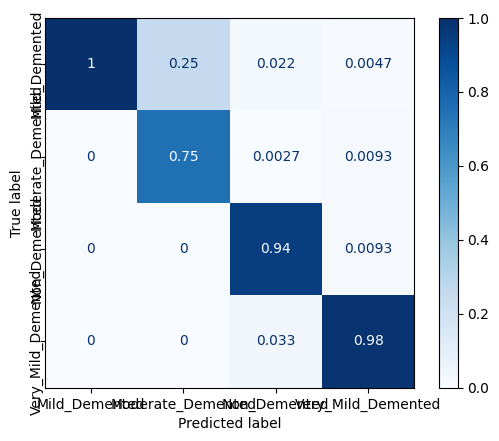

<Figure size 500x500 with 0 Axes>

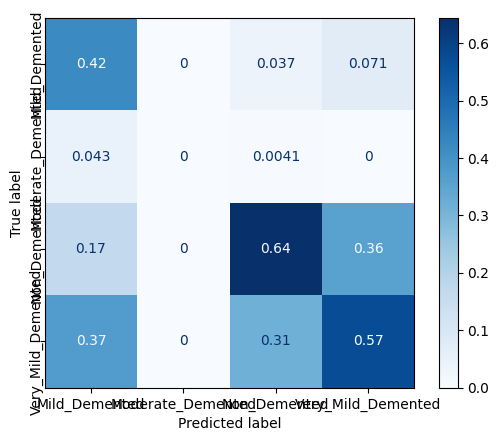

<Figure size 500x500 with 0 Axes>

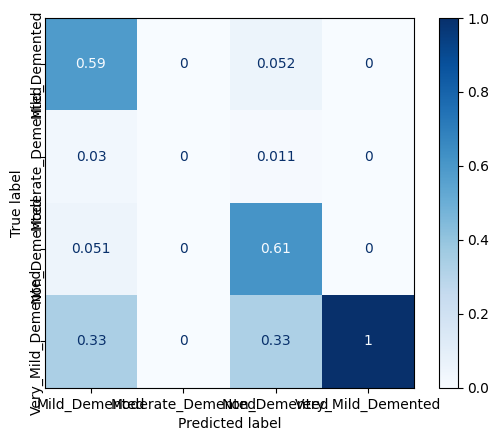

<Figure size 500x500 with 0 Axes>

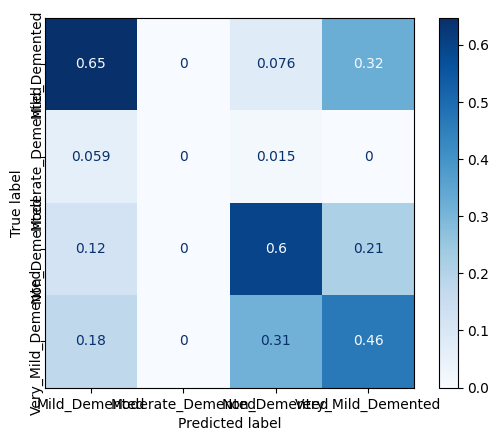

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ResNet101V2.zip ./*